In [1]:
import gym
import numpy as np
import torch
import torchkit.pytorch_utils as ptu
import torchsde
from torch.nn import functional as F
import random as rnd
import copy as cp
# import environments
import envs.pomdp
import pdb
# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN
from policies.models.policy_rnn_shared import ModelFreeOffPolicy_Shared_RNN as Policy_Shared_RNN
from policies.models.policy_mlp import ModelFreeOffPolicy_MLP as Policy_MLP
from tqdm import tqdm
# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from buffers.simple_replay_buffer import SimpleReplayBuffer 
from utils import helpers as utl
from typing import Sequence
from read_ini import read_ini
conf =read_ini("C:/Users/alexander.vasilyev/pomdp-baselines-main/configfile.ini")

C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
C:\Users\alexander.vasilyev\pomdp-baselines-main\utils\logger.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Set
C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [2]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env = gym.make(conf["env_name"])
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
reward_vision= bool(int(conf["reward_vision"]))
shared = False
markov = False

if markov:
    agent = Policy_MLP(
        obs_dim=obs_dim,
        action_dim=act_dim,
        algo_name=conf["algo_name"],
        dqn_layers=[128, 128],
        policy_layers=[128, 128],
        lr=3e-4,
        gamma=0.99,
        tau=5e-3,
    ).to(ptu.device)
    encoder="Nan"
else:
    if shared:
        agent = Policy_Shared_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
        ).to(ptu.device)
    else: 
        agent = Policy_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            radii=60,
            activation = conf["activation"],
            reward_vision= reward_vision,
        ).to(ptu.device)
    
print(agent)
lr=float(conf["lr"])
encoder=conf["encoder"]
num_updates_per_iter = int(conf["num_updates_per_iter"])  # training frequency
sampled_seq_len = int(conf["sampled_seq_len"])  # context length
buffer_size = int(float(conf["buffer_size"]))
batch_size = int(conf["batch_size"])
dropout_rate=float(conf["dropout_rate"])
num_iters = int(conf["num_iters"])
num_init_rollouts_pool = int(conf["num_init_rollouts_pool"])
num_rollouts_per_iter = int(conf["num_rollouts_per_iter"])
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)


ModelFreeOffPolicy_Separate_RNN(
  (critic): Critic_RNN(
    (observ_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=2, bias=True)
    )
    (action_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=2, bias=True)
    )
    (reward_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=2, bias=True)
    )
    (rnn): LSTM(7, 32)
    (current_shortcut_embedder): FeatureExtractor(
      (fc): Linear(in_features=2, out_features=6, bias=True)
    )
    (qf1): FlattenMlp(
      (fc0): Linear(in_features=38, out_features=128, bias=True)
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (last_fc): Linear(in_features=128, out_features=1, bias=True)
    )
    (qf2): FlattenMlp(
      (fc0): Linear(in_features=38, out_features=128, bias=True)
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (last_fc): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (critic_target):

In [3]:
act_dim

1

## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

## Define other training parameters such as context length and training frequency

## Define key functions: collect rollouts and policy update

In [4]:
def create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,non_drops,init, drop=True):
    
    if init:
        obs_row= obs
        rew_row = prev_reward
        act_row = prev_action
    else:
        obs_row=torch.cat((obs, next_obs),0)
        rew_row=torch.cat((prev_reward, reward),0)
        act_row=torch.cat((prev_action, action),0)
    #pdb.set_trace()
    if shared: 
        obs_row=agent.observ_embedder(obs_row)
        rew_row=agent.reward_embedder(rew_row)
        act_row=agent.action_embedder(act_row)
    else: 
        obs_row=agent.actor.observ_embedder(obs_row)
        rew_row=agent.actor.reward_embedder(rew_row)
        act_row=agent.actor.action_embedder(act_row)
        #pdb.set_trace()
    if init:
        time_tensor=torch.tensor([[steps]]).to(ptu.device)
        drop_tensor=torch.tensor([[non_drops]]).to(ptu.device)
    else:
        time_tensor=torch.tensor([[steps],[steps+1]]).to(ptu.device)
        if drop:
            drop_tensor=torch.tensor([[non_drops],[non_drops+1]]).to(ptu.device)
        else:
            drop_tensor=torch.tensor([[non_drops],[non_drops]]).to(ptu.device)
            
    if reward_vision:
        ncde_row=torch.cat((time_tensor,drop_tensor,act_row,obs_row,rew_row),1)
    else:
        ncde_row=torch.cat((time_tensor,drop_tensor,act_row,obs_row),1)
    ncde_row=ncde_row[None,:]
    #pdb.set_trace()
    return ncde_row



@torch.no_grad()
def collect_rollouts(
    num_rollouts, dropout_rate=0.0, random_actions=False, deterministic=True, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0
    trewards =[]
    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        energy = 0.0
        non_drops=0
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False
        init=True
        drop=True
        # get hidden state at timestep=0, None for mlp
        
        if not markov:
            action, reward, internal_state = agent.get_initial_info()

            if encoder == "ncde":
                internal_state= None
                ncde_row= create_ncde_row(obs, obs, action, action, reward, reward, steps,non_drops,init, drop)
                prev_action= action.clone()
                prev_reward= reward.clone()
                next_obs= obs.clone()
        
        
        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list, drop_list = (
                [],
                [],
                [],
                [],
                [],
                [],
            )
                           

        while not done_rollout:
            if markov: 
                action = agent.act(obs=obs, 
                                   deterministic=deterministic)[0]
            else:
                if encoder == "ncde":
                    (action,_,_,_), internal_state= agent.ncde_act(ncde_row=ncde_row,
                                                                   prev_internal_state=internal_state,
                                                                   obs=obs,
                                                                   deterministic=deterministic,)
                else:
                    (action, _, _, _), internal_state = agent.act(
                        prev_internal_state=internal_state,
                        prev_action=action,
                        reward=reward,
                        obs=obs,
                        drop=drop,
                        deterministic=deterministic,
                    )
            # observe reward and next obs (B=1, dim)
            #pdb.set_trace()
        
            #print(torch.norm(internal_state))
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True
            init=False
            #print(reward)
            #switch on/off dropouts
            if dropout_rate>0:
                drop_trigger=rnd.uniform(0,1)
                if drop_trigger<dropout_rate:
                    next_obs= obs.clone()
                    drop=False
                else:
                    drop=True
                    
                    
            if not markov:
                if encoder == "ncde":  
                    ncde_row= create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,non_drops,init, drop)
            
            #switch on/off dropouts

            # update statistics
           
            rewards += reward.item()
            energy += action*action
           
            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)
            steps += 1
            # set: obs <- next_obs
            obs = next_obs.clone()
            prev_reward= reward.clone()
            prev_action= action.clone()
            if drop:
                non_drops +=1
        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
            "total energy",
            energy,
        )
        total_steps += steps
        total_rewards += rewards
        trewards.append(rewards)
    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts, np.std(trewards)


def update(num_updates, factor):
    rl_losses_agg = {}
    # print(num_updates)
    for update in tqdm(range(num_updates), leave=True):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        
        rl_losses = agent.update(batch, factor)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [5]:
dropouts=0.0
learning_curves=[]
while dropouts<1:
    _n_env_steps_total =0 
    
    policy_storage = SeqReplayBuffer(
        max_replay_buffer_size=buffer_size,
        observation_dim=obs_dim,
        action_dim=act_dim,
        sampled_seq_len=sampled_seq_len,
        sample_weight_baseline=0.0,
    )

    env_steps = collect_rollouts(
        num_rollouts=num_init_rollouts_pool, dropout_rate=dropouts, random_actions=False, train_mode=True
    )
    _n_env_steps_total += env_steps

    # evaluation parameters
    last_eval_num_iters = 10
    log_interval = 5
    eval_num_rollouts = 10
    learning_curve = {
        "x": [],
        "y": [],
        "z": [],
    }
    epoch=0
    lambda_pat = 0.65
    
    while _n_env_steps_total < n_env_steps_total:

        env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, dropout_rate=dropouts, train_mode=True)
        _n_env_steps_total += env_steps

        #train_stats = update(int(num_updates_per_iter * env_steps))
        factor= lambda_pat **(epoch )
        #train_stats = update(int(num_updates_per_iter * env_steps))
        train_stats = update(25, lr)

        epoch += 1
        current_num_iters = _n_env_steps_total // (
            num_rollouts_per_iter * max_trajectory_len
        )
        if (
            current_num_iters != last_eval_num_iters
            and current_num_iters % log_interval == 0
        ):
            last_eval_num_iters = current_num_iters
            average_returns, std_returns = collect_rollouts(
                num_rollouts=eval_num_rollouts, dropout_rate=dropouts,
                train_mode=False,
                random_actions=False,
                deterministic=True,
            )
            learning_curve["x"].append(_n_env_steps_total)
            learning_curve["y"].append(average_returns)
            learning_curve["z"].append(std_returns)
            print(_n_env_steps_total, average_returns)
    learning_curves.append(learning_curve)
    dropouts+=0.2

buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -1404.801344871521 total energy tensor([[0.0003]])
Mode: Train env_steps 200 total rewards -1076.1050254106522 total energy tensor([[0.0005]])
Mode: Train env_steps 200 total rewards -1462.3142585754395 total energy tensor([[0.0002]])
Mode: Train env_steps 200 total rewards -1243.848051071167 total energy tensor([[0.0004]])
Mode: Train env_steps 200 total rewards -1242.1841430664062 total energy tensor([[0.0004]])
Mode: Train env_steps 200 total rewards -1176.1278100013733 total energy tensor([[0.0004]])
Mode: Train env_steps 200 total rewards -1330.801920890808 total energy tensor([[0.0003]])
Mode: Train env_steps 200 total rewards -970.3549584746361 total energy tensor([[0.0004]])
Mode: Train env_steps 200 total rewards -1068.886704325676 total energy tensor([[0.0004]])
Mode: Train env_steps 200 total rewards -1490.4815783500671 total energy tensor([[0.0002]])


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\alexander.vasilyev\pomdp-baselines-main\torchkit\pytorch_utils.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if v.dtype == np.bool:
100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Mode: Train env_steps 200 total rewards -1445.3034076690674 total energy tensor([[4.6510]])
Mode: Train env_steps 200 total rewards -1305.7572884559631 total energy tensor([[4.9263]])
Mode: Train env_steps 200 total rewards -1345.8062043190002 total energy tensor([[4.3173]])
Mode: Train env_steps 200 total rewards -1093.2469290532172 total energy tensor([[5.0497]])
Mode: Train env_steps 200 total rewards -1592.5787925720215 total energy tensor([[4.5404]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1454.8406300246716 total energy tensor([[89.9766]])
Mode: Train env_steps 200 total rewards -1523.4549622535706 total energy tensor([[90.6386]])
Mode: Train env_steps 200 total rewards -1535.9465769529343 total energy tensor([[91.2381]])
Mode: Train env_steps 200 total rewards -1492.6904644966125 total energy tensor([[90.6168]])
Mode: Train env_steps 200 total rewards -1605.2654519081116 total energy tensor([[122.0202]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1331.5475028157234 total energy tensor([[119.2801]])
Mode: Train env_steps 200 total rewards -1616.3875207901 total energy tensor([[108.9829]])
Mode: Train env_steps 200 total rewards -1441.5054531395435 total energy tensor([[65.3062]])
Mode: Train env_steps 200 total rewards -1588.9445281028748 total energy tensor([[113.6540]])
Mode: Train env_steps 200 total rewards -1611.8389887809753 total energy tensor([[112.1561]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1578.1492737531662 total energy tensor([[135.9970]])
Mode: Test env_steps 200 total rewards -1642.9820804595947 total energy tensor([[93.7217]])
Mode: Test env_steps 200 total rewards -1603.3108553886414 total energy tensor([[102.9941]])
Mode: Test env_steps 200 total rewards -1551.51494217664 total energy tensor([[134.2831]])
Mode: Test env_steps 200 total rewards -1470.78309024591 total energy tensor([[131.7182]])
Mode: Test env_steps 200 total rewards -1534.797660112381 total energy tensor([[111.8004]])
Mode: Test env_steps 200 total rewards -1649.4641184806824 total energy tensor([[95.5973]])
Mode: Test env_steps 200 total rewards -1432.176479458809 total energy tensor([[124.5981]])
Mode: Test env_steps 200 total rewards -1545.6172941923141 total energy tensor([[133.9617]])
Mode: Test env_steps 200 total rewards -1410.4872883558273 total energy tensor([[120.1721]])
5000 -1541.9283082623965
Mode: Train env_steps 200 total rewards -1531.4765384

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1795.866530418396 total energy tensor([[8.9006]])
Mode: Train env_steps 200 total rewards -1325.4847741499543 total energy tensor([[62.7356]])
Mode: Train env_steps 200 total rewards -1638.1039539575577 total energy tensor([[32.2431]])
Mode: Train env_steps 200 total rewards -1547.458242624998 total energy tensor([[167.8509]])
Mode: Train env_steps 200 total rewards -1601.7908284664154 total energy tensor([[174.0902]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1777.1647367477417 total energy tensor([[1.7173]])
Mode: Train env_steps 200 total rewards -1546.989349246025 total energy tensor([[53.0422]])
Mode: Train env_steps 200 total rewards -1637.7236815094948 total energy tensor([[196.2889]])
Mode: Train env_steps 200 total rewards -1659.5800706744194 total energy tensor([[196.7623]])
Mode: Train env_steps 200 total rewards -1535.7095843553543 total energy tensor([[53.5503]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1837.845377922058 total energy tensor([[0.8960]])
Mode: Train env_steps 200 total rewards -1769.1684665679932 total energy tensor([[9.4185]])
Mode: Train env_steps 200 total rewards -1041.9296660609543 total energy tensor([[139.8730]])
Mode: Train env_steps 200 total rewards -1628.284145988524 total energy tensor([[198.2251]])
Mode: Train env_steps 200 total rewards -1075.9199031889439 total energy tensor([[141.2754]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1598.4162212610245 total energy tensor([[197.6295]])
Mode: Train env_steps 200 total rewards -1584.9697263240814 total energy tensor([[58.7110]])
Mode: Train env_steps 200 total rewards -1684.2744526863098 total energy tensor([[198.6084]])
Mode: Train env_steps 200 total rewards -1707.041160583496 total energy tensor([[30.0290]])
Mode: Train env_steps 200 total rewards -1516.5785570144653 total energy tensor([[73.2093]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -1217.2049261927605 total energy tensor([[138.4456]])
Mode: Test env_steps 200 total rewards -1659.9805876016617 total energy tensor([[196.1745]])
Mode: Test env_steps 200 total rewards -1430.2131052017212 total energy tensor([[102.4398]])
Mode: Test env_steps 200 total rewards -1711.4955790042877 total energy tensor([[38.9776]])
Mode: Test env_steps 200 total rewards -1656.5350201129913 total energy tensor([[52.8626]])
Mode: Test env_steps 200 total rewards -1612.4609388113022 total energy tensor([[196.0269]])
Mode: Test env_steps 200 total rewards -1562.8480343818665 total energy tensor([[70.4915]])
Mode: Test env_steps 200 total rewards -1873.1173543930054 total energy tensor([[8.1778]])
Mode: Test env_steps 200 total rewards -1637.5400760173798 total energy tensor([[196.5198]])
Mode: Test env_steps 200 total rewards -1662.7231705784798 total energy tensor([[197.7264]])
10000 -1602.4118792295455
Mode: Train env_steps 200 total rewards -1042.458

100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1642.22412109375 total energy tensor([[196.9652]])
Mode: Train env_steps 200 total rewards -1550.2066531181335 total energy tensor([[77.9925]])
Mode: Train env_steps 200 total rewards -1790.1687812805176 total energy tensor([[26.3296]])
Mode: Train env_steps 200 total rewards -1748.611020565033 total energy tensor([[30.8603]])
Mode: Train env_steps 200 total rewards -1813.2636451721191 total energy tensor([[19.3944]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -1733.0140261650085 total energy tensor([[47.4788]])
Mode: Train env_steps 200 total rewards -1247.9126368761063 total energy tensor([[139.8670]])
Mode: Train env_steps 200 total rewards -1747.9271087646484 total energy tensor([[42.3258]])
Mode: Train env_steps 200 total rewards -1250.1546092033386 total energy tensor([[140.7874]])
Mode: Train env_steps 200 total rewards -1652.3986880779266 total energy tensor([[61.6799]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1653.8932342529297 total energy tensor([[197.0755]])
Mode: Train env_steps 200 total rewards -1659.5946588516235 total energy tensor([[196.3257]])
Mode: Train env_steps 200 total rewards -1700.4746594429016 total energy tensor([[60.3391]])
Mode: Train env_steps 200 total rewards -1655.0248265266418 total energy tensor([[196.0813]])
Mode: Train env_steps 200 total rewards -1711.1892051696777 total energy tensor([[56.2792]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1731.88321018219 total energy tensor([[50.4508]])
Mode: Train env_steps 200 total rewards -1726.7420148849487 total energy tensor([[50.7648]])
Mode: Train env_steps 200 total rewards -1188.584025412798 total energy tensor([[140.0240]])
Mode: Train env_steps 200 total rewards -1186.9818336963654 total energy tensor([[141.7303]])
Mode: Train env_steps 200 total rewards -1591.3281021118164 total energy tensor([[196.8091]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1727.7595081329346 total energy tensor([[49.9755]])
Mode: Test env_steps 200 total rewards -1525.0310162305832 total energy tensor([[88.5860]])
Mode: Test env_steps 200 total rewards -1368.621802687645 total energy tensor([[121.0924]])
Mode: Test env_steps 200 total rewards -1656.2759020924568 total energy tensor([[196.5436]])
Mode: Test env_steps 200 total rewards -1667.8069138526917 total energy tensor([[196.8171]])
Mode: Test env_steps 200 total rewards -1482.5949252843857 total energy tensor([[97.8193]])
Mode: Test env_steps 200 total rewards -1727.8721961975098 total energy tensor([[51.0267]])
Mode: Test env_steps 200 total rewards -1234.8828292489052 total energy tensor([[144.1091]])
Mode: Test env_steps 200 total rewards -1535.8901790380478 total energy tensor([[89.0756]])
Mode: Test env_steps 200 total rewards -1416.833597779274 total energy tensor([[114.1827]])
15000 -1534.3568870544434
Mode: Train env_steps 200 total rewards -1535.51166

100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -1657.0888366699219 total energy tensor([[196.9853]])
Mode: Train env_steps 200 total rewards -1191.082523971796 total energy tensor([[143.4464]])
Mode: Train env_steps 200 total rewards -1648.405392587185 total energy tensor([[197.2229]])
Mode: Train env_steps 200 total rewards -1203.004611313343 total energy tensor([[147.2000]])
Mode: Train env_steps 200 total rewards -1652.3473774790764 total energy tensor([[196.2565]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1606.4063398838043 total energy tensor([[197.0481]])
Mode: Train env_steps 200 total rewards -1670.047990322113 total energy tensor([[67.0767]])
Mode: Train env_steps 200 total rewards -1608.4448449611664 total energy tensor([[83.2989]])
Mode: Train env_steps 200 total rewards -1702.5452604293823 total energy tensor([[63.8578]])
Mode: Train env_steps 200 total rewards -1677.3890137672424 total energy tensor([[68.4383]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -1095.9341529160738 total energy tensor([[149.2789]])
Mode: Train env_steps 200 total rewards -1685.7937836647034 total energy tensor([[67.3433]])
Mode: Train env_steps 200 total rewards -1580.1161687374115 total energy tensor([[88.6527]])
Mode: Train env_steps 200 total rewards -1674.1780824661255 total energy tensor([[69.1651]])
Mode: Train env_steps 200 total rewards -1244.9991550445557 total energy tensor([[149.4035]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1379.1453769207 total energy tensor([[123.2806]])
Mode: Train env_steps 200 total rewards -1672.939350605011 total energy tensor([[198.3949]])
Mode: Train env_steps 200 total rewards -1645.2106175422668 total energy tensor([[87.4741]])
Mode: Train env_steps 200 total rewards -1576.588041305542 total energy tensor([[97.6920]])
Mode: Train env_steps 200 total rewards -1139.1390831321478 total energy tensor([[148.4617]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1356.61141371727 total energy tensor([[131.3500]])
Mode: Test env_steps 200 total rewards -1181.804041981697 total energy tensor([[149.0472]])
Mode: Test env_steps 200 total rewards -1632.2030500173569 total energy tensor([[195.6119]])
Mode: Test env_steps 200 total rewards -1661.648377418518 total energy tensor([[84.7521]])
Mode: Test env_steps 200 total rewards -1151.4710887148976 total energy tensor([[148.7759]])
Mode: Test env_steps 200 total rewards -1597.8643596172333 total energy tensor([[99.4780]])
Mode: Test env_steps 200 total rewards -1637.398862361908 total energy tensor([[92.6073]])
Mode: Test env_steps 200 total rewards -1589.3752586841583 total energy tensor([[99.9982]])
Mode: Test env_steps 200 total rewards -1611.1233617067337 total energy tensor([[196.4879]])
Mode: Test env_steps 200 total rewards -1552.0258065983653 total energy tensor([[186.7163]])
20000 -1497.1525620818138
Mode: Train env_steps 200 total rewards -1610.4586428

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1159.812813937664 total energy tensor([[151.6702]])
Mode: Train env_steps 200 total rewards -1265.8765234053135 total energy tensor([[147.4940]])
Mode: Train env_steps 200 total rewards -1666.417070388794 total energy tensor([[79.9962]])
Mode: Train env_steps 200 total rewards -1195.2258159220219 total energy tensor([[152.4758]])
Mode: Train env_steps 200 total rewards -1410.0975575447083 total energy tensor([[124.4298]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1172.6779984384775 total energy tensor([[150.7358]])
Mode: Train env_steps 200 total rewards -1659.1434931755066 total energy tensor([[198.0642]])
Mode: Train env_steps 200 total rewards -1610.1339873373508 total energy tensor([[194.5861]])
Mode: Train env_steps 200 total rewards -1603.2913309782743 total energy tensor([[194.3982]])
Mode: Train env_steps 200 total rewards -1391.4855766892433 total energy tensor([[136.6847]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1656.7823233604431 total energy tensor([[84.0742]])
Mode: Train env_steps 200 total rewards -1516.3474291563034 total energy tensor([[114.5509]])
Mode: Train env_steps 200 total rewards -1672.051251411438 total energy tensor([[78.0088]])
Mode: Train env_steps 200 total rewards -1623.8045301437378 total energy tensor([[93.4048]])
Mode: Train env_steps 200 total rewards -1628.611491203308 total energy tensor([[197.1197]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1571.618684053421 total energy tensor([[111.1404]])
Mode: Train env_steps 200 total rewards -1665.0895367264748 total energy tensor([[197.5074]])
Mode: Train env_steps 200 total rewards -1610.6846897602081 total energy tensor([[107.3405]])
Mode: Train env_steps 200 total rewards -1635.3192596435547 total energy tensor([[97.0610]])
Mode: Train env_steps 200 total rewards -1613.4739935398102 total energy tensor([[107.6439]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -1649.166141986847 total energy tensor([[91.2121]])
Mode: Test env_steps 200 total rewards -1641.7289958000183 total energy tensor([[92.9163]])
Mode: Test env_steps 200 total rewards -1643.5160970687866 total energy tensor([[92.1081]])
Mode: Test env_steps 200 total rewards -1642.0352563858032 total energy tensor([[93.3771]])
Mode: Test env_steps 200 total rewards -1650.5494046211243 total energy tensor([[197.2579]])
Mode: Test env_steps 200 total rewards -1591.6576937437057 total energy tensor([[196.8939]])
Mode: Test env_steps 200 total rewards -1444.5903687477112 total energy tensor([[131.3891]])
Mode: Test env_steps 200 total rewards -1648.1930298805237 total energy tensor([[91.6412]])
Mode: Test env_steps 200 total rewards -1616.5979051589966 total energy tensor([[102.0735]])
Mode: Test env_steps 200 total rewards -1650.6406588554382 total energy tensor([[89.2309]])
25000 -1617.8675552248956
Mode: Train env_steps 200 total rewards -1654.61882

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1623.2418174743652 total energy tensor([[104.9326]])
Mode: Train env_steps 200 total rewards -1652.8891042470932 total energy tensor([[197.2153]])
Mode: Train env_steps 200 total rewards -1640.2733809947968 total energy tensor([[197.9013]])
Mode: Train env_steps 200 total rewards -1642.9457511901855 total energy tensor([[95.6380]])
Mode: Train env_steps 200 total rewards -1266.327959984541 total energy tensor([[155.2573]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1527.7889912128448 total energy tensor([[128.9659]])
Mode: Train env_steps 200 total rewards -1598.9773168563843 total energy tensor([[115.4310]])
Mode: Train env_steps 200 total rewards -1620.0803260803223 total energy tensor([[197.2133]])
Mode: Train env_steps 200 total rewards -1588.265774488449 total energy tensor([[118.5574]])
Mode: Train env_steps 200 total rewards -1610.8185544013977 total energy tensor([[110.5893]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1627.1605205535889 total energy tensor([[105.0619]])
Mode: Train env_steps 200 total rewards -1422.181880891323 total energy tensor([[129.0095]])
Mode: Train env_steps 200 total rewards -1196.396840161644 total energy tensor([[149.3186]])
Mode: Train env_steps 200 total rewards -1604.651864528656 total energy tensor([[116.3770]])
Mode: Train env_steps 200 total rewards -1618.6789070367813 total energy tensor([[197.2666]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1616.1337566375732 total energy tensor([[109.6931]])
Mode: Train env_steps 200 total rewards -1407.480845093727 total energy tensor([[133.8327]])
Mode: Train env_steps 200 total rewards -1581.413855805993 total energy tensor([[193.2835]])
Mode: Train env_steps 200 total rewards -1520.956661939621 total energy tensor([[131.3146]])
Mode: Train env_steps 200 total rewards -1625.03258228302 total energy tensor([[105.1899]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Test env_steps 200 total rewards -1460.3936463594437 total energy tensor([[137.5376]])
Mode: Test env_steps 200 total rewards -1300.3603385090828 total energy tensor([[153.7451]])
Mode: Test env_steps 200 total rewards -1624.3062896728516 total energy tensor([[105.6285]])
Mode: Test env_steps 200 total rewards -1414.614284813404 total energy tensor([[141.1832]])
Mode: Test env_steps 200 total rewards -1604.416211605072 total energy tensor([[114.6938]])
Mode: Test env_steps 200 total rewards -1637.4294710159302 total energy tensor([[103.8264]])
Mode: Test env_steps 200 total rewards -1623.432620048523 total energy tensor([[104.5904]])
Mode: Test env_steps 200 total rewards -1579.7003045082092 total energy tensor([[120.0196]])
Mode: Test env_steps 200 total rewards -1588.8498537540436 total energy tensor([[120.1229]])
Mode: Test env_steps 200 total rewards -1608.2978868484497 total energy tensor([[111.9136]])
30000 -1544.180090713501
Mode: Train env_steps 200 total rewards -1327.59

100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -1588.864991903305 total energy tensor([[114.8920]])
Mode: Train env_steps 200 total rewards -1613.729344367981 total energy tensor([[114.5227]])
Mode: Train env_steps 200 total rewards -1505.54630112648 total energy tensor([[138.0893]])
Mode: Train env_steps 200 total rewards -1581.2892649173737 total energy tensor([[197.1915]])
Mode: Train env_steps 200 total rewards -1382.4332950115204 total energy tensor([[150.5090]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -1273.8783850222826 total energy tensor([[156.5506]])
Mode: Train env_steps 200 total rewards -1676.749319434166 total energy tensor([[197.9832]])
Mode: Train env_steps 200 total rewards -1605.9156460762024 total energy tensor([[119.4009]])
Mode: Train env_steps 200 total rewards -1206.1625034064054 total energy tensor([[162.1503]])
Mode: Train env_steps 200 total rewards -1620.802608013153 total energy tensor([[110.4299]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1184.0705796750262 total energy tensor([[152.1503]])
Mode: Train env_steps 200 total rewards -1606.025869846344 total energy tensor([[116.7998]])
Mode: Train env_steps 200 total rewards -1220.6717172898352 total energy tensor([[156.4682]])
Mode: Train env_steps 200 total rewards -1567.3942732810974 total energy tensor([[126.6963]])
Mode: Train env_steps 200 total rewards -1606.6599951088428 total energy tensor([[195.8660]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1253.050865650177 total energy tensor([[156.9265]])
Mode: Train env_steps 200 total rewards -1397.0417434573174 total energy tensor([[147.5310]])
Mode: Train env_steps 200 total rewards -1620.8962383568287 total energy tensor([[196.8421]])
Mode: Train env_steps 200 total rewards -1583.0656609535217 total energy tensor([[128.9787]])
Mode: Train env_steps 200 total rewards -1265.6389621049166 total energy tensor([[157.7196]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -1559.5204873085022 total energy tensor([[136.3940]])
Mode: Test env_steps 200 total rewards -1415.130182981491 total energy tensor([[150.0686]])
Mode: Test env_steps 200 total rewards -1309.5482622087002 total energy tensor([[157.0337]])
Mode: Test env_steps 200 total rewards -1582.715543270111 total energy tensor([[132.7322]])
Mode: Test env_steps 200 total rewards -1594.5477871894836 total energy tensor([[124.6243]])
Mode: Test env_steps 200 total rewards -1608.813768863678 total energy tensor([[118.2920]])
Mode: Test env_steps 200 total rewards -1604.1327619552612 total energy tensor([[120.2545]])
Mode: Test env_steps 200 total rewards -1579.877326965332 total energy tensor([[132.7590]])
Mode: Test env_steps 200 total rewards -1575.6425919532776 total energy tensor([[133.5480]])
Mode: Test env_steps 200 total rewards -1541.2400221824646 total energy tensor([[131.9773]])
35000 -1537.1168734878302
Mode: Train env_steps 200 total rewards -1591.31

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1630.1776028871536 total energy tensor([[196.7643]])
Mode: Train env_steps 200 total rewards -1493.4945995807648 total energy tensor([[142.7645]])
Mode: Train env_steps 200 total rewards -1580.4041414260864 total energy tensor([[131.0442]])
Mode: Train env_steps 200 total rewards -1562.2569131851196 total energy tensor([[134.4702]])
Mode: Train env_steps 200 total rewards -1576.4782752990723 total energy tensor([[135.3567]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1552.34552526474 total energy tensor([[144.7073]])
Mode: Train env_steps 200 total rewards -1228.8819735907018 total energy tensor([[158.8226]])
Mode: Train env_steps 200 total rewards -1390.670355975628 total energy tensor([[147.0606]])
Mode: Train env_steps 200 total rewards -1580.3323543071747 total energy tensor([[198.0999]])
Mode: Train env_steps 200 total rewards -1406.750316143036 total energy tensor([[154.9689]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1651.304782152176 total energy tensor([[197.7690]])
Mode: Train env_steps 200 total rewards -1571.9584970474243 total energy tensor([[140.2638]])
Mode: Train env_steps 200 total rewards -1625.5679434537888 total energy tensor([[197.0322]])
Mode: Train env_steps 200 total rewards -1306.100465863943 total energy tensor([[141.9449]])
Mode: Train env_steps 200 total rewards -1637.2190806865692 total energy tensor([[197.8903]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1658.2968654632568 total energy tensor([[197.8541]])
Mode: Train env_steps 200 total rewards -902.6069738101214 total energy tensor([[141.2806]])
Mode: Train env_steps 200 total rewards -1598.0341993570328 total energy tensor([[196.1608]])
Mode: Train env_steps 200 total rewards -1373.866988927126 total energy tensor([[141.7713]])
Mode: Train env_steps 200 total rewards -1595.9760855436325 total energy tensor([[195.7897]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Test env_steps 200 total rewards -1558.3627138137817 total energy tensor([[137.1000]])
Mode: Test env_steps 200 total rewards -1589.822506904602 total energy tensor([[129.7741]])
Mode: Test env_steps 200 total rewards -1645.2172005176544 total energy tensor([[197.9435]])
Mode: Test env_steps 200 total rewards -1590.7718696594238 total energy tensor([[127.4083]])
Mode: Test env_steps 200 total rewards -1591.8175287246704 total energy tensor([[128.2766]])
Mode: Test env_steps 200 total rewards -1566.8647425323725 total energy tensor([[193.4465]])
Mode: Test env_steps 200 total rewards -1377.9759036898613 total energy tensor([[149.2466]])
Mode: Test env_steps 200 total rewards -1566.8200941085815 total energy tensor([[139.6424]])
Mode: Test env_steps 200 total rewards -1666.182423233986 total energy tensor([[197.7649]])
Mode: Test env_steps 200 total rewards -1572.0636759996414 total energy tensor([[198.0379]])
40000 -1572.5898659184575
Mode: Train env_steps 200 total rewards -1513.

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1380.3863884210587 total energy tensor([[149.4601]])
Mode: Train env_steps 200 total rewards -1375.4953503608704 total energy tensor([[150.2737]])
Mode: Train env_steps 200 total rewards -1597.812252998352 total energy tensor([[123.5918]])
Mode: Train env_steps 200 total rewards -1438.932059288025 total energy tensor([[145.9257]])
Mode: Train env_steps 200 total rewards -1486.8111315965652 total energy tensor([[145.9874]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1679.9099106788635 total energy tensor([[198.3227]])
Mode: Train env_steps 200 total rewards -1566.3905534744263 total energy tensor([[127.7199]])
Mode: Train env_steps 200 total rewards -1555.200082063675 total energy tensor([[134.3912]])
Mode: Train env_steps 200 total rewards -1641.8524057865143 total energy tensor([[198.1271]])
Mode: Train env_steps 200 total rewards -1611.1678683757782 total energy tensor([[198.3519]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1587.9936891198158 total energy tensor([[196.1569]])
Mode: Train env_steps 200 total rewards -1641.0955452919006 total energy tensor([[197.7407]])
Mode: Train env_steps 200 total rewards -1599.0606637001038 total energy tensor([[121.5570]])
Mode: Train env_steps 200 total rewards -1366.961248983629 total energy tensor([[137.6615]])
Mode: Train env_steps 200 total rewards -1420.338392212987 total energy tensor([[140.4481]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1544.9033706188202 total energy tensor([[142.4099]])
Mode: Train env_steps 200 total rewards -1483.9768267571926 total energy tensor([[179.8042]])
Mode: Train env_steps 200 total rewards -1463.6515751481056 total energy tensor([[140.3741]])
Mode: Train env_steps 200 total rewards -1565.9256238937378 total energy tensor([[142.6026]])
Mode: Train env_steps 200 total rewards -1458.922592472285 total energy tensor([[138.8110]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1596.923746585846 total energy tensor([[130.2625]])
Mode: Test env_steps 200 total rewards -1208.1490143314004 total energy tensor([[144.1130]])
Mode: Test env_steps 200 total rewards -1519.8171997070312 total energy tensor([[138.6944]])
Mode: Test env_steps 200 total rewards -1502.8782406747341 total energy tensor([[139.4134]])
Mode: Test env_steps 200 total rewards -1582.0216035842896 total energy tensor([[134.3800]])
Mode: Test env_steps 200 total rewards -1552.9766473770142 total energy tensor([[139.7019]])
Mode: Test env_steps 200 total rewards -1597.8347578048706 total energy tensor([[122.7303]])
Mode: Test env_steps 200 total rewards -1580.9043726921082 total energy tensor([[132.7517]])
Mode: Test env_steps 200 total rewards -1597.895495891571 total energy tensor([[122.3952]])
Mode: Test env_steps 200 total rewards -1548.9331080913544 total energy tensor([[137.7189]])
45000 -1528.833418674022
Mode: Train env_steps 200 total rewards -1592.2

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1442.509692614898 total energy tensor([[131.6339]])
Mode: Train env_steps 200 total rewards -1534.74828261137 total energy tensor([[134.2398]])
Mode: Train env_steps 200 total rewards -1594.0340914726257 total energy tensor([[124.4867]])
Mode: Train env_steps 200 total rewards -1571.703809261322 total energy tensor([[138.3351]])
Mode: Train env_steps 200 total rewards -1519.588509708643 total energy tensor([[133.8470]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1490.3935706913471 total energy tensor([[145.2311]])
Mode: Train env_steps 200 total rewards -1558.3301072120667 total energy tensor([[134.3372]])
Mode: Train env_steps 200 total rewards -1443.4621981047094 total energy tensor([[134.5876]])
Mode: Train env_steps 200 total rewards -1584.41650390625 total energy tensor([[131.0736]])
Mode: Train env_steps 200 total rewards -1549.9676970243454 total energy tensor([[141.0658]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1411.9604801982641 total energy tensor([[143.5897]])
Mode: Train env_steps 200 total rewards -1597.8752207756042 total energy tensor([[125.2552]])
Mode: Train env_steps 200 total rewards -1579.3838620185852 total energy tensor([[129.9545]])
Mode: Train env_steps 200 total rewards -1384.224724439904 total energy tensor([[122.9783]])
Mode: Train env_steps 200 total rewards -1533.1173930168152 total energy tensor([[134.0688]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1582.7541689872742 total energy tensor([[133.3605]])
Mode: Train env_steps 200 total rewards -1507.5482391268015 total energy tensor([[131.4015]])
Mode: Train env_steps 200 total rewards -1580.7545006275177 total energy tensor([[126.6662]])
Mode: Train env_steps 200 total rewards -1595.7256226539612 total energy tensor([[122.5844]])
Mode: Train env_steps 200 total rewards -1575.802312374115 total energy tensor([[131.5479]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1555.0706695318222 total energy tensor([[130.6770]])
Mode: Test env_steps 200 total rewards -1535.6718643903732 total energy tensor([[133.9626]])
Mode: Test env_steps 200 total rewards -1533.567242205143 total energy tensor([[130.9258]])
Mode: Test env_steps 200 total rewards -1536.6706026792526 total energy tensor([[133.9447]])
Mode: Test env_steps 200 total rewards -1267.2269568052143 total energy tensor([[120.3269]])
Mode: Test env_steps 200 total rewards -1594.893388748169 total energy tensor([[122.3619]])
Mode: Test env_steps 200 total rewards -1575.322684764862 total energy tensor([[135.2557]])
Mode: Test env_steps 200 total rewards -1592.144401550293 total energy tensor([[126.2445]])
Mode: Test env_steps 200 total rewards -1561.4613976478577 total energy tensor([[136.0568]])
Mode: Test env_steps 200 total rewards -1560.6522564888 total energy tensor([[136.7944]])
50000 -1531.2681464811787
Mode: Train env_steps 200 total rewards -1590.82815

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1559.6604708433151 total energy tensor([[135.0494]])
Mode: Train env_steps 200 total rewards -1577.6764051914215 total energy tensor([[127.6565]])
Mode: Train env_steps 200 total rewards -1577.5892534255981 total energy tensor([[131.7702]])
Mode: Train env_steps 200 total rewards -1530.2042725682259 total energy tensor([[137.0465]])
Mode: Train env_steps 200 total rewards -1538.3042741417885 total energy tensor([[132.9427]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -1549.7621266841888 total energy tensor([[131.7733]])
Mode: Train env_steps 200 total rewards -1606.654667377472 total energy tensor([[121.5120]])
Mode: Train env_steps 200 total rewards -1570.2439455986023 total energy tensor([[132.1481]])
Mode: Train env_steps 200 total rewards -1456.0897674132138 total energy tensor([[127.0248]])
Mode: Train env_steps 200 total rewards -1560.3463641405106 total energy tensor([[131.8336]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1502.1726571917534 total energy tensor([[140.1531]])
Mode: Train env_steps 200 total rewards -1498.9171455651522 total energy tensor([[133.6282]])
Mode: Train env_steps 200 total rewards -1581.5659999847412 total energy tensor([[130.6420]])
Mode: Train env_steps 200 total rewards -1592.1958484649658 total energy tensor([[125.5560]])
Mode: Train env_steps 200 total rewards -1550.418837428093 total energy tensor([[136.4183]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1544.724239230156 total energy tensor([[134.4472]])
Mode: Train env_steps 200 total rewards -1576.6634316444397 total energy tensor([[132.2151]])
Mode: Train env_steps 200 total rewards -1545.1923953294754 total energy tensor([[134.2341]])
Mode: Train env_steps 200 total rewards -1598.5290908813477 total energy tensor([[130.3269]])
Mode: Train env_steps 200 total rewards -1551.1765022277832 total energy tensor([[130.9118]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1554.998104095459 total energy tensor([[137.7283]])
Mode: Test env_steps 200 total rewards -1174.255498804152 total energy tensor([[144.7546]])
Mode: Test env_steps 200 total rewards -1567.1265895366669 total energy tensor([[131.6270]])
Mode: Test env_steps 200 total rewards -1407.7513852156699 total energy tensor([[126.9293]])
Mode: Test env_steps 200 total rewards -1567.3991692066193 total energy tensor([[131.6124]])
Mode: Test env_steps 200 total rewards -1592.7352328300476 total energy tensor([[124.3771]])
Mode: Test env_steps 200 total rewards -1552.9348732233047 total energy tensor([[134.9904]])
Mode: Test env_steps 200 total rewards -1507.9091680049896 total energy tensor([[132.8770]])
Mode: Test env_steps 200 total rewards -1519.3440836966038 total energy tensor([[133.6472]])
Mode: Test env_steps 200 total rewards -1589.5949630737305 total energy tensor([[129.9948]])
55000 -1503.4049067687242
Mode: Train env_steps 200 total rewards -1590.

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1554.5227687358856 total energy tensor([[139.2329]])
Mode: Train env_steps 200 total rewards -1558.4722123146057 total energy tensor([[140.4769]])
Mode: Train env_steps 200 total rewards -1524.7337337732315 total energy tensor([[135.8469]])
Mode: Train env_steps 200 total rewards -1587.3500609397888 total energy tensor([[128.6223]])
Mode: Train env_steps 200 total rewards -1586.073173046112 total energy tensor([[135.3765]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1414.2980675883591 total energy tensor([[140.6647]])
Mode: Train env_steps 200 total rewards -1533.1801010370255 total energy tensor([[148.8172]])
Mode: Train env_steps 200 total rewards -1430.8425022233278 total energy tensor([[143.7388]])
Mode: Train env_steps 200 total rewards -1569.301275730133 total energy tensor([[142.7988]])
Mode: Train env_steps 200 total rewards -1475.9778664261103 total energy tensor([[145.6219]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1564.0307941436768 total energy tensor([[143.6570]])
Mode: Train env_steps 200 total rewards -1544.2027859687805 total energy tensor([[140.2624]])
Mode: Train env_steps 200 total rewards -1541.6804947853088 total energy tensor([[146.0876]])
Mode: Train env_steps 200 total rewards -1562.4028613567352 total energy tensor([[139.9044]])
Mode: Train env_steps 200 total rewards -1558.8972148895264 total energy tensor([[139.9189]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1552.9799251556396 total energy tensor([[139.9147]])
Mode: Train env_steps 200 total rewards -1548.4633264541626 total energy tensor([[135.6765]])
Mode: Train env_steps 200 total rewards -1456.5741611905396 total energy tensor([[132.5986]])
Mode: Train env_steps 200 total rewards -1513.8278966546059 total energy tensor([[134.6624]])
Mode: Train env_steps 200 total rewards -1497.8083974719048 total energy tensor([[139.6297]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -1546.7706586122513 total energy tensor([[139.5361]])
Mode: Test env_steps 200 total rewards -1584.78444480896 total energy tensor([[135.6048]])
Mode: Test env_steps 200 total rewards -1589.534899711609 total energy tensor([[126.6409]])
Mode: Test env_steps 200 total rewards -1482.9824465215206 total energy tensor([[143.7013]])
Mode: Test env_steps 200 total rewards -1569.4438457489014 total energy tensor([[134.7884]])
Mode: Test env_steps 200 total rewards -1578.1872429847717 total energy tensor([[132.0229]])
Mode: Test env_steps 200 total rewards -1527.5756672620773 total energy tensor([[136.3618]])
Mode: Test env_steps 200 total rewards -1486.5740235000849 total energy tensor([[135.4043]])
Mode: Test env_steps 200 total rewards -1546.7898247241974 total energy tensor([[139.0621]])
Mode: Test env_steps 200 total rewards -1589.802896976471 total energy tensor([[127.9324]])
60000 -1550.2445950850845
Mode: Train env_steps 200 total rewards -1585.43

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1437.4539527446032 total energy tensor([[133.5892]])
Mode: Train env_steps 200 total rewards -1555.5770516395569 total energy tensor([[142.7638]])
Mode: Train env_steps 200 total rewards -1416.9575292556547 total energy tensor([[132.7488]])
Mode: Train env_steps 200 total rewards -1564.8817777633667 total energy tensor([[136.2608]])
Mode: Train env_steps 200 total rewards -1547.105004787445 total energy tensor([[145.4326]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1575.7119073867798 total energy tensor([[138.7323]])
Mode: Train env_steps 200 total rewards -1564.5585179328918 total energy tensor([[141.7075]])
Mode: Train env_steps 200 total rewards -1585.9676914215088 total energy tensor([[130.2380]])
Mode: Train env_steps 200 total rewards -1546.5906109809875 total energy tensor([[144.5847]])
Mode: Train env_steps 200 total rewards -1520.0544541478157 total energy tensor([[141.8275]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1568.7654719352722 total energy tensor([[135.9214]])
Mode: Train env_steps 200 total rewards -1535.618204832077 total energy tensor([[136.0945]])
Mode: Train env_steps 200 total rewards -1492.5135313495994 total energy tensor([[133.2458]])
Mode: Train env_steps 200 total rewards -1559.0513162612915 total energy tensor([[132.1831]])
Mode: Train env_steps 200 total rewards -1584.9310173988342 total energy tensor([[134.2911]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1584.2435941696167 total energy tensor([[129.4909]])
Mode: Train env_steps 200 total rewards -1574.848994255066 total energy tensor([[137.0159]])
Mode: Train env_steps 200 total rewards -1495.6984543800354 total energy tensor([[144.4429]])
Mode: Train env_steps 200 total rewards -1524.0974982976913 total energy tensor([[137.9213]])
Mode: Train env_steps 200 total rewards -1570.6750440597534 total energy tensor([[135.5717]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1471.8091654777527 total energy tensor([[146.0542]])
Mode: Test env_steps 200 total rewards -1568.1552548408508 total energy tensor([[142.7553]])
Mode: Test env_steps 200 total rewards -1573.5606961250305 total energy tensor([[137.4040]])
Mode: Test env_steps 200 total rewards -1580.928406238556 total energy tensor([[136.9828]])
Mode: Test env_steps 200 total rewards -1576.9021005630493 total energy tensor([[135.2457]])
Mode: Test env_steps 200 total rewards -1577.4195675849915 total energy tensor([[133.0170]])
Mode: Test env_steps 200 total rewards -1572.3493604660034 total energy tensor([[137.4942]])
Mode: Test env_steps 200 total rewards -1548.1714363098145 total energy tensor([[144.3983]])
Mode: Test env_steps 200 total rewards -1558.3820350170135 total energy tensor([[134.2879]])
Mode: Test env_steps 200 total rewards -1523.1451455950737 total energy tensor([[138.7686]])
65000 -1555.0823168218135
Mode: Train env_steps 200 total rewards -1530

100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1580.9515542984009 total energy tensor([[132.3429]])
Mode: Train env_steps 200 total rewards -1549.6290473937988 total energy tensor([[142.3085]])
Mode: Train env_steps 200 total rewards -1551.8926753997803 total energy tensor([[142.1293]])
Mode: Train env_steps 200 total rewards -1577.6370882987976 total energy tensor([[131.3577]])
Mode: Train env_steps 200 total rewards -1515.1603059768677 total energy tensor([[141.4298]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1476.146255940199 total energy tensor([[147.7375]])
Mode: Train env_steps 200 total rewards -1500.2817248553038 total energy tensor([[139.7299]])
Mode: Train env_steps 200 total rewards -1571.411135673523 total energy tensor([[136.7009]])
Mode: Train env_steps 200 total rewards -1564.1639642715454 total energy tensor([[136.9840]])
Mode: Train env_steps 200 total rewards -1562.9863729476929 total energy tensor([[135.9408]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1565.8972382545471 total energy tensor([[140.4564]])
Mode: Train env_steps 200 total rewards -1487.1909472346306 total energy tensor([[150.2315]])
Mode: Train env_steps 200 total rewards -1567.269847393036 total energy tensor([[141.6546]])
Mode: Train env_steps 200 total rewards -1481.6228507459164 total energy tensor([[143.1143]])
Mode: Train env_steps 200 total rewards -1519.101456105709 total energy tensor([[143.6261]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1566.1945934295654 total energy tensor([[136.6692]])
Mode: Train env_steps 200 total rewards -1569.044240951538 total energy tensor([[137.3573]])
Mode: Train env_steps 200 total rewards -1542.3361901044846 total energy tensor([[138.6959]])
Mode: Train env_steps 200 total rewards -1451.941970616579 total energy tensor([[143.9512]])
Mode: Train env_steps 200 total rewards -1468.733486302197 total energy tensor([[136.0860]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -1546.9952836036682 total energy tensor([[143.9957]])
Mode: Test env_steps 200 total rewards -1571.389699935913 total energy tensor([[135.7620]])
Mode: Test env_steps 200 total rewards -1411.6576354205608 total energy tensor([[147.4401]])
Mode: Test env_steps 200 total rewards -1585.371015071869 total energy tensor([[131.5616]])
Mode: Test env_steps 200 total rewards -1440.2306538820267 total energy tensor([[145.9764]])
Mode: Test env_steps 200 total rewards -1547.7656321525574 total energy tensor([[136.4542]])
Mode: Test env_steps 200 total rewards -1513.5651366710663 total energy tensor([[141.4155]])
Mode: Test env_steps 200 total rewards -1559.9691333770752 total energy tensor([[140.6505]])
Mode: Test env_steps 200 total rewards -1562.0068640708923 total energy tensor([[136.3893]])
Mode: Test env_steps 200 total rewards -1535.244078040123 total energy tensor([[138.9288]])
70000 -1527.4195132225752
Mode: Train env_steps 200 total rewards -1568.7

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1559.581726551056 total energy tensor([[146.9955]])
Mode: Train env_steps 200 total rewards -1558.7774858474731 total energy tensor([[146.4951]])
Mode: Train env_steps 200 total rewards -1391.6335910963826 total energy tensor([[146.1580]])
Mode: Train env_steps 200 total rewards -1557.3532357215881 total energy tensor([[146.2708]])
Mode: Train env_steps 200 total rewards -1532.2969896793365 total energy tensor([[156.1885]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1526.60214304924 total energy tensor([[148.2031]])
Mode: Train env_steps 200 total rewards -1465.1175174117088 total energy tensor([[150.9032]])
Mode: Train env_steps 200 total rewards -1551.5390105247498 total energy tensor([[149.7470]])
Mode: Train env_steps 200 total rewards -1542.8087840080261 total energy tensor([[148.8943]])
Mode: Train env_steps 200 total rewards -1563.0517101287842 total energy tensor([[140.4815]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1539.4083268642426 total energy tensor([[148.4299]])
Mode: Train env_steps 200 total rewards -1556.458438873291 total energy tensor([[147.8907]])
Mode: Train env_steps 200 total rewards -1555.80562210083 total energy tensor([[142.2426]])
Mode: Train env_steps 200 total rewards -1468.8838993161917 total energy tensor([[143.8040]])
Mode: Train env_steps 200 total rewards -1369.4241873174906 total energy tensor([[155.0790]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1544.988319158554 total energy tensor([[144.6222]])
Mode: Train env_steps 200 total rewards -1340.753489408642 total energy tensor([[137.5151]])
Mode: Train env_steps 200 total rewards -1465.7502224445343 total energy tensor([[149.8064]])
Mode: Train env_steps 200 total rewards -1528.9073189496994 total energy tensor([[147.2779]])
Mode: Train env_steps 200 total rewards -1465.3961374238133 total energy tensor([[144.5581]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -1385.1008377373219 total energy tensor([[158.0370]])
Mode: Test env_steps 200 total rewards -1548.0917253494263 total energy tensor([[149.9652]])
Mode: Test env_steps 200 total rewards -1555.174213886261 total energy tensor([[152.6196]])
Mode: Test env_steps 200 total rewards -1543.144511461258 total energy tensor([[149.6948]])
Mode: Test env_steps 200 total rewards -1519.46917116642 total energy tensor([[151.7913]])
Mode: Test env_steps 200 total rewards -1534.0318603515625 total energy tensor([[153.3926]])
Mode: Test env_steps 200 total rewards -1453.3258940055966 total energy tensor([[149.7347]])
Mode: Test env_steps 200 total rewards -1438.472566621378 total energy tensor([[146.8155]])
Mode: Test env_steps 200 total rewards -1470.1095307469368 total energy tensor([[154.5288]])
Mode: Test env_steps 200 total rewards -1546.0132575035095 total energy tensor([[154.6498]])
75000 -1499.2933568829671
Mode: Train env_steps 200 total rewards -1447.637

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1567.106785774231 total energy tensor([[149.1023]])
Mode: Train env_steps 200 total rewards -1567.0094590187073 total energy tensor([[148.1299]])
Mode: Train env_steps 200 total rewards -1529.6790844202042 total energy tensor([[150.7160]])
Mode: Train env_steps 200 total rewards -1554.086392879486 total energy tensor([[149.4038]])
Mode: Train env_steps 200 total rewards -1480.613358154893 total energy tensor([[148.1178]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1557.8759722709656 total energy tensor([[142.3555]])
Mode: Train env_steps 200 total rewards -1556.1880311965942 total energy tensor([[142.8578]])
Mode: Train env_steps 200 total rewards -1515.4067128896713 total energy tensor([[150.2669]])
Mode: Train env_steps 200 total rewards -1471.4444031715393 total energy tensor([[152.1702]])
Mode: Train env_steps 200 total rewards -1549.8128833770752 total energy tensor([[144.8002]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1416.2289755884558 total energy tensor([[147.0436]])
Mode: Train env_steps 200 total rewards -1530.6958694458008 total energy tensor([[154.2493]])
Mode: Train env_steps 200 total rewards -1487.35770714283 total energy tensor([[156.2209]])
Mode: Train env_steps 200 total rewards -1348.628784906119 total energy tensor([[147.4843]])
Mode: Train env_steps 200 total rewards -1497.2637809515 total energy tensor([[152.8080]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1500.6532609462738 total energy tensor([[152.2093]])
Mode: Train env_steps 200 total rewards -1442.184200912714 total energy tensor([[156.8733]])
Mode: Train env_steps 200 total rewards -1518.4205619096756 total energy tensor([[153.5600]])
Mode: Train env_steps 200 total rewards -1516.8621450662613 total energy tensor([[151.8187]])
Mode: Train env_steps 200 total rewards -1498.7275540828705 total energy tensor([[152.1680]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Test env_steps 200 total rewards -1519.5851670503616 total energy tensor([[154.9409]])
Mode: Test env_steps 200 total rewards -1519.5342724323273 total energy tensor([[154.4270]])
Mode: Test env_steps 200 total rewards -1519.8986049890518 total energy tensor([[154.4326]])
Mode: Test env_steps 200 total rewards -1522.8315320014954 total energy tensor([[156.4403]])
Mode: Test env_steps 200 total rewards -1526.6271305084229 total energy tensor([[155.6297]])
Mode: Test env_steps 200 total rewards -1466.3758545517921 total energy tensor([[158.0569]])
Mode: Test env_steps 200 total rewards -1510.9544281959534 total energy tensor([[154.7809]])
Mode: Test env_steps 200 total rewards -1552.2790312767029 total energy tensor([[155.0574]])
Mode: Test env_steps 200 total rewards -1266.3654065281153 total energy tensor([[146.3700]])
Mode: Test env_steps 200 total rewards -1532.4799830913544 total energy tensor([[153.6615]])
80000 -1493.6931410625577
Mode: Train env_steps 200 total rewards -155

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1553.0201115608215 total energy tensor([[147.0926]])
Mode: Train env_steps 200 total rewards -1540.3125653266907 total energy tensor([[152.1339]])
Mode: Train env_steps 200 total rewards -1498.0517703294754 total energy tensor([[154.6389]])
Mode: Train env_steps 200 total rewards -1543.1586980819702 total energy tensor([[149.3291]])
Mode: Train env_steps 200 total rewards -1535.9928200244904 total energy tensor([[152.9831]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1550.6767482757568 total energy tensor([[148.9818]])
Mode: Train env_steps 200 total rewards -1549.762372493744 total energy tensor([[149.2035]])
Mode: Train env_steps 200 total rewards -1536.0352606773376 total energy tensor([[153.0973]])
Mode: Train env_steps 200 total rewards -1409.434527614154 total energy tensor([[149.4429]])
Mode: Train env_steps 200 total rewards -1487.3524988889694 total energy tensor([[152.6552]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -1518.7975313663483 total energy tensor([[154.6089]])
Mode: Train env_steps 200 total rewards -1547.6881618499756 total energy tensor([[154.1255]])
Mode: Train env_steps 200 total rewards -1547.5780353546143 total energy tensor([[157.2789]])
Mode: Train env_steps 200 total rewards -1549.5032625198364 total energy tensor([[154.5478]])
Mode: Train env_steps 200 total rewards -1530.9125156402588 total energy tensor([[155.1213]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1546.5929102897644 total energy tensor([[149.0857]])
Mode: Train env_steps 200 total rewards -1484.7927919626236 total energy tensor([[156.7300]])
Mode: Train env_steps 200 total rewards -1509.7425532341003 total energy tensor([[153.2342]])
Mode: Train env_steps 200 total rewards -1545.1181011199951 total energy tensor([[149.5075]])
Mode: Train env_steps 200 total rewards -1419.6206461414695 total energy tensor([[148.3391]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -1543.8540868759155 total energy tensor([[152.8230]])
Mode: Test env_steps 200 total rewards -1491.4656682014465 total energy tensor([[157.0036]])
Mode: Test env_steps 200 total rewards -1520.0320053100586 total energy tensor([[158.5552]])
Mode: Test env_steps 200 total rewards -1507.3300156593323 total energy tensor([[157.8299]])
Mode: Test env_steps 200 total rewards -1544.5704307556152 total energy tensor([[152.7723]])
Mode: Test env_steps 200 total rewards -1537.0042939186096 total energy tensor([[160.3477]])
Mode: Test env_steps 200 total rewards -1544.3656873703003 total energy tensor([[161.1516]])
Mode: Test env_steps 200 total rewards -1523.4710953235626 total energy tensor([[158.4265]])
Mode: Test env_steps 200 total rewards -1537.911524772644 total energy tensor([[158.2659]])
Mode: Test env_steps 200 total rewards -1542.3948831558228 total energy tensor([[152.8343]])
85000 -1529.2399691343307
Mode: Train env_steps 200 total rewards -1531

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1484.8117682933807 total energy tensor([[162.2285]])
Mode: Train env_steps 200 total rewards -1543.1795845031738 total energy tensor([[156.3551]])
Mode: Train env_steps 200 total rewards -1523.761696100235 total energy tensor([[159.0028]])
Mode: Train env_steps 200 total rewards -1524.3020324707031 total energy tensor([[161.0516]])
Mode: Train env_steps 200 total rewards -1521.8546493053436 total energy tensor([[158.9955]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1476.2722825109959 total energy tensor([[161.6269]])
Mode: Train env_steps 200 total rewards -1536.3100471496582 total energy tensor([[160.8244]])
Mode: Train env_steps 200 total rewards -1466.9991562366486 total energy tensor([[161.8405]])
Mode: Train env_steps 200 total rewards -1480.990472793579 total energy tensor([[162.1927]])
Mode: Train env_steps 200 total rewards -1484.31523168087 total energy tensor([[165.9315]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1440.4836214482784 total energy tensor([[167.9167]])
Mode: Train env_steps 200 total rewards -1528.7605752944946 total energy tensor([[165.7116]])
Mode: Train env_steps 200 total rewards -1383.5612291693687 total energy tensor([[168.0323]])
Mode: Train env_steps 200 total rewards -1539.8505272865295 total energy tensor([[168.0003]])
Mode: Train env_steps 200 total rewards -1526.1770086288452 total energy tensor([[165.0856]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1525.4662914276123 total energy tensor([[164.3814]])
Mode: Train env_steps 200 total rewards -1467.6510703712702 total energy tensor([[163.2787]])
Mode: Train env_steps 200 total rewards -1502.3474793434143 total energy tensor([[165.8948]])
Mode: Train env_steps 200 total rewards -1347.6365998834372 total energy tensor([[154.3484]])
Mode: Train env_steps 200 total rewards -1528.407633304596 total energy tensor([[163.4261]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Test env_steps 200 total rewards -1391.9203555984423 total energy tensor([[161.6936]])
Mode: Test env_steps 200 total rewards -1521.22318649292 total energy tensor([[166.9017]])
Mode: Test env_steps 200 total rewards -1533.7303566932678 total energy tensor([[169.2644]])
Mode: Test env_steps 200 total rewards -1471.4102061986923 total energy tensor([[168.8914]])
Mode: Test env_steps 200 total rewards -1531.4359364509583 total energy tensor([[169.0879]])
Mode: Test env_steps 200 total rewards -1457.9212338328362 total energy tensor([[168.8155]])
Mode: Test env_steps 200 total rewards -1523.977557182312 total energy tensor([[166.0300]])
Mode: Test env_steps 200 total rewards -1470.4727308750153 total energy tensor([[165.1159]])
Mode: Test env_steps 200 total rewards -1429.4728545248508 total energy tensor([[171.4120]])
Mode: Test env_steps 200 total rewards -1511.5623350143433 total energy tensor([[170.0124]])
90000 -1484.3126752863639
Mode: Train env_steps 200 total rewards -1450.1

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1504.8742283582687 total energy tensor([[170.2441]])
Mode: Train env_steps 200 total rewards -1396.3094775956124 total energy tensor([[162.4456]])
Mode: Train env_steps 200 total rewards -1375.9960595238954 total energy tensor([[161.7299]])
Mode: Train env_steps 200 total rewards -1453.5531489253044 total energy tensor([[171.4754]])
Mode: Train env_steps 200 total rewards -1406.6395785892382 total energy tensor([[164.1573]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1505.2772152423859 total energy tensor([[171.5015]])
Mode: Train env_steps 200 total rewards -1485.7002782821655 total energy tensor([[171.6160]])
Mode: Train env_steps 200 total rewards -1432.221993803978 total energy tensor([[173.5284]])
Mode: Train env_steps 200 total rewards -1514.6087899208069 total energy tensor([[181.2119]])
Mode: Train env_steps 200 total rewards -1504.345852136612 total energy tensor([[172.2964]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1525.88685131073 total energy tensor([[174.7720]])
Mode: Train env_steps 200 total rewards -1506.828922510147 total energy tensor([[174.0576]])
Mode: Train env_steps 200 total rewards -1410.7833654247224 total energy tensor([[164.1822]])
Mode: Train env_steps 200 total rewards -1412.816087141633 total energy tensor([[175.3796]])
Mode: Train env_steps 200 total rewards -1521.1869525909424 total energy tensor([[175.8284]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1477.7516446709633 total energy tensor([[172.3611]])
Mode: Train env_steps 200 total rewards -1505.3205020427704 total energy tensor([[175.9570]])
Mode: Train env_steps 200 total rewards -1508.3156085014343 total energy tensor([[185.7823]])
Mode: Train env_steps 200 total rewards -1516.765766620636 total energy tensor([[179.5186]])
Mode: Train env_steps 200 total rewards -1498.9577233791351 total energy tensor([[175.5006]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Test env_steps 200 total rewards -1501.74782705307 total energy tensor([[177.0513]])
Mode: Test env_steps 200 total rewards -1508.992739200592 total energy tensor([[176.7280]])
Mode: Test env_steps 200 total rewards -1498.349710226059 total energy tensor([[175.2554]])
Mode: Test env_steps 200 total rewards -1393.559496819973 total energy tensor([[176.5531]])
Mode: Test env_steps 200 total rewards -1521.4585723876953 total energy tensor([[181.6467]])
Mode: Test env_steps 200 total rewards -1511.9563264846802 total energy tensor([[186.0151]])
Mode: Test env_steps 200 total rewards -1500.9385638237 total energy tensor([[177.4892]])
Mode: Test env_steps 200 total rewards -1406.0952964890748 total energy tensor([[169.5457]])
Mode: Test env_steps 200 total rewards -1519.4389066696167 total energy tensor([[175.5623]])
Mode: Test env_steps 200 total rewards -1424.866222511977 total energy tensor([[168.0695]])
95000 -1478.7403661666438
Mode: Train env_steps 200 total rewards -1255.0745527

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1507.1942064762115 total energy tensor([[175.9928]])
Mode: Train env_steps 200 total rewards -1273.4221122711897 total energy tensor([[176.9457]])
Mode: Train env_steps 200 total rewards -1521.135407924652 total energy tensor([[176.2111]])
Mode: Train env_steps 200 total rewards -1513.4746007919312 total energy tensor([[177.5759]])
Mode: Train env_steps 200 total rewards -1484.4502341747284 total energy tensor([[174.1238]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1488.5934760570526 total energy tensor([[175.7869]])
Mode: Train env_steps 200 total rewards -1503.885241985321 total energy tensor([[187.4601]])
Mode: Train env_steps 200 total rewards -1467.3871499300003 total energy tensor([[172.2344]])
Mode: Train env_steps 200 total rewards -1498.5197262763977 total energy tensor([[177.8256]])
Mode: Train env_steps 200 total rewards -1504.6768383979797 total energy tensor([[176.4153]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1382.9838806539774 total energy tensor([[179.1439]])
Mode: Train env_steps 200 total rewards -1501.9972968101501 total energy tensor([[178.6692]])
Mode: Train env_steps 200 total rewards -1470.3285143375397 total energy tensor([[178.3575]])
Mode: Train env_steps 200 total rewards -1474.4101214408875 total energy tensor([[178.0929]])
Mode: Train env_steps 200 total rewards -1391.6092972150072 total energy tensor([[168.1477]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1443.8784717917442 total energy tensor([[178.7932]])
Mode: Train env_steps 200 total rewards -1430.2454947829247 total energy tensor([[177.0286]])
Mode: Train env_steps 200 total rewards -1340.895202293992 total energy tensor([[177.2531]])
Mode: Train env_steps 200 total rewards -1523.7932667732239 total energy tensor([[183.7031]])
Mode: Train env_steps 200 total rewards -1496.9655139446259 total energy tensor([[179.0609]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1515.2392506599426 total energy tensor([[188.0940]])
Mode: Test env_steps 200 total rewards -1511.0786666870117 total energy tensor([[177.5916]])
Mode: Test env_steps 200 total rewards -1516.3094844818115 total energy tensor([[180.8964]])
Mode: Test env_steps 200 total rewards -1461.401078402996 total energy tensor([[175.7313]])
Mode: Test env_steps 200 total rewards -1510.5646867752075 total energy tensor([[178.0723]])
Mode: Test env_steps 200 total rewards -1509.0226292610168 total energy tensor([[177.5540]])
Mode: Test env_steps 200 total rewards -1291.3855249807239 total energy tensor([[166.3508]])
Mode: Test env_steps 200 total rewards -1498.632311820984 total energy tensor([[178.8441]])
Mode: Test env_steps 200 total rewards -1513.789517402649 total energy tensor([[181.4866]])
Mode: Test env_steps 200 total rewards -1497.9424250125885 total energy tensor([[179.9645]])
100000 -1482.5365575484932
Mode: Train env_steps 200 total rewards -1389.

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1471.955337047577 total energy tensor([[176.2097]])
Mode: Train env_steps 200 total rewards -1471.3004950284958 total energy tensor([[178.3146]])
Mode: Train env_steps 200 total rewards -1392.8586225071922 total energy tensor([[171.0859]])
Mode: Train env_steps 200 total rewards -1508.4010162353516 total energy tensor([[182.9316]])
Mode: Train env_steps 200 total rewards -1462.978080689907 total energy tensor([[176.5914]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1476.9645961523056 total energy tensor([[177.1818]])
Mode: Train env_steps 200 total rewards -1485.4807572364807 total energy tensor([[179.0383]])
Mode: Train env_steps 200 total rewards -1513.8091940879822 total energy tensor([[182.1382]])
Mode: Train env_steps 200 total rewards -1470.6479400396347 total energy tensor([[177.6676]])
Mode: Train env_steps 200 total rewards -1503.037700176239 total energy tensor([[191.1893]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1502.000394821167 total energy tensor([[194.2737]])
Mode: Train env_steps 200 total rewards -1496.4014430046082 total energy tensor([[194.7080]])
Mode: Train env_steps 200 total rewards -1426.9438949525356 total energy tensor([[181.3499]])
Mode: Train env_steps 200 total rewards -1508.4783673286438 total energy tensor([[188.0960]])
Mode: Train env_steps 200 total rewards -1509.219166278839 total energy tensor([[180.0484]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1411.6082387566566 total energy tensor([[181.8187]])
Mode: Train env_steps 200 total rewards -1255.5647006481886 total energy tensor([[165.0274]])
Mode: Train env_steps 200 total rewards -1381.299992098473 total energy tensor([[171.9007]])
Mode: Train env_steps 200 total rewards -1499.4257636070251 total energy tensor([[189.7803]])
Mode: Train env_steps 200 total rewards -1456.5874080061913 total energy tensor([[177.2479]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1494.7147698402405 total energy tensor([[181.7925]])
Mode: Test env_steps 200 total rewards -1468.1523740887642 total energy tensor([[176.9403]])
Mode: Test env_steps 200 total rewards -1482.0674670934677 total energy tensor([[178.5763]])
Mode: Test env_steps 200 total rewards -1467.719141304493 total energy tensor([[176.9744]])
Mode: Test env_steps 200 total rewards -1464.5928174853325 total energy tensor([[177.1814]])
Mode: Test env_steps 200 total rewards -1440.0241663455963 total energy tensor([[180.3969]])
Mode: Test env_steps 200 total rewards -1491.570746421814 total energy tensor([[181.5143]])
Mode: Test env_steps 200 total rewards -1469.2928974628448 total energy tensor([[177.1428]])
Mode: Test env_steps 200 total rewards -1386.157799884677 total energy tensor([[181.2446]])
Mode: Test env_steps 200 total rewards -1495.5301988124847 total energy tensor([[180.1258]])
105000 -1465.9822378739714
Mode: Train env_steps 200 total rewards -1498.

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1505.5514574050903 total energy tensor([[179.7188]])
Mode: Train env_steps 200 total rewards -1512.3458633422852 total energy tensor([[187.0581]])
Mode: Train env_steps 200 total rewards -1510.917963027954 total energy tensor([[185.8115]])
Mode: Train env_steps 200 total rewards -1510.4281458854675 total energy tensor([[181.4932]])
Mode: Train env_steps 200 total rewards -1516.11256980896 total energy tensor([[184.1978]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1432.923944786191 total energy tensor([[175.1824]])
Mode: Train env_steps 200 total rewards -1503.3348693847656 total energy tensor([[188.9193]])
Mode: Train env_steps 200 total rewards -1451.7290849089622 total energy tensor([[176.2010]])
Mode: Train env_steps 200 total rewards -1494.0017893314362 total energy tensor([[181.8090]])
Mode: Train env_steps 200 total rewards -1467.976799249649 total energy tensor([[178.7297]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1388.7171350796707 total energy tensor([[172.1206]])
Mode: Train env_steps 200 total rewards -1472.5623259544373 total energy tensor([[180.5138]])
Mode: Train env_steps 200 total rewards -1434.4184927642345 total energy tensor([[180.9884]])
Mode: Train env_steps 200 total rewards -1508.4557175636292 total energy tensor([[181.2441]])
Mode: Train env_steps 200 total rewards -1492.3251163959503 total energy tensor([[180.4839]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1508.3558278083801 total energy tensor([[181.0962]])
Mode: Train env_steps 200 total rewards -1497.6126782894135 total energy tensor([[182.0546]])
Mode: Train env_steps 200 total rewards -1483.189796924591 total energy tensor([[179.8121]])
Mode: Train env_steps 200 total rewards -1496.4764502048492 total energy tensor([[181.2637]])
Mode: Train env_steps 200 total rewards -1493.919306755066 total energy tensor([[196.8150]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1489.5348377227783 total energy tensor([[180.4217]])
Mode: Test env_steps 200 total rewards -1468.9142796993256 total energy tensor([[178.1368]])
Mode: Test env_steps 200 total rewards -1334.4754205048084 total energy tensor([[179.4326]])
Mode: Test env_steps 200 total rewards -1506.3235507011414 total energy tensor([[178.7995]])
Mode: Test env_steps 200 total rewards -1513.1013445854187 total energy tensor([[186.0910]])
Mode: Test env_steps 200 total rewards -1509.9224438667297 total energy tensor([[185.3612]])
Mode: Test env_steps 200 total rewards -1412.5957013070583 total energy tensor([[179.0291]])
Mode: Test env_steps 200 total rewards -1456.1466305851936 total energy tensor([[175.0499]])
Mode: Test env_steps 200 total rewards -1269.074586123228 total energy tensor([[177.7299]])
Mode: Test env_steps 200 total rewards -1343.380050610751 total energy tensor([[167.3046]])
110000 -1430.3468845706434
Mode: Train env_steps 200 total rewards -1501

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1474.761253118515 total energy tensor([[177.8214]])
Mode: Train env_steps 200 total rewards -1515.799798965454 total energy tensor([[185.3056]])
Mode: Train env_steps 200 total rewards -1439.4307113289833 total energy tensor([[179.1942]])
Mode: Train env_steps 200 total rewards -1421.9542868733406 total energy tensor([[178.0309]])
Mode: Train env_steps 200 total rewards -1477.813780426979 total energy tensor([[178.5852]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1493.695336818695 total energy tensor([[178.1840]])
Mode: Train env_steps 200 total rewards -1509.9659142494202 total energy tensor([[179.6279]])
Mode: Train env_steps 200 total rewards -1500.4968028068542 total energy tensor([[178.9782]])
Mode: Train env_steps 200 total rewards -1507.952139377594 total energy tensor([[187.7713]])
Mode: Train env_steps 200 total rewards -1492.2050514221191 total energy tensor([[179.8279]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1512.6739315986633 total energy tensor([[184.7693]])
Mode: Train env_steps 200 total rewards -1488.3113641738892 total energy tensor([[178.0762]])
Mode: Train env_steps 200 total rewards -1463.1374094486237 total energy tensor([[177.4604]])
Mode: Train env_steps 200 total rewards -1455.4287841320038 total energy tensor([[177.2801]])
Mode: Train env_steps 200 total rewards -1501.8511724472046 total energy tensor([[177.3910]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1453.8811473846436 total energy tensor([[178.8861]])
Mode: Train env_steps 200 total rewards -1462.0534327030182 total energy tensor([[176.9748]])
Mode: Train env_steps 200 total rewards -1496.4123649597168 total energy tensor([[179.4686]])
Mode: Train env_steps 200 total rewards -1491.8593502044678 total energy tensor([[179.4860]])
Mode: Train env_steps 200 total rewards -1508.1193375587463 total energy tensor([[191.6566]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1510.4112801551819 total energy tensor([[179.5992]])
Mode: Test env_steps 200 total rewards -1457.5208879709244 total energy tensor([[173.9708]])
Mode: Test env_steps 200 total rewards -1492.5954117774963 total energy tensor([[178.3687]])
Mode: Test env_steps 200 total rewards -1491.5426688194275 total energy tensor([[178.7739]])
Mode: Test env_steps 200 total rewards -1502.4985971450806 total energy tensor([[188.7084]])
Mode: Test env_steps 200 total rewards -1471.0737745761871 total energy tensor([[178.0481]])
Mode: Test env_steps 200 total rewards -1387.941557995975 total energy tensor([[166.4160]])
Mode: Test env_steps 200 total rewards -1487.0828647613525 total energy tensor([[177.8503]])
Mode: Test env_steps 200 total rewards -1253.3934836573899 total energy tensor([[163.8062]])
Mode: Test env_steps 200 total rewards -1498.4349298477173 total energy tensor([[195.8056]])
115000 -1455.2495456706733
Mode: Train env_steps 200 total rewards -146

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1509.9590826034546 total energy tensor([[179.6955]])
Mode: Train env_steps 200 total rewards -1500.6001071929932 total energy tensor([[177.9566]])
Mode: Train env_steps 200 total rewards -1506.2515015602112 total energy tensor([[177.4420]])
Mode: Train env_steps 200 total rewards -1478.8259716033936 total energy tensor([[177.3917]])
Mode: Train env_steps 200 total rewards -1507.7517709732056 total energy tensor([[188.5854]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1503.6306080818176 total energy tensor([[175.9660]])
Mode: Train env_steps 200 total rewards -1476.4171171188354 total energy tensor([[174.9417]])
Mode: Train env_steps 200 total rewards -1511.1012206077576 total energy tensor([[184.1568]])
Mode: Train env_steps 200 total rewards -1503.8467869758606 total energy tensor([[180.7807]])
Mode: Train env_steps 200 total rewards -1512.8305563926697 total energy tensor([[185.8270]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1500.3549885749817 total energy tensor([[179.1191]])
Mode: Train env_steps 200 total rewards -1512.5963459014893 total energy tensor([[186.8662]])
Mode: Train env_steps 200 total rewards -1452.5263538062572 total energy tensor([[171.8802]])
Mode: Train env_steps 200 total rewards -1506.1269307136536 total energy tensor([[183.5112]])
Mode: Train env_steps 200 total rewards -1502.0521330833435 total energy tensor([[179.6210]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1494.5361328125 total energy tensor([[192.6996]])
Mode: Train env_steps 200 total rewards -1482.1372961997986 total energy tensor([[173.9339]])
Mode: Train env_steps 200 total rewards -1508.77481508255 total energy tensor([[185.2852]])
Mode: Train env_steps 200 total rewards -1495.962718963623 total energy tensor([[193.8573]])
Mode: Train env_steps 200 total rewards -1412.8962265849113 total energy tensor([[174.1457]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1498.8170862197876 total energy tensor([[179.1526]])
Mode: Test env_steps 200 total rewards -1498.6055068969727 total energy tensor([[177.4484]])
Mode: Test env_steps 200 total rewards -1427.6249452382326 total energy tensor([[170.4052]])
Mode: Test env_steps 200 total rewards -1483.6965185403824 total energy tensor([[175.8026]])
Mode: Test env_steps 200 total rewards -1510.6338901519775 total energy tensor([[191.2991]])
Mode: Test env_steps 200 total rewards -1474.6621005535126 total energy tensor([[175.4079]])
Mode: Test env_steps 200 total rewards -1399.8975857710466 total energy tensor([[169.0630]])
Mode: Test env_steps 200 total rewards -1458.9815922379494 total energy tensor([[172.8049]])
Mode: Test env_steps 200 total rewards -1496.260315656662 total energy tensor([[177.2870]])
Mode: Test env_steps 200 total rewards -1508.662269115448 total energy tensor([[176.3554]])
120000 -1475.7841810381972
Mode: Train env_steps 200 total rewards -1505

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1471.1541868448257 total energy tensor([[172.8872]])
Mode: Train env_steps 200 total rewards -1511.0642471313477 total energy tensor([[175.4826]])
Mode: Train env_steps 200 total rewards -1511.6511125564575 total energy tensor([[176.3337]])
Mode: Train env_steps 200 total rewards -1506.70116853714 total energy tensor([[174.4263]])
Mode: Train env_steps 200 total rewards -1435.4718969762325 total energy tensor([[175.2150]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1469.503567636013 total energy tensor([[172.4139]])
Mode: Train env_steps 200 total rewards -1502.008343219757 total energy tensor([[194.3084]])
Mode: Train env_steps 200 total rewards -1413.3560346961021 total energy tensor([[173.2203]])
Mode: Train env_steps 200 total rewards -1490.850323677063 total energy tensor([[175.8119]])
Mode: Train env_steps 200 total rewards -1512.004334449768 total energy tensor([[177.7239]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1417.134286634624 total energy tensor([[168.1372]])
Mode: Train env_steps 200 total rewards -1509.8097100257874 total energy tensor([[185.3649]])
Mode: Train env_steps 200 total rewards -1432.0650539845228 total energy tensor([[169.0360]])
Mode: Train env_steps 200 total rewards -1503.2347893714905 total energy tensor([[178.3610]])
Mode: Train env_steps 200 total rewards -1401.196080217138 total energy tensor([[166.7676]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1490.8881204128265 total energy tensor([[173.2858]])
Mode: Train env_steps 200 total rewards -1491.7668480873108 total energy tensor([[169.5508]])
Mode: Train env_steps 200 total rewards -1439.4165995717049 total energy tensor([[167.8174]])
Mode: Train env_steps 200 total rewards -1495.3590250015259 total energy tensor([[174.3891]])
Mode: Train env_steps 200 total rewards -1495.0539813041687 total energy tensor([[173.5828]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Test env_steps 200 total rewards -1435.6655116081238 total energy tensor([[162.4015]])
Mode: Test env_steps 200 total rewards -1509.3119721412659 total energy tensor([[174.0763]])
Mode: Test env_steps 200 total rewards -1468.7919421195984 total energy tensor([[162.9301]])
Mode: Test env_steps 200 total rewards -1389.1929717808962 total energy tensor([[159.3219]])
Mode: Test env_steps 200 total rewards -1457.4547548294067 total energy tensor([[162.4273]])
Mode: Test env_steps 200 total rewards -1510.1762709617615 total energy tensor([[174.5931]])
Mode: Test env_steps 200 total rewards -1423.919523537159 total energy tensor([[161.2479]])
Mode: Test env_steps 200 total rewards -1507.8419885635376 total energy tensor([[173.6022]])
Mode: Test env_steps 200 total rewards -1418.6617210507393 total energy tensor([[161.6633]])
Mode: Test env_steps 200 total rewards -1518.948528766632 total energy tensor([[180.7776]])
125000 -1463.996518535912
Mode: Train env_steps 200 total rewards -1463.

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1346.9459501802921 total energy tensor([[165.4259]])
Mode: Train env_steps 200 total rewards -1185.1261983830482 total energy tensor([[154.6058]])
Mode: Train env_steps 200 total rewards -1194.534667570144 total energy tensor([[156.6082]])
Mode: Train env_steps 200 total rewards -1216.4913677163422 total energy tensor([[156.9095]])
Mode: Train env_steps 200 total rewards -1484.7159748077393 total energy tensor([[169.7231]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1542.65100979805 total energy tensor([[101.6922]])
Mode: Train env_steps 200 total rewards -1474.0812101364136 total energy tensor([[180.4049]])
Mode: Train env_steps 200 total rewards -1406.3105895519257 total energy tensor([[181.1502]])
Mode: Train env_steps 200 total rewards -1524.3407756090164 total energy tensor([[104.0446]])
Mode: Train env_steps 200 total rewards -1308.5691549777985 total energy tensor([[179.2434]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1443.9415476322174 total energy tensor([[161.7392]])
Mode: Train env_steps 200 total rewards -1444.6220879554749 total energy tensor([[166.1953]])
Mode: Train env_steps 200 total rewards -1422.9979099035263 total energy tensor([[159.7632]])
Mode: Train env_steps 200 total rewards -1440.2002838850021 total energy tensor([[159.0031]])
Mode: Train env_steps 200 total rewards -1497.6989769935608 total energy tensor([[191.9224]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1228.4107864797115 total energy tensor([[165.1250]])
Mode: Train env_steps 200 total rewards -1246.6768306195736 total energy tensor([[109.8024]])
Mode: Train env_steps 200 total rewards -1318.1358488500118 total energy tensor([[107.2742]])
Mode: Train env_steps 200 total rewards -1311.954350888729 total energy tensor([[164.9284]])
Mode: Train env_steps 200 total rewards -1362.5927181243896 total energy tensor([[164.5875]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Test env_steps 200 total rewards -1461.024400293827 total energy tensor([[123.1453]])
Mode: Test env_steps 200 total rewards -1542.5765393972397 total energy tensor([[120.3251]])
Mode: Test env_steps 200 total rewards -1365.1864548921585 total energy tensor([[170.7474]])
Mode: Test env_steps 200 total rewards -1505.1040258407593 total energy tensor([[176.3684]])
Mode: Test env_steps 200 total rewards -1243.322663217783 total energy tensor([[171.8066]])
Mode: Test env_steps 200 total rewards -1456.7315413951874 total energy tensor([[172.3775]])
Mode: Test env_steps 200 total rewards -1526.3477646112442 total energy tensor([[116.7909]])
Mode: Test env_steps 200 total rewards -1467.8537306785583 total energy tensor([[119.3927]])
Mode: Test env_steps 200 total rewards -1245.2963823378086 total energy tensor([[172.8833]])
Mode: Test env_steps 200 total rewards -1513.881727591157 total energy tensor([[121.7447]])
130000 -1432.7325230255724
Mode: Train env_steps 200 total rewards -1307.

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1501.5921723246574 total energy tensor([[112.5558]])
Mode: Train env_steps 200 total rewards -1256.6791803836823 total energy tensor([[172.6276]])
Mode: Train env_steps 200 total rewards -1461.562933318317 total energy tensor([[118.5449]])
Mode: Train env_steps 200 total rewards -1304.7399708032608 total energy tensor([[173.9077]])
Mode: Train env_steps 200 total rewards -1496.464234828949 total energy tensor([[191.8100]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1504.1333498954773 total energy tensor([[193.5753]])
Mode: Train env_steps 200 total rewards -1564.5805251598358 total energy tensor([[158.5380]])
Mode: Train env_steps 200 total rewards -1250.5410420298576 total energy tensor([[177.2787]])
Mode: Train env_steps 200 total rewards -1475.7186336517334 total energy tensor([[179.3694]])
Mode: Train env_steps 200 total rewards -1483.4663500785828 total energy tensor([[176.9875]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1555.3485186100006 total energy tensor([[168.1928]])
Mode: Train env_steps 200 total rewards -1462.2615547180176 total energy tensor([[170.1581]])
Mode: Train env_steps 200 total rewards -1523.8868894577026 total energy tensor([[179.6284]])
Mode: Train env_steps 200 total rewards -1284.2729704231024 total energy tensor([[170.0427]])
Mode: Train env_steps 200 total rewards -1432.81833460927 total energy tensor([[166.1780]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1510.728081703186 total energy tensor([[186.7930]])
Mode: Train env_steps 200 total rewards -1414.9634747505188 total energy tensor([[165.0753]])
Mode: Train env_steps 200 total rewards -1444.4057852849364 total energy tensor([[161.5232]])
Mode: Train env_steps 200 total rewards -1466.775416456163 total energy tensor([[163.9335]])
Mode: Train env_steps 200 total rewards -1464.2176254987717 total energy tensor([[165.9215]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -1472.8843976259232 total energy tensor([[167.0242]])
Mode: Test env_steps 200 total rewards -1436.8605344295502 total energy tensor([[168.7435]])
Mode: Test env_steps 200 total rewards -1351.2858258485794 total energy tensor([[168.3188]])
Mode: Test env_steps 200 total rewards -1422.304960489273 total energy tensor([[163.8582]])
Mode: Test env_steps 200 total rewards -1493.6423907279968 total energy tensor([[194.7900]])
Mode: Test env_steps 200 total rewards -1513.5567564964294 total energy tensor([[178.4094]])
Mode: Test env_steps 200 total rewards -1442.5214989185333 total energy tensor([[169.3311]])
Mode: Test env_steps 200 total rewards -1372.2686052918434 total energy tensor([[168.4815]])
Mode: Test env_steps 200 total rewards -1445.570189833641 total energy tensor([[168.9205]])
Mode: Test env_steps 200 total rewards -1506.4016003608704 total energy tensor([[173.8186]])
135000 -1445.7296760022641
Mode: Train env_steps 200 total rewards -1499

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1421.756877541542 total energy tensor([[165.2669]])
Mode: Train env_steps 200 total rewards -1327.775012433529 total energy tensor([[158.5054]])
Mode: Train env_steps 200 total rewards -1513.4680819511414 total energy tensor([[176.6084]])
Mode: Train env_steps 200 total rewards -1509.4890747070312 total energy tensor([[192.1496]])
Mode: Train env_steps 200 total rewards -1431.400699853897 total energy tensor([[160.9566]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1517.4778423309326 total energy tensor([[187.1016]])
Mode: Train env_steps 200 total rewards -1435.8023809939623 total energy tensor([[165.7726]])
Mode: Train env_steps 200 total rewards -1493.9493794441223 total energy tensor([[194.9243]])
Mode: Train env_steps 200 total rewards -1516.6342306137085 total energy tensor([[183.5340]])
Mode: Train env_steps 200 total rewards -1501.12641954422 total energy tensor([[195.3732]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1447.68653729558 total energy tensor([[167.6544]])
Mode: Train env_steps 200 total rewards -1483.5318965911865 total energy tensor([[171.9537]])
Mode: Train env_steps 200 total rewards -1513.75465965271 total energy tensor([[185.8607]])
Mode: Train env_steps 200 total rewards -1495.1361136436462 total energy tensor([[192.1306]])
Mode: Train env_steps 200 total rewards -1481.5288598537445 total energy tensor([[174.3387]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1391.7952964529395 total energy tensor([[165.1051]])
Mode: Train env_steps 200 total rewards -1494.1176385879517 total energy tensor([[179.6146]])
Mode: Train env_steps 200 total rewards -1505.0013375282288 total energy tensor([[182.6255]])
Mode: Train env_steps 200 total rewards -1492.5172295570374 total energy tensor([[197.7852]])
Mode: Train env_steps 200 total rewards -1448.57991912961 total energy tensor([[170.8534]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1482.1019942760468 total energy tensor([[176.8322]])
Mode: Test env_steps 200 total rewards -1509.555474281311 total energy tensor([[177.8732]])
Mode: Test env_steps 200 total rewards -1472.1473306417465 total energy tensor([[174.1015]])
Mode: Test env_steps 200 total rewards -1390.7300884346478 total energy tensor([[167.8618]])
Mode: Test env_steps 200 total rewards -1502.043447971344 total energy tensor([[194.0822]])
Mode: Test env_steps 200 total rewards -1495.74516248703 total energy tensor([[176.9937]])
Mode: Test env_steps 200 total rewards -1462.510952591896 total energy tensor([[176.7624]])
Mode: Test env_steps 200 total rewards -1496.341769695282 total energy tensor([[176.9882]])
Mode: Test env_steps 200 total rewards -1448.5729417204857 total energy tensor([[177.2747]])
Mode: Test env_steps 200 total rewards -1508.573932647705 total energy tensor([[176.3739]])
140000 -1476.8323094747495
Mode: Train env_steps 200 total rewards -1494.0760

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1468.0730146169662 total energy tensor([[175.1707]])
Mode: Train env_steps 200 total rewards -1515.4214463233948 total energy tensor([[184.7165]])
Mode: Train env_steps 200 total rewards -1508.6847400665283 total energy tensor([[191.0958]])
Mode: Train env_steps 200 total rewards -1462.6678538322449 total energy tensor([[175.2760]])
Mode: Train env_steps 200 total rewards -1506.1608791351318 total energy tensor([[177.1558]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1420.7415443584323 total energy tensor([[173.2231]])
Mode: Train env_steps 200 total rewards -1453.9314372241497 total energy tensor([[175.3938]])
Mode: Train env_steps 200 total rewards -1332.8936904221773 total energy tensor([[168.5736]])
Mode: Train env_steps 200 total rewards -1388.2556968554854 total energy tensor([[167.8082]])
Mode: Train env_steps 200 total rewards -1509.0010523796082 total energy tensor([[180.6240]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1443.5209829211235 total energy tensor([[178.5623]])
Mode: Train env_steps 200 total rewards -1498.3382306098938 total energy tensor([[196.6755]])
Mode: Train env_steps 200 total rewards -1496.3240675926208 total energy tensor([[178.8171]])
Mode: Train env_steps 200 total rewards -1423.125974148512 total energy tensor([[178.6365]])
Mode: Train env_steps 200 total rewards -1510.036051750183 total energy tensor([[184.2798]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1499.8843441009521 total energy tensor([[178.9157]])
Mode: Train env_steps 200 total rewards -1483.1200991868973 total energy tensor([[178.6402]])
Mode: Train env_steps 200 total rewards -1513.54465675354 total energy tensor([[187.7567]])
Mode: Train env_steps 200 total rewards -1505.2269768714905 total energy tensor([[178.3605]])
Mode: Train env_steps 200 total rewards -1503.6405682563782 total energy tensor([[190.8455]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1491.4607334136963 total energy tensor([[179.1753]])
Mode: Test env_steps 200 total rewards -1493.5770092010498 total energy tensor([[180.2642]])
Mode: Test env_steps 200 total rewards -1480.2955994606018 total energy tensor([[178.3823]])
Mode: Test env_steps 200 total rewards -1478.8403294086456 total energy tensor([[177.7820]])
Mode: Test env_steps 200 total rewards -1475.566661119461 total energy tensor([[178.5659]])
Mode: Test env_steps 200 total rewards -1509.5261430740356 total energy tensor([[184.7802]])
Mode: Test env_steps 200 total rewards -1495.6160621643066 total energy tensor([[195.3887]])
Mode: Test env_steps 200 total rewards -1458.866075515747 total energy tensor([[178.5480]])
Mode: Test env_steps 200 total rewards -1399.8910504542291 total energy tensor([[171.6414]])
Mode: Test env_steps 200 total rewards -1496.3713397979736 total energy tensor([[179.2330]])
145000 -1478.0011003609748
Mode: Train env_steps 200 total rewards -1438

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1482.6277260780334 total energy tensor([[178.9208]])
Mode: Train env_steps 200 total rewards -1381.012832723558 total energy tensor([[170.5904]])
Mode: Train env_steps 200 total rewards -1366.8177587352693 total energy tensor([[169.8224]])
Mode: Train env_steps 200 total rewards -1341.5858053416014 total energy tensor([[179.1864]])
Mode: Train env_steps 200 total rewards -1498.168747663498 total energy tensor([[179.6742]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -1371.4223935902119 total energy tensor([[178.9342]])
Mode: Train env_steps 200 total rewards -1420.7563562057912 total energy tensor([[170.7127]])
Mode: Train env_steps 200 total rewards -1334.0421174950898 total energy tensor([[169.0824]])
Mode: Train env_steps 200 total rewards -1479.4501814842224 total energy tensor([[176.4017]])
Mode: Train env_steps 200 total rewards -1507.5826668739319 total energy tensor([[192.8577]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1495.4169359207153 total energy tensor([[198.1028]])
Mode: Train env_steps 200 total rewards -1510.6634063720703 total energy tensor([[181.8704]])
Mode: Train env_steps 200 total rewards -1506.0254950523376 total energy tensor([[177.6322]])
Mode: Train env_steps 200 total rewards -1482.2011711597443 total energy tensor([[177.9767]])
Mode: Train env_steps 200 total rewards -1472.5160872936249 total energy tensor([[176.8235]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1384.7111547924578 total energy tensor([[169.2272]])
Mode: Train env_steps 200 total rewards -1473.0535907149315 total energy tensor([[175.5434]])
Mode: Train env_steps 200 total rewards -1498.8777775764465 total energy tensor([[196.4578]])
Mode: Train env_steps 200 total rewards -1471.1648807525635 total energy tensor([[176.6459]])
Mode: Train env_steps 200 total rewards -1427.9693790115416 total energy tensor([[171.7178]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Test env_steps 200 total rewards -1510.1082854270935 total energy tensor([[180.3448]])
Mode: Test env_steps 200 total rewards -1278.9139679968357 total energy tensor([[168.6587]])
Mode: Test env_steps 200 total rewards -1428.852945804596 total energy tensor([[178.5011]])
Mode: Test env_steps 200 total rewards -1512.120502948761 total energy tensor([[187.5632]])
Mode: Test env_steps 200 total rewards -1510.8325734138489 total energy tensor([[182.1302]])
Mode: Test env_steps 200 total rewards -1506.3402495384216 total energy tensor([[177.5256]])
Mode: Test env_steps 200 total rewards -1455.5249372124672 total energy tensor([[178.1878]])
Mode: Test env_steps 200 total rewards -1510.6136984825134 total energy tensor([[184.6636]])
Mode: Test env_steps 200 total rewards -1467.59822255373 total energy tensor([[178.0833]])
Mode: Test env_steps 200 total rewards -1430.0366913303733 total energy tensor([[172.5122]])
150000 -1461.0942074708641
Mode: Train env_steps 200 total rewards -1482.8

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1473.7261484861374 total energy tensor([[177.1827]])
Mode: Train env_steps 200 total rewards -1507.9680075645447 total energy tensor([[179.0472]])
Mode: Train env_steps 200 total rewards -1443.7755994200706 total energy tensor([[174.7749]])
Mode: Train env_steps 200 total rewards -1509.7918982505798 total energy tensor([[185.4159]])
Mode: Train env_steps 200 total rewards -1476.7110342979431 total energy tensor([[177.3885]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1499.5872068405151 total energy tensor([[178.1184]])
Mode: Train env_steps 200 total rewards -1488.3158121109009 total energy tensor([[179.1674]])
Mode: Train env_steps 200 total rewards -1494.9332480430603 total energy tensor([[193.6101]])
Mode: Train env_steps 200 total rewards -1488.7051105499268 total energy tensor([[177.9011]])
Mode: Train env_steps 200 total rewards -1511.3933019638062 total energy tensor([[182.8389]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1503.39821767807 total energy tensor([[191.4601]])
Mode: Train env_steps 200 total rewards -1489.3151137828827 total energy tensor([[178.3434]])
Mode: Train env_steps 200 total rewards -1496.9280471801758 total energy tensor([[193.1471]])
Mode: Train env_steps 200 total rewards -1506.6665501594543 total energy tensor([[177.6433]])
Mode: Train env_steps 200 total rewards -1488.6868470907211 total energy tensor([[178.7204]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1496.5642914772034 total energy tensor([[191.8586]])
Mode: Train env_steps 200 total rewards -1438.245150104165 total energy tensor([[173.6320]])
Mode: Train env_steps 200 total rewards -1493.1812725067139 total energy tensor([[194.9594]])
Mode: Train env_steps 200 total rewards -1506.4864525794983 total energy tensor([[177.5863]])
Mode: Train env_steps 200 total rewards -1467.3107805252075 total energy tensor([[177.3812]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Test env_steps 200 total rewards -1499.355275630951 total energy tensor([[193.5588]])
Mode: Test env_steps 200 total rewards -1347.9188883900642 total energy tensor([[177.6198]])
Mode: Test env_steps 200 total rewards -1485.2949110269547 total energy tensor([[178.2397]])
Mode: Test env_steps 200 total rewards -1418.0573949813843 total energy tensor([[177.6422]])
Mode: Test env_steps 200 total rewards -1445.0931165218353 total energy tensor([[173.9071]])
Mode: Test env_steps 200 total rewards -1404.5415011863224 total energy tensor([[170.8704]])
Mode: Test env_steps 200 total rewards -1509.0192012786865 total energy tensor([[185.6552]])
Mode: Test env_steps 200 total rewards -1473.8825711011887 total energy tensor([[177.8064]])
Mode: Test env_steps 200 total rewards -1441.7307516634464 total energy tensor([[173.9301]])
Mode: Test env_steps 200 total rewards -1499.0427441596985 total energy tensor([[178.6660]])
155000 -1452.3936355940532
Mode: Train env_steps 200 total rewards -149

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1511.253092288971 total energy tensor([[191.4138]])
Mode: Train env_steps 200 total rewards -1505.8217725753784 total energy tensor([[186.2001]])
Mode: Train env_steps 200 total rewards -1470.915216088295 total energy tensor([[176.5049]])
Mode: Train env_steps 200 total rewards -1515.5449991226196 total energy tensor([[185.8486]])
Mode: Train env_steps 200 total rewards -1489.886859178543 total energy tensor([[177.2344]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1509.9410820007324 total energy tensor([[180.2930]])
Mode: Train env_steps 200 total rewards -1510.0424118041992 total energy tensor([[178.2210]])
Mode: Train env_steps 200 total rewards -1404.6736537576653 total energy tensor([[170.9338]])
Mode: Train env_steps 200 total rewards -1508.0281467437744 total energy tensor([[176.3720]])
Mode: Train env_steps 200 total rewards -1504.0445098876953 total energy tensor([[180.9625]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1461.7131963074207 total energy tensor([[174.3151]])
Mode: Train env_steps 200 total rewards -1507.4863510131836 total energy tensor([[176.8855]])
Mode: Train env_steps 200 total rewards -1499.730031490326 total energy tensor([[177.6098]])
Mode: Train env_steps 200 total rewards -1493.1431460380554 total energy tensor([[197.5456]])
Mode: Train env_steps 200 total rewards -1480.1420731544495 total energy tensor([[178.1654]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1506.9163460731506 total energy tensor([[190.9864]])
Mode: Train env_steps 200 total rewards -1489.1386461257935 total energy tensor([[177.5941]])
Mode: Train env_steps 200 total rewards -1483.0122895240784 total energy tensor([[178.1647]])
Mode: Train env_steps 200 total rewards -1494.1658329963684 total energy tensor([[178.3058]])
Mode: Train env_steps 200 total rewards -1496.443558216095 total energy tensor([[194.5640]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1483.7785029411316 total energy tensor([[176.2822]])
Mode: Test env_steps 200 total rewards -1511.8307738304138 total energy tensor([[176.6466]])
Mode: Test env_steps 200 total rewards -1512.2676768302917 total energy tensor([[180.9716]])
Mode: Test env_steps 200 total rewards -1487.4766302108765 total energy tensor([[177.3983]])
Mode: Test env_steps 200 total rewards -1505.1207692623138 total energy tensor([[178.8115]])
Mode: Test env_steps 200 total rewards -1495.2838068008423 total energy tensor([[176.8759]])
Mode: Test env_steps 200 total rewards -1457.9731160402298 total energy tensor([[177.0609]])
Mode: Test env_steps 200 total rewards -1508.323998451233 total energy tensor([[176.2488]])
Mode: Test env_steps 200 total rewards -1438.2285335883498 total energy tensor([[171.4495]])
Mode: Test env_steps 200 total rewards -1512.000036239624 total energy tensor([[187.3204]])
160000 -1491.2283844195306
Mode: Train env_steps 200 total rewards -1494

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1452.7635985910892 total energy tensor([[173.4554]])
Mode: Train env_steps 200 total rewards -1510.8461570739746 total energy tensor([[190.6902]])
Mode: Train env_steps 200 total rewards -1501.9635200500488 total energy tensor([[189.2328]])
Mode: Train env_steps 200 total rewards -1511.15296792984 total energy tensor([[182.4806]])
Mode: Train env_steps 200 total rewards -1378.574873059988 total energy tensor([[176.0598]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1452.1034351587296 total energy tensor([[177.0529]])
Mode: Train env_steps 200 total rewards -1511.4023504257202 total energy tensor([[182.7373]])
Mode: Train env_steps 200 total rewards -1494.3852849006653 total energy tensor([[178.1706]])
Mode: Train env_steps 200 total rewards -1409.6293448843062 total energy tensor([[170.2494]])
Mode: Train env_steps 200 total rewards -1450.3755358755589 total energy tensor([[177.4544]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1509.964295387268 total energy tensor([[183.8189]])
Mode: Train env_steps 200 total rewards -1460.4992607235909 total energy tensor([[176.7955]])
Mode: Train env_steps 200 total rewards -1418.8145341612399 total energy tensor([[172.6890]])
Mode: Train env_steps 200 total rewards -1508.8518161773682 total energy tensor([[186.1965]])
Mode: Train env_steps 200 total rewards -1413.4747391920537 total energy tensor([[170.8653]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1461.024981379509 total energy tensor([[174.9145]])
Mode: Train env_steps 200 total rewards -1463.462705731392 total energy tensor([[176.6577]])
Mode: Train env_steps 200 total rewards -1488.0156433582306 total energy tensor([[176.9268]])
Mode: Train env_steps 200 total rewards -1481.6831493377686 total energy tensor([[177.6131]])
Mode: Train env_steps 200 total rewards -1507.7838678359985 total energy tensor([[187.0343]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1493.2670147418976 total energy tensor([[178.0184]])
Mode: Test env_steps 200 total rewards -1499.2221779823303 total energy tensor([[176.9957]])
Mode: Test env_steps 200 total rewards -1497.9054021835327 total energy tensor([[177.8028]])
Mode: Test env_steps 200 total rewards -1516.242672920227 total energy tensor([[187.1700]])
Mode: Test env_steps 200 total rewards -1433.3341967388988 total energy tensor([[171.6262]])
Mode: Test env_steps 200 total rewards -1494.3532865047455 total energy tensor([[178.1127]])
Mode: Test env_steps 200 total rewards -1520.0969038009644 total energy tensor([[183.7815]])
Mode: Test env_steps 200 total rewards -1503.2184100151062 total energy tensor([[193.0008]])
Mode: Test env_steps 200 total rewards -1439.5632264018059 total energy tensor([[177.4473]])
Mode: Test env_steps 200 total rewards -1502.9089748859406 total energy tensor([[178.2766]])
165000 -1490.011226617545
Mode: Train env_steps 200 total rewards -1485

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1416.000881254673 total energy tensor([[177.7252]])
Mode: Train env_steps 200 total rewards -1486.1294569969177 total energy tensor([[177.9343]])
Mode: Train env_steps 200 total rewards -1506.4586639404297 total energy tensor([[176.4738]])
Mode: Train env_steps 200 total rewards -1482.2460129261017 total energy tensor([[178.0365]])
Mode: Train env_steps 200 total rewards -1511.477961063385 total energy tensor([[185.0295]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1497.7413077354431 total energy tensor([[181.2095]])
Mode: Train env_steps 200 total rewards -1488.6202912330627 total energy tensor([[178.7081]])
Mode: Train env_steps 200 total rewards -1471.4499920606613 total energy tensor([[178.2142]])
Mode: Train env_steps 200 total rewards -1336.669473797083 total energy tensor([[178.8385]])
Mode: Train env_steps 200 total rewards -1493.8282685279846 total energy tensor([[194.1593]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1371.485142968595 total energy tensor([[172.7163]])
Mode: Train env_steps 200 total rewards -1489.6860809326172 total energy tensor([[179.1868]])
Mode: Train env_steps 200 total rewards -1441.9034869074821 total energy tensor([[177.6789]])
Mode: Train env_steps 200 total rewards -1509.4638001918793 total energy tensor([[181.6625]])
Mode: Train env_steps 200 total rewards -1465.5136811733246 total energy tensor([[178.7127]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1438.9567255079746 total energy tensor([[177.3032]])
Mode: Train env_steps 200 total rewards -1459.19254642725 total energy tensor([[179.1090]])
Mode: Train env_steps 200 total rewards -1505.2775173187256 total energy tensor([[180.4055]])
Mode: Train env_steps 200 total rewards -1481.331958770752 total energy tensor([[179.2187]])
Mode: Train env_steps 200 total rewards -1520.070026397705 total energy tensor([[188.7917]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -1509.3121399879456 total energy tensor([[185.2937]])
Mode: Test env_steps 200 total rewards -1508.0371236801147 total energy tensor([[187.0142]])
Mode: Test env_steps 200 total rewards -1511.6356258392334 total energy tensor([[187.7985]])
Mode: Test env_steps 200 total rewards -1516.6141657829285 total energy tensor([[189.9852]])
Mode: Test env_steps 200 total rewards -1508.6405911445618 total energy tensor([[190.4257]])
Mode: Test env_steps 200 total rewards -1494.1747426986694 total energy tensor([[196.6303]])
Mode: Test env_steps 200 total rewards -1376.1385002806783 total energy tensor([[173.7067]])
Mode: Test env_steps 200 total rewards -1494.5793945789337 total energy tensor([[182.8463]])
Mode: Test env_steps 200 total rewards -1506.2542963027954 total energy tensor([[190.3136]])
Mode: Test env_steps 200 total rewards -1419.0906244963408 total energy tensor([[175.0007]])
170000 -1484.4477204792202
Mode: Train env_steps 200 total rewards -15

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1507.4574756622314 total energy tensor([[185.6290]])
Mode: Train env_steps 200 total rewards -1392.2087964769453 total energy tensor([[172.2569]])
Mode: Train env_steps 200 total rewards -1383.7835239954293 total energy tensor([[172.5356]])
Mode: Train env_steps 200 total rewards -1494.2306785583496 total energy tensor([[196.8427]])
Mode: Train env_steps 200 total rewards -1488.0175218582153 total energy tensor([[180.8151]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1427.6008382290602 total energy tensor([[175.9123]])
Mode: Train env_steps 200 total rewards -1459.615280508995 total energy tensor([[179.1392]])
Mode: Train env_steps 200 total rewards -1430.8570517599583 total energy tensor([[177.3735]])
Mode: Train env_steps 200 total rewards -1495.4519410133362 total energy tensor([[183.1369]])
Mode: Train env_steps 200 total rewards -1512.5929102897644 total energy tensor([[190.3950]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1499.7683787345886 total energy tensor([[183.8579]])
Mode: Train env_steps 200 total rewards -1318.78771071136 total energy tensor([[173.1971]])
Mode: Train env_steps 200 total rewards -1487.8865246772766 total energy tensor([[177.8847]])
Mode: Train env_steps 200 total rewards -1469.7060132026672 total energy tensor([[180.4318]])
Mode: Train env_steps 200 total rewards -1267.7692471072078 total energy tensor([[173.8974]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1481.3247888088226 total energy tensor([[178.4413]])
Mode: Train env_steps 200 total rewards -1502.657500743866 total energy tensor([[186.0805]])
Mode: Train env_steps 200 total rewards -1479.1524829864502 total energy tensor([[178.3914]])
Mode: Train env_steps 200 total rewards -1521.9533042907715 total energy tensor([[190.1555]])
Mode: Train env_steps 200 total rewards -1509.0928931236267 total energy tensor([[192.3899]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -1461.785462141037 total energy tensor([[178.6575]])
Mode: Test env_steps 200 total rewards -1516.7250547409058 total energy tensor([[190.4968]])
Mode: Test env_steps 200 total rewards -1424.7239775061607 total energy tensor([[177.4442]])
Mode: Test env_steps 200 total rewards -1475.2137115001678 total energy tensor([[181.2533]])
Mode: Test env_steps 200 total rewards -1362.3538333624601 total energy tensor([[180.9279]])
Mode: Test env_steps 200 total rewards -1402.8844517171383 total energy tensor([[173.5759]])
Mode: Test env_steps 200 total rewards -1425.1391672492027 total energy tensor([[178.0528]])
Mode: Test env_steps 200 total rewards -1454.0277287960052 total energy tensor([[180.1093]])
Mode: Test env_steps 200 total rewards -1463.5847576856613 total energy tensor([[180.6231]])
Mode: Test env_steps 200 total rewards -1484.6423468589783 total energy tensor([[184.3242]])
175000 -1447.1080491557718
Mode: Train env_steps 200 total rewards -147

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1401.5798323825002 total energy tensor([[173.8333]])
Mode: Train env_steps 200 total rewards -1438.4412224292755 total energy tensor([[180.2445]])
Mode: Train env_steps 200 total rewards -1506.8204565048218 total energy tensor([[191.2482]])
Mode: Train env_steps 200 total rewards -1476.1267309188843 total energy tensor([[178.2583]])
Mode: Train env_steps 200 total rewards -1447.5892498493195 total energy tensor([[178.9051]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1511.5050811767578 total energy tensor([[193.9267]])
Mode: Train env_steps 200 total rewards -1470.4728310108185 total energy tensor([[178.8861]])
Mode: Train env_steps 200 total rewards -1497.2823922634125 total energy tensor([[184.3342]])
Mode: Train env_steps 200 total rewards -1411.0642751008272 total energy tensor([[175.9954]])
Mode: Train env_steps 200 total rewards -1464.8682121038437 total energy tensor([[180.8546]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1386.818530663848 total energy tensor([[175.2612]])
Mode: Train env_steps 200 total rewards -1483.8598625659943 total energy tensor([[185.1571]])
Mode: Train env_steps 200 total rewards -1477.8997461795807 total energy tensor([[182.6050]])
Mode: Train env_steps 200 total rewards -1522.1521453857422 total energy tensor([[194.3452]])
Mode: Train env_steps 200 total rewards -1425.6434127688408 total energy tensor([[181.1870]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1445.642939567566 total energy tensor([[181.0344]])
Mode: Train env_steps 200 total rewards -1455.2361207008362 total energy tensor([[181.4420]])
Mode: Train env_steps 200 total rewards -1384.133866250515 total energy tensor([[181.1278]])
Mode: Train env_steps 200 total rewards -1506.4637207984924 total energy tensor([[187.8622]])
Mode: Train env_steps 200 total rewards -1516.1846947669983 total energy tensor([[193.5624]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -1439.8883267641068 total energy tensor([[181.6797]])
Mode: Test env_steps 200 total rewards -1315.263073682785 total energy tensor([[181.9422]])
Mode: Test env_steps 200 total rewards -1303.8595593646169 total energy tensor([[172.9504]])
Mode: Test env_steps 200 total rewards -1424.8091007471085 total energy tensor([[180.5829]])
Mode: Test env_steps 200 total rewards -1418.403489112854 total energy tensor([[180.1036]])
Mode: Test env_steps 200 total rewards -1517.8217787742615 total energy tensor([[195.4745]])
Mode: Test env_steps 200 total rewards -1514.2010245323181 total energy tensor([[193.0683]])
Mode: Test env_steps 200 total rewards -1477.813784122467 total energy tensor([[187.7228]])
Mode: Test env_steps 200 total rewards -1506.0387544631958 total energy tensor([[195.0977]])
Mode: Test env_steps 200 total rewards -1466.2417228221893 total energy tensor([[184.0461]])
180000 -1438.4340614385903
Mode: Train env_steps 200 total rewards -1412.

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1492.877999305725 total energy tensor([[196.9605]])
Mode: Train env_steps 200 total rewards -1522.1257066726685 total energy tensor([[195.4338]])
Mode: Train env_steps 200 total rewards -1382.7380537986755 total energy tensor([[174.6087]])
Mode: Train env_steps 200 total rewards -1453.7981746196747 total energy tensor([[184.5883]])
Mode: Train env_steps 200 total rewards -1325.5063613206148 total energy tensor([[171.7935]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1344.5730338394642 total energy tensor([[172.7472]])
Mode: Train env_steps 200 total rewards -1516.356689453125 total energy tensor([[193.3327]])
Mode: Train env_steps 200 total rewards -1517.7645010948181 total energy tensor([[193.7762]])
Mode: Train env_steps 200 total rewards -1509.4772882461548 total energy tensor([[192.7677]])
Mode: Train env_steps 200 total rewards -1516.396764755249 total energy tensor([[192.8492]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1507.7533893585205 total energy tensor([[195.5010]])
Mode: Train env_steps 200 total rewards -1387.3881341516972 total energy tensor([[181.8340]])
Mode: Train env_steps 200 total rewards -1414.1273715496063 total energy tensor([[178.3428]])
Mode: Train env_steps 200 total rewards -1437.625923871994 total energy tensor([[180.4994]])
Mode: Train env_steps 200 total rewards -1496.6182045936584 total energy tensor([[193.2583]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1410.6317142248154 total energy tensor([[179.5746]])
Mode: Train env_steps 200 total rewards -1446.7023203372955 total energy tensor([[182.6573]])
Mode: Train env_steps 200 total rewards -1507.4442038536072 total energy tensor([[195.2564]])
Mode: Train env_steps 200 total rewards -1440.2160756587982 total energy tensor([[180.5604]])
Mode: Train env_steps 200 total rewards -1405.4718163609505 total energy tensor([[182.1625]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1289.3599648922682 total energy tensor([[182.1813]])
Mode: Test env_steps 200 total rewards -1513.0547542572021 total energy tensor([[194.7784]])
Mode: Test env_steps 200 total rewards -1434.136650443077 total energy tensor([[183.8178]])
Mode: Test env_steps 200 total rewards -1171.5851241648197 total energy tensor([[170.7763]])
Mode: Test env_steps 200 total rewards -1493.3826031684875 total energy tensor([[195.2469]])
Mode: Test env_steps 200 total rewards -1388.6089112758636 total energy tensor([[176.5410]])
Mode: Test env_steps 200 total rewards -1364.37503734231 total energy tensor([[175.3706]])
Mode: Test env_steps 200 total rewards -1425.5606710910797 total energy tensor([[179.7398]])
Mode: Test env_steps 200 total rewards -1429.2273478507996 total energy tensor([[184.5870]])
Mode: Test env_steps 200 total rewards -1341.7035655975342 total energy tensor([[182.0462]])
185000 -1385.0994630083442
Mode: Train env_steps 200 total rewards -1425.

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1506.0981798171997 total energy tensor([[196.1917]])
Mode: Train env_steps 200 total rewards -1268.498210772872 total energy tensor([[173.3332]])
Mode: Train env_steps 200 total rewards -1502.7016897201538 total energy tensor([[195.3790]])
Mode: Train env_steps 200 total rewards -1385.4753036499023 total energy tensor([[178.1337]])
Mode: Train env_steps 200 total rewards -1408.8669978380203 total energy tensor([[183.6412]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1398.002385377884 total energy tensor([[187.4394]])
Mode: Train env_steps 200 total rewards -1449.1705529689789 total energy tensor([[193.0761]])
Mode: Train env_steps 200 total rewards -1402.5943200588226 total energy tensor([[185.7453]])
Mode: Train env_steps 200 total rewards -1380.3241930007935 total energy tensor([[184.7448]])
Mode: Train env_steps 200 total rewards -1436.9419038295746 total energy tensor([[192.1561]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1232.9443798959255 total energy tensor([[108.5010]])
Mode: Train env_steps 200 total rewards -1313.2210474014282 total energy tensor([[177.9082]])
Mode: Train env_steps 200 total rewards -1108.8747086524963 total energy tensor([[176.4633]])
Mode: Train env_steps 200 total rewards -1214.194008745253 total energy tensor([[110.4293]])
Mode: Train env_steps 200 total rewards -1371.5170249938965 total energy tensor([[183.4858]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1414.9072842597961 total energy tensor([[191.9495]])
Mode: Train env_steps 200 total rewards -1413.9161903858185 total energy tensor([[191.1969]])
Mode: Train env_steps 200 total rewards -1363.2076152563095 total energy tensor([[186.3889]])
Mode: Train env_steps 200 total rewards -1301.922040104866 total energy tensor([[183.3182]])
Mode: Train env_steps 200 total rewards -1202.685369104147 total energy tensor([[177.3248]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -1511.9437656402588 total energy tensor([[196.8242]])
Mode: Test env_steps 200 total rewards -1396.5947258472443 total energy tensor([[188.2323]])
Mode: Test env_steps 200 total rewards -1455.1725225448608 total energy tensor([[195.5439]])
Mode: Test env_steps 200 total rewards -1200.2354097762145 total energy tensor([[108.9706]])
Mode: Test env_steps 200 total rewards -1391.8598453998566 total energy tensor([[187.0868]])
Mode: Test env_steps 200 total rewards -1314.473241686821 total energy tensor([[178.2269]])
Mode: Test env_steps 200 total rewards -1302.591742157936 total energy tensor([[178.4058]])
Mode: Test env_steps 200 total rewards -1359.7699673175812 total energy tensor([[186.4310]])
Mode: Test env_steps 200 total rewards -1463.5307054519653 total energy tensor([[196.0969]])
Mode: Test env_steps 200 total rewards -1403.8608131408691 total energy tensor([[188.4225]])
190000 -1380.0032738963607
Mode: Train env_steps 200 total rewards -1350

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1311.6480293869972 total energy tensor([[183.3396]])
Mode: Train env_steps 200 total rewards -1365.5611455440521 total energy tensor([[180.0303]])
Mode: Train env_steps 200 total rewards -855.2529971301556 total energy tensor([[105.4564]])
Mode: Train env_steps 200 total rewards -1390.6193373203278 total energy tensor([[184.2905]])
Mode: Train env_steps 200 total rewards -1501.8247528076172 total energy tensor([[196.1023]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1346.1722633838654 total energy tensor([[178.8479]])
Mode: Train env_steps 200 total rewards -1324.8642947077751 total energy tensor([[183.3909]])
Mode: Train env_steps 200 total rewards -1270.5480858683586 total energy tensor([[176.5713]])
Mode: Train env_steps 200 total rewards -1495.1459007263184 total energy tensor([[197.2764]])
Mode: Train env_steps 200 total rewards -1346.4023077487946 total energy tensor([[183.7908]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1507.9973340034485 total energy tensor([[196.8210]])
Mode: Train env_steps 200 total rewards -1408.9920828342438 total energy tensor([[190.1865]])
Mode: Train env_steps 200 total rewards -1405.8076975345612 total energy tensor([[189.3770]])
Mode: Train env_steps 200 total rewards -1367.6355741024017 total energy tensor([[181.1478]])
Mode: Train env_steps 200 total rewards -1389.1719059944153 total energy tensor([[187.6779]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1395.4565796852112 total energy tensor([[187.4185]])
Mode: Train env_steps 200 total rewards -1317.7148522138596 total energy tensor([[183.7788]])
Mode: Train env_steps 200 total rewards -1357.9109414815903 total energy tensor([[180.2243]])
Mode: Train env_steps 200 total rewards -1398.2882099151611 total energy tensor([[190.0956]])
Mode: Train env_steps 200 total rewards -1501.435655117035 total energy tensor([[195.2292]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -1286.8686386048794 total energy tensor([[183.9954]])
Mode: Test env_steps 200 total rewards -1503.1270461082458 total energy tensor([[197.4765]])
Mode: Test env_steps 200 total rewards -1393.2124645709991 total energy tensor([[188.5733]])
Mode: Test env_steps 200 total rewards -1314.6105738282204 total energy tensor([[184.1393]])
Mode: Test env_steps 200 total rewards -1260.8689651489258 total energy tensor([[178.5071]])
Mode: Test env_steps 200 total rewards -1308.3907636404037 total energy tensor([[178.8758]])
Mode: Test env_steps 200 total rewards -1351.4921777248383 total energy tensor([[180.9178]])
Mode: Test env_steps 200 total rewards -1502.0697507858276 total energy tensor([[196.7674]])
Mode: Test env_steps 200 total rewards -1355.813276052475 total energy tensor([[181.1228]])
Mode: Test env_steps 200 total rewards -1307.8746546506882 total energy tensor([[178.6949]])
195000 -1358.4328311115503
Mode: Train env_steps 200 total rewards -135

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1274.9538905322552 total energy tensor([[184.7670]])
Mode: Train env_steps 200 total rewards -1272.9799098670483 total energy tensor([[184.8286]])
Mode: Train env_steps 200 total rewards -912.0994887650013 total energy tensor([[117.5229]])
Mode: Train env_steps 200 total rewards -1341.3673799037933 total energy tensor([[186.7471]])
Mode: Train env_steps 200 total rewards -915.3673963323236 total energy tensor([[115.7200]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1400.2034540176392 total energy tensor([[191.5638]])
Mode: Train env_steps 200 total rewards -789.2670278660953 total energy tensor([[113.8368]])
Mode: Train env_steps 200 total rewards -1346.1052623987198 total energy tensor([[181.0890]])
Mode: Train env_steps 200 total rewards -1506.7145552635193 total energy tensor([[197.5501]])
Mode: Train env_steps 200 total rewards -1364.5226373672485 total energy tensor([[183.5660]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1245.8863450288773 total energy tensor([[178.8819]])
Mode: Train env_steps 200 total rewards -1295.9567413330078 total energy tensor([[179.0966]])
Mode: Train env_steps 200 total rewards -1395.48872590065 total energy tensor([[189.9861]])
Mode: Train env_steps 200 total rewards -1392.1823308467865 total energy tensor([[189.3175]])
Mode: Train env_steps 200 total rewards -1391.3827557563782 total energy tensor([[189.1250]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1314.773499250412 total energy tensor([[180.3705]])
Mode: Train env_steps 200 total rewards -1341.087951540947 total energy tensor([[181.5551]])
Mode: Train env_steps 200 total rewards -942.5600383728743 total energy tensor([[113.4045]])
Mode: Train env_steps 200 total rewards -1340.0643070936203 total energy tensor([[181.5850]])
Mode: Train env_steps 200 total rewards -1247.3089720606804 total energy tensor([[179.7014]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -1525.0786533355713 total energy tensor([[197.6638]])
Mode: Test env_steps 200 total rewards -1332.302366733551 total energy tensor([[182.0061]])
Mode: Test env_steps 200 total rewards -1393.58100771904 total energy tensor([[193.4248]])
Mode: Test env_steps 200 total rewards -1301.8235397338867 total energy tensor([[185.6888]])
Mode: Test env_steps 200 total rewards -1378.0214715246111 total energy tensor([[110.4856]])
Mode: Test env_steps 200 total rewards -1346.5444636493921 total energy tensor([[109.5878]])
Mode: Test env_steps 200 total rewards -1492.530276298523 total energy tensor([[197.1661]])
Mode: Test env_steps 200 total rewards -1345.0543242320418 total energy tensor([[109.9763]])
Mode: Test env_steps 200 total rewards -1396.1623017787933 total energy tensor([[193.7233]])
Mode: Test env_steps 200 total rewards -1300.1464496850967 total energy tensor([[181.2320]])
200000 -1381.1244854690508
Mode: Train env_steps 200 total rewards -1366.2

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1311.3997267484665 total energy tensor([[188.2782]])
Mode: Train env_steps 200 total rewards -1310.4513417482376 total energy tensor([[183.0947]])
Mode: Train env_steps 200 total rewards -1322.0083504915237 total energy tensor([[183.8734]])
Mode: Train env_steps 200 total rewards -1507.2734503746033 total energy tensor([[193.2622]])
Mode: Train env_steps 200 total rewards -1280.6304074525833 total energy tensor([[181.9230]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1312.5106329917908 total energy tensor([[188.5248]])
Mode: Train env_steps 200 total rewards -1289.821696639061 total energy tensor([[115.2150]])
Mode: Train env_steps 200 total rewards -1250.968501329422 total energy tensor([[186.0983]])
Mode: Train env_steps 200 total rewards -1213.3338654339314 total energy tensor([[121.2350]])
Mode: Train env_steps 200 total rewards -1260.061577796936 total energy tensor([[182.4456]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1277.7950496673584 total energy tensor([[182.9091]])
Mode: Train env_steps 200 total rewards -1509.3847074508667 total energy tensor([[197.2189]])
Mode: Train env_steps 200 total rewards -1373.6795252654701 total energy tensor([[117.3529]])
Mode: Train env_steps 200 total rewards -1310.8956266641617 total energy tensor([[184.1094]])
Mode: Train env_steps 200 total rewards -1497.9593658447266 total energy tensor([[196.8340]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1495.3863649368286 total energy tensor([[197.5153]])
Mode: Train env_steps 200 total rewards -1373.0006914138794 total energy tensor([[193.6471]])
Mode: Train env_steps 200 total rewards -1501.053331375122 total energy tensor([[195.9723]])
Mode: Train env_steps 200 total rewards -1395.3893879652023 total energy tensor([[118.1560]])
Mode: Train env_steps 200 total rewards -1363.9249155521393 total energy tensor([[193.4224]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1295.3164747953415 total energy tensor([[184.1437]])
Mode: Test env_steps 200 total rewards -1505.5292501449585 total energy tensor([[195.2139]])
Mode: Test env_steps 200 total rewards -1287.3131895661354 total energy tensor([[124.8752]])
Mode: Test env_steps 200 total rewards -1492.2941598892212 total energy tensor([[199.4131]])
Mode: Test env_steps 200 total rewards -1308.9709845781326 total energy tensor([[185.1655]])
Mode: Test env_steps 200 total rewards -1241.581886291504 total energy tensor([[133.5521]])
Mode: Test env_steps 200 total rewards -1316.9247965812683 total energy tensor([[125.6386]])
Mode: Test env_steps 200 total rewards -1366.3477909564972 total energy tensor([[194.6946]])
Mode: Test env_steps 200 total rewards -1424.807959407568 total energy tensor([[120.8069]])
Mode: Test env_steps 200 total rewards -1431.4066681861877 total energy tensor([[197.9168]])
205000 -1367.0493160396813
Mode: Train env_steps 200 total rewards -1374

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1502.6700177192688 total energy tensor([[196.0794]])
Mode: Train env_steps 200 total rewards -1449.3110213279724 total energy tensor([[197.8128]])
Mode: Train env_steps 200 total rewards -1482.0995025634766 total energy tensor([[198.5024]])
Mode: Train env_steps 200 total rewards -1261.5201853513718 total energy tensor([[187.9319]])
Mode: Train env_steps 200 total rewards -1484.277819633484 total energy tensor([[197.5034]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1336.6208214317448 total energy tensor([[130.4988]])
Mode: Train env_steps 200 total rewards -1050.9786033928394 total energy tensor([[141.9980]])
Mode: Train env_steps 200 total rewards -1424.6735301017761 total energy tensor([[197.6289]])
Mode: Train env_steps 200 total rewards -1392.8404054641724 total energy tensor([[196.4977]])
Mode: Train env_steps 200 total rewards -1469.5219869613647 total energy tensor([[197.4219]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Train env_steps 200 total rewards -1222.3581066429615 total energy tensor([[186.9963]])
Mode: Train env_steps 200 total rewards -1229.6889228224754 total energy tensor([[184.0088]])
Mode: Train env_steps 200 total rewards -1508.1382479667664 total energy tensor([[193.3755]])
Mode: Train env_steps 200 total rewards -1239.3109397888184 total energy tensor([[184.3651]])
Mode: Train env_steps 200 total rewards -1351.707566022873 total energy tensor([[194.1243]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1394.327380105853 total energy tensor([[133.3732]])
Mode: Train env_steps 200 total rewards -1296.2556554079056 total energy tensor([[188.2807]])
Mode: Train env_steps 200 total rewards -1439.1185960769653 total energy tensor([[198.2930]])
Mode: Train env_steps 200 total rewards -1257.2353380918503 total energy tensor([[190.7437]])
Mode: Train env_steps 200 total rewards -1014.3017682433128 total energy tensor([[142.7903]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -1496.8400540351868 total energy tensor([[193.0417]])
Mode: Test env_steps 200 total rewards -1232.3619213104248 total energy tensor([[184.4625]])
Mode: Test env_steps 200 total rewards -917.8904876708984 total energy tensor([[136.5155]])
Mode: Test env_steps 200 total rewards -1244.498348236084 total energy tensor([[189.1337]])
Mode: Test env_steps 200 total rewards -1372.8308486938477 total energy tensor([[197.0399]])
Mode: Test env_steps 200 total rewards -1401.5664744377136 total energy tensor([[197.6875]])
Mode: Test env_steps 200 total rewards -924.1004664301872 total energy tensor([[138.1118]])
Mode: Test env_steps 200 total rewards -1264.6890439987183 total energy tensor([[188.9667]])
Mode: Test env_steps 200 total rewards -1279.9628159999847 total energy tensor([[185.7607]])
Mode: Test env_steps 200 total rewards -1279.8384464979172 total energy tensor([[185.6037]])
210000 -1241.4578907310963
Mode: Train env_steps 200 total rewards -1500.

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1497.3586888313293 total energy tensor([[198.2759]])
Mode: Train env_steps 200 total rewards -1520.8250904083252 total energy tensor([[197.9947]])
Mode: Train env_steps 200 total rewards -1061.99075871706 total energy tensor([[146.9379]])
Mode: Train env_steps 200 total rewards -1204.2153800725937 total energy tensor([[187.2546]])
Mode: Train env_steps 200 total rewards -1212.9405495524406 total energy tensor([[183.9640]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1515.19691324234 total energy tensor([[197.7030]])
Mode: Train env_steps 200 total rewards -961.6131410598755 total energy tensor([[146.6770]])
Mode: Train env_steps 200 total rewards -1231.525896370411 total energy tensor([[188.1949]])
Mode: Train env_steps 200 total rewards -1150.8541218042374 total energy tensor([[184.2720]])
Mode: Train env_steps 200 total rewards -1142.2022545933723 total energy tensor([[147.6251]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1414.6302624195814 total energy tensor([[134.4814]])
Mode: Train env_steps 200 total rewards -1266.536560177803 total energy tensor([[193.7981]])
Mode: Train env_steps 200 total rewards -1427.2606654167175 total energy tensor([[198.6005]])
Mode: Train env_steps 200 total rewards -1397.7613499164581 total energy tensor([[198.5016]])
Mode: Train env_steps 200 total rewards -1331.0986187458038 total energy tensor([[197.5306]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1477.7051243782043 total energy tensor([[198.7797]])
Mode: Train env_steps 200 total rewards -1266.556781411171 total energy tensor([[193.7478]])
Mode: Train env_steps 200 total rewards -1455.5617480278015 total energy tensor([[197.9281]])
Mode: Train env_steps 200 total rewards -1240.1563671827316 total energy tensor([[190.9458]])
Mode: Train env_steps 200 total rewards -1254.3117069602013 total energy tensor([[141.3427]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1249.7585557997227 total energy tensor([[141.4554]])
Mode: Test env_steps 200 total rewards -1446.3696703910828 total energy tensor([[198.3235]])
Mode: Test env_steps 200 total rewards -1468.8968196809292 total energy tensor([[135.5405]])
Mode: Test env_steps 200 total rewards -1496.481650352478 total energy tensor([[194.2468]])
Mode: Test env_steps 200 total rewards -1112.7508669495583 total energy tensor([[184.4882]])
Mode: Test env_steps 200 total rewards -1204.8575311005116 total energy tensor([[188.3154]])
Mode: Test env_steps 200 total rewards -1208.5200781226158 total energy tensor([[187.7746]])
Mode: Test env_steps 200 total rewards -1494.5697298049927 total energy tensor([[198.3361]])
Mode: Test env_steps 200 total rewards -1218.7635768055916 total energy tensor([[145.6380]])
Mode: Test env_steps 200 total rewards -1273.4496663808823 total energy tensor([[189.3764]])
215000 -1317.4418145388365
Mode: Train env_steps 200 total rewards -152

100%|██████████| 25/25 [00:03<00:00,  7.64it/s]


Mode: Train env_steps 200 total rewards -1253.4887800216675 total energy tensor([[188.7236]])
Mode: Train env_steps 200 total rewards -1476.9860684955493 total energy tensor([[132.0195]])
Mode: Train env_steps 200 total rewards -1531.071330010891 total energy tensor([[133.8213]])
Mode: Train env_steps 200 total rewards -1307.753758430481 total energy tensor([[196.6161]])
Mode: Train env_steps 200 total rewards -1107.9803520143032 total energy tensor([[184.6523]])


100%|██████████| 25/25 [00:03<00:00,  7.54it/s]


Mode: Train env_steps 200 total rewards -1349.4093821048737 total energy tensor([[197.4353]])
Mode: Train env_steps 200 total rewards -1437.2339043617249 total energy tensor([[198.5918]])
Mode: Train env_steps 200 total rewards -1448.756715297699 total energy tensor([[198.2507]])
Mode: Train env_steps 200 total rewards -1549.2357017993927 total energy tensor([[134.0891]])
Mode: Train env_steps 200 total rewards -1342.3376235961914 total energy tensor([[197.4084]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1511.0038335323334 total energy tensor([[138.9982]])
Mode: Train env_steps 200 total rewards -1215.9047251939774 total energy tensor([[152.5812]])
Mode: Train env_steps 200 total rewards -1091.2163471877575 total energy tensor([[185.2596]])
Mode: Train env_steps 200 total rewards -1500.5925641059875 total energy tensor([[198.4229]])
Mode: Train env_steps 200 total rewards -1089.0081705749035 total energy tensor([[184.8050]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1512.1427912712097 total energy tensor([[197.1257]])
Mode: Train env_steps 200 total rewards -1470.596978187561 total energy tensor([[197.8432]])
Mode: Train env_steps 200 total rewards -1176.9532593637705 total energy tensor([[188.3095]])
Mode: Train env_steps 200 total rewards -1198.6425364613533 total energy tensor([[188.5479]])
Mode: Train env_steps 200 total rewards -1233.12335729599 total energy tensor([[193.4152]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1508.7255825772882 total energy tensor([[138.8979]])
Mode: Test env_steps 200 total rewards -1472.1404658071697 total energy tensor([[139.0794]])
Mode: Test env_steps 200 total rewards -1384.3053804337978 total energy tensor([[143.7211]])
Mode: Test env_steps 200 total rewards -1369.6974573731422 total energy tensor([[144.2330]])
Mode: Test env_steps 200 total rewards -1369.606013059616 total energy tensor([[144.9356]])
Mode: Test env_steps 200 total rewards -1198.6684032678604 total energy tensor([[191.2392]])
Mode: Test env_steps 200 total rewards -1423.0728276968002 total energy tensor([[142.5959]])
Mode: Test env_steps 200 total rewards -1507.895751953125 total energy tensor([[197.2361]])
Mode: Test env_steps 200 total rewards -1200.6405456066132 total energy tensor([[192.6702]])
Mode: Test env_steps 200 total rewards -1492.8024063110352 total energy tensor([[195.9665]])
220000 -1392.7554834086447
Mode: Train env_steps 200 total rewards -1403

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1382.6273075342178 total energy tensor([[145.8265]])
Mode: Train env_steps 200 total rewards -1374.7422344386578 total energy tensor([[145.9625]])
Mode: Train env_steps 200 total rewards -1506.5843358039856 total energy tensor([[194.5796]])
Mode: Train env_steps 200 total rewards -1127.2122321724892 total energy tensor([[188.9634]])
Mode: Train env_steps 200 total rewards -1225.5668659210205 total energy tensor([[196.6692]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1418.1579315662384 total energy tensor([[197.8528]])
Mode: Train env_steps 200 total rewards -1388.4536409974098 total energy tensor([[144.6057]])
Mode: Train env_steps 200 total rewards -1211.7537145614624 total energy tensor([[196.4724]])
Mode: Train env_steps 200 total rewards -1418.5115364417434 total energy tensor([[143.4120]])
Mode: Train env_steps 200 total rewards -1502.711938381195 total energy tensor([[194.5295]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -1395.0848007202148 total energy tensor([[145.3842]])
Mode: Train env_steps 200 total rewards -1196.0711205005646 total energy tensor([[193.9688]])
Mode: Train env_steps 200 total rewards -1420.913927540183 total energy tensor([[145.4618]])
Mode: Train env_steps 200 total rewards -1286.534315109253 total energy tensor([[196.4040]])
Mode: Train env_steps 200 total rewards -1399.3790610134602 total energy tensor([[144.3371]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1471.623661994934 total energy tensor([[198.2772]])
Mode: Train env_steps 200 total rewards -1346.6992316246033 total energy tensor([[198.7298]])
Mode: Train env_steps 200 total rewards -1140.4440401792526 total energy tensor([[190.4386]])
Mode: Train env_steps 200 total rewards -1323.1580514907837 total energy tensor([[197.0700]])
Mode: Train env_steps 200 total rewards -1077.0933367013931 total energy tensor([[153.9764]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -1409.0954446792603 total energy tensor([[149.9213]])
Mode: Test env_steps 200 total rewards -1173.5928931832314 total energy tensor([[193.3322]])
Mode: Test env_steps 200 total rewards -1512.013337612152 total energy tensor([[191.0008]])
Mode: Test env_steps 200 total rewards -1526.3521614223719 total energy tensor([[147.2937]])
Mode: Test env_steps 200 total rewards -1510.8176050186157 total energy tensor([[198.3992]])
Mode: Test env_steps 200 total rewards -1381.1172166466713 total energy tensor([[150.7134]])
Mode: Test env_steps 200 total rewards -1504.2171790748835 total energy tensor([[147.0925]])
Mode: Test env_steps 200 total rewards -1169.9838573932648 total energy tensor([[192.0011]])
Mode: Test env_steps 200 total rewards -1495.708072423935 total energy tensor([[148.0184]])
Mode: Test env_steps 200 total rewards -1121.594233095646 total energy tensor([[190.4578]])
225000 -1380.449200055003
Mode: Train env_steps 200 total rewards -1495.9

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1496.732265472412 total energy tensor([[194.8532]])
Mode: Train env_steps 200 total rewards -1518.8738327026367 total energy tensor([[198.0868]])
Mode: Train env_steps 200 total rewards -1509.870043426752 total energy tensor([[148.7328]])
Mode: Train env_steps 200 total rewards -1217.3975698947906 total energy tensor([[195.5518]])
Mode: Train env_steps 200 total rewards -1332.4986351430416 total energy tensor([[150.8167]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1299.9471747875214 total energy tensor([[197.8463]])
Mode: Train env_steps 200 total rewards -1213.6760110855103 total energy tensor([[197.6806]])
Mode: Train env_steps 200 total rewards -1191.2027461528778 total energy tensor([[196.7198]])
Mode: Train env_steps 200 total rewards -1520.568503640592 total energy tensor([[148.5588]])
Mode: Train env_steps 200 total rewards -1192.9973660707474 total energy tensor([[195.1693]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1460.368386566639 total energy tensor([[146.3986]])
Mode: Train env_steps 200 total rewards -1563.2569206357002 total energy tensor([[146.2799]])
Mode: Train env_steps 200 total rewards -1173.6967239379883 total energy tensor([[195.3741]])
Mode: Train env_steps 200 total rewards -1045.6812842786312 total energy tensor([[194.7943]])
Mode: Train env_steps 200 total rewards -1297.4957959651947 total energy tensor([[197.6851]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1234.7361570596695 total energy tensor([[196.1905]])
Mode: Train env_steps 200 total rewards -1494.971411705017 total energy tensor([[194.2370]])
Mode: Train env_steps 200 total rewards -976.1369320750237 total energy tensor([[194.2156]])
Mode: Train env_steps 200 total rewards -1199.0271973609924 total energy tensor([[197.4959]])
Mode: Train env_steps 200 total rewards -1461.9882698059082 total energy tensor([[198.5043]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1083.2789326310158 total energy tensor([[193.8020]])
Mode: Test env_steps 200 total rewards -941.5345990164205 total energy tensor([[149.0715]])
Mode: Test env_steps 200 total rewards -1368.1940648555756 total energy tensor([[197.7046]])
Mode: Test env_steps 200 total rewards -1065.6862857937813 total energy tensor([[190.2782]])
Mode: Test env_steps 200 total rewards -1486.8182110786438 total energy tensor([[198.3866]])
Mode: Test env_steps 200 total rewards -1496.9940023422241 total energy tensor([[194.7307]])
Mode: Test env_steps 200 total rewards -939.6042414903641 total energy tensor([[148.1737]])
Mode: Test env_steps 200 total rewards -1019.700769931078 total energy tensor([[193.3234]])
Mode: Test env_steps 200 total rewards -1051.9452908933163 total energy tensor([[194.0173]])
Mode: Test env_steps 200 total rewards -1331.0028541088104 total energy tensor([[197.8798]])
230000 -1178.475925214123
Mode: Train env_steps 200 total rewards -1344.4

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1241.5243487358093 total energy tensor([[155.8435]])
Mode: Train env_steps 200 total rewards -1211.3560697436333 total energy tensor([[157.6822]])
Mode: Train env_steps 200 total rewards -1204.5279557704926 total energy tensor([[198.1677]])
Mode: Train env_steps 200 total rewards -1161.3415420651436 total energy tensor([[156.6098]])
Mode: Train env_steps 200 total rewards -1491.711718082428 total energy tensor([[199.4332]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1508.4594869613647 total energy tensor([[197.7769]])
Mode: Train env_steps 200 total rewards -1533.039787513204 total energy tensor([[150.9547]])
Mode: Train env_steps 200 total rewards -1081.9573767185211 total energy tensor([[195.8618]])
Mode: Train env_steps 200 total rewards -1520.4309663772583 total energy tensor([[197.7188]])
Mode: Train env_steps 200 total rewards -1322.5704243183136 total energy tensor([[198.4041]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1513.5074667930603 total energy tensor([[196.1566]])
Mode: Train env_steps 200 total rewards -1215.3257043361664 total energy tensor([[196.9088]])
Mode: Train env_steps 200 total rewards -1059.4618093967438 total energy tensor([[157.0497]])
Mode: Train env_steps 200 total rewards -974.0434578359127 total energy tensor([[194.3712]])
Mode: Train env_steps 200 total rewards -1460.6138010025024 total energy tensor([[198.9180]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1503.1813340187073 total energy tensor([[194.9505]])
Mode: Train env_steps 200 total rewards -1026.1354177296162 total energy tensor([[155.8586]])
Mode: Train env_steps 200 total rewards -1044.0624758005142 total energy tensor([[157.7939]])
Mode: Train env_steps 200 total rewards -1027.3428965508938 total energy tensor([[155.5135]])
Mode: Train env_steps 200 total rewards -1306.2331602573395 total energy tensor([[198.2061]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1102.7152479887009 total energy tensor([[155.1459]])
Mode: Test env_steps 200 total rewards -1001.5926027297974 total energy tensor([[194.9093]])
Mode: Test env_steps 200 total rewards -1402.5968897342682 total energy tensor([[197.9093]])
Mode: Test env_steps 200 total rewards -1089.920294046402 total energy tensor([[155.2052]])
Mode: Test env_steps 200 total rewards -978.1216704547405 total energy tensor([[194.6432]])
Mode: Test env_steps 200 total rewards -1093.6549908071756 total energy tensor([[154.7737]])
Mode: Test env_steps 200 total rewards -1182.9008637592196 total energy tensor([[156.8646]])
Mode: Test env_steps 200 total rewards -1055.4526766836643 total energy tensor([[192.2453]])
Mode: Test env_steps 200 total rewards -1292.8306074142456 total energy tensor([[197.5964]])
Mode: Test env_steps 200 total rewards -1033.1054198294878 total energy tensor([[156.8902]])
235000 -1123.2891263447702
Mode: Train env_steps 200 total rewards -1457

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1283.6998310089111 total energy tensor([[198.6937]])
Mode: Train env_steps 200 total rewards -1502.603096961975 total energy tensor([[197.2230]])
Mode: Train env_steps 200 total rewards -1512.725989818573 total energy tensor([[191.0471]])
Mode: Train env_steps 200 total rewards -1439.662638425827 total energy tensor([[198.4127]])
Mode: Train env_steps 200 total rewards -1515.9827332496643 total energy tensor([[193.7474]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1253.8546233177185 total energy tensor([[198.2634]])
Mode: Train env_steps 200 total rewards -1328.1606826782227 total energy tensor([[198.5137]])
Mode: Train env_steps 200 total rewards -1481.5900101661682 total energy tensor([[198.0312]])
Mode: Train env_steps 200 total rewards -1504.8726797103882 total energy tensor([[196.5881]])
Mode: Train env_steps 200 total rewards -1396.8358868062496 total energy tensor([[158.2401]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1341.5189130306244 total energy tensor([[198.4895]])
Mode: Train env_steps 200 total rewards -1508.861276626587 total energy tensor([[188.3908]])
Mode: Train env_steps 200 total rewards -1479.970546722412 total energy tensor([[198.0349]])
Mode: Train env_steps 200 total rewards -1492.6981272697449 total energy tensor([[197.0251]])
Mode: Train env_steps 200 total rewards -1394.8926775455475 total energy tensor([[198.0168]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1405.9742522239685 total energy tensor([[198.5735]])
Mode: Train env_steps 200 total rewards -1386.511664390564 total energy tensor([[197.9795]])
Mode: Train env_steps 200 total rewards -1352.7869980335236 total energy tensor([[198.5561]])
Mode: Train env_steps 200 total rewards -1046.509805738926 total energy tensor([[197.7604]])
Mode: Train env_steps 200 total rewards -1032.996559381485 total energy tensor([[195.2042]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1486.713152885437 total energy tensor([[197.5325]])
Mode: Test env_steps 200 total rewards -1523.174183741212 total energy tensor([[153.7584]])
Mode: Test env_steps 200 total rewards -1378.69473695755 total energy tensor([[198.3256]])
Mode: Test env_steps 200 total rewards -1304.8879823684692 total energy tensor([[198.3328]])
Mode: Test env_steps 200 total rewards -1424.3931455612183 total energy tensor([[197.1907]])
Mode: Test env_steps 200 total rewards -1479.832908153534 total energy tensor([[197.5455]])
Mode: Test env_steps 200 total rewards -1477.3884885311127 total energy tensor([[153.5013]])
Mode: Test env_steps 200 total rewards -1346.9378275871277 total energy tensor([[198.5865]])
Mode: Test env_steps 200 total rewards -945.7848790585995 total energy tensor([[198.1786]])
Mode: Test env_steps 200 total rewards -1510.962116241455 total energy tensor([[189.2961]])
240000 -1387.8769421085715
Mode: Train env_steps 200 total rewards -798.86625

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1420.0795798301697 total energy tensor([[158.0524]])
Mode: Train env_steps 200 total rewards -1386.5343449115753 total energy tensor([[157.8086]])
Mode: Train env_steps 200 total rewards -1345.9032065868378 total energy tensor([[198.3465]])
Mode: Train env_steps 200 total rewards -1498.3806176185608 total energy tensor([[193.0263]])
Mode: Train env_steps 200 total rewards -1507.1393448114395 total energy tensor([[157.6929]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1493.3357558250427 total energy tensor([[196.8340]])
Mode: Train env_steps 200 total rewards -1170.977144241333 total energy tensor([[198.1661]])
Mode: Train env_steps 200 total rewards -1515.6904316544533 total energy tensor([[160.6825]])
Mode: Train env_steps 200 total rewards -1499.9094047546387 total energy tensor([[196.4169]])
Mode: Train env_steps 200 total rewards -1458.7143269181252 total energy tensor([[161.2165]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1527.555651664734 total energy tensor([[195.9191]])
Mode: Train env_steps 200 total rewards -1522.5638136863708 total energy tensor([[195.6672]])
Mode: Train env_steps 200 total rewards -1003.088267147541 total energy tensor([[198.9550]])
Mode: Train env_steps 200 total rewards -725.471329241991 total energy tensor([[198.9517]])
Mode: Train env_steps 200 total rewards -946.2405852675438 total energy tensor([[198.9630]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1519.4249385893345 total energy tensor([[151.8267]])
Mode: Train env_steps 200 total rewards -1507.1883745193481 total energy tensor([[192.3717]])
Mode: Train env_steps 200 total rewards -1522.9080144166946 total energy tensor([[151.8660]])
Mode: Train env_steps 200 total rewards -1217.346001625061 total energy tensor([[198.3329]])
Mode: Train env_steps 200 total rewards -1089.4322106912732 total energy tensor([[159.3705]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -1409.4151248931885 total energy tensor([[198.1715]])
Mode: Test env_steps 200 total rewards -1526.8806133270264 total energy tensor([[195.8236]])
Mode: Test env_steps 200 total rewards -1553.7951557934284 total energy tensor([[154.6653]])
Mode: Test env_steps 200 total rewards -1429.7201436161995 total energy tensor([[154.7324]])
Mode: Test env_steps 200 total rewards -951.0757790207863 total energy tensor([[198.7379]])
Mode: Test env_steps 200 total rewards -1417.4740628488362 total energy tensor([[157.0826]])
Mode: Test env_steps 200 total rewards -1473.6158146858215 total energy tensor([[156.0253]])
Mode: Test env_steps 200 total rewards -1521.0015128403902 total energy tensor([[153.1955]])
Mode: Test env_steps 200 total rewards -1526.8587698936462 total energy tensor([[193.4304]])
Mode: Test env_steps 200 total rewards -1517.3826263155788 total energy tensor([[153.3949]])
245000 -1432.7219603234903
Mode: Train env_steps 200 total rewards -151

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1071.6470894217491 total energy tensor([[149.3280]])
Mode: Train env_steps 200 total rewards -1494.1451163291931 total energy tensor([[198.7985]])
Mode: Train env_steps 200 total rewards -1374.2059264183044 total energy tensor([[197.9435]])
Mode: Train env_steps 200 total rewards -1061.62582218647 total energy tensor([[148.8786]])
Mode: Train env_steps 200 total rewards -1060.1275436878204 total energy tensor([[148.2837]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1054.793213546276 total energy tensor([[155.8298]])
Mode: Train env_steps 200 total rewards -1023.232079744339 total energy tensor([[152.6834]])
Mode: Train env_steps 200 total rewards -1020.5832557678223 total energy tensor([[151.8118]])
Mode: Train env_steps 200 total rewards -1511.4091596603394 total energy tensor([[188.0105]])
Mode: Train env_steps 200 total rewards -1210.4196637868881 total energy tensor([[197.5472]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1520.3791851997375 total energy tensor([[195.5976]])
Mode: Train env_steps 200 total rewards -1343.2937757968903 total energy tensor([[198.0741]])
Mode: Train env_steps 200 total rewards -1178.7085069417953 total energy tensor([[198.9982]])
Mode: Train env_steps 200 total rewards -1087.3805973529816 total energy tensor([[151.7021]])
Mode: Train env_steps 200 total rewards -1082.655030488968 total energy tensor([[150.3630]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1498.3720631599426 total energy tensor([[196.9760]])
Mode: Train env_steps 200 total rewards -1094.5000421702862 total energy tensor([[158.5853]])
Mode: Train env_steps 200 total rewards -1321.434770822525 total energy tensor([[198.1875]])
Mode: Train env_steps 200 total rewards -1088.9660246148705 total energy tensor([[157.4551]])
Mode: Train env_steps 200 total rewards -1041.6237524971366 total energy tensor([[159.5495]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -1043.5986403226852 total energy tensor([[145.1404]])
Mode: Test env_steps 200 total rewards -956.0428987145424 total energy tensor([[199.0504]])
Mode: Test env_steps 200 total rewards -1054.5963641405106 total energy tensor([[145.5935]])
Mode: Test env_steps 200 total rewards -958.8030523322523 total energy tensor([[144.8194]])
Mode: Test env_steps 200 total rewards -1029.6142142415047 total energy tensor([[142.9874]])
Mode: Test env_steps 200 total rewards -1180.5520859956741 total energy tensor([[198.8937]])
Mode: Test env_steps 200 total rewards -1057.7006669044495 total energy tensor([[145.7987]])
Mode: Test env_steps 200 total rewards -1427.736400604248 total energy tensor([[197.2804]])
Mode: Test env_steps 200 total rewards -1412.7824280261993 total energy tensor([[197.5829]])
Mode: Test env_steps 200 total rewards -1062.473442107439 total energy tensor([[146.7313]])
250000 -1118.3900193389504
Mode: Train env_steps 200 total rewards -1363.1

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -939.3431634008884 total energy tensor([[144.9825]])
Mode: Train env_steps 200 total rewards -1169.052418231964 total energy tensor([[197.4865]])
Mode: Train env_steps 200 total rewards -1499.2716031074524 total energy tensor([[194.6157]])
Mode: Train env_steps 200 total rewards -1105.936191558838 total energy tensor([[198.8305]])
Mode: Train env_steps 200 total rewards -960.0450503230095 total energy tensor([[145.7940]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1528.2294673919678 total energy tensor([[194.2061]])
Mode: Train env_steps 200 total rewards -1055.5874133110046 total energy tensor([[153.8072]])
Mode: Train env_steps 200 total rewards -1223.988772392273 total energy tensor([[196.8779]])
Mode: Train env_steps 200 total rewards -1515.0142402648926 total energy tensor([[192.0006]])
Mode: Train env_steps 200 total rewards -1071.1891886219382 total energy tensor([[155.9802]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1119.7870220392942 total energy tensor([[159.6891]])
Mode: Train env_steps 200 total rewards -1407.7647633552551 total energy tensor([[197.4618]])
Mode: Train env_steps 200 total rewards -1220.673714518547 total energy tensor([[156.1592]])
Mode: Train env_steps 200 total rewards -1207.5146079063416 total energy tensor([[198.6134]])
Mode: Train env_steps 200 total rewards -1200.45531976223 total energy tensor([[158.6133]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1059.4131655693054 total energy tensor([[198.5767]])
Mode: Train env_steps 200 total rewards -1524.3501094635576 total energy tensor([[157.5863]])
Mode: Train env_steps 200 total rewards -1416.4892266094685 total energy tensor([[158.7556]])
Mode: Train env_steps 200 total rewards -1546.992684751749 total energy tensor([[157.6144]])
Mode: Train env_steps 200 total rewards -1173.902391910553 total energy tensor([[198.6598]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1311.875911951065 total energy tensor([[198.3266]])
Mode: Test env_steps 200 total rewards -828.7697486877441 total energy tensor([[199.3636]])
Mode: Test env_steps 200 total rewards -1404.9511125087738 total energy tensor([[196.5996]])
Mode: Test env_steps 200 total rewards -1348.3601653575897 total energy tensor([[197.4641]])
Mode: Test env_steps 200 total rewards -1193.9462232589722 total energy tensor([[198.1290]])
Mode: Test env_steps 200 total rewards -1530.5169367790222 total energy tensor([[151.7854]])
Mode: Test env_steps 200 total rewards -1414.829637646675 total energy tensor([[149.9753]])
Mode: Test env_steps 200 total rewards -1242.9212934970856 total energy tensor([[198.8013]])
Mode: Test env_steps 200 total rewards -943.4740809798241 total energy tensor([[199.4321]])
Mode: Test env_steps 200 total rewards -1226.3867890387774 total energy tensor([[163.4198]])
255000 -1244.6031899705529
Mode: Train env_steps 200 total rewards -1511.4

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1297.5580008812249 total energy tensor([[149.6527]])
Mode: Train env_steps 200 total rewards -1224.4462381601334 total energy tensor([[151.1751]])
Mode: Train env_steps 200 total rewards -1514.978196144104 total energy tensor([[186.7645]])
Mode: Train env_steps 200 total rewards -1500.8673968315125 total energy tensor([[194.3604]])
Mode: Train env_steps 200 total rewards -1223.9287207126617 total energy tensor([[197.9013]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1219.6946759223938 total energy tensor([[147.9330]])
Mode: Train env_steps 200 total rewards -1295.2221567630768 total energy tensor([[198.3045]])
Mode: Train env_steps 200 total rewards -1250.6194939613342 total energy tensor([[198.2235]])
Mode: Train env_steps 200 total rewards -1147.4256221279502 total energy tensor([[149.0266]])
Mode: Train env_steps 200 total rewards -1522.2101583480835 total energy tensor([[193.5070]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1066.6847083568573 total energy tensor([[147.2154]])
Mode: Train env_steps 200 total rewards -1072.8720884025097 total energy tensor([[146.1574]])
Mode: Train env_steps 200 total rewards -1180.376820921898 total energy tensor([[198.8983]])
Mode: Train env_steps 200 total rewards -1207.4357481002808 total energy tensor([[198.1571]])
Mode: Train env_steps 200 total rewards -1181.657504916191 total energy tensor([[198.0762]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1368.8783578276634 total energy tensor([[154.4281]])
Mode: Train env_steps 200 total rewards -1372.6141421794891 total energy tensor([[197.0733]])
Mode: Train env_steps 200 total rewards -1302.7599048614502 total energy tensor([[198.3678]])
Mode: Train env_steps 200 total rewards -1411.8760089874268 total energy tensor([[195.7462]])
Mode: Train env_steps 200 total rewards -1316.1906566619873 total energy tensor([[155.7663]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1227.0919775785878 total energy tensor([[153.8750]])
Mode: Test env_steps 200 total rewards -1253.7834318876266 total energy tensor([[153.1011]])
Mode: Test env_steps 200 total rewards -1506.638855457306 total energy tensor([[190.5724]])
Mode: Test env_steps 200 total rewards -1251.3236119151115 total energy tensor([[152.8947]])
Mode: Test env_steps 200 total rewards -1240.4575543403625 total energy tensor([[152.2949]])
Mode: Test env_steps 200 total rewards -1229.193864107132 total energy tensor([[197.3395]])
Mode: Test env_steps 200 total rewards -1174.0759888887405 total energy tensor([[198.5231]])
Mode: Test env_steps 200 total rewards -1520.843060016632 total energy tensor([[194.4021]])
Mode: Test env_steps 200 total rewards -1251.7670596837997 total energy tensor([[152.9844]])
Mode: Test env_steps 200 total rewards -1121.5902792438865 total energy tensor([[155.6747]])
260000 -1277.6765683119186
Mode: Train env_steps 200 total rewards -1216.

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1401.1661322116852 total energy tensor([[196.4716]])
Mode: Train env_steps 200 total rewards -1256.751090876758 total energy tensor([[149.6944]])
Mode: Train env_steps 200 total rewards -1199.2743910551071 total energy tensor([[198.0771]])
Mode: Train env_steps 200 total rewards -1329.8549506664276 total energy tensor([[198.0416]])
Mode: Train env_steps 200 total rewards -1279.1378135085106 total energy tensor([[150.0470]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1189.2421371936798 total energy tensor([[150.2296]])
Mode: Train env_steps 200 total rewards -1492.0800185203552 total energy tensor([[199.1349]])
Mode: Train env_steps 200 total rewards -1078.2323033064604 total energy tensor([[152.7433]])
Mode: Train env_steps 200 total rewards -1205.9795930981636 total energy tensor([[149.1520]])
Mode: Train env_steps 200 total rewards -1161.7274153232574 total energy tensor([[150.3132]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1186.0843751430511 total energy tensor([[152.1262]])
Mode: Train env_steps 200 total rewards -1503.9352865219116 total energy tensor([[191.4100]])
Mode: Train env_steps 200 total rewards -1511.3815746307373 total energy tensor([[190.7578]])
Mode: Train env_steps 200 total rewards -929.9127228856087 total energy tensor([[199.0885]])
Mode: Train env_steps 200 total rewards -1170.1673033237457 total energy tensor([[198.5877]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1319.5378341674805 total energy tensor([[199.0799]])
Mode: Train env_steps 200 total rewards -1512.3074741363525 total energy tensor([[192.1339]])
Mode: Train env_steps 200 total rewards -1192.4470797479153 total energy tensor([[152.2335]])
Mode: Train env_steps 200 total rewards -1313.9831466674805 total energy tensor([[198.0238]])
Mode: Train env_steps 200 total rewards -1091.0747856609523 total energy tensor([[152.4531]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1283.3715336322784 total energy tensor([[197.9075]])
Mode: Test env_steps 200 total rewards -1201.9975302815437 total energy tensor([[146.4678]])
Mode: Test env_steps 200 total rewards -1202.597926735878 total energy tensor([[147.0581]])
Mode: Test env_steps 200 total rewards -1199.1830586791039 total energy tensor([[146.2915]])
Mode: Test env_steps 200 total rewards -958.9146057367325 total energy tensor([[199.6386]])
Mode: Test env_steps 200 total rewards -1162.920714378357 total energy tensor([[198.9202]])
Mode: Test env_steps 200 total rewards -1178.0874484330416 total energy tensor([[146.1733]])
Mode: Test env_steps 200 total rewards -946.9039890766144 total energy tensor([[199.6424]])
Mode: Test env_steps 200 total rewards -1505.6391215324402 total energy tensor([[193.8588]])
Mode: Test env_steps 200 total rewards -1497.1081767082214 total energy tensor([[194.7621]])
265000 -1213.6724105194212
Mode: Train env_steps 200 total rewards -1177.2

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1070.0987203121185 total energy tensor([[198.9078]])
Mode: Train env_steps 200 total rewards -1081.1211413145065 total energy tensor([[146.5121]])
Mode: Train env_steps 200 total rewards -1062.3949685692787 total energy tensor([[199.0514]])
Mode: Train env_steps 200 total rewards -1210.8910562992096 total energy tensor([[198.0165]])
Mode: Train env_steps 200 total rewards -1085.947059571743 total energy tensor([[144.3656]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1179.9943707585335 total energy tensor([[155.3699]])
Mode: Train env_steps 200 total rewards -1323.2067818641663 total energy tensor([[197.7000]])
Mode: Train env_steps 200 total rewards -1232.8775792121887 total energy tensor([[197.6363]])
Mode: Train env_steps 200 total rewards -1174.3154516220093 total energy tensor([[156.3202]])
Mode: Train env_steps 200 total rewards -1508.798053264618 total energy tensor([[194.1652]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1088.6578608015552 total energy tensor([[154.8238]])
Mode: Train env_steps 200 total rewards -957.0257740393281 total energy tensor([[158.8433]])
Mode: Train env_steps 200 total rewards -1092.5908362306654 total energy tensor([[154.5235]])
Mode: Train env_steps 200 total rewards -1092.3783784806728 total energy tensor([[154.4810]])
Mode: Train env_steps 200 total rewards -1480.6736273765564 total energy tensor([[195.0034]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -951.1552980542183 total energy tensor([[199.5670]])
Mode: Train env_steps 200 total rewards -1240.211507320404 total energy tensor([[197.5607]])
Mode: Train env_steps 200 total rewards -1460.156455039978 total energy tensor([[195.2344]])
Mode: Train env_steps 200 total rewards -1093.871188223362 total energy tensor([[153.7905]])
Mode: Train env_steps 200 total rewards -1476.2509474754333 total energy tensor([[194.3417]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1297.0372142791748 total energy tensor([[197.8341]])
Mode: Test env_steps 200 total rewards -1512.861400604248 total energy tensor([[190.8010]])
Mode: Test env_steps 200 total rewards -1065.1597229409963 total energy tensor([[141.5429]])
Mode: Test env_steps 200 total rewards -1058.780489742756 total energy tensor([[145.1719]])
Mode: Test env_steps 200 total rewards -1078.1730688214302 total energy tensor([[137.9854]])
Mode: Test env_steps 200 total rewards -1060.3791687488556 total energy tensor([[139.2611]])
Mode: Test env_steps 200 total rewards -1337.5388028621674 total energy tensor([[197.5280]])
Mode: Test env_steps 200 total rewards -1308.454925775528 total energy tensor([[197.9151]])
Mode: Test env_steps 200 total rewards -1048.411011993885 total energy tensor([[148.8044]])
Mode: Test env_steps 200 total rewards -1246.7526242733002 total energy tensor([[197.6848]])
270000 -1201.3548430042342
Mode: Train env_steps 200 total rewards -1524.9

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1235.1770725250244 total energy tensor([[198.1334]])
Mode: Train env_steps 200 total rewards -957.8148053884506 total energy tensor([[199.0939]])
Mode: Train env_steps 200 total rewards -1325.8341767787933 total energy tensor([[198.1312]])
Mode: Train env_steps 200 total rewards -955.5592905282974 total energy tensor([[198.9619]])
Mode: Train env_steps 200 total rewards -1335.5966794490814 total energy tensor([[197.7433]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1058.3375189900398 total energy tensor([[137.7926]])
Mode: Train env_steps 200 total rewards -1353.7896618843079 total energy tensor([[196.0813]])
Mode: Train env_steps 200 total rewards -1058.206953048706 total energy tensor([[135.7399]])
Mode: Train env_steps 200 total rewards -1058.162311077118 total energy tensor([[136.0132]])
Mode: Train env_steps 200 total rewards -1270.2120761871338 total energy tensor([[197.5454]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1468.1393961906433 total energy tensor([[194.9583]])
Mode: Train env_steps 200 total rewards -1047.6195397377014 total energy tensor([[126.2481]])
Mode: Train env_steps 200 total rewards -1047.9332082867622 total energy tensor([[198.8970]])
Mode: Train env_steps 200 total rewards -727.4916630238295 total energy tensor([[199.5562]])
Mode: Train env_steps 200 total rewards -948.0028625130653 total energy tensor([[199.5737]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1024.6071293652058 total energy tensor([[123.2585]])
Mode: Train env_steps 200 total rewards -972.0148787796497 total energy tensor([[128.5918]])
Mode: Train env_steps 200 total rewards -1434.213883638382 total energy tensor([[195.2712]])
Mode: Train env_steps 200 total rewards -1508.0642194747925 total energy tensor([[194.1409]])
Mode: Train env_steps 200 total rewards -1509.2345623970032 total energy tensor([[193.7892]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -1521.9736580848694 total energy tensor([[194.4890]])
Mode: Test env_steps 200 total rewards -1273.0445606708527 total energy tensor([[197.7320]])
Mode: Test env_steps 200 total rewards -929.200183019042 total energy tensor([[125.9323]])
Mode: Test env_steps 200 total rewards -1045.041834950447 total energy tensor([[122.1739]])
Mode: Test env_steps 200 total rewards -1507.0848093032837 total energy tensor([[192.9255]])
Mode: Test env_steps 200 total rewards -837.7806735038757 total energy tensor([[198.5036]])
Mode: Test env_steps 200 total rewards -936.1530215367675 total energy tensor([[123.9566]])
Mode: Test env_steps 200 total rewards -952.349357008934 total energy tensor([[199.4375]])
Mode: Test env_steps 200 total rewards -1000.502131164074 total energy tensor([[199.4593]])
Mode: Test env_steps 200 total rewards -1428.4142971038818 total energy tensor([[194.9613]])
275000 -1143.1544526346029
Mode: Train env_steps 200 total rewards -1044.45703

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1051.2236788272858 total energy tensor([[122.2380]])
Mode: Train env_steps 200 total rewards -1028.4909056425095 total energy tensor([[122.9886]])
Mode: Train env_steps 200 total rewards -1187.3137167692184 total energy tensor([[196.9048]])
Mode: Train env_steps 200 total rewards -1046.8147428035736 total energy tensor([[123.5873]])
Mode: Train env_steps 200 total rewards -1047.915867984295 total energy tensor([[121.3576]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1525.548372745514 total energy tensor([[192.1227]])
Mode: Train env_steps 200 total rewards -1509.8204584121704 total energy tensor([[193.9612]])
Mode: Train env_steps 200 total rewards -1529.2638545036316 total energy tensor([[185.7100]])
Mode: Train env_steps 200 total rewards -937.5138481333852 total energy tensor([[122.2925]])
Mode: Train env_steps 200 total rewards -1035.901011645794 total energy tensor([[123.0766]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1278.1537201404572 total energy tensor([[197.6818]])
Mode: Train env_steps 200 total rewards -1050.037351846695 total energy tensor([[126.3191]])
Mode: Train env_steps 200 total rewards -876.6842395812273 total energy tensor([[134.3293]])
Mode: Train env_steps 200 total rewards -970.7896434981376 total energy tensor([[127.6260]])
Mode: Train env_steps 200 total rewards -1175.885568857193 total energy tensor([[198.2323]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1032.3069744706154 total energy tensor([[128.0589]])
Mode: Train env_steps 200 total rewards -1027.5063407123089 total energy tensor([[124.9734]])
Mode: Train env_steps 200 total rewards -1043.169813632965 total energy tensor([[124.1846]])
Mode: Train env_steps 200 total rewards -1029.977625310421 total energy tensor([[125.7274]])
Mode: Train env_steps 200 total rewards -1507.8956699371338 total energy tensor([[194.0177]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1381.5979132652283 total energy tensor([[196.1830]])
Mode: Test env_steps 200 total rewards -1000.2873502075672 total energy tensor([[121.6386]])
Mode: Test env_steps 200 total rewards -1506.4675903320312 total energy tensor([[187.3118]])
Mode: Test env_steps 200 total rewards -725.1885859966278 total energy tensor([[199.4715]])
Mode: Test env_steps 200 total rewards -884.8825952038169 total energy tensor([[150.6135]])
Mode: Test env_steps 200 total rewards -1030.3466576337814 total energy tensor([[120.9184]])
Mode: Test env_steps 200 total rewards -1514.257182598114 total energy tensor([[190.5037]])
Mode: Test env_steps 200 total rewards -1505.6766958236694 total energy tensor([[194.8076]])
Mode: Test env_steps 200 total rewards -1507.2280087471008 total energy tensor([[190.8812]])
Mode: Test env_steps 200 total rewards -1194.7384885549545 total energy tensor([[197.6755]])
280000 -1225.0671068362892
Mode: Train env_steps 200 total rewards -1034.

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1044.0050047039986 total energy tensor([[134.6430]])
Mode: Train env_steps 200 total rewards -1517.4271631240845 total energy tensor([[191.1334]])
Mode: Train env_steps 200 total rewards -1367.4334847927094 total energy tensor([[194.8107]])
Mode: Train env_steps 200 total rewards -955.9638227373362 total energy tensor([[131.6364]])
Mode: Train env_steps 200 total rewards -959.8252345919609 total energy tensor([[199.1896]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1193.3001207113266 total energy tensor([[197.6749]])
Mode: Train env_steps 200 total rewards -1048.964663863182 total energy tensor([[127.6455]])
Mode: Train env_steps 200 total rewards -1496.9064483642578 total energy tensor([[193.7449]])
Mode: Train env_steps 200 total rewards -786.9981928914785 total energy tensor([[153.8529]])
Mode: Train env_steps 200 total rewards -1522.5966682434082 total energy tensor([[191.3152]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -948.4598199902102 total energy tensor([[128.9192]])
Mode: Train env_steps 200 total rewards -1041.5458176732063 total energy tensor([[131.2471]])
Mode: Train env_steps 200 total rewards -1015.4862978458405 total energy tensor([[132.2886]])
Mode: Train env_steps 200 total rewards -1492.472900390625 total energy tensor([[198.0051]])
Mode: Train env_steps 200 total rewards -1521.9724893569946 total energy tensor([[193.3631]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1514.6722111701965 total energy tensor([[190.8136]])
Mode: Train env_steps 200 total rewards -1024.6159658432007 total energy tensor([[132.1142]])
Mode: Train env_steps 200 total rewards -1059.1185131669044 total energy tensor([[197.6006]])
Mode: Train env_steps 200 total rewards -1038.9915628433228 total energy tensor([[132.9380]])
Mode: Train env_steps 200 total rewards -1514.2132182121277 total energy tensor([[191.9568]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1518.6411805152893 total energy tensor([[185.8999]])
Mode: Test env_steps 200 total rewards -1471.070083141327 total energy tensor([[194.7987]])
Mode: Test env_steps 200 total rewards -1088.0121853351593 total energy tensor([[198.3775]])
Mode: Test env_steps 200 total rewards -1337.0856382846832 total energy tensor([[196.8908]])
Mode: Test env_steps 200 total rewards -1036.356836438179 total energy tensor([[126.7640]])
Mode: Test env_steps 200 total rewards -1368.9897396564484 total energy tensor([[195.2803]])
Mode: Test env_steps 200 total rewards -1255.9682068824768 total energy tensor([[196.9441]])
Mode: Test env_steps 200 total rewards -1511.1787872314453 total energy tensor([[191.3837]])
Mode: Test env_steps 200 total rewards -1156.6848233938217 total energy tensor([[197.6215]])
Mode: Test env_steps 200 total rewards -990.4324934184551 total energy tensor([[130.7246]])
285000 -1273.4419974297284
Mode: Train env_steps 200 total rewards -1324.

100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -1525.3270153999329 total energy tensor([[185.8759]])
Mode: Train env_steps 200 total rewards -924.0299183353782 total energy tensor([[133.5732]])
Mode: Train env_steps 200 total rewards -1374.9643623828888 total energy tensor([[195.8628]])
Mode: Train env_steps 200 total rewards -1496.5905294418335 total energy tensor([[193.8353]])
Mode: Train env_steps 200 total rewards -996.7398101091385 total energy tensor([[129.6735]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -957.4830103516579 total energy tensor([[198.3094]])
Mode: Train env_steps 200 total rewards -1057.2722666859627 total energy tensor([[144.2177]])
Mode: Train env_steps 200 total rewards -1097.6925469636917 total energy tensor([[196.7108]])
Mode: Train env_steps 200 total rewards -1523.1249589920044 total energy tensor([[186.1796]])
Mode: Train env_steps 200 total rewards -935.6917653083801 total energy tensor([[198.6745]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1294.9536962509155 total energy tensor([[196.7663]])
Mode: Train env_steps 200 total rewards -1156.196526169777 total energy tensor([[196.4838]])
Mode: Train env_steps 200 total rewards -1499.2655744552612 total energy tensor([[189.7278]])
Mode: Train env_steps 200 total rewards -1522.8208074569702 total energy tensor([[185.3608]])
Mode: Train env_steps 200 total rewards -1494.4728660583496 total energy tensor([[194.4151]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1276.6703252792358 total energy tensor([[197.0468]])
Mode: Train env_steps 200 total rewards -1257.167993068695 total energy tensor([[197.4190]])
Mode: Train env_steps 200 total rewards -988.8176394551992 total energy tensor([[130.5785]])
Mode: Train env_steps 200 total rewards -932.5899118818343 total energy tensor([[132.1592]])
Mode: Train env_steps 200 total rewards -1037.8444672226906 total energy tensor([[130.5787]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -971.3209508806467 total energy tensor([[129.2974]])
Mode: Test env_steps 200 total rewards -1021.0050168633461 total energy tensor([[128.9059]])
Mode: Test env_steps 200 total rewards -1522.6679782867432 total energy tensor([[194.8811]])
Mode: Test env_steps 200 total rewards -1502.1558718681335 total energy tensor([[194.4103]])
Mode: Test env_steps 200 total rewards -1034.8403611183167 total energy tensor([[128.5577]])
Mode: Test env_steps 200 total rewards -1520.4372472763062 total energy tensor([[192.1911]])
Mode: Test env_steps 200 total rewards -915.8946136906743 total energy tensor([[135.2271]])
Mode: Test env_steps 200 total rewards -1522.8368830680847 total energy tensor([[194.3224]])
Mode: Test env_steps 200 total rewards -1245.1502859592438 total energy tensor([[196.4372]])
Mode: Test env_steps 200 total rewards -1491.944965839386 total energy tensor([[199.5831]])
290000 -1274.825417485088
Mode: Train env_steps 200 total rewards -1501.8

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -1039.9407294988632 total energy tensor([[136.5675]])
Mode: Train env_steps 200 total rewards -1040.451279938221 total energy tensor([[136.5949]])
Mode: Train env_steps 200 total rewards -942.1475823083892 total energy tensor([[134.6291]])
Mode: Train env_steps 200 total rewards -1017.8814822435379 total energy tensor([[136.3549]])
Mode: Train env_steps 200 total rewards -1502.983482837677 total energy tensor([[194.7386]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -1407.9560022354126 total energy tensor([[195.0476]])
Mode: Train env_steps 200 total rewards -828.5738056898117 total energy tensor([[197.5598]])
Mode: Train env_steps 200 total rewards -1026.316497862339 total energy tensor([[138.1289]])
Mode: Train env_steps 200 total rewards -1021.1026249527931 total energy tensor([[197.8285]])
Mode: Train env_steps 200 total rewards -1027.3980936408043 total energy tensor([[136.9017]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -932.7570451772772 total energy tensor([[128.5873]])
Mode: Train env_steps 200 total rewards -935.766340047121 total energy tensor([[127.2042]])
Mode: Train env_steps 200 total rewards -1503.5231413841248 total energy tensor([[194.6373]])
Mode: Train env_steps 200 total rewards -1079.2157802581787 total energy tensor([[196.9049]])
Mode: Train env_steps 200 total rewards -961.3121575713158 total energy tensor([[129.5685]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -916.8844807818532 total energy tensor([[135.7986]])
Mode: Train env_steps 200 total rewards -1528.3792657852173 total energy tensor([[191.5735]])
Mode: Train env_steps 200 total rewards -1028.5490948557854 total energy tensor([[130.1847]])
Mode: Train env_steps 200 total rewards -932.9984350362793 total energy tensor([[130.4528]])
Mode: Train env_steps 200 total rewards -955.8923606686294 total energy tensor([[128.7023]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1447.5673904418945 total energy tensor([[195.9353]])
Mode: Test env_steps 200 total rewards -1063.2694229483604 total energy tensor([[146.1457]])
Mode: Test env_steps 200 total rewards -1056.6789453029633 total energy tensor([[144.1606]])
Mode: Test env_steps 200 total rewards -1063.0566030740738 total energy tensor([[144.4924]])
Mode: Test env_steps 200 total rewards -1236.7399051189423 total energy tensor([[195.4405]])
Mode: Test env_steps 200 total rewards -1045.1321081481874 total energy tensor([[144.5370]])
Mode: Test env_steps 200 total rewards -958.7605127096176 total energy tensor([[198.6187]])
Mode: Test env_steps 200 total rewards -1036.6673947572708 total energy tensor([[198.5778]])
Mode: Test env_steps 200 total rewards -1061.6021934747696 total energy tensor([[144.3376]])
Mode: Test env_steps 200 total rewards -1055.62422773242 total energy tensor([[145.4071]])
295000 -1102.50987037085
Mode: Train env_steps 200 total rewards -1506.01

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1041.9734333753586 total energy tensor([[142.6579]])
Mode: Train env_steps 200 total rewards -1515.7985672950745 total energy tensor([[186.7304]])
Mode: Train env_steps 200 total rewards -1051.3670602440834 total energy tensor([[140.7073]])
Mode: Train env_steps 200 total rewards -1364.684620141983 total energy tensor([[193.7245]])
Mode: Train env_steps 200 total rewards -1520.0022511482239 total energy tensor([[186.0777]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1312.5208489894867 total energy tensor([[196.2154]])
Mode: Train env_steps 200 total rewards -1512.1698184013367 total energy tensor([[188.8027]])
Mode: Train env_steps 200 total rewards -1197.1051008701324 total energy tensor([[196.1536]])
Mode: Train env_steps 200 total rewards -1020.4001052975655 total energy tensor([[132.9932]])
Mode: Train env_steps 200 total rewards -1210.9564781188965 total energy tensor([[196.8468]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -882.2514068335295 total energy tensor([[142.3695]])
Mode: Train env_steps 200 total rewards -1042.3074525594711 total energy tensor([[136.7159]])
Mode: Train env_steps 200 total rewards -1492.7554421424866 total energy tensor([[197.2291]])
Mode: Train env_steps 200 total rewards -1502.3095502853394 total energy tensor([[192.3682]])
Mode: Train env_steps 200 total rewards -900.326335310936 total energy tensor([[157.9510]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -967.6357858777046 total energy tensor([[136.5176]])
Mode: Train env_steps 200 total rewards -1499.7241477966309 total energy tensor([[190.9008]])
Mode: Train env_steps 200 total rewards -961.3328024446964 total energy tensor([[136.1740]])
Mode: Train env_steps 200 total rewards -953.256058588624 total energy tensor([[136.3170]])
Mode: Train env_steps 200 total rewards -1270.488180398941 total energy tensor([[196.3074]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1048.0052991509438 total energy tensor([[137.8021]])
Mode: Test env_steps 200 total rewards -1475.3898930549622 total energy tensor([[195.1963]])
Mode: Test env_steps 200 total rewards -983.1298813521862 total energy tensor([[136.9353]])
Mode: Test env_steps 200 total rewards -1034.3976477980614 total energy tensor([[138.7303]])
Mode: Test env_steps 200 total rewards -1211.4055898189545 total energy tensor([[197.4328]])
Mode: Test env_steps 200 total rewards -1047.3313506245613 total energy tensor([[137.2016]])
Mode: Test env_steps 200 total rewards -963.272978939116 total energy tensor([[136.6750]])
Mode: Test env_steps 200 total rewards -1123.7196536064148 total energy tensor([[198.0106]])
Mode: Test env_steps 200 total rewards -1018.893846154213 total energy tensor([[137.8805]])
Mode: Test env_steps 200 total rewards -1361.934092760086 total energy tensor([[196.4927]])
300000 -1126.7480233259498
Mode: Train env_steps 200 total rewards -1502.21

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1360.03777384758 total energy tensor([[196.6178]])
Mode: Train env_steps 200 total rewards -1452.6424641609192 total energy tensor([[195.3877]])
Mode: Train env_steps 200 total rewards -1323.6723673343658 total energy tensor([[197.3671]])
Mode: Train env_steps 200 total rewards -1431.603313922882 total energy tensor([[194.7198]])
Mode: Train env_steps 200 total rewards -1509.8803572654724 total energy tensor([[191.8268]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -1497.832236289978 total energy tensor([[190.9154]])
Mode: Train env_steps 200 total rewards -900.202976539731 total energy tensor([[150.5765]])
Mode: Train env_steps 200 total rewards -995.5963256657124 total energy tensor([[141.3211]])
Mode: Train env_steps 200 total rewards -1454.5540623664856 total energy tensor([[195.0626]])
Mode: Train env_steps 200 total rewards -949.1722048819065 total energy tensor([[144.3073]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1344.855221748352 total energy tensor([[196.3628]])
Mode: Train env_steps 200 total rewards -950.9052510578185 total energy tensor([[138.6973]])
Mode: Train env_steps 200 total rewards -1007.106830239296 total energy tensor([[140.8340]])
Mode: Train env_steps 200 total rewards -1388.382788181305 total energy tensor([[195.8807]])
Mode: Train env_steps 200 total rewards -1364.5960054397583 total energy tensor([[196.0559]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1494.5810956954956 total energy tensor([[195.0642]])
Mode: Train env_steps 200 total rewards -960.3175143003464 total energy tensor([[138.2639]])
Mode: Train env_steps 200 total rewards -948.0197172760963 total energy tensor([[138.6356]])
Mode: Train env_steps 200 total rewards -1525.083845615387 total energy tensor([[186.3845]])
Mode: Train env_steps 200 total rewards -1182.661468744278 total energy tensor([[197.4054]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -970.3226252198219 total energy tensor([[133.2121]])
Mode: Test env_steps 200 total rewards -947.1913180351257 total energy tensor([[198.6820]])
Mode: Test env_steps 200 total rewards -900.7528048157692 total energy tensor([[155.0692]])
Mode: Test env_steps 200 total rewards -1504.9823899269104 total energy tensor([[194.8046]])
Mode: Test env_steps 200 total rewards -1511.062485218048 total energy tensor([[186.6319]])
Mode: Test env_steps 200 total rewards -999.9130195379257 total energy tensor([[135.2127]])
Mode: Test env_steps 200 total rewards -970.0679130554199 total energy tensor([[135.0446]])
Mode: Test env_steps 200 total rewards -1151.4682576656342 total energy tensor([[197.1448]])
Mode: Test env_steps 200 total rewards -1165.683134317398 total energy tensor([[197.4831]])
Mode: Test env_steps 200 total rewards -905.8136558532715 total energy tensor([[149.3114]])
305000 -1102.7257603645326
Mode: Train env_steps 200 total rewards -1010.30276

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -837.8147704675794 total energy tensor([[156.2672]])
Mode: Train env_steps 200 total rewards -921.8786284029484 total energy tensor([[198.6523]])
Mode: Train env_steps 200 total rewards -1507.4249858856201 total energy tensor([[192.6879]])
Mode: Train env_steps 200 total rewards -1056.3672195076942 total energy tensor([[196.4333]])
Mode: Train env_steps 200 total rewards -933.4225207213312 total energy tensor([[133.2081]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1360.4965500831604 total energy tensor([[196.8914]])
Mode: Train env_steps 200 total rewards -915.0663164258003 total energy tensor([[198.8850]])
Mode: Train env_steps 200 total rewards -1033.7536887526512 total energy tensor([[135.8695]])
Mode: Train env_steps 200 total rewards -1481.5294437408447 total energy tensor([[195.3450]])
Mode: Train env_steps 200 total rewards -1202.4400814771652 total energy tensor([[197.4025]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1364.2724449634552 total energy tensor([[196.0764]])
Mode: Train env_steps 200 total rewards -1201.7326261997223 total energy tensor([[196.1613]])
Mode: Train env_steps 200 total rewards -930.5631657242775 total energy tensor([[198.2620]])
Mode: Train env_steps 200 total rewards -1506.5241513252258 total energy tensor([[193.2021]])
Mode: Train env_steps 200 total rewards -1492.3496136665344 total energy tensor([[197.8451]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -965.4538030028343 total energy tensor([[136.2867]])
Mode: Train env_steps 200 total rewards -1496.1153283119202 total energy tensor([[197.1702]])
Mode: Train env_steps 200 total rewards -1528.905165195465 total energy tensor([[192.6583]])
Mode: Train env_steps 200 total rewards -940.379769295454 total energy tensor([[133.6382]])
Mode: Train env_steps 200 total rewards -965.6581898331642 total energy tensor([[136.2554]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -1488.2079010009766 total energy tensor([[195.3178]])
Mode: Test env_steps 200 total rewards -856.2682808339596 total energy tensor([[198.6199]])
Mode: Test env_steps 200 total rewards -1502.5088052749634 total energy tensor([[193.1611]])
Mode: Test env_steps 200 total rewards -1246.9246816635132 total energy tensor([[198.2773]])
Mode: Test env_steps 200 total rewards -964.2482823729515 total energy tensor([[134.0545]])
Mode: Test env_steps 200 total rewards -932.3804975003004 total energy tensor([[135.9100]])
Mode: Test env_steps 200 total rewards -1028.5043976902962 total energy tensor([[197.1917]])
Mode: Test env_steps 200 total rewards -1500.3596677780151 total energy tensor([[189.5678]])
Mode: Test env_steps 200 total rewards -969.5726343393326 total energy tensor([[136.8676]])
Mode: Test env_steps 200 total rewards -1524.8956823349 total energy tensor([[184.3092]])
310000 -1201.3870830789208
Mode: Train env_steps 200 total rewards -992.90946

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1488.4028325080872 total energy tensor([[194.6630]])
Mode: Train env_steps 200 total rewards -1038.546714797616 total energy tensor([[145.5827]])
Mode: Train env_steps 200 total rewards -1056.856831908226 total energy tensor([[197.3905]])
Mode: Train env_steps 200 total rewards -1500.767936706543 total energy tensor([[195.6406]])
Mode: Train env_steps 200 total rewards -1512.2446293830872 total energy tensor([[193.7232]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1010.6870950758457 total energy tensor([[144.5562]])
Mode: Train env_steps 200 total rewards -1208.0133038759232 total energy tensor([[195.5170]])
Mode: Train env_steps 200 total rewards -1386.8836047649384 total energy tensor([[195.2381]])
Mode: Train env_steps 200 total rewards -1046.4574002027512 total energy tensor([[144.1362]])
Mode: Train env_steps 200 total rewards -1521.5732011795044 total energy tensor([[185.6395]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -992.2951678037643 total energy tensor([[135.3219]])
Mode: Train env_steps 200 total rewards -1350.618868112564 total energy tensor([[196.0665]])
Mode: Train env_steps 200 total rewards -1016.6193227767944 total energy tensor([[133.4501]])
Mode: Train env_steps 200 total rewards -1514.5369491577148 total energy tensor([[186.0321]])
Mode: Train env_steps 200 total rewards -1014.9404131174088 total energy tensor([[134.4805]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1309.8924024105072 total energy tensor([[197.0626]])
Mode: Train env_steps 200 total rewards -949.6116878688335 total energy tensor([[130.5865]])
Mode: Train env_steps 200 total rewards -1505.3355321884155 total energy tensor([[189.5073]])
Mode: Train env_steps 200 total rewards -940.7326944023371 total energy tensor([[130.1650]])
Mode: Train env_steps 200 total rewards -1497.9556646347046 total energy tensor([[191.9752]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -940.6617027521133 total energy tensor([[131.1542]])
Mode: Test env_steps 200 total rewards -943.3874688148499 total energy tensor([[131.6075]])
Mode: Test env_steps 200 total rewards -946.6051649004221 total energy tensor([[131.5694]])
Mode: Test env_steps 200 total rewards -950.2462965846062 total energy tensor([[132.9105]])
Mode: Test env_steps 200 total rewards -943.2891846895218 total energy tensor([[131.6426]])
Mode: Test env_steps 200 total rewards -1518.19007396698 total energy tensor([[193.7527]])
Mode: Test env_steps 200 total rewards -932.5531667070463 total energy tensor([[131.2177]])
Mode: Test env_steps 200 total rewards -980.4086926579475 total energy tensor([[131.3772]])
Mode: Test env_steps 200 total rewards -1322.9095604419708 total energy tensor([[196.6903]])
Mode: Test env_steps 200 total rewards -1155.3672355413437 total energy tensor([[197.3624]])
315000 -1063.3618547056801
Mode: Train env_steps 200 total rewards -1510.322000

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1498.530930519104 total energy tensor([[193.5368]])
Mode: Train env_steps 200 total rewards -889.7429547384381 total energy tensor([[153.0330]])
Mode: Train env_steps 200 total rewards -1499.2988438606262 total energy tensor([[193.9451]])
Mode: Train env_steps 200 total rewards -898.9245045781136 total energy tensor([[141.4741]])
Mode: Train env_steps 200 total rewards -1521.6992053985596 total energy tensor([[185.4303]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -967.4125153422356 total energy tensor([[134.6321]])
Mode: Train env_steps 200 total rewards -947.7888417690992 total energy tensor([[133.8240]])
Mode: Train env_steps 200 total rewards -1288.2083582878113 total energy tensor([[195.8979]])
Mode: Train env_steps 200 total rewards -939.8234002552927 total energy tensor([[132.0420]])
Mode: Train env_steps 200 total rewards -1508.6648936271667 total energy tensor([[192.3034]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -954.0740666389465 total energy tensor([[198.5250]])
Mode: Train env_steps 200 total rewards -1492.1210136413574 total energy tensor([[199.5140]])
Mode: Train env_steps 200 total rewards -970.9326568245888 total energy tensor([[132.3707]])
Mode: Train env_steps 200 total rewards -925.8633737191558 total energy tensor([[137.3585]])
Mode: Train env_steps 200 total rewards -968.113927602768 total energy tensor([[132.7683]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -901.3769374191761 total energy tensor([[151.5956]])
Mode: Train env_steps 200 total rewards -1201.701716184616 total energy tensor([[196.2914]])
Mode: Train env_steps 200 total rewards -1507.248173236847 total energy tensor([[193.0346]])
Mode: Train env_steps 200 total rewards -1147.462151646614 total energy tensor([[195.8597]])
Mode: Train env_steps 200 total rewards -951.8021456375718 total energy tensor([[126.8717]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -719.4725249707699 total energy tensor([[198.9498]])
Mode: Test env_steps 200 total rewards -1435.854763507843 total energy tensor([[194.7966]])
Mode: Test env_steps 200 total rewards -1176.9519426822662 total energy tensor([[196.6685]])
Mode: Test env_steps 200 total rewards -944.9644147753716 total energy tensor([[128.4553]])
Mode: Test env_steps 200 total rewards -1194.4121433496475 total energy tensor([[196.4155]])
Mode: Test env_steps 200 total rewards -1343.2879984378815 total energy tensor([[196.4235]])
Mode: Test env_steps 200 total rewards -1500.878264427185 total energy tensor([[190.8382]])
Mode: Test env_steps 200 total rewards -931.3023362308741 total energy tensor([[127.6254]])
Mode: Test env_steps 200 total rewards -1376.9275696277618 total energy tensor([[195.4904]])
Mode: Test env_steps 200 total rewards -1066.4705263972282 total energy tensor([[197.5860]])
320000 -1169.052248440683
Mode: Train env_steps 200 total rewards -774.8590

100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -900.8343747332692 total energy tensor([[130.1317]])
Mode: Train env_steps 200 total rewards -1452.1944088935852 total energy tensor([[193.7527]])
Mode: Train env_steps 200 total rewards -967.764032125473 total energy tensor([[198.0562]])
Mode: Train env_steps 200 total rewards -945.6683332920074 total energy tensor([[198.1150]])
Mode: Train env_steps 200 total rewards -1496.467894077301 total energy tensor([[194.9103]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -928.8304614722729 total energy tensor([[124.8701]])
Mode: Train env_steps 200 total rewards -927.7224452868104 total energy tensor([[129.0298]])
Mode: Train env_steps 200 total rewards -929.6022339463234 total energy tensor([[127.9030]])
Mode: Train env_steps 200 total rewards -1508.4665789604187 total energy tensor([[190.4274]])
Mode: Train env_steps 200 total rewards -1513.9846186637878 total energy tensor([[187.3630]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1497.6270589828491 total energy tensor([[194.0915]])
Mode: Train env_steps 200 total rewards -943.6659886240959 total energy tensor([[198.0138]])
Mode: Train env_steps 200 total rewards -948.6248368024826 total energy tensor([[128.0069]])
Mode: Train env_steps 200 total rewards -1215.1549351215363 total energy tensor([[196.7794]])
Mode: Train env_steps 200 total rewards -951.2967372685671 total energy tensor([[130.2054]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -942.7310926318169 total energy tensor([[129.1029]])
Mode: Train env_steps 200 total rewards -1523.5940499305725 total energy tensor([[192.9861]])
Mode: Train env_steps 200 total rewards -1187.52558863163 total energy tensor([[195.5247]])
Mode: Train env_steps 200 total rewards -1180.306043624878 total energy tensor([[196.7013]])
Mode: Train env_steps 200 total rewards -1504.035876750946 total energy tensor([[194.4044]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -933.5463867112994 total energy tensor([[133.4575]])
Mode: Test env_steps 200 total rewards -724.0618235468864 total energy tensor([[198.9451]])
Mode: Test env_steps 200 total rewards -944.5362582802773 total energy tensor([[130.5192]])
Mode: Test env_steps 200 total rewards -966.8419458270073 total energy tensor([[134.1857]])
Mode: Test env_steps 200 total rewards -770.0202265530825 total energy tensor([[198.4908]])
Mode: Test env_steps 200 total rewards -931.653302192688 total energy tensor([[134.2846]])
Mode: Test env_steps 200 total rewards -952.0084105432034 total energy tensor([[134.2129]])
Mode: Test env_steps 200 total rewards -990.1092139482498 total energy tensor([[132.9652]])
Mode: Test env_steps 200 total rewards -1508.1590270996094 total energy tensor([[191.8753]])
Mode: Test env_steps 200 total rewards -1404.824952363968 total energy tensor([[195.9150]])
325000 -1012.5761547066271
Mode: Train env_steps 200 total rewards -1473.7380604

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1359.381142616272 total energy tensor([[194.4401]])
Mode: Train env_steps 200 total rewards -1344.982602596283 total energy tensor([[194.8601]])
Mode: Train env_steps 200 total rewards -924.2725087106228 total energy tensor([[131.4676]])
Mode: Train env_steps 200 total rewards -963.565062046051 total energy tensor([[197.2419]])
Mode: Train env_steps 200 total rewards -1496.067181110382 total energy tensor([[197.4553]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1460.3045020103455 total energy tensor([[196.2245]])
Mode: Train env_steps 200 total rewards -1526.7631735801697 total energy tensor([[193.0229]])
Mode: Train env_steps 200 total rewards -1512.2206301689148 total energy tensor([[193.6911]])
Mode: Train env_steps 200 total rewards -989.106303691864 total energy tensor([[132.6511]])
Mode: Train env_steps 200 total rewards -1265.682957649231 total energy tensor([[196.5371]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1512.3283205032349 total energy tensor([[192.0783]])
Mode: Train env_steps 200 total rewards -1489.5069813728333 total energy tensor([[193.2825]])
Mode: Train env_steps 200 total rewards -970.0898874998093 total energy tensor([[130.5121]])
Mode: Train env_steps 200 total rewards -1520.1161518096924 total energy tensor([[184.8533]])
Mode: Train env_steps 200 total rewards -1245.9332022666931 total energy tensor([[196.4986]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1321.4255785942078 total energy tensor([[196.4750]])
Mode: Train env_steps 200 total rewards -721.224676862359 total energy tensor([[198.7501]])
Mode: Train env_steps 200 total rewards -934.2948275581002 total energy tensor([[124.2413]])
Mode: Train env_steps 200 total rewards -937.9738540202379 total energy tensor([[125.0729]])
Mode: Train env_steps 200 total rewards -1483.5550770759583 total energy tensor([[193.3849]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1494.047390460968 total energy tensor([[197.7188]])
Mode: Test env_steps 200 total rewards -818.3023026585579 total energy tensor([[198.9146]])
Mode: Test env_steps 200 total rewards -919.35368142277 total energy tensor([[133.4800]])
Mode: Test env_steps 200 total rewards -1163.484693646431 total energy tensor([[197.0251]])
Mode: Test env_steps 200 total rewards -1221.9290525913239 total energy tensor([[196.6716]])
Mode: Test env_steps 200 total rewards -962.1276218891144 total energy tensor([[126.7916]])
Mode: Test env_steps 200 total rewards -1071.348140001297 total energy tensor([[197.3900]])
Mode: Test env_steps 200 total rewards -982.4573563337326 total energy tensor([[127.5449]])
Mode: Test env_steps 200 total rewards -960.6256647706032 total energy tensor([[127.8181]])
Mode: Test env_steps 200 total rewards -957.2528766691685 total energy tensor([[128.6546]])
330000 -1055.0928780443967
Mode: Train env_steps 200 total rewards -933.018950671

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1411.5740790367126 total energy tensor([[195.2998]])
Mode: Train env_steps 200 total rewards -974.396654009819 total energy tensor([[128.1577]])
Mode: Train env_steps 200 total rewards -931.3080535158515 total energy tensor([[125.8187]])
Mode: Train env_steps 200 total rewards -719.6043497025967 total energy tensor([[199.0746]])
Mode: Train env_steps 200 total rewards -1148.8453674316406 total energy tensor([[195.7900]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -968.5611931085587 total energy tensor([[129.6883]])
Mode: Train env_steps 200 total rewards -1450.5031952857971 total energy tensor([[193.2820]])
Mode: Train env_steps 200 total rewards -1144.7145433425903 total energy tensor([[197.4225]])
Mode: Train env_steps 200 total rewards -763.9247470796108 total energy tensor([[199.0090]])
Mode: Train env_steps 200 total rewards -967.8960307240486 total energy tensor([[131.0215]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1508.6661653518677 total energy tensor([[190.4596]])
Mode: Train env_steps 200 total rewards -1327.679286956787 total energy tensor([[195.9776]])
Mode: Train env_steps 200 total rewards -932.3586339028552 total energy tensor([[130.5735]])
Mode: Train env_steps 200 total rewards -1085.9464707374573 total energy tensor([[195.8294]])
Mode: Train env_steps 200 total rewards -932.5252573266625 total energy tensor([[130.8488]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1329.2179384231567 total energy tensor([[195.9989]])
Mode: Train env_steps 200 total rewards -937.8165565133095 total energy tensor([[126.7921]])
Mode: Train env_steps 200 total rewards -939.840215086937 total energy tensor([[126.8892]])
Mode: Train env_steps 200 total rewards -1072.0466222763062 total energy tensor([[196.8965]])
Mode: Train env_steps 200 total rewards -1200.9184285402298 total energy tensor([[196.5588]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -1516.7081899642944 total energy tensor([[193.9874]])
Mode: Test env_steps 200 total rewards -1383.726235151291 total energy tensor([[195.6516]])
Mode: Test env_steps 200 total rewards -1068.765963613987 total energy tensor([[195.7886]])
Mode: Test env_steps 200 total rewards -1374.5611681938171 total energy tensor([[196.0613]])
Mode: Test env_steps 200 total rewards -1174.3955072164536 total energy tensor([[197.2239]])
Mode: Test env_steps 200 total rewards -987.2215468287468 total energy tensor([[128.0727]])
Mode: Test env_steps 200 total rewards -1275.3251013755798 total energy tensor([[196.3996]])
Mode: Test env_steps 200 total rewards -1241.247444152832 total energy tensor([[196.6786]])
Mode: Test env_steps 200 total rewards -1181.3161231279373 total energy tensor([[196.4178]])
Mode: Test env_steps 200 total rewards -1185.8132538795471 total energy tensor([[196.5153]])
335000 -1238.9080533504487
Mode: Train env_steps 200 total rewards -1508.5

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1516.1840572357178 total energy tensor([[189.5876]])
Mode: Train env_steps 200 total rewards -1492.5605206489563 total energy tensor([[198.4649]])
Mode: Train env_steps 200 total rewards -1060.9803778529167 total energy tensor([[196.1472]])
Mode: Train env_steps 200 total rewards -932.1548027992249 total energy tensor([[121.0512]])
Mode: Train env_steps 200 total rewards -880.0784606561065 total energy tensor([[148.0493]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -934.9351834654808 total energy tensor([[133.1359]])
Mode: Train env_steps 200 total rewards -1513.7418284416199 total energy tensor([[193.7504]])
Mode: Train env_steps 200 total rewards -1048.4496700167656 total energy tensor([[197.9792]])
Mode: Train env_steps 200 total rewards -940.3654822297394 total energy tensor([[132.5953]])
Mode: Train env_steps 200 total rewards -1214.7441492080688 total energy tensor([[195.9935]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -995.2202595472336 total energy tensor([[126.0442]])
Mode: Train env_steps 200 total rewards -837.580730997026 total energy tensor([[152.5313]])
Mode: Train env_steps 200 total rewards -1346.473129272461 total energy tensor([[196.2960]])
Mode: Train env_steps 200 total rewards -1290.0626752376556 total energy tensor([[196.5146]])
Mode: Train env_steps 200 total rewards -1077.1121253967285 total energy tensor([[195.6053]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1508.7171478271484 total energy tensor([[191.0694]])
Mode: Train env_steps 200 total rewards -949.7006323561072 total energy tensor([[133.2056]])
Mode: Train env_steps 200 total rewards -1186.447668671608 total energy tensor([[195.9722]])
Mode: Train env_steps 200 total rewards -1342.2719275951385 total energy tensor([[195.1366]])
Mode: Train env_steps 200 total rewards -1309.2970988750458 total energy tensor([[195.9401]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1186.4119240045547 total energy tensor([[196.9940]])
Mode: Test env_steps 200 total rewards -1128.0987075567245 total energy tensor([[197.2242]])
Mode: Test env_steps 200 total rewards -1182.9966168403625 total energy tensor([[196.5222]])
Mode: Test env_steps 200 total rewards -1517.6317229270935 total energy tensor([[184.8337]])
Mode: Test env_steps 200 total rewards -1514.4026646614075 total energy tensor([[185.2078]])
Mode: Test env_steps 200 total rewards -1397.0407693386078 total energy tensor([[194.6087]])
Mode: Test env_steps 200 total rewards -961.4648218750954 total energy tensor([[133.8467]])
Mode: Test env_steps 200 total rewards -942.4387394487858 total energy tensor([[198.7239]])
Mode: Test env_steps 200 total rewards -908.8762688934803 total energy tensor([[145.4826]])
Mode: Test env_steps 200 total rewards -970.2346878945827 total energy tensor([[134.3282]])
340000 -1170.9596923440695
Mode: Train env_steps 200 total rewards -967.18

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -984.635981798172 total energy tensor([[129.9491]])
Mode: Train env_steps 200 total rewards -941.5220151469111 total energy tensor([[129.7498]])
Mode: Train env_steps 200 total rewards -1313.770165681839 total energy tensor([[196.5127]])
Mode: Train env_steps 200 total rewards -942.0302917174995 total energy tensor([[129.2763]])
Mode: Train env_steps 200 total rewards -1103.111648797989 total energy tensor([[196.4722]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1529.9359521865845 total energy tensor([[189.2083]])
Mode: Train env_steps 200 total rewards -1201.367275595665 total energy tensor([[195.8880]])
Mode: Train env_steps 200 total rewards -954.4637827575207 total energy tensor([[132.6762]])
Mode: Train env_steps 200 total rewards -1179.5528423786163 total energy tensor([[195.7820]])
Mode: Train env_steps 200 total rewards -1521.449879169464 total energy tensor([[185.1398]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1519.578984260559 total energy tensor([[185.6775]])
Mode: Train env_steps 200 total rewards -976.3794215321541 total energy tensor([[131.5747]])
Mode: Train env_steps 200 total rewards -1516.2517523765564 total energy tensor([[191.0735]])
Mode: Train env_steps 200 total rewards -1496.9988389015198 total energy tensor([[193.5540]])
Mode: Train env_steps 200 total rewards -936.3578943312168 total energy tensor([[129.2103]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1001.7732405364513 total energy tensor([[134.0678]])
Mode: Train env_steps 200 total rewards -1475.6308784484863 total energy tensor([[195.6694]])
Mode: Train env_steps 200 total rewards -902.9625504538417 total energy tensor([[154.2531]])
Mode: Train env_steps 200 total rewards -1283.330248117447 total energy tensor([[196.4554]])
Mode: Train env_steps 200 total rewards -1022.8730840086937 total energy tensor([[134.7733]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -930.5717133879662 total energy tensor([[122.0773]])
Mode: Test env_steps 200 total rewards -932.5704718232155 total energy tensor([[121.9413]])
Mode: Test env_steps 200 total rewards -1503.1801991462708 total energy tensor([[192.5940]])
Mode: Test env_steps 200 total rewards -887.1908975988626 total energy tensor([[148.5700]])
Mode: Test env_steps 200 total rewards -1253.5897898674011 total energy tensor([[197.4341]])
Mode: Test env_steps 200 total rewards -931.1068493723869 total energy tensor([[121.7054]])
Mode: Test env_steps 200 total rewards -906.1940228044987 total energy tensor([[135.4393]])
Mode: Test env_steps 200 total rewards -931.4017054438591 total energy tensor([[122.0289]])
Mode: Test env_steps 200 total rewards -935.9407531619072 total energy tensor([[118.3892]])
Mode: Test env_steps 200 total rewards -923.5726175010204 total energy tensor([[122.8651]])
345000 -1013.5319020107388
Mode: Train env_steps 200 total rewards -1518.37774

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1476.7829065322876 total energy tensor([[193.1786]])
Mode: Train env_steps 200 total rewards -868.6763001978397 total energy tensor([[197.5496]])
Mode: Train env_steps 200 total rewards -1156.9302051067352 total energy tensor([[196.3865]])
Mode: Train env_steps 200 total rewards -1497.7341084480286 total energy tensor([[196.9551]])
Mode: Train env_steps 200 total rewards -1496.604691028595 total energy tensor([[192.5478]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -923.5997586548328 total energy tensor([[134.7864]])
Mode: Train env_steps 200 total rewards -1007.8384402394295 total energy tensor([[129.0267]])
Mode: Train env_steps 200 total rewards -965.0940280258656 total energy tensor([[129.5895]])
Mode: Train env_steps 200 total rewards -939.4403935410082 total energy tensor([[127.3475]])
Mode: Train env_steps 200 total rewards -1016.8281232118607 total energy tensor([[128.0947]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1170.7325339317322 total energy tensor([[196.4593]])
Mode: Train env_steps 200 total rewards -938.4420291781425 total energy tensor([[121.7953]])
Mode: Train env_steps 200 total rewards -1463.300982952118 total energy tensor([[194.6095]])
Mode: Train env_steps 200 total rewards -934.7576284408569 total energy tensor([[122.1330]])
Mode: Train env_steps 200 total rewards -896.6704335659742 total energy tensor([[127.3150]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1511.7778148651123 total energy tensor([[187.8005]])
Mode: Train env_steps 200 total rewards -1499.8663358688354 total energy tensor([[194.6800]])
Mode: Train env_steps 200 total rewards -1014.7837946414948 total energy tensor([[132.6946]])
Mode: Train env_steps 200 total rewards -934.0885967575014 total energy tensor([[131.4911]])
Mode: Train env_steps 200 total rewards -1199.68752014637 total energy tensor([[196.1478]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -926.2439987659454 total energy tensor([[115.1107]])
Mode: Test env_steps 200 total rewards -926.0033995509148 total energy tensor([[119.2510]])
Mode: Test env_steps 200 total rewards -920.4343730509281 total energy tensor([[123.5463]])
Mode: Test env_steps 200 total rewards -1482.0086579322815 total energy tensor([[193.0930]])
Mode: Test env_steps 200 total rewards -927.166183590889 total energy tensor([[118.2827]])
Mode: Test env_steps 200 total rewards -927.1883736252785 total energy tensor([[118.1578]])
Mode: Test env_steps 200 total rewards -1389.2709159851074 total energy tensor([[195.6390]])
Mode: Test env_steps 200 total rewards -1440.3592102527618 total energy tensor([[194.6616]])
Mode: Test env_steps 200 total rewards -1503.1736598014832 total energy tensor([[192.4850]])
Mode: Test env_steps 200 total rewards -1066.709278345108 total energy tensor([[196.5939]])
350000 -1150.8558050900697
Mode: Train env_steps 200 total rewards -1495.6775

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -928.4868792444468 total energy tensor([[121.0750]])
Mode: Train env_steps 200 total rewards -927.562141995877 total energy tensor([[123.1711]])
Mode: Train env_steps 200 total rewards -808.4643775895238 total energy tensor([[128.4506]])
Mode: Train env_steps 200 total rewards -914.38500662148 total energy tensor([[129.1727]])
Mode: Train env_steps 200 total rewards -1060.3962067961693 total energy tensor([[196.7511]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -949.0717331767082 total energy tensor([[126.7395]])
Mode: Train env_steps 200 total rewards -1524.3606462478638 total energy tensor([[191.6423]])
Mode: Train env_steps 200 total rewards -1170.9004616737366 total energy tensor([[196.5029]])
Mode: Train env_steps 200 total rewards -930.569571367465 total energy tensor([[125.8816]])
Mode: Train env_steps 200 total rewards -1248.8461275100708 total energy tensor([[195.2691]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1184.3343719244003 total energy tensor([[195.8823]])
Mode: Train env_steps 200 total rewards -1386.3227970600128 total energy tensor([[194.9003]])
Mode: Train env_steps 200 total rewards -1402.7885427474976 total energy tensor([[195.3379]])
Mode: Train env_steps 200 total rewards -935.8777052313089 total energy tensor([[120.1217]])
Mode: Train env_steps 200 total rewards -1497.5632729530334 total energy tensor([[190.7790]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -947.4778010174632 total energy tensor([[131.9667]])
Mode: Train env_steps 200 total rewards -1183.824846148491 total energy tensor([[196.0009]])
Mode: Train env_steps 200 total rewards -977.4400346875191 total energy tensor([[134.4510]])
Mode: Train env_steps 200 total rewards -932.2389958500862 total energy tensor([[135.4381]])
Mode: Train env_steps 200 total rewards -1412.6850562095642 total energy tensor([[195.0575]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -856.8455812931061 total energy tensor([[198.8530]])
Mode: Test env_steps 200 total rewards -1497.429844379425 total energy tensor([[191.7379]])
Mode: Test env_steps 200 total rewards -964.2801330089569 total energy tensor([[128.0940]])
Mode: Test env_steps 200 total rewards -1059.0218410491943 total energy tensor([[196.2783]])
Mode: Test env_steps 200 total rewards -1467.5172128677368 total energy tensor([[193.8119]])
Mode: Test env_steps 200 total rewards -1409.1609847545624 total energy tensor([[194.8591]])
Mode: Test env_steps 200 total rewards -930.1052509509027 total energy tensor([[128.3044]])
Mode: Test env_steps 200 total rewards -1527.8048033714294 total energy tensor([[191.4352]])
Mode: Test env_steps 200 total rewards -1523.420777797699 total energy tensor([[190.4122]])
Mode: Test env_steps 200 total rewards -1525.6845145225525 total energy tensor([[184.8844]])
355000 -1276.1270943995564
Mode: Train env_steps 200 total rewards -1433.79

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -956.6866149902344 total energy tensor([[121.1877]])
Mode: Train env_steps 200 total rewards -858.5368492007256 total energy tensor([[198.6700]])
Mode: Train env_steps 200 total rewards -926.5203491728753 total energy tensor([[125.7206]])
Mode: Train env_steps 200 total rewards -1524.9426131248474 total energy tensor([[192.2488]])
Mode: Train env_steps 200 total rewards -1532.6336545944214 total energy tensor([[190.8586]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1496.4400267601013 total energy tensor([[191.6133]])
Mode: Train env_steps 200 total rewards -1509.743999004364 total energy tensor([[186.4483]])
Mode: Train env_steps 200 total rewards -1255.583769083023 total energy tensor([[195.7274]])
Mode: Train env_steps 200 total rewards -1253.265441417694 total energy tensor([[195.7057]])
Mode: Train env_steps 200 total rewards -935.4993935525417 total energy tensor([[125.2097]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -929.0000435113907 total energy tensor([[120.5322]])
Mode: Train env_steps 200 total rewards -1156.7168862819672 total energy tensor([[195.5225]])
Mode: Train env_steps 200 total rewards -929.9030143618584 total energy tensor([[121.6181]])
Mode: Train env_steps 200 total rewards -1535.9484691619873 total energy tensor([[188.2316]])
Mode: Train env_steps 200 total rewards -1493.9189076423645 total energy tensor([[198.7340]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -934.7759161777794 total energy tensor([[123.2037]])
Mode: Train env_steps 200 total rewards -949.3383345901966 total energy tensor([[196.8268]])
Mode: Train env_steps 200 total rewards -955.2084694504738 total energy tensor([[125.5361]])
Mode: Train env_steps 200 total rewards -1524.2513303756714 total energy tensor([[190.2387]])
Mode: Train env_steps 200 total rewards -933.8417408103123 total energy tensor([[123.6206]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -1497.2517628669739 total energy tensor([[191.0488]])
Mode: Test env_steps 200 total rewards -930.5706317871809 total energy tensor([[122.8707]])
Mode: Test env_steps 200 total rewards -927.7536595463753 total energy tensor([[123.9894]])
Mode: Test env_steps 200 total rewards -933.4876372218132 total energy tensor([[123.0761]])
Mode: Test env_steps 200 total rewards -930.3063062429428 total energy tensor([[122.8074]])
Mode: Test env_steps 200 total rewards -1176.0983666181564 total energy tensor([[196.9491]])
Mode: Test env_steps 200 total rewards -930.5577968358994 total energy tensor([[122.5934]])
Mode: Test env_steps 200 total rewards -948.9135984182358 total energy tensor([[197.8091]])
Mode: Test env_steps 200 total rewards -927.9984200596809 total energy tensor([[124.1677]])
Mode: Test env_steps 200 total rewards -1300.3967859745026 total energy tensor([[195.9226]])
360000 -1050.3334965571762
Mode: Train env_steps 200 total rewards -930.19688

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -926.0399985611439 total energy tensor([[122.9334]])
Mode: Train env_steps 200 total rewards -1430.0864112377167 total energy tensor([[194.6411]])
Mode: Train env_steps 200 total rewards -835.7801722288132 total energy tensor([[196.2221]])
Mode: Train env_steps 200 total rewards -1088.0407346487045 total energy tensor([[196.1763]])
Mode: Train env_steps 200 total rewards -1228.9933714866638 total energy tensor([[196.6060]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -929.8456418514252 total energy tensor([[117.8784]])
Mode: Train env_steps 200 total rewards -916.2880219817162 total energy tensor([[122.5139]])
Mode: Train env_steps 200 total rewards -1514.0560984611511 total energy tensor([[190.6004]])
Mode: Train env_steps 200 total rewards -1315.583779335022 total energy tensor([[196.3637]])
Mode: Train env_steps 200 total rewards -927.9190511852503 total energy tensor([[120.2032]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -923.5145864188671 total energy tensor([[127.2218]])
Mode: Train env_steps 200 total rewards -937.8555607199669 total energy tensor([[121.5893]])
Mode: Train env_steps 200 total rewards -1513.4718179702759 total energy tensor([[190.3625]])
Mode: Train env_steps 200 total rewards -931.9286728426814 total energy tensor([[120.1394]])
Mode: Train env_steps 200 total rewards -1336.1566591262817 total energy tensor([[196.2850]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -926.860745549202 total energy tensor([[119.3958]])
Mode: Train env_steps 200 total rewards -927.8192101791501 total energy tensor([[122.2255]])
Mode: Train env_steps 200 total rewards -1355.0448853969574 total energy tensor([[194.9945]])
Mode: Train env_steps 200 total rewards -1515.1631679534912 total energy tensor([[189.5889]])
Mode: Train env_steps 200 total rewards -898.0912081748247 total energy tensor([[145.0579]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -926.6049022376537 total energy tensor([[121.1530]])
Mode: Test env_steps 200 total rewards -1306.9899003505707 total energy tensor([[196.0345]])
Mode: Test env_steps 200 total rewards -926.5102199390531 total energy tensor([[122.3980]])
Mode: Test env_steps 200 total rewards -927.7850602865219 total energy tensor([[119.9734]])
Mode: Test env_steps 200 total rewards -1517.316635131836 total energy tensor([[192.5815]])
Mode: Test env_steps 200 total rewards -929.1166504025459 total energy tensor([[119.9491]])
Mode: Test env_steps 200 total rewards -927.0702624619007 total energy tensor([[120.5424]])
Mode: Test env_steps 200 total rewards -1376.7970361709595 total energy tensor([[195.9336]])
Mode: Test env_steps 200 total rewards -928.0452797412872 total energy tensor([[119.7182]])
Mode: Test env_steps 200 total rewards -929.0189225077629 total energy tensor([[117.9970]])
365000 -1069.525486923009
Mode: Train env_steps 200 total rewards -929.9337433

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -922.7522263526917 total energy tensor([[118.1349]])
Mode: Train env_steps 200 total rewards -923.5869191884995 total energy tensor([[117.5895]])
Mode: Train env_steps 200 total rewards -922.9932439923286 total energy tensor([[115.2251]])
Mode: Train env_steps 200 total rewards -719.5339799821377 total energy tensor([[198.9160]])
Mode: Train env_steps 200 total rewards -1349.172859430313 total energy tensor([[196.5985]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -1244.42961871624 total energy tensor([[195.8690]])
Mode: Train env_steps 200 total rewards -954.9403412342072 total energy tensor([[125.0477]])
Mode: Train env_steps 200 total rewards -971.4768127202988 total energy tensor([[195.2063]])
Mode: Train env_steps 200 total rewards -1127.5774745941162 total energy tensor([[195.4166]])
Mode: Train env_steps 200 total rewards -954.7100392580032 total energy tensor([[124.8990]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -912.664064694196 total energy tensor([[126.3233]])
Mode: Train env_steps 200 total rewards -925.8611879274249 total energy tensor([[123.3450]])
Mode: Train env_steps 200 total rewards -931.1317719817162 total energy tensor([[119.4668]])
Mode: Train env_steps 200 total rewards -1492.9198637008667 total energy tensor([[196.9060]])
Mode: Train env_steps 200 total rewards -923.6998296380043 total energy tensor([[120.1016]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1509.0299334526062 total energy tensor([[188.6020]])
Mode: Train env_steps 200 total rewards -1503.4933981895447 total energy tensor([[192.3047]])
Mode: Train env_steps 200 total rewards -1458.0157718658447 total energy tensor([[193.0237]])
Mode: Train env_steps 200 total rewards -929.7786883115768 total energy tensor([[119.1841]])
Mode: Train env_steps 200 total rewards -1514.8665475845337 total energy tensor([[183.7451]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -928.2792782187462 total energy tensor([[120.3056]])
Mode: Test env_steps 200 total rewards -1175.1996787786484 total energy tensor([[197.6646]])
Mode: Test env_steps 200 total rewards -927.4567095041275 total energy tensor([[121.0943]])
Mode: Test env_steps 200 total rewards -1343.8447711467743 total energy tensor([[195.9253]])
Mode: Test env_steps 200 total rewards -927.6890434399247 total energy tensor([[117.3131]])
Mode: Test env_steps 200 total rewards -1211.1716723442078 total energy tensor([[196.3987]])
Mode: Test env_steps 200 total rewards -1511.6255679130554 total energy tensor([[190.9873]])
Mode: Test env_steps 200 total rewards -1390.8988349437714 total energy tensor([[195.3302]])
Mode: Test env_steps 200 total rewards -1513.6395425796509 total energy tensor([[191.5732]])
Mode: Test env_steps 200 total rewards -1124.6522829532623 total energy tensor([[196.2001]])
370000 -1205.445738182217
Mode: Train env_steps 200 total rewards -923.86

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1419.463922739029 total energy tensor([[193.9881]])
Mode: Train env_steps 200 total rewards -1120.7934811115265 total energy tensor([[195.5087]])
Mode: Train env_steps 200 total rewards -1366.1437504291534 total energy tensor([[195.7043]])
Mode: Train env_steps 200 total rewards -926.1875703930855 total energy tensor([[118.9767]])
Mode: Train env_steps 200 total rewards -1328.969878435135 total energy tensor([[195.8315]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -917.4826268553734 total energy tensor([[115.5358]])
Mode: Train env_steps 200 total rewards -914.9452993273735 total energy tensor([[114.8765]])
Mode: Train env_steps 200 total rewards -1074.2151497602463 total energy tensor([[195.6925]])
Mode: Train env_steps 200 total rewards -1071.74894374609 total energy tensor([[196.3757]])
Mode: Train env_steps 200 total rewards -916.8283007740974 total energy tensor([[114.6446]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -925.3216333985329 total energy tensor([[116.2534]])
Mode: Train env_steps 200 total rewards -918.7036913335323 total energy tensor([[119.2144]])
Mode: Train env_steps 200 total rewards -926.478136844933 total energy tensor([[117.0976]])
Mode: Train env_steps 200 total rewards -1257.1203725337982 total energy tensor([[195.1994]])
Mode: Train env_steps 200 total rewards -928.669168651104 total energy tensor([[117.3746]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1493.494369983673 total energy tensor([[192.8560]])
Mode: Train env_steps 200 total rewards -1502.201271533966 total energy tensor([[189.9371]])
Mode: Train env_steps 200 total rewards -1533.5060105323792 total energy tensor([[180.9232]])
Mode: Train env_steps 200 total rewards -861.8609185069799 total energy tensor([[145.4032]])
Mode: Train env_steps 200 total rewards -929.5205887854099 total energy tensor([[117.2156]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -929.8821207284927 total energy tensor([[116.8736]])
Mode: Test env_steps 200 total rewards -1052.8110580444336 total energy tensor([[196.6865]])
Mode: Test env_steps 200 total rewards -925.5234485268593 total energy tensor([[115.4330]])
Mode: Test env_steps 200 total rewards -1127.2997109889984 total energy tensor([[195.5702]])
Mode: Test env_steps 200 total rewards -925.9376121163368 total energy tensor([[116.3295]])
Mode: Test env_steps 200 total rewards -945.9025055170059 total energy tensor([[197.6015]])
Mode: Test env_steps 200 total rewards -1210.0022894144058 total energy tensor([[196.9862]])
Mode: Test env_steps 200 total rewards -741.9839620292187 total energy tensor([[197.8181]])
Mode: Test env_steps 200 total rewards -1192.1887395381927 total energy tensor([[196.0483]])
Mode: Test env_steps 200 total rewards -1066.2876961827278 total energy tensor([[194.6577]])
375000 -1011.7819143086672
Mode: Train env_steps 200 total rewards -926.197

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1519.1926002502441 total energy tensor([[187.7907]])
Mode: Train env_steps 200 total rewards -819.4518391489983 total energy tensor([[198.2390]])
Mode: Train env_steps 200 total rewards -930.5753344297409 total energy tensor([[115.9985]])
Mode: Train env_steps 200 total rewards -914.0737581253052 total energy tensor([[120.3827]])
Mode: Train env_steps 200 total rewards -986.2025234103203 total energy tensor([[196.3900]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -921.0924324393272 total energy tensor([[115.4096]])
Mode: Train env_steps 200 total rewards -1187.3229843378067 total energy tensor([[194.5800]])
Mode: Train env_steps 200 total rewards -915.5110197067261 total energy tensor([[112.7513]])
Mode: Train env_steps 200 total rewards -1510.1181106567383 total energy tensor([[191.0438]])
Mode: Train env_steps 200 total rewards -911.724867425859 total energy tensor([[118.3537]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -923.4797578752041 total energy tensor([[116.8776]])
Mode: Train env_steps 200 total rewards -913.9017553627491 total energy tensor([[116.1055]])
Mode: Train env_steps 200 total rewards -1205.586012840271 total energy tensor([[194.6939]])
Mode: Train env_steps 200 total rewards -1513.6386828422546 total energy tensor([[190.5467]])
Mode: Train env_steps 200 total rewards -720.5141737908125 total energy tensor([[197.9507]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1494.0287957191467 total energy tensor([[192.6978]])
Mode: Train env_steps 200 total rewards -1061.0513645410538 total energy tensor([[195.3193]])
Mode: Train env_steps 200 total rewards -927.250697016716 total energy tensor([[113.9850]])
Mode: Train env_steps 200 total rewards -1513.140691280365 total energy tensor([[189.5005]])
Mode: Train env_steps 200 total rewards -924.4769674837589 total energy tensor([[116.9181]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -909.1614868938923 total energy tensor([[113.2394]])
Mode: Test env_steps 200 total rewards -843.6974007487297 total energy tensor([[109.5778]])
Mode: Test env_steps 200 total rewards -911.9050430059433 total energy tensor([[112.2028]])
Mode: Test env_steps 200 total rewards -1022.182252407074 total energy tensor([[196.0588]])
Mode: Test env_steps 200 total rewards -1512.2326769828796 total energy tensor([[186.7929]])
Mode: Test env_steps 200 total rewards -1490.5496335029602 total energy tensor([[193.3980]])
Mode: Test env_steps 200 total rewards -968.5989252924919 total energy tensor([[196.2735]])
Mode: Test env_steps 200 total rewards -905.2684138715267 total energy tensor([[115.8390]])
Mode: Test env_steps 200 total rewards -809.0977568924427 total energy tensor([[110.6954]])
Mode: Test env_steps 200 total rewards -1338.620604276657 total energy tensor([[194.9098]])
380000 -1071.1314193874598
Mode: Train env_steps 200 total rewards -791.152759

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -793.848899051547 total energy tensor([[105.7408]])
Mode: Train env_steps 200 total rewards -963.0942791104317 total energy tensor([[196.6456]])
Mode: Train env_steps 200 total rewards -1213.228744983673 total energy tensor([[195.7716]])
Mode: Train env_steps 200 total rewards -1371.132319688797 total energy tensor([[196.6049]])
Mode: Train env_steps 200 total rewards -820.0011293590069 total energy tensor([[108.0508]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1511.5907926559448 total energy tensor([[190.9734]])
Mode: Train env_steps 200 total rewards -822.185893625021 total energy tensor([[198.1371]])
Mode: Train env_steps 200 total rewards -1171.5637007951736 total energy tensor([[197.9084]])
Mode: Train env_steps 200 total rewards -817.0711297690868 total energy tensor([[105.2881]])
Mode: Train env_steps 200 total rewards -791.7869703024626 total energy tensor([[105.0232]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -795.077622525394 total energy tensor([[104.8542]])
Mode: Train env_steps 200 total rewards -892.7415263950825 total energy tensor([[106.4333]])
Mode: Train env_steps 200 total rewards -1199.9041638374329 total energy tensor([[196.1846]])
Mode: Train env_steps 200 total rewards -1498.788016319275 total energy tensor([[196.4814]])
Mode: Train env_steps 200 total rewards -1191.1277017593384 total energy tensor([[196.7040]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -775.9298967421055 total energy tensor([[113.1423]])
Mode: Train env_steps 200 total rewards -1379.047954082489 total energy tensor([[195.0788]])
Mode: Train env_steps 200 total rewards -1215.39750623703 total energy tensor([[195.1758]])
Mode: Train env_steps 200 total rewards -786.9901492297649 total energy tensor([[104.4844]])
Mode: Train env_steps 200 total rewards -963.1563047170639 total energy tensor([[196.1844]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1303.3157486915588 total energy tensor([[195.5500]])
Mode: Test env_steps 200 total rewards -835.8941007554531 total energy tensor([[196.2852]])
Mode: Test env_steps 200 total rewards -1455.8364117145538 total energy tensor([[194.8228]])
Mode: Test env_steps 200 total rewards -786.2816227469593 total energy tensor([[108.9378]])
Mode: Test env_steps 200 total rewards -786.5299097150564 total energy tensor([[109.1728]])
Mode: Test env_steps 200 total rewards -789.6483074128628 total energy tensor([[103.8397]])
Mode: Test env_steps 200 total rewards -796.1949093639851 total energy tensor([[104.0496]])
Mode: Test env_steps 200 total rewards -787.2509173005819 total energy tensor([[108.3397]])
Mode: Test env_steps 200 total rewards -774.3531230837107 total energy tensor([[113.8891]])
Mode: Test env_steps 200 total rewards -790.244256734848 total energy tensor([[103.8005]])
385000 -910.554930751957
Mode: Train env_steps 200 total rewards -802.017449080

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -1446.2459151744843 total energy tensor([[194.0302]])
Mode: Train env_steps 200 total rewards -1190.5421369075775 total energy tensor([[194.8085]])
Mode: Train env_steps 200 total rewards -1216.0721353292465 total energy tensor([[195.6562]])
Mode: Train env_steps 200 total rewards -1269.4560916423798 total energy tensor([[195.1650]])
Mode: Train env_steps 200 total rewards -804.2669322490692 total energy tensor([[198.1146]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1500.8199701309204 total energy tensor([[195.5401]])
Mode: Train env_steps 200 total rewards -790.1274154037237 total energy tensor([[103.4102]])
Mode: Train env_steps 200 total rewards -1507.2186427116394 total energy tensor([[186.8343]])
Mode: Train env_steps 200 total rewards -1519.3687934875488 total energy tensor([[191.7336]])
Mode: Train env_steps 200 total rewards -853.1448614895344 total energy tensor([[103.5531]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -813.1801866889 total energy tensor([[106.5463]])
Mode: Train env_steps 200 total rewards -1176.9559279680252 total energy tensor([[196.7719]])
Mode: Train env_steps 200 total rewards -1315.8178493976593 total energy tensor([[195.1849]])
Mode: Train env_steps 200 total rewards -787.4597283154726 total energy tensor([[112.6837]])
Mode: Train env_steps 200 total rewards -1315.4814772605896 total energy tensor([[195.9113]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -825.2824472784996 total energy tensor([[101.9805]])
Mode: Train env_steps 200 total rewards -1128.196241736412 total energy tensor([[196.0428]])
Mode: Train env_steps 200 total rewards -1495.299349308014 total energy tensor([[193.3996]])
Mode: Train env_steps 200 total rewards -1109.1167364120483 total energy tensor([[195.8151]])
Mode: Train env_steps 200 total rewards -1361.0735890865326 total energy tensor([[195.2540]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -857.8797567486763 total energy tensor([[105.4202]])
Mode: Test env_steps 200 total rewards -711.7540862113237 total energy tensor([[116.8290]])
Mode: Test env_steps 200 total rewards -1498.0658731460571 total energy tensor([[192.2952]])
Mode: Test env_steps 200 total rewards -788.6333077186719 total energy tensor([[106.2486]])
Mode: Test env_steps 200 total rewards -1427.6846351623535 total energy tensor([[194.9142]])
Mode: Test env_steps 200 total rewards -956.9099026620388 total energy tensor([[194.4761]])
Mode: Test env_steps 200 total rewards -791.3394259735942 total energy tensor([[103.7742]])
Mode: Test env_steps 200 total rewards -1514.401870250702 total energy tensor([[189.8163]])
Mode: Test env_steps 200 total rewards -800.0561445057392 total energy tensor([[103.9869]])
Mode: Test env_steps 200 total rewards -830.3102426230907 total energy tensor([[197.6856]])
390000 -1017.7035245002247
Mode: Train env_steps 200 total rewards -1306.23579

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1305.942477464676 total energy tensor([[196.1355]])
Mode: Train env_steps 200 total rewards -1521.8981928825378 total energy tensor([[189.1557]])
Mode: Train env_steps 200 total rewards -1205.8715554475784 total energy tensor([[196.5552]])
Mode: Train env_steps 200 total rewards -1183.0748912096024 total energy tensor([[196.8248]])
Mode: Train env_steps 200 total rewards -825.9499791562557 total energy tensor([[107.6369]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1345.3768918514252 total energy tensor([[194.8257]])
Mode: Train env_steps 200 total rewards -1304.8099722862244 total energy tensor([[195.5229]])
Mode: Train env_steps 200 total rewards -1505.0142064094543 total energy tensor([[190.5043]])
Mode: Train env_steps 200 total rewards -1505.290397644043 total energy tensor([[191.0383]])
Mode: Train env_steps 200 total rewards -795.3038150519133 total energy tensor([[99.1580]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1454.245532989502 total energy tensor([[194.5302]])
Mode: Train env_steps 200 total rewards -788.5183828547597 total energy tensor([[102.0592]])
Mode: Train env_steps 200 total rewards -1179.768304824829 total energy tensor([[196.6549]])
Mode: Train env_steps 200 total rewards -788.1225595921278 total energy tensor([[103.7157]])
Mode: Train env_steps 200 total rewards -1479.3998522758484 total energy tensor([[192.8223]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1103.4844005703926 total energy tensor([[196.0590]])
Mode: Train env_steps 200 total rewards -1223.4060509204865 total energy tensor([[195.8496]])
Mode: Train env_steps 200 total rewards -1503.5570511817932 total energy tensor([[192.1133]])
Mode: Train env_steps 200 total rewards -864.9393714368343 total energy tensor([[101.8751]])
Mode: Train env_steps 200 total rewards -1334.0390188694 total energy tensor([[195.7069]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1407.1727089881897 total energy tensor([[194.3732]])
Mode: Test env_steps 200 total rewards -1489.6749377250671 total energy tensor([[192.2040]])
Mode: Test env_steps 200 total rewards -894.8865271508694 total energy tensor([[102.4678]])
Mode: Test env_steps 200 total rewards -1505.595600605011 total energy tensor([[193.3167]])
Mode: Test env_steps 200 total rewards -1184.3845477104187 total energy tensor([[196.0891]])
Mode: Test env_steps 200 total rewards -1473.9773383140564 total energy tensor([[193.8517]])
Mode: Test env_steps 200 total rewards -869.0658015310764 total energy tensor([[109.6058]])
Mode: Test env_steps 200 total rewards -852.0416639968753 total energy tensor([[102.4892]])
Mode: Test env_steps 200 total rewards -900.9387083947659 total energy tensor([[101.5356]])
Mode: Test env_steps 200 total rewards -1206.376153588295 total energy tensor([[195.3287]])
395000 -1178.4113988004624
Mode: Train env_steps 200 total rewards -1532.007

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -837.9041626155376 total energy tensor([[97.5764]])
Mode: Train env_steps 200 total rewards -762.0738907828927 total energy tensor([[135.9862]])
Mode: Train env_steps 200 total rewards -850.8637810647488 total energy tensor([[98.1021]])
Mode: Train env_steps 200 total rewards -840.2753365337849 total energy tensor([[97.6283]])
Mode: Train env_steps 200 total rewards -795.8283757865429 total energy tensor([[97.0885]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1076.502903342247 total energy tensor([[195.1087]])
Mode: Train env_steps 200 total rewards -1261.7558534145355 total energy tensor([[195.7674]])
Mode: Train env_steps 200 total rewards -1414.688000679016 total energy tensor([[194.9040]])
Mode: Train env_steps 200 total rewards -841.4626470804214 total energy tensor([[100.4254]])
Mode: Train env_steps 200 total rewards -803.5873220637441 total energy tensor([[98.6451]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -798.3754235208035 total energy tensor([[99.0577]])
Mode: Train env_steps 200 total rewards -796.9029448926449 total energy tensor([[99.0542]])
Mode: Train env_steps 200 total rewards -790.8454988598824 total energy tensor([[99.0292]])
Mode: Train env_steps 200 total rewards -1507.476245880127 total energy tensor([[188.5833]])
Mode: Train env_steps 200 total rewards -786.411194704473 total energy tensor([[104.2743]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -806.3278447389603 total energy tensor([[197.7930]])
Mode: Train env_steps 200 total rewards -1007.0651068091393 total energy tensor([[196.2754]])
Mode: Train env_steps 200 total rewards -1111.360034942627 total energy tensor([[195.6969]])
Mode: Train env_steps 200 total rewards -817.3506428003311 total energy tensor([[101.4866]])
Mode: Train env_steps 200 total rewards -1494.7750492095947 total energy tensor([[197.4007]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1504.624969959259 total energy tensor([[193.9656]])
Mode: Test env_steps 200 total rewards -1502.2950205802917 total energy tensor([[195.0556]])
Mode: Test env_steps 200 total rewards -788.0060043185949 total energy tensor([[98.7228]])
Mode: Test env_steps 200 total rewards -790.2755976319313 total energy tensor([[97.8829]])
Mode: Test env_steps 200 total rewards -795.4915297031403 total energy tensor([[101.6413]])
Mode: Test env_steps 200 total rewards -1294.277075767517 total energy tensor([[196.3401]])
Mode: Test env_steps 200 total rewards -1509.434931755066 total energy tensor([[191.5618]])
Mode: Test env_steps 200 total rewards -1180.3652515411377 total energy tensor([[195.9398]])
Mode: Test env_steps 200 total rewards -789.9080622196198 total energy tensor([[97.9400]])
Mode: Test env_steps 200 total rewards -787.1855008006096 total energy tensor([[99.6856]])
400000 -1094.1863944277168
Mode: Train env_steps 200 total rewards -1512.049007415

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1303.7855129241943 total energy tensor([[195.8049]])
Mode: Train env_steps 200 total rewards -1103.2298486232758 total energy tensor([[194.9636]])
Mode: Train env_steps 200 total rewards -956.1213273406029 total energy tensor([[195.1056]])
Mode: Train env_steps 200 total rewards -784.3359390795231 total energy tensor([[104.6307]])
Mode: Train env_steps 200 total rewards -1506.8139638900757 total energy tensor([[192.1862]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1372.3764107227325 total energy tensor([[193.5242]])
Mode: Train env_steps 200 total rewards -1413.2990026474 total energy tensor([[193.8900]])
Mode: Train env_steps 200 total rewards -787.185584500432 total energy tensor([[100.3796]])
Mode: Train env_steps 200 total rewards -1450.8397965431213 total energy tensor([[192.1254]])
Mode: Train env_steps 200 total rewards -827.0584374368191 total energy tensor([[97.5061]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -790.4825564324856 total energy tensor([[98.6417]])
Mode: Train env_steps 200 total rewards -1520.4054913520813 total energy tensor([[187.8469]])
Mode: Train env_steps 200 total rewards -792.5112613663077 total energy tensor([[97.3609]])
Mode: Train env_steps 200 total rewards -956.4329232573509 total energy tensor([[195.9736]])
Mode: Train env_steps 200 total rewards -1365.1925811767578 total energy tensor([[193.9058]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1492.5430560112 total energy tensor([[197.0498]])
Mode: Train env_steps 200 total rewards -1494.0767855644226 total energy tensor([[195.6383]])
Mode: Train env_steps 200 total rewards -1335.6724224090576 total energy tensor([[195.2645]])
Mode: Train env_steps 200 total rewards -1369.012948513031 total energy tensor([[194.4276]])
Mode: Train env_steps 200 total rewards -826.9966105520725 total energy tensor([[197.2795]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Test env_steps 200 total rewards -1527.4731884002686 total energy tensor([[192.5812]])
Mode: Test env_steps 200 total rewards -1306.631795167923 total energy tensor([[195.4926]])
Mode: Test env_steps 200 total rewards -980.9136770367622 total energy tensor([[195.1707]])
Mode: Test env_steps 200 total rewards -786.318147033453 total energy tensor([[103.9710]])
Mode: Test env_steps 200 total rewards -812.5018435120583 total energy tensor([[97.9003]])
Mode: Test env_steps 200 total rewards -1362.0688080787659 total energy tensor([[194.8269]])
Mode: Test env_steps 200 total rewards -1522.0177063941956 total energy tensor([[193.1140]])
Mode: Test env_steps 200 total rewards -1297.8427772521973 total energy tensor([[196.4549]])
Mode: Test env_steps 200 total rewards -947.9408217966557 total energy tensor([[196.9998]])
Mode: Test env_steps 200 total rewards -667.0112247541547 total energy tensor([[111.7242]])
405000 -1121.0719989426434
Mode: Train env_steps 200 total rewards -803.883791

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -781.6921485988423 total energy tensor([[103.0222]])
Mode: Train env_steps 200 total rewards -777.0592738986015 total energy tensor([[113.2890]])
Mode: Train env_steps 200 total rewards -779.4060209169984 total energy tensor([[103.1801]])
Mode: Train env_steps 200 total rewards -949.775712877512 total energy tensor([[195.0548]])
Mode: Train env_steps 200 total rewards -783.6468866765499 total energy tensor([[94.6046]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -789.589008718729 total energy tensor([[97.3931]])
Mode: Train env_steps 200 total rewards -802.371307015419 total energy tensor([[101.4696]])
Mode: Train env_steps 200 total rewards -787.1229048967361 total energy tensor([[101.1525]])
Mode: Train env_steps 200 total rewards -750.7861099541187 total energy tensor([[139.3513]])
Mode: Train env_steps 200 total rewards -1168.8097237348557 total energy tensor([[196.4150]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1424.9455394744873 total energy tensor([[194.7092]])
Mode: Train env_steps 200 total rewards -810.8440428972244 total energy tensor([[97.6274]])
Mode: Train env_steps 200 total rewards -789.1056002527475 total energy tensor([[98.9609]])
Mode: Train env_steps 200 total rewards -1522.093861579895 total energy tensor([[192.2289]])
Mode: Train env_steps 200 total rewards -1408.0608713626862 total energy tensor([[194.9485]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -784.5591008365154 total energy tensor([[101.3022]])
Mode: Train env_steps 200 total rewards -1168.8117133378983 total energy tensor([[196.5036]])
Mode: Train env_steps 200 total rewards -1319.193387746811 total energy tensor([[196.2269]])
Mode: Train env_steps 200 total rewards -785.3473780341446 total energy tensor([[103.3691]])
Mode: Train env_steps 200 total rewards -786.2939469218254 total energy tensor([[97.8230]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -1500.7783823013306 total energy tensor([[195.7911]])
Mode: Test env_steps 200 total rewards -731.5296921133995 total energy tensor([[197.0035]])
Mode: Test env_steps 200 total rewards -1528.8970265388489 total energy tensor([[183.1105]])
Mode: Test env_steps 200 total rewards -805.6037436425686 total energy tensor([[96.4138]])
Mode: Test env_steps 200 total rewards -1270.5453696250916 total energy tensor([[196.1129]])
Mode: Test env_steps 200 total rewards -1493.228150844574 total energy tensor([[193.8110]])
Mode: Test env_steps 200 total rewards -1507.1468648910522 total energy tensor([[192.8035]])
Mode: Test env_steps 200 total rewards -836.2499351203442 total energy tensor([[97.2771]])
Mode: Test env_steps 200 total rewards -829.3876930177212 total energy tensor([[96.0110]])
Mode: Test env_steps 200 total rewards -1492.2275853157043 total energy tensor([[199.2409]])
410000 -1199.5594443410635
Mode: Train env_steps 200 total rewards -792.200192

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -814.9851403236389 total energy tensor([[93.8561]])
Mode: Train env_steps 200 total rewards -932.3339955508709 total energy tensor([[196.2645]])
Mode: Train env_steps 200 total rewards -786.4994112402201 total energy tensor([[99.4659]])
Mode: Train env_steps 200 total rewards -783.1565899178386 total energy tensor([[103.0379]])
Mode: Train env_steps 200 total rewards -1522.2230577468872 total energy tensor([[188.5509]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -785.8730096239597 total energy tensor([[100.5674]])
Mode: Train env_steps 200 total rewards -1065.8008220791817 total energy tensor([[195.0266]])
Mode: Train env_steps 200 total rewards -800.1414251327515 total energy tensor([[94.9644]])
Mode: Train env_steps 200 total rewards -1512.1078457832336 total energy tensor([[188.0701]])
Mode: Train env_steps 200 total rewards -802.0853787362576 total energy tensor([[94.6045]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -950.105942428112 total energy tensor([[196.1589]])
Mode: Train env_steps 200 total rewards -781.6681731939316 total energy tensor([[94.7745]])
Mode: Train env_steps 200 total rewards -783.9809913337231 total energy tensor([[97.8268]])
Mode: Train env_steps 200 total rewards -784.3491587676108 total energy tensor([[99.7296]])
Mode: Train env_steps 200 total rewards -783.8693304955959 total energy tensor([[100.0092]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -724.6934173628688 total energy tensor([[196.6961]])
Mode: Train env_steps 200 total rewards -1136.1231726408005 total energy tensor([[196.1060]])
Mode: Train env_steps 200 total rewards -774.3407409787178 total energy tensor([[99.0895]])
Mode: Train env_steps 200 total rewards -1510.8108382225037 total energy tensor([[185.4825]])
Mode: Train env_steps 200 total rewards -777.3383486270905 total energy tensor([[95.8707]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -807.3694544434547 total energy tensor([[94.7054]])
Mode: Test env_steps 200 total rewards -1134.4290360212326 total energy tensor([[196.2767]])
Mode: Test env_steps 200 total rewards -816.8703244328499 total energy tensor([[94.3222]])
Mode: Test env_steps 200 total rewards -786.2941282633692 total energy tensor([[100.7143]])
Mode: Test env_steps 200 total rewards -809.3778182268143 total energy tensor([[95.1388]])
Mode: Test env_steps 200 total rewards -790.8363413214684 total energy tensor([[103.9889]])
Mode: Test env_steps 200 total rewards -1323.7629389762878 total energy tensor([[195.0930]])
Mode: Test env_steps 200 total rewards -730.7414053976536 total energy tensor([[196.2020]])
Mode: Test env_steps 200 total rewards -952.9908656477928 total energy tensor([[195.5847]])
Mode: Test env_steps 200 total rewards -1366.3229897022247 total energy tensor([[194.9897]])
415000 -951.8995302433148
Mode: Train env_steps 200 total rewards -803.198875427

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -784.7357062995434 total energy tensor([[98.2809]])
Mode: Train env_steps 200 total rewards -1134.0324716567993 total energy tensor([[195.3702]])
Mode: Train env_steps 200 total rewards -1532.5704307556152 total energy tensor([[191.6663]])
Mode: Train env_steps 200 total rewards -765.1972473189235 total energy tensor([[103.1773]])
Mode: Train env_steps 200 total rewards -760.7077177762985 total energy tensor([[196.5755]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1496.9426913261414 total energy tensor([[191.6114]])
Mode: Train env_steps 200 total rewards -1499.6482629776 total energy tensor([[192.7717]])
Mode: Train env_steps 200 total rewards -786.4768625795841 total energy tensor([[93.2559]])
Mode: Train env_steps 200 total rewards -786.211805999279 total energy tensor([[95.9004]])
Mode: Train env_steps 200 total rewards -947.4883607625961 total energy tensor([[195.3417]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -781.656731441617 total energy tensor([[97.2390]])
Mode: Train env_steps 200 total rewards -1158.5483506917953 total energy tensor([[195.7103]])
Mode: Train env_steps 200 total rewards -1511.2045097351074 total energy tensor([[192.0798]])
Mode: Train env_steps 200 total rewards -777.7890722677112 total energy tensor([[98.8199]])
Mode: Train env_steps 200 total rewards -1469.0115823745728 total energy tensor([[191.7608]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -1354.5406200885773 total energy tensor([[195.3963]])
Mode: Train env_steps 200 total rewards -1494.2492899894714 total energy tensor([[192.2268]])
Mode: Train env_steps 200 total rewards -1268.3766770362854 total energy tensor([[195.8114]])
Mode: Train env_steps 200 total rewards -1197.9503654241562 total energy tensor([[196.0276]])
Mode: Train env_steps 200 total rewards -778.2809484452009 total energy tensor([[91.2179]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1155.992193698883 total energy tensor([[195.0447]])
Mode: Test env_steps 200 total rewards -963.037023127079 total energy tensor([[196.1746]])
Mode: Test env_steps 200 total rewards -789.3424862958491 total energy tensor([[94.5229]])
Mode: Test env_steps 200 total rewards -1457.5510611534119 total energy tensor([[195.1350]])
Mode: Test env_steps 200 total rewards -783.5670283287764 total energy tensor([[101.8676]])
Mode: Test env_steps 200 total rewards -808.727120578289 total energy tensor([[93.4416]])
Mode: Test env_steps 200 total rewards -790.445348367095 total energy tensor([[94.2699]])
Mode: Test env_steps 200 total rewards -803.4084473699331 total energy tensor([[100.0501]])
Mode: Test env_steps 200 total rewards -825.5017220973969 total energy tensor([[98.0019]])
Mode: Test env_steps 200 total rewards -1343.016958475113 total energy tensor([[194.7218]])
420000 -972.0589389491827
Mode: Train env_steps 200 total rewards -1492.1144242286682 

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -775.956135566812 total energy tensor([[98.9025]])
Mode: Train env_steps 200 total rewards -1510.9091906547546 total energy tensor([[191.3908]])
Mode: Train env_steps 200 total rewards -1503.4904189109802 total energy tensor([[194.6912]])
Mode: Train env_steps 200 total rewards -1534.0175352096558 total energy tensor([[191.1155]])
Mode: Train env_steps 200 total rewards -1534.7853155136108 total energy tensor([[191.9084]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1511.8389730453491 total energy tensor([[188.0711]])
Mode: Train env_steps 200 total rewards -778.6802851855755 total energy tensor([[93.9421]])
Mode: Train env_steps 200 total rewards -1374.5637800693512 total energy tensor([[194.0596]])
Mode: Train env_steps 200 total rewards -942.6761259436607 total energy tensor([[195.0653]])
Mode: Train env_steps 200 total rewards -783.784757565707 total energy tensor([[97.0257]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -783.7166863232851 total energy tensor([[88.1087]])
Mode: Train env_steps 200 total rewards -784.4062550137751 total energy tensor([[92.6537]])
Mode: Train env_steps 200 total rewards -785.5869139432907 total energy tensor([[90.1182]])
Mode: Train env_steps 200 total rewards -1245.4702062606812 total energy tensor([[197.0739]])
Mode: Train env_steps 200 total rewards -1052.366280078888 total energy tensor([[195.6878]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -787.7372457385063 total energy tensor([[92.4782]])
Mode: Train env_steps 200 total rewards -787.2297239005566 total energy tensor([[92.9738]])
Mode: Train env_steps 200 total rewards -1113.2696369886398 total energy tensor([[195.7430]])
Mode: Train env_steps 200 total rewards -1208.1878912448883 total energy tensor([[196.8319]])
Mode: Train env_steps 200 total rewards -751.6285544708371 total energy tensor([[195.7994]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -1516.2728242874146 total energy tensor([[189.4499]])
Mode: Test env_steps 200 total rewards -1461.0309443473816 total energy tensor([[195.1658]])
Mode: Test env_steps 200 total rewards -1397.9473850727081 total energy tensor([[194.8345]])
Mode: Test env_steps 200 total rewards -1193.6582976579666 total energy tensor([[196.5899]])
Mode: Test env_steps 200 total rewards -759.4913047626615 total energy tensor([[132.9180]])
Mode: Test env_steps 200 total rewards -829.8422265946865 total energy tensor([[193.8243]])
Mode: Test env_steps 200 total rewards -1510.919767856598 total energy tensor([[190.8174]])
Mode: Test env_steps 200 total rewards -787.2777359075844 total energy tensor([[92.5841]])
Mode: Test env_steps 200 total rewards -1505.1878991127014 total energy tensor([[193.4924]])
Mode: Test env_steps 200 total rewards -1195.0172280073166 total energy tensor([[195.7373]])
425000 -1215.664561360702
Mode: Train env_steps 200 total rewards -794.9147

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -799.1403178274632 total energy tensor([[92.8866]])
Mode: Train env_steps 200 total rewards -977.7923030853271 total energy tensor([[196.4180]])
Mode: Train env_steps 200 total rewards -801.2692385092378 total energy tensor([[91.9433]])
Mode: Train env_steps 200 total rewards -1169.5658112764359 total energy tensor([[196.2879]])
Mode: Train env_steps 200 total rewards -814.5344268381596 total energy tensor([[93.4982]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1179.8463650941849 total energy tensor([[196.9224]])
Mode: Train env_steps 200 total rewards -1498.885983467102 total energy tensor([[190.0955]])
Mode: Train env_steps 200 total rewards -790.4818100482225 total energy tensor([[94.1223]])
Mode: Train env_steps 200 total rewards -934.6635028421879 total energy tensor([[196.4945]])
Mode: Train env_steps 200 total rewards -852.7597792744637 total energy tensor([[197.0605]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -773.3195316940546 total energy tensor([[95.5773]])
Mode: Train env_steps 200 total rewards -1024.9766280055046 total energy tensor([[196.0898]])
Mode: Train env_steps 200 total rewards -959.7683636546135 total energy tensor([[195.1311]])
Mode: Train env_steps 200 total rewards -1498.2803735733032 total energy tensor([[190.6381]])
Mode: Train env_steps 200 total rewards -1502.6066198349 total energy tensor([[192.0809]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -951.7596935629845 total energy tensor([[196.2132]])
Mode: Train env_steps 200 total rewards -1119.199296951294 total energy tensor([[196.4308]])
Mode: Train env_steps 200 total rewards -1493.7875509262085 total energy tensor([[196.7423]])
Mode: Train env_steps 200 total rewards -782.2440433241427 total energy tensor([[98.8456]])
Mode: Train env_steps 200 total rewards -1177.6027569770813 total energy tensor([[195.4772]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1498.622057914734 total energy tensor([[196.4214]])
Mode: Test env_steps 200 total rewards -1386.644683599472 total energy tensor([[193.0164]])
Mode: Test env_steps 200 total rewards -798.777370840311 total energy tensor([[87.8885]])
Mode: Test env_steps 200 total rewards -1511.9451789855957 total energy tensor([[192.3652]])
Mode: Test env_steps 200 total rewards -797.3097338378429 total energy tensor([[88.1671]])
Mode: Test env_steps 200 total rewards -927.819183319807 total energy tensor([[196.7149]])
Mode: Test env_steps 200 total rewards -1263.6663279533386 total energy tensor([[195.7865]])
Mode: Test env_steps 200 total rewards -1512.148121356964 total energy tensor([[186.5355]])
Mode: Test env_steps 200 total rewards -1513.7128076553345 total energy tensor([[186.5099]])
Mode: Test env_steps 200 total rewards -1416.6560833454132 total energy tensor([[193.9353]])
430000 -1262.7301548808814
Mode: Train env_steps 200 total rewards -791.90425494

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -941.6989564597607 total energy tensor([[195.5707]])
Mode: Train env_steps 200 total rewards -785.1638604998589 total energy tensor([[92.5486]])
Mode: Train env_steps 200 total rewards -784.1659055445343 total energy tensor([[94.9181]])
Mode: Train env_steps 200 total rewards -786.7682744562626 total energy tensor([[91.5478]])
Mode: Train env_steps 200 total rewards -1325.6780316829681 total energy tensor([[196.4829]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -945.1853782832623 total energy tensor([[195.7430]])
Mode: Train env_steps 200 total rewards -1499.727472782135 total energy tensor([[193.3763]])
Mode: Train env_steps 200 total rewards -800.5962415933609 total energy tensor([[93.9364]])
Mode: Train env_steps 200 total rewards -785.183891759254 total energy tensor([[91.3097]])
Mode: Train env_steps 200 total rewards -792.1115375459194 total energy tensor([[87.4236]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -778.8742645829916 total energy tensor([[91.3257]])
Mode: Train env_steps 200 total rewards -781.6179086044431 total energy tensor([[93.3411]])
Mode: Train env_steps 200 total rewards -1284.1317970752716 total energy tensor([[194.1925]])
Mode: Train env_steps 200 total rewards -732.2213499099016 total energy tensor([[96.8413]])
Mode: Train env_steps 200 total rewards -780.3692099004984 total energy tensor([[92.4776]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -779.6259350180626 total energy tensor([[87.5590]])
Mode: Train env_steps 200 total rewards -780.7721571624279 total energy tensor([[88.0080]])
Mode: Train env_steps 200 total rewards -773.757768124342 total energy tensor([[88.9118]])
Mode: Train env_steps 200 total rewards -1513.5455327033997 total energy tensor([[190.5102]])
Mode: Train env_steps 200 total rewards -1366.0096867084503 total energy tensor([[194.5168]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -1515.0655784606934 total energy tensor([[194.8590]])
Mode: Test env_steps 200 total rewards -867.5854908525944 total energy tensor([[88.3073]])
Mode: Test env_steps 200 total rewards -868.9229137301445 total energy tensor([[88.3229]])
Mode: Test env_steps 200 total rewards -866.7584230005741 total energy tensor([[88.3874]])
Mode: Test env_steps 200 total rewards -1326.265772819519 total energy tensor([[197.7713]])
Mode: Test env_steps 200 total rewards -862.8724163174629 total energy tensor([[89.4071]])
Mode: Test env_steps 200 total rewards -801.6825399845839 total energy tensor([[101.8942]])
Mode: Test env_steps 200 total rewards -1211.8651149272919 total energy tensor([[197.3159]])
Mode: Test env_steps 200 total rewards -865.996848732233 total energy tensor([[196.9003]])
Mode: Test env_steps 200 total rewards -866.1298269033432 total energy tensor([[89.4307]])
435000 -1005.3144925728441
Mode: Train env_steps 200 total rewards -1070.59960734844

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -807.6409839093685 total energy tensor([[89.2034]])
Mode: Train env_steps 200 total rewards -814.3548355996609 total energy tensor([[98.1995]])
Mode: Train env_steps 200 total rewards -854.4063171744347 total energy tensor([[195.3331]])
Mode: Train env_steps 200 total rewards -1390.345324754715 total energy tensor([[195.3692]])
Mode: Train env_steps 200 total rewards -1302.5722844600677 total energy tensor([[197.4399]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1385.7426521778107 total energy tensor([[194.7334]])
Mode: Train env_steps 200 total rewards -1040.391861140728 total energy tensor([[194.5466]])
Mode: Train env_steps 200 total rewards -780.4677670001984 total energy tensor([[93.1251]])
Mode: Train env_steps 200 total rewards -1510.8751821517944 total energy tensor([[191.4964]])
Mode: Train env_steps 200 total rewards -1067.4395714402199 total energy tensor([[195.3141]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -768.3821702301502 total energy tensor([[102.9681]])
Mode: Train env_steps 200 total rewards -753.89137660712 total energy tensor([[102.9963]])
Mode: Train env_steps 200 total rewards -754.0419781953096 total energy tensor([[95.2813]])
Mode: Train env_steps 200 total rewards -652.9869359955192 total energy tensor([[131.8049]])
Mode: Train env_steps 200 total rewards -760.0186397582293 total energy tensor([[99.8303]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -785.2080074474216 total energy tensor([[99.5752]])
Mode: Train env_steps 200 total rewards -1303.3067684173584 total energy tensor([[196.7246]])
Mode: Train env_steps 200 total rewards -1286.254724740982 total energy tensor([[195.0115]])
Mode: Train env_steps 200 total rewards -791.3320356607437 total energy tensor([[92.1262]])
Mode: Train env_steps 200 total rewards -796.0131809767336 total energy tensor([[91.3372]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -1525.1484985351562 total energy tensor([[187.9818]])
Mode: Test env_steps 200 total rewards -730.3561566323042 total energy tensor([[89.6677]])
Mode: Test env_steps 200 total rewards -1531.0774140357971 total energy tensor([[183.2697]])
Mode: Test env_steps 200 total rewards -1524.1640129089355 total energy tensor([[192.7255]])
Mode: Test env_steps 200 total rewards -984.073087990284 total energy tensor([[195.2870]])
Mode: Test env_steps 200 total rewards -778.3406757935882 total energy tensor([[89.3370]])
Mode: Test env_steps 200 total rewards -1270.9301340579987 total energy tensor([[194.5730]])
Mode: Test env_steps 200 total rewards -1109.1978129148483 total energy tensor([[196.0857]])
Mode: Test env_steps 200 total rewards -1378.6724257469177 total energy tensor([[195.8367]])
Mode: Test env_steps 200 total rewards -769.4863125532866 total energy tensor([[93.3265]])
440000 -1160.1446531169117
Mode: Train env_steps 200 total rewards -1386.64155

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1433.2799906730652 total energy tensor([[195.5263]])
Mode: Train env_steps 200 total rewards -1208.703940153122 total energy tensor([[195.7352]])
Mode: Train env_steps 200 total rewards -1270.2962062358856 total energy tensor([[196.2031]])
Mode: Train env_steps 200 total rewards -1504.369523525238 total energy tensor([[188.6957]])
Mode: Train env_steps 200 total rewards -1323.2544758319855 total energy tensor([[196.6552]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1440.2432820796967 total energy tensor([[194.6591]])
Mode: Train env_steps 200 total rewards -1164.4682986736298 total energy tensor([[196.0844]])
Mode: Train env_steps 200 total rewards -1408.752453804016 total energy tensor([[194.0574]])
Mode: Train env_steps 200 total rewards -1527.4121322631836 total energy tensor([[191.6121]])
Mode: Train env_steps 200 total rewards -1411.3786191940308 total energy tensor([[194.8672]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -732.619890652597 total energy tensor([[196.1576]])
Mode: Train env_steps 200 total rewards -778.7578653693199 total energy tensor([[89.7138]])
Mode: Train env_steps 200 total rewards -784.2266086852178 total energy tensor([[91.6388]])
Mode: Train env_steps 200 total rewards -1187.6901887655258 total energy tensor([[194.5855]])
Mode: Train env_steps 200 total rewards -785.1447184681892 total energy tensor([[88.9011]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -774.5323857963085 total energy tensor([[95.7999]])
Mode: Train env_steps 200 total rewards -1263.2050471305847 total energy tensor([[196.6374]])
Mode: Train env_steps 200 total rewards -772.5909254848957 total energy tensor([[95.6154]])
Mode: Train env_steps 200 total rewards -1319.5895731449127 total energy tensor([[197.7742]])
Mode: Train env_steps 200 total rewards -780.9651892520487 total energy tensor([[95.3210]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -1312.005710363388 total energy tensor([[196.1255]])
Mode: Test env_steps 200 total rewards -759.2492669969797 total energy tensor([[125.0209]])
Mode: Test env_steps 200 total rewards -779.767724682577 total energy tensor([[93.4904]])
Mode: Test env_steps 200 total rewards -779.9332045614719 total energy tensor([[92.7564]])
Mode: Test env_steps 200 total rewards -1309.133414030075 total energy tensor([[197.8753]])
Mode: Test env_steps 200 total rewards -776.9867947995663 total energy tensor([[93.2215]])
Mode: Test env_steps 200 total rewards -1005.4874682426453 total energy tensor([[195.9879]])
Mode: Test env_steps 200 total rewards -778.7068774849176 total energy tensor([[92.9866]])
Mode: Test env_steps 200 total rewards -781.7023946344852 total energy tensor([[92.5876]])
Mode: Test env_steps 200 total rewards -831.2650205940008 total energy tensor([[194.1062]])
445000 -911.4237876390107
Mode: Train env_steps 200 total rewards -773.7081429809332 

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1446.5774822235107 total energy tensor([[196.3915]])
Mode: Train env_steps 200 total rewards -943.9196157753468 total energy tensor([[194.0278]])
Mode: Train env_steps 200 total rewards -771.3943451195955 total energy tensor([[101.5579]])
Mode: Train env_steps 200 total rewards -777.5782859325409 total energy tensor([[93.8740]])
Mode: Train env_steps 200 total rewards -780.3704078942537 total energy tensor([[94.0601]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -760.7442111596465 total energy tensor([[128.7519]])
Mode: Train env_steps 200 total rewards -1067.031889140606 total energy tensor([[195.3395]])
Mode: Train env_steps 200 total rewards -1389.7770943641663 total energy tensor([[195.0233]])
Mode: Train env_steps 200 total rewards -1176.8250774145126 total energy tensor([[197.4368]])
Mode: Train env_steps 200 total rewards -874.205473691225 total energy tensor([[196.1125]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -685.9610896036029 total energy tensor([[97.5787]])
Mode: Train env_steps 200 total rewards -1503.3838396072388 total energy tensor([[188.3569]])
Mode: Train env_steps 200 total rewards -1512.2119526863098 total energy tensor([[191.8837]])
Mode: Train env_steps 200 total rewards -781.255938693881 total energy tensor([[90.9524]])
Mode: Train env_steps 200 total rewards -1445.387764930725 total energy tensor([[192.7065]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -773.9544958807528 total energy tensor([[95.0480]])
Mode: Train env_steps 200 total rewards -779.7972589619458 total energy tensor([[92.8555]])
Mode: Train env_steps 200 total rewards -1433.4549641609192 total energy tensor([[193.0438]])
Mode: Train env_steps 200 total rewards -771.9173410981894 total energy tensor([[94.1847]])
Mode: Train env_steps 200 total rewards -1019.9032150506973 total energy tensor([[196.0959]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -781.8451238535345 total energy tensor([[91.0895]])
Mode: Test env_steps 200 total rewards -780.2009199857712 total energy tensor([[89.4987]])
Mode: Test env_steps 200 total rewards -1346.5242972373962 total energy tensor([[195.7204]])
Mode: Test env_steps 200 total rewards -778.6047953218222 total energy tensor([[89.3540]])
Mode: Test env_steps 200 total rewards -781.4961892962456 total energy tensor([[88.7688]])
Mode: Test env_steps 200 total rewards -777.4840669184923 total energy tensor([[89.0136]])
Mode: Test env_steps 200 total rewards -777.6675711125135 total energy tensor([[88.9179]])
Mode: Test env_steps 200 total rewards -1195.4077229499817 total energy tensor([[196.2259]])
Mode: Test env_steps 200 total rewards -1264.6383011341095 total energy tensor([[195.7092]])
Mode: Test env_steps 200 total rewards -1517.461036682129 total energy tensor([[187.7978]])
450000 -1000.1330024491996
Mode: Train env_steps 200 total rewards -1525.6447658538

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1499.2856125831604 total energy tensor([[196.6869]])
Mode: Train env_steps 200 total rewards -1519.8342638015747 total energy tensor([[184.2580]])
Mode: Train env_steps 200 total rewards -1287.3228788375854 total energy tensor([[195.8948]])
Mode: Train env_steps 200 total rewards -1420.764972448349 total energy tensor([[194.2816]])
Mode: Train env_steps 200 total rewards -1509.23583984375 total energy tensor([[192.4600]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1301.745470046997 total energy tensor([[196.0354]])
Mode: Train env_steps 200 total rewards -1471.192554473877 total energy tensor([[195.2864]])
Mode: Train env_steps 200 total rewards -1516.849356174469 total energy tensor([[190.1096]])
Mode: Train env_steps 200 total rewards -779.1751001030207 total energy tensor([[85.7952]])
Mode: Train env_steps 200 total rewards -1512.5059509277344 total energy tensor([[192.1166]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -776.2921794503927 total energy tensor([[92.3694]])
Mode: Train env_steps 200 total rewards -811.0468076318502 total energy tensor([[195.4855]])
Mode: Train env_steps 200 total rewards -780.1831805706024 total energy tensor([[88.2973]])
Mode: Train env_steps 200 total rewards -1530.3514108657837 total energy tensor([[191.5837]])
Mode: Train env_steps 200 total rewards -782.4729061722755 total energy tensor([[89.9157]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1404.2363104820251 total energy tensor([[194.7743]])
Mode: Train env_steps 200 total rewards -774.3004249334335 total energy tensor([[92.9554]])
Mode: Train env_steps 200 total rewards -1419.0806639194489 total energy tensor([[195.6301]])
Mode: Train env_steps 200 total rewards -774.1951468288898 total energy tensor([[93.6595]])
Mode: Train env_steps 200 total rewards -779.2885645106435 total energy tensor([[93.9207]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1489.1104702949524 total energy tensor([[192.6100]])
Mode: Test env_steps 200 total rewards -776.0316009372473 total energy tensor([[92.5304]])
Mode: Test env_steps 200 total rewards -1449.8578343391418 total energy tensor([[193.1075]])
Mode: Test env_steps 200 total rewards -846.018396794796 total energy tensor([[192.1505]])
Mode: Test env_steps 200 total rewards -1492.699634552002 total energy tensor([[199.4788]])
Mode: Test env_steps 200 total rewards -1212.2955763339996 total energy tensor([[195.9000]])
Mode: Test env_steps 200 total rewards -1396.7655146121979 total energy tensor([[194.1467]])
Mode: Test env_steps 200 total rewards -770.756754860282 total energy tensor([[93.7685]])
Mode: Test env_steps 200 total rewards -717.3526833355427 total energy tensor([[91.5833]])
Mode: Test env_steps 200 total rewards -1304.9269289970398 total energy tensor([[197.4316]])
455000 -1145.5815395057202
Mode: Train env_steps 200 total rewards -673.06647427

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -947.4572698771954 total energy tensor([[196.3201]])
Mode: Train env_steps 200 total rewards -787.4460354968905 total energy tensor([[195.4921]])
Mode: Train env_steps 200 total rewards -1496.224576473236 total energy tensor([[193.2856]])
Mode: Train env_steps 200 total rewards -781.4635788202286 total energy tensor([[85.9897]])
Mode: Train env_steps 200 total rewards -1017.5248326063156 total energy tensor([[196.6368]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -788.9666524231434 total energy tensor([[93.1935]])
Mode: Train env_steps 200 total rewards -1508.751292705536 total energy tensor([[190.6623]])
Mode: Train env_steps 200 total rewards -788.4242361485958 total energy tensor([[87.2854]])
Mode: Train env_steps 200 total rewards -985.3498200178146 total energy tensor([[195.6235]])
Mode: Train env_steps 200 total rewards -1320.1208074092865 total energy tensor([[196.2571]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -780.9054402373731 total energy tensor([[93.3027]])
Mode: Train env_steps 200 total rewards -1442.939323425293 total energy tensor([[193.4210]])
Mode: Train env_steps 200 total rewards -771.528416518122 total energy tensor([[94.6786]])
Mode: Train env_steps 200 total rewards -781.2225924804807 total energy tensor([[91.4594]])
Mode: Train env_steps 200 total rewards -775.2260731607676 total energy tensor([[93.7023]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -777.0793414786458 total energy tensor([[93.0018]])
Mode: Train env_steps 200 total rewards -1216.7996454238892 total energy tensor([[196.7177]])
Mode: Train env_steps 200 total rewards -780.8616427406669 total energy tensor([[91.8822]])
Mode: Train env_steps 200 total rewards -781.3742149248719 total energy tensor([[90.5947]])
Mode: Train env_steps 200 total rewards -1499.2425236701965 total energy tensor([[192.5327]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1306.2115099430084 total energy tensor([[196.3721]])
Mode: Test env_steps 200 total rewards -777.232203990221 total energy tensor([[92.1058]])
Mode: Test env_steps 200 total rewards -779.25771410577 total energy tensor([[92.0935]])
Mode: Test env_steps 200 total rewards -779.8691289126873 total energy tensor([[91.6232]])
Mode: Test env_steps 200 total rewards -780.6005857661366 total energy tensor([[91.3889]])
Mode: Test env_steps 200 total rewards -777.5941677391529 total energy tensor([[91.9448]])
Mode: Test env_steps 200 total rewards -1067.3908002376556 total energy tensor([[194.9062]])
Mode: Test env_steps 200 total rewards -774.2353897690773 total energy tensor([[92.3367]])
Mode: Test env_steps 200 total rewards -777.9074149448425 total energy tensor([[92.8827]])
Mode: Test env_steps 200 total rewards -778.381039917469 total energy tensor([[92.3202]])
460000 -859.8679955326021
Mode: Train env_steps 200 total rewards -1059.13696539402 total 

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -779.9266054332256 total energy tensor([[88.2493]])
Mode: Train env_steps 200 total rewards -932.7146255373955 total energy tensor([[195.0950]])
Mode: Train env_steps 200 total rewards -1304.8393986225128 total energy tensor([[197.0263]])
Mode: Train env_steps 200 total rewards -1415.949339389801 total energy tensor([[196.1431]])
Mode: Train env_steps 200 total rewards -786.6666505336761 total energy tensor([[81.7132]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1050.331071972847 total energy tensor([[195.9635]])
Mode: Train env_steps 200 total rewards -1513.0829572677612 total energy tensor([[191.3949]])
Mode: Train env_steps 200 total rewards -766.4431307017803 total energy tensor([[93.8863]])
Mode: Train env_steps 200 total rewards -1252.6568551063538 total energy tensor([[196.2301]])
Mode: Train env_steps 200 total rewards -944.8164016902447 total energy tensor([[195.8071]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1363.660259962082 total energy tensor([[195.7058]])
Mode: Train env_steps 200 total rewards -1326.182822227478 total energy tensor([[196.9552]])
Mode: Train env_steps 200 total rewards -1193.0601204633713 total energy tensor([[196.2472]])
Mode: Train env_steps 200 total rewards -1509.5811505317688 total energy tensor([[192.0412]])
Mode: Train env_steps 200 total rewards -772.9522568881512 total energy tensor([[90.4755]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1199.1480963230133 total energy tensor([[196.7307]])
Mode: Train env_steps 200 total rewards -774.3625614792109 total energy tensor([[95.0258]])
Mode: Train env_steps 200 total rewards -937.0838365256786 total energy tensor([[196.4373]])
Mode: Train env_steps 200 total rewards -1408.8390438556671 total energy tensor([[195.9058]])
Mode: Train env_steps 200 total rewards -774.917524844408 total energy tensor([[94.3123]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1050.8511182069778 total energy tensor([[194.6193]])
Mode: Test env_steps 200 total rewards -776.4860211759806 total energy tensor([[90.8478]])
Mode: Test env_steps 200 total rewards -1519.4266276359558 total energy tensor([[187.3318]])
Mode: Test env_steps 200 total rewards -932.779308795929 total energy tensor([[195.5560]])
Mode: Test env_steps 200 total rewards -775.7755466848612 total energy tensor([[91.1078]])
Mode: Test env_steps 200 total rewards -776.2568444758654 total energy tensor([[90.9648]])
Mode: Test env_steps 200 total rewards -1064.6249032020569 total energy tensor([[194.9353]])
Mode: Test env_steps 200 total rewards -1328.228149652481 total energy tensor([[197.5250]])
Mode: Test env_steps 200 total rewards -1129.5167827606201 total energy tensor([[196.5101]])
Mode: Test env_steps 200 total rewards -1503.390052318573 total energy tensor([[191.7916]])
465000 -1085.73353549093
Mode: Train env_steps 200 total rewards -773.1197684556

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -770.9052837789059 total energy tensor([[96.3281]])
Mode: Train env_steps 200 total rewards -770.0830815434456 total energy tensor([[94.7278]])
Mode: Train env_steps 200 total rewards -1372.2995483875275 total energy tensor([[195.7159]])
Mode: Train env_steps 200 total rewards -778.9241941869259 total energy tensor([[90.9512]])
Mode: Train env_steps 200 total rewards -770.8793289288878 total energy tensor([[91.4779]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1068.1393594741821 total energy tensor([[196.6036]])
Mode: Train env_steps 200 total rewards -1170.7929400205612 total energy tensor([[196.6135]])
Mode: Train env_steps 200 total rewards -780.0905043929815 total energy tensor([[86.8914]])
Mode: Train env_steps 200 total rewards -1402.3600606918335 total energy tensor([[195.2175]])
Mode: Train env_steps 200 total rewards -774.8117194920778 total energy tensor([[87.6880]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1519.6701445579529 total energy tensor([[183.0547]])
Mode: Train env_steps 200 total rewards -778.222902238369 total energy tensor([[87.2420]])
Mode: Train env_steps 200 total rewards -1176.8797682523727 total energy tensor([[198.6891]])
Mode: Train env_steps 200 total rewards -1072.1286829710007 total energy tensor([[197.1227]])
Mode: Train env_steps 200 total rewards -1078.458290696144 total energy tensor([[195.5198]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -780.4472220540047 total energy tensor([[86.5894]])
Mode: Train env_steps 200 total rewards -1528.3022050857544 total energy tensor([[192.5715]])
Mode: Train env_steps 200 total rewards -779.8188222199678 total energy tensor([[86.8809]])
Mode: Train env_steps 200 total rewards -1454.2119164466858 total energy tensor([[195.3927]])
Mode: Train env_steps 200 total rewards -1388.0386295318604 total energy tensor([[194.8826]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -777.2081386893988 total energy tensor([[90.7612]])
Mode: Test env_steps 200 total rewards -778.8819298893213 total energy tensor([[90.5316]])
Mode: Test env_steps 200 total rewards -774.2036144733429 total energy tensor([[91.1670]])
Mode: Test env_steps 200 total rewards -775.6026095896959 total energy tensor([[91.0938]])
Mode: Test env_steps 200 total rewards -1413.3936486244202 total energy tensor([[196.1760]])
Mode: Test env_steps 200 total rewards -778.8789440393448 total energy tensor([[90.5643]])
Mode: Test env_steps 200 total rewards -1508.6302466392517 total energy tensor([[194.1815]])
Mode: Test env_steps 200 total rewards -1498.269582748413 total energy tensor([[193.6694]])
Mode: Test env_steps 200 total rewards -1256.1642076969147 total energy tensor([[196.0712]])
Mode: Test env_steps 200 total rewards -776.7928515672684 total energy tensor([[90.9922]])
470000 -1033.8025773957372
Mode: Train env_steps 200 total rewards -1376.0466482639

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -774.9585074111819 total energy tensor([[87.6722]])
Mode: Train env_steps 200 total rewards -1517.8639497756958 total energy tensor([[186.3939]])
Mode: Train env_steps 200 total rewards -1057.3034252524376 total energy tensor([[196.7317]])
Mode: Train env_steps 200 total rewards -1364.942170381546 total energy tensor([[193.5960]])
Mode: Train env_steps 200 total rewards -1463.8605608940125 total energy tensor([[193.3777]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -767.3868633359671 total energy tensor([[91.7655]])
Mode: Train env_steps 200 total rewards -754.9883293062449 total energy tensor([[89.9812]])
Mode: Train env_steps 200 total rewards -854.9510608315468 total energy tensor([[195.3891]])
Mode: Train env_steps 200 total rewards -949.0445164442062 total energy tensor([[195.9143]])
Mode: Train env_steps 200 total rewards -1518.4516582489014 total energy tensor([[188.3581]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -767.0099702626467 total energy tensor([[94.4047]])
Mode: Train env_steps 200 total rewards -1243.1771557331085 total energy tensor([[196.9556]])
Mode: Train env_steps 200 total rewards -1519.8746461868286 total energy tensor([[184.0779]])
Mode: Train env_steps 200 total rewards -1294.5129058361053 total energy tensor([[195.7476]])
Mode: Train env_steps 200 total rewards -778.5848823040724 total energy tensor([[87.1453]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1494.567841053009 total energy tensor([[194.4030]])
Mode: Train env_steps 200 total rewards -774.321338608861 total energy tensor([[89.3019]])
Mode: Train env_steps 200 total rewards -771.930470854044 total energy tensor([[94.4586]])
Mode: Train env_steps 200 total rewards -773.2053907960653 total energy tensor([[87.4275]])
Mode: Train env_steps 200 total rewards -1525.6893820762634 total energy tensor([[185.2334]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -765.1647884780541 total energy tensor([[87.5339]])
Mode: Test env_steps 200 total rewards -1467.5610837936401 total energy tensor([[194.4586]])
Mode: Test env_steps 200 total rewards -1134.0540705919266 total energy tensor([[195.4735]])
Mode: Test env_steps 200 total rewards -1175.647994875908 total energy tensor([[197.1734]])
Mode: Test env_steps 200 total rewards -952.6585891246796 total energy tensor([[196.8314]])
Mode: Test env_steps 200 total rewards -1199.5856174230576 total energy tensor([[196.5187]])
Mode: Test env_steps 200 total rewards -1499.9269833564758 total energy tensor([[192.8273]])
Mode: Test env_steps 200 total rewards -1529.088324546814 total energy tensor([[193.2281]])
Mode: Test env_steps 200 total rewards -772.5457994192839 total energy tensor([[88.9074]])
Mode: Test env_steps 200 total rewards -843.643460854888 total energy tensor([[195.5426]])
475000 -1133.9876712464727
Mode: Train env_steps 200 total rewards -1319.562920

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -700.5586152989417 total energy tensor([[92.0860]])
Mode: Train env_steps 200 total rewards -946.8609937727451 total energy tensor([[197.1805]])
Mode: Train env_steps 200 total rewards -765.5066013932228 total energy tensor([[92.3840]])
Mode: Train env_steps 200 total rewards -753.3564655454829 total energy tensor([[89.7074]])
Mode: Train env_steps 200 total rewards -1088.0091140270233 total energy tensor([[196.0991]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1528.7102298736572 total energy tensor([[192.3126]])
Mode: Train env_steps 200 total rewards -1361.3598232269287 total energy tensor([[195.1082]])
Mode: Train env_steps 200 total rewards -767.7422034479678 total energy tensor([[89.1710]])
Mode: Train env_steps 200 total rewards -1329.9462113380432 total energy tensor([[195.9516]])
Mode: Train env_steps 200 total rewards -746.6893211752176 total energy tensor([[123.1765]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1506.8263082504272 total energy tensor([[191.7771]])
Mode: Train env_steps 200 total rewards -777.3519463539124 total energy tensor([[88.7813]])
Mode: Train env_steps 200 total rewards -776.4584568738937 total energy tensor([[89.2734]])
Mode: Train env_steps 200 total rewards -763.2680006250739 total energy tensor([[88.3639]])
Mode: Train env_steps 200 total rewards -1400.9283518791199 total energy tensor([[195.0697]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -951.3911609947681 total energy tensor([[195.5919]])
Mode: Train env_steps 200 total rewards -767.4838579893112 total energy tensor([[95.8872]])
Mode: Train env_steps 200 total rewards -774.347490683198 total energy tensor([[88.9536]])
Mode: Train env_steps 200 total rewards -1327.9773695468903 total energy tensor([[197.0007]])
Mode: Train env_steps 200 total rewards -753.513600025326 total energy tensor([[87.7532]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -1375.6201949119568 total energy tensor([[196.0466]])
Mode: Test env_steps 200 total rewards -773.6200741678476 total energy tensor([[85.2166]])
Mode: Test env_steps 200 total rewards -777.2289692461491 total energy tensor([[84.4404]])
Mode: Test env_steps 200 total rewards -772.0263313055038 total energy tensor([[96.2243]])
Mode: Test env_steps 200 total rewards -1125.9171102046967 total energy tensor([[197.2360]])
Mode: Test env_steps 200 total rewards -732.0844961628318 total energy tensor([[90.8009]])
Mode: Test env_steps 200 total rewards -774.8480919450521 total energy tensor([[84.3391]])
Mode: Test env_steps 200 total rewards -1501.2848086357117 total energy tensor([[196.0454]])
Mode: Test env_steps 200 total rewards -1327.550261259079 total energy tensor([[198.1146]])
Mode: Test env_steps 200 total rewards -1010.8897936940193 total energy tensor([[196.4354]])
480000 -1017.1070131532848
Mode: Train env_steps 200 total rewards -777.445125788

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1507.8358221054077 total energy tensor([[192.7436]])
Mode: Train env_steps 200 total rewards -772.2766459286213 total energy tensor([[85.2525]])
Mode: Train env_steps 200 total rewards -1204.1770129203796 total energy tensor([[196.1890]])
Mode: Train env_steps 200 total rewards -1441.3168635368347 total energy tensor([[193.2636]])
Mode: Train env_steps 200 total rewards -1489.7019305229187 total energy tensor([[193.7581]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -776.4379774332047 total energy tensor([[86.3530]])
Mode: Train env_steps 200 total rewards -1481.5592131614685 total energy tensor([[193.9044]])
Mode: Train env_steps 200 total rewards -776.6777231544256 total energy tensor([[85.9908]])
Mode: Train env_steps 200 total rewards -964.6250350475311 total energy tensor([[194.0240]])
Mode: Train env_steps 200 total rewards -1511.6751599311829 total energy tensor([[191.4901]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -988.7844577431679 total energy tensor([[196.9014]])
Mode: Train env_steps 200 total rewards -1521.4263439178467 total energy tensor([[190.7803]])
Mode: Train env_steps 200 total rewards -1496.4064273834229 total energy tensor([[193.2184]])
Mode: Train env_steps 200 total rewards -744.061292514205 total energy tensor([[90.7933]])
Mode: Train env_steps 200 total rewards -704.7981139346957 total energy tensor([[98.0407]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1496.3806600570679 total energy tensor([[192.8658]])
Mode: Train env_steps 200 total rewards -756.9254367798567 total energy tensor([[120.5758]])
Mode: Train env_steps 200 total rewards -945.9869790971279 total energy tensor([[197.0286]])
Mode: Train env_steps 200 total rewards -1488.2083778381348 total energy tensor([[195.1297]])
Mode: Train env_steps 200 total rewards -703.5075100436807 total energy tensor([[87.5104]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -946.347381234169 total energy tensor([[196.2772]])
Mode: Test env_steps 200 total rewards -774.9756589829922 total energy tensor([[90.9633]])
Mode: Test env_steps 200 total rewards -776.0427746623755 total energy tensor([[90.8752]])
Mode: Test env_steps 200 total rewards -773.6889077574015 total energy tensor([[90.9568]])
Mode: Test env_steps 200 total rewards -1195.0366151332855 total energy tensor([[196.3006]])
Mode: Test env_steps 200 total rewards -778.4685752689838 total energy tensor([[90.5120]])
Mode: Test env_steps 200 total rewards -1506.58594083786 total energy tensor([[193.4536]])
Mode: Test env_steps 200 total rewards -776.5977931190282 total energy tensor([[91.0053]])
Mode: Test env_steps 200 total rewards -1191.8792924880981 total energy tensor([[196.2727]])
Mode: Test env_steps 200 total rewards -1347.8204143047333 total energy tensor([[195.7324]])
485000 -1006.7443353788927
Mode: Train env_steps 200 total rewards -1306.77193164825

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -770.6078582257032 total energy tensor([[88.2039]])
Mode: Train env_steps 200 total rewards -755.6003131270409 total energy tensor([[85.0098]])
Mode: Train env_steps 200 total rewards -770.2696201503277 total energy tensor([[94.5482]])
Mode: Train env_steps 200 total rewards -1463.2059564590454 total energy tensor([[195.6583]])
Mode: Train env_steps 200 total rewards -761.6262086927891 total energy tensor([[95.5841]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -756.4509384874254 total energy tensor([[83.7641]])
Mode: Train env_steps 200 total rewards -763.4064687415957 total energy tensor([[82.2125]])
Mode: Train env_steps 200 total rewards -1074.2507636547089 total energy tensor([[196.2211]])
Mode: Train env_steps 200 total rewards -775.994226038456 total energy tensor([[81.9390]])
Mode: Train env_steps 200 total rewards -777.3810529112816 total energy tensor([[81.8689]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -775.6728485524654 total energy tensor([[84.9532]])
Mode: Train env_steps 200 total rewards -1518.8132257461548 total energy tensor([[188.3544]])
Mode: Train env_steps 200 total rewards -1491.4619870185852 total energy tensor([[199.5644]])
Mode: Train env_steps 200 total rewards -770.6004238575697 total energy tensor([[83.7713]])
Mode: Train env_steps 200 total rewards -777.1358764618635 total energy tensor([[84.3902]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1451.6356954574585 total energy tensor([[194.4584]])
Mode: Train env_steps 200 total rewards -1076.4749040603638 total energy tensor([[196.4470]])
Mode: Train env_steps 200 total rewards -946.3633806109428 total energy tensor([[196.1239]])
Mode: Train env_steps 200 total rewards -770.232164748013 total energy tensor([[87.0141]])
Mode: Train env_steps 200 total rewards -1400.4827065467834 total energy tensor([[195.4810]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1179.4176349639893 total energy tensor([[197.1712]])
Mode: Test env_steps 200 total rewards -772.8490997701883 total energy tensor([[87.3709]])
Mode: Test env_steps 200 total rewards -1511.5676465034485 total energy tensor([[189.1842]])
Mode: Test env_steps 200 total rewards -1524.425609111786 total energy tensor([[184.4118]])
Mode: Test env_steps 200 total rewards -774.8730577230453 total energy tensor([[86.5639]])
Mode: Test env_steps 200 total rewards -1215.281938791275 total energy tensor([[196.2416]])
Mode: Test env_steps 200 total rewards -771.7300980687141 total energy tensor([[87.3171]])
Mode: Test env_steps 200 total rewards -770.9328885823488 total energy tensor([[88.8107]])
Mode: Test env_steps 200 total rewards -1497.160074710846 total energy tensor([[195.0100]])
Mode: Test env_steps 200 total rewards -773.6397206783295 total energy tensor([[87.2496]])
490000 -1079.1877768903971
Mode: Train env_steps 200 total rewards -817.81216806173

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1150.8821802139282 total energy tensor([[194.6273]])
Mode: Train env_steps 200 total rewards -1325.4616343975067 total energy tensor([[198.2964]])
Mode: Train env_steps 200 total rewards -1516.8889894485474 total energy tensor([[188.6744]])
Mode: Train env_steps 200 total rewards -1076.2010964155197 total energy tensor([[195.1337]])
Mode: Train env_steps 200 total rewards -1214.4734978675842 total energy tensor([[197.0057]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1511.7960333824158 total energy tensor([[189.4706]])
Mode: Train env_steps 200 total rewards -772.9484068751335 total energy tensor([[88.4120]])
Mode: Train env_steps 200 total rewards -681.1434658616781 total energy tensor([[89.9342]])
Mode: Train env_steps 200 total rewards -695.2940087765455 total energy tensor([[89.4658]])
Mode: Train env_steps 200 total rewards -949.7202550172806 total energy tensor([[196.5190]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -778.3551395982504 total energy tensor([[84.6080]])
Mode: Train env_steps 200 total rewards -769.8350892663002 total energy tensor([[91.6054]])
Mode: Train env_steps 200 total rewards -1338.6231575012207 total energy tensor([[196.3222]])
Mode: Train env_steps 200 total rewards -776.3130688667297 total energy tensor([[84.5238]])
Mode: Train env_steps 200 total rewards -1179.407369017601 total energy tensor([[196.7431]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1243.113421201706 total energy tensor([[198.5793]])
Mode: Train env_steps 200 total rewards -771.465833902359 total energy tensor([[89.5480]])
Mode: Train env_steps 200 total rewards -1507.127070426941 total energy tensor([[188.1163]])
Mode: Train env_steps 200 total rewards -774.0923534482718 total energy tensor([[85.5713]])
Mode: Train env_steps 200 total rewards -776.8781341165304 total energy tensor([[85.1969]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1502.0721077919006 total energy tensor([[191.1768]])
Mode: Test env_steps 200 total rewards -1247.1378202438354 total energy tensor([[196.4408]])
Mode: Test env_steps 200 total rewards -1266.244618177414 total energy tensor([[196.2257]])
Mode: Test env_steps 200 total rewards -1507.6388773918152 total energy tensor([[192.8547]])
Mode: Test env_steps 200 total rewards -1333.6336829662323 total energy tensor([[196.1934]])
Mode: Test env_steps 200 total rewards -1406.820826292038 total energy tensor([[195.2088]])
Mode: Test env_steps 200 total rewards -1505.2378568649292 total energy tensor([[194.3349]])
Mode: Test env_steps 200 total rewards -1497.035632133484 total energy tensor([[195.1118]])
Mode: Test env_steps 200 total rewards -763.2240069434047 total energy tensor([[87.1097]])
Mode: Test env_steps 200 total rewards -1493.3681902885437 total energy tensor([[194.8136]])
495000 -1352.2413619093597
Mode: Train env_steps 200 total rewards -769.378

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -976.2542380094528 total energy tensor([[194.9256]])
Mode: Train env_steps 200 total rewards -772.1875752210617 total energy tensor([[83.6569]])
Mode: Train env_steps 200 total rewards -1527.7006249427795 total energy tensor([[194.0237]])
Mode: Train env_steps 200 total rewards -1285.197371006012 total energy tensor([[193.8222]])
Mode: Train env_steps 200 total rewards -1143.1686383485794 total energy tensor([[197.2899]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -753.4526076316833 total energy tensor([[87.9148]])
Mode: Train env_steps 200 total rewards -1287.6535210609436 total energy tensor([[194.3269]])
Mode: Train env_steps 200 total rewards -1345.084713935852 total energy tensor([[195.6403]])
Mode: Train env_steps 200 total rewards -1493.228488445282 total energy tensor([[196.9302]])
Mode: Train env_steps 200 total rewards -763.6227228567004 total energy tensor([[84.0380]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -897.3525469303131 total energy tensor([[192.1209]])
Mode: Train env_steps 200 total rewards -918.1135094165802 total energy tensor([[192.3858]])
Mode: Train env_steps 200 total rewards -750.8451946079731 total energy tensor([[85.2504]])
Mode: Train env_steps 200 total rewards -748.7771009206772 total energy tensor([[85.5886]])
Mode: Train env_steps 200 total rewards -1530.6168513298035 total energy tensor([[193.5416]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1491.6853308677673 total energy tensor([[199.5408]])
Mode: Train env_steps 200 total rewards -844.0934734046459 total energy tensor([[188.9883]])
Mode: Train env_steps 200 total rewards -1312.628980398178 total energy tensor([[195.8638]])
Mode: Train env_steps 200 total rewards -948.6838728487492 total energy tensor([[195.3528]])
Mode: Train env_steps 200 total rewards -733.7882331162691 total energy tensor([[88.4330]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -749.1075967550278 total energy tensor([[85.1354]])
Mode: Test env_steps 200 total rewards -1425.6762263774872 total energy tensor([[195.8531]])
Mode: Test env_steps 200 total rewards -698.4126322939992 total energy tensor([[85.1748]])
Mode: Test env_steps 200 total rewards -876.4916305541992 total energy tensor([[190.3811]])
Mode: Test env_steps 200 total rewards -681.8548010699451 total energy tensor([[84.9371]])
Mode: Test env_steps 200 total rewards -1518.783959388733 total energy tensor([[193.5696]])
Mode: Test env_steps 200 total rewards -739.3182054162025 total energy tensor([[86.7375]])
Mode: Test env_steps 200 total rewards -1379.3857707977295 total energy tensor([[194.7668]])
Mode: Test env_steps 200 total rewards -716.6085513010621 total energy tensor([[89.8643]])
Mode: Test env_steps 200 total rewards -959.3154180645943 total energy tensor([[192.3162]])
500000 -974.495479201898
Mode: Train env_steps 200 total rewards -686.1033280361444

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -679.4496171995997 total energy tensor([[87.6506]])
Mode: Train env_steps 200 total rewards -1407.6113941669464 total energy tensor([[195.9202]])
Mode: Train env_steps 200 total rewards -1519.0173335075378 total energy tensor([[183.2486]])
Mode: Train env_steps 200 total rewards -925.9132725596428 total energy tensor([[187.6264]])
Mode: Train env_steps 200 total rewards -946.5044369697571 total energy tensor([[195.0404]])
Mode: Train env_steps 200 total rewards -935.6743157804012 total energy tensor([[192.0737]])
Mode: Train env_steps 200 total rewards -1517.4748330116272 total energy tensor([[191.1060]])
Mode: Train env_steps 200 total rewards -1350.0273838043213 total energy tensor([[196.1171]])
Mode: Train env_steps 200 total rewards -845.9322040900588 total energy tensor([[181.4865]])
Mode: Train env_steps 200 total rewards -642.6014449894428 total energy tensor([[96.1257]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1090.6102349162102 total energy tensor([[185.9265]])
Mode: Train env_steps 200 total rewards -1089.1338756680489 total energy tensor([[182.1723]])
Mode: Train env_steps 200 total rewards -1073.0385975837708 total energy tensor([[179.8704]])
Mode: Train env_steps 200 total rewards -1093.5143852233887 total energy tensor([[183.7359]])
Mode: Train env_steps 200 total rewards -1361.060736656189 total energy tensor([[195.6353]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1239.8934490680695 total energy tensor([[196.9578]])
Mode: Train env_steps 200 total rewards -1520.6160726547241 total energy tensor([[182.0970]])
Mode: Train env_steps 200 total rewards -1075.2679595947266 total energy tensor([[177.2144]])
Mode: Train env_steps 200 total rewards -1079.1467757225037 total energy tensor([[178.3039]])
Mode: Train env_steps 200 total rewards -1497.8076376914978 total energy tensor([[193.1827]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1529.6402921676636 total energy tensor([[191.6253]])
Mode: Train env_steps 200 total rewards -1337.1411769390106 total energy tensor([[193.0618]])
Mode: Train env_steps 200 total rewards -1496.7555685043335 total energy tensor([[193.0840]])
Mode: Train env_steps 200 total rewards -1191.1675989031792 total energy tensor([[174.8031]])
Mode: Train env_steps 200 total rewards -1454.6008095741272 total energy tensor([[191.5972]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Test env_steps 200 total rewards -1138.9756609499454 total energy tensor([[182.2566]])
Mode: Test env_steps 200 total rewards -1365.3749935626984 total energy tensor([[188.2579]])
Mode: Test env_steps 200 total rewards -1234.6899012327194 total energy tensor([[184.2460]])
Mode: Test env_steps 200 total rewards -1522.532024383545 total energy tensor([[186.1369]])
Mode: Test env_steps 200 total rewards -1209.2343524694443 total energy tensor([[175.3778]])
Mode: Test env_steps 200 total rewards -1507.228003501892 total energy tensor([[187.6750]])
Mode: Test env_steps 200 total rewards -1274.1282564401627 total energy tensor([[187.4384]])
Mode: Test env_steps 200 total rewards -1198.1992498338223 total energy tensor([[170.7161]])
Mode: Test env_steps 200 total rewards -1256.1457566022873 total energy tensor([[173.7289]])
Mode: Test env_steps 200 total rewards -1516.8322162628174 total energy tensor([[182.7258]])
5000 -1322.3340415239334
Mode: Train env_steps 200 total rewards -1330.1

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1215.283401697874 total energy tensor([[167.6076]])
Mode: Train env_steps 200 total rewards -1226.6024259328842 total energy tensor([[178.2197]])
Mode: Train env_steps 200 total rewards -1517.027527809143 total energy tensor([[190.8746]])
Mode: Train env_steps 200 total rewards -1221.1108288168907 total energy tensor([[180.3746]])
Mode: Train env_steps 200 total rewards -1259.0997624397278 total energy tensor([[167.8957]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1252.2965350747108 total energy tensor([[178.6670]])
Mode: Train env_steps 200 total rewards -1173.1483379602432 total energy tensor([[164.1564]])
Mode: Train env_steps 200 total rewards -1390.9064266681671 total energy tensor([[187.6883]])
Mode: Train env_steps 200 total rewards -1426.0280442237854 total energy tensor([[188.9126]])
Mode: Train env_steps 200 total rewards -1264.4804412126541 total energy tensor([[169.6893]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1514.7204203605652 total energy tensor([[187.9211]])
Mode: Train env_steps 200 total rewards -1497.9421920776367 total energy tensor([[193.0575]])
Mode: Train env_steps 200 total rewards -1191.640351176262 total energy tensor([[165.2069]])
Mode: Train env_steps 200 total rewards -958.398419957608 total energy tensor([[126.9224]])
Mode: Train env_steps 200 total rewards -1358.1959397792816 total energy tensor([[177.2268]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1297.6159250736237 total energy tensor([[171.4431]])
Mode: Train env_steps 200 total rewards -1239.1639259755611 total energy tensor([[158.4718]])
Mode: Train env_steps 200 total rewards -1093.1834759376943 total energy tensor([[149.9019]])
Mode: Train env_steps 200 total rewards -1362.1717768907547 total energy tensor([[161.9136]])
Mode: Train env_steps 200 total rewards -1473.1733191013336 total energy tensor([[173.2960]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1530.8883709907532 total energy tensor([[174.1964]])
Mode: Test env_steps 200 total rewards -1475.5357751846313 total energy tensor([[176.3719]])
Mode: Test env_steps 200 total rewards -1518.8401627540588 total energy tensor([[186.2576]])
Mode: Test env_steps 200 total rewards -1250.6389816999435 total energy tensor([[158.8910]])
Mode: Test env_steps 200 total rewards -1323.7300655841827 total energy tensor([[164.6581]])
Mode: Test env_steps 200 total rewards -1338.8215831518173 total energy tensor([[174.3632]])
Mode: Test env_steps 200 total rewards -1502.830442905426 total energy tensor([[194.7758]])
Mode: Test env_steps 200 total rewards -1265.5713660120964 total energy tensor([[161.3292]])
Mode: Test env_steps 200 total rewards -1291.9362975358963 total energy tensor([[158.7845]])
Mode: Test env_steps 200 total rewards -1492.3122324943542 total energy tensor([[196.0154]])
10000 -1399.110527831316
Mode: Train env_steps 200 total rewards -1275.

100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1514.6779885292053 total energy tensor([[183.0694]])
Mode: Train env_steps 200 total rewards -1418.3657023906708 total energy tensor([[180.1714]])
Mode: Train env_steps 200 total rewards -1177.5172977745533 total energy tensor([[162.7673]])
Mode: Train env_steps 200 total rewards -1202.142232477665 total energy tensor([[167.8851]])
Mode: Train env_steps 200 total rewards -1274.9914672374725 total energy tensor([[169.4043]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Train env_steps 200 total rewards -1464.854525566101 total energy tensor([[180.8330]])
Mode: Train env_steps 200 total rewards -1120.4963480979204 total energy tensor([[160.0738]])
Mode: Train env_steps 200 total rewards -1084.2811165377498 total energy tensor([[156.2841]])
Mode: Train env_steps 200 total rewards -1167.3379164934158 total energy tensor([[163.0506]])
Mode: Train env_steps 200 total rewards -1452.3316495418549 total energy tensor([[179.8169]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1342.1333014965057 total energy tensor([[179.7174]])
Mode: Train env_steps 200 total rewards -1535.8686361312866 total energy tensor([[177.6823]])
Mode: Train env_steps 200 total rewards -1103.1772367954254 total energy tensor([[164.7589]])
Mode: Train env_steps 200 total rewards -1542.516658782959 total energy tensor([[176.6289]])
Mode: Train env_steps 200 total rewards -1329.550915837288 total energy tensor([[178.7172]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1060.4401743439957 total energy tensor([[155.7424]])
Mode: Train env_steps 200 total rewards -1375.956609249115 total energy tensor([[182.8028]])
Mode: Train env_steps 200 total rewards -1192.7275812327862 total energy tensor([[180.0726]])
Mode: Train env_steps 200 total rewards -1507.583701133728 total energy tensor([[192.7201]])
Mode: Train env_steps 200 total rewards -768.2451936909929 total energy tensor([[134.9279]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1341.7239038944244 total energy tensor([[180.9156]])
Mode: Test env_steps 200 total rewards -1086.4643140602857 total energy tensor([[160.4464]])
Mode: Test env_steps 200 total rewards -1499.859806060791 total energy tensor([[193.7213]])
Mode: Test env_steps 200 total rewards -1382.5274274349213 total energy tensor([[186.0369]])
Mode: Test env_steps 200 total rewards -1065.0374597478658 total energy tensor([[153.4680]])
Mode: Test env_steps 200 total rewards -1327.9169842004776 total energy tensor([[178.8217]])
Mode: Test env_steps 200 total rewards -1123.4467519521713 total energy tensor([[163.9647]])
Mode: Test env_steps 200 total rewards -1171.8651134967804 total energy tensor([[165.9136]])
Mode: Test env_steps 200 total rewards -1498.066388130188 total energy tensor([[193.7407]])
Mode: Test env_steps 200 total rewards -1200.6972112953663 total energy tensor([[179.6741]])
15000 -1269.7605360273271
Mode: Train env_steps 200 total rewards -1528.

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1194.6515418887138 total energy tensor([[174.6430]])
Mode: Train env_steps 200 total rewards -1276.104738354683 total energy tensor([[178.3098]])
Mode: Train env_steps 200 total rewards -1438.343158006668 total energy tensor([[192.8625]])
Mode: Train env_steps 200 total rewards -1399.219361782074 total energy tensor([[188.1902]])
Mode: Train env_steps 200 total rewards -1202.1204553842545 total energy tensor([[172.6165]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1180.415757894516 total energy tensor([[167.2437]])
Mode: Train env_steps 200 total rewards -1325.7144944667816 total energy tensor([[187.4947]])
Mode: Train env_steps 200 total rewards -1110.9608356654644 total energy tensor([[165.6692]])
Mode: Train env_steps 200 total rewards -1220.2244665026665 total energy tensor([[171.2334]])
Mode: Train env_steps 200 total rewards -1286.6273812055588 total energy tensor([[176.6284]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1496.0901346206665 total energy tensor([[194.3245]])
Mode: Train env_steps 200 total rewards -1325.5007836818695 total energy tensor([[188.5969]])
Mode: Train env_steps 200 total rewards -1099.2827383875847 total energy tensor([[169.2832]])
Mode: Train env_steps 200 total rewards -1523.0967111587524 total energy tensor([[180.3650]])
Mode: Train env_steps 200 total rewards -1175.7836176753044 total energy tensor([[175.1794]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1146.0321866124868 total energy tensor([[182.0434]])
Mode: Train env_steps 200 total rewards -1378.7824184894562 total energy tensor([[195.7405]])
Mode: Train env_steps 200 total rewards -1086.951021850109 total energy tensor([[165.1059]])
Mode: Train env_steps 200 total rewards -1072.1984570026398 total energy tensor([[167.4164]])
Mode: Train env_steps 200 total rewards -1188.797544181347 total energy tensor([[185.4956]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1534.7683811187744 total energy tensor([[191.4728]])
Mode: Test env_steps 200 total rewards -1185.1855421066284 total energy tensor([[185.5367]])
Mode: Test env_steps 200 total rewards -1509.4375038146973 total energy tensor([[190.4524]])
Mode: Test env_steps 200 total rewards -851.4278440382332 total energy tensor([[113.4870]])
Mode: Test env_steps 200 total rewards -1352.0531890392303 total energy tensor([[195.1799]])
Mode: Test env_steps 200 total rewards -1234.177967786789 total energy tensor([[190.5232]])
Mode: Test env_steps 200 total rewards -1338.994631767273 total energy tensor([[192.0961]])
Mode: Test env_steps 200 total rewards -1019.7212585676461 total energy tensor([[158.0638]])
Mode: Test env_steps 200 total rewards -1307.9430570602417 total energy tensor([[190.8529]])
Mode: Test env_steps 200 total rewards -720.4295017458498 total energy tensor([[143.6414]])
20000 -1205.4138877045364
Mode: Train env_steps 200 total rewards -1181.56

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1123.7592062354088 total energy tensor([[183.6913]])
Mode: Train env_steps 200 total rewards -813.5631547570229 total energy tensor([[113.1184]])
Mode: Train env_steps 200 total rewards -1336.0427317619324 total energy tensor([[195.6998]])
Mode: Train env_steps 200 total rewards -1492.5635895729065 total energy tensor([[198.6549]])
Mode: Train env_steps 200 total rewards -1383.743233203888 total energy tensor([[194.1084]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1069.7010391652584 total energy tensor([[178.6555]])
Mode: Train env_steps 200 total rewards -1024.3775481879711 total energy tensor([[169.1781]])
Mode: Train env_steps 200 total rewards -1492.1959075927734 total energy tensor([[191.9249]])
Mode: Train env_steps 200 total rewards -1276.455643415451 total energy tensor([[198.7551]])
Mode: Train env_steps 200 total rewards -1079.7874555289745 total energy tensor([[189.3130]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -951.0731303445064 total energy tensor([[164.9684]])
Mode: Train env_steps 200 total rewards -1159.0350239276886 total energy tensor([[189.8065]])
Mode: Train env_steps 200 total rewards -1183.5645059347153 total energy tensor([[195.0925]])
Mode: Train env_steps 200 total rewards -1499.5276613235474 total energy tensor([[192.7339]])
Mode: Train env_steps 200 total rewards -1181.4260190725327 total energy tensor([[195.9017]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1071.4600386023521 total energy tensor([[183.8525]])
Mode: Train env_steps 200 total rewards -1057.355938255787 total energy tensor([[171.4366]])
Mode: Train env_steps 200 total rewards -1066.396341830492 total energy tensor([[191.8880]])
Mode: Train env_steps 200 total rewards -782.1977922674268 total energy tensor([[131.1394]])
Mode: Train env_steps 200 total rewards -1506.8198256492615 total energy tensor([[188.0093]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1058.345511317253 total energy tensor([[178.1689]])
Mode: Test env_steps 200 total rewards -984.7714131698012 total energy tensor([[169.6706]])
Mode: Test env_steps 200 total rewards -1199.9275949001312 total energy tensor([[198.0863]])
Mode: Test env_steps 200 total rewards -1073.5882955789566 total energy tensor([[183.9629]])
Mode: Test env_steps 200 total rewards -1507.5302810668945 total energy tensor([[188.7512]])
Mode: Test env_steps 200 total rewards -1499.1442394256592 total energy tensor([[192.0060]])
Mode: Test env_steps 200 total rewards -878.633409768343 total energy tensor([[170.4229]])
Mode: Test env_steps 200 total rewards -1500.9631915092468 total energy tensor([[189.8935]])
Mode: Test env_steps 200 total rewards -1500.267638206482 total energy tensor([[190.0762]])
Mode: Test env_steps 200 total rewards -1335.3325202465057 total energy tensor([[195.5290]])
25000 -1253.8504095189273
Mode: Train env_steps 200 total rewards -1503.752

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1041.71046808362 total energy tensor([[181.6877]])
Mode: Train env_steps 200 total rewards -1071.5432004630566 total energy tensor([[192.3677]])
Mode: Train env_steps 200 total rewards -1192.3542008399963 total energy tensor([[198.3672]])
Mode: Train env_steps 200 total rewards -1525.8007411956787 total energy tensor([[189.2861]])
Mode: Train env_steps 200 total rewards -1502.9419140815735 total energy tensor([[188.0704]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1047.5437593460083 total energy tensor([[188.1388]])
Mode: Train env_steps 200 total rewards -751.4091956354678 total energy tensor([[65.0633]])
Mode: Train env_steps 200 total rewards -765.2795811146498 total energy tensor([[63.4493]])
Mode: Train env_steps 200 total rewards -1461.3883032798767 total energy tensor([[191.0782]])
Mode: Train env_steps 200 total rewards -1167.5052790641785 total energy tensor([[195.5441]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1367.025019645691 total energy tensor([[196.1015]])
Mode: Train env_steps 200 total rewards -1510.4972586631775 total energy tensor([[192.3099]])
Mode: Train env_steps 200 total rewards -980.6674481146038 total energy tensor([[151.4218]])
Mode: Train env_steps 200 total rewards -1113.563692867756 total energy tensor([[197.8203]])
Mode: Train env_steps 200 total rewards -1306.9250988960266 total energy tensor([[194.0416]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -910.1481329500675 total energy tensor([[115.4137]])
Mode: Train env_steps 200 total rewards -938.0134346485138 total energy tensor([[109.6340]])
Mode: Train env_steps 200 total rewards -861.8779306560755 total energy tensor([[151.2538]])
Mode: Train env_steps 200 total rewards -1501.4437417984009 total energy tensor([[191.0279]])
Mode: Train env_steps 200 total rewards -1133.0444996356964 total energy tensor([[196.8743]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1527.040292263031 total energy tensor([[191.0820]])
Mode: Test env_steps 200 total rewards -1268.1630070209503 total energy tensor([[195.1599]])
Mode: Test env_steps 200 total rewards -1178.1138949394226 total energy tensor([[196.1564]])
Mode: Test env_steps 200 total rewards -1020.7597659826279 total energy tensor([[193.7699]])
Mode: Test env_steps 200 total rewards -941.0080997496843 total energy tensor([[99.3188]])
Mode: Test env_steps 200 total rewards -906.0178428739309 total energy tensor([[100.9823]])
Mode: Test env_steps 200 total rewards -1106.0308493375778 total energy tensor([[197.0864]])
Mode: Test env_steps 200 total rewards -915.2401342345402 total energy tensor([[99.8392]])
Mode: Test env_steps 200 total rewards -1087.1390978693962 total energy tensor([[196.3614]])
Mode: Test env_steps 200 total rewards -1090.3012218475342 total energy tensor([[196.3044]])
30000 -1103.9814206118695
Mode: Train env_steps 200 total rewards -905.56387

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1528.5816745758057 total energy tensor([[187.8735]])
Mode: Train env_steps 200 total rewards -973.723621815443 total energy tensor([[194.2834]])
Mode: Train env_steps 200 total rewards -1057.668156683445 total energy tensor([[191.2461]])
Mode: Train env_steps 200 total rewards -772.0968386828899 total energy tensor([[87.2683]])
Mode: Train env_steps 200 total rewards -1516.7175488471985 total energy tensor([[185.2324]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1510.491054058075 total energy tensor([[188.7335]])
Mode: Train env_steps 200 total rewards -1509.0046501159668 total energy tensor([[183.8272]])
Mode: Train env_steps 200 total rewards -1186.5321761369705 total energy tensor([[196.1133]])
Mode: Train env_steps 200 total rewards -777.3253942001611 total energy tensor([[80.6379]])
Mode: Train env_steps 200 total rewards -949.1908095479012 total energy tensor([[191.2511]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1534.9174218177795 total energy tensor([[190.3530]])
Mode: Train env_steps 200 total rewards -1470.541657447815 total energy tensor([[193.1983]])
Mode: Train env_steps 200 total rewards -1455.4665083885193 total energy tensor([[193.2046]])
Mode: Train env_steps 200 total rewards -1082.8104677796364 total energy tensor([[194.8442]])
Mode: Train env_steps 200 total rewards -1278.7213928699493 total energy tensor([[197.7095]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1311.7768552303314 total energy tensor([[194.3893]])
Mode: Train env_steps 200 total rewards -1051.6412838101387 total energy tensor([[185.8846]])
Mode: Train env_steps 200 total rewards -850.0849910154939 total energy tensor([[195.1555]])
Mode: Train env_steps 200 total rewards -1370.2125294208527 total energy tensor([[195.4799]])
Mode: Train env_steps 200 total rewards -1325.9908356666565 total energy tensor([[196.3825]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1530.28822183609 total energy tensor([[179.3606]])
Mode: Test env_steps 200 total rewards -1063.1247819662094 total energy tensor([[192.8904]])
Mode: Test env_steps 200 total rewards -1016.5855831205845 total energy tensor([[184.2179]])
Mode: Test env_steps 200 total rewards -1513.2322154045105 total energy tensor([[182.0569]])
Mode: Test env_steps 200 total rewards -779.2901299148798 total energy tensor([[72.5409]])
Mode: Test env_steps 200 total rewards -1221.3281943798065 total energy tensor([[195.9085]])
Mode: Test env_steps 200 total rewards -866.171310544014 total energy tensor([[64.5503]])
Mode: Test env_steps 200 total rewards -1319.7025816440582 total energy tensor([[195.1792]])
Mode: Test env_steps 200 total rewards -1523.782645702362 total energy tensor([[177.7127]])
Mode: Test env_steps 200 total rewards -1200.0674914121628 total energy tensor([[196.0902]])
35000 -1203.3573155924678
Mode: Train env_steps 200 total rewards -850.6597865

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1500.2017712593079 total energy tensor([[189.9617]])
Mode: Train env_steps 200 total rewards -767.6067308336496 total energy tensor([[73.8080]])
Mode: Train env_steps 200 total rewards -769.6521905213594 total energy tensor([[71.1077]])
Mode: Train env_steps 200 total rewards -1053.3053578138351 total energy tensor([[188.9854]])
Mode: Train env_steps 200 total rewards -1519.9649438858032 total energy tensor([[181.7080]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -761.5198228657246 total energy tensor([[73.0379]])
Mode: Train env_steps 200 total rewards -1503.4068765640259 total energy tensor([[192.7030]])
Mode: Train env_steps 200 total rewards -1527.8448605537415 total energy tensor([[191.7959]])
Mode: Train env_steps 200 total rewards -1175.689654827118 total energy tensor([[197.5657]])
Mode: Train env_steps 200 total rewards -736.7740310207009 total energy tensor([[80.1103]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -967.0105815529823 total energy tensor([[194.8795]])
Mode: Train env_steps 200 total rewards -1290.128571987152 total energy tensor([[194.1049]])
Mode: Train env_steps 200 total rewards -754.100594997406 total energy tensor([[74.2387]])
Mode: Train env_steps 200 total rewards -1514.0105409622192 total energy tensor([[182.0851]])
Mode: Train env_steps 200 total rewards -1265.9659585952759 total energy tensor([[195.0874]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1503.4607310295105 total energy tensor([[187.5530]])
Mode: Train env_steps 200 total rewards -1168.9389324188232 total energy tensor([[196.2030]])
Mode: Train env_steps 200 total rewards -1187.5274950265884 total energy tensor([[196.8136]])
Mode: Train env_steps 200 total rewards -1269.9958498477936 total energy tensor([[196.1651]])
Mode: Train env_steps 200 total rewards -1512.9348125457764 total energy tensor([[182.4415]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -858.0563482940197 total energy tensor([[135.0359]])
Mode: Test env_steps 200 total rewards -769.9716382473707 total energy tensor([[70.6614]])
Mode: Test env_steps 200 total rewards -1037.721740245819 total energy tensor([[192.2760]])
Mode: Test env_steps 200 total rewards -1058.4257951378822 total energy tensor([[195.3031]])
Mode: Test env_steps 200 total rewards -1401.1644546985626 total energy tensor([[194.8049]])
Mode: Test env_steps 200 total rewards -1329.9766850471497 total energy tensor([[193.5949]])
Mode: Test env_steps 200 total rewards -1291.3492968082428 total energy tensor([[195.6535]])
Mode: Test env_steps 200 total rewards -1074.7948359251022 total energy tensor([[194.8908]])
Mode: Test env_steps 200 total rewards -1077.529602587223 total energy tensor([[195.8212]])
Mode: Test env_steps 200 total rewards -768.8347110003233 total energy tensor([[71.1848]])
40000 -1066.7825107991696
Mode: Train env_steps 200 total rewards -711.860182

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1162.4622801542282 total energy tensor([[196.2451]])
Mode: Train env_steps 200 total rewards -1050.3699625730515 total energy tensor([[194.4389]])
Mode: Train env_steps 200 total rewards -1037.4790632724762 total energy tensor([[191.1169]])
Mode: Train env_steps 200 total rewards -1475.209801197052 total energy tensor([[191.7858]])
Mode: Train env_steps 200 total rewards -1476.1541275978088 total energy tensor([[194.4636]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -564.345715098083 total energy tensor([[93.7699]])
Mode: Train env_steps 200 total rewards -1516.5175743103027 total energy tensor([[186.8251]])
Mode: Train env_steps 200 total rewards -1165.5865969657898 total energy tensor([[194.9429]])
Mode: Train env_steps 200 total rewards -773.0459977202117 total energy tensor([[58.3078]])
Mode: Train env_steps 200 total rewards -836.9719898104668 total energy tensor([[60.3784]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -845.0683101713657 total energy tensor([[51.9965]])
Mode: Train env_steps 200 total rewards -1506.501377105713 total energy tensor([[194.5641]])
Mode: Train env_steps 200 total rewards -1305.7161123752594 total energy tensor([[196.8173]])
Mode: Train env_steps 200 total rewards -1520.372932434082 total energy tensor([[183.7641]])
Mode: Train env_steps 200 total rewards -939.5631432086229 total energy tensor([[194.0312]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -1222.1577417850494 total energy tensor([[197.1084]])
Mode: Train env_steps 200 total rewards -897.5300110280514 total energy tensor([[54.5453]])
Mode: Train env_steps 200 total rewards -838.8369829207659 total energy tensor([[60.3688]])
Mode: Train env_steps 200 total rewards -892.941058665514 total energy tensor([[53.5888]])
Mode: Train env_steps 200 total rewards -826.3736908063293 total energy tensor([[57.5448]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -1463.7987718582153 total energy tensor([[193.0684]])
Mode: Test env_steps 200 total rewards -1007.9055060744286 total energy tensor([[196.0650]])
Mode: Test env_steps 200 total rewards -1519.3925075531006 total energy tensor([[182.6993]])
Mode: Test env_steps 200 total rewards -1175.6805800199509 total energy tensor([[196.7807]])
Mode: Test env_steps 200 total rewards -791.9582187384367 total energy tensor([[52.3360]])
Mode: Test env_steps 200 total rewards -784.0020189881325 total energy tensor([[52.7517]])
Mode: Test env_steps 200 total rewards -874.4098612815142 total energy tensor([[48.5783]])
Mode: Test env_steps 200 total rewards -1361.5146794319153 total energy tensor([[196.2050]])
Mode: Test env_steps 200 total rewards -931.2174837887287 total energy tensor([[192.3460]])
Mode: Test env_steps 200 total rewards -1217.0823584794998 total energy tensor([[195.3939]])
45000 -1112.6961986213923
Mode: Train env_steps 200 total rewards -770.958547

100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1521.3232498168945 total energy tensor([[179.8199]])
Mode: Train env_steps 200 total rewards -1526.4052333831787 total energy tensor([[194.7824]])
Mode: Train env_steps 200 total rewards -930.7836248278618 total energy tensor([[188.4425]])
Mode: Train env_steps 200 total rewards -768.0394701361656 total energy tensor([[60.4549]])
Mode: Train env_steps 200 total rewards -1356.1873033046722 total energy tensor([[195.0924]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -665.7144244015217 total energy tensor([[60.4778]])
Mode: Train env_steps 200 total rewards -848.9905154109001 total energy tensor([[47.8996]])
Mode: Train env_steps 200 total rewards -1511.6963653564453 total energy tensor([[191.6935]])
Mode: Train env_steps 200 total rewards -771.6731224283576 total energy tensor([[66.3524]])
Mode: Train env_steps 200 total rewards -1510.5519127845764 total energy tensor([[185.0871]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1456.0315208435059 total energy tensor([[194.6029]])
Mode: Train env_steps 200 total rewards -875.8927916139364 total energy tensor([[53.0234]])
Mode: Train env_steps 200 total rewards -839.1615256369114 total energy tensor([[55.7369]])
Mode: Train env_steps 200 total rewards -1084.8490763902664 total energy tensor([[197.8886]])
Mode: Train env_steps 200 total rewards -1498.7224688529968 total energy tensor([[194.2224]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1392.3282158374786 total energy tensor([[193.9987]])
Mode: Train env_steps 200 total rewards -769.1477142050862 total energy tensor([[58.9725]])
Mode: Train env_steps 200 total rewards -1519.8811383247375 total energy tensor([[179.4470]])
Mode: Train env_steps 200 total rewards -1026.1267877221107 total energy tensor([[196.9360]])
Mode: Train env_steps 200 total rewards -1441.485919713974 total energy tensor([[195.3091]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -731.095785304904 total energy tensor([[51.4715]])
Mode: Test env_steps 200 total rewards -764.3220412880182 total energy tensor([[56.6897]])
Mode: Test env_steps 200 total rewards -1304.7159707546234 total energy tensor([[195.1250]])
Mode: Test env_steps 200 total rewards -628.8914723023772 total energy tensor([[115.8633]])
Mode: Test env_steps 200 total rewards -768.7049797177315 total energy tensor([[47.0494]])
Mode: Test env_steps 200 total rewards -768.2461593896151 total energy tensor([[52.3326]])
Mode: Test env_steps 200 total rewards -1529.708589553833 total energy tensor([[192.0420]])
Mode: Test env_steps 200 total rewards -1483.2662949562073 total energy tensor([[194.8122]])
Mode: Test env_steps 200 total rewards -765.1944881379604 total energy tensor([[53.4941]])
Mode: Test env_steps 200 total rewards -770.1414097547531 total energy tensor([[48.2783]])
50000 -951.4287191160023
Mode: Train env_steps 200 total rewards -786.6074401587248 t

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1389.80176115036 total energy tensor([[193.4236]])
Mode: Train env_steps 200 total rewards -867.8607737571001 total energy tensor([[52.9579]])
Mode: Train env_steps 200 total rewards -822.7706618756056 total energy tensor([[185.9757]])
Mode: Train env_steps 200 total rewards -775.3520566374063 total energy tensor([[51.3220]])
Mode: Train env_steps 200 total rewards -1305.8355469703674 total energy tensor([[197.4344]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1525.723795413971 total energy tensor([[180.2633]])
Mode: Train env_steps 200 total rewards -1504.5815062522888 total energy tensor([[195.1583]])
Mode: Train env_steps 200 total rewards -1291.178677558899 total energy tensor([[197.1456]])
Mode: Train env_steps 200 total rewards -1196.257625579834 total energy tensor([[195.8221]])
Mode: Train env_steps 200 total rewards -1370.8531649112701 total energy tensor([[196.7571]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1386.0849919319153 total energy tensor([[193.4059]])
Mode: Train env_steps 200 total rewards -749.7999269291759 total energy tensor([[48.7062]])
Mode: Train env_steps 200 total rewards -1064.5681651830673 total energy tensor([[197.2128]])
Mode: Train env_steps 200 total rewards -948.8424407839775 total energy tensor([[193.8927]])
Mode: Train env_steps 200 total rewards -517.9883454404771 total energy tensor([[92.1352]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -770.1442176923156 total energy tensor([[57.6073]])
Mode: Train env_steps 200 total rewards -1521.0618786811829 total energy tensor([[186.3433]])
Mode: Train env_steps 200 total rewards -1428.3125629425049 total energy tensor([[196.2889]])
Mode: Train env_steps 200 total rewards -821.324146091938 total energy tensor([[48.7661]])
Mode: Train env_steps 200 total rewards -776.9610081613064 total energy tensor([[50.7219]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Test env_steps 200 total rewards -906.2442106157541 total energy tensor([[40.4166]])
Mode: Test env_steps 200 total rewards -1490.532877445221 total energy tensor([[193.9023]])
Mode: Test env_steps 200 total rewards -1506.2018103599548 total energy tensor([[187.4520]])
Mode: Test env_steps 200 total rewards -876.9232047959231 total energy tensor([[39.1154]])
Mode: Test env_steps 200 total rewards -1381.8349583148956 total energy tensor([[194.1119]])
Mode: Test env_steps 200 total rewards -906.7957877963781 total energy tensor([[36.8072]])
Mode: Test env_steps 200 total rewards -1196.5883865356445 total energy tensor([[196.0840]])
Mode: Test env_steps 200 total rewards -1527.269567489624 total energy tensor([[195.7370]])
Mode: Test env_steps 200 total rewards -904.3890402913094 total energy tensor([[41.1225]])
Mode: Test env_steps 200 total rewards -901.6499518603086 total energy tensor([[36.8870]])
55000 -1159.8429795505012
Mode: Train env_steps 200 total rewards -1148.8992037773

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -934.637677282095 total energy tensor([[193.4642]])
Mode: Train env_steps 200 total rewards -1518.539354801178 total energy tensor([[178.3444]])
Mode: Train env_steps 200 total rewards -1403.3114595413208 total energy tensor([[192.0071]])
Mode: Train env_steps 200 total rewards -1526.2696280479431 total energy tensor([[190.5060]])
Mode: Train env_steps 200 total rewards -734.769133284688 total energy tensor([[58.1449]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1137.564559340477 total energy tensor([[196.2026]])
Mode: Train env_steps 200 total rewards -837.1888760179281 total energy tensor([[193.2411]])
Mode: Train env_steps 200 total rewards -1522.2142515182495 total energy tensor([[182.5021]])
Mode: Train env_steps 200 total rewards -1152.2142357826233 total energy tensor([[194.8688]])
Mode: Train env_steps 200 total rewards -1144.0488731861115 total energy tensor([[195.7702]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1351.732934474945 total energy tensor([[196.5632]])
Mode: Train env_steps 200 total rewards -1049.9372975230217 total energy tensor([[192.7679]])
Mode: Train env_steps 200 total rewards -1300.647066116333 total energy tensor([[198.0924]])
Mode: Train env_steps 200 total rewards -1499.5936875343323 total energy tensor([[192.4149]])
Mode: Train env_steps 200 total rewards -1223.8885214328766 total energy tensor([[196.7134]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1275.7092945575714 total energy tensor([[195.7442]])
Mode: Train env_steps 200 total rewards -1188.177484035492 total energy tensor([[196.7745]])
Mode: Train env_steps 200 total rewards -1527.3352069854736 total energy tensor([[180.9572]])
Mode: Train env_steps 200 total rewards -1486.8032598495483 total energy tensor([[192.3997]])
Mode: Train env_steps 200 total rewards -1516.4425673484802 total energy tensor([[187.4933]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -758.7205908596516 total energy tensor([[56.4655]])
Mode: Test env_steps 200 total rewards -1414.7119359970093 total energy tensor([[195.2820]])
Mode: Test env_steps 200 total rewards -960.6627155542374 total energy tensor([[186.1551]])
Mode: Test env_steps 200 total rewards -944.0710955560207 total energy tensor([[183.9693]])
Mode: Test env_steps 200 total rewards -1166.4773479700089 total energy tensor([[198.0069]])
Mode: Test env_steps 200 total rewards -1337.801029920578 total energy tensor([[194.4385]])
Mode: Test env_steps 200 total rewards -1528.564721107483 total energy tensor([[193.9823]])
Mode: Test env_steps 200 total rewards -1499.1476435661316 total energy tensor([[191.2155]])
Mode: Test env_steps 200 total rewards -698.4969842806458 total energy tensor([[74.9978]])
Mode: Test env_steps 200 total rewards -758.2070170044899 total energy tensor([[54.1762]])
60000 -1106.6861081816255
Mode: Train env_steps 200 total rewards -641.909703038

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1452.5234990119934 total energy tensor([[194.5432]])
Mode: Train env_steps 200 total rewards -765.7281230837107 total energy tensor([[48.2632]])
Mode: Train env_steps 200 total rewards -880.9676469266415 total energy tensor([[194.4274]])
Mode: Train env_steps 200 total rewards -768.9935692846775 total energy tensor([[43.6704]])
Mode: Train env_steps 200 total rewards -1497.8628873825073 total energy tensor([[192.0768]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -762.5188073813915 total energy tensor([[47.5340]])
Mode: Train env_steps 200 total rewards -833.8032470196486 total energy tensor([[187.3994]])
Mode: Train env_steps 200 total rewards -763.2218220829964 total energy tensor([[50.2374]])
Mode: Train env_steps 200 total rewards -729.9027074202895 total energy tensor([[47.4228]])
Mode: Train env_steps 200 total rewards -1369.5848140716553 total energy tensor([[197.1837]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1325.741937637329 total energy tensor([[195.3872]])
Mode: Train env_steps 200 total rewards -1453.1864867210388 total energy tensor([[195.1821]])
Mode: Train env_steps 200 total rewards -1516.0739254951477 total energy tensor([[192.2883]])
Mode: Train env_steps 200 total rewards -1348.6722321510315 total energy tensor([[194.1544]])
Mode: Train env_steps 200 total rewards -880.9653270840645 total energy tensor([[195.2283]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1493.4496488571167 total energy tensor([[191.1257]])
Mode: Train env_steps 200 total rewards -1517.0040192604065 total energy tensor([[184.2877]])
Mode: Train env_steps 200 total rewards -1085.7566646933556 total energy tensor([[197.9228]])
Mode: Train env_steps 200 total rewards -1505.621862411499 total energy tensor([[190.2350]])
Mode: Train env_steps 200 total rewards -759.7923659905791 total energy tensor([[49.8385]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1514.318862438202 total energy tensor([[185.2099]])
Mode: Test env_steps 200 total rewards -953.0543923974037 total energy tensor([[196.0984]])
Mode: Test env_steps 200 total rewards -1425.0147860050201 total energy tensor([[195.1384]])
Mode: Test env_steps 200 total rewards -763.6458119899035 total energy tensor([[47.8293]])
Mode: Test env_steps 200 total rewards -1437.451969385147 total energy tensor([[196.5547]])
Mode: Test env_steps 200 total rewards -765.2779086567461 total energy tensor([[42.4286]])
Mode: Test env_steps 200 total rewards -1512.936243057251 total energy tensor([[185.1192]])
Mode: Test env_steps 200 total rewards -1526.2627439498901 total energy tensor([[181.3441]])
Mode: Test env_steps 200 total rewards -1505.983805179596 total energy tensor([[187.1227]])
Mode: Test env_steps 200 total rewards -1210.1061500310898 total energy tensor([[196.8806]])
65000 -1261.405267309025
Mode: Train env_steps 200 total rewards -766.273664459

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -764.5947208702564 total energy tensor([[39.7086]])
Mode: Train env_steps 200 total rewards -1049.377187013626 total energy tensor([[194.5360]])
Mode: Train env_steps 200 total rewards -866.5735536813736 total energy tensor([[187.7743]])
Mode: Train env_steps 200 total rewards -1351.620203256607 total energy tensor([[195.1208]])
Mode: Train env_steps 200 total rewards -936.1585021913052 total energy tensor([[194.7560]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -771.0922594293952 total energy tensor([[36.2894]])
Mode: Train env_steps 200 total rewards -1018.9941100478172 total energy tensor([[196.1099]])
Mode: Train env_steps 200 total rewards -760.4580169767141 total energy tensor([[44.2661]])
Mode: Train env_steps 200 total rewards -839.5888688415289 total energy tensor([[181.9812]])
Mode: Train env_steps 200 total rewards -763.1918987333775 total energy tensor([[55.3060]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -770.1310493834317 total energy tensor([[40.0254]])
Mode: Train env_steps 200 total rewards -1397.560292005539 total energy tensor([[194.6470]])
Mode: Train env_steps 200 total rewards -907.2560917884111 total energy tensor([[191.9984]])
Mode: Train env_steps 200 total rewards -969.4546274244785 total energy tensor([[189.6217]])
Mode: Train env_steps 200 total rewards -1111.3339582681656 total energy tensor([[194.7253]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -752.5899440199137 total energy tensor([[47.6774]])
Mode: Train env_steps 200 total rewards -1525.970908164978 total energy tensor([[192.3212]])
Mode: Train env_steps 200 total rewards -1151.162984251976 total energy tensor([[196.1925]])
Mode: Train env_steps 200 total rewards -1520.6599974632263 total energy tensor([[182.9430]])
Mode: Train env_steps 200 total rewards -638.9133339077234 total energy tensor([[53.4860]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -913.1307015419006 total energy tensor([[193.7817]])
Mode: Test env_steps 200 total rewards -1322.1778819561005 total energy tensor([[196.2458]])
Mode: Test env_steps 200 total rewards -741.9846711456776 total energy tensor([[46.4987]])
Mode: Test env_steps 200 total rewards -762.6452642679214 total energy tensor([[46.3689]])
Mode: Test env_steps 200 total rewards -756.1894074678421 total energy tensor([[46.6037]])
Mode: Test env_steps 200 total rewards -1223.5185953378677 total energy tensor([[196.5610]])
Mode: Test env_steps 200 total rewards -1306.3921341896057 total energy tensor([[194.2793]])
Mode: Test env_steps 200 total rewards -1529.1859607696533 total energy tensor([[192.8848]])
Mode: Test env_steps 200 total rewards -1521.9416298866272 total energy tensor([[190.9997]])
Mode: Test env_steps 200 total rewards -743.4596176967025 total energy tensor([[46.2477]])
70000 -1082.0625864259898
Mode: Train env_steps 200 total rewards -1535.8639822

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -659.333165846765 total energy tensor([[51.6307]])
Mode: Train env_steps 200 total rewards -1487.5687775611877 total energy tensor([[194.3059]])
Mode: Train env_steps 200 total rewards -800.0255976766348 total energy tensor([[119.7945]])
Mode: Train env_steps 200 total rewards -1391.9753739833832 total energy tensor([[193.1540]])
Mode: Train env_steps 200 total rewards -1473.3239760398865 total energy tensor([[194.6987]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1088.2220191955566 total energy tensor([[193.8463]])
Mode: Train env_steps 200 total rewards -1503.9807977676392 total energy tensor([[190.2045]])
Mode: Train env_steps 200 total rewards -1525.2822222709656 total energy tensor([[179.6510]])
Mode: Train env_steps 200 total rewards -1527.4881691932678 total energy tensor([[179.8214]])
Mode: Train env_steps 200 total rewards -857.3928193897009 total energy tensor([[160.4010]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1532.4915595054626 total energy tensor([[192.4286]])
Mode: Train env_steps 200 total rewards -1203.4702680110931 total energy tensor([[196.3125]])
Mode: Train env_steps 200 total rewards -742.6963849812746 total energy tensor([[43.0979]])
Mode: Train env_steps 200 total rewards -666.6042820094153 total energy tensor([[40.9502]])
Mode: Train env_steps 200 total rewards -756.3579762876034 total energy tensor([[44.8660]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1517.1830487251282 total energy tensor([[189.3872]])
Mode: Train env_steps 200 total rewards -642.4875559387729 total energy tensor([[51.4457]])
Mode: Train env_steps 200 total rewards -640.1742117032409 total energy tensor([[52.2413]])
Mode: Train env_steps 200 total rewards -652.5289047118276 total energy tensor([[49.5872]])
Mode: Train env_steps 200 total rewards -1463.9257674217224 total energy tensor([[192.3632]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1495.505516052246 total energy tensor([[196.0580]])
Mode: Test env_steps 200 total rewards -640.4181174114347 total energy tensor([[60.2047]])
Mode: Test env_steps 200 total rewards -1317.8103330135345 total energy tensor([[195.7227]])
Mode: Test env_steps 200 total rewards -723.5353891402483 total energy tensor([[50.1884]])
Mode: Test env_steps 200 total rewards -857.9634922891855 total energy tensor([[193.3309]])
Mode: Test env_steps 200 total rewards -759.3116026222706 total energy tensor([[44.0035]])
Mode: Test env_steps 200 total rewards -1056.5731109976768 total energy tensor([[196.0335]])
Mode: Test env_steps 200 total rewards -1432.1529831886292 total energy tensor([[194.7183]])
Mode: Test env_steps 200 total rewards -1281.1568920612335 total energy tensor([[197.6232]])
Mode: Test env_steps 200 total rewards -1141.3585059642792 total energy tensor([[194.4308]])
75000 -1070.5785942740738
Mode: Train env_steps 200 total rewards -753.6709634

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -965.4090973138809 total energy tensor([[192.8827]])
Mode: Train env_steps 200 total rewards -1397.071486234665 total energy tensor([[193.5451]])
Mode: Train env_steps 200 total rewards -647.9534947648644 total energy tensor([[52.0766]])
Mode: Train env_steps 200 total rewards -641.3096796274185 total energy tensor([[51.9285]])
Mode: Train env_steps 200 total rewards -1522.2814645767212 total energy tensor([[179.2619]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1380.1465604305267 total energy tensor([[195.0450]])
Mode: Train env_steps 200 total rewards -1130.836484670639 total energy tensor([[195.1628]])
Mode: Train env_steps 200 total rewards -1320.4561240673065 total energy tensor([[195.3195]])
Mode: Train env_steps 200 total rewards -1520.2162942886353 total energy tensor([[182.1988]])
Mode: Train env_steps 200 total rewards -660.32214166224 total energy tensor([[57.6001]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1482.8276329040527 total energy tensor([[192.6221]])
Mode: Train env_steps 200 total rewards -1459.7414455413818 total energy tensor([[194.7054]])
Mode: Train env_steps 200 total rewards -1514.5767521858215 total energy tensor([[191.3497]])
Mode: Train env_steps 200 total rewards -617.0576405860484 total energy tensor([[52.7641]])
Mode: Train env_steps 200 total rewards -1512.1318521499634 total energy tensor([[183.5646]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1492.056655883789 total energy tensor([[195.1760]])
Mode: Train env_steps 200 total rewards -873.6549436748028 total energy tensor([[194.1819]])
Mode: Train env_steps 200 total rewards -667.4964477270842 total energy tensor([[46.3631]])
Mode: Train env_steps 200 total rewards -966.2656543850899 total energy tensor([[195.7935]])
Mode: Train env_steps 200 total rewards -1052.4026610255241 total energy tensor([[196.7513]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -637.3082793653011 total energy tensor([[58.1051]])
Mode: Test env_steps 200 total rewards -1053.3751727938652 total energy tensor([[196.5896]])
Mode: Test env_steps 200 total rewards -645.3749596253037 total energy tensor([[53.1732]])
Mode: Test env_steps 200 total rewards -1172.725711107254 total energy tensor([[195.6802]])
Mode: Test env_steps 200 total rewards -1378.35875248909 total energy tensor([[196.4643]])
Mode: Test env_steps 200 total rewards -1292.4384393692017 total energy tensor([[195.1878]])
Mode: Test env_steps 200 total rewards -1474.575355052948 total energy tensor([[193.9784]])
Mode: Test env_steps 200 total rewards -1488.0995516777039 total energy tensor([[193.4800]])
Mode: Test env_steps 200 total rewards -639.7590777873993 total energy tensor([[54.7585]])
Mode: Test env_steps 200 total rewards -1180.5418057441711 total energy tensor([[195.9632]])
80000 -1096.2557105012238
Mode: Train env_steps 200 total rewards -1514.45661401

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1219.2311872243881 total energy tensor([[196.2667]])
Mode: Train env_steps 200 total rewards -942.9374428391457 total energy tensor([[195.6265]])
Mode: Train env_steps 200 total rewards -1526.382947921753 total energy tensor([[186.9680]])
Mode: Train env_steps 200 total rewards -757.1036919802427 total energy tensor([[43.5169]])
Mode: Train env_steps 200 total rewards -1104.9710371494293 total energy tensor([[195.1768]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -937.5467537939548 total energy tensor([[194.2915]])
Mode: Train env_steps 200 total rewards -1509.1291131973267 total energy tensor([[190.2427]])
Mode: Train env_steps 200 total rewards -1259.520931005478 total energy tensor([[194.9258]])
Mode: Train env_steps 200 total rewards -736.4791636243463 total energy tensor([[38.2780]])
Mode: Train env_steps 200 total rewards -946.6589665710926 total energy tensor([[190.1368]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1324.5928888320923 total energy tensor([[191.3899]])
Mode: Train env_steps 200 total rewards -1519.63347864151 total energy tensor([[184.7207]])
Mode: Train env_steps 200 total rewards -1515.3963732719421 total energy tensor([[186.5046]])
Mode: Train env_steps 200 total rewards -637.0490030199289 total energy tensor([[53.5458]])
Mode: Train env_steps 200 total rewards -1069.0877504944801 total energy tensor([[195.5037]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1515.948622226715 total energy tensor([[184.0419]])
Mode: Train env_steps 200 total rewards -758.9585450142622 total energy tensor([[42.6075]])
Mode: Train env_steps 200 total rewards -717.5007228702307 total energy tensor([[44.2077]])
Mode: Train env_steps 200 total rewards -1249.2959802150726 total energy tensor([[196.7035]])
Mode: Train env_steps 200 total rewards -625.7063378877938 total energy tensor([[53.3236]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -894.9878499805927 total energy tensor([[177.4417]])
Mode: Test env_steps 200 total rewards -638.8336420804262 total energy tensor([[54.4571]])
Mode: Test env_steps 200 total rewards -1054.830436706543 total energy tensor([[196.3250]])
Mode: Test env_steps 200 total rewards -1089.7153776288033 total energy tensor([[196.4754]])
Mode: Test env_steps 200 total rewards -581.8759090863168 total energy tensor([[54.9798]])
Mode: Test env_steps 200 total rewards -632.9562073280104 total energy tensor([[58.8514]])
Mode: Test env_steps 200 total rewards -842.9453615443781 total energy tensor([[169.1957]])
Mode: Test env_steps 200 total rewards -840.6386024653912 total energy tensor([[173.8880]])
Mode: Test env_steps 200 total rewards -1505.1840243339539 total energy tensor([[188.0066]])
Mode: Test env_steps 200 total rewards -1332.7528729438782 total energy tensor([[194.7123]])
85000 -941.4720284098294
Mode: Train env_steps 200 total rewards -634.0657942518

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -641.4019133523107 total energy tensor([[50.4235]])
Mode: Train env_steps 200 total rewards -1381.0749461650848 total energy tensor([[197.1306]])
Mode: Train env_steps 200 total rewards -1505.7798132896423 total energy tensor([[193.3826]])
Mode: Train env_steps 200 total rewards -1518.4741911888123 total energy tensor([[184.9935]])
Mode: Train env_steps 200 total rewards -1508.5587339401245 total energy tensor([[192.0179]])


100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Mode: Train env_steps 200 total rewards -655.2356069460511 total energy tensor([[49.1696]])
Mode: Train env_steps 200 total rewards -1157.7430982589722 total energy tensor([[194.8942]])
Mode: Train env_steps 200 total rewards -1526.6875524520874 total energy tensor([[186.1525]])
Mode: Train env_steps 200 total rewards -943.6384747028351 total energy tensor([[191.5888]])
Mode: Train env_steps 200 total rewards -1407.9614961147308 total energy tensor([[195.7195]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -679.347329698503 total energy tensor([[40.0122]])
Mode: Train env_steps 200 total rewards -1521.2593517303467 total energy tensor([[183.6118]])
Mode: Train env_steps 200 total rewards -1263.3743834495544 total energy tensor([[194.0078]])
Mode: Train env_steps 200 total rewards -697.2980875223875 total energy tensor([[40.3191]])
Mode: Train env_steps 200 total rewards -1531.7298712730408 total energy tensor([[190.4396]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -838.5342894345522 total energy tensor([[190.0836]])
Mode: Train env_steps 200 total rewards -1521.0107097625732 total energy tensor([[180.7140]])
Mode: Train env_steps 200 total rewards -850.3628060817719 total energy tensor([[119.2337]])
Mode: Train env_steps 200 total rewards -658.4316379278898 total energy tensor([[43.2478]])
Mode: Train env_steps 200 total rewards -1516.3054370880127 total energy tensor([[185.4195]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1499.2406659126282 total energy tensor([[192.0601]])
Mode: Test env_steps 200 total rewards -677.9929493665695 total energy tensor([[39.4904]])
Mode: Test env_steps 200 total rewards -625.6753161363304 total energy tensor([[63.9965]])
Mode: Test env_steps 200 total rewards -719.4838997423649 total energy tensor([[38.5485]])
Mode: Test env_steps 200 total rewards -836.7195047140121 total energy tensor([[185.7396]])
Mode: Test env_steps 200 total rewards -1014.9541356563568 total energy tensor([[190.6861]])
Mode: Test env_steps 200 total rewards -612.369201194495 total energy tensor([[47.0929]])
Mode: Test env_steps 200 total rewards -1517.6717238426208 total energy tensor([[187.9865]])
Mode: Test env_steps 200 total rewards -1158.1511489152908 total energy tensor([[196.7242]])
Mode: Test env_steps 200 total rewards -1349.9923167228699 total energy tensor([[195.6368]])
90000 -1001.2250862203539
Mode: Train env_steps 200 total rewards -952.789580523

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1183.3315296173096 total energy tensor([[195.1650]])
Mode: Train env_steps 200 total rewards -640.9078660234809 total energy tensor([[42.8192]])
Mode: Train env_steps 200 total rewards -1288.2548868656158 total energy tensor([[196.2085]])
Mode: Train env_steps 200 total rewards -911.854878783226 total energy tensor([[192.5318]])
Mode: Train env_steps 200 total rewards -667.4784224033356 total energy tensor([[36.2853]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -630.4027485847473 total energy tensor([[54.9055]])
Mode: Train env_steps 200 total rewards -1449.598132610321 total energy tensor([[196.0454]])
Mode: Train env_steps 200 total rewards -517.7655787542462 total energy tensor([[61.1460]])
Mode: Train env_steps 200 total rewards -659.7921895310283 total energy tensor([[41.6184]])
Mode: Train env_steps 200 total rewards -1453.8104107379913 total energy tensor([[194.7213]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -651.8167831376195 total energy tensor([[52.5779]])
Mode: Train env_steps 200 total rewards -877.2899507731199 total energy tensor([[144.9485]])
Mode: Train env_steps 200 total rewards -948.591816931963 total energy tensor([[194.1486]])
Mode: Train env_steps 200 total rewards -839.7459200322628 total energy tensor([[181.4772]])
Mode: Train env_steps 200 total rewards -1521.0165257453918 total energy tensor([[176.7259]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Train env_steps 200 total rewards -1277.31378865242 total energy tensor([[195.2389]])
Mode: Train env_steps 200 total rewards -1503.6146302223206 total energy tensor([[187.4606]])
Mode: Train env_steps 200 total rewards -1500.8972096443176 total energy tensor([[189.7257]])
Mode: Train env_steps 200 total rewards -642.0414494900033 total energy tensor([[40.2344]])
Mode: Train env_steps 200 total rewards -1484.6927309036255 total energy tensor([[192.1163]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -872.3631836026907 total energy tensor([[193.7226]])
Mode: Test env_steps 200 total rewards -643.0290811955929 total energy tensor([[38.9679]])
Mode: Test env_steps 200 total rewards -639.568900898099 total energy tensor([[44.4391]])
Mode: Test env_steps 200 total rewards -639.5965708941221 total energy tensor([[49.9374]])
Mode: Test env_steps 200 total rewards -920.3215163946152 total energy tensor([[194.9181]])
Mode: Test env_steps 200 total rewards -983.8545331954956 total energy tensor([[192.0798]])
Mode: Test env_steps 200 total rewards -950.3151319622993 total energy tensor([[192.4467]])
Mode: Test env_steps 200 total rewards -1317.1378087997437 total energy tensor([[194.6606]])
Mode: Test env_steps 200 total rewards -1346.023555278778 total energy tensor([[194.9414]])
Mode: Test env_steps 200 total rewards -848.0801141038537 total energy tensor([[120.6045]])
95000 -916.029039632529
Mode: Train env_steps 200 total rewards -1023.6406950354576

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1402.7764446735382 total energy tensor([[194.3575]])
Mode: Train env_steps 200 total rewards -638.2484049275517 total energy tensor([[39.7917]])
Mode: Train env_steps 200 total rewards -1512.5653681755066 total energy tensor([[192.3960]])
Mode: Train env_steps 200 total rewards -763.7838594913483 total energy tensor([[151.1764]])
Mode: Train env_steps 200 total rewards -1527.6603255271912 total energy tensor([[191.0837]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1507.9086465835571 total energy tensor([[189.2901]])
Mode: Train env_steps 200 total rewards -730.4520236849785 total energy tensor([[42.9980]])
Mode: Train env_steps 200 total rewards -674.0894611626863 total energy tensor([[44.7165]])
Mode: Train env_steps 200 total rewards -950.7215236127377 total energy tensor([[193.1050]])
Mode: Train env_steps 200 total rewards -1294.3429379463196 total energy tensor([[195.6564]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -634.9028720781207 total energy tensor([[72.0384]])
Mode: Train env_steps 200 total rewards -1511.1864099502563 total energy tensor([[189.6891]])
Mode: Train env_steps 200 total rewards -631.9951487109065 total energy tensor([[63.8298]])
Mode: Train env_steps 200 total rewards -1310.1943695545197 total energy tensor([[196.6826]])
Mode: Train env_steps 200 total rewards -947.5865887999535 total energy tensor([[193.5004]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1312.0664489269257 total energy tensor([[195.0390]])
Mode: Train env_steps 200 total rewards -1333.5998539924622 total energy tensor([[193.1588]])
Mode: Train env_steps 200 total rewards -847.8979762196541 total energy tensor([[187.2999]])
Mode: Train env_steps 200 total rewards -1499.364863872528 total energy tensor([[190.6457]])
Mode: Train env_steps 200 total rewards -1518.0159940719604 total energy tensor([[184.2383]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -757.4626718610525 total energy tensor([[30.8977]])
Mode: Test env_steps 200 total rewards -948.7698833048344 total energy tensor([[194.5294]])
Mode: Test env_steps 200 total rewards -837.8677342329174 total energy tensor([[170.5104]])
Mode: Test env_steps 200 total rewards -1408.871695280075 total energy tensor([[194.5256]])
Mode: Test env_steps 200 total rewards -1374.6469962596893 total energy tensor([[191.4237]])
Mode: Test env_steps 200 total rewards -1473.101231098175 total energy tensor([[193.3900]])
Mode: Test env_steps 200 total rewards -764.7479231115431 total energy tensor([[82.3155]])
Mode: Test env_steps 200 total rewards -1524.3679585456848 total energy tensor([[180.2467]])
Mode: Test env_steps 200 total rewards -1416.757919549942 total energy tensor([[194.0070]])
Mode: Test env_steps 200 total rewards -1386.0193750858307 total energy tensor([[194.0860]])
100000 -1189.2613388329744
Mode: Train env_steps 200 total rewards -1420.118664

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1312.399293422699 total energy tensor([[195.2534]])
Mode: Train env_steps 200 total rewards -1102.399580359459 total energy tensor([[195.5362]])
Mode: Train env_steps 200 total rewards -638.8458646703511 total energy tensor([[42.1559]])
Mode: Train env_steps 200 total rewards -865.5929888039827 total energy tensor([[195.1031]])
Mode: Train env_steps 200 total rewards -1186.9907591342926 total energy tensor([[196.3755]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -635.8908831700683 total energy tensor([[51.4791]])
Mode: Train env_steps 200 total rewards -1059.3646037578583 total energy tensor([[194.9657]])
Mode: Train env_steps 200 total rewards -634.5817409157753 total energy tensor([[69.8831]])
Mode: Train env_steps 200 total rewards -1265.2678816318512 total energy tensor([[192.1414]])
Mode: Train env_steps 200 total rewards -824.6841505914927 total energy tensor([[130.3553]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1523.9769115447998 total energy tensor([[180.1740]])
Mode: Train env_steps 200 total rewards -639.3034968525171 total energy tensor([[36.9403]])
Mode: Train env_steps 200 total rewards -1513.2837085723877 total energy tensor([[189.3960]])
Mode: Train env_steps 200 total rewards -1091.6624397039413 total energy tensor([[192.0548]])
Mode: Train env_steps 200 total rewards -636.3369574919343 total energy tensor([[52.9336]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -837.4322355091572 total energy tensor([[189.0948]])
Mode: Train env_steps 200 total rewards -1296.604273557663 total energy tensor([[195.7794]])
Mode: Train env_steps 200 total rewards -611.7433018125594 total energy tensor([[59.0196]])
Mode: Train env_steps 200 total rewards -639.1180370957591 total energy tensor([[40.9093]])
Mode: Train env_steps 200 total rewards -667.2696807906032 total energy tensor([[42.5704]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -639.4531132215634 total energy tensor([[44.1870]])
Mode: Test env_steps 200 total rewards -640.3157127276063 total energy tensor([[40.8773]])
Mode: Test env_steps 200 total rewards -1506.2081575393677 total energy tensor([[185.3189]])
Mode: Test env_steps 200 total rewards -635.7654927223921 total energy tensor([[45.4455]])
Mode: Test env_steps 200 total rewards -638.4101237934083 total energy tensor([[40.2174]])
Mode: Test env_steps 200 total rewards -1514.5170106887817 total energy tensor([[182.3085]])
Mode: Test env_steps 200 total rewards -637.7638931758702 total energy tensor([[48.4238]])
Mode: Test env_steps 200 total rewards -1288.2154874801636 total energy tensor([[193.9764]])
Mode: Test env_steps 200 total rewards -1078.428842663765 total energy tensor([[192.4743]])
Mode: Test env_steps 200 total rewards -640.1884828591719 total energy tensor([[46.2983]])
105000 -921.926631687209
Mode: Train env_steps 200 total rewards -1516.908333778381

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1535.756621837616 total energy tensor([[187.0013]])
Mode: Train env_steps 200 total rewards -1234.6323318481445 total energy tensor([[195.2386]])
Mode: Train env_steps 200 total rewards -628.6015657559037 total energy tensor([[91.4546]])
Mode: Train env_steps 200 total rewards -1373.5073392391205 total energy tensor([[193.3039]])
Mode: Train env_steps 200 total rewards -1003.9899421334267 total energy tensor([[195.9308]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1350.9239859580994 total energy tensor([[194.9029]])
Mode: Train env_steps 200 total rewards -1014.4304190278053 total energy tensor([[195.1206]])
Mode: Train env_steps 200 total rewards -640.5273552946746 total energy tensor([[35.7557]])
Mode: Train env_steps 200 total rewards -667.1643806025386 total energy tensor([[43.0888]])
Mode: Train env_steps 200 total rewards -657.8209906518459 total energy tensor([[33.2030]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1243.7601299285889 total energy tensor([[194.5789]])
Mode: Train env_steps 200 total rewards -972.8439036011696 total energy tensor([[189.1790]])
Mode: Train env_steps 200 total rewards -1386.2975313663483 total energy tensor([[193.3168]])
Mode: Train env_steps 200 total rewards -639.8210461772978 total energy tensor([[37.1539]])
Mode: Train env_steps 200 total rewards -1355.2355139255524 total energy tensor([[196.7243]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1340.8203320503235 total energy tensor([[193.5411]])
Mode: Train env_steps 200 total rewards -1329.9376666545868 total energy tensor([[194.2861]])
Mode: Train env_steps 200 total rewards -935.2944827973843 total energy tensor([[193.6821]])
Mode: Train env_steps 200 total rewards -645.5174331814051 total energy tensor([[38.9619]])
Mode: Train env_steps 200 total rewards -1174.8206033706665 total energy tensor([[194.7558]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1521.8880577087402 total energy tensor([[181.4207]])
Mode: Test env_steps 200 total rewards -1521.284457206726 total energy tensor([[187.6970]])
Mode: Test env_steps 200 total rewards -636.6075239926577 total energy tensor([[46.1877]])
Mode: Test env_steps 200 total rewards -635.0422996878624 total energy tensor([[46.8363]])
Mode: Test env_steps 200 total rewards -1512.7076721191406 total energy tensor([[181.1554]])
Mode: Test env_steps 200 total rewards -909.23952293396 total energy tensor([[192.0141]])
Mode: Test env_steps 200 total rewards -1386.168666601181 total energy tensor([[192.0455]])
Mode: Test env_steps 200 total rewards -1516.4627833366394 total energy tensor([[190.3894]])
Mode: Test env_steps 200 total rewards -1509.5354800224304 total energy tensor([[185.1488]])
Mode: Test env_steps 200 total rewards -639.1531530767679 total energy tensor([[43.2290]])
110000 -1178.8089616686107
Mode: Train env_steps 200 total rewards -1226.72067177

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1201.3091959953308 total energy tensor([[194.4376]])
Mode: Train env_steps 200 total rewards -1381.3636655807495 total energy tensor([[195.4529]])
Mode: Train env_steps 200 total rewards -635.8388803079724 total energy tensor([[40.7113]])
Mode: Train env_steps 200 total rewards -1143.742081284523 total energy tensor([[194.9686]])
Mode: Train env_steps 200 total rewards -1215.5152490139008 total energy tensor([[195.2620]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -924.1984025239944 total energy tensor([[191.6533]])
Mode: Train env_steps 200 total rewards -1458.3521754741669 total energy tensor([[192.5460]])
Mode: Train env_steps 200 total rewards -847.3119929432869 total energy tensor([[188.5994]])
Mode: Train env_steps 200 total rewards -1511.9756197929382 total energy tensor([[181.0900]])
Mode: Train env_steps 200 total rewards -1243.652785897255 total energy tensor([[192.8809]])


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


Mode: Train env_steps 200 total rewards -1484.3373064994812 total energy tensor([[192.3025]])
Mode: Train env_steps 200 total rewards -1011.3426078557968 total energy tensor([[193.4819]])
Mode: Train env_steps 200 total rewards -1532.9392232894897 total energy tensor([[175.1955]])
Mode: Train env_steps 200 total rewards -945.0356058478355 total energy tensor([[196.0460]])
Mode: Train env_steps 200 total rewards -1186.1471345424652 total energy tensor([[196.6789]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -1128.2916065454483 total energy tensor([[193.5168]])
Mode: Train env_steps 200 total rewards -669.8077528849244 total energy tensor([[32.0328]])
Mode: Train env_steps 200 total rewards -639.9816518947482 total energy tensor([[35.0703]])
Mode: Train env_steps 200 total rewards -1034.9980895519257 total energy tensor([[194.9540]])
Mode: Train env_steps 200 total rewards -642.0953848212957 total energy tensor([[33.9219]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -639.5461348444223 total energy tensor([[38.8752]])
Mode: Test env_steps 200 total rewards -638.6648202762008 total energy tensor([[41.5125]])
Mode: Test env_steps 200 total rewards -1526.5934572219849 total energy tensor([[181.3000]])
Mode: Test env_steps 200 total rewards -1164.1337124109268 total energy tensor([[196.4405]])
Mode: Test env_steps 200 total rewards -1478.6052112579346 total energy tensor([[192.9418]])
Mode: Test env_steps 200 total rewards -1061.242909193039 total energy tensor([[194.2152]])
Mode: Test env_steps 200 total rewards -948.1780788004398 total energy tensor([[184.1674]])
Mode: Test env_steps 200 total rewards -1355.4488997459412 total energy tensor([[192.8915]])
Mode: Test env_steps 200 total rewards -1200.842898964882 total energy tensor([[196.4030]])
Mode: Test env_steps 200 total rewards -622.7705582119524 total energy tensor([[92.0310]])
115000 -1063.6026680927723
Mode: Train env_steps 200 total rewards -636.2250685

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -952.9827190637589 total energy tensor([[194.3497]])
Mode: Train env_steps 200 total rewards -657.6040132045746 total energy tensor([[34.2961]])
Mode: Train env_steps 200 total rewards -1368.4268844127655 total energy tensor([[194.3066]])
Mode: Train env_steps 200 total rewards -1530.6044359207153 total energy tensor([[178.0101]])
Mode: Train env_steps 200 total rewards -683.2669039219618 total energy tensor([[34.1795]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1503.409070968628 total energy tensor([[189.0601]])
Mode: Train env_steps 200 total rewards -1539.6593399047852 total energy tensor([[173.6336]])
Mode: Train env_steps 200 total rewards -1258.2884199619293 total energy tensor([[194.6899]])
Mode: Train env_steps 200 total rewards -630.3116298429668 total energy tensor([[43.6179]])
Mode: Train env_steps 200 total rewards -1345.7890455722809 total energy tensor([[193.7957]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1503.3261070251465 total energy tensor([[188.5838]])
Mode: Train env_steps 200 total rewards -955.4465292692184 total energy tensor([[193.2274]])
Mode: Train env_steps 200 total rewards -1524.9670672416687 total energy tensor([[177.1366]])
Mode: Train env_steps 200 total rewards -1083.6199142336845 total energy tensor([[196.5433]])
Mode: Train env_steps 200 total rewards -742.0149220377207 total energy tensor([[29.3369]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -835.7080615907907 total energy tensor([[177.5838]])
Mode: Train env_steps 200 total rewards -916.9511157274246 total energy tensor([[177.7372]])
Mode: Train env_steps 200 total rewards -1442.4546999931335 total energy tensor([[193.3199]])
Mode: Train env_steps 200 total rewards -613.8081627599895 total energy tensor([[44.6757]])
Mode: Train env_steps 200 total rewards -633.4767503477633 total energy tensor([[36.5748]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -637.582982853055 total energy tensor([[37.6737]])
Mode: Test env_steps 200 total rewards -636.6804699227214 total energy tensor([[35.9904]])
Mode: Test env_steps 200 total rewards -1065.5943267941475 total energy tensor([[195.8494]])
Mode: Test env_steps 200 total rewards -943.334046125412 total energy tensor([[194.1856]])
Mode: Test env_steps 200 total rewards -860.8335157036781 total energy tensor([[194.8370]])
Mode: Test env_steps 200 total rewards -1098.9385443925858 total energy tensor([[197.1337]])
Mode: Test env_steps 200 total rewards -637.8778119310737 total energy tensor([[36.3919]])
Mode: Test env_steps 200 total rewards -1511.7915649414062 total energy tensor([[181.4199]])
Mode: Test env_steps 200 total rewards -1195.7628084421158 total energy tensor([[196.4327]])
Mode: Test env_steps 200 total rewards -1110.5971361398697 total energy tensor([[195.3979]])
120000 -969.8993207246065
Mode: Train env_steps 200 total rewards -616.810271032

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1395.091168165207 total energy tensor([[194.2216]])
Mode: Train env_steps 200 total rewards -1527.3026185035706 total energy tensor([[179.3585]])
Mode: Train env_steps 200 total rewards -1003.7218083143234 total energy tensor([[197.0730]])
Mode: Train env_steps 200 total rewards -505.52827196009457 total energy tensor([[65.2276]])
Mode: Train env_steps 200 total rewards -1221.3618874549866 total energy tensor([[193.4288]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1429.2900953292847 total energy tensor([[191.2753]])
Mode: Train env_steps 200 total rewards -631.2465989654884 total energy tensor([[39.1596]])
Mode: Train env_steps 200 total rewards -1388.85258603096 total energy tensor([[193.1095]])
Mode: Train env_steps 200 total rewards -1081.8406151533127 total energy tensor([[194.0065]])
Mode: Train env_steps 200 total rewards -1334.2559895515442 total energy tensor([[195.1985]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1529.7539539337158 total energy tensor([[189.4418]])
Mode: Train env_steps 200 total rewards -949.1082320213318 total energy tensor([[193.0547]])
Mode: Train env_steps 200 total rewards -1514.1772084236145 total energy tensor([[184.4122]])
Mode: Train env_steps 200 total rewards -732.88811936602 total energy tensor([[130.6953]])
Mode: Train env_steps 200 total rewards -613.3749271035194 total energy tensor([[48.7608]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1534.24147939682 total energy tensor([[177.8312]])
Mode: Train env_steps 200 total rewards -1177.7299115657806 total energy tensor([[196.9745]])
Mode: Train env_steps 200 total rewards -657.9320849366486 total energy tensor([[27.1895]])
Mode: Train env_steps 200 total rewards -674.1260284855962 total energy tensor([[38.9147]])
Mode: Train env_steps 200 total rewards -652.8143928721547 total energy tensor([[28.4810]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -631.878507219255 total energy tensor([[41.2924]])
Mode: Test env_steps 200 total rewards -1423.3506047725677 total energy tensor([[192.3222]])
Mode: Test env_steps 200 total rewards -1064.8355551362038 total energy tensor([[191.6250]])
Mode: Test env_steps 200 total rewards -642.1857676878572 total energy tensor([[33.6915]])
Mode: Test env_steps 200 total rewards -1504.8180575370789 total energy tensor([[188.3469]])
Mode: Test env_steps 200 total rewards -630.7279353290796 total energy tensor([[40.6523]])
Mode: Test env_steps 200 total rewards -1420.6406741142273 total energy tensor([[193.1307]])
Mode: Test env_steps 200 total rewards -1055.614239568822 total energy tensor([[173.3607]])
Mode: Test env_steps 200 total rewards -1345.8045682907104 total energy tensor([[193.0498]])
Mode: Test env_steps 200 total rewards -1372.8660652637482 total energy tensor([[193.1987]])
125000 -1109.272197491955
Mode: Train env_steps 200 total rewards -625.6806715

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -637.9748990889639 total energy tensor([[32.8939]])
Mode: Train env_steps 200 total rewards -641.507770974189 total energy tensor([[31.9834]])
Mode: Train env_steps 200 total rewards -1453.831265926361 total energy tensor([[189.8963]])
Mode: Train env_steps 200 total rewards -1226.557933807373 total energy tensor([[196.4196]])
Mode: Train env_steps 200 total rewards -1432.478533744812 total energy tensor([[195.0827]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1172.790793299675 total energy tensor([[195.1082]])
Mode: Train env_steps 200 total rewards -946.6228589117527 total energy tensor([[196.0512]])
Mode: Train env_steps 200 total rewards -636.7918929941952 total energy tensor([[32.9151]])
Mode: Train env_steps 200 total rewards -659.7345892339945 total energy tensor([[79.3774]])
Mode: Train env_steps 200 total rewards -1315.577398300171 total energy tensor([[195.4148]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -839.7147054821253 total energy tensor([[178.2355]])
Mode: Train env_steps 200 total rewards -802.3914127796888 total energy tensor([[180.6177]])
Mode: Train env_steps 200 total rewards -635.6471871137619 total energy tensor([[35.3515]])
Mode: Train env_steps 200 total rewards -1202.6688404083252 total energy tensor([[194.7469]])
Mode: Train env_steps 200 total rewards -1374.8514165878296 total energy tensor([[192.7439]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1212.1127725839615 total energy tensor([[193.8088]])
Mode: Train env_steps 200 total rewards -523.6129009909928 total energy tensor([[53.4048]])
Mode: Train env_steps 200 total rewards -1411.0288009643555 total energy tensor([[192.4405]])
Mode: Train env_steps 200 total rewards -1078.8965101242065 total energy tensor([[194.7124]])
Mode: Train env_steps 200 total rewards -1529.5435848236084 total energy tensor([[191.3548]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1340.2435956001282 total energy tensor([[194.1109]])
Mode: Test env_steps 200 total rewards -636.8941786289215 total energy tensor([[32.3466]])
Mode: Test env_steps 200 total rewards -1025.9748613238335 total energy tensor([[188.2823]])
Mode: Test env_steps 200 total rewards -1232.5390107631683 total energy tensor([[196.0399]])
Mode: Test env_steps 200 total rewards -1001.9150381088257 total energy tensor([[196.1994]])
Mode: Test env_steps 200 total rewards -1178.557981967926 total energy tensor([[195.3691]])
Mode: Test env_steps 200 total rewards -948.3058653473854 total energy tensor([[196.0949]])
Mode: Test env_steps 200 total rewards -636.469504058361 total energy tensor([[32.9001]])
Mode: Test env_steps 200 total rewards -1266.9892141819 total energy tensor([[195.9315]])
Mode: Test env_steps 200 total rewards -628.3213951829821 total energy tensor([[130.5445]])
130000 -989.6210645163432
Mode: Train env_steps 200 total rewards -1436.586722850

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1035.5592617988586 total energy tensor([[196.0608]])
Mode: Train env_steps 200 total rewards -1518.3829040527344 total energy tensor([[192.1719]])
Mode: Train env_steps 200 total rewards -1319.7478775978088 total energy tensor([[196.3547]])
Mode: Train env_steps 200 total rewards -634.0822172239423 total energy tensor([[39.3028]])
Mode: Train env_steps 200 total rewards -1483.5280003547668 total energy tensor([[190.7199]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1223.5581398010254 total energy tensor([[195.8054]])
Mode: Train env_steps 200 total rewards -1317.2460353374481 total energy tensor([[192.9184]])
Mode: Train env_steps 200 total rewards -1239.5007858276367 total energy tensor([[192.3509]])
Mode: Train env_steps 200 total rewards -1493.8739576339722 total energy tensor([[192.5459]])
Mode: Train env_steps 200 total rewards -1505.3531165122986 total energy tensor([[191.3289]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -722.7201336286962 total energy tensor([[38.3995]])
Mode: Train env_steps 200 total rewards -756.9953610375524 total energy tensor([[23.9106]])
Mode: Train env_steps 200 total rewards -685.6298430934548 total energy tensor([[26.9225]])
Mode: Train env_steps 200 total rewards -742.2750235497952 total energy tensor([[34.0090]])
Mode: Train env_steps 200 total rewards -760.2372555136681 total energy tensor([[22.2305]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -930.7653574049473 total energy tensor([[184.8311]])
Mode: Train env_steps 200 total rewards -1196.1212552785873 total energy tensor([[195.7248]])
Mode: Train env_steps 200 total rewards -515.6927059479058 total energy tensor([[30.7171]])
Mode: Train env_steps 200 total rewards -754.3372505009174 total energy tensor([[194.1648]])
Mode: Train env_steps 200 total rewards -1530.493302822113 total energy tensor([[177.2940]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1082.96990609169 total energy tensor([[194.8080]])
Mode: Test env_steps 200 total rewards -925.6123428344727 total energy tensor([[192.2650]])
Mode: Test env_steps 200 total rewards -1165.2726961374283 total energy tensor([[196.1617]])
Mode: Test env_steps 200 total rewards -1528.152862071991 total energy tensor([[192.2003]])
Mode: Test env_steps 200 total rewards -635.6010438427329 total energy tensor([[22.7994]])
Mode: Test env_steps 200 total rewards -508.76570406369865 total energy tensor([[49.2639]])
Mode: Test env_steps 200 total rewards -1534.3570928573608 total energy tensor([[191.0230]])
Mode: Test env_steps 200 total rewards -836.1796526014805 total energy tensor([[190.8562]])
Mode: Test env_steps 200 total rewards -1506.7573804855347 total energy tensor([[192.8447]])
Mode: Test env_steps 200 total rewards -965.3901014328003 total energy tensor([[196.5095]])
135000 -1068.905878241919
Mode: Train env_steps 200 total rewards -636.11751244

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1072.3287951946259 total energy tensor([[198.8818]])
Mode: Train env_steps 200 total rewards -958.8938314318657 total energy tensor([[193.8919]])
Mode: Train env_steps 200 total rewards -849.8896436691284 total energy tensor([[182.9253]])
Mode: Train env_steps 200 total rewards -1467.3836040496826 total energy tensor([[193.4585]])
Mode: Train env_steps 200 total rewards -1332.1344273090363 total energy tensor([[193.7054]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -633.5783214308321 total energy tensor([[27.4676]])
Mode: Train env_steps 200 total rewards -633.5028372332454 total energy tensor([[26.3134]])
Mode: Train env_steps 200 total rewards -640.6902904435992 total energy tensor([[25.7154]])
Mode: Train env_steps 200 total rewards -1457.5363230705261 total energy tensor([[195.3640]])
Mode: Train env_steps 200 total rewards -601.536923084408 total energy tensor([[35.9976]])


100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Mode: Train env_steps 200 total rewards -1006.8062247633934 total energy tensor([[197.5034]])
Mode: Train env_steps 200 total rewards -1510.0423254966736 total energy tensor([[194.6976]])
Mode: Train env_steps 200 total rewards -511.26614966243505 total energy tensor([[37.6179]])
Mode: Train env_steps 200 total rewards -1021.4055660367012 total energy tensor([[199.2977]])
Mode: Train env_steps 200 total rewards -1234.154015302658 total energy tensor([[196.2656]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1155.1134617328644 total energy tensor([[195.7214]])
Mode: Train env_steps 200 total rewards -628.5525064766407 total energy tensor([[28.7542]])
Mode: Train env_steps 200 total rewards -1183.289236664772 total energy tensor([[196.8241]])
Mode: Train env_steps 200 total rewards -1490.7762455940247 total energy tensor([[193.1851]])
Mode: Train env_steps 200 total rewards -1475.666039943695 total energy tensor([[195.4627]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Test env_steps 200 total rewards -1497.5741600990295 total energy tensor([[194.8270]])
Mode: Test env_steps 200 total rewards -1177.162747502327 total energy tensor([[194.3070]])
Mode: Test env_steps 200 total rewards -593.8197928350419 total energy tensor([[32.1775]])
Mode: Test env_steps 200 total rewards -1174.5466538667679 total energy tensor([[196.9554]])
Mode: Test env_steps 200 total rewards -1504.0436477661133 total energy tensor([[194.1942]])
Mode: Test env_steps 200 total rewards -631.6838371194899 total energy tensor([[28.1384]])
Mode: Test env_steps 200 total rewards -616.9488283991814 total energy tensor([[91.3140]])
Mode: Test env_steps 200 total rewards -1493.7768859863281 total energy tensor([[196.0112]])
Mode: Test env_steps 200 total rewards -517.6415023710579 total energy tensor([[37.2746]])
Mode: Test env_steps 200 total rewards -1193.079460978508 total energy tensor([[194.7689]])
140000 -1040.0277516923845
Mode: Train env_steps 200 total rewards -637.45238065

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -507.9039544761181 total energy tensor([[44.4169]])
Mode: Train env_steps 200 total rewards -1410.9652111530304 total energy tensor([[195.2620]])
Mode: Train env_steps 200 total rewards -836.7215285897255 total energy tensor([[176.4363]])
Mode: Train env_steps 200 total rewards -865.5743616223335 total energy tensor([[176.2306]])
Mode: Train env_steps 200 total rewards -1410.9006536006927 total energy tensor([[194.8147]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1423.1909761428833 total energy tensor([[196.5204]])
Mode: Train env_steps 200 total rewards -1505.2880759239197 total energy tensor([[193.9747]])
Mode: Train env_steps 200 total rewards -1512.1381368637085 total energy tensor([[194.7833]])
Mode: Train env_steps 200 total rewards -623.5711678899825 total energy tensor([[25.2864]])
Mode: Train env_steps 200 total rewards -1346.1328320503235 total energy tensor([[194.2473]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -630.6517069078982 total energy tensor([[25.0589]])
Mode: Train env_steps 200 total rewards -627.5984104983509 total energy tensor([[27.8826]])
Mode: Train env_steps 200 total rewards -637.5707439854741 total energy tensor([[21.0900]])
Mode: Train env_steps 200 total rewards -523.4666878432035 total energy tensor([[24.9990]])
Mode: Train env_steps 200 total rewards -1304.7478275299072 total energy tensor([[194.1747]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -1502.633442401886 total energy tensor([[190.5520]])
Mode: Train env_steps 200 total rewards -837.8777761757374 total energy tensor([[195.7878]])
Mode: Train env_steps 200 total rewards -490.7356192562729 total energy tensor([[55.1554]])
Mode: Train env_steps 200 total rewards -502.65775598213077 total energy tensor([[46.5131]])
Mode: Train env_steps 200 total rewards -633.6796640590765 total energy tensor([[28.7235]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -395.6127131059766 total energy tensor([[43.1514]])
Mode: Test env_steps 200 total rewards -1463.0771112442017 total energy tensor([[197.3250]])
Mode: Test env_steps 200 total rewards -611.3298892229795 total energy tensor([[31.5573]])
Mode: Test env_steps 200 total rewards -391.1443292424083 total energy tensor([[36.0005]])
Mode: Test env_steps 200 total rewards -505.9989880695939 total energy tensor([[33.1615]])
Mode: Test env_steps 200 total rewards -946.7683072388172 total energy tensor([[196.8449]])
Mode: Test env_steps 200 total rewards -943.9371764659882 total energy tensor([[198.1948]])
Mode: Test env_steps 200 total rewards -1505.1285395622253 total energy tensor([[193.4492]])
Mode: Test env_steps 200 total rewards -1347.778196811676 total energy tensor([[195.5806]])
Mode: Test env_steps 200 total rewards -836.0910586416721 total energy tensor([[183.4275]])
145000 -894.6866309605539
Mode: Train env_steps 200 total rewards -1294.7339985370

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1492.1913294792175 total energy tensor([[197.4964]])
Mode: Train env_steps 200 total rewards -631.902885157615 total energy tensor([[26.9015]])
Mode: Train env_steps 200 total rewards -510.5143476743251 total energy tensor([[49.0738]])
Mode: Train env_steps 200 total rewards -1500.446982383728 total energy tensor([[197.5667]])
Mode: Train env_steps 200 total rewards -507.11104047484696 total energy tensor([[44.7233]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1513.8738961219788 total energy tensor([[198.5079]])
Mode: Train env_steps 200 total rewards -439.7836591787636 total energy tensor([[35.4374]])
Mode: Train env_steps 200 total rewards -1504.113660812378 total energy tensor([[198.8358]])
Mode: Train env_steps 200 total rewards -1499.3445444107056 total energy tensor([[198.0288]])
Mode: Train env_steps 200 total rewards -1481.6773204803467 total energy tensor([[198.7645]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -516.9929802268744 total energy tensor([[27.2368]])
Mode: Train env_steps 200 total rewards -505.4710074942559 total energy tensor([[32.5409]])
Mode: Train env_steps 200 total rewards -1066.7865043282509 total energy tensor([[198.8305]])
Mode: Train env_steps 200 total rewards -1051.7566834688187 total energy tensor([[199.7792]])
Mode: Train env_steps 200 total rewards -1501.7030124664307 total energy tensor([[197.4507]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1435.3316836357117 total energy tensor([[199.6823]])
Mode: Train env_steps 200 total rewards -1190.4829542636871 total energy tensor([[199.8170]])
Mode: Train env_steps 200 total rewards -1085.989725470543 total energy tensor([[199.4104]])
Mode: Train env_steps 200 total rewards -504.87692343629897 total energy tensor([[43.7763]])
Mode: Train env_steps 200 total rewards -584.149983137846 total energy tensor([[25.8742]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -636.1424913778901 total energy tensor([[21.7244]])
Mode: Test env_steps 200 total rewards -630.5979431308806 total energy tensor([[22.6662]])
Mode: Test env_steps 200 total rewards -1301.7059104442596 total energy tensor([[199.8517]])
Mode: Test env_steps 200 total rewards -1299.0831408500671 total energy tensor([[198.6884]])
Mode: Test env_steps 200 total rewards -843.6360185146332 total energy tensor([[194.1732]])
Mode: Test env_steps 200 total rewards -1520.0320010185242 total energy tensor([[199.1642]])
Mode: Test env_steps 200 total rewards -628.8773140832782 total energy tensor([[22.0534]])
Mode: Test env_steps 200 total rewards -572.9505489505827 total energy tensor([[23.5372]])
Mode: Test env_steps 200 total rewards -588.689974533394 total energy tensor([[28.5981]])
Mode: Test env_steps 200 total rewards -623.8340385220945 total energy tensor([[25.1646]])
150000 -864.5549381425604
Mode: Train env_steps 200 total rewards -715.5833162218332

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -575.3085241168737 total energy tensor([[26.4783]])
Mode: Train env_steps 200 total rewards -1493.18776845932 total energy tensor([[198.3046]])
Mode: Train env_steps 200 total rewards -492.9557065330446 total energy tensor([[48.4526]])
Mode: Train env_steps 200 total rewards -683.3184655159712 total energy tensor([[197.5095]])
Mode: Train env_steps 200 total rewards -742.510400608182 total energy tensor([[195.7146]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -507.7268614899367 total energy tensor([[34.0951]])
Mode: Train env_steps 200 total rewards -503.60652791522443 total energy tensor([[42.8561]])
Mode: Train env_steps 200 total rewards -1496.631513118744 total energy tensor([[198.5510]])
Mode: Train env_steps 200 total rewards -656.1732813417912 total energy tensor([[177.4287]])
Mode: Train env_steps 200 total rewards -953.6481466889381 total energy tensor([[198.6381]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -384.4203791245818 total energy tensor([[60.4564]])
Mode: Train env_steps 200 total rewards -508.51182144507766 total energy tensor([[31.3704]])
Mode: Train env_steps 200 total rewards -508.36251238081604 total energy tensor([[31.3460]])
Mode: Train env_steps 200 total rewards -1061.776479125023 total energy tensor([[199.9038]])
Mode: Train env_steps 200 total rewards -1490.0389862060547 total energy tensor([[198.9865]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -861.5870459079742 total energy tensor([[198.6323]])
Mode: Train env_steps 200 total rewards -1492.9337091445923 total energy tensor([[199.8549]])
Mode: Train env_steps 200 total rewards -1276.0746746063232 total energy tensor([[199.8670]])
Mode: Train env_steps 200 total rewards -490.63828128390014 total energy tensor([[55.7113]])
Mode: Train env_steps 200 total rewards -1491.2650804519653 total energy tensor([[198.5596]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1405.8246955871582 total energy tensor([[199.8887]])
Mode: Test env_steps 200 total rewards -1517.0383887290955 total energy tensor([[198.4666]])
Mode: Test env_steps 200 total rewards -578.0428112819791 total energy tensor([[30.8318]])
Mode: Test env_steps 200 total rewards -1178.5970530509949 total energy tensor([[199.0009]])
Mode: Test env_steps 200 total rewards -588.8212063070387 total energy tensor([[26.9162]])
Mode: Test env_steps 200 total rewards -1495.3603301048279 total energy tensor([[198.9192]])
Mode: Test env_steps 200 total rewards -1355.9269499778748 total energy tensor([[199.9385]])
Mode: Test env_steps 200 total rewards -1491.5997109413147 total energy tensor([[199.7965]])
Mode: Test env_steps 200 total rewards -832.6735945045948 total energy tensor([[192.5622]])
Mode: Test env_steps 200 total rewards -1504.0551805496216 total energy tensor([[199.8985]])
155000 -1194.79399210345
Mode: Train env_steps 200 total rewards -1070.7435

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -947.469263613224 total energy tensor([[198.3040]])
Mode: Train env_steps 200 total rewards -506.1795644816011 total energy tensor([[29.1834]])
Mode: Train env_steps 200 total rewards -831.1928861290216 total energy tensor([[194.1957]])
Mode: Train env_steps 200 total rewards -602.5059668850154 total energy tensor([[43.2077]])
Mode: Train env_steps 200 total rewards -722.5871865451336 total energy tensor([[184.7680]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -504.28735908307135 total energy tensor([[48.4263]])
Mode: Train env_steps 200 total rewards -824.1407049298286 total energy tensor([[180.3286]])
Mode: Train env_steps 200 total rewards -609.9854543805122 total energy tensor([[179.8653]])
Mode: Train env_steps 200 total rewards -506.67803331278265 total energy tensor([[34.4710]])
Mode: Train env_steps 200 total rewards -548.2695184494369 total energy tensor([[26.4461]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -500.33887548930943 total energy tensor([[42.9244]])
Mode: Train env_steps 200 total rewards -1430.842242717743 total energy tensor([[199.9243]])
Mode: Train env_steps 200 total rewards -476.7952749002725 total energy tensor([[45.7785]])
Mode: Train env_steps 200 total rewards -1357.8603954315186 total energy tensor([[198.2670]])
Mode: Train env_steps 200 total rewards -729.928230214864 total energy tensor([[132.6167]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1079.6202784776688 total energy tensor([[199.1861]])
Mode: Train env_steps 200 total rewards -1498.8684005737305 total energy tensor([[198.8596]])
Mode: Train env_steps 200 total rewards -635.1169045567513 total energy tensor([[26.3103]])
Mode: Train env_steps 200 total rewards -644.6843764260411 total energy tensor([[29.0865]])
Mode: Train env_steps 200 total rewards -1466.7371253967285 total energy tensor([[199.9342]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1468.746024131775 total energy tensor([[199.2127]])
Mode: Test env_steps 200 total rewards -1179.1619454622269 total energy tensor([[199.9532]])
Mode: Test env_steps 200 total rewards -507.84345149062574 total energy tensor([[29.7205]])
Mode: Test env_steps 200 total rewards -1155.034333229065 total energy tensor([[199.1748]])
Mode: Test env_steps 200 total rewards -1493.0117254257202 total energy tensor([[199.8146]])
Mode: Test env_steps 200 total rewards -508.6690728645772 total energy tensor([[28.7855]])
Mode: Test env_steps 200 total rewards -1424.275372505188 total energy tensor([[199.0759]])
Mode: Test env_steps 200 total rewards -1350.1044118404388 total energy tensor([[199.5005]])
Mode: Test env_steps 200 total rewards -833.4476080536842 total energy tensor([[186.2536]])
Mode: Test env_steps 200 total rewards -1184.737517118454 total energy tensor([[198.9479]])
160000 -1110.5031462121756
Mode: Train env_steps 200 total rewards -381.947124

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -468.5063779428601 total energy tensor([[32.9266]])
Mode: Train env_steps 200 total rewards -1188.466168642044 total energy tensor([[199.9552]])
Mode: Train env_steps 200 total rewards -1461.64262342453 total energy tensor([[199.9218]])
Mode: Train env_steps 200 total rewards -1369.5850307941437 total energy tensor([[199.8845]])
Mode: Train env_steps 200 total rewards -1494.0139479637146 total energy tensor([[199.1394]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1363.2628288269043 total energy tensor([[199.9579]])
Mode: Train env_steps 200 total rewards -937.7442014217377 total energy tensor([[198.2705]])
Mode: Train env_steps 200 total rewards -1360.3278300762177 total energy tensor([[199.9666]])
Mode: Train env_steps 200 total rewards -1257.7018218040466 total energy tensor([[199.9541]])
Mode: Train env_steps 200 total rewards -1208.6276257038116 total energy tensor([[199.2579]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -403.6813682988286 total energy tensor([[75.9058]])
Mode: Train env_steps 200 total rewards -636.1081764698029 total energy tensor([[177.9697]])
Mode: Train env_steps 200 total rewards -1371.8903856277466 total energy tensor([[199.2723]])
Mode: Train env_steps 200 total rewards -834.2226120233536 total energy tensor([[184.4728]])
Mode: Train env_steps 200 total rewards -1137.2429755926132 total energy tensor([[199.0127]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -508.8862460255623 total energy tensor([[28.6583]])
Mode: Train env_steps 200 total rewards -1282.3155634403229 total energy tensor([[199.5334]])
Mode: Train env_steps 200 total rewards -1512.026596546173 total energy tensor([[199.9506]])
Mode: Train env_steps 200 total rewards -506.11452824249864 total energy tensor([[40.2299]])
Mode: Train env_steps 200 total rewards -1281.9041593074799 total energy tensor([[199.9590]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -506.49683921411633 total energy tensor([[33.8796]])
Mode: Test env_steps 200 total rewards -1507.692434310913 total energy tensor([[199.9540]])
Mode: Test env_steps 200 total rewards -501.0546656921506 total energy tensor([[45.7688]])
Mode: Test env_steps 200 total rewards -1491.797526359558 total energy tensor([[199.8615]])
Mode: Test env_steps 200 total rewards -620.5143997166306 total energy tensor([[75.5756]])
Mode: Test env_steps 200 total rewards -946.0024397671223 total energy tensor([[199.7896]])
Mode: Test env_steps 200 total rewards -546.1397643089294 total energy tensor([[30.5844]])
Mode: Test env_steps 200 total rewards -627.5552831143141 total energy tensor([[35.4605]])
Mode: Test env_steps 200 total rewards -588.980812644586 total energy tensor([[30.0140]])
Mode: Test env_steps 200 total rewards -1495.6026782989502 total energy tensor([[199.4468]])
165000 -883.183684342727
Mode: Train env_steps 200 total rewards -1512.3900666236877 

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1493.9699277877808 total energy tensor([[199.8589]])
Mode: Train env_steps 200 total rewards -506.2032383233309 total energy tensor([[28.9235]])
Mode: Train env_steps 200 total rewards -1183.6824885606766 total energy tensor([[199.8509]])
Mode: Train env_steps 200 total rewards -761.0939636081457 total energy tensor([[198.7740]])
Mode: Train env_steps 200 total rewards -540.6333276107907 total energy tensor([[26.6919]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1219.4428124427795 total energy tensor([[198.6791]])
Mode: Train env_steps 200 total rewards -1436.5010287761688 total energy tensor([[198.4333]])
Mode: Train env_steps 200 total rewards -509.15938495472074 total energy tensor([[31.6869]])
Mode: Train env_steps 200 total rewards -504.4804780315608 total energy tensor([[34.1041]])
Mode: Train env_steps 200 total rewards -508.63083882816136 total energy tensor([[27.7411]])


100%|██████████| 25/25 [00:03<00:00,  7.54it/s]


Mode: Train env_steps 200 total rewards -1399.3369626998901 total energy tensor([[199.9590]])
Mode: Train env_steps 200 total rewards -492.7757974714041 total energy tensor([[131.7573]])
Mode: Train env_steps 200 total rewards -557.6142594199628 total energy tensor([[32.3344]])
Mode: Train env_steps 200 total rewards -1234.9591677188873 total energy tensor([[199.9630]])
Mode: Train env_steps 200 total rewards -1157.4154725074768 total energy tensor([[199.9260]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1440.6109881401062 total energy tensor([[199.3547]])
Mode: Train env_steps 200 total rewards -509.70292964205146 total energy tensor([[32.2916]])
Mode: Train env_steps 200 total rewards -511.2412661649287 total energy tensor([[33.2615]])
Mode: Train env_steps 200 total rewards -525.6278998591006 total energy tensor([[33.5634]])
Mode: Train env_steps 200 total rewards -1269.5209493637085 total energy tensor([[199.9286]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -578.7474910151213 total energy tensor([[96.8078]])
Mode: Test env_steps 200 total rewards -621.3194741457701 total energy tensor([[182.9496]])
Mode: Test env_steps 200 total rewards -1480.5356616973877 total energy tensor([[199.9509]])
Mode: Test env_steps 200 total rewards -510.8744086995721 total energy tensor([[32.3967]])
Mode: Test env_steps 200 total rewards -1058.3500880002975 total energy tensor([[199.5518]])
Mode: Test env_steps 200 total rewards -801.1553275287151 total energy tensor([[194.2450]])
Mode: Test env_steps 200 total rewards -1302.639845609665 total energy tensor([[199.5259]])
Mode: Test env_steps 200 total rewards -385.53329725190997 total energy tensor([[52.8062]])
Mode: Test env_steps 200 total rewards -509.38879211619496 total energy tensor([[32.2841]])
Mode: Test env_steps 200 total rewards -1187.482661485672 total energy tensor([[199.9648]])
170000 -843.6027047550306
Mode: Train env_steps 200 total rewards -622.005979506

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1190.9529104232788 total energy tensor([[199.9518]])
Mode: Train env_steps 200 total rewards -1206.7825992107391 total energy tensor([[199.9502]])
Mode: Train env_steps 200 total rewards -1402.0852580070496 total energy tensor([[199.9640]])
Mode: Train env_steps 200 total rewards -1446.1143026351929 total energy tensor([[199.9670]])
Mode: Train env_steps 200 total rewards -1191.01293694973 total energy tensor([[199.9579]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1491.8351788520813 total energy tensor([[199.9021]])
Mode: Train env_steps 200 total rewards -1392.764083623886 total energy tensor([[199.1021]])
Mode: Train env_steps 200 total rewards -385.7705204002559 total energy tensor([[55.5862]])
Mode: Train env_steps 200 total rewards -901.0355859696865 total energy tensor([[196.2678]])
Mode: Train env_steps 200 total rewards -949.8475396037102 total energy tensor([[199.8374]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1354.6666369438171 total energy tensor([[199.0110]])
Mode: Train env_steps 200 total rewards -508.42905071377754 total energy tensor([[35.0832]])
Mode: Train env_steps 200 total rewards -1178.4605053663254 total energy tensor([[199.3866]])
Mode: Train env_steps 200 total rewards -506.60160551406443 total energy tensor([[42.5187]])
Mode: Train env_steps 200 total rewards -1148.7127192020416 total energy tensor([[198.3121]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -384.8611411508173 total energy tensor([[47.0226]])
Mode: Train env_steps 200 total rewards -835.6811983883381 total energy tensor([[184.2220]])
Mode: Train env_steps 200 total rewards -835.7930523753166 total energy tensor([[191.3405]])
Mode: Train env_steps 200 total rewards -1185.4951688051224 total energy tensor([[199.9570]])
Mode: Train env_steps 200 total rewards -669.0344493947923 total energy tensor([[120.9508]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -1186.419173836708 total energy tensor([[199.3333]])
Mode: Test env_steps 200 total rewards -509.5861524641514 total energy tensor([[34.8043]])
Mode: Test env_steps 200 total rewards -1499.159269809723 total energy tensor([[198.8205]])
Mode: Test env_steps 200 total rewards -1503.1164889335632 total energy tensor([[199.9466]])
Mode: Test env_steps 200 total rewards -506.7531094774604 total energy tensor([[33.6547]])
Mode: Test env_steps 200 total rewards -948.1756212711334 total energy tensor([[198.4213]])
Mode: Test env_steps 200 total rewards -1362.7109570503235 total energy tensor([[199.9258]])
Mode: Test env_steps 200 total rewards -507.95349881472066 total energy tensor([[34.9360]])
Mode: Test env_steps 200 total rewards -1027.2864890098572 total energy tensor([[199.9365]])
Mode: Test env_steps 200 total rewards -1432.8146591186523 total energy tensor([[199.0286]])
175000 -1048.3975419786293
Mode: Train env_steps 200 total rewards -508.188020

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -836.5118807256222 total energy tensor([[180.5610]])
Mode: Train env_steps 200 total rewards -384.7064454648644 total energy tensor([[48.6265]])
Mode: Train env_steps 200 total rewards -1492.346878528595 total energy tensor([[199.2149]])
Mode: Train env_steps 200 total rewards -1499.97754240036 total energy tensor([[198.7480]])
Mode: Train env_steps 200 total rewards -1369.4208521842957 total energy tensor([[198.4597]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1499.0871829986572 total energy tensor([[199.7294]])
Mode: Train env_steps 200 total rewards -712.3526359945536 total energy tensor([[191.4900]])
Mode: Train env_steps 200 total rewards -1433.6041955947876 total energy tensor([[199.9638]])
Mode: Train env_steps 200 total rewards -1465.6534657478333 total energy tensor([[198.6331]])
Mode: Train env_steps 200 total rewards -507.68244194984436 total energy tensor([[31.1123]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1409.5560133457184 total energy tensor([[198.9084]])
Mode: Train env_steps 200 total rewards -496.1049887984991 total energy tensor([[44.7800]])
Mode: Train env_steps 200 total rewards -655.1633456274867 total energy tensor([[130.7165]])
Mode: Train env_steps 200 total rewards -391.69594218209386 total energy tensor([[62.4488]])
Mode: Train env_steps 200 total rewards -1364.2407639026642 total energy tensor([[199.9618]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -505.3662415202707 total energy tensor([[44.9669]])
Mode: Train env_steps 200 total rewards -1487.4578380584717 total energy tensor([[199.0480]])
Mode: Train env_steps 200 total rewards -722.1484632790089 total energy tensor([[199.0262]])
Mode: Train env_steps 200 total rewards -1107.3292392492294 total energy tensor([[199.9212]])
Mode: Train env_steps 200 total rewards -1391.8117260932922 total energy tensor([[199.9764]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1500.3234767913818 total energy tensor([[199.9502]])
Mode: Test env_steps 200 total rewards -1079.3487380743027 total energy tensor([[199.3558]])
Mode: Test env_steps 200 total rewards -499.88799845799804 total energy tensor([[49.0173]])
Mode: Test env_steps 200 total rewards -508.29595043696463 total energy tensor([[45.2090]])
Mode: Test env_steps 200 total rewards -716.3320620059967 total energy tensor([[172.2096]])
Mode: Test env_steps 200 total rewards -1419.1685280799866 total energy tensor([[198.9041]])
Mode: Test env_steps 200 total rewards -1199.3811835050583 total energy tensor([[199.4534]])
Mode: Test env_steps 200 total rewards -1491.462480545044 total energy tensor([[199.9318]])
Mode: Test env_steps 200 total rewards -1496.8963413238525 total energy tensor([[199.9496]])
Mode: Test env_steps 200 total rewards -1493.575322151184 total energy tensor([[199.6415]])
180000 -1140.4672081371768
Mode: Train env_steps 200 total rewards -838.129

100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -924.2452015578747 total energy tensor([[198.7351]])
Mode: Train env_steps 200 total rewards -1494.910406112671 total energy tensor([[199.0407]])
Mode: Train env_steps 200 total rewards -1175.8481941223145 total energy tensor([[199.3360]])
Mode: Train env_steps 200 total rewards -1519.0381112098694 total energy tensor([[198.7442]])
Mode: Train env_steps 200 total rewards -1455.953860759735 total energy tensor([[198.9713]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1177.2601971626282 total energy tensor([[198.9681]])
Mode: Train env_steps 200 total rewards -1257.1222009658813 total energy tensor([[199.1642]])
Mode: Train env_steps 200 total rewards -831.2202490754426 total energy tensor([[172.1263]])
Mode: Train env_steps 200 total rewards -1468.1429166793823 total energy tensor([[199.8592]])
Mode: Train env_steps 200 total rewards -955.7663439512253 total energy tensor([[199.8411]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -504.46169954910874 total energy tensor([[35.0922]])
Mode: Train env_steps 200 total rewards -1253.9144597053528 total energy tensor([[199.9740]])
Mode: Train env_steps 200 total rewards -1206.8971041440964 total energy tensor([[199.9566]])
Mode: Train env_steps 200 total rewards -1204.9906123876572 total energy tensor([[199.9721]])
Mode: Train env_steps 200 total rewards -719.9501042366028 total energy tensor([[197.6981]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -418.7552737146616 total energy tensor([[51.9253]])
Mode: Train env_steps 200 total rewards -1303.6116354465485 total energy tensor([[198.7461]])
Mode: Train env_steps 200 total rewards -829.1972741931677 total energy tensor([[190.2015]])
Mode: Train env_steps 200 total rewards -503.4015204459429 total energy tensor([[44.6728]])
Mode: Train env_steps 200 total rewards -1368.3339183330536 total energy tensor([[198.8719]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Test env_steps 200 total rewards -1497.3009877204895 total energy tensor([[199.9771]])
Mode: Test env_steps 200 total rewards -1508.2991771697998 total energy tensor([[198.9711]])
Mode: Test env_steps 200 total rewards -506.4400796368718 total energy tensor([[34.9044]])
Mode: Test env_steps 200 total rewards -1072.7598432302475 total energy tensor([[199.2263]])
Mode: Test env_steps 200 total rewards -1505.8524742126465 total energy tensor([[199.9593]])
Mode: Test env_steps 200 total rewards -1491.623607158661 total energy tensor([[199.6870]])
Mode: Test env_steps 200 total rewards -884.2458547949791 total energy tensor([[198.0386]])
Mode: Test env_steps 200 total rewards -800.206705108285 total energy tensor([[180.5271]])
Mode: Test env_steps 200 total rewards -832.4810295701027 total energy tensor([[189.3756]])
Mode: Test env_steps 200 total rewards -841.4120621867478 total energy tensor([[174.8035]])
185000 -1094.062182078883
Mode: Train env_steps 200 total rewards -1082.156006

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -752.1220673695207 total energy tensor([[199.0592]])
Mode: Train env_steps 200 total rewards -641.2142536807805 total energy tensor([[146.6277]])
Mode: Train env_steps 200 total rewards -903.9232102036476 total energy tensor([[198.3933]])
Mode: Train env_steps 200 total rewards -1492.0331239700317 total energy tensor([[199.6655]])
Mode: Train env_steps 200 total rewards -864.9341388642788 total energy tensor([[188.9746]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1236.28444480896 total energy tensor([[199.9760]])
Mode: Train env_steps 200 total rewards -505.9631315674633 total energy tensor([[41.2374]])
Mode: Train env_steps 200 total rewards -1332.4278845787048 total energy tensor([[199.9552]])
Mode: Train env_steps 200 total rewards -507.8164599109441 total energy tensor([[41.7154]])
Mode: Train env_steps 200 total rewards -1292.5779030323029 total energy tensor([[198.9789]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -948.8760132193565 total energy tensor([[199.8607]])
Mode: Train env_steps 200 total rewards -267.84983628988266 total energy tensor([[96.6987]])
Mode: Train env_steps 200 total rewards -1416.28369474411 total energy tensor([[199.1521]])
Mode: Train env_steps 200 total rewards -1472.7986207008362 total energy tensor([[199.9798]])
Mode: Train env_steps 200 total rewards -1395.9998281002045 total energy tensor([[199.2181]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1220.266914844513 total energy tensor([[199.2306]])
Mode: Train env_steps 200 total rewards -430.618862580508 total energy tensor([[51.0332]])
Mode: Train env_steps 200 total rewards -1443.4275364875793 total energy tensor([[199.1554]])
Mode: Train env_steps 200 total rewards -1073.8225405216217 total energy tensor([[198.5420]])
Mode: Train env_steps 200 total rewards -1192.1476323604584 total energy tensor([[198.2089]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -434.5722247045487 total energy tensor([[54.8558]])
Mode: Test env_steps 200 total rewards -1356.199726819992 total energy tensor([[199.9748]])
Mode: Test env_steps 200 total rewards -957.5900344252586 total energy tensor([[199.8206]])
Mode: Test env_steps 200 total rewards -1524.4324750900269 total energy tensor([[199.9755]])
Mode: Test env_steps 200 total rewards -1218.0920150279999 total energy tensor([[199.0479]])
Mode: Test env_steps 200 total rewards -1302.052143573761 total energy tensor([[199.2464]])
Mode: Test env_steps 200 total rewards -1189.4160305261612 total energy tensor([[199.4052]])
Mode: Test env_steps 200 total rewards -1211.1403992176056 total energy tensor([[199.8989]])
Mode: Test env_steps 200 total rewards -1297.1378843784332 total energy tensor([[198.1871]])
Mode: Test env_steps 200 total rewards -1203.8575204610825 total energy tensor([[198.5888]])
190000 -1169.449045422487
Mode: Train env_steps 200 total rewards -747.8504

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1493.9879989624023 total energy tensor([[199.9534]])
Mode: Train env_steps 200 total rewards -1522.2102799415588 total energy tensor([[198.5824]])
Mode: Train env_steps 200 total rewards -944.4593339562416 total energy tensor([[198.6383]])
Mode: Train env_steps 200 total rewards -1153.7585433721542 total energy tensor([[199.9617]])
Mode: Train env_steps 200 total rewards -1172.8534897565842 total energy tensor([[198.9649]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1410.385255098343 total energy tensor([[199.8094]])
Mode: Train env_steps 200 total rewards -1340.1268620491028 total energy tensor([[198.2903]])
Mode: Train env_steps 200 total rewards -385.93556811288 total energy tensor([[59.8724]])
Mode: Train env_steps 200 total rewards -503.19332839921117 total energy tensor([[47.1033]])
Mode: Train env_steps 200 total rewards -1492.9612307548523 total energy tensor([[199.9449]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -835.390148371458 total energy tensor([[184.7030]])
Mode: Train env_steps 200 total rewards -503.9763071741909 total energy tensor([[50.5799]])
Mode: Train env_steps 200 total rewards -1496.5950593948364 total energy tensor([[199.9796]])
Mode: Train env_steps 200 total rewards -499.97364222817123 total energy tensor([[51.6478]])
Mode: Train env_steps 200 total rewards -865.5830259025097 total energy tensor([[198.0620]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -785.686839222908 total energy tensor([[198.6497]])
Mode: Train env_steps 200 total rewards -508.47960583260283 total energy tensor([[41.8018]])
Mode: Train env_steps 200 total rewards -734.6699868142605 total energy tensor([[189.8085]])
Mode: Train env_steps 200 total rewards -1196.6079578399658 total energy tensor([[199.9760]])
Mode: Train env_steps 200 total rewards -508.3711443245411 total energy tensor([[39.7283]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1502.1448140144348 total energy tensor([[199.9643]])
Mode: Test env_steps 200 total rewards -1320.3719854354858 total energy tensor([[198.9266]])
Mode: Test env_steps 200 total rewards -1057.722449183464 total energy tensor([[198.3083]])
Mode: Test env_steps 200 total rewards -481.0323344282806 total energy tensor([[51.6759]])
Mode: Test env_steps 200 total rewards -503.24266649596393 total energy tensor([[44.3151]])
Mode: Test env_steps 200 total rewards -507.063774112612 total energy tensor([[37.9234]])
Mode: Test env_steps 200 total rewards -1471.4238181114197 total energy tensor([[199.9808]])
Mode: Test env_steps 200 total rewards -506.6606379561126 total energy tensor([[45.6423]])
Mode: Test env_steps 200 total rewards -507.6930804103613 total energy tensor([[39.9398]])
Mode: Test env_steps 200 total rewards -504.6213969718665 total energy tensor([[45.9081]])
195000 -836.1976957120002
Mode: Train env_steps 200 total rewards -1511.59260892868

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1194.3815029859543 total energy tensor([[199.0045]])
Mode: Train env_steps 200 total rewards -480.9725721310824 total energy tensor([[49.1740]])
Mode: Train env_steps 200 total rewards -1184.7238243818283 total energy tensor([[199.9717]])
Mode: Train env_steps 200 total rewards -1491.8839321136475 total energy tensor([[198.6500]])
Mode: Train env_steps 200 total rewards -834.9082985818386 total energy tensor([[197.1902]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -931.8712919354439 total energy tensor([[187.3599]])
Mode: Train env_steps 200 total rewards -1420.784797668457 total energy tensor([[199.7776]])
Mode: Train env_steps 200 total rewards -1449.898199558258 total energy tensor([[199.7962]])
Mode: Train env_steps 200 total rewards -1497.2270622253418 total energy tensor([[199.9651]])
Mode: Train env_steps 200 total rewards -1494.0957050323486 total energy tensor([[199.9539]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1194.323350071907 total energy tensor([[199.9691]])
Mode: Train env_steps 200 total rewards -1514.626703262329 total energy tensor([[199.9743]])
Mode: Train env_steps 200 total rewards -1495.6028490066528 total energy tensor([[199.9669]])
Mode: Train env_steps 200 total rewards -1070.416522204876 total energy tensor([[199.2967]])
Mode: Train env_steps 200 total rewards -1203.6638201475143 total energy tensor([[199.9710]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1205.5953741073608 total energy tensor([[199.9749]])
Mode: Train env_steps 200 total rewards -1283.676789522171 total energy tensor([[199.9363]])
Mode: Train env_steps 200 total rewards -421.6276929527521 total energy tensor([[176.8634]])
Mode: Train env_steps 200 total rewards -385.6419764254242 total energy tensor([[53.9624]])
Mode: Train env_steps 200 total rewards -1468.2091059684753 total energy tensor([[199.9812]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -453.6297210920602 total energy tensor([[47.2015]])
Mode: Test env_steps 200 total rewards -826.8499353826046 total energy tensor([[198.7266]])
Mode: Test env_steps 200 total rewards -1108.3147848844528 total energy tensor([[199.9641]])
Mode: Test env_steps 200 total rewards -510.50082169892266 total energy tensor([[40.5149]])
Mode: Test env_steps 200 total rewards -1437.0733535289764 total energy tensor([[198.4212]])
Mode: Test env_steps 200 total rewards -509.8434364143759 total energy tensor([[39.7410]])
Mode: Test env_steps 200 total rewards -1219.5145347118378 total energy tensor([[199.8502]])
Mode: Test env_steps 200 total rewards -502.9590370487422 total energy tensor([[49.1353]])
Mode: Test env_steps 200 total rewards -495.92621404863894 total energy tensor([[102.3581]])
Mode: Test env_steps 200 total rewards -1194.161418914795 total energy tensor([[199.9580]])
200000 -825.8773257725406
Mode: Train env_steps 200 total rewards -1480.4818115

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -496.2686198800802 total energy tensor([[120.6716]])
Mode: Train env_steps 200 total rewards -1355.4410195350647 total energy tensor([[199.9805]])
Mode: Train env_steps 200 total rewards -383.0767699871212 total energy tensor([[70.7345]])
Mode: Train env_steps 200 total rewards -1497.2272100448608 total energy tensor([[199.9711]])
Mode: Train env_steps 200 total rewards -1072.3448390960693 total energy tensor([[199.9509]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -514.8276355154812 total energy tensor([[39.5570]])
Mode: Train env_steps 200 total rewards -507.84673536010087 total energy tensor([[37.0730]])
Mode: Train env_steps 200 total rewards -509.22167296148837 total energy tensor([[38.5559]])
Mode: Train env_steps 200 total rewards -505.6223078891635 total energy tensor([[37.8761]])
Mode: Train env_steps 200 total rewards -505.6222074571997 total energy tensor([[40.2173]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -385.352283148095 total energy tensor([[55.7710]])
Mode: Train env_steps 200 total rewards -1405.1142809391022 total energy tensor([[199.3759]])
Mode: Train env_steps 200 total rewards -508.1105369422585 total energy tensor([[42.0561]])
Mode: Train env_steps 200 total rewards -1347.8958444595337 total energy tensor([[199.9828]])
Mode: Train env_steps 200 total rewards -480.3220510389656 total energy tensor([[49.3989]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1333.5387527942657 total energy tensor([[198.9787]])
Mode: Train env_steps 200 total rewards -560.4849085696042 total energy tensor([[86.9410]])
Mode: Train env_steps 200 total rewards -381.06450955197215 total energy tensor([[74.8116]])
Mode: Train env_steps 200 total rewards -1495.4974603652954 total energy tensor([[198.6853]])
Mode: Train env_steps 200 total rewards -1174.8699525594711 total energy tensor([[199.9561]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1512.164614200592 total energy tensor([[199.9787]])
Mode: Test env_steps 200 total rewards -1491.97820520401 total energy tensor([[199.4007]])
Mode: Test env_steps 200 total rewards -831.3541124612093 total energy tensor([[169.8897]])
Mode: Test env_steps 200 total rewards -1220.7299435138702 total energy tensor([[199.0268]])
Mode: Test env_steps 200 total rewards -1058.7846912145615 total energy tensor([[185.6935]])
Mode: Test env_steps 200 total rewards -944.4052486717701 total energy tensor([[199.4621]])
Mode: Test env_steps 200 total rewards -949.1972222924232 total energy tensor([[198.6734]])
Mode: Test env_steps 200 total rewards -851.4855516552925 total energy tensor([[195.8804]])
Mode: Test env_steps 200 total rewards -385.22337064892054 total energy tensor([[68.2688]])
Mode: Test env_steps 200 total rewards -1191.207402229309 total energy tensor([[198.1327]])
205000 -1043.6530362091958
Mode: Train env_steps 200 total rewards -269.5428269

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1500.614872932434 total energy tensor([[199.9662]])
Mode: Train env_steps 200 total rewards -1365.5475997924805 total energy tensor([[198.9897]])
Mode: Train env_steps 200 total rewards -1197.881773352623 total energy tensor([[198.0573]])
Mode: Train env_steps 200 total rewards -1493.628017425537 total energy tensor([[198.8774]])
Mode: Train env_steps 200 total rewards -1074.308313012123 total energy tensor([[198.8924]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -429.9730180799961 total energy tensor([[49.4773]])
Mode: Train env_steps 200 total rewards -1445.2319030761719 total energy tensor([[199.0528]])
Mode: Train env_steps 200 total rewards -507.88863610103726 total energy tensor([[45.9474]])
Mode: Train env_steps 200 total rewards -850.5949315428734 total energy tensor([[197.6310]])
Mode: Train env_steps 200 total rewards -1244.1190776824951 total energy tensor([[199.9767]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -386.08773696422577 total energy tensor([[62.5005]])
Mode: Train env_steps 200 total rewards -1444.8141810894012 total energy tensor([[199.9797]])
Mode: Train env_steps 200 total rewards -263.35573041811585 total energy tensor([[70.1722]])
Mode: Train env_steps 200 total rewards -1145.8356473445892 total energy tensor([[199.9573]])
Mode: Train env_steps 200 total rewards -1506.4044041633606 total energy tensor([[199.9798]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -385.19203008152544 total energy tensor([[53.3979]])
Mode: Train env_steps 200 total rewards -1361.1001341342926 total energy tensor([[199.6710]])
Mode: Train env_steps 200 total rewards -519.1247561704367 total energy tensor([[78.9289]])
Mode: Train env_steps 200 total rewards -1430.1268937587738 total energy tensor([[199.9840]])
Mode: Train env_steps 200 total rewards -761.8008161187172 total energy tensor([[185.6961]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -1091.569872379303 total energy tensor([[199.1154]])
Mode: Test env_steps 200 total rewards -1370.4252576828003 total energy tensor([[199.0126]])
Mode: Test env_steps 200 total rewards -840.4327290207148 total energy tensor([[199.3743]])
Mode: Test env_steps 200 total rewards -501.31402897648513 total energy tensor([[128.3805]])
Mode: Test env_steps 200 total rewards -1284.7627959251404 total energy tensor([[198.4180]])
Mode: Test env_steps 200 total rewards -828.9812800884247 total energy tensor([[199.5998]])
Mode: Test env_steps 200 total rewards -394.38600131869316 total energy tensor([[63.9597]])
Mode: Test env_steps 200 total rewards -727.1290176659822 total energy tensor([[198.8940]])
Mode: Test env_steps 200 total rewards -381.54374099336565 total energy tensor([[59.1751]])
Mode: Test env_steps 200 total rewards -1502.9783563613892 total energy tensor([[199.9733]])
210000 -892.3523080412299
Mode: Train env_steps 200 total rewards -1494.6420

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -383.8469323590398 total energy tensor([[56.6229]])
Mode: Train env_steps 200 total rewards -815.5338230878115 total energy tensor([[181.2562]])
Mode: Train env_steps 200 total rewards -469.4710369221866 total energy tensor([[63.9661]])
Mode: Train env_steps 200 total rewards -575.6515436191112 total energy tensor([[142.8019]])
Mode: Train env_steps 200 total rewards -581.0661809071898 total energy tensor([[110.4549]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1493.233974456787 total energy tensor([[199.9456]])
Mode: Train env_steps 200 total rewards -317.2529438100755 total energy tensor([[76.0820]])
Mode: Train env_steps 200 total rewards -345.8727353233844 total energy tensor([[90.8056]])
Mode: Train env_steps 200 total rewards -945.8275954425335 total energy tensor([[197.9901]])
Mode: Train env_steps 200 total rewards -1477.8847675323486 total energy tensor([[199.9813]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1183.9414150714874 total energy tensor([[199.3026]])
Mode: Train env_steps 200 total rewards -262.89614519290626 total energy tensor([[82.7083]])
Mode: Train env_steps 200 total rewards -1073.1578209400177 total energy tensor([[199.9369]])
Mode: Train env_steps 200 total rewards -1200.526958823204 total energy tensor([[198.9221]])
Mode: Train env_steps 200 total rewards -962.7207574248314 total energy tensor([[198.3675]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -408.1966071370989 total energy tensor([[47.6613]])
Mode: Train env_steps 200 total rewards -1349.1650772094727 total energy tensor([[198.3573]])
Mode: Train env_steps 200 total rewards -263.6219058390707 total energy tensor([[89.6173]])
Mode: Train env_steps 200 total rewards -385.31203847005963 total energy tensor([[66.2487]])
Mode: Train env_steps 200 total rewards -951.5742685198784 total energy tensor([[199.8296]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1506.099434375763 total energy tensor([[199.9715]])
Mode: Test env_steps 200 total rewards -1306.3348321914673 total energy tensor([[199.9810]])
Mode: Test env_steps 200 total rewards -840.1474612653255 total energy tensor([[180.2859]])
Mode: Test env_steps 200 total rewards -834.0736141949892 total energy tensor([[179.3726]])
Mode: Test env_steps 200 total rewards -1369.9808707237244 total energy tensor([[199.3826]])
Mode: Test env_steps 200 total rewards -264.00986798107624 total energy tensor([[99.2085]])
Mode: Test env_steps 200 total rewards -950.9770361185074 total energy tensor([[198.9634]])
Mode: Test env_steps 200 total rewards -388.18976822681725 total energy tensor([[48.1881]])
Mode: Test env_steps 200 total rewards -379.3561991788447 total energy tensor([[66.0459]])
Mode: Test env_steps 200 total rewards -1491.3996305465698 total energy tensor([[199.2810]])
215000 -933.0568714803085
Mode: Train env_steps 200 total rewards -1487.850551

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1499.016963005066 total energy tensor([[199.3232]])
Mode: Train env_steps 200 total rewards -376.60494391806424 total energy tensor([[71.4249]])
Mode: Train env_steps 200 total rewards -1501.3734645843506 total energy tensor([[199.9652]])
Mode: Train env_steps 200 total rewards -382.6739093363285 total energy tensor([[72.0470]])
Mode: Train env_steps 200 total rewards -1499.5316433906555 total energy tensor([[199.9741]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -425.1716856919229 total energy tensor([[52.2823]])
Mode: Train env_steps 200 total rewards -1499.661910533905 total energy tensor([[198.7327]])
Mode: Train env_steps 200 total rewards -1429.4476990699768 total energy tensor([[199.4367]])
Mode: Train env_steps 200 total rewards -1301.2023215293884 total energy tensor([[199.1144]])
Mode: Train env_steps 200 total rewards -1376.9397432804108 total energy tensor([[199.1438]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -948.9464532732964 total energy tensor([[197.2441]])
Mode: Train env_steps 200 total rewards -1366.3433921337128 total energy tensor([[199.1337]])
Mode: Train env_steps 200 total rewards -1195.8373889923096 total energy tensor([[199.0570]])
Mode: Train env_steps 200 total rewards -384.0024984870106 total energy tensor([[60.8533]])
Mode: Train env_steps 200 total rewards -865.7015766501427 total energy tensor([[199.7100]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1521.4883637428284 total energy tensor([[199.0009]])
Mode: Train env_steps 200 total rewards -1499.2252678871155 total energy tensor([[199.6861]])
Mode: Train env_steps 200 total rewards -1374.4228515625 total energy tensor([[198.9496]])
Mode: Train env_steps 200 total rewards -1159.572601556778 total energy tensor([[199.9562]])
Mode: Train env_steps 200 total rewards -1423.2366652488708 total energy tensor([[199.4591]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -387.999500900507 total energy tensor([[70.9770]])
Mode: Test env_steps 200 total rewards -1481.643605709076 total energy tensor([[199.9776]])
Mode: Test env_steps 200 total rewards -738.1769521087408 total energy tensor([[187.9271]])
Mode: Test env_steps 200 total rewards -1180.1343463659286 total energy tensor([[199.3111]])
Mode: Test env_steps 200 total rewards -382.0482118893415 total energy tensor([[64.1776]])
Mode: Test env_steps 200 total rewards -859.2953639626503 total energy tensor([[193.5650]])
Mode: Test env_steps 200 total rewards -1200.6913194656372 total energy tensor([[199.9777]])
Mode: Test env_steps 200 total rewards -884.5031703710556 total energy tensor([[198.5577]])
Mode: Test env_steps 200 total rewards -1508.2369742393494 total energy tensor([[199.9715]])
Mode: Test env_steps 200 total rewards -1185.9776054620743 total energy tensor([[199.9686]])
220000 -980.8707050474361
Mode: Train env_steps 200 total rewards -380.18503704

100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1471.0792679786682 total energy tensor([[199.0915]])
Mode: Train env_steps 200 total rewards -1501.8226642608643 total energy tensor([[199.9756]])
Mode: Train env_steps 200 total rewards -719.3797368719243 total energy tensor([[165.2783]])
Mode: Train env_steps 200 total rewards -383.4586959630251 total energy tensor([[66.0367]])
Mode: Train env_steps 200 total rewards -1505.8316383361816 total energy tensor([[199.9820]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1028.038252234459 total energy tensor([[198.2745]])
Mode: Train env_steps 200 total rewards -1219.205169916153 total energy tensor([[199.9792]])
Mode: Train env_steps 200 total rewards -505.06027693487704 total energy tensor([[57.7769]])
Mode: Train env_steps 200 total rewards -484.20265433192253 total energy tensor([[56.2150]])
Mode: Train env_steps 200 total rewards -738.2158918082714 total energy tensor([[197.9324]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1460.6421737670898 total energy tensor([[199.9806]])
Mode: Train env_steps 200 total rewards -1492.615068435669 total energy tensor([[199.9529]])
Mode: Train env_steps 200 total rewards -498.4233159311116 total energy tensor([[46.7272]])
Mode: Train env_steps 200 total rewards -1499.285207271576 total energy tensor([[199.9769]])
Mode: Train env_steps 200 total rewards -1196.6364878416061 total energy tensor([[199.9806]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -385.34042318724096 total energy tensor([[56.5317]])
Mode: Train env_steps 200 total rewards -1157.3609951734543 total energy tensor([[199.9690]])
Mode: Train env_steps 200 total rewards -1438.7504935264587 total energy tensor([[199.9810]])
Mode: Train env_steps 200 total rewards -1455.76331615448 total energy tensor([[198.9805]])
Mode: Train env_steps 200 total rewards -728.3420137707144 total energy tensor([[127.9978]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1514.3290529251099 total energy tensor([[199.0085]])
Mode: Test env_steps 200 total rewards -867.167177349329 total energy tensor([[182.3404]])
Mode: Test env_steps 200 total rewards -385.08469366282225 total energy tensor([[55.9337]])
Mode: Test env_steps 200 total rewards -981.4488894939423 total energy tensor([[199.8866]])
Mode: Test env_steps 200 total rewards -388.736173145473 total energy tensor([[55.5236]])
Mode: Test env_steps 200 total rewards -1425.370070695877 total energy tensor([[199.0385]])
Mode: Test env_steps 200 total rewards -1371.9510850906372 total energy tensor([[199.2217]])
Mode: Test env_steps 200 total rewards -634.2773232758045 total energy tensor([[149.6267]])
Mode: Test env_steps 200 total rewards -872.538044333458 total energy tensor([[197.3789]])
Mode: Test env_steps 200 total rewards -380.402096638456 total energy tensor([[62.6814]])
225000 -882.1304606610909
Mode: Train env_steps 200 total rewards -386.6792542021721

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -386.1168586052954 total energy tensor([[59.7480]])
Mode: Train env_steps 200 total rewards -385.1999518573284 total energy tensor([[54.6065]])
Mode: Train env_steps 200 total rewards -1059.9130093455315 total energy tensor([[199.9317]])
Mode: Train env_steps 200 total rewards -382.3024479728192 total energy tensor([[58.3160]])
Mode: Train env_steps 200 total rewards -1337.9423537254333 total energy tensor([[198.9844]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1495.2273783683777 total energy tensor([[199.8718]])
Mode: Train env_steps 200 total rewards -1319.1747269630432 total energy tensor([[199.9686]])
Mode: Train env_steps 200 total rewards -679.86960362643 total energy tensor([[148.1566]])
Mode: Train env_steps 200 total rewards -1109.7553906440735 total energy tensor([[199.0287]])
Mode: Train env_steps 200 total rewards -384.76564959809184 total energy tensor([[53.8758]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1317.2052042484283 total energy tensor([[199.6417]])
Mode: Train env_steps 200 total rewards -1498.6863584518433 total energy tensor([[199.9681]])
Mode: Train env_steps 200 total rewards -1343.969141960144 total energy tensor([[198.3541]])
Mode: Train env_steps 200 total rewards -383.44020988373086 total energy tensor([[68.3470]])
Mode: Train env_steps 200 total rewards -1342.6008079051971 total energy tensor([[198.8991]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -385.73627417348325 total energy tensor([[60.0484]])
Mode: Train env_steps 200 total rewards -501.6295439954847 total energy tensor([[82.8277]])
Mode: Train env_steps 200 total rewards -946.4615439772606 total energy tensor([[198.7023]])
Mode: Train env_steps 200 total rewards -970.1278810501099 total energy tensor([[198.9452]])
Mode: Train env_steps 200 total rewards -1248.7952725887299 total energy tensor([[198.7978]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -383.79391273483634 total energy tensor([[57.9165]])
Mode: Test env_steps 200 total rewards -380.55705674923956 total energy tensor([[73.3910]])
Mode: Test env_steps 200 total rewards -263.6109205428511 total energy tensor([[74.5014]])
Mode: Test env_steps 200 total rewards -1199.0680114030838 total energy tensor([[199.0578]])
Mode: Test env_steps 200 total rewards -1003.9525304436684 total energy tensor([[199.9318]])
Mode: Test env_steps 200 total rewards -1496.5632615089417 total energy tensor([[198.8610]])
Mode: Test env_steps 200 total rewards -1225.1125514507294 total energy tensor([[199.0990]])
Mode: Test env_steps 200 total rewards -383.8697133138776 total energy tensor([[52.4379]])
Mode: Test env_steps 200 total rewards -385.4547673333436 total energy tensor([[57.4407]])
Mode: Test env_steps 200 total rewards -386.3685640990734 total energy tensor([[62.0202]])
230000 -710.8351289579645
Mode: Train env_steps 200 total rewards -1321.06036996

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -382.8755044154823 total energy tensor([[71.4891]])
Mode: Train env_steps 200 total rewards -1191.6560205221176 total energy tensor([[199.9253]])
Mode: Train env_steps 200 total rewards -1187.9611381292343 total energy tensor([[199.9787]])
Mode: Train env_steps 200 total rewards -1361.4400517940521 total energy tensor([[199.9816]])
Mode: Train env_steps 200 total rewards -1115.50226354599 total energy tensor([[198.6809]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -379.33900405839086 total energy tensor([[75.0503]])
Mode: Train env_steps 200 total rewards -1519.3165526390076 total energy tensor([[199.9829]])
Mode: Train env_steps 200 total rewards -991.9775850772858 total energy tensor([[199.9299]])
Mode: Train env_steps 200 total rewards -1092.861619234085 total energy tensor([[199.9308]])
Mode: Train env_steps 200 total rewards -844.5693612582982 total energy tensor([[138.8539]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -385.8135767597705 total energy tensor([[58.8386]])
Mode: Train env_steps 200 total rewards -1398.2747089862823 total energy tensor([[198.9556]])
Mode: Train env_steps 200 total rewards -1206.6580092906952 total energy tensor([[199.0014]])
Mode: Train env_steps 200 total rewards -1207.5333271026611 total energy tensor([[199.4074]])
Mode: Train env_steps 200 total rewards -1182.9085285663605 total energy tensor([[198.3639]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1396.8909380435944 total energy tensor([[199.9853]])
Mode: Train env_steps 200 total rewards -1464.936315536499 total energy tensor([[199.9837]])
Mode: Train env_steps 200 total rewards -935.0977708697319 total energy tensor([[199.0196]])
Mode: Train env_steps 200 total rewards -377.37493992224336 total energy tensor([[65.7593]])
Mode: Train env_steps 200 total rewards -384.83550073206425 total energy tensor([[50.4681]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -385.9887123145163 total energy tensor([[55.4694]])
Mode: Test env_steps 200 total rewards -384.5248134639114 total energy tensor([[69.6111]])
Mode: Test env_steps 200 total rewards -1491.6048288345337 total energy tensor([[199.9633]])
Mode: Test env_steps 200 total rewards -380.74950608052313 total energy tensor([[71.4811]])
Mode: Test env_steps 200 total rewards -381.6111639458686 total energy tensor([[50.5020]])
Mode: Test env_steps 200 total rewards -1173.8525741100311 total energy tensor([[199.9767]])
Mode: Test env_steps 200 total rewards -1352.7016127109528 total energy tensor([[199.9859]])
Mode: Test env_steps 200 total rewards -850.9192112982273 total energy tensor([[198.3485]])
Mode: Test env_steps 200 total rewards -1212.9646661281586 total energy tensor([[199.9824]])
Mode: Test env_steps 200 total rewards -1032.1905915737152 total energy tensor([[198.7312]])
235000 -864.7107680460438
Mode: Train env_steps 200 total rewards -920.6755048

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -388.20133608207107 total energy tensor([[72.1578]])
Mode: Train env_steps 200 total rewards -1193.353969693184 total energy tensor([[199.3689]])
Mode: Train env_steps 200 total rewards -1187.8970149755478 total energy tensor([[199.0200]])
Mode: Train env_steps 200 total rewards -1387.2467093467712 total energy tensor([[198.9401]])
Mode: Train env_steps 200 total rewards -1309.5359814167023 total energy tensor([[199.5332]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1309.547616481781 total energy tensor([[198.8426]])
Mode: Train env_steps 200 total rewards -386.57954954355955 total energy tensor([[58.8742]])
Mode: Train env_steps 200 total rewards -764.9757496118546 total energy tensor([[198.4566]])
Mode: Train env_steps 200 total rewards -384.85010984167457 total energy tensor([[52.5525]])
Mode: Train env_steps 200 total rewards -382.0563635416329 total energy tensor([[62.7484]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1491.1156978607178 total energy tensor([[198.9032]])
Mode: Train env_steps 200 total rewards -1495.0081462860107 total energy tensor([[198.7710]])
Mode: Train env_steps 200 total rewards -503.6606086269021 total energy tensor([[83.9862]])
Mode: Train env_steps 200 total rewards -1239.0181515216827 total energy tensor([[199.2069]])
Mode: Train env_steps 200 total rewards -1490.994972705841 total energy tensor([[199.3640]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -401.6654189713299 total energy tensor([[55.2045]])
Mode: Train env_steps 200 total rewards -386.6252816952765 total energy tensor([[56.8189]])
Mode: Train env_steps 200 total rewards -1368.4516904354095 total energy tensor([[199.9811]])
Mode: Train env_steps 200 total rewards -1516.3652296066284 total energy tensor([[199.9807]])
Mode: Train env_steps 200 total rewards -1492.0384702682495 total energy tensor([[198.9863]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -381.8906114641577 total energy tensor([[77.6508]])
Mode: Test env_steps 200 total rewards -385.7332239616662 total energy tensor([[58.5956]])
Mode: Test env_steps 200 total rewards -386.6716912263073 total energy tensor([[64.2100]])
Mode: Test env_steps 200 total rewards -1333.79216837883 total energy tensor([[199.4998]])
Mode: Test env_steps 200 total rewards -1464.838749408722 total energy tensor([[199.0057]])
Mode: Test env_steps 200 total rewards -271.4106974620372 total energy tensor([[81.5887]])
Mode: Test env_steps 200 total rewards -1501.2393012046814 total energy tensor([[199.9720]])
Mode: Test env_steps 200 total rewards -384.94152967073023 total energy tensor([[63.2638]])
Mode: Test env_steps 200 total rewards -651.2019819300622 total energy tensor([[128.0514]])
Mode: Test env_steps 200 total rewards -1170.0930136442184 total energy tensor([[198.9752]])
240000 -793.1812968351412
Mode: Train env_steps 200 total rewards -1214.60689127445

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -949.1127020120621 total energy tensor([[198.7663]])
Mode: Train env_steps 200 total rewards -1257.2462906837463 total energy tensor([[199.2128]])
Mode: Train env_steps 200 total rewards -1465.7305631637573 total energy tensor([[199.9837]])
Mode: Train env_steps 200 total rewards -840.2372950315475 total energy tensor([[177.7655]])
Mode: Train env_steps 200 total rewards -1349.3527617454529 total energy tensor([[199.9873]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -762.4340595155954 total energy tensor([[187.7396]])
Mode: Train env_steps 200 total rewards -1363.2382571697235 total energy tensor([[199.9845]])
Mode: Train env_steps 200 total rewards -1515.7671327590942 total energy tensor([[199.9811]])
Mode: Train env_steps 200 total rewards -1070.925020813942 total energy tensor([[198.2029]])
Mode: Train env_steps 200 total rewards -1491.462643146515 total energy tensor([[199.0868]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -380.6610285807401 total energy tensor([[76.3627]])
Mode: Train env_steps 200 total rewards -298.00598323345184 total energy tensor([[194.2452]])
Mode: Train env_steps 200 total rewards -1517.8757224082947 total energy tensor([[199.9822]])
Mode: Train env_steps 200 total rewards -304.2827283013612 total energy tensor([[102.2923]])
Mode: Train env_steps 200 total rewards -380.0177122037858 total energy tensor([[65.7889]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -266.63244415447116 total energy tensor([[109.2784]])
Mode: Train env_steps 200 total rewards -676.1928719561547 total energy tensor([[128.5166]])
Mode: Train env_steps 200 total rewards -1505.2394471168518 total energy tensor([[199.0841]])
Mode: Train env_steps 200 total rewards -1492.770761013031 total energy tensor([[199.9712]])
Mode: Train env_steps 200 total rewards -1067.147022664547 total energy tensor([[199.8390]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -395.70916178263724 total energy tensor([[70.7187]])
Mode: Test env_steps 200 total rewards -394.1313804704696 total energy tensor([[101.5484]])
Mode: Test env_steps 200 total rewards -1433.0401771068573 total energy tensor([[199.8319]])
Mode: Test env_steps 200 total rewards -1474.4023442268372 total energy tensor([[199.9861]])
Mode: Test env_steps 200 total rewards -403.022614531219 total energy tensor([[66.6994]])
Mode: Test env_steps 200 total rewards -385.51558134146035 total energy tensor([[61.9578]])
Mode: Test env_steps 200 total rewards -487.7600334621966 total energy tensor([[71.2076]])
Mode: Test env_steps 200 total rewards -384.3384093269706 total energy tensor([[69.5795]])
Mode: Test env_steps 200 total rewards -388.70788122247905 total energy tensor([[72.3217]])
Mode: Test env_steps 200 total rewards -605.452736325562 total energy tensor([[156.9864]])
245000 -635.2080319796689
Mode: Train env_steps 200 total rewards -1492.57738876342

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -265.8330193068832 total energy tensor([[84.5446]])
Mode: Train env_steps 200 total rewards -498.38347490131855 total energy tensor([[118.4622]])
Mode: Train env_steps 200 total rewards -1499.733121395111 total energy tensor([[199.9709]])
Mode: Train env_steps 200 total rewards -1497.1755423545837 total energy tensor([[199.9815]])
Mode: Train env_steps 200 total rewards -1496.5478520393372 total energy tensor([[199.9833]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1205.3843774795532 total energy tensor([[199.1051]])
Mode: Train env_steps 200 total rewards -1169.6154826879501 total energy tensor([[199.1287]])
Mode: Train env_steps 200 total rewards -653.6129930913448 total energy tensor([[180.3019]])
Mode: Train env_steps 200 total rewards -1499.1841974258423 total energy tensor([[199.9798]])
Mode: Train env_steps 200 total rewards -1475.985281944275 total energy tensor([[199.1358]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1388.0921165943146 total energy tensor([[199.0616]])
Mode: Train env_steps 200 total rewards -262.4951678402722 total energy tensor([[100.5972]])
Mode: Train env_steps 200 total rewards -1503.6350297927856 total energy tensor([[199.9776]])
Mode: Train env_steps 200 total rewards -297.90084952674806 total energy tensor([[132.0220]])
Mode: Train env_steps 200 total rewards -607.0260873287916 total energy tensor([[177.2579]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -737.9369295537472 total energy tensor([[197.5063]])
Mode: Train env_steps 200 total rewards -387.9433384500444 total energy tensor([[70.5406]])
Mode: Train env_steps 200 total rewards -1198.799674630165 total energy tensor([[199.1509]])
Mode: Train env_steps 200 total rewards -380.5767988655716 total energy tensor([[80.1281]])
Mode: Train env_steps 200 total rewards -1299.5414752960205 total energy tensor([[199.9867]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -267.6057438440621 total energy tensor([[113.6540]])
Mode: Test env_steps 200 total rewards -153.5505200996995 total energy tensor([[159.3324]])
Mode: Test env_steps 200 total rewards -1491.4138460159302 total energy tensor([[199.9821]])
Mode: Test env_steps 200 total rewards -1335.755192041397 total energy tensor([[199.9823]])
Mode: Test env_steps 200 total rewards -675.184268951416 total energy tensor([[178.8324]])
Mode: Test env_steps 200 total rewards -1258.219980955124 total energy tensor([[198.7002]])
Mode: Test env_steps 200 total rewards -262.7539169769734 total energy tensor([[69.7534]])
Mode: Test env_steps 200 total rewards -354.7450048290193 total energy tensor([[78.7105]])
Mode: Test env_steps 200 total rewards -1174.3189826011658 total energy tensor([[199.9750]])
Mode: Test env_steps 200 total rewards -1353.27973985672 total energy tensor([[199.2448]])
250000 -832.6827196171507
Mode: Train env_steps 200 total rewards -947.73949074745

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1499.161542892456 total energy tensor([[198.9865]])
Mode: Train env_steps 200 total rewards -383.6073224321008 total energy tensor([[59.1878]])
Mode: Train env_steps 200 total rewards -1112.7713377475739 total energy tensor([[198.9824]])
Mode: Train env_steps 200 total rewards -1495.3319063186646 total energy tensor([[199.9279]])
Mode: Train env_steps 200 total rewards -1313.6816353797913 total energy tensor([[199.6370]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -1494.3796844482422 total energy tensor([[198.9588]])
Mode: Train env_steps 200 total rewards -387.15727719292045 total energy tensor([[71.4312]])
Mode: Train env_steps 200 total rewards -383.2870728634298 total energy tensor([[70.7440]])
Mode: Train env_steps 200 total rewards -386.0552991479635 total energy tensor([[70.7015]])
Mode: Train env_steps 200 total rewards -1350.3273332118988 total energy tensor([[199.9834]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -957.211096227169 total energy tensor([[199.9484]])
Mode: Train env_steps 200 total rewards -380.074349347502 total energy tensor([[62.6526]])
Mode: Train env_steps 200 total rewards -388.3535526720807 total energy tensor([[56.7392]])
Mode: Train env_steps 200 total rewards -1359.545482635498 total energy tensor([[198.9405]])
Mode: Train env_steps 200 total rewards -1194.8023614883423 total energy tensor([[199.4038]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -428.7079836167395 total energy tensor([[64.7211]])
Mode: Train env_steps 200 total rewards -1491.2645835876465 total energy tensor([[198.9728]])
Mode: Train env_steps 200 total rewards -558.4117885511369 total energy tensor([[129.2823]])
Mode: Train env_steps 200 total rewards -1365.968956708908 total energy tensor([[199.9836]])
Mode: Train env_steps 200 total rewards -384.51705837715417 total energy tensor([[55.9850]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Test env_steps 200 total rewards -1442.9560697078705 total energy tensor([[199.9859]])
Mode: Test env_steps 200 total rewards -1264.6581625938416 total energy tensor([[198.7958]])
Mode: Test env_steps 200 total rewards -496.285129994154 total energy tensor([[112.3589]])
Mode: Test env_steps 200 total rewards -691.0545107722282 total energy tensor([[179.1596]])
Mode: Test env_steps 200 total rewards -512.5221886411309 total energy tensor([[93.0090]])
Mode: Test env_steps 200 total rewards -1425.351089000702 total energy tensor([[199.4398]])
Mode: Test env_steps 200 total rewards -384.8991027288139 total energy tensor([[58.3427]])
Mode: Test env_steps 200 total rewards -1178.3440067768097 total energy tensor([[199.9789]])
Mode: Test env_steps 200 total rewards -385.1730807367712 total energy tensor([[53.2191]])
Mode: Test env_steps 200 total rewards -1195.2185661792755 total energy tensor([[198.9923]])
255000 -897.6461907131597
Mode: Train env_steps 200 total rewards -1056.41000777

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -626.6641052663326 total energy tensor([[174.3373]])
Mode: Train env_steps 200 total rewards -385.9525231476873 total energy tensor([[69.7251]])
Mode: Train env_steps 200 total rewards -806.3032927215099 total energy tensor([[198.0468]])
Mode: Train env_steps 200 total rewards -383.20511975325644 total energy tensor([[74.8263]])
Mode: Train env_steps 200 total rewards -265.43803635798395 total energy tensor([[81.9056]])


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Train env_steps 200 total rewards -385.36209909338504 total energy tensor([[62.0725]])
Mode: Train env_steps 200 total rewards -789.8715795278549 total energy tensor([[199.3131]])
Mode: Train env_steps 200 total rewards -1465.2942519187927 total energy tensor([[199.2819]])
Mode: Train env_steps 200 total rewards -385.990840036422 total energy tensor([[68.2731]])
Mode: Train env_steps 200 total rewards -1452.1422419548035 total energy tensor([[198.9868]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -378.52666789107025 total energy tensor([[73.4326]])
Mode: Train env_steps 200 total rewards -1047.2293522953987 total energy tensor([[199.9610]])
Mode: Train env_steps 200 total rewards -1414.1566054821014 total energy tensor([[198.6615]])
Mode: Train env_steps 200 total rewards -838.7825800608844 total energy tensor([[178.0547]])
Mode: Train env_steps 200 total rewards -385.76533316634595 total energy tensor([[67.6969]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -381.97386540286243 total energy tensor([[67.5944]])
Mode: Train env_steps 200 total rewards -382.5919780973345 total energy tensor([[74.7090]])
Mode: Train env_steps 200 total rewards -947.7234927415848 total energy tensor([[198.7202]])
Mode: Train env_steps 200 total rewards -276.6901202592999 total energy tensor([[119.1269]])
Mode: Train env_steps 200 total rewards -387.3001267053187 total energy tensor([[66.6145]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -1470.303913116455 total energy tensor([[199.9749]])
Mode: Test env_steps 200 total rewards -1089.6963354349136 total energy tensor([[199.2436]])
Mode: Test env_steps 200 total rewards -385.4361612163484 total energy tensor([[61.6198]])
Mode: Test env_steps 200 total rewards -494.61508665792644 total energy tensor([[97.9048]])
Mode: Test env_steps 200 total rewards -380.816566940397 total energy tensor([[64.1320]])
Mode: Test env_steps 200 total rewards -945.9202764034271 total energy tensor([[199.9094]])
Mode: Test env_steps 200 total rewards -279.18561308830976 total energy tensor([[164.3081]])
Mode: Test env_steps 200 total rewards -1496.839467048645 total energy tensor([[199.9600]])
Mode: Test env_steps 200 total rewards -1060.1027392148972 total energy tensor([[198.6449]])
Mode: Test env_steps 200 total rewards -1492.15975522995 total energy tensor([[199.9798]])
260000 -909.507591435127
Mode: Train env_steps 200 total rewards -1040.1479234099

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1146.32686316967 total energy tensor([[199.2588]])
Mode: Train env_steps 200 total rewards -1518.8625297546387 total energy tensor([[198.6992]])
Mode: Train env_steps 200 total rewards -1521.0191802978516 total energy tensor([[199.9844]])
Mode: Train env_steps 200 total rewards -385.242449503392 total energy tensor([[65.0768]])
Mode: Train env_steps 200 total rewards -586.0294149518013 total energy tensor([[171.8210]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -385.2672757077962 total energy tensor([[65.0442]])
Mode: Train env_steps 200 total rewards -1494.2566323280334 total energy tensor([[199.9686]])
Mode: Train env_steps 200 total rewards -265.2630669698119 total energy tensor([[82.4469]])
Mode: Train env_steps 200 total rewards -1491.6355676651 total energy tensor([[198.9876]])
Mode: Train env_steps 200 total rewards -267.21314206533134 total energy tensor([[97.1312]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1508.2418551445007 total energy tensor([[199.9820]])
Mode: Train env_steps 200 total rewards -1512.0330324172974 total energy tensor([[199.9852]])
Mode: Train env_steps 200 total rewards -1517.0840463638306 total energy tensor([[199.9854]])
Mode: Train env_steps 200 total rewards -1413.655244588852 total energy tensor([[199.6290]])
Mode: Train env_steps 200 total rewards -1461.8452687263489 total energy tensor([[199.1668]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -1491.3906750679016 total energy tensor([[199.1642]])
Mode: Train env_steps 200 total rewards -287.4968757852912 total energy tensor([[80.2686]])
Mode: Train env_steps 200 total rewards -384.06092258542776 total energy tensor([[65.4839]])
Mode: Train env_steps 200 total rewards -1410.8190875053406 total energy tensor([[199.5656]])
Mode: Train env_steps 200 total rewards -1508.5292706489563 total energy tensor([[199.2005]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Test env_steps 200 total rewards -1235.3967952728271 total energy tensor([[199.5336]])
Mode: Test env_steps 200 total rewards -1517.1603627204895 total energy tensor([[199.9865]])
Mode: Test env_steps 200 total rewards -386.6892473679036 total energy tensor([[62.6425]])
Mode: Test env_steps 200 total rewards -1435.0083508491516 total energy tensor([[199.9862]])
Mode: Test env_steps 200 total rewards -380.78645106218755 total energy tensor([[79.4197]])
Mode: Test env_steps 200 total rewards -263.2677121143788 total energy tensor([[71.2095]])
Mode: Test env_steps 200 total rewards -264.96028170734644 total energy tensor([[86.9377]])
Mode: Test env_steps 200 total rewards -1174.6453120708466 total energy tensor([[199.7959]])
Mode: Test env_steps 200 total rewards -1160.0468755960464 total energy tensor([[198.5939]])
Mode: Test env_steps 200 total rewards -1493.9339752197266 total energy tensor([[199.9744]])
265000 -931.1895363980905
Mode: Train env_steps 200 total rewards -385.63676

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -264.0714082606137 total energy tensor([[76.2750]])
Mode: Train env_steps 200 total rewards -1461.316243648529 total energy tensor([[198.9796]])
Mode: Train env_steps 200 total rewards -1192.7661491632462 total energy tensor([[199.4450]])
Mode: Train env_steps 200 total rewards -1182.6120250225067 total energy tensor([[199.2314]])
Mode: Train env_steps 200 total rewards -493.3263913616538 total energy tensor([[102.7370]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1198.729607462883 total energy tensor([[199.0377]])
Mode: Train env_steps 200 total rewards -260.6419799719006 total energy tensor([[93.4029]])
Mode: Train env_steps 200 total rewards -1517.3144330978394 total energy tensor([[199.0933]])
Mode: Train env_steps 200 total rewards -1494.7497968673706 total energy tensor([[199.5367]])
Mode: Train env_steps 200 total rewards -263.98145779408514 total energy tensor([[76.9016]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -942.9373724460602 total energy tensor([[197.9017]])
Mode: Train env_steps 200 total rewards -1053.1672848463058 total energy tensor([[199.9719]])
Mode: Train env_steps 200 total rewards -267.25548632629216 total energy tensor([[101.5547]])
Mode: Train env_steps 200 total rewards -956.0132817626 total energy tensor([[199.9565]])
Mode: Train env_steps 200 total rewards -503.7822256493382 total energy tensor([[121.0412]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1500.5634489059448 total energy tensor([[199.9853]])
Mode: Train env_steps 200 total rewards -1490.8802366256714 total energy tensor([[199.1938]])
Mode: Train env_steps 200 total rewards -1154.473124742508 total energy tensor([[199.9806]])
Mode: Train env_steps 200 total rewards -143.86631885915995 total energy tensor([[156.3287]])
Mode: Train env_steps 200 total rewards -384.5769169088453 total energy tensor([[61.5212]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Test env_steps 200 total rewards -1072.5235637426376 total energy tensor([[198.6190]])
Mode: Test env_steps 200 total rewards -1390.235263824463 total energy tensor([[199.1098]])
Mode: Test env_steps 200 total rewards -628.0874885991216 total energy tensor([[129.6382]])
Mode: Test env_steps 200 total rewards -1055.0039224028587 total energy tensor([[199.9733]])
Mode: Test env_steps 200 total rewards -1278.830928325653 total energy tensor([[199.9897]])
Mode: Test env_steps 200 total rewards -515.3094080239534 total energy tensor([[198.2425]])
Mode: Test env_steps 200 total rewards -1262.8979787826538 total energy tensor([[199.9881]])
Mode: Test env_steps 200 total rewards -1238.6735472679138 total energy tensor([[199.4706]])
Mode: Test env_steps 200 total rewards -1360.364594221115 total energy tensor([[198.9711]])
Mode: Test env_steps 200 total rewards -1318.8136310577393 total energy tensor([[198.9692]])
270000 -1112.074032624811
Mode: Train env_steps 200 total rewards -943.8969

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -964.6977595090866 total energy tensor([[199.9556]])
Mode: Train env_steps 200 total rewards -728.0252484679222 total energy tensor([[198.9096]])
Mode: Train env_steps 200 total rewards -266.5517725404352 total energy tensor([[84.8420]])
Mode: Train env_steps 200 total rewards -1146.6990739107132 total energy tensor([[198.1357]])
Mode: Train env_steps 200 total rewards -1290.8823132514954 total energy tensor([[199.7763]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1494.2784147262573 total energy tensor([[199.9850]])
Mode: Train env_steps 200 total rewards -840.5851022601128 total energy tensor([[177.9870]])
Mode: Train env_steps 200 total rewards -1179.2241724729538 total energy tensor([[199.9828]])
Mode: Train env_steps 200 total rewards -1333.8359243869781 total energy tensor([[198.9967]])
Mode: Train env_steps 200 total rewards -607.037496170029 total energy tensor([[145.8614]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -377.30479792132974 total energy tensor([[141.3010]])
Mode: Train env_steps 200 total rewards -1398.167201757431 total energy tensor([[198.9932]])
Mode: Train env_steps 200 total rewards -1495.1591296195984 total energy tensor([[199.9839]])
Mode: Train env_steps 200 total rewards -1160.5516082048416 total energy tensor([[199.0061]])
Mode: Train env_steps 200 total rewards -1096.2701170444489 total energy tensor([[199.9779]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -270.2407362703234 total energy tensor([[113.3014]])
Mode: Train env_steps 200 total rewards -976.2331318259239 total energy tensor([[198.9516]])
Mode: Train env_steps 200 total rewards -386.55288223177195 total energy tensor([[67.5235]])
Mode: Train env_steps 200 total rewards -1515.1152262687683 total energy tensor([[199.1451]])
Mode: Train env_steps 200 total rewards -382.2257399633527 total energy tensor([[66.2384]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1285.0103595256805 total energy tensor([[199.1225]])
Mode: Test env_steps 200 total rewards -1493.0806035995483 total energy tensor([[199.9564]])
Mode: Test env_steps 200 total rewards -949.8025548458099 total energy tensor([[198.7597]])
Mode: Test env_steps 200 total rewards -1333.021187543869 total energy tensor([[199.9897]])
Mode: Test env_steps 200 total rewards -1493.7373032569885 total energy tensor([[199.9853]])
Mode: Test env_steps 200 total rewards -259.8809654265642 total energy tensor([[183.8874]])
Mode: Test env_steps 200 total rewards -617.2019586525857 total energy tensor([[174.9169]])
Mode: Test env_steps 200 total rewards -1519.7685327529907 total energy tensor([[199.0165]])
Mode: Test env_steps 200 total rewards -780.383991971612 total energy tensor([[177.6984]])
Mode: Test env_steps 200 total rewards -837.6436223387718 total energy tensor([[198.0959]])
275000 -1056.953107991442
Mode: Train env_steps 200 total rewards -719.461311

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1506.9570035934448 total energy tensor([[199.9075]])
Mode: Train env_steps 200 total rewards -1498.8752665519714 total energy tensor([[199.4711]])
Mode: Train env_steps 200 total rewards -392.2025557756424 total energy tensor([[57.7687]])
Mode: Train env_steps 200 total rewards -1490.3142075538635 total energy tensor([[199.9895]])
Mode: Train env_steps 200 total rewards -1515.9609575271606 total energy tensor([[199.9883]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -839.1175814568996 total energy tensor([[184.8820]])
Mode: Train env_steps 200 total rewards -849.2523951530457 total energy tensor([[189.4089]])
Mode: Train env_steps 200 total rewards -1372.0966167449951 total energy tensor([[199.9861]])
Mode: Train env_steps 200 total rewards -1225.238750219345 total energy tensor([[199.9869]])
Mode: Train env_steps 200 total rewards -1323.286586523056 total energy tensor([[199.8939]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -719.9358566850424 total energy tensor([[197.1532]])
Mode: Train env_steps 200 total rewards -1301.8394589424133 total energy tensor([[199.9887]])
Mode: Train env_steps 200 total rewards -1168.7940907478333 total energy tensor([[199.9803]])
Mode: Train env_steps 200 total rewards -1348.3096046447754 total energy tensor([[198.3580]])
Mode: Train env_steps 200 total rewards -691.7058279849589 total energy tensor([[133.8259]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1477.0160388946533 total energy tensor([[199.9371]])
Mode: Train env_steps 200 total rewards -1521.8812136650085 total energy tensor([[198.8056]])
Mode: Train env_steps 200 total rewards -1236.7553589344025 total energy tensor([[199.0088]])
Mode: Train env_steps 200 total rewards -383.6824203468859 total energy tensor([[66.8535]])
Mode: Train env_steps 200 total rewards -262.9498652778566 total energy tensor([[69.9711]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1166.5047528743744 total energy tensor([[199.2651]])
Mode: Test env_steps 200 total rewards -272.6984775532037 total energy tensor([[117.2026]])
Mode: Test env_steps 200 total rewards -1330.540812253952 total energy tensor([[199.0873]])
Mode: Test env_steps 200 total rewards -263.62229134328663 total energy tensor([[78.9631]])
Mode: Test env_steps 200 total rewards -497.49336159974337 total energy tensor([[127.4298]])
Mode: Test env_steps 200 total rewards -377.6860933844 total energy tensor([[65.6493]])
Mode: Test env_steps 200 total rewards -1492.041883945465 total energy tensor([[199.9861]])
Mode: Test env_steps 200 total rewards -1233.91330575943 total energy tensor([[199.0807]])
Mode: Test env_steps 200 total rewards -262.72173086181283 total energy tensor([[79.2638]])
Mode: Test env_steps 200 total rewards -262.6810920611024 total energy tensor([[97.9724]])
280000 -715.9903801636771
Mode: Train env_steps 200 total rewards -1494.84245967865 

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1192.1057711839676 total energy tensor([[199.9864]])
Mode: Train env_steps 200 total rewards -1446.8057403564453 total energy tensor([[199.9875]])
Mode: Train env_steps 200 total rewards -381.67321296036243 total energy tensor([[64.9477]])
Mode: Train env_steps 200 total rewards -1241.673006772995 total energy tensor([[199.7145]])
Mode: Train env_steps 200 total rewards -380.65182006172836 total energy tensor([[61.9253]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -808.3499571382999 total energy tensor([[179.6854]])
Mode: Train env_steps 200 total rewards -150.04279862344265 total energy tensor([[152.4169]])
Mode: Train env_steps 200 total rewards -372.15914599969983 total energy tensor([[119.3291]])
Mode: Train env_steps 200 total rewards -879.3126799762249 total energy tensor([[198.5988]])
Mode: Train env_steps 200 total rewards -833.0461034476757 total energy tensor([[196.6189]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1442.2479372024536 total energy tensor([[199.9900]])
Mode: Train env_steps 200 total rewards -1496.5976705551147 total energy tensor([[199.9881]])
Mode: Train env_steps 200 total rewards -1396.8650469779968 total energy tensor([[199.1107]])
Mode: Train env_steps 200 total rewards -1404.5018389225006 total energy tensor([[199.4831]])
Mode: Train env_steps 200 total rewards -266.3101992495358 total energy tensor([[89.9737]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1492.0258359909058 total energy tensor([[199.5476]])
Mode: Train env_steps 200 total rewards -383.7242244053632 total energy tensor([[68.1417]])
Mode: Train env_steps 200 total rewards -1069.3753274679184 total energy tensor([[199.2730]])
Mode: Train env_steps 200 total rewards -746.8933454751968 total energy tensor([[184.8352]])
Mode: Train env_steps 200 total rewards -777.7673357129097 total energy tensor([[181.9378]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1500.8881587982178 total energy tensor([[198.5398]])
Mode: Test env_steps 200 total rewards -601.6556793302298 total energy tensor([[174.7681]])
Mode: Test env_steps 200 total rewards -1243.5303001403809 total energy tensor([[199.0836]])
Mode: Test env_steps 200 total rewards -391.20251001417637 total energy tensor([[169.2786]])
Mode: Test env_steps 200 total rewards -1428.4940557479858 total energy tensor([[199.9891]])
Mode: Test env_steps 200 total rewards -653.7175869643688 total energy tensor([[176.3604]])
Mode: Test env_steps 200 total rewards -1508.7777214050293 total energy tensor([[199.9879]])
Mode: Test env_steps 200 total rewards -1500.637635231018 total energy tensor([[199.9883]])
Mode: Test env_steps 200 total rewards -567.8779236227274 total energy tensor([[179.1112]])
Mode: Test env_steps 200 total rewards -383.3715133368969 total energy tensor([[167.7369]])
285000 -978.0153084591032
Mode: Train env_steps 200 total rewards -1126.987

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1185.293973326683 total energy tensor([[198.8013]])
Mode: Train env_steps 200 total rewards -1496.4464492797852 total energy tensor([[199.5921]])
Mode: Train env_steps 200 total rewards -1516.0823101997375 total energy tensor([[199.2198]])
Mode: Train env_steps 200 total rewards -267.57834013551474 total energy tensor([[105.2809]])
Mode: Train env_steps 200 total rewards -492.5942452531308 total energy tensor([[139.0347]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -833.1238142549992 total energy tensor([[197.3808]])
Mode: Train env_steps 200 total rewards -948.7510467171669 total energy tensor([[199.9238]])
Mode: Train env_steps 200 total rewards -609.4051362872124 total energy tensor([[174.6821]])
Mode: Train env_steps 200 total rewards -474.4674455393106 total energy tensor([[94.6556]])
Mode: Train env_steps 200 total rewards -1354.0182449817657 total energy tensor([[199.5336]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1506.9041724205017 total energy tensor([[198.9626]])
Mode: Train env_steps 200 total rewards -571.1632078289986 total energy tensor([[170.2554]])
Mode: Train env_steps 200 total rewards -1307.1010913848877 total energy tensor([[198.2067]])
Mode: Train env_steps 200 total rewards -1507.325047492981 total energy tensor([[199.3101]])
Mode: Train env_steps 200 total rewards -1499.8551411628723 total energy tensor([[199.9863]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -748.3117024600506 total energy tensor([[181.8932]])
Mode: Train env_steps 200 total rewards -1503.4270901679993 total energy tensor([[199.9891]])
Mode: Train env_steps 200 total rewards -984.5322921276093 total energy tensor([[199.8384]])
Mode: Train env_steps 200 total rewards -1218.3347432613373 total energy tensor([[199.5254]])
Mode: Train env_steps 200 total rewards -497.28658510092646 total energy tensor([[117.1078]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1491.2036018371582 total energy tensor([[199.9899]])
Mode: Test env_steps 200 total rewards -871.5232007205486 total energy tensor([[199.7696]])
Mode: Test env_steps 200 total rewards -259.4390420112759 total energy tensor([[108.5297]])
Mode: Test env_steps 200 total rewards -1150.2901289463043 total energy tensor([[199.9802]])
Mode: Test env_steps 200 total rewards -603.1083038002253 total energy tensor([[187.2374]])
Mode: Test env_steps 200 total rewards -148.15108066797256 total energy tensor([[157.1945]])
Mode: Test env_steps 200 total rewards -1508.186752319336 total energy tensor([[199.0226]])
Mode: Test env_steps 200 total rewards -265.65918857604265 total energy tensor([[92.2977]])
Mode: Test env_steps 200 total rewards -1496.3022103309631 total energy tensor([[199.9900]])
Mode: Test env_steps 200 total rewards -1022.5517477989197 total energy tensor([[199.8870]])
290000 -881.6415257008746
Mode: Train env_steps 200 total rewards -1306.263

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1519.278959274292 total energy tensor([[198.9917]])
Mode: Train env_steps 200 total rewards -1208.875527381897 total energy tensor([[199.9889]])
Mode: Train env_steps 200 total rewards -817.8354204297066 total energy tensor([[178.1596]])
Mode: Train env_steps 200 total rewards -919.1881521940231 total energy tensor([[198.4486]])
Mode: Train env_steps 200 total rewards -1331.198041677475 total energy tensor([[199.9335]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1503.6242394447327 total energy tensor([[198.7309]])
Mode: Train env_steps 200 total rewards -735.9031283408403 total energy tensor([[188.0119]])
Mode: Train env_steps 200 total rewards -1500.4366645812988 total energy tensor([[199.1252]])
Mode: Train env_steps 200 total rewards -317.83184337615967 total energy tensor([[159.0679]])
Mode: Train env_steps 200 total rewards -885.7517018914223 total energy tensor([[198.7282]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -741.2698098123074 total energy tensor([[174.3565]])
Mode: Train env_steps 200 total rewards -261.4391186218709 total energy tensor([[96.9497]])
Mode: Train env_steps 200 total rewards -1124.1950705051422 total energy tensor([[199.4103]])
Mode: Train env_steps 200 total rewards -1491.1379733085632 total energy tensor([[198.9929]])
Mode: Train env_steps 200 total rewards -722.7945884168148 total energy tensor([[197.5470]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -386.2376882098615 total energy tensor([[73.3772]])
Mode: Train env_steps 200 total rewards -1236.9926977157593 total energy tensor([[199.7617]])
Mode: Train env_steps 200 total rewards -379.19385206885636 total energy tensor([[72.1210]])
Mode: Train env_steps 200 total rewards -264.0304836705327 total energy tensor([[95.0874]])
Mode: Train env_steps 200 total rewards -506.9194810539484 total energy tensor([[180.0055]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -617.5325311422348 total energy tensor([[175.6093]])
Mode: Test env_steps 200 total rewards -607.5577160269022 total energy tensor([[173.2557]])
Mode: Test env_steps 200 total rewards -610.889301598072 total energy tensor([[173.2914]])
Mode: Test env_steps 200 total rewards -1099.9803045988083 total energy tensor([[198.9960]])
Mode: Test env_steps 200 total rewards -388.92209098581225 total energy tensor([[113.1082]])
Mode: Test env_steps 200 total rewards -724.1065280884504 total energy tensor([[198.0140]])
Mode: Test env_steps 200 total rewards -1226.3752629756927 total energy tensor([[199.9893]])
Mode: Test env_steps 200 total rewards -1204.8329268693924 total energy tensor([[199.9883]])
Mode: Test env_steps 200 total rewards -263.5071984510869 total energy tensor([[106.0103]])
Mode: Test env_steps 200 total rewards -1122.857632637024 total energy tensor([[199.9730]])
295000 -786.6561493373476
Mode: Train env_steps 200 total rewards -1310.10235

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1184.9842208623886 total energy tensor([[198.9964]])
Mode: Train env_steps 200 total rewards -826.3421036452055 total energy tensor([[177.4411]])
Mode: Train env_steps 200 total rewards -840.467859737575 total energy tensor([[176.1518]])
Mode: Train env_steps 200 total rewards -951.8147304058075 total energy tensor([[198.7913]])
Mode: Train env_steps 200 total rewards -1240.3526282310486 total energy tensor([[199.9821]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1520.0115003585815 total energy tensor([[199.0699]])
Mode: Train env_steps 200 total rewards -259.17976639047265 total energy tensor([[99.2082]])
Mode: Train env_steps 200 total rewards -848.3144983649254 total energy tensor([[199.8654]])
Mode: Train env_steps 200 total rewards -1497.210636138916 total energy tensor([[199.9875]])
Mode: Train env_steps 200 total rewards -1085.1992720365524 total energy tensor([[199.0884]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -636.9778475333005 total energy tensor([[153.7924]])
Mode: Train env_steps 200 total rewards -1512.7604851722717 total energy tensor([[198.8291]])
Mode: Train env_steps 200 total rewards -1424.6251680850983 total energy tensor([[199.0023]])
Mode: Train env_steps 200 total rewards -724.0884615927935 total energy tensor([[194.2162]])
Mode: Train env_steps 200 total rewards -145.96342070028186 total energy tensor([[122.1619]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1398.5521686077118 total energy tensor([[198.9909]])
Mode: Train env_steps 200 total rewards -618.7291669547558 total energy tensor([[174.2959]])
Mode: Train env_steps 200 total rewards -717.5160331726074 total energy tensor([[178.1627]])
Mode: Train env_steps 200 total rewards -605.9625424742699 total energy tensor([[192.6925]])
Mode: Train env_steps 200 total rewards -587.4265232384205 total energy tensor([[189.4265]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -606.7968539521098 total energy tensor([[137.8162]])
Mode: Test env_steps 200 total rewards -1490.963960647583 total energy tensor([[199.0767]])
Mode: Test env_steps 200 total rewards -830.7490871008486 total energy tensor([[173.4774]])
Mode: Test env_steps 200 total rewards -1492.6180138587952 total energy tensor([[199.9932]])
Mode: Test env_steps 200 total rewards -1501.7139172554016 total energy tensor([[199.9889]])
Mode: Test env_steps 200 total rewards -1204.995047211647 total energy tensor([[199.9873]])
Mode: Test env_steps 200 total rewards -1103.521917939186 total energy tensor([[199.9798]])
Mode: Test env_steps 200 total rewards -1490.9872999191284 total energy tensor([[199.2547]])
Mode: Test env_steps 200 total rewards -382.72794405557215 total energy tensor([[78.9884]])
Mode: Test env_steps 200 total rewards -1361.4656791687012 total energy tensor([[199.9848]])
300000 -1146.6539721108973
Mode: Train env_steps 200 total rewards -179.7586

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -609.6274474021047 total energy tensor([[159.4714]])
Mode: Train env_steps 200 total rewards -279.6974519342184 total energy tensor([[162.3420]])
Mode: Train env_steps 200 total rewards -1494.6309790611267 total energy tensor([[199.9912]])
Mode: Train env_steps 200 total rewards -1179.3088779449463 total energy tensor([[199.9822]])
Mode: Train env_steps 200 total rewards -1390.977038860321 total energy tensor([[199.5642]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -258.7720081973821 total energy tensor([[102.5617]])
Mode: Train env_steps 200 total rewards -1502.4332947731018 total energy tensor([[199.9906]])
Mode: Train env_steps 200 total rewards -1299.611447095871 total energy tensor([[199.9869]])
Mode: Train env_steps 200 total rewards -1309.0806713104248 total energy tensor([[199.2477]])
Mode: Train env_steps 200 total rewards -1402.455620765686 total energy tensor([[199.0254]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -1435.5065259933472 total energy tensor([[199.9904]])
Mode: Train env_steps 200 total rewards -1355.15239071846 total energy tensor([[199.7206]])
Mode: Train env_steps 200 total rewards -839.3453346192837 total energy tensor([[181.2507]])
Mode: Train env_steps 200 total rewards -1473.6748442649841 total energy tensor([[199.0092]])
Mode: Train env_steps 200 total rewards -944.9482895731926 total energy tensor([[198.8287]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -261.70325267501175 total energy tensor([[91.4301]])
Mode: Train env_steps 200 total rewards -260.1713845618069 total energy tensor([[107.2586]])
Mode: Train env_steps 200 total rewards -644.6072547733784 total energy tensor([[184.8576]])
Mode: Train env_steps 200 total rewards -1221.0652751922607 total energy tensor([[199.9877]])
Mode: Train env_steps 200 total rewards -1470.3540830612183 total energy tensor([[199.9898]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1491.916100025177 total energy tensor([[199.9962]])
Mode: Test env_steps 200 total rewards -148.19516026042402 total energy tensor([[135.4029]])
Mode: Test env_steps 200 total rewards -1486.4921793937683 total energy tensor([[199.4326]])
Mode: Test env_steps 200 total rewards -1175.63982462883 total energy tensor([[199.9816]])
Mode: Test env_steps 200 total rewards -1491.063669681549 total energy tensor([[199.0734]])
Mode: Test env_steps 200 total rewards -1478.7237119674683 total energy tensor([[199.9897]])
Mode: Test env_steps 200 total rewards -149.97389388736337 total energy tensor([[144.9261]])
Mode: Test env_steps 200 total rewards -260.59823356568813 total energy tensor([[186.5269]])
Mode: Test env_steps 200 total rewards -259.7733647879213 total energy tensor([[113.3736]])
Mode: Test env_steps 200 total rewards -1100.0778362751007 total energy tensor([[199.9772]])
305000 -904.245397447329
Mode: Train env_steps 200 total rewards -464.48554

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1405.2304899692535 total energy tensor([[199.9886]])
Mode: Train env_steps 200 total rewards -379.4716635942459 total energy tensor([[166.5623]])
Mode: Train env_steps 200 total rewards -1512.8669228553772 total energy tensor([[198.7407]])
Mode: Train env_steps 200 total rewards -719.811200723052 total energy tensor([[198.7440]])
Mode: Train env_steps 200 total rewards -1088.2664105892181 total energy tensor([[199.3702]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1311.2361934185028 total energy tensor([[199.3744]])
Mode: Train env_steps 200 total rewards -1454.4022645950317 total energy tensor([[199.5826]])
Mode: Train env_steps 200 total rewards -1503.489113330841 total energy tensor([[198.9893]])
Mode: Train env_steps 200 total rewards -615.2577275335789 total energy tensor([[176.5052]])
Mode: Train env_steps 200 total rewards -608.0437826812267 total energy tensor([[176.1455]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -266.8019202603027 total energy tensor([[99.2819]])
Mode: Train env_steps 200 total rewards -1382.1360881328583 total energy tensor([[199.3861]])
Mode: Train env_steps 200 total rewards -1496.599530696869 total energy tensor([[199.2081]])
Mode: Train env_steps 200 total rewards -1497.8652381896973 total energy tensor([[199.9948]])
Mode: Train env_steps 200 total rewards -938.8541533648968 total energy tensor([[198.7470]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1514.597566127777 total energy tensor([[199.9906]])
Mode: Train env_steps 200 total rewards -262.6651185248047 total energy tensor([[110.8262]])
Mode: Train env_steps 200 total rewards -262.45893488265574 total energy tensor([[120.3365]])
Mode: Train env_steps 200 total rewards -386.4330420475453 total energy tensor([[64.7408]])
Mode: Train env_steps 200 total rewards -384.7978981938213 total energy tensor([[68.8922]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -609.3489123210311 total energy tensor([[155.9344]])
Mode: Test env_steps 200 total rewards -712.6650162786245 total energy tensor([[178.6235]])
Mode: Test env_steps 200 total rewards -1499.2116117477417 total energy tensor([[198.9995]])
Mode: Test env_steps 200 total rewards -1380.9684925079346 total energy tensor([[199.0090]])
Mode: Test env_steps 200 total rewards -1515.1387209892273 total energy tensor([[198.9967]])
Mode: Test env_steps 200 total rewards -275.3950348421931 total energy tensor([[157.5229]])
Mode: Test env_steps 200 total rewards -1415.7646844387054 total energy tensor([[199.9884]])
Mode: Test env_steps 200 total rewards -621.051993176341 total energy tensor([[175.5293]])
Mode: Test env_steps 200 total rewards -1491.619149684906 total energy tensor([[199.2724]])
Mode: Test env_steps 200 total rewards -1495.5041332244873 total energy tensor([[199.6240]])
310000 -1101.6667749211192
Mode: Train env_steps 200 total rewards -1468.902

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1517.8143239021301 total energy tensor([[199.9910]])
Mode: Train env_steps 200 total rewards -823.6929832696915 total energy tensor([[175.7139]])
Mode: Train env_steps 200 total rewards -1495.440936088562 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1472.557038784027 total energy tensor([[199.9903]])
Mode: Train env_steps 200 total rewards -1217.747640132904 total energy tensor([[199.3261]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1406.6253879070282 total energy tensor([[199.9909]])
Mode: Train env_steps 200 total rewards -821.7273395359516 total energy tensor([[199.8505]])
Mode: Train env_steps 200 total rewards -667.4785751365125 total energy tensor([[173.0133]])
Mode: Train env_steps 200 total rewards -1501.396303653717 total energy tensor([[199.9932]])
Mode: Train env_steps 200 total rewards -792.563913077116 total energy tensor([[199.7381]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1495.9823665618896 total energy tensor([[199.1126]])
Mode: Train env_steps 200 total rewards -491.104534028098 total energy tensor([[105.8481]])
Mode: Train env_steps 200 total rewards -1369.2545852661133 total energy tensor([[199.9892]])
Mode: Train env_steps 200 total rewards -1278.29851937294 total energy tensor([[199.8275]])
Mode: Train env_steps 200 total rewards -1290.3879444599152 total energy tensor([[199.0160]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1499.7731485366821 total energy tensor([[199.9909]])
Mode: Train env_steps 200 total rewards -1449.489221572876 total energy tensor([[199.6002]])
Mode: Train env_steps 200 total rewards -606.517019405961 total energy tensor([[181.2270]])
Mode: Train env_steps 200 total rewards -1351.3365488052368 total energy tensor([[199.3179]])
Mode: Train env_steps 200 total rewards -1303.0583999156952 total energy tensor([[199.1661]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -717.1090543866158 total energy tensor([[196.1656]])
Mode: Test env_steps 200 total rewards -1490.934094429016 total energy tensor([[199.0166]])
Mode: Test env_steps 200 total rewards -247.2665038332343 total energy tensor([[159.9088]])
Mode: Test env_steps 200 total rewards -720.0728969722986 total energy tensor([[198.1709]])
Mode: Test env_steps 200 total rewards -637.1508778184652 total energy tensor([[183.3038]])
Mode: Test env_steps 200 total rewards -725.2337757796049 total energy tensor([[176.2375]])
Mode: Test env_steps 200 total rewards -639.7353171408176 total energy tensor([[176.6654]])
Mode: Test env_steps 200 total rewards -1491.6668963432312 total energy tensor([[198.9883]])
Mode: Test env_steps 200 total rewards -791.6272614747286 total energy tensor([[186.9227]])
Mode: Test env_steps 200 total rewards -1314.7079532146454 total energy tensor([[199.8596]])
315000 -877.5504631392657
Mode: Train env_steps 200 total rewards -1119.965893

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -826.4010099619627 total energy tensor([[176.7949]])
Mode: Train env_steps 200 total rewards -1491.6026906967163 total energy tensor([[199.0188]])
Mode: Train env_steps 200 total rewards -1413.0057001113892 total energy tensor([[199.9913]])
Mode: Train env_steps 200 total rewards -486.59842467308044 total energy tensor([[168.3186]])
Mode: Train env_steps 200 total rewards -1507.82616853714 total energy tensor([[199.9919]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1484.7171783447266 total energy tensor([[199.2957]])
Mode: Train env_steps 200 total rewards -265.97802298516035 total energy tensor([[103.9939]])
Mode: Train env_steps 200 total rewards -259.9616930950433 total energy tensor([[95.9408]])
Mode: Train env_steps 200 total rewards -1174.859489440918 total energy tensor([[199.9843]])
Mode: Train env_steps 200 total rewards -610.7175113670528 total energy tensor([[158.9220]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1511.151222705841 total energy tensor([[199.5643]])
Mode: Train env_steps 200 total rewards -827.752977475524 total energy tensor([[189.0664]])
Mode: Train env_steps 200 total rewards -728.063398629427 total energy tensor([[180.4063]])
Mode: Train env_steps 200 total rewards -1509.1354174613953 total energy tensor([[199.9922]])
Mode: Train env_steps 200 total rewards -724.5995573848486 total energy tensor([[183.1825]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1127.7515585422516 total energy tensor([[199.9758]])
Mode: Train env_steps 200 total rewards -1521.9292645454407 total energy tensor([[199.9851]])
Mode: Train env_steps 200 total rewards -1468.5614113807678 total energy tensor([[199.9898]])
Mode: Train env_steps 200 total rewards -1453.102919101715 total energy tensor([[199.4773]])
Mode: Train env_steps 200 total rewards -1468.6105823516846 total energy tensor([[199.6650]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1491.3353548049927 total energy tensor([[199.6919]])
Mode: Test env_steps 200 total rewards -1500.6893253326416 total energy tensor([[199.9913]])
Mode: Test env_steps 200 total rewards -265.2519392091781 total energy tensor([[98.4570]])
Mode: Test env_steps 200 total rewards -1361.7425832748413 total energy tensor([[199.9915]])
Mode: Test env_steps 200 total rewards -1321.6629366874695 total energy tensor([[199.4374]])
Mode: Test env_steps 200 total rewards -1420.125521659851 total energy tensor([[199.0513]])
Mode: Test env_steps 200 total rewards -829.563305169344 total energy tensor([[181.5340]])
Mode: Test env_steps 200 total rewards -1051.3422876000404 total energy tensor([[199.9708]])
Mode: Test env_steps 200 total rewards -1490.9328298568726 total energy tensor([[199.0589]])
Mode: Test env_steps 200 total rewards -642.1070838030428 total energy tensor([[158.6290]])
320000 -1137.4753167398273
Mode: Train env_steps 200 total rewards -1485.337

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -738.1124710589647 total energy tensor([[176.0911]])
Mode: Train env_steps 200 total rewards -696.1947925686836 total energy tensor([[177.9800]])
Mode: Train env_steps 200 total rewards -833.6931794881821 total energy tensor([[190.0458]])
Mode: Train env_steps 200 total rewards -827.7946777641773 total energy tensor([[176.8832]])
Mode: Train env_steps 200 total rewards -833.9689022600651 total energy tensor([[185.5689]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -824.1381348818541 total energy tensor([[179.9283]])
Mode: Train env_steps 200 total rewards -830.11168384552 total energy tensor([[181.1359]])
Mode: Train env_steps 200 total rewards -1092.626469373703 total energy tensor([[198.7264]])
Mode: Train env_steps 200 total rewards -588.1113832816482 total energy tensor([[125.4388]])
Mode: Train env_steps 200 total rewards -1471.12637424469 total energy tensor([[199.9914]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1481.963167667389 total energy tensor([[199.9917]])
Mode: Train env_steps 200 total rewards -1493.6826920509338 total energy tensor([[199.1340]])
Mode: Train env_steps 200 total rewards -1492.539538383484 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -618.5544690936804 total energy tensor([[176.3102]])
Mode: Train env_steps 200 total rewards -1493.8863830566406 total energy tensor([[199.9959]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -153.31578996032476 total energy tensor([[167.4601]])
Mode: Train env_steps 200 total rewards -149.32054885476828 total energy tensor([[142.0098]])
Mode: Train env_steps 200 total rewards -1187.2275170087814 total energy tensor([[199.9838]])
Mode: Train env_steps 200 total rewards -1326.4897992610931 total energy tensor([[199.6379]])
Mode: Train env_steps 200 total rewards -650.2123617678881 total energy tensor([[176.5994]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -1356.7879843711853 total energy tensor([[198.9973]])
Mode: Test env_steps 200 total rewards -266.9617350269109 total energy tensor([[94.7235]])
Mode: Test env_steps 200 total rewards -1334.8761909008026 total energy tensor([[199.3324]])
Mode: Test env_steps 200 total rewards -141.97473287023604 total energy tensor([[111.4576]])
Mode: Test env_steps 200 total rewards -834.4959716796875 total energy tensor([[197.3789]])
Mode: Test env_steps 200 total rewards -261.6349688526243 total energy tensor([[95.0282]])
Mode: Test env_steps 200 total rewards -1243.9510245323181 total energy tensor([[199.7200]])
Mode: Test env_steps 200 total rewards -1476.5195603370667 total energy tensor([[199.9909]])
Mode: Test env_steps 200 total rewards -563.1575308591127 total energy tensor([[179.2638]])
Mode: Test env_steps 200 total rewards -494.05016858130693 total energy tensor([[97.2090]])
325000 -797.4409868011251
Mode: Train env_steps 200 total rewards -1495.23692

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -851.2313488721848 total energy tensor([[199.8921]])
Mode: Train env_steps 200 total rewards -398.73940816521645 total energy tensor([[166.4401]])
Mode: Train env_steps 200 total rewards -1282.1215705871582 total energy tensor([[199.4315]])
Mode: Train env_steps 200 total rewards -1516.9778499603271 total energy tensor([[199.9915]])
Mode: Train env_steps 200 total rewards -1162.5875594615936 total energy tensor([[199.9787]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1255.254409790039 total energy tensor([[199.3081]])
Mode: Train env_steps 200 total rewards -727.885171636939 total energy tensor([[176.5401]])
Mode: Train env_steps 200 total rewards -1508.615153312683 total energy tensor([[199.9920]])
Mode: Train env_steps 200 total rewards -1515.392650604248 total energy tensor([[199.1434]])
Mode: Train env_steps 200 total rewards -1072.9348380565643 total energy tensor([[199.3079]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -390.1229912303388 total energy tensor([[108.0617]])
Mode: Train env_steps 200 total rewards -835.3331238925457 total energy tensor([[198.2752]])
Mode: Train env_steps 200 total rewards -1492.2649784088135 total energy tensor([[199.9975]])
Mode: Train env_steps 200 total rewards -790.3320688009262 total energy tensor([[177.0802]])
Mode: Train env_steps 200 total rewards -1189.739709496498 total energy tensor([[199.9861]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -597.4021268393844 total energy tensor([[142.8114]])
Mode: Train env_steps 200 total rewards -263.1170192807913 total energy tensor([[118.4399]])
Mode: Train env_steps 200 total rewards -1361.9360477924347 total energy tensor([[199.9886]])
Mode: Train env_steps 200 total rewards -1061.1349256038666 total energy tensor([[198.4503]])
Mode: Train env_steps 200 total rewards -264.8741874936968 total energy tensor([[113.8601]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Test env_steps 200 total rewards -1496.0260934829712 total energy tensor([[199.2908]])
Mode: Test env_steps 200 total rewards -459.7484872099012 total energy tensor([[148.4791]])
Mode: Test env_steps 200 total rewards -840.1235890090466 total energy tensor([[184.5955]])
Mode: Test env_steps 200 total rewards -1432.2209944725037 total energy tensor([[199.4536]])
Mode: Test env_steps 200 total rewards -739.9292734712362 total energy tensor([[183.1926]])
Mode: Test env_steps 200 total rewards -607.4529445786029 total energy tensor([[148.0617]])
Mode: Test env_steps 200 total rewards -599.4544438868761 total energy tensor([[184.2595]])
Mode: Test env_steps 200 total rewards -1494.684093952179 total energy tensor([[199.3602]])
Mode: Test env_steps 200 total rewards -1502.5808863639832 total energy tensor([[199.2352]])
Mode: Test env_steps 200 total rewards -1502.343469619751 total energy tensor([[199.3510]])
330000 -1067.4564276047051
Mode: Train env_steps 200 total rewards -946.97943

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1491.4702291488647 total energy tensor([[199.9985]])
Mode: Train env_steps 200 total rewards -1429.5995712280273 total energy tensor([[199.2341]])
Mode: Train env_steps 200 total rewards -1504.7728180885315 total energy tensor([[199.9965]])
Mode: Train env_steps 200 total rewards -1066.8052892684937 total energy tensor([[199.9741]])
Mode: Train env_steps 200 total rewards -487.33584666997194 total energy tensor([[108.0037]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1508.4316325187683 total energy tensor([[199.9818]])
Mode: Train env_steps 200 total rewards -1470.5723586082458 total energy tensor([[199.9918]])
Mode: Train env_steps 200 total rewards -821.3867152631283 total energy tensor([[190.2227]])
Mode: Train env_steps 200 total rewards -374.9170445203781 total energy tensor([[178.9886]])
Mode: Train env_steps 200 total rewards -1491.4175667762756 total energy tensor([[199.4631]])


100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


Mode: Train env_steps 200 total rewards -377.48456290364265 total energy tensor([[173.9101]])
Mode: Train env_steps 200 total rewards -1508.6733479499817 total energy tensor([[199.9952]])
Mode: Train env_steps 200 total rewards -720.1117606014013 total energy tensor([[197.8724]])
Mode: Train env_steps 200 total rewards -1499.152235031128 total energy tensor([[199.9980]])
Mode: Train env_steps 200 total rewards -594.9775309860706 total energy tensor([[179.8440]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -354.7634394168854 total energy tensor([[181.6801]])
Mode: Train env_steps 200 total rewards -1514.3957233428955 total energy tensor([[199.9733]])
Mode: Train env_steps 200 total rewards -609.301586272195 total energy tensor([[154.5738]])
Mode: Train env_steps 200 total rewards -1344.8705599308014 total energy tensor([[199.9896]])
Mode: Train env_steps 200 total rewards -1301.1418013572693 total energy tensor([[199.3046]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1465.3360142707825 total energy tensor([[199.0611]])
Mode: Test env_steps 200 total rewards -1396.191416978836 total energy tensor([[199.0301]])
Mode: Test env_steps 200 total rewards -1499.2709064483643 total energy tensor([[199.1064]])
Mode: Test env_steps 200 total rewards -1496.3234429359436 total energy tensor([[199.0420]])
Mode: Test env_steps 200 total rewards -947.9752338528633 total energy tensor([[199.9243]])
Mode: Test env_steps 200 total rewards -1493.2722911834717 total energy tensor([[199.6496]])
Mode: Test env_steps 200 total rewards -410.7037883717567 total energy tensor([[158.7061]])
Mode: Test env_steps 200 total rewards -825.4430860057473 total energy tensor([[178.6632]])
Mode: Test env_steps 200 total rewards -1314.1031856536865 total energy tensor([[199.9884]])
Mode: Test env_steps 200 total rewards -1176.002520084381 total energy tensor([[199.9841]])
335000 -1202.4621885785832
Mode: Train env_steps 200 total rewards -821.173

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1496.7499132156372 total energy tensor([[199.8272]])
Mode: Train env_steps 200 total rewards -1492.8762125968933 total energy tensor([[199.0116]])
Mode: Train env_steps 200 total rewards -1491.113582611084 total energy tensor([[199.0629]])
Mode: Train env_steps 200 total rewards -610.8251664489508 total energy tensor([[193.6643]])
Mode: Train env_steps 200 total rewards -1167.1956191062927 total energy tensor([[199.9828]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -613.8558713458478 total energy tensor([[172.2933]])
Mode: Train env_steps 200 total rewards -1137.302098274231 total energy tensor([[199.1412]])
Mode: Train env_steps 200 total rewards -1123.8425431251526 total energy tensor([[199.9781]])
Mode: Train env_steps 200 total rewards -1369.7166786193848 total energy tensor([[199.9924]])
Mode: Train env_steps 200 total rewards -1521.0768585205078 total energy tensor([[199.9928]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -680.8199501186609 total energy tensor([[179.1743]])
Mode: Train env_steps 200 total rewards -1365.5239243507385 total energy tensor([[199.0533]])
Mode: Train env_steps 200 total rewards -1496.5642914772034 total energy tensor([[199.9922]])
Mode: Train env_steps 200 total rewards -1507.2483401298523 total energy tensor([[199.9934]])
Mode: Train env_steps 200 total rewards -502.5073317810893 total energy tensor([[143.6091]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1498.5099444389343 total energy tensor([[199.1724]])
Mode: Train env_steps 200 total rewards -1079.6312702298164 total energy tensor([[199.9786]])
Mode: Train env_steps 200 total rewards -1346.9758253097534 total energy tensor([[199.9740]])
Mode: Train env_steps 200 total rewards -1491.255039215088 total energy tensor([[199.1473]])
Mode: Train env_steps 200 total rewards -1346.5374021530151 total energy tensor([[199.9658]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -649.9786091893911 total energy tensor([[183.4061]])
Mode: Test env_steps 200 total rewards -558.2930741906166 total energy tensor([[195.2883]])
Mode: Test env_steps 200 total rewards -1417.0005466938019 total energy tensor([[199.9907]])
Mode: Test env_steps 200 total rewards -1184.5317701101303 total energy tensor([[199.9854]])
Mode: Test env_steps 200 total rewards -1177.811145067215 total energy tensor([[199.9842]])
Mode: Test env_steps 200 total rewards -1522.955671787262 total energy tensor([[199.6329]])
Mode: Test env_steps 200 total rewards -1493.6740231513977 total energy tensor([[199.2896]])
Mode: Test env_steps 200 total rewards -1189.7438306808472 total energy tensor([[199.1927]])
Mode: Test env_steps 200 total rewards -1491.7122011184692 total energy tensor([[199.0723]])
Mode: Test env_steps 200 total rewards -1457.141616344452 total energy tensor([[199.5294]])
340000 -1214.2842488333583
Mode: Train env_steps 200 total rewards -1363.05

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1110.8570116758347 total energy tensor([[199.9492]])
Mode: Train env_steps 200 total rewards -969.0132173299789 total energy tensor([[199.9549]])
Mode: Train env_steps 200 total rewards -354.58772716484964 total energy tensor([[116.7154]])
Mode: Train env_steps 200 total rewards -1497.7898049354553 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -1074.2516691088676 total energy tensor([[199.9744]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1332.3708329200745 total energy tensor([[199.9926]])
Mode: Train env_steps 200 total rewards -1179.0587366819382 total energy tensor([[199.9838]])
Mode: Train env_steps 200 total rewards -718.9664032608271 total energy tensor([[180.6429]])
Mode: Train env_steps 200 total rewards -1143.3162747621536 total energy tensor([[199.9814]])
Mode: Train env_steps 200 total rewards -609.3066830188036 total energy tensor([[176.4571]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1394.1599521636963 total energy tensor([[199.0640]])
Mode: Train env_steps 200 total rewards -610.0979818552732 total energy tensor([[188.1221]])
Mode: Train env_steps 200 total rewards -1216.8757688999176 total energy tensor([[198.0166]])
Mode: Train env_steps 200 total rewards -634.8243693113327 total energy tensor([[177.3934]])
Mode: Train env_steps 200 total rewards -719.9082460105419 total energy tensor([[197.9105]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -602.5485995262861 total energy tensor([[184.2578]])
Mode: Train env_steps 200 total rewards -1363.117747783661 total energy tensor([[199.9683]])
Mode: Train env_steps 200 total rewards -1161.9279426336288 total energy tensor([[199.1681]])
Mode: Train env_steps 200 total rewards -379.52424903586507 total energy tensor([[153.3684]])
Mode: Train env_steps 200 total rewards -397.1674547493458 total energy tensor([[113.7844]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -656.048985272646 total energy tensor([[176.8934]])
Mode: Test env_steps 200 total rewards -1501.7714524269104 total energy tensor([[199.9958]])
Mode: Test env_steps 200 total rewards -1456.6737184524536 total energy tensor([[199.9927]])
Mode: Test env_steps 200 total rewards -373.2909626122564 total energy tensor([[144.9681]])
Mode: Test env_steps 200 total rewards -1496.3037929534912 total energy tensor([[199.9975]])
Mode: Test env_steps 200 total rewards -966.617882668972 total energy tensor([[199.9557]])
Mode: Test env_steps 200 total rewards -607.7013219296932 total energy tensor([[188.7203]])
Mode: Test env_steps 200 total rewards -612.3698336519301 total energy tensor([[169.3494]])
Mode: Test env_steps 200 total rewards -609.7267141789198 total energy tensor([[183.2409]])
Mode: Test env_steps 200 total rewards -810.3048728704453 total energy tensor([[199.9063]])
345000 -909.0809537017718
Mode: Train env_steps 200 total rewards -633.69454416

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1356.8771529197693 total energy tensor([[199.9926]])
Mode: Train env_steps 200 total rewards -1429.439831495285 total energy tensor([[199.9925]])
Mode: Train env_steps 200 total rewards -754.2395391315222 total energy tensor([[177.8471]])
Mode: Train env_steps 200 total rewards -1482.8518915176392 total energy tensor([[198.9955]])
Mode: Train env_steps 200 total rewards -1492.716567993164 total energy tensor([[199.9876]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1493.1440687179565 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -550.267232587561 total energy tensor([[158.8033]])
Mode: Train env_steps 200 total rewards -602.1274809706956 total energy tensor([[159.7875]])
Mode: Train env_steps 200 total rewards -1447.2374594211578 total energy tensor([[199.9930]])
Mode: Train env_steps 200 total rewards -929.3902632594109 total energy tensor([[198.0173]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -1111.734146475792 total energy tensor([[199.7235]])
Mode: Train env_steps 200 total rewards -1167.3526841402054 total energy tensor([[199.5814]])
Mode: Train env_steps 200 total rewards -1218.101819038391 total energy tensor([[199.8372]])
Mode: Train env_steps 200 total rewards -1497.432276725769 total energy tensor([[198.9978]])
Mode: Train env_steps 200 total rewards -1500.7850217819214 total energy tensor([[199.3434]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1094.7511382102966 total energy tensor([[199.9738]])
Mode: Train env_steps 200 total rewards -1514.1955451965332 total energy tensor([[199.0292]])
Mode: Train env_steps 200 total rewards -584.8813966065645 total energy tensor([[188.3598]])
Mode: Train env_steps 200 total rewards -935.5946051180363 total energy tensor([[199.9444]])
Mode: Train env_steps 200 total rewards -1437.4965333938599 total energy tensor([[199.9924]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Test env_steps 200 total rewards -1226.0762696266174 total energy tensor([[199.9873]])
Mode: Test env_steps 200 total rewards -673.0340949445963 total energy tensor([[178.6376]])
Mode: Test env_steps 200 total rewards -1499.4337706565857 total energy tensor([[199.0827]])
Mode: Test env_steps 200 total rewards -1518.606553554535 total energy tensor([[199.9954]])
Mode: Test env_steps 200 total rewards -943.298477768898 total energy tensor([[198.7451]])
Mode: Test env_steps 200 total rewards -620.230693474412 total energy tensor([[179.7701]])
Mode: Test env_steps 200 total rewards -625.393982199952 total energy tensor([[171.5079]])
Mode: Test env_steps 200 total rewards -1492.032913684845 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -376.83629664592445 total energy tensor([[143.3866]])
Mode: Test env_steps 200 total rewards -1025.3108624219894 total energy tensor([[198.2474]])
350000 -1000.0253914978355
Mode: Train env_steps 200 total rewards -407.3201348

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -468.6284327805042 total energy tensor([[186.2729]])
Mode: Train env_steps 200 total rewards -381.0316937416792 total energy tensor([[162.6663]])
Mode: Train env_steps 200 total rewards -725.0425488203764 total energy tensor([[178.6938]])
Mode: Train env_steps 200 total rewards -257.06476856581867 total energy tensor([[101.3484]])
Mode: Train env_steps 200 total rewards -1388.228796005249 total energy tensor([[199.5884]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -370.68467876315117 total energy tensor([[188.4336]])
Mode: Train env_steps 200 total rewards -811.2679547667503 total energy tensor([[184.2884]])
Mode: Train env_steps 200 total rewards -823.5484419614077 total energy tensor([[186.1794]])
Mode: Train env_steps 200 total rewards -144.850319750607 total energy tensor([[144.0459]])
Mode: Train env_steps 200 total rewards -1070.9280926585197 total energy tensor([[199.0047]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1493.4937753677368 total energy tensor([[199.0064]])
Mode: Train env_steps 200 total rewards -1511.5819606781006 total energy tensor([[199.9977]])
Mode: Train env_steps 200 total rewards -376.58985121548176 total energy tensor([[188.5540]])
Mode: Train env_steps 200 total rewards -1496.2764916419983 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1251.869472503662 total energy tensor([[199.8978]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -614.51231379807 total energy tensor([[175.1259]])
Mode: Train env_steps 200 total rewards -1283.2998151779175 total energy tensor([[199.1530]])
Mode: Train env_steps 200 total rewards -416.6869240254164 total energy tensor([[170.3949]])
Mode: Train env_steps 200 total rewards -1502.49937915802 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -270.5515992343426 total energy tensor([[131.9582]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -749.3221766799688 total energy tensor([[184.4635]])
Mode: Test env_steps 200 total rewards -1375.8411257266998 total energy tensor([[199.9916]])
Mode: Test env_steps 200 total rewards -590.4767998754978 total energy tensor([[170.3435]])
Mode: Test env_steps 200 total rewards -1177.460290312767 total energy tensor([[199.9814]])
Mode: Test env_steps 200 total rewards -579.6912596225739 total energy tensor([[180.8655]])
Mode: Test env_steps 200 total rewards -947.3326975107193 total energy tensor([[199.0234]])
Mode: Test env_steps 200 total rewards -471.945333302021 total energy tensor([[169.9612]])
Mode: Test env_steps 200 total rewards -1058.521760225296 total energy tensor([[199.1159]])
Mode: Test env_steps 200 total rewards -720.3790110945702 total energy tensor([[199.8059]])
Mode: Test env_steps 200 total rewards -1263.0406713485718 total energy tensor([[199.6607]])
355000 -893.4011125698686
Mode: Train env_steps 200 total rewards -263.85609504

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1359.3506443500519 total energy tensor([[199.9928]])
Mode: Train env_steps 200 total rewards -943.5805265307426 total energy tensor([[199.9252]])
Mode: Train env_steps 200 total rewards -1455.4022707939148 total energy tensor([[199.9929]])
Mode: Train env_steps 200 total rewards -1220.5754916667938 total energy tensor([[199.2050]])
Mode: Train env_steps 200 total rewards -1232.67813205719 total energy tensor([[199.9895]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -946.4017244279385 total energy tensor([[199.9421]])
Mode: Train env_steps 200 total rewards -943.0492782592773 total energy tensor([[199.9278]])
Mode: Train env_steps 200 total rewards -1419.6732068061829 total energy tensor([[199.1696]])
Mode: Train env_steps 200 total rewards -1509.6273789405823 total energy tensor([[199.9983]])
Mode: Train env_steps 200 total rewards -953.3733329772949 total energy tensor([[198.9969]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -607.1770375072956 total energy tensor([[178.6508]])
Mode: Train env_steps 200 total rewards -261.9723182916641 total energy tensor([[95.6398]])
Mode: Train env_steps 200 total rewards -1354.5399179458618 total energy tensor([[199.2554]])
Mode: Train env_steps 200 total rewards -1495.1656351089478 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -591.0106677412987 total energy tensor([[192.2513]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -606.0907468423247 total energy tensor([[155.9429]])
Mode: Train env_steps 200 total rewards -1520.6060070991516 total energy tensor([[199.9969]])
Mode: Train env_steps 200 total rewards -1352.5413374900818 total energy tensor([[199.5661]])
Mode: Train env_steps 200 total rewards -1514.5190210342407 total energy tensor([[199.9943]])
Mode: Train env_steps 200 total rewards -1273.582480430603 total energy tensor([[199.9917]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -1191.8786256313324 total energy tensor([[199.9851]])
Mode: Test env_steps 200 total rewards -143.22255565971136 total energy tensor([[150.4332]])
Mode: Test env_steps 200 total rewards -1463.821189880371 total energy tensor([[199.2023]])
Mode: Test env_steps 200 total rewards -1167.615394115448 total energy tensor([[199.6423]])
Mode: Test env_steps 200 total rewards -1495.8791961669922 total energy tensor([[199.6951]])
Mode: Test env_steps 200 total rewards -845.4943578839302 total energy tensor([[179.7686]])
Mode: Test env_steps 200 total rewards -1415.7126326560974 total energy tensor([[198.1212]])
Mode: Test env_steps 200 total rewards -1485.1457319259644 total energy tensor([[199.9940]])
Mode: Test env_steps 200 total rewards -411.46781019866467 total energy tensor([[170.3310]])
Mode: Test env_steps 200 total rewards -1007.9504344463348 total energy tensor([[198.0324]])
360000 -1062.8187928564846
Mode: Train env_steps 200 total rewards -1366.

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1339.2584519386292 total energy tensor([[199.4751]])
Mode: Train env_steps 200 total rewards -453.2527603581548 total energy tensor([[158.8829]])
Mode: Train env_steps 200 total rewards -1407.466210603714 total energy tensor([[199.9932]])
Mode: Train env_steps 200 total rewards -1159.3499691486359 total energy tensor([[199.6804]])
Mode: Train env_steps 200 total rewards -722.3523851335049 total energy tensor([[191.0540]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1491.9978427886963 total energy tensor([[199.5106]])
Mode: Train env_steps 200 total rewards -1492.2896699905396 total energy tensor([[199.0085]])
Mode: Train env_steps 200 total rewards -1173.7464456558228 total energy tensor([[199.9825]])
Mode: Train env_steps 200 total rewards -691.0853144228458 total energy tensor([[181.3820]])
Mode: Train env_steps 200 total rewards -1280.4672944545746 total energy tensor([[199.9879]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1412.6911327838898 total energy tensor([[199.9919]])
Mode: Train env_steps 200 total rewards -736.0266810390167 total energy tensor([[169.7806]])
Mode: Train env_steps 200 total rewards -1309.3422050476074 total energy tensor([[199.3103]])
Mode: Train env_steps 200 total rewards -599.7856681644917 total energy tensor([[173.9095]])
Mode: Train env_steps 200 total rewards -638.0928781926632 total energy tensor([[177.8337]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1018.1145284771919 total energy tensor([[198.5433]])
Mode: Train env_steps 200 total rewards -291.0214629508555 total energy tensor([[141.6335]])
Mode: Train env_steps 200 total rewards -385.02873492613435 total energy tensor([[120.4578]])
Mode: Train env_steps 200 total rewards -1501.9566020965576 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1501.6890335083008 total energy tensor([[198.9994]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -140.2303239107132 total energy tensor([[121.7313]])
Mode: Test env_steps 200 total rewards -823.9209626913071 total energy tensor([[190.9153]])
Mode: Test env_steps 200 total rewards -518.4898560345173 total energy tensor([[187.1773]])
Mode: Test env_steps 200 total rewards -1494.0307631492615 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1403.9237940311432 total energy tensor([[199.3773]])
Mode: Test env_steps 200 total rewards -1509.1102766990662 total energy tensor([[199.9987]])
Mode: Test env_steps 200 total rewards -607.6399879902601 total energy tensor([[192.9441]])
Mode: Test env_steps 200 total rewards -213.66646966338158 total energy tensor([[150.5009]])
Mode: Test env_steps 200 total rewards -537.6967353522778 total energy tensor([[196.5116]])
Mode: Test env_steps 200 total rewards -610.6426727026701 total energy tensor([[175.1032]])
365000 -785.9351842224598
Mode: Train env_steps 200 total rewards -1006.8390

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1511.8280620574951 total energy tensor([[199.9949]])
Mode: Train env_steps 200 total rewards -381.31702257087454 total energy tensor([[157.5081]])
Mode: Train env_steps 200 total rewards -612.7110474407673 total energy tensor([[177.9901]])
Mode: Train env_steps 200 total rewards -615.681455552578 total energy tensor([[177.0716]])
Mode: Train env_steps 200 total rewards -734.3294439613819 total energy tensor([[179.5051]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1193.6504957675934 total energy tensor([[198.9943]])
Mode: Train env_steps 200 total rewards -1011.9652778506279 total energy tensor([[198.5138]])
Mode: Train env_steps 200 total rewards -721.7288424819708 total energy tensor([[198.2383]])
Mode: Train env_steps 200 total rewards -1033.0717302560806 total energy tensor([[198.2715]])
Mode: Train env_steps 200 total rewards -841.5572805404663 total energy tensor([[192.3657]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -578.875818297267 total energy tensor([[194.4005]])
Mode: Train env_steps 200 total rewards -653.0960395932198 total energy tensor([[187.7509]])
Mode: Train env_steps 200 total rewards -1492.5228419303894 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1317.6116795539856 total energy tensor([[199.9925]])
Mode: Train env_steps 200 total rewards -1491.5326700210571 total energy tensor([[199.5262]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1196.3288741111755 total energy tensor([[198.2339]])
Mode: Train env_steps 200 total rewards -606.7998481839895 total energy tensor([[195.1941]])
Mode: Train env_steps 200 total rewards -1442.6266870498657 total energy tensor([[199.9943]])
Mode: Train env_steps 200 total rewards -1498.856026172638 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -717.6979134529829 total energy tensor([[198.7389]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -786.5270813405514 total energy tensor([[180.6973]])
Mode: Test env_steps 200 total rewards -722.7345753759146 total energy tensor([[179.9927]])
Mode: Test env_steps 200 total rewards -1162.1714100837708 total energy tensor([[199.1721]])
Mode: Test env_steps 200 total rewards -1209.8369777202606 total energy tensor([[199.9886]])
Mode: Test env_steps 200 total rewards -243.9695776309818 total energy tensor([[134.8847]])
Mode: Test env_steps 200 total rewards -1417.840726852417 total energy tensor([[199.9905]])
Mode: Test env_steps 200 total rewards -1378.289264202118 total energy tensor([[199.8814]])
Mode: Test env_steps 200 total rewards -1508.651240825653 total energy tensor([[199.0223]])
Mode: Test env_steps 200 total rewards -566.3997429218143 total energy tensor([[153.0125]])
Mode: Test env_steps 200 total rewards -1431.8351740837097 total energy tensor([[199.9934]])
370000 -1042.825577103719
Mode: Train env_steps 200 total rewards -1197.68119

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -954.0889933109283 total energy tensor([[199.9475]])
Mode: Train env_steps 200 total rewards -1181.5243210792542 total energy tensor([[199.9812]])
Mode: Train env_steps 200 total rewards -1497.826177597046 total energy tensor([[199.0009]])
Mode: Train env_steps 200 total rewards -1294.309523820877 total energy tensor([[199.0657]])
Mode: Train env_steps 200 total rewards -810.1191881299019 total energy tensor([[180.2209]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1352.1320033073425 total energy tensor([[199.0357]])
Mode: Train env_steps 200 total rewards -609.1740002576262 total energy tensor([[160.6703]])
Mode: Train env_steps 200 total rewards -632.0208491832018 total energy tensor([[184.7127]])
Mode: Train env_steps 200 total rewards -610.0665134508163 total energy tensor([[159.8055]])
Mode: Train env_steps 200 total rewards -1480.397837638855 total energy tensor([[199.9948]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -815.2381476759911 total energy tensor([[177.3720]])
Mode: Train env_steps 200 total rewards -1493.147795200348 total energy tensor([[199.1314]])
Mode: Train env_steps 200 total rewards -392.12130884826183 total energy tensor([[165.3290]])
Mode: Train env_steps 200 total rewards -400.17228365689516 total energy tensor([[167.9526]])
Mode: Train env_steps 200 total rewards -299.3157933354378 total energy tensor([[155.9390]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -951.7006343603134 total energy tensor([[199.0074]])
Mode: Train env_steps 200 total rewards -376.4097877666354 total energy tensor([[166.7841]])
Mode: Train env_steps 200 total rewards -614.5783743858337 total energy tensor([[195.5648]])
Mode: Train env_steps 200 total rewards -1169.9418377876282 total energy tensor([[199.9783]])
Mode: Train env_steps 200 total rewards -1164.2856299877167 total energy tensor([[199.3465]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1447.8270621299744 total energy tensor([[199.9935]])
Mode: Test env_steps 200 total rewards -268.71244154311717 total energy tensor([[112.3864]])
Mode: Test env_steps 200 total rewards -264.12160672806203 total energy tensor([[88.9439]])
Mode: Test env_steps 200 total rewards -1440.5183882713318 total energy tensor([[199.9906]])
Mode: Test env_steps 200 total rewards -1483.7798051834106 total energy tensor([[199.9947]])
Mode: Test env_steps 200 total rewards -844.8124895393848 total energy tensor([[198.7998]])
Mode: Test env_steps 200 total rewards -419.7765976563096 total energy tensor([[160.2765]])
Mode: Test env_steps 200 total rewards -1492.9301147460938 total energy tensor([[199.7127]])
Mode: Test env_steps 200 total rewards -1397.9063091278076 total energy tensor([[199.2560]])
Mode: Test env_steps 200 total rewards -608.3037887811661 total energy tensor([[179.2523]])
375000 -966.8688603706657
Mode: Train env_steps 200 total rewards -1335.62

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -379.06616367958486 total energy tensor([[145.1334]])
Mode: Train env_steps 200 total rewards -929.8967134356499 total energy tensor([[199.5094]])
Mode: Train env_steps 200 total rewards -577.2679022401571 total energy tensor([[189.6821]])
Mode: Train env_steps 200 total rewards -609.6297092735767 total energy tensor([[177.9805]])
Mode: Train env_steps 200 total rewards -378.3940732739866 total energy tensor([[146.9684]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1491.2469873428345 total energy tensor([[199.0478]])
Mode: Train env_steps 200 total rewards -376.09883466362953 total energy tensor([[159.4953]])
Mode: Train env_steps 200 total rewards -1324.0985972881317 total energy tensor([[199.9906]])
Mode: Train env_steps 200 total rewards -1175.0011216402054 total energy tensor([[199.9804]])
Mode: Train env_steps 200 total rewards -145.02509105950594 total energy tensor([[133.5788]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -144.73314522299916 total energy tensor([[118.7159]])
Mode: Train env_steps 200 total rewards -802.3749661147594 total energy tensor([[199.8979]])
Mode: Train env_steps 200 total rewards -727.3338194489479 total energy tensor([[179.1897]])
Mode: Train env_steps 200 total rewards -1092.181109905243 total energy tensor([[199.2594]])
Mode: Train env_steps 200 total rewards -1277.2586035728455 total energy tensor([[199.9920]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -698.4469168633223 total energy tensor([[194.7389]])
Mode: Train env_steps 200 total rewards -1265.1250321865082 total energy tensor([[199.9913]])
Mode: Train env_steps 200 total rewards -1072.496221423149 total energy tensor([[199.9709]])
Mode: Train env_steps 200 total rewards -576.5366328954697 total energy tensor([[172.2329]])
Mode: Train env_steps 200 total rewards -380.4883656203747 total energy tensor([[165.9012]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -491.33139887452126 total energy tensor([[123.2970]])
Mode: Test env_steps 200 total rewards -1512.1063561439514 total energy tensor([[199.0455]])
Mode: Test env_steps 200 total rewards -1525.3154549598694 total energy tensor([[199.9981]])
Mode: Test env_steps 200 total rewards -1380.9084687232971 total energy tensor([[198.8209]])
Mode: Test env_steps 200 total rewards -1071.4756174087524 total energy tensor([[199.9728]])
Mode: Test env_steps 200 total rewards -1145.0145812034607 total energy tensor([[199.7294]])
Mode: Test env_steps 200 total rewards -154.37444975227118 total energy tensor([[145.6248]])
Mode: Test env_steps 200 total rewards -377.72899098694324 total energy tensor([[162.1330]])
Mode: Test env_steps 200 total rewards -547.5582556724548 total energy tensor([[175.3840]])
Mode: Test env_steps 200 total rewards -488.8127871006727 total energy tensor([[189.5307]])
380000 -869.4626360826194
Mode: Train env_steps 200 total rewards -1253.

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -946.1621236503124 total energy tensor([[199.9074]])
Mode: Train env_steps 200 total rewards -839.6093649864197 total energy tensor([[198.6912]])
Mode: Train env_steps 200 total rewards -169.1330165527761 total energy tensor([[91.2635]])
Mode: Train env_steps 200 total rewards -1498.419363975525 total energy tensor([[199.2165]])
Mode: Train env_steps 200 total rewards -1366.9602925777435 total energy tensor([[199.9927]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -653.567068234086 total energy tensor([[178.2072]])
Mode: Train env_steps 200 total rewards -1382.8879790306091 total energy tensor([[199.9933]])
Mode: Train env_steps 200 total rewards -1318.9862387180328 total energy tensor([[199.9933]])
Mode: Train env_steps 200 total rewards -1455.812255859375 total energy tensor([[198.2357]])
Mode: Train env_steps 200 total rewards -953.3798275589943 total energy tensor([[199.1553]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -829.5994590222836 total energy tensor([[190.3007]])
Mode: Train env_steps 200 total rewards -1158.7655440568924 total energy tensor([[199.8377]])
Mode: Train env_steps 200 total rewards -828.6931126713753 total energy tensor([[184.0305]])
Mode: Train env_steps 200 total rewards -1032.614875972271 total energy tensor([[199.2570]])
Mode: Train env_steps 200 total rewards -1494.561231136322 total energy tensor([[199.1165]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -376.27279084920883 total energy tensor([[181.6923]])
Mode: Train env_steps 200 total rewards -1216.056809425354 total energy tensor([[199.9847]])
Mode: Train env_steps 200 total rewards -351.7783527020365 total energy tensor([[72.3253]])
Mode: Train env_steps 200 total rewards -501.81949982605875 total energy tensor([[122.2006]])
Mode: Train env_steps 200 total rewards -930.2291876375675 total energy tensor([[198.7322]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -880.2290631532669 total energy tensor([[198.2866]])
Mode: Test env_steps 200 total rewards -1385.4631702899933 total energy tensor([[199.9926]])
Mode: Test env_steps 200 total rewards -376.8869395852089 total energy tensor([[175.0687]])
Mode: Test env_steps 200 total rewards -1203.5170993804932 total energy tensor([[199.2703]])
Mode: Test env_steps 200 total rewards -1062.3940660357475 total energy tensor([[198.4525]])
Mode: Test env_steps 200 total rewards -1338.4132370948792 total energy tensor([[199.9940]])
Mode: Test env_steps 200 total rewards -1215.3215246200562 total energy tensor([[199.4272]])
Mode: Test env_steps 200 total rewards -1385.5111956596375 total energy tensor([[199.6857]])
Mode: Test env_steps 200 total rewards -1504.1875677108765 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1355.639196395874 total energy tensor([[199.6749]])
385000 -1170.7563059926033
Mode: Train env_steps 200 total rewards -380.1

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1214.3227648735046 total energy tensor([[199.5121]])
Mode: Train env_steps 200 total rewards -831.4739227890968 total energy tensor([[184.2222]])
Mode: Train env_steps 200 total rewards -1172.2698090076447 total energy tensor([[199.8247]])
Mode: Train env_steps 200 total rewards -763.1356747895479 total energy tensor([[184.1027]])
Mode: Train env_steps 200 total rewards -826.6903650611639 total energy tensor([[178.6200]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1496.0744552612305 total energy tensor([[199.7073]])
Mode: Train env_steps 200 total rewards -747.613472789526 total energy tensor([[184.5850]])
Mode: Train env_steps 200 total rewards -1495.7139010429382 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -381.03940238058567 total energy tensor([[165.5612]])
Mode: Train env_steps 200 total rewards -250.55848248302937 total energy tensor([[150.1548]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1498.474690437317 total energy tensor([[199.7564]])
Mode: Train env_steps 200 total rewards -1445.0654301643372 total energy tensor([[199.9944]])
Mode: Train env_steps 200 total rewards -942.72478556633 total energy tensor([[198.8154]])
Mode: Train env_steps 200 total rewards -1492.3118901252747 total energy tensor([[199.5948]])
Mode: Train env_steps 200 total rewards -951.1791632771492 total energy tensor([[198.0639]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -841.6068657636642 total energy tensor([[198.0823]])
Mode: Train env_steps 200 total rewards -380.1566046094522 total energy tensor([[158.6491]])
Mode: Train env_steps 200 total rewards -1317.1416919231415 total energy tensor([[199.9712]])
Mode: Train env_steps 200 total rewards -592.9571222364902 total energy tensor([[184.0005]])
Mode: Train env_steps 200 total rewards -377.4841507896781 total energy tensor([[161.8016]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Test env_steps 200 total rewards -1205.1775542497635 total energy tensor([[199.9896]])
Mode: Test env_steps 200 total rewards -1519.4494981765747 total energy tensor([[198.9993]])
Mode: Test env_steps 200 total rewards -266.29135286808014 total energy tensor([[104.1526]])
Mode: Test env_steps 200 total rewards -142.57459745369852 total energy tensor([[102.0076]])
Mode: Test env_steps 200 total rewards -1494.900101184845 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -602.6503673493862 total energy tensor([[179.4483]])
Mode: Test env_steps 200 total rewards -22.19694746285677 total energy tensor([[130.5880]])
Mode: Test env_steps 200 total rewards -942.4367354214191 total energy tensor([[198.9492]])
Mode: Test env_steps 200 total rewards -613.7235167175531 total energy tensor([[187.6260]])
Mode: Test env_steps 200 total rewards -946.3168261349201 total energy tensor([[199.9409]])
390000 -775.5717497019098
Mode: Train env_steps 200 total rewards -146.06939

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1266.3723056316376 total energy tensor([[199.8318]])
Mode: Train env_steps 200 total rewards -1105.7796428203583 total energy tensor([[199.0511]])
Mode: Train env_steps 200 total rewards -1304.6596157550812 total energy tensor([[199.9914]])
Mode: Train env_steps 200 total rewards -1075.8569009304047 total energy tensor([[199.2212]])
Mode: Train env_steps 200 total rewards -1492.7019362449646 total energy tensor([[199.6641]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1396.584683418274 total energy tensor([[199.9942]])
Mode: Train env_steps 200 total rewards -262.82540678977966 total energy tensor([[82.4292]])
Mode: Train env_steps 200 total rewards -1495.8104162216187 total energy tensor([[199.0598]])
Mode: Train env_steps 200 total rewards -1307.3673875331879 total energy tensor([[199.6779]])
Mode: Train env_steps 200 total rewards -1220.5481271743774 total energy tensor([[199.9914]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -143.97678492311388 total energy tensor([[111.9736]])
Mode: Train env_steps 200 total rewards -1198.1568446159363 total energy tensor([[199.9891]])
Mode: Train env_steps 200 total rewards -145.5100061222911 total energy tensor([[125.0461]])
Mode: Train env_steps 200 total rewards -1190.995150566101 total energy tensor([[199.9869]])
Mode: Train env_steps 200 total rewards -378.3438487201929 total energy tensor([[164.3128]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -140.77075945958495 total energy tensor([[91.8633]])
Mode: Train env_steps 200 total rewards -718.628296688199 total energy tensor([[199.7132]])
Mode: Train env_steps 200 total rewards -380.8497734963894 total energy tensor([[157.8092]])
Mode: Train env_steps 200 total rewards -946.9650281071663 total energy tensor([[199.9439]])
Mode: Train env_steps 200 total rewards -1336.2448382377625 total energy tensor([[199.1121]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Test env_steps 200 total rewards -1190.0217778682709 total energy tensor([[199.9868]])
Mode: Test env_steps 200 total rewards -616.450795724988 total energy tensor([[177.5660]])
Mode: Test env_steps 200 total rewards -1501.2387342453003 total energy tensor([[199.6246]])
Mode: Test env_steps 200 total rewards -1342.0812544822693 total energy tensor([[199.9929]])
Mode: Test env_steps 200 total rewards -1401.1759600639343 total energy tensor([[199.9940]])
Mode: Test env_steps 200 total rewards -1331.8221764564514 total energy tensor([[199.9942]])
Mode: Test env_steps 200 total rewards -141.17879391647875 total energy tensor([[101.1374]])
Mode: Test env_steps 200 total rewards -1492.5830187797546 total energy tensor([[199.5618]])
Mode: Test env_steps 200 total rewards -1436.522352218628 total energy tensor([[199.0140]])
Mode: Test env_steps 200 total rewards -597.7658199444413 total energy tensor([[132.4832]])
395000 -1105.0840683700517
Mode: Train env_steps 200 total rewards -1389.5

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -140.90736611373723 total energy tensor([[97.0707]])
Mode: Train env_steps 200 total rewards -267.3588446388021 total energy tensor([[104.5197]])
Mode: Train env_steps 200 total rewards -1496.995319366455 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -384.51176784187555 total energy tensor([[69.2019]])
Mode: Train env_steps 200 total rewards -1217.778241634369 total energy tensor([[199.9912]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -311.7720494642854 total energy tensor([[151.3350]])
Mode: Train env_steps 200 total rewards -1496.5917329788208 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1204.9716223478317 total energy tensor([[199.2241]])
Mode: Train env_steps 200 total rewards -264.45490470714867 total energy tensor([[91.4311]])
Mode: Train env_steps 200 total rewards -1068.6144926548004 total energy tensor([[198.9769]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -978.120819747448 total energy tensor([[199.9648]])
Mode: Train env_steps 200 total rewards -1165.8219581842422 total energy tensor([[199.1800]])
Mode: Train env_steps 200 total rewards -1496.4135956764221 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -312.0052393171936 total energy tensor([[100.6849]])
Mode: Train env_steps 200 total rewards -1287.2018160820007 total energy tensor([[199.9923]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1462.1632905006409 total energy tensor([[199.9875]])
Mode: Train env_steps 200 total rewards -146.55278560519218 total energy tensor([[124.1076]])
Mode: Train env_steps 200 total rewards -502.12065839767456 total energy tensor([[171.9543]])
Mode: Train env_steps 200 total rewards -990.9088943600655 total energy tensor([[199.9595]])
Mode: Train env_steps 200 total rewards -1062.696033000946 total energy tensor([[199.2640]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1441.9021787643433 total energy tensor([[199.9956]])
Mode: Test env_steps 200 total rewards -1380.9845044612885 total energy tensor([[199.4214]])
Mode: Test env_steps 200 total rewards -1363.429708480835 total energy tensor([[199.6581]])
Mode: Test env_steps 200 total rewards -1175.876991033554 total energy tensor([[199.9867]])
Mode: Test env_steps 200 total rewards -1494.5936765670776 total energy tensor([[199.6208]])
Mode: Test env_steps 200 total rewards -1499.2552723884583 total energy tensor([[199.9994]])
Mode: Test env_steps 200 total rewards -1495.8191413879395 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -948.3521802425385 total energy tensor([[199.6700]])
Mode: Test env_steps 200 total rewards -1496.281018257141 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1121.015644788742 total energy tensor([[199.7053]])
400000 -1341.7510316371918
Mode: Train env_steps 200 total rewards -382.731

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1154.2005279064178 total energy tensor([[199.9828]])
Mode: Train env_steps 200 total rewards -1521.9036841392517 total energy tensor([[199.0421]])
Mode: Train env_steps 200 total rewards -968.307287633419 total energy tensor([[186.7285]])
Mode: Train env_steps 200 total rewards -396.6222993899137 total energy tensor([[152.8883]])
Mode: Train env_steps 200 total rewards -1491.5497875213623 total energy tensor([[199.9979]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -260.3256776910275 total energy tensor([[86.0416]])
Mode: Train env_steps 200 total rewards -922.3984613716602 total energy tensor([[199.9494]])
Mode: Train env_steps 200 total rewards -1496.316400527954 total energy tensor([[199.7604]])
Mode: Train env_steps 200 total rewards -259.01802277751267 total energy tensor([[97.3435]])
Mode: Train env_steps 200 total rewards -624.504113599658 total energy tensor([[182.4417]])


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


Mode: Train env_steps 200 total rewards -141.3397967070341 total energy tensor([[134.2512]])
Mode: Train env_steps 200 total rewards -1199.6160417795181 total energy tensor([[199.7232]])
Mode: Train env_steps 200 total rewards -1499.1485543251038 total energy tensor([[199.1328]])
Mode: Train env_steps 200 total rewards -1502.994737148285 total energy tensor([[199.7540]])
Mode: Train env_steps 200 total rewards -1493.3096914291382 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -503.43282394111156 total energy tensor([[169.7569]])
Mode: Train env_steps 200 total rewards -382.77480328269303 total energy tensor([[81.6196]])
Mode: Train env_steps 200 total rewards -1217.2816364765167 total energy tensor([[199.2693]])
Mode: Train env_steps 200 total rewards -1384.180008172989 total energy tensor([[199.9957]])
Mode: Train env_steps 200 total rewards -1414.4599769115448 total energy tensor([[199.0259]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -154.32549598813057 total energy tensor([[159.8017]])
Mode: Test env_steps 200 total rewards -261.70904394984245 total energy tensor([[183.2729]])
Mode: Test env_steps 200 total rewards -1367.3323023319244 total energy tensor([[199.9954]])
Mode: Test env_steps 200 total rewards -367.57461926713586 total energy tensor([[69.6606]])
Mode: Test env_steps 200 total rewards -142.08898763358593 total energy tensor([[148.7426]])
Mode: Test env_steps 200 total rewards -1508.890188217163 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -1025.5989104509354 total energy tensor([[199.8907]])
Mode: Test env_steps 200 total rewards -1512.0358324050903 total energy tensor([[199.9984]])
Mode: Test env_steps 200 total rewards -1086.9275619983673 total energy tensor([[199.9754]])
Mode: Test env_steps 200 total rewards -144.2218957543373 total energy tensor([[135.6131]])
405000 -757.0704837996512
Mode: Train env_steps 200 total rewards -256.39

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1048.3262944221497 total energy tensor([[199.5923]])
Mode: Train env_steps 200 total rewards -1499.2142553329468 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1498.8562512397766 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1509.193775653839 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1270.724681377411 total energy tensor([[199.3648]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -225.08406279236078 total energy tensor([[158.6844]])
Mode: Train env_steps 200 total rewards -615.1775502860546 total energy tensor([[174.0374]])
Mode: Train env_steps 200 total rewards -1473.2731580734253 total energy tensor([[199.0736]])
Mode: Train env_steps 200 total rewards -1463.432285785675 total energy tensor([[199.9965]])
Mode: Train env_steps 200 total rewards -1169.4245822429657 total energy tensor([[199.9811]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1325.6682353019714 total energy tensor([[199.9933]])
Mode: Train env_steps 200 total rewards -1287.8749613761902 total energy tensor([[199.9910]])
Mode: Train env_steps 200 total rewards -1341.8092608451843 total energy tensor([[199.9931]])
Mode: Train env_steps 200 total rewards -585.7578784674406 total energy tensor([[171.8898]])
Mode: Train env_steps 200 total rewards -1432.1631705760956 total energy tensor([[199.9962]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1173.221449136734 total energy tensor([[199.9791]])
Mode: Train env_steps 200 total rewards -1208.6162133216858 total energy tensor([[199.9923]])
Mode: Train env_steps 200 total rewards -1491.36034822464 total energy tensor([[199.2668]])
Mode: Train env_steps 200 total rewards -261.86473502218723 total energy tensor([[93.8897]])
Mode: Train env_steps 200 total rewards -1393.2301898002625 total energy tensor([[199.9939]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Test env_steps 200 total rewards -451.28427954018116 total energy tensor([[174.2303]])
Mode: Test env_steps 200 total rewards -250.22839640825987 total energy tensor([[147.5933]])
Mode: Test env_steps 200 total rewards -1493.1857600212097 total energy tensor([[199.9129]])
Mode: Test env_steps 200 total rewards -1338.9535353183746 total energy tensor([[199.0220]])
Mode: Test env_steps 200 total rewards -1431.1566953659058 total energy tensor([[199.9912]])
Mode: Test env_steps 200 total rewards -136.658717289567 total energy tensor([[122.8261]])
Mode: Test env_steps 200 total rewards -384.81418222375214 total energy tensor([[67.7835]])
Mode: Test env_steps 200 total rewards -1418.2256076335907 total energy tensor([[199.9957]])
Mode: Test env_steps 200 total rewards -1342.0672166347504 total energy tensor([[199.9951]])
Mode: Test env_steps 200 total rewards -1352.239822626114 total energy tensor([[199.9940]])
410000 -959.8814213061705
Mode: Train env_steps 200 total rewards -1379.67

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -964.9326951503754 total energy tensor([[199.9638]])
Mode: Train env_steps 200 total rewards -1494.7377977371216 total energy tensor([[199.8344]])
Mode: Train env_steps 200 total rewards -488.65337018854916 total energy tensor([[152.6923]])
Mode: Train env_steps 200 total rewards -1477.7168769836426 total energy tensor([[199.2949]])
Mode: Train env_steps 200 total rewards -1291.7213668823242 total energy tensor([[199.9940]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1354.5178682804108 total energy tensor([[199.7422]])
Mode: Train env_steps 200 total rewards -1418.1903901100159 total energy tensor([[199.6956]])
Mode: Train env_steps 200 total rewards -625.7651846259832 total energy tensor([[177.8625]])
Mode: Train env_steps 200 total rewards -1434.6179909706116 total energy tensor([[199.9951]])
Mode: Train env_steps 200 total rewards -1496.0406503677368 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -384.7991359476 total energy tensor([[66.6223]])
Mode: Train env_steps 200 total rewards -381.3849005661905 total energy tensor([[62.8731]])
Mode: Train env_steps 200 total rewards -1496.4550008773804 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1421.823608636856 total energy tensor([[199.9958]])
Mode: Train env_steps 200 total rewards -372.83990731835365 total energy tensor([[156.3904]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1437.7918815612793 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -373.1012558788061 total energy tensor([[150.2892]])
Mode: Train env_steps 200 total rewards -1195.3486160039902 total energy tensor([[199.0455]])
Mode: Train env_steps 200 total rewards -1450.3062958717346 total energy tensor([[199.9652]])
Mode: Train env_steps 200 total rewards -606.3183325082064 total energy tensor([[180.8977]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -277.63631857186556 total energy tensor([[173.1986]])
Mode: Test env_steps 200 total rewards -1499.3351030349731 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -263.36824087426066 total energy tensor([[87.4572]])
Mode: Test env_steps 200 total rewards -1427.5034217834473 total energy tensor([[199.9960]])
Mode: Test env_steps 200 total rewards -146.3805861622095 total energy tensor([[130.8733]])
Mode: Test env_steps 200 total rewards -377.7513692975044 total energy tensor([[159.7349]])
Mode: Test env_steps 200 total rewards -1517.92564535141 total energy tensor([[199.9857]])
Mode: Test env_steps 200 total rewards -1497.2504115104675 total energy tensor([[199.6390]])
Mode: Test env_steps 200 total rewards -1492.6028046607971 total energy tensor([[199.7372]])
Mode: Test env_steps 200 total rewards -256.3698743581772 total energy tensor([[166.0811]])
415000 -875.6123775605113
Mode: Train env_steps 200 total rewards -490.58258

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1493.5785088539124 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -433.4145980924368 total energy tensor([[180.9915]])
Mode: Train env_steps 200 total rewards -378.70166336745024 total energy tensor([[158.2551]])
Mode: Train env_steps 200 total rewards -1493.542546749115 total energy tensor([[199.3262]])
Mode: Train env_steps 200 total rewards -144.97778949001804 total energy tensor([[117.8353]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -611.5490343850106 total energy tensor([[168.7287]])
Mode: Train env_steps 200 total rewards -373.9355308264494 total energy tensor([[148.2465]])
Mode: Train env_steps 200 total rewards -474.75062704388984 total energy tensor([[162.6329]])
Mode: Train env_steps 200 total rewards -588.1269093006849 total energy tensor([[167.7257]])
Mode: Train env_steps 200 total rewards -858.8168595433235 total energy tensor([[198.3685]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -479.8852254897356 total energy tensor([[188.7810]])
Mode: Train env_steps 200 total rewards -277.3386900331825 total energy tensor([[119.3468]])
Mode: Train env_steps 200 total rewards -262.40506134554744 total energy tensor([[79.5119]])
Mode: Train env_steps 200 total rewards -1500.1174564361572 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1344.1185228824615 total energy tensor([[199.9940]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -379.0945817902684 total energy tensor([[160.8595]])
Mode: Train env_steps 200 total rewards -1095.8222218751907 total energy tensor([[199.9717]])
Mode: Train env_steps 200 total rewards -1058.1755914092064 total energy tensor([[199.6038]])
Mode: Train env_steps 200 total rewards -392.3189185485244 total energy tensor([[165.5613]])
Mode: Train env_steps 200 total rewards -727.0743177086115 total energy tensor([[183.4544]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -471.6096573583782 total energy tensor([[100.7030]])
Mode: Test env_steps 200 total rewards -1071.8229103684425 total energy tensor([[199.5116]])
Mode: Test env_steps 200 total rewards -384.3383271545172 total energy tensor([[173.3990]])
Mode: Test env_steps 200 total rewards -1512.5282797813416 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1491.1156358718872 total energy tensor([[199.1572]])
Mode: Test env_steps 200 total rewards -1199.4894686937332 total energy tensor([[199.1247]])
Mode: Test env_steps 200 total rewards -378.20898634009063 total energy tensor([[145.7840]])
Mode: Test env_steps 200 total rewards -141.10912247002125 total energy tensor([[106.1067]])
Mode: Test env_steps 200 total rewards -1361.2218685150146 total energy tensor([[199.6299]])
Mode: Test env_steps 200 total rewards -603.919556222856 total energy tensor([[173.3656]])
420000 -861.5363812776283
Mode: Train env_steps 200 total rewards -264.242

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1490.3987889289856 total energy tensor([[199.6836]])
Mode: Train env_steps 200 total rewards -382.19528786838055 total energy tensor([[167.8842]])
Mode: Train env_steps 200 total rewards -1078.8088549375534 total energy tensor([[199.4285]])
Mode: Train env_steps 200 total rewards -1440.1344368457794 total energy tensor([[199.0111]])
Mode: Train env_steps 200 total rewards -380.02861631661654 total energy tensor([[170.4051]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -555.9542637914419 total energy tensor([[174.3487]])
Mode: Train env_steps 200 total rewards -1492.912115097046 total energy tensor([[199.0189]])
Mode: Train env_steps 200 total rewards -268.5612810878083 total energy tensor([[115.6564]])
Mode: Train env_steps 200 total rewards -313.8744496740401 total energy tensor([[70.0431]])
Mode: Train env_steps 200 total rewards -965.7110430598259 total energy tensor([[199.5039]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -384.8224575724453 total energy tensor([[65.3132]])
Mode: Train env_steps 200 total rewards -1428.0471963882446 total energy tensor([[199.4416]])
Mode: Train env_steps 200 total rewards -1078.8882061243057 total energy tensor([[199.9781]])
Mode: Train env_steps 200 total rewards -1057.5432577133179 total energy tensor([[199.9790]])
Mode: Train env_steps 200 total rewards -1216.6855256557465 total energy tensor([[199.9906]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1205.6012927293777 total energy tensor([[198.3085]])
Mode: Train env_steps 200 total rewards -1479.9490656852722 total energy tensor([[199.9969]])
Mode: Train env_steps 200 total rewards -384.50070778187364 total energy tensor([[56.3601]])
Mode: Train env_steps 200 total rewards -1224.6197991371155 total energy tensor([[199.1469]])
Mode: Train env_steps 200 total rewards -382.27867663279176 total energy tensor([[63.2640]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -928.8506448864937 total energy tensor([[199.9512]])
Mode: Test env_steps 200 total rewards -1311.3744149208069 total energy tensor([[199.1024]])
Mode: Test env_steps 200 total rewards -1037.8198852539062 total energy tensor([[199.6294]])
Mode: Test env_steps 200 total rewards -1336.4803459644318 total energy tensor([[199.9945]])
Mode: Test env_steps 200 total rewards -1445.9562935829163 total energy tensor([[199.6784]])
Mode: Test env_steps 200 total rewards -1378.1674745082855 total energy tensor([[199.8074]])
Mode: Test env_steps 200 total rewards -575.230352923274 total energy tensor([[171.4714]])
Mode: Test env_steps 200 total rewards -1193.1059350967407 total energy tensor([[199.1945]])
Mode: Test env_steps 200 total rewards -1077.302364706993 total energy tensor([[199.5733]])
Mode: Test env_steps 200 total rewards -263.6265163272619 total energy tensor([[81.9846]])
425000 -1054.791422817111
Mode: Train env_steps 200 total rewards -331.42845

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -381.95845496095717 total energy tensor([[55.5327]])
Mode: Train env_steps 200 total rewards -947.0880755186081 total energy tensor([[199.9498]])
Mode: Train env_steps 200 total rewards -386.4875385425985 total energy tensor([[58.8292]])
Mode: Train env_steps 200 total rewards -1495.3120045661926 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1166.6655714511871 total energy tensor([[199.9853]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1116.314786195755 total energy tensor([[199.9813]])
Mode: Train env_steps 200 total rewards -1500.1946058273315 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1181.6240639686584 total energy tensor([[199.1301]])
Mode: Train env_steps 200 total rewards -1490.8971395492554 total energy tensor([[199.1618]])
Mode: Train env_steps 200 total rewards -603.4732870459557 total energy tensor([[188.0465]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -140.30607849918306 total energy tensor([[91.6178]])
Mode: Train env_steps 200 total rewards -1495.9135851860046 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -610.8429914414883 total energy tensor([[182.5777]])
Mode: Train env_steps 200 total rewards -1492.241732597351 total energy tensor([[199.5470]])
Mode: Train env_steps 200 total rewards -148.6984012518078 total energy tensor([[106.6211]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1209.062071800232 total energy tensor([[199.6273]])
Mode: Train env_steps 200 total rewards -1211.4381649494171 total energy tensor([[199.9933]])
Mode: Train env_steps 200 total rewards -361.69353530555964 total energy tensor([[107.0391]])
Mode: Train env_steps 200 total rewards -27.8143477961421 total energy tensor([[160.8887]])
Mode: Train env_steps 200 total rewards -1493.6066045761108 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -1459.878803730011 total energy tensor([[198.9865]])
Mode: Test env_steps 200 total rewards -1484.927890777588 total energy tensor([[199.1186]])
Mode: Test env_steps 200 total rewards -1086.3653799295425 total energy tensor([[199.9636]])
Mode: Test env_steps 200 total rewards -1358.8309228420258 total energy tensor([[199.7811]])
Mode: Test env_steps 200 total rewards -389.0945313423872 total energy tensor([[184.1653]])
Mode: Test env_steps 200 total rewards -383.25213703885674 total energy tensor([[60.6733]])
Mode: Test env_steps 200 total rewards -382.6944430824369 total energy tensor([[60.4409]])
Mode: Test env_steps 200 total rewards -1468.1601271629333 total energy tensor([[199.3726]])
Mode: Test env_steps 200 total rewards -382.5815372020006 total energy tensor([[170.6181]])
Mode: Test env_steps 200 total rewards -1365.3252222537994 total energy tensor([[199.9958]])
430000 -976.1110995361581
Mode: Train env_steps 200 total rewards -386.897181

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1443.1105992794037 total energy tensor([[199.9926]])
Mode: Train env_steps 200 total rewards -1194.1795288324356 total energy tensor([[199.9904]])
Mode: Train env_steps 200 total rewards -1489.655101299286 total energy tensor([[199.9989]])
Mode: Train env_steps 200 total rewards -1026.8754528164864 total energy tensor([[199.9766]])
Mode: Train env_steps 200 total rewards -1210.5295466184616 total energy tensor([[199.1720]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -971.661615729332 total energy tensor([[199.3338]])
Mode: Train env_steps 200 total rewards -287.49423824623227 total energy tensor([[118.1833]])
Mode: Train env_steps 200 total rewards -376.96709556877613 total energy tensor([[143.3548]])
Mode: Train env_steps 200 total rewards -508.49047846905887 total energy tensor([[61.8082]])
Mode: Train env_steps 200 total rewards -267.64315341599286 total energy tensor([[108.2797]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -253.16857696324587 total energy tensor([[151.4335]])
Mode: Train env_steps 200 total rewards -145.27661756798625 total energy tensor([[123.2790]])
Mode: Train env_steps 200 total rewards -1493.8487658500671 total energy tensor([[199.0374]])
Mode: Train env_steps 200 total rewards -1384.010968208313 total energy tensor([[198.7976]])
Mode: Train env_steps 200 total rewards -146.53026238828897 total energy tensor([[163.1763]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1502.2037515640259 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -263.22642576135695 total energy tensor([[84.4163]])
Mode: Train env_steps 200 total rewards -1254.6599371433258 total energy tensor([[198.9906]])
Mode: Train env_steps 200 total rewards -1493.338924407959 total energy tensor([[199.0805]])
Mode: Train env_steps 200 total rewards -1490.946048259735 total energy tensor([[199.0402]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -498.0455405116081 total energy tensor([[186.8906]])
Mode: Test env_steps 200 total rewards -1438.805377960205 total energy tensor([[199.9835]])
Mode: Test env_steps 200 total rewards -607.2874923199415 total energy tensor([[184.8166]])
Mode: Test env_steps 200 total rewards -946.7989081144333 total energy tensor([[199.9529]])
Mode: Test env_steps 200 total rewards -1479.7194781303406 total energy tensor([[199.9968]])
Mode: Test env_steps 200 total rewards -1177.771033167839 total energy tensor([[199.0463]])
Mode: Test env_steps 200 total rewards -1224.7555401325226 total energy tensor([[199.9927]])
Mode: Test env_steps 200 total rewards -1285.8048219680786 total energy tensor([[198.9972]])
Mode: Test env_steps 200 total rewards -599.5898032039404 total energy tensor([[177.8358]])
Mode: Test env_steps 200 total rewards -1341.1220507621765 total energy tensor([[199.9950]])
435000 -1059.9700046271087
Mode: Train env_steps 200 total rewards -378.9678

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -140.12360846996307 total energy tensor([[107.4474]])
Mode: Train env_steps 200 total rewards -385.95280302502215 total energy tensor([[70.2488]])
Mode: Train env_steps 200 total rewards -607.1445390582085 total energy tensor([[186.3524]])
Mode: Train env_steps 200 total rewards -1480.5421199798584 total energy tensor([[199.9986]])
Mode: Train env_steps 200 total rewards -1354.2477056980133 total energy tensor([[199.9955]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -1491.5756278038025 total energy tensor([[199.9371]])
Mode: Train env_steps 200 total rewards -1069.4837606549263 total energy tensor([[199.9796]])
Mode: Train env_steps 200 total rewards -1173.4926550388336 total energy tensor([[198.2593]])
Mode: Train env_steps 200 total rewards -404.1961290091276 total energy tensor([[165.7903]])
Mode: Train env_steps 200 total rewards -385.1589652877301 total energy tensor([[68.7378]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1445.1436605453491 total energy tensor([[199.3188]])
Mode: Train env_steps 200 total rewards -951.9582478404045 total energy tensor([[199.9610]])
Mode: Train env_steps 200 total rewards -146.1726834103465 total energy tensor([[127.3720]])
Mode: Train env_steps 200 total rewards -340.1793091967702 total energy tensor([[162.1478]])
Mode: Train env_steps 200 total rewards -149.300822744146 total energy tensor([[140.3467]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -489.9720615595579 total energy tensor([[191.0220]])
Mode: Train env_steps 200 total rewards -938.2827303409576 total energy tensor([[199.0345]])
Mode: Train env_steps 200 total rewards -267.19800904020667 total energy tensor([[105.9003]])
Mode: Train env_steps 200 total rewards -603.7577315270901 total energy tensor([[187.6664]])
Mode: Train env_steps 200 total rewards -256.84027176350355 total energy tensor([[99.0255]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -138.99030607193708 total energy tensor([[105.1716]])
Mode: Test env_steps 200 total rewards -1504.9823069572449 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1137.937080025673 total energy tensor([[198.3729]])
Mode: Test env_steps 200 total rewards -1436.1369733810425 total energy tensor([[199.0687]])
Mode: Test env_steps 200 total rewards -216.64685283228755 total energy tensor([[83.8935]])
Mode: Test env_steps 200 total rewards -1197.4168260097504 total energy tensor([[199.9922]])
Mode: Test env_steps 200 total rewards -1284.0506565570831 total energy tensor([[199.9935]])
Mode: Test env_steps 200 total rewards -1354.4615840911865 total energy tensor([[199.7227]])
Mode: Test env_steps 200 total rewards -948.7517006397247 total energy tensor([[199.5570]])
Mode: Test env_steps 200 total rewards -275.6468054894358 total energy tensor([[73.2406]])
440000 -949.5021092055365
Mode: Train env_steps 200 total rewards -1164.305

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -564.5465255547315 total energy tensor([[133.1653]])
Mode: Train env_steps 200 total rewards -890.8203321993351 total energy tensor([[199.2500]])
Mode: Train env_steps 200 total rewards -255.83169358223677 total energy tensor([[164.0298]])
Mode: Train env_steps 200 total rewards -1491.3950562477112 total energy tensor([[199.4122]])
Mode: Train env_steps 200 total rewards -147.08615094423294 total energy tensor([[163.4207]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -381.79088608175516 total energy tensor([[59.7119]])
Mode: Train env_steps 200 total rewards -1491.971863269806 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1337.9735169410706 total energy tensor([[199.9957]])
Mode: Train env_steps 200 total rewards -28.74025309830904 total energy tensor([[166.2381]])
Mode: Train env_steps 200 total rewards -1298.7953624725342 total energy tensor([[199.1352]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -430.3067806959152 total energy tensor([[186.9299]])
Mode: Train env_steps 200 total rewards -1073.1343071460724 total energy tensor([[199.3286]])
Mode: Train env_steps 200 total rewards -1477.2340850830078 total energy tensor([[199.7820]])
Mode: Train env_steps 200 total rewards -266.31573475524783 total energy tensor([[101.4708]])
Mode: Train env_steps 200 total rewards -490.695703163743 total energy tensor([[192.4898]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1380.7807214260101 total energy tensor([[199.0614]])
Mode: Train env_steps 200 total rewards -959.3088413476944 total energy tensor([[199.9729]])
Mode: Train env_steps 200 total rewards -1325.3030426502228 total energy tensor([[199.2305]])
Mode: Train env_steps 200 total rewards -1119.10311794281 total energy tensor([[199.9845]])
Mode: Train env_steps 200 total rewards -1250.0529489517212 total energy tensor([[199.9947]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -374.2597924936563 total energy tensor([[142.3147]])
Mode: Test env_steps 200 total rewards -1507.0341758728027 total energy tensor([[199.9897]])
Mode: Test env_steps 200 total rewards -1193.729246377945 total energy tensor([[199.9901]])
Mode: Test env_steps 200 total rewards -267.5318499254063 total energy tensor([[99.1428]])
Mode: Test env_steps 200 total rewards -1391.8884947299957 total energy tensor([[199.9945]])
Mode: Test env_steps 200 total rewards -1408.0332112312317 total energy tensor([[199.6957]])
Mode: Test env_steps 200 total rewards -1186.5542303323746 total energy tensor([[199.9878]])
Mode: Test env_steps 200 total rewards -1494.5876092910767 total energy tensor([[199.1428]])
Mode: Test env_steps 200 total rewards -1503.9495697021484 total energy tensor([[199.4469]])
Mode: Test env_steps 200 total rewards -946.4114855825901 total energy tensor([[199.9653]])
445000 -1127.3979665539227
Mode: Train env_steps 200 total rewards -1519.39

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -142.48735205829144 total energy tensor([[103.1910]])
Mode: Train env_steps 200 total rewards -1477.1767230033875 total energy tensor([[199.9641]])
Mode: Train env_steps 200 total rewards -273.87279297970235 total energy tensor([[102.1575]])
Mode: Train env_steps 200 total rewards -1168.8508468866348 total energy tensor([[199.9869]])
Mode: Train env_steps 200 total rewards -378.96486120671034 total energy tensor([[160.0256]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -495.83866277337074 total energy tensor([[174.8821]])
Mode: Train env_steps 200 total rewards -913.6744001805782 total energy tensor([[199.9171]])
Mode: Train env_steps 200 total rewards -251.7568394690752 total energy tensor([[146.7346]])
Mode: Train env_steps 200 total rewards -835.6000949442387 total energy tensor([[198.2143]])
Mode: Train env_steps 200 total rewards -267.29540847055614 total energy tensor([[119.6012]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -149.6969541311264 total energy tensor([[150.7920]])
Mode: Train env_steps 200 total rewards -1490.2468700408936 total energy tensor([[199.6954]])
Mode: Train env_steps 200 total rewards -1136.3203755617142 total energy tensor([[199.9838]])
Mode: Train env_steps 200 total rewards -1067.4187761545181 total energy tensor([[199.9782]])
Mode: Train env_steps 200 total rewards -378.80260928720236 total energy tensor([[168.2544]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -154.48829577863216 total energy tensor([[157.7680]])
Mode: Train env_steps 200 total rewards -1178.917030930519 total energy tensor([[199.9896]])
Mode: Train env_steps 200 total rewards -154.07542479783297 total energy tensor([[143.4055]])
Mode: Train env_steps 200 total rewards -1374.1585536003113 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -495.89931153319776 total energy tensor([[109.6894]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1213.62082529068 total energy tensor([[199.9924]])
Mode: Test env_steps 200 total rewards -462.01207099622115 total energy tensor([[116.3210]])
Mode: Test env_steps 200 total rewards -1192.8949928283691 total energy tensor([[199.9844]])
Mode: Test env_steps 200 total rewards -385.16806333325803 total energy tensor([[63.1360]])
Mode: Test env_steps 200 total rewards -968.5160531997681 total energy tensor([[198.9224]])
Mode: Test env_steps 200 total rewards -1443.6360273361206 total energy tensor([[199.9967]])
Mode: Test env_steps 200 total rewards -1172.7507696151733 total energy tensor([[199.9883]])
Mode: Test env_steps 200 total rewards -1492.4928493499756 total energy tensor([[199.5312]])
Mode: Test env_steps 200 total rewards -601.0959603190422 total energy tensor([[179.4264]])
Mode: Test env_steps 200 total rewards -1455.1803641319275 total energy tensor([[199.0533]])
450000 -1038.7367976400535
Mode: Train env_steps 200 total rewards -149.428

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1493.264877796173 total energy tensor([[199.8787]])
Mode: Train env_steps 200 total rewards -140.91481156740338 total energy tensor([[95.6505]])
Mode: Train env_steps 200 total rewards -720.948197722435 total energy tensor([[198.4760]])
Mode: Train env_steps 200 total rewards -1497.849585056305 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -145.1080243512988 total energy tensor([[120.0772]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1518.592677116394 total energy tensor([[199.8151]])
Mode: Train env_steps 200 total rewards -1151.3986550569534 total energy tensor([[199.9859]])
Mode: Train env_steps 200 total rewards -305.392040386796 total energy tensor([[173.0252]])
Mode: Train env_steps 200 total rewards -1492.4630789756775 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1478.1295285224915 total energy tensor([[199.6444]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1491.2624669075012 total energy tensor([[199.7536]])
Mode: Train env_steps 200 total rewards -491.5633096843958 total energy tensor([[193.9190]])
Mode: Train env_steps 200 total rewards -615.897259876132 total energy tensor([[188.6470]])
Mode: Train env_steps 200 total rewards -1072.4238154888153 total energy tensor([[199.9726]])
Mode: Train env_steps 200 total rewards -265.7588260304183 total energy tensor([[100.6551]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1420.8746342658997 total energy tensor([[199.9965]])
Mode: Train env_steps 200 total rewards -146.30448722839355 total energy tensor([[163.6488]])
Mode: Train env_steps 200 total rewards -384.58576566167176 total energy tensor([[62.4932]])
Mode: Train env_steps 200 total rewards -1490.8933544158936 total energy tensor([[199.3677]])
Mode: Train env_steps 200 total rewards -1492.331404209137 total energy tensor([[199.0860]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1492.2976865768433 total energy tensor([[199.0301]])
Mode: Test env_steps 200 total rewards -1150.0249067544937 total energy tensor([[199.9856]])
Mode: Test env_steps 200 total rewards -961.6992511153221 total energy tensor([[199.9740]])
Mode: Test env_steps 200 total rewards -150.10765700787306 total energy tensor([[147.2406]])
Mode: Test env_steps 200 total rewards -1172.0028361082077 total energy tensor([[199.1033]])
Mode: Test env_steps 200 total rewards -141.83353227376938 total energy tensor([[163.6269]])
Mode: Test env_steps 200 total rewards -267.57468852121383 total energy tensor([[105.4728]])
Mode: Test env_steps 200 total rewards -380.45773762464523 total energy tensor([[165.7108]])
Mode: Test env_steps 200 total rewards -1209.8050456047058 total energy tensor([[199.0907]])
Mode: Test env_steps 200 total rewards -1499.6309614181519 total energy tensor([[200.0000]])
455000 -842.5434303005226
Mode: Train env_steps 200 total rewards -1524

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1373.7242801189423 total energy tensor([[199.9959]])
Mode: Train env_steps 200 total rewards -148.32038214802742 total energy tensor([[155.7577]])
Mode: Train env_steps 200 total rewards -142.97499978542328 total energy tensor([[112.7352]])
Mode: Train env_steps 200 total rewards -492.6332733631134 total energy tensor([[193.2353]])
Mode: Train env_steps 200 total rewards -257.91212030500174 total energy tensor([[175.2113]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -147.21200560498983 total energy tensor([[129.0207]])
Mode: Train env_steps 200 total rewards -29.482631608843803 total energy tensor([[170.4732]])
Mode: Train env_steps 200 total rewards -272.5557381808758 total energy tensor([[163.8103]])
Mode: Train env_steps 200 total rewards -948.85997569561 total energy tensor([[199.9620]])
Mode: Train env_steps 200 total rewards -1502.87357711792 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -138.84013538062572 total energy tensor([[109.1395]])
Mode: Train env_steps 200 total rewards -1300.5445120334625 total energy tensor([[199.0308]])
Mode: Train env_steps 200 total rewards -1510.723916053772 total energy tensor([[199.9991]])
Mode: Train env_steps 200 total rewards -379.51185612380505 total energy tensor([[158.5508]])
Mode: Train env_steps 200 total rewards -1471.629412651062 total energy tensor([[199.5888]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1490.3141989707947 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -144.81198122352362 total energy tensor([[143.6818]])
Mode: Train env_steps 200 total rewards -501.6871494743973 total energy tensor([[54.8655]])
Mode: Train env_steps 200 total rewards -383.193392502144 total energy tensor([[72.7429]])
Mode: Train env_steps 200 total rewards -471.5256138946861 total energy tensor([[55.3373]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -1484.2311153411865 total energy tensor([[199.9991]])
Mode: Test env_steps 200 total rewards -263.42635049670935 total energy tensor([[93.1619]])
Mode: Test env_steps 200 total rewards -722.3163800090551 total energy tensor([[199.9016]])
Mode: Test env_steps 200 total rewards -379.7622297555208 total energy tensor([[185.8424]])
Mode: Test env_steps 200 total rewards -601.3763573616743 total energy tensor([[176.8017]])
Mode: Test env_steps 200 total rewards -1496.3953595161438 total energy tensor([[199.0945]])
Mode: Test env_steps 200 total rewards -143.17972918599844 total energy tensor([[125.1338]])
Mode: Test env_steps 200 total rewards -1518.384425163269 total energy tensor([[199.2553]])
Mode: Test env_steps 200 total rewards -1148.564349412918 total energy tensor([[199.9882]])
Mode: Test env_steps 200 total rewards -1438.3709692955017 total energy tensor([[198.9982]])
460000 -919.6007265537977
Mode: Train env_steps 200 total rewards -264.89678

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -958.5918110013008 total energy tensor([[199.1623]])
Mode: Train env_steps 200 total rewards -1353.001966714859 total energy tensor([[199.9962]])
Mode: Train env_steps 200 total rewards -1314.6854596138 total energy tensor([[199.9946]])
Mode: Train env_steps 200 total rewards -155.29757910966873 total energy tensor([[144.6956]])
Mode: Train env_steps 200 total rewards -1055.322207391262 total energy tensor([[198.9666]])


100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


Mode: Train env_steps 200 total rewards -1509.7977328300476 total energy tensor([[199.1276]])
Mode: Train env_steps 200 total rewards -148.16389244794846 total energy tensor([[133.0755]])
Mode: Train env_steps 200 total rewards -612.0592215135694 total energy tensor([[178.3607]])
Mode: Train env_steps 200 total rewards -1038.4398567080498 total energy tensor([[199.9725]])
Mode: Train env_steps 200 total rewards -614.6038800477982 total energy tensor([[190.9241]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1502.003650188446 total energy tensor([[199.9855]])
Mode: Train env_steps 200 total rewards -141.01830672472715 total energy tensor([[98.9127]])
Mode: Train env_steps 200 total rewards -945.8243197202682 total energy tensor([[199.5130]])
Mode: Train env_steps 200 total rewards -1226.7150104045868 total energy tensor([[199.8563]])
Mode: Train env_steps 200 total rewards -262.59570111706853 total energy tensor([[87.6986]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1362.612833738327 total energy tensor([[199.9841]])
Mode: Train env_steps 200 total rewards -1490.9389190673828 total energy tensor([[199.0725]])
Mode: Train env_steps 200 total rewards -1507.6164708137512 total energy tensor([[199.1738]])
Mode: Train env_steps 200 total rewards -1291.2461750507355 total energy tensor([[199.9852]])
Mode: Train env_steps 200 total rewards -1402.0662200450897 total energy tensor([[199.0426]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -947.667552947998 total energy tensor([[199.2898]])
Mode: Test env_steps 200 total rewards -376.4327438175678 total energy tensor([[174.1495]])
Mode: Test env_steps 200 total rewards -371.57669401168823 total energy tensor([[175.4731]])
Mode: Test env_steps 200 total rewards -1194.6791586875916 total energy tensor([[199.0761]])
Mode: Test env_steps 200 total rewards -1102.7419092655182 total energy tensor([[199.5738]])
Mode: Test env_steps 200 total rewards -1316.0592215061188 total energy tensor([[199.9945]])
Mode: Test env_steps 200 total rewards -1155.5429182052612 total energy tensor([[199.9867]])
Mode: Test env_steps 200 total rewards -1497.1079998016357 total energy tensor([[199.0293]])
Mode: Test env_steps 200 total rewards -944.9484607577324 total energy tensor([[199.9562]])
Mode: Test env_steps 200 total rewards -1054.5093708634377 total energy tensor([[199.4413]])
465000 -996.1266029864549
Mode: Train env_steps 200 total rewards -142.714

100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -717.7620483487844 total energy tensor([[198.4877]])
Mode: Train env_steps 200 total rewards -1519.9180541038513 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1451.3709287643433 total energy tensor([[199.9971]])
Mode: Train env_steps 200 total rewards -1499.6715817451477 total energy tensor([[199.9989]])
Mode: Train env_steps 200 total rewards -608.789617061615 total energy tensor([[176.2629]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -147.84426597505808 total energy tensor([[156.4229]])
Mode: Train env_steps 200 total rewards -378.5447371006012 total energy tensor([[172.6286]])
Mode: Train env_steps 200 total rewards -302.78856152296066 total energy tensor([[166.6788]])
Mode: Train env_steps 200 total rewards -1435.774971485138 total energy tensor([[199.1201]])
Mode: Train env_steps 200 total rewards -375.7859423980117 total energy tensor([[173.2169]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1477.0919432640076 total energy tensor([[199.8750]])
Mode: Train env_steps 200 total rewards -1187.3752181529999 total energy tensor([[199.9915]])
Mode: Train env_steps 200 total rewards -266.6090081036091 total energy tensor([[183.4339]])
Mode: Train env_steps 200 total rewards -384.35253413394094 total energy tensor([[59.1003]])
Mode: Train env_steps 200 total rewards -604.545331954956 total energy tensor([[181.7184]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -269.2243503043428 total energy tensor([[70.5828]])
Mode: Train env_steps 200 total rewards -148.66472724080086 total energy tensor([[146.9957]])
Mode: Train env_steps 200 total rewards -1367.1921691894531 total energy tensor([[199.0022]])
Mode: Train env_steps 200 total rewards -1204.1145504713058 total energy tensor([[199.7912]])
Mode: Train env_steps 200 total rewards -144.67670238763094 total energy tensor([[125.3653]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -148.8719902932644 total energy tensor([[141.3801]])
Mode: Test env_steps 200 total rewards -150.02996540814638 total energy tensor([[150.7035]])
Mode: Test env_steps 200 total rewards -1410.9940395355225 total energy tensor([[199.4581]])
Mode: Test env_steps 200 total rewards -1415.2199215888977 total energy tensor([[199.9967]])
Mode: Test env_steps 200 total rewards -608.8724527657032 total energy tensor([[179.5245]])
Mode: Test env_steps 200 total rewards -1519.3889527320862 total energy tensor([[199.3479]])
Mode: Test env_steps 200 total rewards -1102.7883350849152 total energy tensor([[199.9825]])
Mode: Test env_steps 200 total rewards -1398.4175562858582 total energy tensor([[199.1996]])
Mode: Test env_steps 200 total rewards -149.08009469509125 total energy tensor([[149.7638]])
Mode: Test env_steps 200 total rewards -951.6355376243591 total energy tensor([[199.9725]])
470000 -885.5298846013844
Mode: Train env_steps 200 total rewards -149.75

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -764.4724221974611 total energy tensor([[199.6983]])
Mode: Train env_steps 200 total rewards -146.05169181898236 total energy tensor([[126.9069]])
Mode: Train env_steps 200 total rewards -145.41845832020044 total energy tensor([[158.2621]])
Mode: Train env_steps 200 total rewards -380.8089992888272 total energy tensor([[65.2748]])
Mode: Train env_steps 200 total rewards -1292.94047498703 total energy tensor([[199.7704]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -981.1787101626396 total energy tensor([[199.9768]])
Mode: Train env_steps 200 total rewards -145.68319227546453 total energy tensor([[141.8258]])
Mode: Train env_steps 200 total rewards -143.25613287091255 total energy tensor([[148.1250]])
Mode: Train env_steps 200 total rewards -1259.2153716087341 total energy tensor([[199.6333]])
Mode: Train env_steps 200 total rewards -1154.5062730312347 total energy tensor([[199.5690]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -1196.4935594797134 total energy tensor([[199.8853]])
Mode: Train env_steps 200 total rewards -150.59870076924562 total energy tensor([[149.4296]])
Mode: Train env_steps 200 total rewards -256.2309992313385 total energy tensor([[164.5748]])
Mode: Train env_steps 200 total rewards -377.7798397988081 total energy tensor([[170.2709]])
Mode: Train env_steps 200 total rewards -1074.3933028578758 total energy tensor([[199.7307]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -384.5303092254326 total energy tensor([[61.4169]])
Mode: Train env_steps 200 total rewards -148.45799699425697 total energy tensor([[138.3466]])
Mode: Train env_steps 200 total rewards -1496.1300292015076 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1501.7933707237244 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -266.95168649125844 total energy tensor([[100.8208]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1169.3461972475052 total energy tensor([[199.0085]])
Mode: Test env_steps 200 total rewards -144.63858073949814 total energy tensor([[154.9586]])
Mode: Test env_steps 200 total rewards -1124.7633442878723 total energy tensor([[199.9866]])
Mode: Test env_steps 200 total rewards -1450.212230205536 total energy tensor([[199.9399]])
Mode: Test env_steps 200 total rewards -1492.8876209259033 total energy tensor([[199.8062]])
Mode: Test env_steps 200 total rewards -143.47261665016413 total energy tensor([[155.7626]])
Mode: Test env_steps 200 total rewards -1210.7126948833466 total energy tensor([[199.9938]])
Mode: Test env_steps 200 total rewards -1161.1025210618973 total energy tensor([[199.7423]])
Mode: Test env_steps 200 total rewards -1452.2197217941284 total energy tensor([[199.9973]])
Mode: Test env_steps 200 total rewards -145.60048916190863 total energy tensor([[164.8572]])
475000 -949.495601695776
Mode: Train env_steps 200 total rewards -954.3

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -145.01830293051898 total energy tensor([[123.8281]])
Mode: Train env_steps 200 total rewards -1296.6274962425232 total energy tensor([[199.9955]])
Mode: Train env_steps 200 total rewards -265.7590011218563 total energy tensor([[98.4690]])
Mode: Train env_steps 200 total rewards -267.14105175435543 total energy tensor([[112.7017]])
Mode: Train env_steps 200 total rewards -1302.0251152515411 total energy tensor([[199.9940]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1435.2521576881409 total energy tensor([[199.9973]])
Mode: Train env_steps 200 total rewards -1192.973226904869 total energy tensor([[199.9925]])
Mode: Train env_steps 200 total rewards -1064.8435496091843 total energy tensor([[199.9603]])
Mode: Train env_steps 200 total rewards -778.950809687376 total energy tensor([[199.4961]])
Mode: Train env_steps 200 total rewards -268.19636803492904 total energy tensor([[115.0286]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -936.2171464860439 total energy tensor([[199.2361]])
Mode: Train env_steps 200 total rewards -146.80495373904705 total energy tensor([[154.4297]])
Mode: Train env_steps 200 total rewards -1207.170694231987 total energy tensor([[199.9938]])
Mode: Train env_steps 200 total rewards -1496.5833549499512 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1369.6968858242035 total energy tensor([[199.9959]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1108.690472126007 total energy tensor([[199.9814]])
Mode: Train env_steps 200 total rewards -149.2857989743352 total energy tensor([[142.5068]])
Mode: Train env_steps 200 total rewards -1348.9137244224548 total energy tensor([[199.9137]])
Mode: Train env_steps 200 total rewards -375.321265399456 total energy tensor([[165.6931]])
Mode: Train env_steps 200 total rewards -786.9915237724781 total energy tensor([[199.9441]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1499.3084244728088 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1506.1822662353516 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -145.07975856214762 total energy tensor([[163.3368]])
Mode: Test env_steps 200 total rewards -1455.3828258514404 total energy tensor([[199.9978]])
Mode: Test env_steps 200 total rewards -1171.7699375152588 total energy tensor([[198.9958]])
Mode: Test env_steps 200 total rewards -1212.465194940567 total energy tensor([[199.1310]])
Mode: Test env_steps 200 total rewards -1160.4766882658005 total energy tensor([[197.9644]])
Mode: Test env_steps 200 total rewards -265.29740040469915 total energy tensor([[91.2536]])
Mode: Test env_steps 200 total rewards -375.7313657477498 total energy tensor([[156.6174]])
Mode: Test env_steps 200 total rewards -373.24343933165073 total energy tensor([[166.1990]])
480000 -916.4937301327475
Mode: Train env_steps 200 total rewards -1335.7

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -142.90452683717012 total energy tensor([[158.0615]])
Mode: Train env_steps 200 total rewards -1356.171437740326 total energy tensor([[199.7285]])
Mode: Train env_steps 200 total rewards -1032.8108282089233 total energy tensor([[198.8913]])
Mode: Train env_steps 200 total rewards -1202.3679729700089 total energy tensor([[198.9302]])
Mode: Train env_steps 200 total rewards -148.5572240948677 total energy tensor([[139.7054]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1497.6729617118835 total energy tensor([[199.0739]])
Mode: Train env_steps 200 total rewards -1499.2803926467896 total energy tensor([[199.7813]])
Mode: Train env_steps 200 total rewards -1523.224136352539 total energy tensor([[199.4455]])
Mode: Train env_steps 200 total rewards -1504.9663615226746 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -1300.2843313217163 total energy tensor([[199.9000]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1345.8108773231506 total energy tensor([[199.5007]])
Mode: Train env_steps 200 total rewards -418.42318709753454 total energy tensor([[64.4665]])
Mode: Train env_steps 200 total rewards -390.0399108855054 total energy tensor([[67.4422]])
Mode: Train env_steps 200 total rewards -1184.0930478572845 total energy tensor([[199.0449]])
Mode: Train env_steps 200 total rewards -384.1697367578745 total energy tensor([[62.0757]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -384.0190810421482 total energy tensor([[63.7001]])
Mode: Train env_steps 200 total rewards -383.0336255831644 total energy tensor([[57.4057]])
Mode: Train env_steps 200 total rewards -381.5881315488368 total energy tensor([[59.9643]])
Mode: Train env_steps 200 total rewards -384.3668018602766 total energy tensor([[59.2332]])
Mode: Train env_steps 200 total rewards -144.5171069726348 total energy tensor([[167.4751]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Test env_steps 200 total rewards -383.2046496029943 total energy tensor([[56.0296]])
Mode: Test env_steps 200 total rewards -1230.0009214878082 total energy tensor([[199.9952]])
Mode: Test env_steps 200 total rewards -1085.3955981731415 total energy tensor([[199.7641]])
Mode: Test env_steps 200 total rewards -839.7758831679821 total energy tensor([[197.9245]])
Mode: Test env_steps 200 total rewards -255.88840551674366 total energy tensor([[161.2224]])
Mode: Test env_steps 200 total rewards -1301.1069095134735 total energy tensor([[199.9942]])
Mode: Test env_steps 200 total rewards -1178.20591878891 total energy tensor([[199.5732]])
Mode: Test env_steps 200 total rewards -383.57183353602886 total energy tensor([[55.4667]])
Mode: Test env_steps 200 total rewards -1334.478687286377 total energy tensor([[199.2351]])
Mode: Test env_steps 200 total rewards -147.62451791018248 total energy tensor([[139.3860]])
485000 -813.9253324983641
Mode: Train env_steps 200 total rewards -1515.09683

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1495.247652053833 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -143.53239101171494 total energy tensor([[155.8697]])
Mode: Train env_steps 200 total rewards -1168.9333317279816 total energy tensor([[199.9711]])
Mode: Train env_steps 200 total rewards -1496.2364201545715 total energy tensor([[199.3477]])
Mode: Train env_steps 200 total rewards -148.9073546398431 total energy tensor([[139.2025]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -359.9002485871315 total energy tensor([[179.2983]])
Mode: Train env_steps 200 total rewards -390.1817057635635 total energy tensor([[62.3274]])
Mode: Train env_steps 200 total rewards -1295.4063701629639 total energy tensor([[199.9928]])
Mode: Train env_steps 200 total rewards -1344.0565464496613 total energy tensor([[199.9931]])
Mode: Train env_steps 200 total rewards -493.46400813385844 total energy tensor([[56.4365]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -952.1757613420486 total energy tensor([[191.5211]])
Mode: Train env_steps 200 total rewards -1174.5884637832642 total energy tensor([[198.5131]])
Mode: Train env_steps 200 total rewards -1504.1679940223694 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -146.7035903185606 total energy tensor([[140.6575]])
Mode: Train env_steps 200 total rewards -384.60549749061465 total energy tensor([[65.5021]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1185.44154047966 total energy tensor([[199.9921]])
Mode: Train env_steps 200 total rewards -385.1606425717473 total energy tensor([[65.1515]])
Mode: Train env_steps 200 total rewards -256.04670069366693 total energy tensor([[166.0675]])
Mode: Train env_steps 200 total rewards -384.3634294345975 total energy tensor([[56.7210]])
Mode: Train env_steps 200 total rewards -1204.6972935199738 total energy tensor([[199.0274]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -944.2482476234436 total energy tensor([[199.1550]])
Mode: Test env_steps 200 total rewards -945.5565813481808 total energy tensor([[199.6494]])
Mode: Test env_steps 200 total rewards -1411.3923797607422 total energy tensor([[199.0141]])
Mode: Test env_steps 200 total rewards -1084.1713746786118 total energy tensor([[199.7750]])
Mode: Test env_steps 200 total rewards -1521.0772132873535 total energy tensor([[199.9994]])
Mode: Test env_steps 200 total rewards -608.6089504398406 total energy tensor([[173.3721]])
Mode: Test env_steps 200 total rewards -1174.9978342056274 total energy tensor([[199.1013]])
Mode: Test env_steps 200 total rewards -1086.081827878952 total energy tensor([[199.2337]])
Mode: Test env_steps 200 total rewards -1051.2212228178978 total energy tensor([[199.9833]])
Mode: Test env_steps 200 total rewards -1498.0090861320496 total energy tensor([[199.6543]])
490000 -1132.53647181727
Mode: Train env_steps 200 total rewards -613.8390

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -960.9604055285454 total energy tensor([[199.9690]])
Mode: Train env_steps 200 total rewards -145.67026570625603 total energy tensor([[112.1777]])
Mode: Train env_steps 200 total rewards -1500.9820113182068 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1088.241617500782 total energy tensor([[199.9849]])
Mode: Train env_steps 200 total rewards -721.836345359683 total energy tensor([[198.0199]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -264.2014120146632 total energy tensor([[82.8174]])
Mode: Train env_steps 200 total rewards -147.7491798326373 total energy tensor([[153.0551]])
Mode: Train env_steps 200 total rewards -144.0534445811063 total energy tensor([[110.5798]])
Mode: Train env_steps 200 total rewards -147.35102452337742 total energy tensor([[153.2043]])
Mode: Train env_steps 200 total rewards -145.11548019200563 total energy tensor([[141.2068]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -377.8255276158452 total energy tensor([[181.2595]])
Mode: Train env_steps 200 total rewards -1173.3648018836975 total energy tensor([[199.9908]])
Mode: Train env_steps 200 total rewards -385.4640547502786 total energy tensor([[64.8283]])
Mode: Train env_steps 200 total rewards -266.97772985417396 total energy tensor([[102.4143]])
Mode: Train env_steps 200 total rewards -143.86522814631462 total energy tensor([[163.0741]])


100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Mode: Train env_steps 200 total rewards -1331.0655355453491 total energy tensor([[199.8909]])
Mode: Train env_steps 200 total rewards -1304.9531798362732 total energy tensor([[199.9941]])
Mode: Train env_steps 200 total rewards -1203.3960547447205 total energy tensor([[199.9525]])
Mode: Train env_steps 200 total rewards -528.9375589489937 total energy tensor([[172.0730]])
Mode: Train env_steps 200 total rewards -20.884179778397083 total energy tensor([[125.7529]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -959.1924564242363 total energy tensor([[199.1712]])
Mode: Test env_steps 200 total rewards -1492.5488386154175 total energy tensor([[199.9992]])
Mode: Test env_steps 200 total rewards -381.9966309806332 total energy tensor([[52.6538]])
Mode: Test env_steps 200 total rewards -1395.2302556037903 total energy tensor([[199.9966]])
Mode: Test env_steps 200 total rewards -1372.1063323020935 total energy tensor([[199.9873]])
Mode: Test env_steps 200 total rewards -1510.773329257965 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1497.3555879592896 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1282.5301475524902 total energy tensor([[199.9945]])
Mode: Test env_steps 200 total rewards -1443.3739604949951 total energy tensor([[199.9373]])
Mode: Test env_steps 200 total rewards -1172.057602405548 total energy tensor([[199.9133]])
495000 -1250.7165141596458
Mode: Train env_steps 200 total rewards -1521.732831

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -609.2990569919348 total energy tensor([[180.7574]])
Mode: Train env_steps 200 total rewards -946.730822712183 total energy tensor([[199.9260]])
Mode: Train env_steps 200 total rewards -505.1815896034241 total energy tensor([[169.9992]])
Mode: Train env_steps 200 total rewards -1493.4188075065613 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1493.6973781585693 total energy tensor([[199.0125]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -148.09765452891588 total energy tensor([[146.7143]])
Mode: Train env_steps 200 total rewards -257.8136183619499 total energy tensor([[100.9957]])
Mode: Train env_steps 200 total rewards -394.6487610936165 total energy tensor([[189.5176]])
Mode: Train env_steps 200 total rewards -1521.398097038269 total energy tensor([[199.4930]])
Mode: Train env_steps 200 total rewards -383.88244770187885 total energy tensor([[63.1226]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -844.7538033127785 total energy tensor([[198.5965]])
Mode: Train env_steps 200 total rewards -1060.2119001150131 total energy tensor([[198.7458]])
Mode: Train env_steps 200 total rewards -528.6566406786442 total energy tensor([[168.6304]])
Mode: Train env_steps 200 total rewards -1300.7226662635803 total energy tensor([[199.9928]])
Mode: Train env_steps 200 total rewards -976.73657143116 total energy tensor([[199.9707]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1497.1698079109192 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -148.69917880743742 total energy tensor([[157.8887]])
Mode: Train env_steps 200 total rewards -378.73014989867806 total energy tensor([[70.2246]])
Mode: Train env_steps 200 total rewards -1395.6529893875122 total energy tensor([[199.3240]])
Mode: Train env_steps 200 total rewards -1057.576570212841 total energy tensor([[199.9277]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -1165.3266191482544 total energy tensor([[198.5457]])
Mode: Test env_steps 200 total rewards -1087.32637155056 total energy tensor([[199.3844]])
Mode: Test env_steps 200 total rewards -403.0849610492587 total energy tensor([[179.2658]])
Mode: Test env_steps 200 total rewards -258.2459248304367 total energy tensor([[181.8447]])
Mode: Test env_steps 200 total rewards -384.59815615974367 total energy tensor([[56.0712]])
Mode: Test env_steps 200 total rewards -373.8602615967393 total energy tensor([[173.8700]])
Mode: Test env_steps 200 total rewards -1179.3048348426819 total energy tensor([[199.8216]])
Mode: Test env_steps 200 total rewards -1494.6619424819946 total energy tensor([[199.9542]])
Mode: Test env_steps 200 total rewards -383.91518224962056 total energy tensor([[62.7623]])
Mode: Test env_steps 200 total rewards -384.75756744109094 total energy tensor([[58.1213]])
500000 -711.508182135038
Mode: Train env_steps 200 total rewards -1285.7160418

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -1394.7464668750763 total energy tensor([[199.5042]])
Mode: Train env_steps 200 total rewards -148.32800375670195 total energy tensor([[142.5988]])
Mode: Train env_steps 200 total rewards -1068.8592849373817 total energy tensor([[199.9631]])
Mode: Train env_steps 200 total rewards -1415.6980984210968 total energy tensor([[199.5641]])
Mode: Train env_steps 200 total rewards -1267.3883941173553 total energy tensor([[199.9883]])
Mode: Train env_steps 200 total rewards -1183.8740056753159 total energy tensor([[199.0534]])
Mode: Train env_steps 200 total rewards -377.8236413747072 total energy tensor([[148.0217]])
Mode: Train env_steps 200 total rewards -1499.184980392456 total energy tensor([[199.9196]])
Mode: Train env_steps 200 total rewards -145.45924653857946 total energy tensor([[125.8922]])
Mode: Train env_steps 200 total rewards -145.88327946793288 total energy tensor([[128.5986]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1064.215921342373 total energy tensor([[199.2049]])
Mode: Train env_steps 200 total rewards -608.8531025508419 total energy tensor([[124.5748]])
Mode: Train env_steps 200 total rewards -377.43886103853583 total energy tensor([[57.3963]])
Mode: Train env_steps 200 total rewards -140.48038513958454 total energy tensor([[131.2494]])
Mode: Train env_steps 200 total rewards -253.8416706994176 total energy tensor([[153.5720]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1191.4084708690643 total energy tensor([[199.9921]])
Mode: Train env_steps 200 total rewards -491.62635438703 total energy tensor([[110.1353]])
Mode: Train env_steps 200 total rewards -144.8385280072689 total energy tensor([[157.9569]])
Mode: Train env_steps 200 total rewards -1439.4230613708496 total energy tensor([[199.5870]])
Mode: Train env_steps 200 total rewards -1338.570618391037 total energy tensor([[199.9946]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1508.8274593353271 total energy tensor([[199.7087]])
Mode: Train env_steps 200 total rewards -811.1620524972677 total energy tensor([[196.8060]])
Mode: Train env_steps 200 total rewards -1425.0284686088562 total energy tensor([[199.9964]])
Mode: Train env_steps 200 total rewards -1266.1188235282898 total energy tensor([[199.6724]])
Mode: Train env_steps 200 total rewards -1410.7219586372375 total energy tensor([[199.9967]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1121.6409282684326 total energy tensor([[197.4977]])
Mode: Test env_steps 200 total rewards -1312.972466468811 total energy tensor([[199.7127]])
Mode: Test env_steps 200 total rewards -264.95793088246137 total energy tensor([[71.4095]])
Mode: Test env_steps 200 total rewards -1372.2860000133514 total energy tensor([[199.9961]])
Mode: Test env_steps 200 total rewards -1323.6144092082977 total energy tensor([[199.9949]])
Mode: Test env_steps 200 total rewards -383.5426320284605 total energy tensor([[75.0236]])
Mode: Test env_steps 200 total rewards -148.62437803298235 total energy tensor([[146.4084]])
Mode: Test env_steps 200 total rewards -488.0068534789607 total energy tensor([[100.3540]])
Mode: Test env_steps 200 total rewards -1515.6896328926086 total energy tensor([[199.9992]])
Mode: Test env_steps 200 total rewards -1195.6252694129944 total energy tensor([[199.9910]])
5000 -912.6960500687361
Mode: Train env_steps 200 total rewards -261.168437

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -505.83056464605033 total energy tensor([[108.2983]])
Mode: Train env_steps 200 total rewards -257.08194214850664 total energy tensor([[105.6859]])
Mode: Train env_steps 200 total rewards -147.9463789537549 total energy tensor([[142.3702]])
Mode: Train env_steps 200 total rewards -1035.3771896362305 total energy tensor([[199.4847]])
Mode: Train env_steps 200 total rewards -1201.7558168172836 total energy tensor([[199.3524]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -796.2735453248024 total energy tensor([[198.7812]])
Mode: Train env_steps 200 total rewards -1511.8619132041931 total energy tensor([[199.8994]])
Mode: Train env_steps 200 total rewards -387.5164692988619 total energy tensor([[65.5520]])
Mode: Train env_steps 200 total rewards -865.3668182790279 total energy tensor([[198.2138]])
Mode: Train env_steps 200 total rewards -845.253375172615 total energy tensor([[197.2906]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1235.844556093216 total energy tensor([[199.9727]])
Mode: Train env_steps 200 total rewards -493.81665206700563 total energy tensor([[111.1383]])
Mode: Train env_steps 200 total rewards -1276.8649580478668 total energy tensor([[199.1531]])
Mode: Train env_steps 200 total rewards -1052.138194680214 total energy tensor([[199.9821]])
Mode: Train env_steps 200 total rewards -1402.612688779831 total energy tensor([[199.5891]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -493.2847672663629 total energy tensor([[108.7492]])
Mode: Train env_steps 200 total rewards -385.09062423184514 total energy tensor([[63.7249]])
Mode: Train env_steps 200 total rewards -1101.1151401996613 total energy tensor([[199.9850]])
Mode: Train env_steps 200 total rewards -624.3983108103275 total energy tensor([[117.8978]])
Mode: Train env_steps 200 total rewards -1200.5994153022766 total energy tensor([[199.9934]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1163.9788924455643 total energy tensor([[198.6581]])
Mode: Test env_steps 200 total rewards -1502.9695587158203 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -381.5368041153997 total energy tensor([[70.7785]])
Mode: Test env_steps 200 total rewards -763.8442590981722 total energy tensor([[198.9238]])
Mode: Test env_steps 200 total rewards -1147.0775957107544 total energy tensor([[198.9747]])
Mode: Test env_steps 200 total rewards -1245.8313925266266 total energy tensor([[199.5935]])
Mode: Test env_steps 200 total rewards -1018.292004942894 total energy tensor([[199.4973]])
Mode: Test env_steps 200 total rewards -238.93722403980792 total energy tensor([[98.7437]])
Mode: Test env_steps 200 total rewards -382.5848247623071 total energy tensor([[72.6804]])
Mode: Test env_steps 200 total rewards -1522.1670813560486 total energy tensor([[199.9999]])
10000 -936.7219637713395
Mode: Train env_steps 200 total rewards -1050.773312

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1090.9784046411514 total energy tensor([[199.9058]])
Mode: Train env_steps 200 total rewards -1519.3177981376648 total energy tensor([[199.8759]])
Mode: Train env_steps 200 total rewards -618.6972636980936 total energy tensor([[107.3632]])
Mode: Train env_steps 200 total rewards -503.88190231472254 total energy tensor([[76.5453]])
Mode: Train env_steps 200 total rewards -1146.1554840803146 total energy tensor([[199.9839]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1202.7971009016037 total energy tensor([[199.9937]])
Mode: Train env_steps 200 total rewards -839.2879759073257 total energy tensor([[197.7279]])
Mode: Train env_steps 200 total rewards -313.3767131292261 total energy tensor([[77.7298]])
Mode: Train env_steps 200 total rewards -259.9746300056577 total energy tensor([[94.7232]])
Mode: Train env_steps 200 total rewards -840.9298976510763 total energy tensor([[192.5761]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -373.47085259854794 total energy tensor([[151.4056]])
Mode: Train env_steps 200 total rewards -1499.7660269737244 total energy tensor([[199.4738]])
Mode: Train env_steps 200 total rewards -1214.2518384456635 total energy tensor([[199.8525]])
Mode: Train env_steps 200 total rewards -217.41523579880595 total energy tensor([[92.9457]])
Mode: Train env_steps 200 total rewards -706.8367028981447 total energy tensor([[179.0738]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1518.1386394500732 total energy tensor([[199.9990]])
Mode: Train env_steps 200 total rewards -1460.0397319793701 total energy tensor([[199.9975]])
Mode: Train env_steps 200 total rewards -818.5075751245022 total energy tensor([[196.3153]])
Mode: Train env_steps 200 total rewards -1183.8432886600494 total energy tensor([[199.7349]])
Mode: Train env_steps 200 total rewards -294.1497448068112 total energy tensor([[67.6512]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -382.3064870433882 total energy tensor([[69.5125]])
Mode: Test env_steps 200 total rewards -383.59131489973515 total energy tensor([[62.2451]])
Mode: Test env_steps 200 total rewards -1348.0014870166779 total energy tensor([[199.2391]])
Mode: Test env_steps 200 total rewards -659.9786070883274 total energy tensor([[183.2254]])
Mode: Test env_steps 200 total rewards -548.0456462949514 total energy tensor([[157.2438]])
Mode: Test env_steps 200 total rewards -491.6885095015168 total energy tensor([[115.1859]])
Mode: Test env_steps 200 total rewards -548.7420545099303 total energy tensor([[92.7638]])
Mode: Test env_steps 200 total rewards -255.85455317795277 total energy tensor([[91.2677]])
Mode: Test env_steps 200 total rewards -459.35954038612545 total energy tensor([[107.6476]])
Mode: Test env_steps 200 total rewards -488.18990093190223 total energy tensor([[122.6602]])
15000 -556.5758100850508
Mode: Train env_steps 200 total rewards -488.454793550

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1299.129935503006 total energy tensor([[199.9933]])
Mode: Train env_steps 200 total rewards -259.2606762032956 total energy tensor([[103.8333]])
Mode: Train env_steps 200 total rewards -256.94695485848933 total energy tensor([[98.7872]])
Mode: Train env_steps 200 total rewards -1236.9497318267822 total energy tensor([[199.9944]])
Mode: Train env_steps 200 total rewards -1470.2954082489014 total energy tensor([[199.9977]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1470.517855644226 total energy tensor([[199.9764]])
Mode: Train env_steps 200 total rewards -948.40732640028 total energy tensor([[199.7494]])
Mode: Train env_steps 200 total rewards -753.4382650107145 total energy tensor([[187.1459]])
Mode: Train env_steps 200 total rewards -1168.3885823488235 total energy tensor([[199.9893]])
Mode: Train env_steps 200 total rewards -254.994409032166 total energy tensor([[158.0896]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -515.1196831427515 total energy tensor([[66.1219]])
Mode: Train env_steps 200 total rewards -1501.311623096466 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -371.36913256254047 total energy tensor([[112.3665]])
Mode: Train env_steps 200 total rewards -1226.9288148880005 total energy tensor([[199.9926]])
Mode: Train env_steps 200 total rewards -1018.6961581707001 total energy tensor([[199.1033]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -614.8411973677576 total energy tensor([[176.1974]])
Mode: Train env_steps 200 total rewards -499.7014948083088 total energy tensor([[68.6983]])
Mode: Train env_steps 200 total rewards -1458.3658328056335 total energy tensor([[199.6232]])
Mode: Train env_steps 200 total rewards -377.86345814727247 total energy tensor([[70.2145]])
Mode: Train env_steps 200 total rewards -1151.0526707172394 total energy tensor([[199.9887]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1491.5703840255737 total energy tensor([[199.9943]])
Mode: Test env_steps 200 total rewards -1290.042029619217 total energy tensor([[199.8880]])
Mode: Test env_steps 200 total rewards -1139.821406364441 total energy tensor([[199.9832]])
Mode: Test env_steps 200 total rewards -1171.769503235817 total energy tensor([[199.9869]])
Mode: Test env_steps 200 total rewards -258.6843960452825 total energy tensor([[93.9511]])
Mode: Test env_steps 200 total rewards -951.8642609715462 total energy tensor([[198.7563]])
Mode: Test env_steps 200 total rewards -488.0997309265658 total energy tensor([[114.8386]])
Mode: Test env_steps 200 total rewards -1523.6588716506958 total energy tensor([[199.9955]])
Mode: Test env_steps 200 total rewards -381.36026567034423 total energy tensor([[67.4639]])
Mode: Test env_steps 200 total rewards -378.832482855767 total energy tensor([[92.5565]])
20000 -907.570333136525
Mode: Train env_steps 200 total rewards -258.262003363110

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1424.5924227237701 total energy tensor([[199.9967]])
Mode: Train env_steps 200 total rewards -1253.0250344276428 total energy tensor([[199.9948]])
Mode: Train env_steps 200 total rewards -498.57928709406406 total energy tensor([[64.4187]])
Mode: Train env_steps 200 total rewards -1434.8071217536926 total energy tensor([[199.9928]])
Mode: Train env_steps 200 total rewards -1516.4270100593567 total energy tensor([[199.9870]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1491.5113139152527 total energy tensor([[199.9970]])
Mode: Train env_steps 200 total rewards -485.1112196389586 total energy tensor([[123.8100]])
Mode: Train env_steps 200 total rewards -1417.3470511436462 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1334.4062507152557 total energy tensor([[199.5181]])
Mode: Train env_steps 200 total rewards -136.22269368171692 total energy tensor([[126.6432]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1500.8900136947632 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -490.7848368547857 total energy tensor([[137.0078]])
Mode: Train env_steps 200 total rewards -1511.1765537261963 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -375.9157611941919 total energy tensor([[91.1882]])
Mode: Train env_steps 200 total rewards -946.1008070409298 total energy tensor([[199.8898]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1241.7559566497803 total energy tensor([[199.9932]])
Mode: Train env_steps 200 total rewards -1180.929587841034 total energy tensor([[199.7828]])
Mode: Train env_steps 200 total rewards -1494.8273057937622 total energy tensor([[199.9812]])
Mode: Train env_steps 200 total rewards -315.1893938649446 total energy tensor([[62.6371]])
Mode: Train env_steps 200 total rewards -378.95028068171814 total energy tensor([[60.2740]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -1432.6677050590515 total energy tensor([[199.9957]])
Mode: Test env_steps 200 total rewards -1522.1525664329529 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -255.59480801224709 total energy tensor([[161.7393]])
Mode: Test env_steps 200 total rewards -259.94660412333906 total energy tensor([[98.5887]])
Mode: Test env_steps 200 total rewards -1177.3714405298233 total energy tensor([[199.9455]])
Mode: Test env_steps 200 total rewards -496.957865819335 total energy tensor([[117.2528]])
Mode: Test env_steps 200 total rewards -1524.3725962638855 total energy tensor([[199.8902]])
Mode: Test env_steps 200 total rewards -496.5054311202839 total energy tensor([[121.6377]])
Mode: Test env_steps 200 total rewards -142.5458922572434 total energy tensor([[113.6831]])
Mode: Test env_steps 200 total rewards -1153.6690658330917 total energy tensor([[199.9651]])
25000 -846.1783975451253
Mode: Train env_steps 200 total rewards -382.17683

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -375.3512884983793 total energy tensor([[67.1737]])
Mode: Train env_steps 200 total rewards -965.2653706669807 total energy tensor([[198.6188]])
Mode: Train env_steps 200 total rewards -145.55921741575003 total energy tensor([[132.2279]])
Mode: Train env_steps 200 total rewards -1475.6766023635864 total energy tensor([[199.9977]])
Mode: Train env_steps 200 total rewards -1273.7573826313019 total energy tensor([[199.6378]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1081.798668384552 total energy tensor([[198.9571]])
Mode: Train env_steps 200 total rewards -142.97350678406656 total energy tensor([[114.2634]])
Mode: Train env_steps 200 total rewards -372.8676950354129 total energy tensor([[130.6650]])
Mode: Train env_steps 200 total rewards -140.2795787267387 total energy tensor([[122.6095]])
Mode: Train env_steps 200 total rewards -247.10051887482405 total energy tensor([[136.6733]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1499.4343304634094 total energy tensor([[199.9440]])
Mode: Train env_steps 200 total rewards -1356.5918085575104 total energy tensor([[199.9943]])
Mode: Train env_steps 200 total rewards -1381.1931071281433 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1039.0249884724617 total energy tensor([[199.7475]])
Mode: Train env_steps 200 total rewards -1175.0027211904526 total energy tensor([[198.4926]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1067.196586728096 total energy tensor([[198.9508]])
Mode: Train env_steps 200 total rewards -942.6491791307926 total energy tensor([[197.5773]])
Mode: Train env_steps 200 total rewards -1518.2158675193787 total energy tensor([[199.9390]])
Mode: Train env_steps 200 total rewards -512.3778934776783 total energy tensor([[164.4524]])
Mode: Train env_steps 200 total rewards -1343.994225025177 total energy tensor([[199.9851]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Test env_steps 200 total rewards -605.7146949097514 total energy tensor([[149.8182]])
Mode: Test env_steps 200 total rewards -1495.6295137405396 total energy tensor([[199.9926]])
Mode: Test env_steps 200 total rewards -1496.0569977760315 total energy tensor([[199.9781]])
Mode: Test env_steps 200 total rewards -376.7343592122197 total energy tensor([[152.8380]])
Mode: Test env_steps 200 total rewards -374.3374409452081 total energy tensor([[158.2037]])
Mode: Test env_steps 200 total rewards -1504.1470255851746 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1014.0154259800911 total energy tensor([[191.2901]])
Mode: Test env_steps 200 total rewards -1192.5653092861176 total energy tensor([[199.9875]])
Mode: Test env_steps 200 total rewards -474.6491099074483 total energy tensor([[149.0940]])
Mode: Test env_steps 200 total rewards -384.96304723003414 total energy tensor([[62.4079]])
30000 -891.8812924572616
Mode: Train env_steps 200 total rewards -1317.0012

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -795.987937361002 total energy tensor([[199.6827]])
Mode: Train env_steps 200 total rewards -1054.649772644043 total energy tensor([[199.9730]])
Mode: Train env_steps 200 total rewards -1002.7067638635635 total energy tensor([[199.9128]])
Mode: Train env_steps 200 total rewards -921.7745819091797 total energy tensor([[198.0909]])
Mode: Train env_steps 200 total rewards -1492.7023730278015 total energy tensor([[199.7412]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -856.6851512396242 total energy tensor([[158.9308]])
Mode: Train env_steps 200 total rewards -894.113155439496 total energy tensor([[169.0892]])
Mode: Train env_steps 200 total rewards -1497.4447326660156 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -1399.9032938480377 total energy tensor([[199.9818]])
Mode: Train env_steps 200 total rewards -931.1597399041057 total energy tensor([[162.5033]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1676.0706903934479 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1584.8353134393692 total energy tensor([[199.9056]])
Mode: Train env_steps 200 total rewards -1546.5925473868847 total energy tensor([[199.9091]])
Mode: Train env_steps 200 total rewards -1538.2470384836197 total energy tensor([[184.5162]])
Mode: Train env_steps 200 total rewards -1653.2519145011902 total energy tensor([[199.9998]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1668.4869447052479 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1604.2475484535098 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1628.6346249878407 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1546.028180450201 total energy tensor([[186.3984]])
Mode: Train env_steps 200 total rewards -1580.3307430148125 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -1477.1880038473755 total energy tensor([[184.1768]])
Mode: Test env_steps 200 total rewards -1595.9192883744836 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1573.1013532280922 total energy tensor([[198.6815]])
Mode: Test env_steps 200 total rewards -1432.359678953886 total energy tensor([[178.9827]])
Mode: Test env_steps 200 total rewards -1585.3748853206635 total energy tensor([[198.9854]])
Mode: Test env_steps 200 total rewards -1607.030433472246 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1669.1125628948212 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1480.3222656846046 total energy tensor([[184.9421]])
Mode: Test env_steps 200 total rewards -1526.677656263113 total energy tensor([[197.8130]])
Mode: Test env_steps 200 total rewards -1633.929856479168 total energy tensor([[200.]])
35000 -1558.1015984518453
Mode: Train env_steps 200 total rewards -1567.3071848154068 

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1588.7825927734375 total energy tensor([[198.3380]])
Mode: Train env_steps 200 total rewards -1655.3805416822433 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1527.2535108067095 total energy tensor([[191.3094]])
Mode: Train env_steps 200 total rewards -1527.7050096169114 total energy tensor([[189.6905]])
Mode: Train env_steps 200 total rewards -1663.5753450393677 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1502.1035167649388 total energy tensor([[182.9400]])
Mode: Train env_steps 200 total rewards -1514.9518154747784 total energy tensor([[181.6228]])
Mode: Train env_steps 200 total rewards -1566.2316830158234 total energy tensor([[197.2335]])
Mode: Train env_steps 200 total rewards -1653.551772594452 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1391.5801583249122 total energy tensor([[177.8048]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1582.982913851738 total energy tensor([[199.0106]])
Mode: Train env_steps 200 total rewards -1642.169605910778 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1566.079135388136 total energy tensor([[194.3768]])
Mode: Train env_steps 200 total rewards -1592.844776391983 total energy tensor([[198.5039]])
Mode: Train env_steps 200 total rewards -1542.0009651109576 total energy tensor([[187.4711]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1657.5818853378296 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -803.5035640746355 total energy tensor([[122.4606]])
Mode: Train env_steps 200 total rewards -1625.9293125718832 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1408.9842588752508 total energy tensor([[175.7843]])
Mode: Train env_steps 200 total rewards -1447.1089906655252 total energy tensor([[181.6290]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -1499.083490561694 total energy tensor([[187.4259]])
Mode: Test env_steps 200 total rewards -1389.8937037736177 total energy tensor([[175.7323]])
Mode: Test env_steps 200 total rewards -1420.9908895464614 total energy tensor([[171.2566]])
Mode: Test env_steps 200 total rewards -1683.586511015892 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1682.2289658784866 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1575.58973133564 total energy tensor([[198.5298]])
Mode: Test env_steps 200 total rewards -1571.442503273487 total energy tensor([[188.8178]])
Mode: Test env_steps 200 total rewards -1422.2558334222995 total energy tensor([[170.7694]])
Mode: Test env_steps 200 total rewards -1679.3997087478638 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1671.5039825439453 total energy tensor([[200.]])
40000 -1559.5975320099387
Mode: Train env_steps 200 total rewards -1537.1118030548096 total

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1617.8922624718398 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1656.806374669075 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1354.378743685782 total energy tensor([[176.3263]])
Mode: Train env_steps 200 total rewards -486.5528878867626 total energy tensor([[73.6465]])
Mode: Train env_steps 200 total rewards -1459.8634315878153 total energy tensor([[183.7472]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1635.9662236571312 total energy tensor([[199.9764]])
Mode: Train env_steps 200 total rewards -1553.767417371273 total energy tensor([[199.0154]])
Mode: Train env_steps 200 total rewards -1567.1511911153793 total energy tensor([[197.9017]])
Mode: Train env_steps 200 total rewards -1688.3083440065384 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1620.2699316740036 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -796.4639324340969 total energy tensor([[119.5251]])
Mode: Train env_steps 200 total rewards -1337.2465933784842 total energy tensor([[187.9964]])
Mode: Train env_steps 200 total rewards -1670.9080501794815 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1571.848682999611 total energy tensor([[198.1287]])
Mode: Train env_steps 200 total rewards -1420.0927354805171 total energy tensor([[178.4976]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1417.108617886901 total energy tensor([[179.6386]])
Mode: Train env_steps 200 total rewards -1484.1089308462106 total energy tensor([[185.6459]])
Mode: Train env_steps 200 total rewards -1599.2518350705504 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1622.0276000499725 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -504.954723354429 total energy tensor([[69.2450]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -1643.4147725105286 total energy tensor([[199.6410]])
Mode: Test env_steps 200 total rewards -1680.6827899813652 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -507.51740617863834 total energy tensor([[75.1996]])
Mode: Test env_steps 200 total rewards -1422.1884968075901 total energy tensor([[176.5266]])
Mode: Test env_steps 200 total rewards -1653.07749953866 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1656.5503315925598 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1595.4425386972725 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -510.92912225518376 total energy tensor([[80.6342]])
Mode: Test env_steps 200 total rewards -507.94750937237404 total energy tensor([[75.0901]])
Mode: Test env_steps 200 total rewards -1678.6082270145416 total energy tensor([[200.]])
45000 -1285.6358693948714
Mode: Train env_steps 200 total rewards -640.8697850704193 total ener

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1444.373678364791 total energy tensor([[181.9501]])
Mode: Train env_steps 200 total rewards -648.6065060291439 total energy tensor([[95.8628]])
Mode: Train env_steps 200 total rewards -1376.5729109868407 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -520.3856627549976 total energy tensor([[88.4562]])
Mode: Train env_steps 200 total rewards -515.7417594213039 total energy tensor([[83.1012]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1656.1229808330536 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -635.2961095049977 total energy tensor([[83.6803]])
Mode: Train env_steps 200 total rewards -1661.38577657938 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1689.1615561246872 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -631.1581477373838 total energy tensor([[91.1429]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -772.3477005623281 total energy tensor([[107.4308]])
Mode: Train env_steps 200 total rewards -660.3867454836145 total energy tensor([[93.5888]])
Mode: Train env_steps 200 total rewards -1594.1640311479568 total energy tensor([[199.3008]])
Mode: Train env_steps 200 total rewards -1663.5408863127232 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1640.4403424412012 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -630.2570645213127 total energy tensor([[88.8203]])
Mode: Train env_steps 200 total rewards -640.3824949963018 total energy tensor([[88.8741]])
Mode: Train env_steps 200 total rewards -1554.3039291799068 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1546.4864102602005 total energy tensor([[199.6478]])
Mode: Train env_steps 200 total rewards -512.6165106085828 total energy tensor([[75.1268]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1594.8297333717346 total energy tensor([[199.7828]])
Mode: Test env_steps 200 total rewards -1673.9490666389465 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -640.5102183148265 total energy tensor([[76.5267]])
Mode: Test env_steps 200 total rewards -1555.9694435596466 total energy tensor([[199.9956]])
Mode: Test env_steps 200 total rewards -1499.1282722502947 total energy tensor([[190.0340]])
Mode: Test env_steps 200 total rewards -1643.9802651405334 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -647.8419666271657 total energy tensor([[87.9427]])
Mode: Test env_steps 200 total rewards -1622.199062904343 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1586.7939640283585 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -698.8845212692395 total energy tensor([[102.9573]])
50000 -1316.4086514105088
Mode: Train env_steps 200 total rewards -1596.3488541841507 to

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -771.3850859310478 total energy tensor([[103.4765]])
Mode: Train env_steps 200 total rewards -1578.2877369523048 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1580.2966170310974 total energy tensor([[199.5723]])
Mode: Train env_steps 200 total rewards -643.8478566408157 total energy tensor([[80.2064]])
Mode: Train env_steps 200 total rewards -1586.414235830307 total energy tensor([[199.0447]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1646.6904848217964 total energy tensor([[199.6497]])
Mode: Train env_steps 200 total rewards -620.021499405615 total energy tensor([[78.8871]])
Mode: Train env_steps 200 total rewards -1676.7435982227325 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1610.8057864904404 total energy tensor([[199.7357]])
Mode: Train env_steps 200 total rewards -753.0099163455889 total energy tensor([[87.9823]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1631.2331753075123 total energy tensor([[199.6920]])
Mode: Train env_steps 200 total rewards -1491.438750743866 total energy tensor([[199.8795]])
Mode: Train env_steps 200 total rewards -816.091427330859 total energy tensor([[111.5721]])
Mode: Train env_steps 200 total rewards -1554.2734937369823 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1681.7713415622711 total energy tensor([[199.9999]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1494.19225025177 total energy tensor([[199.9179]])
Mode: Train env_steps 200 total rewards -1656.7031444907188 total energy tensor([[199.4524]])
Mode: Train env_steps 200 total rewards -996.4815808087587 total energy tensor([[124.7706]])
Mode: Train env_steps 200 total rewards -386.97422881424427 total energy tensor([[89.4978]])
Mode: Train env_steps 200 total rewards -1627.2783666402102 total energy tensor([[199.7027]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1420.5627782344818 total energy tensor([[199.9953]])
Mode: Test env_steps 200 total rewards -634.8302290402353 total energy tensor([[62.0661]])
Mode: Test env_steps 200 total rewards -620.366923071444 total energy tensor([[72.4803]])
Mode: Test env_steps 200 total rewards -1127.9384293556213 total energy tensor([[199.9703]])
Mode: Test env_steps 200 total rewards -1512.0404024124146 total energy tensor([[199.8044]])
Mode: Test env_steps 200 total rewards -1179.6516947746277 total energy tensor([[199.9785]])
Mode: Test env_steps 200 total rewards -642.1804495276883 total energy tensor([[69.0807]])
Mode: Test env_steps 200 total rewards -621.4625405799598 total energy tensor([[94.8715]])
Mode: Test env_steps 200 total rewards -1091.2887122631073 total energy tensor([[199.8907]])
Mode: Test env_steps 200 total rewards -637.5727225644514 total energy tensor([[71.1013]])
55000 -948.7894881824031
Mode: Train env_steps 200 total rewards -720.12347675859

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1043.987942993641 total energy tensor([[198.8189]])
Mode: Train env_steps 200 total rewards -415.7116451635957 total energy tensor([[76.8381]])
Mode: Train env_steps 200 total rewards -508.68587265722454 total energy tensor([[69.7609]])
Mode: Train env_steps 200 total rewards -1512.879816532135 total energy tensor([[199.7814]])
Mode: Train env_steps 200 total rewards -552.7281442191452 total energy tensor([[96.7556]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -638.5520296748728 total energy tensor([[56.5655]])
Mode: Train env_steps 200 total rewards -631.1938584446907 total energy tensor([[61.1793]])
Mode: Train env_steps 200 total rewards -727.0934110214002 total energy tensor([[151.3479]])
Mode: Train env_steps 200 total rewards -724.0044860392809 total energy tensor([[198.6701]])
Mode: Train env_steps 200 total rewards -510.73724533896893 total energy tensor([[70.4414]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1012.823356449604 total energy tensor([[199.1846]])
Mode: Train env_steps 200 total rewards -1522.7156682014465 total energy tensor([[199.9873]])
Mode: Train env_steps 200 total rewards -1164.8917840719223 total energy tensor([[199.9312]])
Mode: Train env_steps 200 total rewards -551.977191682905 total energy tensor([[58.0741]])
Mode: Train env_steps 200 total rewards -1517.0568146705627 total energy tensor([[199.5085]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1312.9861814975739 total energy tensor([[199.7619]])
Mode: Train env_steps 200 total rewards -634.5640952084213 total energy tensor([[67.0236]])
Mode: Train env_steps 200 total rewards -1494.3676090240479 total energy tensor([[199.7275]])
Mode: Train env_steps 200 total rewards -629.598437037319 total energy tensor([[58.4797]])
Mode: Train env_steps 200 total rewards -526.3337731268257 total energy tensor([[69.9295]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1474.4322094917297 total energy tensor([[199.9543]])
Mode: Test env_steps 200 total rewards -633.2491348385811 total energy tensor([[53.1632]])
Mode: Test env_steps 200 total rewards -1336.1840846538544 total energy tensor([[199.9706]])
Mode: Test env_steps 200 total rewards -253.00011847168207 total energy tensor([[146.6707]])
Mode: Test env_steps 200 total rewards -1192.561255812645 total energy tensor([[199.7232]])
Mode: Test env_steps 200 total rewards -634.7128957733512 total energy tensor([[66.7406]])
Mode: Test env_steps 200 total rewards -744.2334151789546 total energy tensor([[56.9788]])
Mode: Test env_steps 200 total rewards -633.9961213823408 total energy tensor([[62.4511]])
Mode: Test env_steps 200 total rewards -1088.1086322069168 total energy tensor([[199.9185]])
Mode: Test env_steps 200 total rewards -727.99373498559 total energy tensor([[199.6125]])
60000 -871.8471602795646
Mode: Train env_steps 200 total rewards -628.855767309665

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -709.8959056846797 total energy tensor([[52.7612]])
Mode: Train env_steps 200 total rewards -1086.8510111570358 total energy tensor([[198.9263]])
Mode: Train env_steps 200 total rewards -1068.6085333228111 total energy tensor([[199.4758]])
Mode: Train env_steps 200 total rewards -831.4491075873375 total energy tensor([[163.9846]])
Mode: Train env_steps 200 total rewards -1201.7751661539078 total energy tensor([[199.9909]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -727.9925769083202 total energy tensor([[131.6906]])
Mode: Train env_steps 200 total rewards -1394.526135444641 total energy tensor([[199.8022]])
Mode: Train env_steps 200 total rewards -1158.9839794635773 total energy tensor([[199.0763]])
Mode: Train env_steps 200 total rewards -1234.394498705864 total energy tensor([[199.9696]])
Mode: Train env_steps 200 total rewards -1333.4133636951447 total energy tensor([[199.9941]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -1044.3172966241837 total energy tensor([[199.8833]])
Mode: Train env_steps 200 total rewards -631.854080628138 total energy tensor([[62.6665]])
Mode: Train env_steps 200 total rewards -509.95783277915325 total energy tensor([[64.3494]])
Mode: Train env_steps 200 total rewards -1504.8278322219849 total energy tensor([[199.9991]])
Mode: Train env_steps 200 total rewards -1493.5904488563538 total energy tensor([[199.3532]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -844.7121304869652 total energy tensor([[195.0981]])
Mode: Train env_steps 200 total rewards -483.73601780831814 total energy tensor([[161.6776]])
Mode: Train env_steps 200 total rewards -257.3719794107601 total energy tensor([[101.1632]])
Mode: Train env_steps 200 total rewards -371.3651972413063 total energy tensor([[141.9471]])
Mode: Train env_steps 200 total rewards -465.80116602871567 total energy tensor([[63.0006]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -1492.3609189987183 total energy tensor([[199.8881]])
Mode: Test env_steps 200 total rewards -1064.127220094204 total energy tensor([[199.2303]])
Mode: Test env_steps 200 total rewards -1500.2821044921875 total energy tensor([[199.9717]])
Mode: Test env_steps 200 total rewards -636.7212536111474 total energy tensor([[56.8588]])
Mode: Test env_steps 200 total rewards -505.99192200787365 total energy tensor([[61.2071]])
Mode: Test env_steps 200 total rewards -512.2993253541645 total energy tensor([[57.5461]])
Mode: Test env_steps 200 total rewards -1386.494104385376 total energy tensor([[198.5024]])
Mode: Test env_steps 200 total rewards -1164.5037474632263 total energy tensor([[199.9586]])
Mode: Test env_steps 200 total rewards -1505.8621530532837 total energy tensor([[199.0847]])
Mode: Test env_steps 200 total rewards -1506.4318189620972 total energy tensor([[199.9975]])
65000 -1127.5074568422278
Mode: Train env_steps 200 total rewards -1342.65159

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -719.2386565506458 total energy tensor([[198.1714]])
Mode: Train env_steps 200 total rewards -946.5190968215466 total energy tensor([[199.5269]])
Mode: Train env_steps 200 total rewards -630.2045723265037 total energy tensor([[53.2831]])
Mode: Train env_steps 200 total rewards -1209.9881114959717 total energy tensor([[199.9907]])
Mode: Train env_steps 200 total rewards -1191.5578846931458 total energy tensor([[199.9888]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1211.0026004314423 total energy tensor([[199.1401]])
Mode: Train env_steps 200 total rewards -1102.722122311592 total energy tensor([[199.3493]])
Mode: Train env_steps 200 total rewards -1497.9066076278687 total energy tensor([[199.6237]])
Mode: Train env_steps 200 total rewards -849.2655233368278 total energy tensor([[123.2513]])
Mode: Train env_steps 200 total rewards -1431.5847628116608 total energy tensor([[199.8808]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1493.664845943451 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -267.7765388060361 total energy tensor([[126.9978]])
Mode: Train env_steps 200 total rewards -617.6518478887156 total energy tensor([[54.7541]])
Mode: Train env_steps 200 total rewards -1412.1495192050934 total energy tensor([[199.4528]])
Mode: Train env_steps 200 total rewards -1252.649578332901 total energy tensor([[199.9922]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1491.9328060150146 total energy tensor([[199.9877]])
Mode: Train env_steps 200 total rewards -944.4839890003204 total energy tensor([[199.5349]])
Mode: Train env_steps 200 total rewards -511.0790326911956 total energy tensor([[58.5920]])
Mode: Train env_steps 200 total rewards -506.5317912097089 total energy tensor([[59.5934]])
Mode: Train env_steps 200 total rewards -1182.133172750473 total energy tensor([[198.9841]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1493.6439056396484 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1519.5533046722412 total energy tensor([[199.4301]])
Mode: Test env_steps 200 total rewards -1412.212777853012 total energy tensor([[199.9942]])
Mode: Test env_steps 200 total rewards -1491.8556451797485 total energy tensor([[199.3560]])
Mode: Test env_steps 200 total rewards -1426.09570646286 total energy tensor([[199.9964]])
Mode: Test env_steps 200 total rewards -631.4050935730338 total energy tensor([[49.9999]])
Mode: Test env_steps 200 total rewards -614.7164656352252 total energy tensor([[54.9424]])
Mode: Test env_steps 200 total rewards -1335.1669311523438 total energy tensor([[199.1444]])
Mode: Test env_steps 200 total rewards -1162.928590297699 total energy tensor([[199.9074]])
Mode: Test env_steps 200 total rewards -1228.419600725174 total energy tensor([[199.6642]])
70000 -1231.5998021190985
Mode: Train env_steps 200 total rewards -1403.2110896

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1467.0384058952332 total energy tensor([[199.7985]])
Mode: Train env_steps 200 total rewards -1499.417956829071 total energy tensor([[199.8159]])
Mode: Train env_steps 200 total rewards -1490.9192914962769 total energy tensor([[199.2249]])
Mode: Train env_steps 200 total rewards -1477.2593832015991 total energy tensor([[199.9967]])
Mode: Train env_steps 200 total rewards -1405.1555166244507 total energy tensor([[199.5165]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -624.7387330173515 total energy tensor([[48.9107]])
Mode: Train env_steps 200 total rewards -1086.1713287830353 total energy tensor([[199.9655]])
Mode: Train env_steps 200 total rewards -757.7757574766874 total energy tensor([[183.1609]])
Mode: Train env_steps 200 total rewards -1320.7833459377289 total energy tensor([[199.1226]])
Mode: Train env_steps 200 total rewards -1405.125005722046 total energy tensor([[199.9964]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -509.9213544856757 total energy tensor([[56.4979]])
Mode: Train env_steps 200 total rewards -508.931337014772 total energy tensor([[53.3741]])
Mode: Train env_steps 200 total rewards -1384.8031647205353 total energy tensor([[199.9955]])
Mode: Train env_steps 200 total rewards -1484.6596894264221 total energy tensor([[199.0912]])
Mode: Train env_steps 200 total rewards -1417.3635830879211 total energy tensor([[199.1807]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1196.6435796022415 total energy tensor([[199.9904]])
Mode: Train env_steps 200 total rewards -256.04139287769794 total energy tensor([[163.4016]])
Mode: Train env_steps 200 total rewards -1172.5189989805222 total energy tensor([[199.1093]])
Mode: Train env_steps 200 total rewards -1423.4408876895905 total energy tensor([[199.9969]])
Mode: Train env_steps 200 total rewards -634.9553054124117 total energy tensor([[46.3307]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1495.9730157852173 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1500.3707842826843 total energy tensor([[199.8351]])
Mode: Test env_steps 200 total rewards -375.70504050608724 total energy tensor([[64.7689]])
Mode: Test env_steps 200 total rewards -388.740865600761 total energy tensor([[74.1315]])
Mode: Test env_steps 200 total rewards -1243.682028055191 total energy tensor([[199.9937]])
Mode: Test env_steps 200 total rewards -1491.3029494285583 total energy tensor([[199.2108]])
Mode: Test env_steps 200 total rewards -1291.5891592502594 total energy tensor([[199.9952]])
Mode: Test env_steps 200 total rewards -1500.241361618042 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -149.22882545087487 total energy tensor([[87.9560]])
Mode: Test env_steps 200 total rewards -1520.701545715332 total energy tensor([[199.9267]])
75000 -1095.7535575693007
Mode: Train env_steps 200 total rewards -382.9099296

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1516.8703622817993 total energy tensor([[199.1609]])
Mode: Train env_steps 200 total rewards -1498.6676211357117 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -380.7780644316226 total energy tensor([[51.9308]])
Mode: Train env_steps 200 total rewards -493.39008179144 total energy tensor([[112.2027]])
Mode: Train env_steps 200 total rewards -1508.3557343482971 total energy tensor([[199.2378]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -847.2540303766727 total energy tensor([[199.8391]])
Mode: Train env_steps 200 total rewards -1494.466058731079 total energy tensor([[199.8672]])
Mode: Train env_steps 200 total rewards -616.1259514391422 total energy tensor([[60.9860]])
Mode: Train env_steps 200 total rewards -633.8261992419139 total energy tensor([[48.9541]])
Mode: Train env_steps 200 total rewards -416.786357332021 total energy tensor([[57.5028]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -516.6282975235954 total energy tensor([[63.2525]])
Mode: Train env_steps 200 total rewards -499.63987127225846 total energy tensor([[65.2051]])
Mode: Train env_steps 200 total rewards -1255.5749597549438 total energy tensor([[199.2079]])
Mode: Train env_steps 200 total rewards -497.89957699831575 total energy tensor([[62.0375]])
Mode: Train env_steps 200 total rewards -1491.3668360710144 total energy tensor([[199.7458]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1353.5064659118652 total energy tensor([[199.4694]])
Mode: Train env_steps 200 total rewards -1170.0315569639206 total energy tensor([[199.9501]])
Mode: Train env_steps 200 total rewards -1179.9872201681137 total energy tensor([[199.9877]])
Mode: Train env_steps 200 total rewards -503.7092416542582 total energy tensor([[52.9428]])
Mode: Train env_steps 200 total rewards -1385.8586130142212 total energy tensor([[199.9700]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -506.0445294007659 total energy tensor([[51.9304]])
Mode: Test env_steps 200 total rewards -1492.83251619339 total energy tensor([[199.4870]])
Mode: Test env_steps 200 total rewards -1264.285183429718 total energy tensor([[199.9911]])
Mode: Test env_steps 200 total rewards -504.92515539191663 total energy tensor([[47.0361]])
Mode: Test env_steps 200 total rewards -1377.616686820984 total energy tensor([[199.4279]])
Mode: Test env_steps 200 total rewards -139.97411586437374 total energy tensor([[98.1595]])
Mode: Test env_steps 200 total rewards -1496.9352498054504 total energy tensor([[199.0821]])
Mode: Test env_steps 200 total rewards -1490.90283203125 total energy tensor([[199.1389]])
Mode: Test env_steps 200 total rewards -1324.39443898201 total energy tensor([[199.0422]])
Mode: Test env_steps 200 total rewards -1393.3157181739807 total energy tensor([[199.9953]])
80000 -1099.122642609384
Mode: Train env_steps 200 total rewards -1492.03669166564

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1335.8136003017426 total energy tensor([[199.9940]])
Mode: Train env_steps 200 total rewards -1428.1406817436218 total energy tensor([[199.9968]])
Mode: Train env_steps 200 total rewards -1148.7091368436813 total energy tensor([[199.9619]])
Mode: Train env_steps 200 total rewards -506.62100719381124 total energy tensor([[49.7390]])
Mode: Train env_steps 200 total rewards -495.49787693005055 total energy tensor([[49.2895]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1500.3317775726318 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -1491.3148965835571 total energy tensor([[199.9216]])
Mode: Train env_steps 200 total rewards -497.9119256758131 total energy tensor([[55.6781]])
Mode: Train env_steps 200 total rewards -504.5521098119207 total energy tensor([[49.7776]])
Mode: Train env_steps 200 total rewards -497.50868621841073 total energy tensor([[138.3411]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -948.7628611922264 total energy tensor([[186.0504]])
Mode: Train env_steps 200 total rewards -1498.3013014793396 total energy tensor([[199.9120]])
Mode: Train env_steps 200 total rewards -802.865037471056 total energy tensor([[177.9161]])
Mode: Train env_steps 200 total rewards -592.7559095555916 total energy tensor([[78.9668]])
Mode: Train env_steps 200 total rewards -842.5337295182981 total energy tensor([[171.5006]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -384.1288809115067 total energy tensor([[57.1374]])
Mode: Train env_steps 200 total rewards -376.35479551088065 total energy tensor([[52.3639]])
Mode: Train env_steps 200 total rewards -1486.1601490974426 total energy tensor([[199.9971]])
Mode: Train env_steps 200 total rewards -1485.6373662948608 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1499.5452032089233 total energy tensor([[199.9127]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -731.6399490982294 total energy tensor([[197.4561]])
Mode: Test env_steps 200 total rewards -1325.2186317443848 total energy tensor([[198.6201]])
Mode: Test env_steps 200 total rewards -491.90327658783644 total energy tensor([[57.1101]])
Mode: Test env_steps 200 total rewards -379.25382850691676 total energy tensor([[63.1131]])
Mode: Test env_steps 200 total rewards -1149.7353177070618 total energy tensor([[199.4829]])
Mode: Test env_steps 200 total rewards -955.0275750756264 total energy tensor([[199.1587]])
Mode: Test env_steps 200 total rewards -948.477145254612 total energy tensor([[198.6451]])
Mode: Test env_steps 200 total rewards -1503.3668627738953 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -502.552206476219 total energy tensor([[49.1893]])
Mode: Test env_steps 200 total rewards -618.3200542218983 total energy tensor([[101.5716]])
85000 -860.549484744668
Mode: Train env_steps 200 total rewards -1135.4488567113

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1180.8009059429169 total energy tensor([[199.9626]])
Mode: Train env_steps 200 total rewards -262.19946400169283 total energy tensor([[82.6063]])
Mode: Train env_steps 200 total rewards -1073.549816787243 total energy tensor([[198.0924]])
Mode: Train env_steps 200 total rewards -1497.8867545127869 total energy tensor([[199.2162]])
Mode: Train env_steps 200 total rewards -1237.0722558498383 total energy tensor([[199.9895]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -746.6200797744095 total energy tensor([[112.8557]])
Mode: Train env_steps 200 total rewards -500.8641808629036 total energy tensor([[62.9774]])
Mode: Train env_steps 200 total rewards -133.03620169032365 total energy tensor([[120.8673]])
Mode: Train env_steps 200 total rewards -833.485100030899 total energy tensor([[198.3412]])
Mode: Train env_steps 200 total rewards -141.13128635287285 total energy tensor([[113.7515]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1518.95734500885 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -251.54082397278398 total energy tensor([[65.6769]])
Mode: Train env_steps 200 total rewards -496.88521948549896 total energy tensor([[51.9224]])
Mode: Train env_steps 200 total rewards -499.19405754469335 total energy tensor([[48.1911]])
Mode: Train env_steps 200 total rewards -438.6515533719212 total energy tensor([[56.1289]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1222.0056023597717 total energy tensor([[199.1612]])
Mode: Train env_steps 200 total rewards -811.1331375688314 total energy tensor([[197.5666]])
Mode: Train env_steps 200 total rewards -1419.9092075824738 total energy tensor([[199.9969]])
Mode: Train env_steps 200 total rewards -415.5916349468753 total energy tensor([[62.8589]])
Mode: Train env_steps 200 total rewards -462.13345356751233 total energy tensor([[52.7567]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -263.45616939105093 total energy tensor([[92.9454]])
Mode: Test env_steps 200 total rewards -1063.5012028813362 total energy tensor([[199.8857]])
Mode: Test env_steps 200 total rewards -1200.4802290201187 total energy tensor([[199.9792]])
Mode: Test env_steps 200 total rewards -139.79827792197466 total energy tensor([[114.2023]])
Mode: Test env_steps 200 total rewards -376.6136187976226 total energy tensor([[64.2699]])
Mode: Test env_steps 200 total rewards -492.1883063269779 total energy tensor([[88.7261]])
Mode: Test env_steps 200 total rewards -485.01098722359166 total energy tensor([[59.5910]])
Mode: Test env_steps 200 total rewards -1504.8925256729126 total energy tensor([[199.2093]])
Mode: Test env_steps 200 total rewards -505.06813211739063 total energy tensor([[62.1444]])
Mode: Test env_steps 200 total rewards -495.0761378677562 total energy tensor([[57.9289]])
90000 -652.6085587220732
Mode: Train env_steps 200 total rewards -1307.60527896

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -491.42067369353026 total energy tensor([[56.2875]])
Mode: Train env_steps 200 total rewards -427.668017544318 total energy tensor([[58.7070]])
Mode: Train env_steps 200 total rewards -1289.696444272995 total energy tensor([[199.6004]])
Mode: Train env_steps 200 total rewards -501.61381388735026 total energy tensor([[56.8884]])
Mode: Train env_steps 200 total rewards -1277.4475166797638 total energy tensor([[198.4671]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1067.8798252940178 total energy tensor([[199.9287]])
Mode: Train env_steps 200 total rewards -268.4878467777744 total energy tensor([[77.6053]])
Mode: Train env_steps 200 total rewards -758.4509790139273 total energy tensor([[112.5096]])
Mode: Train env_steps 200 total rewards -1514.2921557426453 total energy tensor([[199.1695]])
Mode: Train env_steps 200 total rewards -383.87917857058346 total energy tensor([[57.9131]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -613.3618003809825 total energy tensor([[96.9001]])
Mode: Train env_steps 200 total rewards -1351.3117547035217 total energy tensor([[199.0735]])
Mode: Train env_steps 200 total rewards -1515.9113993644714 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1039.9134489893913 total energy tensor([[198.4730]])
Mode: Train env_steps 200 total rewards -1061.4978538155556 total energy tensor([[186.8027]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1193.3529772758484 total energy tensor([[199.1401]])
Mode: Train env_steps 200 total rewards -1491.107651233673 total energy tensor([[199.9978]])
Mode: Train env_steps 200 total rewards -1500.5675048828125 total energy tensor([[199.8551]])
Mode: Train env_steps 200 total rewards -725.3493804270402 total energy tensor([[140.6142]])
Mode: Train env_steps 200 total rewards -381.5164828924462 total energy tensor([[66.1656]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1521.5879745483398 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1377.076609134674 total energy tensor([[199.1737]])
Mode: Test env_steps 200 total rewards -1492.499583721161 total energy tensor([[199.7305]])
Mode: Test env_steps 200 total rewards -979.0550136566162 total energy tensor([[198.2864]])
Mode: Test env_steps 200 total rewards -1116.9748851060867 total energy tensor([[199.9765]])
Mode: Test env_steps 200 total rewards -471.37802544236183 total energy tensor([[60.3014]])
Mode: Test env_steps 200 total rewards -1438.8534440994263 total energy tensor([[198.9973]])
Mode: Test env_steps 200 total rewards -1493.2078266143799 total energy tensor([[199.2722]])
Mode: Test env_steps 200 total rewards -443.86439844965935 total energy tensor([[57.7248]])
Mode: Test env_steps 200 total rewards -1498.4244899749756 total energy tensor([[199.9976]])
95000 -1183.292225074768
Mode: Train env_steps 200 total rewards -1492.9009

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1511.5241131782532 total energy tensor([[199.8849]])
Mode: Train env_steps 200 total rewards -569.3971890378743 total energy tensor([[139.0945]])
Mode: Train env_steps 200 total rewards -1198.5876417160034 total energy tensor([[199.9899]])
Mode: Train env_steps 200 total rewards -481.2243976825848 total energy tensor([[65.4426]])
Mode: Train env_steps 200 total rewards -948.3084877729416 total energy tensor([[198.4699]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1491.5216131210327 total energy tensor([[199.3291]])
Mode: Train env_steps 200 total rewards -366.0019164942205 total energy tensor([[128.7693]])
Mode: Train env_steps 200 total rewards -1421.7922265529633 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1164.4252724647522 total energy tensor([[198.5889]])
Mode: Train env_steps 200 total rewards -23.856775164604187 total energy tensor([[142.8205]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -254.72021537274122 total energy tensor([[157.8326]])
Mode: Train env_steps 200 total rewards -1498.1733784675598 total energy tensor([[199.8957]])
Mode: Train env_steps 200 total rewards -1195.445219039917 total energy tensor([[199.9928]])
Mode: Train env_steps 200 total rewards -496.30816230736673 total energy tensor([[77.9326]])
Mode: Train env_steps 200 total rewards -388.8700780989602 total energy tensor([[97.3322]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -371.24639717210084 total energy tensor([[118.8531]])
Mode: Train env_steps 200 total rewards -379.41201223712415 total energy tensor([[68.1286]])
Mode: Train env_steps 200 total rewards -1300.272387266159 total energy tensor([[199.9927]])
Mode: Train env_steps 200 total rewards -253.9651423888281 total energy tensor([[128.4029]])
Mode: Train env_steps 200 total rewards -260.472805847181 total energy tensor([[80.2385]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -1111.3680772781372 total energy tensor([[199.8833]])
Mode: Test env_steps 200 total rewards -376.4320257594809 total energy tensor([[62.6995]])
Mode: Test env_steps 200 total rewards -252.88101106137037 total energy tensor([[147.8022]])
Mode: Test env_steps 200 total rewards -261.39058529771864 total energy tensor([[95.5435]])
Mode: Test env_steps 200 total rewards -254.6832560300827 total energy tensor([[156.1130]])
Mode: Test env_steps 200 total rewards -1363.2493705749512 total energy tensor([[199.4933]])
Mode: Test env_steps 200 total rewards -1499.840603351593 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1382.0432651042938 total energy tensor([[199.2258]])
Mode: Test env_steps 200 total rewards -1515.3746242523193 total energy tensor([[199.9961]])
Mode: Test env_steps 200 total rewards -1281.3102443218231 total energy tensor([[199.1555]])
100000 -929.857306303177
Mode: Train env_steps 200 total rewards -358.00900

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1089.6847707033157 total energy tensor([[199.0023]])
Mode: Train env_steps 200 total rewards -613.9965265700594 total energy tensor([[92.3502]])
Mode: Train env_steps 200 total rewards -379.3951891185716 total energy tensor([[61.1255]])
Mode: Train env_steps 200 total rewards -1313.500227689743 total energy tensor([[199.3035]])
Mode: Train env_steps 200 total rewards -1173.3256212472916 total energy tensor([[199.9790]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1310.3577597141266 total energy tensor([[199.0238]])
Mode: Train env_steps 200 total rewards -1147.0609477758408 total energy tensor([[199.9568]])
Mode: Train env_steps 200 total rewards -1129.5119479894638 total energy tensor([[199.1211]])
Mode: Train env_steps 200 total rewards -1520.4926476478577 total energy tensor([[199.3630]])
Mode: Train env_steps 200 total rewards -1066.9462540149689 total energy tensor([[199.0132]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1324.3631761074066 total energy tensor([[199.7535]])
Mode: Train env_steps 200 total rewards -1497.763412475586 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -491.50447615701705 total energy tensor([[94.7057]])
Mode: Train env_steps 200 total rewards -1459.578411579132 total energy tensor([[199.8824]])
Mode: Train env_steps 200 total rewards -408.7148003040347 total energy tensor([[61.5650]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -383.06223010923713 total energy tensor([[62.3933]])
Mode: Train env_steps 200 total rewards -841.1418299973011 total energy tensor([[181.1286]])
Mode: Train env_steps 200 total rewards -505.4086119220592 total energy tensor([[58.4923]])
Mode: Train env_steps 200 total rewards -1188.6402914524078 total energy tensor([[199.9892]])
Mode: Train env_steps 200 total rewards -499.51935536786914 total energy tensor([[64.3552]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -379.43838963937014 total energy tensor([[50.6519]])
Mode: Test env_steps 200 total rewards -526.735208994709 total energy tensor([[92.4378]])
Mode: Test env_steps 200 total rewards -984.3394937515259 total energy tensor([[183.1230]])
Mode: Test env_steps 200 total rewards -620.7773362556472 total energy tensor([[161.2926]])
Mode: Test env_steps 200 total rewards -382.7966485703364 total energy tensor([[67.8818]])
Mode: Test env_steps 200 total rewards -1367.3815908432007 total energy tensor([[199.1042]])
Mode: Test env_steps 200 total rewards -1209.6585085391998 total energy tensor([[199.9839]])
Mode: Test env_steps 200 total rewards -586.7508389465511 total energy tensor([[92.0042]])
Mode: Test env_steps 200 total rewards -253.17994146049023 total energy tensor([[149.1045]])
Mode: Test env_steps 200 total rewards -381.9563475577161 total energy tensor([[62.0627]])
105000 -669.3014304558747
Mode: Train env_steps 200 total rewards -489.50414720177

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -386.90574617963284 total energy tensor([[76.6907]])
Mode: Train env_steps 200 total rewards -712.1215966790915 total energy tensor([[134.7619]])
Mode: Train env_steps 200 total rewards -1386.137098789215 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1264.0095295906067 total energy tensor([[199.9945]])
Mode: Train env_steps 200 total rewards -1476.1933236122131 total energy tensor([[199.9951]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1307.1615619659424 total energy tensor([[199.9089]])
Mode: Train env_steps 200 total rewards -1500.198872089386 total energy tensor([[199.9992]])
Mode: Train env_steps 200 total rewards -861.9000668823719 total energy tensor([[195.4346]])
Mode: Train env_steps 200 total rewards -505.17393324151635 total energy tensor([[70.5140]])
Mode: Train env_steps 200 total rewards -611.0784891610965 total energy tensor([[97.7408]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -382.12922831904143 total energy tensor([[62.1207]])
Mode: Train env_steps 200 total rewards -720.4649902880192 total energy tensor([[195.8316]])
Mode: Train env_steps 200 total rewards -260.39990818686783 total energy tensor([[67.7366]])
Mode: Train env_steps 200 total rewards -1503.2150378227234 total energy tensor([[199.9976]])
Mode: Train env_steps 200 total rewards -1028.9181200265884 total energy tensor([[199.9034]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1446.108412027359 total energy tensor([[199.9606]])
Mode: Train env_steps 200 total rewards -1500.891092300415 total energy tensor([[199.9969]])
Mode: Train env_steps 200 total rewards -1060.7804803848267 total energy tensor([[199.8927]])
Mode: Train env_steps 200 total rewards -1324.5230724811554 total energy tensor([[199.0332]])
Mode: Train env_steps 200 total rewards -1385.127109527588 total energy tensor([[199.9956]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -279.04158316366374 total energy tensor([[82.0158]])
Mode: Test env_steps 200 total rewards -1394.2327189445496 total energy tensor([[199.6532]])
Mode: Test env_steps 200 total rewards -1420.7193427085876 total energy tensor([[199.9943]])
Mode: Test env_steps 200 total rewards -1190.5714755058289 total energy tensor([[199.9864]])
Mode: Test env_steps 200 total rewards -139.78480181097984 total energy tensor([[105.9210]])
Mode: Test env_steps 200 total rewards -1202.4186613559723 total energy tensor([[199.0273]])
Mode: Test env_steps 200 total rewards -1520.0471177101135 total energy tensor([[199.5085]])
Mode: Test env_steps 200 total rewards -1453.9989023208618 total energy tensor([[199.9568]])
Mode: Test env_steps 200 total rewards -251.42642168700695 total energy tensor([[144.9341]])
Mode: Test env_steps 200 total rewards -1283.2618296146393 total energy tensor([[199.2825]])
110000 -1013.5502854822204
Mode: Train env_steps 200 total rewards -149

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1511.3938913345337 total energy tensor([[199.1202]])
Mode: Train env_steps 200 total rewards -380.3186464328319 total energy tensor([[71.1267]])
Mode: Train env_steps 200 total rewards -1500.874536037445 total energy tensor([[199.9645]])
Mode: Train env_steps 200 total rewards -615.3321887264028 total energy tensor([[103.6383]])
Mode: Train env_steps 200 total rewards -1131.4929562807083 total energy tensor([[199.9747]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1160.4252107143402 total energy tensor([[199.9810]])
Mode: Train env_steps 200 total rewards -1047.1300969719887 total energy tensor([[199.9297]])
Mode: Train env_steps 200 total rewards -1164.1071487665176 total energy tensor([[199.2622]])
Mode: Train env_steps 200 total rewards -381.901005767053 total energy tensor([[52.4557]])
Mode: Train env_steps 200 total rewards -138.25213537737727 total energy tensor([[96.2206]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1195.9205864667892 total energy tensor([[199.9859]])
Mode: Train env_steps 200 total rewards -1359.484742641449 total energy tensor([[199.9902]])
Mode: Train env_steps 200 total rewards -1247.3225531578064 total energy tensor([[198.5839]])
Mode: Train env_steps 200 total rewards -1484.0476684570312 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -262.1277017672546 total energy tensor([[86.4104]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -264.4097450899426 total energy tensor([[99.1400]])
Mode: Train env_steps 200 total rewards -255.27920839190483 total energy tensor([[89.1311]])
Mode: Train env_steps 200 total rewards -1321.2802906036377 total energy tensor([[199.9943]])
Mode: Train env_steps 200 total rewards -1511.284381389618 total energy tensor([[199.9886]])
Mode: Train env_steps 200 total rewards -1444.1651759147644 total energy tensor([[199.1211]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -733.7161248475313 total energy tensor([[186.2919]])
Mode: Test env_steps 200 total rewards -1388.4829938411713 total energy tensor([[199.9473]])
Mode: Test env_steps 200 total rewards -1105.1483010053635 total energy tensor([[198.0372]])
Mode: Test env_steps 200 total rewards -929.5442743599415 total energy tensor([[197.8781]])
Mode: Test env_steps 200 total rewards -262.9404730396345 total energy tensor([[82.1760]])
Mode: Test env_steps 200 total rewards -1514.4786186218262 total energy tensor([[199.9958]])
Mode: Test env_steps 200 total rewards -939.4894787669182 total energy tensor([[198.7985]])
Mode: Test env_steps 200 total rewards -375.9089414142072 total energy tensor([[61.5022]])
Mode: Test env_steps 200 total rewards -1450.9495725631714 total energy tensor([[199.9151]])
Mode: Test env_steps 200 total rewards -1521.0316710472107 total energy tensor([[199.7484]])
115000 -1022.1690449506975
Mode: Train env_steps 200 total rewards -862.36774

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1253.3764460086823 total energy tensor([[199.1637]])
Mode: Train env_steps 200 total rewards -1494.9968523979187 total energy tensor([[199.9868]])
Mode: Train env_steps 200 total rewards -142.14794629067183 total energy tensor([[131.5957]])
Mode: Train env_steps 200 total rewards -1510.0730075836182 total energy tensor([[199.0380]])
Mode: Train env_steps 200 total rewards -1375.9368205070496 total energy tensor([[199.9911]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -945.211837798357 total energy tensor([[199.6602]])
Mode: Train env_steps 200 total rewards -253.57654774188995 total energy tensor([[155.2966]])
Mode: Train env_steps 200 total rewards -1497.3604011535645 total energy tensor([[199.0700]])
Mode: Train env_steps 200 total rewards -1233.0839114189148 total energy tensor([[199.6402]])
Mode: Train env_steps 200 total rewards -1503.8081059455872 total energy tensor([[199.7644]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1205.7652082443237 total energy tensor([[199.9307]])
Mode: Train env_steps 200 total rewards -382.200153443031 total energy tensor([[71.7410]])
Mode: Train env_steps 200 total rewards -1506.5558214187622 total energy tensor([[199.9094]])
Mode: Train env_steps 200 total rewards -1492.7497835159302 total energy tensor([[199.7032]])
Mode: Train env_steps 200 total rewards -386.3371909726411 total energy tensor([[68.1462]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1453.4464693069458 total energy tensor([[199.9284]])
Mode: Train env_steps 200 total rewards -384.05607149749994 total energy tensor([[56.9217]])
Mode: Train env_steps 200 total rewards -375.0423039197922 total energy tensor([[143.1599]])
Mode: Train env_steps 200 total rewards -1175.6264851093292 total energy tensor([[199.9827]])
Mode: Train env_steps 200 total rewards -1336.6410851478577 total energy tensor([[199.0195]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Test env_steps 200 total rewards -1071.0753321051598 total energy tensor([[199.1177]])
Mode: Test env_steps 200 total rewards -1048.3891329169273 total energy tensor([[199.4067]])
Mode: Test env_steps 200 total rewards -140.70850531756878 total energy tensor([[105.5226]])
Mode: Test env_steps 200 total rewards -263.7648889273405 total energy tensor([[88.1154]])
Mode: Test env_steps 200 total rewards -499.2223954582587 total energy tensor([[124.2914]])
Mode: Test env_steps 200 total rewards -1395.0027740001678 total energy tensor([[199.1092]])
Mode: Test env_steps 200 total rewards -1497.1753058433533 total energy tensor([[199.1413]])
Mode: Test env_steps 200 total rewards -263.5434484295547 total energy tensor([[100.9314]])
Mode: Test env_steps 200 total rewards -131.0716750063002 total energy tensor([[113.2133]])
Mode: Test env_steps 200 total rewards -248.90867886692286 total energy tensor([[129.5049]])
120000 -655.8862136871554
Mode: Train env_steps 200 total rewards -870.3119

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1521.1122498512268 total energy tensor([[199.0841]])
Mode: Train env_steps 200 total rewards -905.2434952110052 total energy tensor([[196.8326]])
Mode: Train env_steps 200 total rewards -376.1353855486959 total energy tensor([[115.4379]])
Mode: Train env_steps 200 total rewards -970.7923194169998 total energy tensor([[198.5364]])
Mode: Train env_steps 200 total rewards -1497.3060326576233 total energy tensor([[199.1096]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1465.8652920722961 total energy tensor([[199.8784]])
Mode: Train env_steps 200 total rewards -137.14738723635674 total energy tensor([[129.9012]])
Mode: Train env_steps 200 total rewards -1500.6670851707458 total energy tensor([[199.8326]])
Mode: Train env_steps 200 total rewards -720.058596056886 total energy tensor([[137.5325]])
Mode: Train env_steps 200 total rewards -391.69296889193356 total energy tensor([[91.2869]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -522.222340548411 total energy tensor([[92.4098]])
Mode: Train env_steps 200 total rewards -1494.5709886550903 total energy tensor([[199.7796]])
Mode: Train env_steps 200 total rewards -385.3590862117708 total energy tensor([[90.2165]])
Mode: Train env_steps 200 total rewards -1065.7187762856483 total energy tensor([[199.0320]])
Mode: Train env_steps 200 total rewards -1495.7545619010925 total energy tensor([[199.8223]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -723.7882139580324 total energy tensor([[136.6530]])
Mode: Train env_steps 200 total rewards -1070.0674206614494 total energy tensor([[198.9083]])
Mode: Train env_steps 200 total rewards -252.45698592811823 total energy tensor([[144.1901]])
Mode: Train env_steps 200 total rewards -1086.1613215208054 total energy tensor([[198.9461]])
Mode: Train env_steps 200 total rewards -1491.2728209495544 total energy tensor([[199.8177]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1491.0902905464172 total energy tensor([[199.6018]])
Mode: Test env_steps 200 total rewards -143.6241678893566 total energy tensor([[121.3285]])
Mode: Test env_steps 200 total rewards -789.750801295042 total energy tensor([[197.6317]])
Mode: Test env_steps 200 total rewards -140.45662847347558 total energy tensor([[98.6562]])
Mode: Test env_steps 200 total rewards -1249.1614995002747 total energy tensor([[199.9532]])
Mode: Test env_steps 200 total rewards -1481.892599105835 total energy tensor([[198.9924]])
Mode: Test env_steps 200 total rewards -1434.6241703033447 total energy tensor([[199.8814]])
Mode: Test env_steps 200 total rewards -1522.9636583328247 total energy tensor([[199.0963]])
Mode: Test env_steps 200 total rewards -1463.762433052063 total energy tensor([[199.9738]])
Mode: Test env_steps 200 total rewards -646.4595727361739 total energy tensor([[115.3562]])
125000 -1036.3785821234808
Mode: Train env_steps 200 total rewards -1215.1489

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1490.9898252487183 total energy tensor([[199.0000]])
Mode: Train env_steps 200 total rewards -1152.9637897014618 total energy tensor([[199.7688]])
Mode: Train env_steps 200 total rewards -255.74991625826806 total energy tensor([[67.6346]])
Mode: Train env_steps 200 total rewards -1520.7820444107056 total energy tensor([[199.7273]])
Mode: Train env_steps 200 total rewards -1501.468295097351 total energy tensor([[199.6239]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1498.6299505233765 total energy tensor([[199.6137]])
Mode: Train env_steps 200 total rewards -1181.1897412538528 total energy tensor([[199.6911]])
Mode: Train env_steps 200 total rewards -1063.0181756019592 total energy tensor([[184.6484]])
Mode: Train env_steps 200 total rewards -1493.7427387237549 total energy tensor([[199.7073]])
Mode: Train env_steps 200 total rewards -1057.1075541377068 total energy tensor([[184.5948]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -834.2213599681854 total energy tensor([[197.3303]])
Mode: Train env_steps 200 total rewards -137.15007590688765 total energy tensor([[82.6355]])
Mode: Train env_steps 200 total rewards -133.5445576943457 total energy tensor([[83.9136]])
Mode: Train env_steps 200 total rewards -1342.2288720607758 total energy tensor([[199.8676]])
Mode: Train env_steps 200 total rewards -1088.8198359012604 total energy tensor([[199.7974]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -1060.3759794831276 total energy tensor([[197.9143]])
Mode: Train env_steps 200 total rewards -138.3856656253338 total energy tensor([[115.5934]])
Mode: Train env_steps 200 total rewards -1095.8220537900925 total energy tensor([[198.9678]])
Mode: Train env_steps 200 total rewards -1461.5062413215637 total energy tensor([[199.9607]])
Mode: Train env_steps 200 total rewards -1188.5512053966522 total energy tensor([[198.6066]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Test env_steps 200 total rewards -1062.310885488987 total energy tensor([[199.7065]])
Mode: Test env_steps 200 total rewards -402.96256329864264 total energy tensor([[150.4660]])
Mode: Test env_steps 200 total rewards -130.1476949825883 total energy tensor([[96.7924]])
Mode: Test env_steps 200 total rewards -262.74750252999365 total energy tensor([[87.9050]])
Mode: Test env_steps 200 total rewards -1498.4732513427734 total energy tensor([[199.2890]])
Mode: Test env_steps 200 total rewards -1344.6879816055298 total energy tensor([[199.0329]])
Mode: Test env_steps 200 total rewards -723.5538549423218 total energy tensor([[196.4853]])
Mode: Test env_steps 200 total rewards -1498.0333743095398 total energy tensor([[199.8817]])
Mode: Test env_steps 200 total rewards -1360.3480069637299 total energy tensor([[199.8295]])
Mode: Test env_steps 200 total rewards -1463.0467700958252 total energy tensor([[199.9593]])
130000 -974.6311885559932
Mode: Train env_steps 200 total rewards -1350.326

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -385.0354830514407 total energy tensor([[74.9171]])
Mode: Train env_steps 200 total rewards -388.69835324119776 total energy tensor([[60.0753]])
Mode: Train env_steps 200 total rewards -364.69059738656506 total energy tensor([[57.9679]])
Mode: Train env_steps 200 total rewards -382.72549622599036 total energy tensor([[57.3202]])
Mode: Train env_steps 200 total rewards -1497.2672910690308 total energy tensor([[199.0099]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1496.448178768158 total energy tensor([[199.5711]])
Mode: Train env_steps 200 total rewards -1233.2893977165222 total energy tensor([[199.8990]])
Mode: Train env_steps 200 total rewards -146.33300809934735 total energy tensor([[106.1605]])
Mode: Train env_steps 200 total rewards -1471.4386320114136 total energy tensor([[199.5356]])
Mode: Train env_steps 200 total rewards -376.34115257300436 total energy tensor([[61.9008]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -16.826868198812008 total energy tensor([[105.2672]])
Mode: Train env_steps 200 total rewards -1093.1004799604416 total energy tensor([[198.9873]])
Mode: Train env_steps 200 total rewards -1094.3339985609055 total energy tensor([[199.6815]])
Mode: Train env_steps 200 total rewards -1056.3907887935638 total energy tensor([[199.5749]])
Mode: Train env_steps 200 total rewards -816.5654723038897 total energy tensor([[150.1298]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1324.4145300388336 total energy tensor([[199.5696]])
Mode: Train env_steps 200 total rewards -136.73728055879474 total energy tensor([[105.7050]])
Mode: Train env_steps 200 total rewards -367.50265091564506 total energy tensor([[91.4609]])
Mode: Train env_steps 200 total rewards -136.49643802270293 total energy tensor([[102.7886]])
Mode: Train env_steps 200 total rewards -1499.2988929748535 total energy tensor([[199.2390]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -823.9945901334286 total energy tensor([[186.8054]])
Mode: Test env_steps 200 total rewards -1509.2959671020508 total energy tensor([[199.7635]])
Mode: Test env_steps 200 total rewards -1499.6166162490845 total energy tensor([[199.4470]])
Mode: Test env_steps 200 total rewards -256.525050775148 total energy tensor([[97.4244]])
Mode: Test env_steps 200 total rewards -849.248966857791 total energy tensor([[197.7324]])
Mode: Test env_steps 200 total rewards -140.84894781559706 total energy tensor([[114.2039]])
Mode: Test env_steps 200 total rewards -134.91246509552002 total energy tensor([[118.1008]])
Mode: Test env_steps 200 total rewards -256.90263559576124 total energy tensor([[85.9702]])
Mode: Test env_steps 200 total rewards -1130.1044681072235 total energy tensor([[198.7064]])
Mode: Test env_steps 200 total rewards -1491.9913668632507 total energy tensor([[199.9894]])
135000 -809.3441074594855
Mode: Train env_steps 200 total rewards -1356.69104

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1428.545690536499 total energy tensor([[199.9120]])
Mode: Train env_steps 200 total rewards -1379.0495827198029 total energy tensor([[199.4311]])
Mode: Train env_steps 200 total rewards -1170.0589452981949 total energy tensor([[199.8090]])
Mode: Train env_steps 200 total rewards -142.1329072713852 total energy tensor([[115.8726]])
Mode: Train env_steps 200 total rewards -1502.410267829895 total energy tensor([[199.7484]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -272.5090637775138 total energy tensor([[87.7297]])
Mode: Train env_steps 200 total rewards -1190.722717165947 total energy tensor([[199.0190]])
Mode: Train env_steps 200 total rewards -1451.9971568584442 total energy tensor([[199.2538]])
Mode: Train env_steps 200 total rewards -380.8738390635699 total energy tensor([[61.9839]])
Mode: Train env_steps 200 total rewards -1519.8527398109436 total energy tensor([[199.9568]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -1514.4310579299927 total energy tensor([[199.5052]])
Mode: Train env_steps 200 total rewards -1368.1493237018585 total energy tensor([[199.5946]])
Mode: Train env_steps 200 total rewards -506.4469216885045 total energy tensor([[122.3392]])
Mode: Train env_steps 200 total rewards -380.5069668488577 total energy tensor([[60.9313]])
Mode: Train env_steps 200 total rewards -843.484498411417 total energy tensor([[192.3002]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -944.9627793729305 total energy tensor([[198.7443]])
Mode: Train env_steps 200 total rewards -651.8573264842853 total energy tensor([[130.5526]])
Mode: Train env_steps 200 total rewards -1494.5603742599487 total energy tensor([[199.6175]])
Mode: Train env_steps 200 total rewards -1160.6008740663528 total energy tensor([[199.0903]])
Mode: Train env_steps 200 total rewards -906.1089209765196 total energy tensor([[190.2048]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -1501.4024510383606 total energy tensor([[199.5174]])
Mode: Test env_steps 200 total rewards -840.9574366807938 total energy tensor([[181.8186]])
Mode: Test env_steps 200 total rewards -262.54702035710216 total energy tensor([[85.4879]])
Mode: Test env_steps 200 total rewards -384.45757846394554 total energy tensor([[66.3753]])
Mode: Test env_steps 200 total rewards -1248.3191814422607 total energy tensor([[199.0223]])
Mode: Test env_steps 200 total rewards -250.11707251518965 total energy tensor([[134.6787]])
Mode: Test env_steps 200 total rewards -1518.9863967895508 total energy tensor([[199.5100]])
Mode: Test env_steps 200 total rewards -1313.8980581760406 total energy tensor([[199.6610]])
Mode: Test env_steps 200 total rewards -385.46820495883003 total energy tensor([[62.9279]])
Mode: Test env_steps 200 total rewards -1472.2386236190796 total energy tensor([[199.8849]])
140000 -917.8392024041153
Mode: Train env_steps 200 total rewards -1502.30

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -466.2536710575223 total energy tensor([[172.7712]])
Mode: Train env_steps 200 total rewards -1503.780442237854 total energy tensor([[199.3698]])
Mode: Train env_steps 200 total rewards -1252.6288151741028 total energy tensor([[199.9707]])
Mode: Train env_steps 200 total rewards -387.26045474782586 total energy tensor([[76.3512]])
Mode: Train env_steps 200 total rewards -381.8601545067504 total energy tensor([[63.6560]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -259.15603166026995 total energy tensor([[60.0842]])
Mode: Train env_steps 200 total rewards -1492.6581559181213 total energy tensor([[199.7842]])
Mode: Train env_steps 200 total rewards -1496.7065048217773 total energy tensor([[199.8638]])
Mode: Train env_steps 200 total rewards -1258.1706705093384 total energy tensor([[198.9949]])
Mode: Train env_steps 200 total rewards -1427.9478170871735 total energy tensor([[199.5509]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -138.5996655523777 total energy tensor([[99.7187]])
Mode: Train env_steps 200 total rewards -1498.460181236267 total energy tensor([[199.0016]])
Mode: Train env_steps 200 total rewards -142.45353988930583 total energy tensor([[113.6171]])
Mode: Train env_steps 200 total rewards -1423.791484594345 total energy tensor([[199.0009]])
Mode: Train env_steps 200 total rewards -365.4767810627818 total energy tensor([[106.4418]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -135.4303728863597 total energy tensor([[102.6982]])
Mode: Train env_steps 200 total rewards -1186.5166648626328 total energy tensor([[199.8172]])
Mode: Train env_steps 200 total rewards -1200.1247297525406 total energy tensor([[199.2961]])
Mode: Train env_steps 200 total rewards -1317.4110341072083 total energy tensor([[199.9091]])
Mode: Train env_steps 200 total rewards -501.6147003546357 total energy tensor([[121.0185]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -376.5994726549834 total energy tensor([[71.6468]])
Mode: Test env_steps 200 total rewards -380.0033463612199 total energy tensor([[69.0611]])
Mode: Test env_steps 200 total rewards -1254.7388944625854 total energy tensor([[199.2939]])
Mode: Test env_steps 200 total rewards -1424.7901694774628 total energy tensor([[199.8846]])
Mode: Test env_steps 200 total rewards -1521.2151474952698 total energy tensor([[199.6751]])
Mode: Test env_steps 200 total rewards -1496.5187859535217 total energy tensor([[199.0309]])
Mode: Test env_steps 200 total rewards -1129.0575573444366 total energy tensor([[199.2702]])
Mode: Test env_steps 200 total rewards -1497.3147702217102 total energy tensor([[199.9220]])
Mode: Test env_steps 200 total rewards -371.0313093960285 total energy tensor([[132.1039]])
Mode: Test env_steps 200 total rewards -1503.1260471343994 total energy tensor([[199.8827]])
145000 -1095.4395500501619
Mode: Train env_steps 200 total rewards -944.511

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -381.3267946289852 total energy tensor([[63.8413]])
Mode: Train env_steps 200 total rewards -1083.127714753151 total energy tensor([[199.9032]])
Mode: Train env_steps 200 total rewards -377.6486259754747 total energy tensor([[77.0404]])
Mode: Train env_steps 200 total rewards -257.04309251718223 total energy tensor([[76.1792]])
Mode: Train env_steps 200 total rewards -1037.4527287483215 total energy tensor([[199.4153]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1162.6905856132507 total energy tensor([[199.6892]])
Mode: Train env_steps 200 total rewards -946.3513152301311 total energy tensor([[198.7238]])
Mode: Train env_steps 200 total rewards -503.8475827900693 total energy tensor([[69.0022]])
Mode: Train env_steps 200 total rewards -1301.7570357322693 total energy tensor([[199.0004]])
Mode: Train env_steps 200 total rewards -1377.7033824920654 total energy tensor([[199.9910]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -132.9782788231969 total energy tensor([[82.4983]])
Mode: Train env_steps 200 total rewards -251.74276999663562 total energy tensor([[73.4442]])
Mode: Train env_steps 200 total rewards -369.4160675704479 total energy tensor([[124.3493]])
Mode: Train env_steps 200 total rewards -249.2826049849391 total energy tensor([[129.5434]])
Mode: Train env_steps 200 total rewards -1214.4137670993805 total energy tensor([[199.9678]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1337.8279724121094 total energy tensor([[199.6035]])
Mode: Train env_steps 200 total rewards -134.75520737003535 total energy tensor([[79.8559]])
Mode: Train env_steps 200 total rewards -605.4657943416387 total energy tensor([[151.7460]])
Mode: Train env_steps 200 total rewards -1022.937974691391 total energy tensor([[194.2836]])
Mode: Train env_steps 200 total rewards -1378.38703250885 total energy tensor([[199.7723]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1504.0353326797485 total energy tensor([[199.8271]])
Mode: Test env_steps 200 total rewards -1388.6358330249786 total energy tensor([[199.7024]])
Mode: Test env_steps 200 total rewards -1519.6359672546387 total energy tensor([[199.3754]])
Mode: Test env_steps 200 total rewards -391.24341418221593 total energy tensor([[65.0977]])
Mode: Test env_steps 200 total rewards -941.8777171969414 total energy tensor([[185.8251]])
Mode: Test env_steps 200 total rewards -859.0294543206692 total energy tensor([[199.2852]])
Mode: Test env_steps 200 total rewards -720.1829857006669 total energy tensor([[195.4848]])
Mode: Test env_steps 200 total rewards -1495.9808993339539 total energy tensor([[199.0000]])
Mode: Test env_steps 200 total rewards -1102.3917796611786 total energy tensor([[199.0045]])
Mode: Test env_steps 200 total rewards -259.2304480355233 total energy tensor([[81.7706]])
150000 -1018.2243831390515
Mode: Train env_steps 200 total rewards -223.8235

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -373.12024675589055 total energy tensor([[118.3066]])
Mode: Train env_steps 200 total rewards -1503.4643626213074 total energy tensor([[199.0178]])
Mode: Train env_steps 200 total rewards -377.6042616935447 total energy tensor([[66.5666]])
Mode: Train env_steps 200 total rewards -1422.8933787345886 total energy tensor([[199.3986]])
Mode: Train env_steps 200 total rewards -501.7644774271175 total energy tensor([[60.2075]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1493.0832452774048 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -137.99632787704468 total energy tensor([[114.5507]])
Mode: Train env_steps 200 total rewards -1358.2778046131134 total energy tensor([[199.7506]])
Mode: Train env_steps 200 total rewards -1516.3519158363342 total energy tensor([[199.9518]])
Mode: Train env_steps 200 total rewards -1051.191320180893 total energy tensor([[199.6448]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -258.0522082457319 total energy tensor([[103.3991]])
Mode: Train env_steps 200 total rewards -256.2457606550306 total energy tensor([[94.2799]])
Mode: Train env_steps 200 total rewards -1501.783131122589 total energy tensor([[199.8890]])
Mode: Train env_steps 200 total rewards -1494.9923248291016 total energy tensor([[199.9305]])
Mode: Train env_steps 200 total rewards -1189.5663262605667 total energy tensor([[199.7216]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -136.20405305176973 total energy tensor([[104.6690]])
Mode: Train env_steps 200 total rewards -139.8205994362943 total energy tensor([[98.2346]])
Mode: Train env_steps 200 total rewards -384.0184996286407 total energy tensor([[67.3436]])
Mode: Train env_steps 200 total rewards -135.5086762867868 total energy tensor([[115.0030]])
Mode: Train env_steps 200 total rewards -248.26322105526924 total energy tensor([[125.1094]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -259.2442785166204 total energy tensor([[92.4535]])
Mode: Test env_steps 200 total rewards -1124.0656298398972 total energy tensor([[199.8869]])
Mode: Test env_steps 200 total rewards -867.1040283441544 total energy tensor([[198.5471]])
Mode: Test env_steps 200 total rewards -1189.8809297084808 total energy tensor([[199.2550]])
Mode: Test env_steps 200 total rewards -839.9102872312069 total energy tensor([[179.8913]])
Mode: Test env_steps 200 total rewards -135.70187202468514 total energy tensor([[92.6818]])
Mode: Test env_steps 200 total rewards -1315.348303079605 total energy tensor([[199.9894]])
Mode: Test env_steps 200 total rewards -1201.393360376358 total energy tensor([[198.9174]])
Mode: Test env_steps 200 total rewards -139.83386918902397 total energy tensor([[97.1748]])
Mode: Test env_steps 200 total rewards -255.3310175165534 total energy tensor([[74.0896]])
155000 -732.7813575826585
Mode: Train env_steps 200 total rewards -1404.05938339

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -370.7479707766324 total energy tensor([[110.9830]])
Mode: Train env_steps 200 total rewards -1499.744221687317 total energy tensor([[199.4659]])
Mode: Train env_steps 200 total rewards -1258.0165436267853 total energy tensor([[199.0430]])
Mode: Train env_steps 200 total rewards -710.6831576190889 total energy tensor([[173.7063]])
Mode: Train env_steps 200 total rewards -249.92151883244514 total energy tensor([[138.0838]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -561.0651859613135 total energy tensor([[122.8533]])
Mode: Train env_steps 200 total rewards -337.41748286318034 total energy tensor([[60.3044]])
Mode: Train env_steps 200 total rewards -1177.5156117677689 total energy tensor([[199.0520]])
Mode: Train env_steps 200 total rewards -1490.6268043518066 total energy tensor([[199.9950]])
Mode: Train env_steps 200 total rewards -1524.3570303916931 total energy tensor([[199.9474]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1301.8194029331207 total energy tensor([[199.2448]])
Mode: Train env_steps 200 total rewards -493.394424716942 total energy tensor([[99.3874]])
Mode: Train env_steps 200 total rewards -1521.0116291046143 total energy tensor([[199.8672]])
Mode: Train env_steps 200 total rewards -264.37952255271375 total energy tensor([[91.9662]])
Mode: Train env_steps 200 total rewards -1426.9779088497162 total energy tensor([[198.9985]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1485.3567581176758 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -253.33436412364244 total energy tensor([[149.4662]])
Mode: Train env_steps 200 total rewards -1032.937612235546 total energy tensor([[198.7231]])
Mode: Train env_steps 200 total rewards -137.4691272750497 total energy tensor([[87.4307]])
Mode: Train env_steps 200 total rewards -698.7729927375913 total energy tensor([[180.6894]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -1113.213922381401 total energy tensor([[199.4757]])
Mode: Test env_steps 200 total rewards -141.23231356416363 total energy tensor([[101.5224]])
Mode: Test env_steps 200 total rewards -1452.3236694335938 total energy tensor([[199.9815]])
Mode: Test env_steps 200 total rewards -1402.1671180725098 total energy tensor([[199.9959]])
Mode: Test env_steps 200 total rewards -137.07328955084085 total energy tensor([[117.0908]])
Mode: Test env_steps 200 total rewards -1500.7180252075195 total energy tensor([[199.9067]])
Mode: Test env_steps 200 total rewards -135.80049522221088 total energy tensor([[123.2511]])
Mode: Test env_steps 200 total rewards -1491.717113494873 total energy tensor([[199.9994]])
Mode: Test env_steps 200 total rewards -257.34762217942625 total energy tensor([[91.4142]])
Mode: Test env_steps 200 total rewards -141.0324568450451 total energy tensor([[112.6633]])
160000 -777.2626025951583
Mode: Train env_steps 200 total rewards -826.785

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -263.95711424481124 total energy tensor([[64.9357]])
Mode: Train env_steps 200 total rewards -141.4079885110259 total energy tensor([[106.2395]])
Mode: Train env_steps 200 total rewards -139.75236049294472 total energy tensor([[133.4224]])
Mode: Train env_steps 200 total rewards -139.4206034988165 total energy tensor([[107.4003]])
Mode: Train env_steps 200 total rewards -136.63042357563972 total energy tensor([[117.2607]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -831.610584050417 total energy tensor([[182.1715]])
Mode: Train env_steps 200 total rewards -1097.5827125310898 total energy tensor([[199.3878]])
Mode: Train env_steps 200 total rewards -1209.587023615837 total energy tensor([[199.9864]])
Mode: Train env_steps 200 total rewards -245.3287091581151 total energy tensor([[99.1883]])
Mode: Train env_steps 200 total rewards -377.5180934481323 total energy tensor([[144.6059]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1184.134359240532 total energy tensor([[199.1336]])
Mode: Train env_steps 200 total rewards -1148.7555433511734 total energy tensor([[199.8937]])
Mode: Train env_steps 200 total rewards -141.58873114734888 total energy tensor([[116.8624]])
Mode: Train env_steps 200 total rewards -244.72718933224678 total energy tensor([[124.0069]])
Mode: Train env_steps 200 total rewards -1274.072371006012 total energy tensor([[199.2156]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -948.486717402935 total energy tensor([[199.2176]])
Mode: Train env_steps 200 total rewards -1471.676480770111 total energy tensor([[199.7190]])
Mode: Train env_steps 200 total rewards -250.82617207616568 total energy tensor([[138.6484]])
Mode: Train env_steps 200 total rewards -931.4250016212463 total energy tensor([[198.7839]])
Mode: Train env_steps 200 total rewards -1513.745032787323 total energy tensor([[199.3513]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -956.169323682785 total energy tensor([[199.4010]])
Mode: Test env_steps 200 total rewards -1517.864947795868 total energy tensor([[199.9911]])
Mode: Test env_steps 200 total rewards -1334.7803363800049 total energy tensor([[199.9911]])
Mode: Test env_steps 200 total rewards -1054.8527584671974 total energy tensor([[197.3178]])
Mode: Test env_steps 200 total rewards -975.3219442367554 total energy tensor([[196.0838]])
Mode: Test env_steps 200 total rewards -1002.2995157241821 total energy tensor([[185.1540]])
Mode: Test env_steps 200 total rewards -1519.3129954338074 total energy tensor([[199.0020]])
Mode: Test env_steps 200 total rewards -835.0407516360283 total energy tensor([[190.0916]])
Mode: Test env_steps 200 total rewards -140.47065582685173 total energy tensor([[97.3699]])
Mode: Test env_steps 200 total rewards -1494.3550758361816 total energy tensor([[199.8232]])
165000 -1083.0468305019663
Mode: Train env_steps 200 total rewards -751.9961

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1497.9478583335876 total energy tensor([[199.2843]])
Mode: Train env_steps 200 total rewards -1379.9414620399475 total energy tensor([[199.4134]])
Mode: Train env_steps 200 total rewards -905.1492755711079 total energy tensor([[196.0876]])
Mode: Train env_steps 200 total rewards -1329.6344125270844 total energy tensor([[199.8609]])
Mode: Train env_steps 200 total rewards -1492.0899291038513 total energy tensor([[199.1793]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1497.3788423538208 total energy tensor([[199.9788]])
Mode: Train env_steps 200 total rewards -142.54023937880993 total energy tensor([[110.9151]])
Mode: Train env_steps 200 total rewards -1312.0447297096252 total energy tensor([[199.7561]])
Mode: Train env_steps 200 total rewards -1431.3354721069336 total energy tensor([[199.9961]])
Mode: Train env_steps 200 total rewards -1180.4819662570953 total energy tensor([[199.4356]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1091.1069387197495 total energy tensor([[199.4501]])
Mode: Train env_steps 200 total rewards -137.11669299006462 total energy tensor([[116.1343]])
Mode: Train env_steps 200 total rewards -372.3014355748892 total energy tensor([[160.8375]])
Mode: Train env_steps 200 total rewards -1381.1121895313263 total energy tensor([[198.9982]])
Mode: Train env_steps 200 total rewards -1280.3758907318115 total energy tensor([[199.1168]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1498.7428498268127 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -140.7171150483191 total energy tensor([[96.5733]])
Mode: Train env_steps 200 total rewards -889.2777962088585 total energy tensor([[198.3531]])
Mode: Train env_steps 200 total rewards -833.9572882503271 total energy tensor([[186.8038]])
Mode: Train env_steps 200 total rewards -1068.0383896827698 total energy tensor([[199.4087]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -502.96591761149466 total energy tensor([[150.8833]])
Mode: Test env_steps 200 total rewards -614.110100120306 total energy tensor([[184.1981]])
Mode: Test env_steps 200 total rewards -1496.0480480194092 total energy tensor([[199.8458]])
Mode: Test env_steps 200 total rewards -966.6067177057266 total energy tensor([[199.4968]])
Mode: Test env_steps 200 total rewards -1499.4561438560486 total energy tensor([[199.1796]])
Mode: Test env_steps 200 total rewards -374.79682771861553 total energy tensor([[133.0426]])
Mode: Test env_steps 200 total rewards -1145.9547924995422 total energy tensor([[199.6172]])
Mode: Test env_steps 200 total rewards -139.26068545132875 total energy tensor([[130.2851]])
Mode: Test env_steps 200 total rewards -1490.9038376808167 total energy tensor([[199.9972]])
Mode: Test env_steps 200 total rewards -376.3073703497648 total energy tensor([[141.6059]])
170000 -860.6410441013053
Mode: Train env_steps 200 total rewards -263.747

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1497.2215008735657 total energy tensor([[199.8085]])
Mode: Train env_steps 200 total rewards -1499.704442024231 total energy tensor([[199.9506]])
Mode: Train env_steps 200 total rewards -1230.134464263916 total energy tensor([[199.3702]])
Mode: Train env_steps 200 total rewards -1261.345270395279 total energy tensor([[199.9527]])
Mode: Train env_steps 200 total rewards -729.3095225254074 total energy tensor([[136.5646]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1503.5903677940369 total energy tensor([[199.2234]])
Mode: Train env_steps 200 total rewards -1312.832897901535 total energy tensor([[199.7755]])
Mode: Train env_steps 200 total rewards -1496.7064800262451 total energy tensor([[199.9978]])
Mode: Train env_steps 200 total rewards -1507.2701816558838 total energy tensor([[199.0014]])
Mode: Train env_steps 200 total rewards -1243.812879562378 total energy tensor([[199.2688]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -877.4146786928177 total energy tensor([[185.0182]])
Mode: Train env_steps 200 total rewards -1283.2339639663696 total energy tensor([[199.0099]])
Mode: Train env_steps 200 total rewards -1064.1599726080894 total energy tensor([[199.9206]])
Mode: Train env_steps 200 total rewards -598.7110705561936 total energy tensor([[135.6370]])
Mode: Train env_steps 200 total rewards -259.1283654766157 total energy tensor([[72.4352]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -255.08951399847865 total energy tensor([[75.6120]])
Mode: Train env_steps 200 total rewards -1173.8501949310303 total energy tensor([[199.8809]])
Mode: Train env_steps 200 total rewards -1243.266740322113 total energy tensor([[199.8019]])
Mode: Train env_steps 200 total rewards -254.8643920563627 total energy tensor([[73.8667]])
Mode: Train env_steps 200 total rewards -1057.8293434977531 total energy tensor([[199.9654]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -1492.873185634613 total energy tensor([[199.9711]])
Mode: Test env_steps 200 total rewards -138.66953324712813 total energy tensor([[90.8716]])
Mode: Test env_steps 200 total rewards -1487.1543712615967 total energy tensor([[199.9987]])
Mode: Test env_steps 200 total rewards -1442.4133706092834 total energy tensor([[199.2590]])
Mode: Test env_steps 200 total rewards -181.8805902702734 total energy tensor([[80.9973]])
Mode: Test env_steps 200 total rewards -947.9159938693047 total energy tensor([[199.7491]])
Mode: Test env_steps 200 total rewards -944.952488720417 total energy tensor([[199.4589]])
Mode: Test env_steps 200 total rewards -263.1975799771026 total energy tensor([[86.2705]])
Mode: Test env_steps 200 total rewards -1382.960476398468 total energy tensor([[199.0624]])
Mode: Test env_steps 200 total rewards -132.9824206829071 total energy tensor([[104.8401]])
175000 -841.5000010671095
Mode: Train env_steps 200 total rewards -257.1984369410

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -262.12185470946133 total energy tensor([[68.3731]])
Mode: Train env_steps 200 total rewards -1184.6363254785538 total energy tensor([[199.1509]])
Mode: Train env_steps 200 total rewards -476.85979164764285 total energy tensor([[136.4513]])
Mode: Train env_steps 200 total rewards -938.8100772202015 total energy tensor([[199.7455]])
Mode: Train env_steps 200 total rewards -140.80006822571158 total energy tensor([[105.1492]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -627.0520498156548 total energy tensor([[165.8711]])
Mode: Train env_steps 200 total rewards -974.8798851966858 total energy tensor([[198.9761]])
Mode: Train env_steps 200 total rewards -1135.1648865938187 total energy tensor([[199.2028]])
Mode: Train env_steps 200 total rewards -1351.128250360489 total energy tensor([[199.9922]])
Mode: Train env_steps 200 total rewards -1337.6201767921448 total energy tensor([[199.9888]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -140.49432414770126 total energy tensor([[96.4871]])
Mode: Train env_steps 200 total rewards -1356.1100027561188 total energy tensor([[198.9984]])
Mode: Train env_steps 200 total rewards -1241.0662279129028 total energy tensor([[198.9958]])
Mode: Train env_steps 200 total rewards -1500.5580778121948 total energy tensor([[199.1078]])
Mode: Train env_steps 200 total rewards -243.05492695048451 total energy tensor([[92.2030]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1307.806177854538 total energy tensor([[199.9593]])
Mode: Train env_steps 200 total rewards -1492.684681892395 total energy tensor([[199.9189]])
Mode: Train env_steps 200 total rewards -251.13781082630157 total energy tensor([[145.0046]])
Mode: Train env_steps 200 total rewards -1492.2142391204834 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -258.4329423401505 total energy tensor([[52.2753]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1492.201187133789 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -943.0454423725605 total energy tensor([[197.8512]])
Mode: Test env_steps 200 total rewards -1498.5399508476257 total energy tensor([[199.9982]])
Mode: Test env_steps 200 total rewards -1204.238052725792 total energy tensor([[199.2460]])
Mode: Test env_steps 200 total rewards -1236.8407218456268 total energy tensor([[198.8027]])
Mode: Test env_steps 200 total rewards -1162.3490540981293 total energy tensor([[198.9959]])
Mode: Test env_steps 200 total rewards -248.75533336400986 total energy tensor([[124.7400]])
Mode: Test env_steps 200 total rewards -383.63993931375444 total energy tensor([[63.5955]])
Mode: Test env_steps 200 total rewards -833.345693975687 total energy tensor([[198.6339]])
Mode: Test env_steps 200 total rewards -1200.4351229667664 total energy tensor([[199.8106]])
180000 -1020.3390498643741
Mode: Train env_steps 200 total rewards -740.0800

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1507.3029642105103 total energy tensor([[199.9957]])
Mode: Train env_steps 200 total rewards -1004.4963235855103 total energy tensor([[199.9422]])
Mode: Train env_steps 200 total rewards -1510.9307951927185 total energy tensor([[199.3687]])
Mode: Train env_steps 200 total rewards -1202.520432472229 total energy tensor([[199.6608]])
Mode: Train env_steps 200 total rewards -16.433361168950796 total energy tensor([[105.1125]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -252.4658921211958 total energy tensor([[151.8668]])
Mode: Train env_steps 200 total rewards -1523.2305092811584 total energy tensor([[199.2876]])
Mode: Train env_steps 200 total rewards -1179.3193945884705 total energy tensor([[199.7841]])
Mode: Train env_steps 200 total rewards -1494.2069244384766 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -1448.9386668205261 total energy tensor([[199.9940]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -140.49244517832994 total energy tensor([[116.5585]])
Mode: Train env_steps 200 total rewards -1329.0094039440155 total energy tensor([[199.5678]])
Mode: Train env_steps 200 total rewards -735.401426255703 total energy tensor([[169.5936]])
Mode: Train env_steps 200 total rewards -1168.3773065805435 total energy tensor([[199.9225]])
Mode: Train env_steps 200 total rewards -1199.7219800949097 total energy tensor([[199.0055]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1464.694411277771 total energy tensor([[199.3734]])
Mode: Train env_steps 200 total rewards -135.67742755264044 total energy tensor([[96.3197]])
Mode: Train env_steps 200 total rewards -1275.0856113433838 total energy tensor([[199.8696]])
Mode: Train env_steps 200 total rewards -258.43117668293417 total energy tensor([[62.8863]])
Mode: Train env_steps 200 total rewards -1510.644618988037 total energy tensor([[199.6528]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -939.0771407783031 total energy tensor([[197.5276]])
Mode: Test env_steps 200 total rewards -1505.6802167892456 total energy tensor([[199.5827]])
Mode: Test env_steps 200 total rewards -1507.234866142273 total energy tensor([[199.7210]])
Mode: Test env_steps 200 total rewards -1173.9757232666016 total energy tensor([[199.5706]])
Mode: Test env_steps 200 total rewards -1065.0664230585098 total energy tensor([[199.8917]])
Mode: Test env_steps 200 total rewards -374.8713638782501 total energy tensor([[134.5986]])
Mode: Test env_steps 200 total rewards -1498.9850826263428 total energy tensor([[199.9966]])
Mode: Test env_steps 200 total rewards -1373.5073490142822 total energy tensor([[199.9770]])
Mode: Test env_steps 200 total rewards -370.2974006831646 total energy tensor([[120.1756]])
Mode: Test env_steps 200 total rewards -1522.6605396270752 total energy tensor([[199.0000]])
185000 -1133.1356105864047
Mode: Train env_steps 200 total rewards -590.51

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -625.3096498772502 total energy tensor([[115.1642]])
Mode: Train env_steps 200 total rewards -1505.357346534729 total energy tensor([[199.3685]])
Mode: Train env_steps 200 total rewards -1083.035749554634 total energy tensor([[199.4219]])
Mode: Train env_steps 200 total rewards -1175.3542349338531 total energy tensor([[199.9868]])
Mode: Train env_steps 200 total rewards -1476.3389902114868 total energy tensor([[199.8513]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1491.1448798179626 total energy tensor([[199.9992]])
Mode: Train env_steps 200 total rewards -371.59778772946447 total energy tensor([[122.8592]])
Mode: Train env_steps 200 total rewards -137.3004006370902 total energy tensor([[86.0227]])
Mode: Train env_steps 200 total rewards -1095.2875512838364 total energy tensor([[198.9951]])
Mode: Train env_steps 200 total rewards -1168.5334541797638 total energy tensor([[199.4388]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -143.17908594594337 total energy tensor([[112.3140]])
Mode: Train env_steps 200 total rewards -822.107766889967 total energy tensor([[175.0208]])
Mode: Train env_steps 200 total rewards -1421.4277381896973 total energy tensor([[199.0684]])
Mode: Train env_steps 200 total rewards -1506.0377750396729 total energy tensor([[199.7266]])
Mode: Train env_steps 200 total rewards -1321.3320443630219 total energy tensor([[199.9808]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1337.687730550766 total energy tensor([[199.9617]])
Mode: Train env_steps 200 total rewards -604.4366419836879 total energy tensor([[152.7589]])
Mode: Train env_steps 200 total rewards -494.1345568019897 total energy tensor([[103.9203]])
Mode: Train env_steps 200 total rewards -616.8917005434632 total energy tensor([[178.2138]])
Mode: Train env_steps 200 total rewards -397.81305039301515 total energy tensor([[106.2045]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1153.1885610818863 total energy tensor([[199.0197]])
Mode: Test env_steps 200 total rewards -261.91326750442386 total energy tensor([[85.1022]])
Mode: Test env_steps 200 total rewards -261.1891443962231 total energy tensor([[72.2986]])
Mode: Test env_steps 200 total rewards -1294.4440097808838 total energy tensor([[199.7555]])
Mode: Test env_steps 200 total rewards -1079.0829167366028 total energy tensor([[198.4885]])
Mode: Test env_steps 200 total rewards -944.3721024394035 total energy tensor([[199.0128]])
Mode: Test env_steps 200 total rewards -1505.5182390213013 total energy tensor([[199.7714]])
Mode: Test env_steps 200 total rewards -1503.6845865249634 total energy tensor([[199.5749]])
Mode: Test env_steps 200 total rewards -836.8723539113998 total energy tensor([[179.9362]])
Mode: Test env_steps 200 total rewards -1487.089750289917 total energy tensor([[199.0065]])
190000 -1032.7354931687005
Mode: Train env_steps 200 total rewards -1229.474

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1483.4249415397644 total energy tensor([[199.7687]])
Mode: Train env_steps 200 total rewards -367.58187598735094 total energy tensor([[130.5473]])
Mode: Train env_steps 200 total rewards -1519.097511768341 total energy tensor([[199.3429]])
Mode: Train env_steps 200 total rewards -1505.952266216278 total energy tensor([[199.8559]])
Mode: Train env_steps 200 total rewards -1503.0866179466248 total energy tensor([[199.8731]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -1491.538805961609 total energy tensor([[199.9920]])
Mode: Train env_steps 200 total rewards -1360.674962759018 total energy tensor([[199.6357]])
Mode: Train env_steps 200 total rewards -380.098078773357 total energy tensor([[60.2670]])
Mode: Train env_steps 200 total rewards -245.94412377476692 total energy tensor([[125.6912]])
Mode: Train env_steps 200 total rewards -1012.0423668026924 total energy tensor([[199.7406]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -673.8398764552549 total energy tensor([[118.3823]])
Mode: Train env_steps 200 total rewards -487.92443395778537 total energy tensor([[124.0898]])
Mode: Train env_steps 200 total rewards -1253.6553628444672 total energy tensor([[199.6690]])
Mode: Train env_steps 200 total rewards -135.23687060922384 total energy tensor([[100.0090]])
Mode: Train env_steps 200 total rewards -1451.7365944385529 total energy tensor([[199.0734]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -249.72872817888856 total energy tensor([[80.1900]])
Mode: Train env_steps 200 total rewards -498.1584932366386 total energy tensor([[122.5270]])
Mode: Train env_steps 200 total rewards -1215.1071510314941 total energy tensor([[199.9407]])
Mode: Train env_steps 200 total rewards -1375.8275003433228 total energy tensor([[199.8985]])
Mode: Train env_steps 200 total rewards -371.13591334968805 total energy tensor([[158.3409]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Test env_steps 200 total rewards -1473.1043758392334 total energy tensor([[199.0122]])
Mode: Test env_steps 200 total rewards -1180.7517666816711 total energy tensor([[198.2350]])
Mode: Test env_steps 200 total rewards -139.12684343755245 total energy tensor([[102.5998]])
Mode: Test env_steps 200 total rewards -374.01050413399935 total energy tensor([[135.2679]])
Mode: Test env_steps 200 total rewards -1219.4333190917969 total energy tensor([[199.0286]])
Mode: Test env_steps 200 total rewards -1368.951658964157 total energy tensor([[199.6245]])
Mode: Test env_steps 200 total rewards -139.14333126693964 total energy tensor([[105.0657]])
Mode: Test env_steps 200 total rewards -1519.0644927024841 total energy tensor([[199.1544]])
Mode: Test env_steps 200 total rewards -1523.7278017997742 total energy tensor([[199.3261]])
Mode: Test env_steps 200 total rewards -1496.873164653778 total energy tensor([[199.1880]])
195000 -1043.4187258571387
Mode: Train env_steps 200 total rewards -704.

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1508.9588460922241 total energy tensor([[199.9964]])
Mode: Train env_steps 200 total rewards -718.4251534566283 total energy tensor([[198.8813]])
Mode: Train env_steps 200 total rewards -134.5472996905446 total energy tensor([[112.9314]])
Mode: Train env_steps 200 total rewards -135.2420076802373 total energy tensor([[114.1439]])
Mode: Train env_steps 200 total rewards -1487.058249950409 total energy tensor([[199.3712]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -486.6117373909801 total energy tensor([[81.0978]])
Mode: Train env_steps 200 total rewards -1391.3018608093262 total energy tensor([[198.9466]])
Mode: Train env_steps 200 total rewards -1436.7158513069153 total energy tensor([[199.5029]])
Mode: Train env_steps 200 total rewards -970.8062885403633 total energy tensor([[199.2677]])
Mode: Train env_steps 200 total rewards -604.9804743677378 total energy tensor([[157.6505]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -248.21018742769957 total energy tensor([[125.4943]])
Mode: Train env_steps 200 total rewards -249.21774430945516 total energy tensor([[128.0371]])
Mode: Train env_steps 200 total rewards -495.5514067867771 total energy tensor([[108.1738]])
Mode: Train env_steps 200 total rewards -256.16598587855697 total energy tensor([[71.4583]])
Mode: Train env_steps 200 total rewards -1301.4927113056183 total energy tensor([[198.9894]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -937.2489025890827 total energy tensor([[199.6943]])
Mode: Train env_steps 200 total rewards -1518.2530450820923 total energy tensor([[199.6036]])
Mode: Train env_steps 200 total rewards -1427.1423125267029 total energy tensor([[199.9907]])
Mode: Train env_steps 200 total rewards -139.48625749349594 total energy tensor([[97.4608]])
Mode: Train env_steps 200 total rewards -974.8339231610298 total energy tensor([[199.8272]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -138.34203363582492 total energy tensor([[91.2497]])
Mode: Test env_steps 200 total rewards -1069.3589709997177 total energy tensor([[199.8063]])
Mode: Test env_steps 200 total rewards -840.6506692171097 total energy tensor([[183.6837]])
Mode: Test env_steps 200 total rewards -1491.9241247177124 total energy tensor([[199.9384]])
Mode: Test env_steps 200 total rewards -805.1758201569319 total energy tensor([[169.6810]])
Mode: Test env_steps 200 total rewards -1418.6097950935364 total energy tensor([[199.9880]])
Mode: Test env_steps 200 total rewards -1491.3504047393799 total energy tensor([[199.9114]])
Mode: Test env_steps 200 total rewards -370.10427947342396 total energy tensor([[131.4512]])
Mode: Test env_steps 200 total rewards -1295.0450603961945 total energy tensor([[198.9728]])
Mode: Test env_steps 200 total rewards -135.36482095718384 total energy tensor([[100.6132]])
200000 -905.5925979387015
Mode: Train env_steps 200 total rewards -268.01

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1459.6361932754517 total energy tensor([[199.8257]])
Mode: Train env_steps 200 total rewards -1387.8596336841583 total energy tensor([[199.9735]])
Mode: Train env_steps 200 total rewards -763.2605177164078 total energy tensor([[189.7985]])
Mode: Train env_steps 200 total rewards -1525.2208614349365 total energy tensor([[199.5524]])
Mode: Train env_steps 200 total rewards -1498.8184819221497 total energy tensor([[199.0363]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1466.8212494850159 total energy tensor([[199.9916]])
Mode: Train env_steps 200 total rewards -1510.7817583084106 total energy tensor([[199.1919]])
Mode: Train env_steps 200 total rewards -1298.130646944046 total energy tensor([[199.9940]])
Mode: Train env_steps 200 total rewards -841.1975003480911 total energy tensor([[185.5866]])
Mode: Train env_steps 200 total rewards -796.1049185991287 total energy tensor([[198.8073]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -140.2703205421567 total energy tensor([[97.6821]])
Mode: Train env_steps 200 total rewards -140.12533546984196 total energy tensor([[109.8605]])
Mode: Train env_steps 200 total rewards -136.77667663246393 total energy tensor([[116.1731]])
Mode: Train env_steps 200 total rewards -138.34207585081458 total energy tensor([[101.2738]])
Mode: Train env_steps 200 total rewards -1165.8686740398407 total energy tensor([[199.8577]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -139.49044438079 total energy tensor([[95.2303]])
Mode: Train env_steps 200 total rewards -1061.054848074913 total energy tensor([[199.4512]])
Mode: Train env_steps 200 total rewards -261.17582249082625 total energy tensor([[79.8767]])
Mode: Train env_steps 200 total rewards -1349.8680293560028 total energy tensor([[199.5453]])
Mode: Train env_steps 200 total rewards -1500.174557209015 total energy tensor([[199.2660]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1497.6660265922546 total energy tensor([[199.5319]])
Mode: Test env_steps 200 total rewards -915.0618349313736 total energy tensor([[180.9297]])
Mode: Test env_steps 200 total rewards -375.30618651979603 total energy tensor([[133.2596]])
Mode: Test env_steps 200 total rewards -1508.5784759521484 total energy tensor([[199.1156]])
Mode: Test env_steps 200 total rewards -1184.952945113182 total energy tensor([[199.9000]])
Mode: Test env_steps 200 total rewards -1266.811529636383 total energy tensor([[199.1012]])
Mode: Test env_steps 200 total rewards -254.14610196650028 total energy tensor([[152.4352]])
Mode: Test env_steps 200 total rewards -1325.7817130088806 total energy tensor([[199.5619]])
Mode: Test env_steps 200 total rewards -136.18625557795167 total energy tensor([[115.7886]])
Mode: Test env_steps 200 total rewards -140.26263961568475 total energy tensor([[96.4269]])
205000 -860.4753708914155
Mode: Train env_steps 200 total rewards -140.444

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -946.7583244144917 total energy tensor([[199.5529]])
Mode: Train env_steps 200 total rewards -1173.3700358867645 total energy tensor([[199.6158]])
Mode: Train env_steps 200 total rewards -384.1505217438098 total energy tensor([[65.7432]])
Mode: Train env_steps 200 total rewards -1469.3093128204346 total energy tensor([[199.9862]])
Mode: Train env_steps 200 total rewards -244.14384699612856 total energy tensor([[110.8017]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -839.0838643610477 total energy tensor([[186.8286]])
Mode: Train env_steps 200 total rewards -1492.6151094436646 total energy tensor([[199.9218]])
Mode: Train env_steps 200 total rewards -1326.34783411026 total energy tensor([[199.9448]])
Mode: Train env_steps 200 total rewards -1186.6586540937424 total energy tensor([[198.9840]])
Mode: Train env_steps 200 total rewards -135.98585604410619 total energy tensor([[83.1164]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1026.2439907193184 total energy tensor([[197.3544]])
Mode: Train env_steps 200 total rewards -388.8374849110842 total energy tensor([[74.6467]])
Mode: Train env_steps 200 total rewards -935.0138423144817 total energy tensor([[198.8557]])
Mode: Train env_steps 200 total rewards -248.99112098291516 total energy tensor([[124.6771]])
Mode: Train env_steps 200 total rewards -1201.5451120138168 total energy tensor([[198.5599]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1459.2553277015686 total energy tensor([[199.9419]])
Mode: Train env_steps 200 total rewards -1367.555611371994 total energy tensor([[199.0532]])
Mode: Train env_steps 200 total rewards -858.9972143471241 total energy tensor([[192.8158]])
Mode: Train env_steps 200 total rewards -248.94062066823244 total energy tensor([[128.8829]])
Mode: Train env_steps 200 total rewards -1487.7971143722534 total energy tensor([[199.9203]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -135.9457062408328 total energy tensor([[102.1241]])
Mode: Test env_steps 200 total rewards -615.7309071272612 total energy tensor([[182.4931]])
Mode: Test env_steps 200 total rewards -263.58218827843666 total energy tensor([[95.6566]])
Mode: Test env_steps 200 total rewards -1293.3911201953888 total energy tensor([[199.8591]])
Mode: Test env_steps 200 total rewards -377.218557623215 total energy tensor([[138.6296]])
Mode: Test env_steps 200 total rewards -139.23055174946785 total energy tensor([[91.8512]])
Mode: Test env_steps 200 total rewards -1188.0563113689423 total energy tensor([[199.0411]])
Mode: Test env_steps 200 total rewards -140.65401209518313 total energy tensor([[104.8754]])
Mode: Test env_steps 200 total rewards -1189.7157592773438 total energy tensor([[198.9933]])
Mode: Test env_steps 200 total rewards -260.5761808976531 total energy tensor([[71.6663]])
210000 -560.4101294853724
Mode: Train env_steps 200 total rewards -1298.539154

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -962.5166741609573 total energy tensor([[189.0195]])
Mode: Train env_steps 200 total rewards -480.17800967395306 total energy tensor([[161.3227]])
Mode: Train env_steps 200 total rewards -1491.3145909309387 total energy tensor([[199.9250]])
Mode: Train env_steps 200 total rewards -138.94859752058983 total energy tensor([[111.5872]])
Mode: Train env_steps 200 total rewards -255.54123588930815 total energy tensor([[82.3065]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -140.80927087692544 total energy tensor([[98.7906]])
Mode: Train env_steps 200 total rewards -1516.4550099372864 total energy tensor([[199.0184]])
Mode: Train env_steps 200 total rewards -950.5365629196167 total energy tensor([[199.2796]])
Mode: Train env_steps 200 total rewards -140.18577744066715 total energy tensor([[126.5803]])
Mode: Train env_steps 200 total rewards -132.31243608891964 total energy tensor([[104.7016]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -140.33937422186136 total energy tensor([[101.1378]])
Mode: Train env_steps 200 total rewards -377.75586862675846 total energy tensor([[62.7660]])
Mode: Train env_steps 200 total rewards -1228.1928161382675 total energy tensor([[199.3900]])
Mode: Train env_steps 200 total rewards -252.04042748268694 total energy tensor([[62.9660]])
Mode: Train env_steps 200 total rewards -1451.4915256500244 total energy tensor([[198.9339]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1384.156837940216 total energy tensor([[199.0793]])
Mode: Train env_steps 200 total rewards -507.05608365219086 total energy tensor([[60.2964]])
Mode: Train env_steps 200 total rewards -827.4063060572371 total energy tensor([[169.9798]])
Mode: Train env_steps 200 total rewards -384.73903089389205 total energy tensor([[58.7977]])
Mode: Train env_steps 200 total rewards -1075.4159364700317 total energy tensor([[198.9699]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1183.9712209701538 total energy tensor([[199.1466]])
Mode: Test env_steps 200 total rewards -1509.8194394111633 total energy tensor([[199.4193]])
Mode: Test env_steps 200 total rewards -601.4079089155421 total energy tensor([[123.7846]])
Mode: Test env_steps 200 total rewards -260.99127158895135 total energy tensor([[104.0893]])
Mode: Test env_steps 200 total rewards -851.2770881354809 total energy tensor([[198.2231]])
Mode: Test env_steps 200 total rewards -1518.9020147323608 total energy tensor([[199.9516]])
Mode: Test env_steps 200 total rewards -368.8443817421794 total energy tensor([[140.0948]])
Mode: Test env_steps 200 total rewards -248.8646917194128 total energy tensor([[129.0760]])
Mode: Test env_steps 200 total rewards -1299.670114517212 total energy tensor([[199.8173]])
Mode: Test env_steps 200 total rewards -1323.1793849468231 total energy tensor([[199.2510]])
215000 -916.692751667928
Mode: Train env_steps 200 total rewards -283.80993

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -342.4280259758234 total energy tensor([[164.9239]])
Mode: Train env_steps 200 total rewards -138.65834430605173 total energy tensor([[130.1600]])
Mode: Train env_steps 200 total rewards -1501.2735443115234 total energy tensor([[199.0409]])
Mode: Train env_steps 200 total rewards -1508.2930488586426 total energy tensor([[199.5530]])
Mode: Train env_steps 200 total rewards -1038.6275580525398 total energy tensor([[199.4962]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1014.14689290151 total energy tensor([[165.3754]])
Mode: Train env_steps 200 total rewards -138.4845945155248 total energy tensor([[87.3866]])
Mode: Train env_steps 200 total rewards -838.0652044713497 total energy tensor([[185.3267]])
Mode: Train env_steps 200 total rewards -586.676539269276 total energy tensor([[117.9147]])
Mode: Train env_steps 200 total rewards -1175.2283902168274 total energy tensor([[199.4907]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1523.0670409202576 total energy tensor([[199.3624]])
Mode: Train env_steps 200 total rewards -1084.326235294342 total energy tensor([[199.9457]])
Mode: Train env_steps 200 total rewards -1494.3494501113892 total energy tensor([[199.3356]])
Mode: Train env_steps 200 total rewards -370.6962141767144 total energy tensor([[122.7720]])
Mode: Train env_steps 200 total rewards -1179.1296864748 total energy tensor([[199.9343]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -261.9590272922069 total energy tensor([[87.9188]])
Mode: Train env_steps 200 total rewards -139.30061039328575 total energy tensor([[102.9683]])
Mode: Train env_steps 200 total rewards -844.910495698452 total energy tensor([[198.4231]])
Mode: Train env_steps 200 total rewards -1495.0230741500854 total energy tensor([[199.7674]])
Mode: Train env_steps 200 total rewards -1431.694973230362 total energy tensor([[199.0053]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -1381.6490857601166 total energy tensor([[199.9239]])
Mode: Test env_steps 200 total rewards -1189.3687057495117 total energy tensor([[199.0513]])
Mode: Test env_steps 200 total rewards -1058.528566300869 total energy tensor([[199.3216]])
Mode: Test env_steps 200 total rewards -1518.536901473999 total energy tensor([[199.0892]])
Mode: Test env_steps 200 total rewards -138.0849015302956 total energy tensor([[79.5339]])
Mode: Test env_steps 200 total rewards -378.85863190703094 total energy tensor([[77.5321]])
Mode: Test env_steps 200 total rewards -1316.5016174316406 total energy tensor([[199.9929]])
Mode: Test env_steps 200 total rewards -1432.5225276947021 total energy tensor([[199.3951]])
Mode: Test env_steps 200 total rewards -1026.2089751958847 total energy tensor([[199.8179]])
Mode: Test env_steps 200 total rewards -1506.0895991325378 total energy tensor([[199.3916]])
220000 -1094.634951217659
Mode: Train env_steps 200 total rewards -370.7042

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -138.2367795817554 total energy tensor([[86.6271]])
Mode: Train env_steps 200 total rewards -1465.6961097717285 total energy tensor([[199.7803]])
Mode: Train env_steps 200 total rewards -1401.1319031715393 total energy tensor([[199.8623]])
Mode: Train env_steps 200 total rewards -851.8682736754417 total energy tensor([[188.9059]])
Mode: Train env_steps 200 total rewards -146.5035285241902 total energy tensor([[107.5839]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -870.867152184248 total energy tensor([[199.2899]])
Mode: Train env_steps 200 total rewards -950.2182790637016 total energy tensor([[199.1011]])
Mode: Train env_steps 200 total rewards -136.69739536195993 total energy tensor([[88.0930]])
Mode: Train env_steps 200 total rewards -1150.056423664093 total energy tensor([[199.7792]])
Mode: Train env_steps 200 total rewards -1246.5215501785278 total energy tensor([[199.5738]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -141.19648637622595 total energy tensor([[102.4825]])
Mode: Train env_steps 200 total rewards -842.1234228014946 total energy tensor([[186.3033]])
Mode: Train env_steps 200 total rewards -640.0071980953217 total energy tensor([[186.1826]])
Mode: Train env_steps 200 total rewards -140.554464712739 total energy tensor([[130.8856]])
Mode: Train env_steps 200 total rewards -1498.8650665283203 total energy tensor([[199.9867]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1510.169834136963 total energy tensor([[199.9985]])
Mode: Train env_steps 200 total rewards -1144.1630249023438 total energy tensor([[198.3120]])
Mode: Train env_steps 200 total rewards -248.96650012396276 total energy tensor([[125.4530]])
Mode: Train env_steps 200 total rewards -1519.2166361808777 total energy tensor([[199.9978]])
Mode: Train env_steps 200 total rewards -246.50601136684418 total energy tensor([[116.5902]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Test env_steps 200 total rewards -146.12272680923343 total energy tensor([[125.6007]])
Mode: Test env_steps 200 total rewards -140.75538247823715 total energy tensor([[96.9280]])
Mode: Test env_steps 200 total rewards -1504.2396159172058 total energy tensor([[199.0759]])
Mode: Test env_steps 200 total rewards -1328.558545589447 total energy tensor([[199.4969]])
Mode: Test env_steps 200 total rewards -1255.3483974933624 total energy tensor([[199.3934]])
Mode: Test env_steps 200 total rewards -1380.7032551765442 total energy tensor([[199.5663]])
Mode: Test env_steps 200 total rewards -137.00857620686293 total energy tensor([[111.2975]])
Mode: Test env_steps 200 total rewards -1179.5303416252136 total energy tensor([[197.9694]])
Mode: Test env_steps 200 total rewards -1380.638480424881 total energy tensor([[199.7769]])
Mode: Test env_steps 200 total rewards -951.664583325386 total energy tensor([[186.8630]])
225000 -940.4569905046374
Mode: Train env_steps 200 total rewards -894.5461

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -1248.3054752349854 total energy tensor([[199.3620]])
Mode: Train env_steps 200 total rewards -1066.647605895996 total energy tensor([[199.7835]])
Mode: Train env_steps 200 total rewards -605.1779311820865 total energy tensor([[170.1353]])
Mode: Train env_steps 200 total rewards -139.2368602603674 total energy tensor([[128.2013]])
Mode: Train env_steps 200 total rewards -148.71723575145006 total energy tensor([[127.6735]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -142.66108845174313 total energy tensor([[120.7697]])
Mode: Train env_steps 200 total rewards -1048.2292096018791 total energy tensor([[199.8495]])
Mode: Train env_steps 200 total rewards -265.21884355694056 total energy tensor([[94.4495]])
Mode: Train env_steps 200 total rewards -1071.2545391321182 total energy tensor([[190.0065]])
Mode: Train env_steps 200 total rewards -1045.7575498223305 total energy tensor([[198.9659]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -353.05925858579576 total energy tensor([[85.5561]])
Mode: Train env_steps 200 total rewards -1454.2988958358765 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -138.43474949523807 total energy tensor([[99.9221]])
Mode: Train env_steps 200 total rewards -1504.419102191925 total energy tensor([[199.4749]])
Mode: Train env_steps 200 total rewards -15.234412958845496 total energy tensor([[84.1851]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1180.6435146331787 total energy tensor([[198.5449]])
Mode: Train env_steps 200 total rewards -947.775342464447 total energy tensor([[199.3180]])
Mode: Train env_steps 200 total rewards -1520.9314932823181 total energy tensor([[198.9778]])
Mode: Train env_steps 200 total rewards -1461.8247780799866 total energy tensor([[199.9706]])
Mode: Train env_steps 200 total rewards -1372.0594403743744 total energy tensor([[198.8753]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -1312.9551293849945 total energy tensor([[198.6295]])
Mode: Test env_steps 200 total rewards -1060.1745376586914 total energy tensor([[198.5964]])
Mode: Test env_steps 200 total rewards -1202.0635375976562 total energy tensor([[198.5277]])
Mode: Test env_steps 200 total rewards -1132.853627204895 total energy tensor([[199.7711]])
Mode: Test env_steps 200 total rewards -1208.0479459762573 total energy tensor([[198.0485]])
Mode: Test env_steps 200 total rewards -255.28153276536614 total energy tensor([[74.7446]])
Mode: Test env_steps 200 total rewards -1179.3232340812683 total energy tensor([[198.2700]])
Mode: Test env_steps 200 total rewards -259.2479494661093 total energy tensor([[74.1238]])
Mode: Test env_steps 200 total rewards -1424.7839260101318 total energy tensor([[199.9895]])
Mode: Test env_steps 200 total rewards -721.5091629177332 total energy tensor([[199.2372]])
230000 -975.6240583063103
Mode: Train env_steps 200 total rewards -386.3317

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -838.905610024929 total energy tensor([[189.4120]])
Mode: Train env_steps 200 total rewards -250.07753673940897 total energy tensor([[132.4411]])
Mode: Train env_steps 200 total rewards -1504.7087006568909 total energy tensor([[199.3672]])
Mode: Train env_steps 200 total rewards -1513.069905281067 total energy tensor([[198.9330]])
Mode: Train env_steps 200 total rewards -1312.9174683094025 total energy tensor([[198.7966]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -894.647305816412 total energy tensor([[191.7695]])
Mode: Train env_steps 200 total rewards -1392.6391558647156 total energy tensor([[198.9818]])
Mode: Train env_steps 200 total rewards -611.0577687770128 total energy tensor([[169.7186]])
Mode: Train env_steps 200 total rewards -487.25983260571957 total energy tensor([[181.6460]])
Mode: Train env_steps 200 total rewards -260.44970369618386 total energy tensor([[83.3732]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1513.0167479515076 total energy tensor([[199.0518]])
Mode: Train env_steps 200 total rewards -854.851339623332 total energy tensor([[198.2022]])
Mode: Train env_steps 200 total rewards -1077.016606926918 total energy tensor([[199.5984]])
Mode: Train env_steps 200 total rewards -1517.933033466339 total energy tensor([[199.0690]])
Mode: Train env_steps 200 total rewards -1481.7513628005981 total energy tensor([[199.7314]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1199.592612028122 total energy tensor([[198.7599]])
Mode: Train env_steps 200 total rewards -252.83649054914713 total energy tensor([[148.3915]])
Mode: Train env_steps 200 total rewards -1023.1943182349205 total energy tensor([[199.1925]])
Mode: Train env_steps 200 total rewards -1088.1436305046082 total energy tensor([[199.4977]])
Mode: Train env_steps 200 total rewards -250.5598786175251 total energy tensor([[136.2692]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -143.97722692787647 total energy tensor([[116.4443]])
Mode: Test env_steps 200 total rewards -140.98694124631584 total energy tensor([[98.7788]])
Mode: Test env_steps 200 total rewards -1349.9081599712372 total energy tensor([[199.9270]])
Mode: Test env_steps 200 total rewards -383.18967206869274 total energy tensor([[66.3162]])
Mode: Test env_steps 200 total rewards -1322.6781430244446 total energy tensor([[199.8183]])
Mode: Test env_steps 200 total rewards -1321.6081855297089 total energy tensor([[198.8211]])
Mode: Test env_steps 200 total rewards -143.4618075247854 total energy tensor([[113.6348]])
Mode: Test env_steps 200 total rewards -958.5649747848511 total energy tensor([[167.1837]])
Mode: Test env_steps 200 total rewards -142.28483432531357 total energy tensor([[106.2273]])
Mode: Test env_steps 200 total rewards -1066.0763747096062 total energy tensor([[198.0162]])
235000 -697.2736320112832
Mode: Train env_steps 200 total rewards -1511.65

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -386.7781033879146 total energy tensor([[80.4364]])
Mode: Train env_steps 200 total rewards -1334.9014785289764 total energy tensor([[198.7449]])
Mode: Train env_steps 200 total rewards -252.5192840397358 total energy tensor([[148.8636]])
Mode: Train env_steps 200 total rewards -1426.4153192043304 total energy tensor([[199.4043]])
Mode: Train env_steps 200 total rewards -1152.4088824987411 total energy tensor([[198.2181]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1504.7341513633728 total energy tensor([[199.7215]])
Mode: Train env_steps 200 total rewards -267.6771889086813 total energy tensor([[91.8847]])
Mode: Train env_steps 200 total rewards -1244.881047964096 total energy tensor([[199.9687]])
Mode: Train env_steps 200 total rewards -1499.9150671958923 total energy tensor([[199.0376]])
Mode: Train env_steps 200 total rewards -137.97005760669708 total energy tensor([[103.0239]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -141.42984924837947 total energy tensor([[101.4535]])
Mode: Train env_steps 200 total rewards -758.8081217035651 total energy tensor([[176.4224]])
Mode: Train env_steps 200 total rewards -139.97514533437788 total energy tensor([[92.2977]])
Mode: Train env_steps 200 total rewards -1507.1669516563416 total energy tensor([[198.5917]])
Mode: Train env_steps 200 total rewards -1471.5494470596313 total energy tensor([[198.8545]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -136.74958986788988 total energy tensor([[89.0613]])
Mode: Train env_steps 200 total rewards -396.44747528247535 total energy tensor([[84.8648]])
Mode: Train env_steps 200 total rewards -261.0029506990686 total energy tensor([[68.2153]])
Mode: Train env_steps 200 total rewards -580.5052673574537 total energy tensor([[138.7725]])
Mode: Train env_steps 200 total rewards -758.0715534687042 total energy tensor([[142.5008]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -1498.2275819778442 total energy tensor([[199.6321]])
Mode: Test env_steps 200 total rewards -138.09649655595422 total energy tensor([[87.1823]])
Mode: Test env_steps 200 total rewards -514.8538486436009 total energy tensor([[129.3840]])
Mode: Test env_steps 200 total rewards -1018.2220379114151 total energy tensor([[195.5952]])
Mode: Test env_steps 200 total rewards -633.1335862558335 total energy tensor([[107.5414]])
Mode: Test env_steps 200 total rewards -272.7733661867678 total energy tensor([[99.1248]])
Mode: Test env_steps 200 total rewards -527.4368329979479 total energy tensor([[126.2367]])
Mode: Test env_steps 200 total rewards -383.0008544945158 total energy tensor([[64.1171]])
Mode: Test env_steps 200 total rewards -513.495977288112 total energy tensor([[91.9070]])
Mode: Test env_steps 200 total rewards -991.0617759823799 total energy tensor([[194.1708]])
240000 -649.0302358294372
Mode: Train env_steps 200 total rewards -775.95422398392

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -523.5501646110788 total energy tensor([[60.4080]])
Mode: Train env_steps 200 total rewards -776.6518936157227 total energy tensor([[161.0448]])
Mode: Train env_steps 200 total rewards -268.24783799797297 total energy tensor([[118.5623]])
Mode: Train env_steps 200 total rewards -267.8532542809844 total energy tensor([[115.2957]])
Mode: Train env_steps 200 total rewards -143.35440720897168 total energy tensor([[88.8315]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -925.7251195013523 total energy tensor([[196.5095]])
Mode: Train env_steps 200 total rewards -274.032771140337 total energy tensor([[132.0463]])
Mode: Train env_steps 200 total rewards -143.3421502560377 total energy tensor([[110.9037]])
Mode: Train env_steps 200 total rewards -137.8204122595489 total energy tensor([[102.5293]])
Mode: Train env_steps 200 total rewards -264.09477956965566 total energy tensor([[108.7053]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -259.8735059276223 total energy tensor([[63.4404]])
Mode: Train env_steps 200 total rewards -561.2713448628783 total energy tensor([[142.1027]])
Mode: Train env_steps 200 total rewards -260.38249805755913 total energy tensor([[89.6574]])
Mode: Train env_steps 200 total rewards -268.9129142984748 total energy tensor([[115.3882]])
Mode: Train env_steps 200 total rewards -632.2613897584379 total energy tensor([[114.2396]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -144.26786209642887 total energy tensor([[115.0051]])
Mode: Train env_steps 200 total rewards -385.952339746058 total energy tensor([[115.6562]])
Mode: Train env_steps 200 total rewards -383.9995542531833 total energy tensor([[65.7480]])
Mode: Train env_steps 200 total rewards -507.6518751271069 total energy tensor([[141.7009]])
Mode: Train env_steps 200 total rewards -791.0932653704658 total energy tensor([[132.7346]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -371.164960664697 total energy tensor([[108.1549]])
Mode: Test env_steps 200 total rewards -137.5222435556352 total energy tensor([[82.4792]])
Mode: Test env_steps 200 total rewards -261.06873056665063 total energy tensor([[99.5355]])
Mode: Test env_steps 200 total rewards -523.696648853831 total energy tensor([[98.2959]])
Mode: Test env_steps 200 total rewards -257.6386075504124 total energy tensor([[103.2575]])
Mode: Test env_steps 200 total rewards -505.88008107151836 total energy tensor([[92.3844]])
Mode: Test env_steps 200 total rewards -384.31704720668495 total energy tensor([[65.9490]])
Mode: Test env_steps 200 total rewards -886.667278714478 total energy tensor([[176.1423]])
Mode: Test env_steps 200 total rewards -391.97710371389985 total energy tensor([[124.7525]])
Mode: Test env_steps 200 total rewards -141.9613331533037 total energy tensor([[120.4879]])
245000 -386.1894035051111
Mode: Train env_steps 200 total rewards -383.1465617399663

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -261.46773409470916 total energy tensor([[127.6591]])
Mode: Train env_steps 200 total rewards -139.27377175539732 total energy tensor([[98.0167]])
Mode: Train env_steps 200 total rewards -525.154341135174 total energy tensor([[122.2320]])
Mode: Train env_steps 200 total rewards -142.79314307495952 total energy tensor([[107.3976]])
Mode: Train env_steps 200 total rewards -257.4429476596415 total energy tensor([[104.4152]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -254.3895542025566 total energy tensor([[105.5486]])
Mode: Train env_steps 200 total rewards -412.7210806161165 total energy tensor([[120.1679]])
Mode: Train env_steps 200 total rewards -507.22870312910527 total energy tensor([[88.6914]])
Mode: Train env_steps 200 total rewards -768.3520149188116 total energy tensor([[119.2493]])
Mode: Train env_steps 200 total rewards -139.59472803026438 total energy tensor([[96.1413]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -511.1328487750143 total energy tensor([[95.4172]])
Mode: Train env_steps 200 total rewards -22.595966881141067 total energy tensor([[72.2576]])
Mode: Train env_steps 200 total rewards -368.8055660892278 total energy tensor([[86.8558]])
Mode: Train env_steps 200 total rewards -250.47295605018735 total energy tensor([[95.8998]])
Mode: Train env_steps 200 total rewards -380.3475219774991 total energy tensor([[82.9946]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -258.1987596526742 total energy tensor([[107.5802]])
Mode: Train env_steps 200 total rewards -506.80871461331844 total energy tensor([[133.1854]])
Mode: Train env_steps 200 total rewards -619.1530697541311 total energy tensor([[98.7159]])
Mode: Train env_steps 200 total rewards -753.2203020248562 total energy tensor([[123.7347]])
Mode: Train env_steps 200 total rewards -408.2841965518892 total energy tensor([[114.5148]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -503.7663768455386 total energy tensor([[122.1321]])
Mode: Test env_steps 200 total rewards -380.63176838774234 total energy tensor([[93.3075]])
Mode: Test env_steps 200 total rewards -249.9963515214622 total energy tensor([[113.8471]])
Mode: Test env_steps 200 total rewards -318.83251256123185 total energy tensor([[63.4579]])
Mode: Test env_steps 200 total rewards -628.7003446016461 total energy tensor([[103.0145]])
Mode: Test env_steps 200 total rewards -138.443194873631 total energy tensor([[95.2391]])
Mode: Test env_steps 200 total rewards -253.45209974050522 total energy tensor([[112.2169]])
Mode: Test env_steps 200 total rewards -250.5280347391963 total energy tensor([[113.6055]])
Mode: Test env_steps 200 total rewards -633.1433190703392 total energy tensor([[108.8621]])
Mode: Test env_steps 200 total rewards -745.0837627574801 total energy tensor([[98.7886]])
250000 -410.2577765098773
Mode: Train env_steps 200 total rewards -257.70875479280

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -505.96304818056524 total energy tensor([[107.6949]])
Mode: Train env_steps 200 total rewards -140.61518989130855 total energy tensor([[92.9827]])
Mode: Train env_steps 200 total rewards -493.93060607649386 total energy tensor([[74.8811]])
Mode: Train env_steps 200 total rewards -716.0824554152787 total energy tensor([[108.8053]])
Mode: Train env_steps 200 total rewards -491.33741242438555 total energy tensor([[113.1140]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1492.206250667572 total energy tensor([[199.6942]])
Mode: Train env_steps 200 total rewards -266.0443858606741 total energy tensor([[104.3747]])
Mode: Train env_steps 200 total rewards -263.5768698230386 total energy tensor([[140.5821]])
Mode: Train env_steps 200 total rewards -509.9002724280581 total energy tensor([[98.4775]])
Mode: Train env_steps 200 total rewards -264.89121885597706 total energy tensor([[123.1736]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -504.05168282147497 total energy tensor([[98.3353]])
Mode: Train env_steps 200 total rewards -386.83123246207833 total energy tensor([[114.8035]])
Mode: Train env_steps 200 total rewards -383.60566529631615 total energy tensor([[125.0995]])
Mode: Train env_steps 200 total rewards -375.7938430113718 total energy tensor([[97.9731]])
Mode: Train env_steps 200 total rewards -503.71850304305553 total energy tensor([[109.8347]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -373.71147950273007 total energy tensor([[89.4932]])
Mode: Train env_steps 200 total rewards -434.4926357269287 total energy tensor([[118.2336]])
Mode: Train env_steps 200 total rewards -141.06554952263832 total energy tensor([[102.5680]])
Mode: Train env_steps 200 total rewards -230.51213079039007 total energy tensor([[89.8599]])
Mode: Train env_steps 200 total rewards -260.22354405838996 total energy tensor([[94.7602]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Test env_steps 200 total rewards -383.52675509266555 total energy tensor([[73.6030]])
Mode: Test env_steps 200 total rewards -623.6995069086552 total energy tensor([[95.6017]])
Mode: Test env_steps 200 total rewards -617.3203106764704 total energy tensor([[101.6010]])
Mode: Test env_steps 200 total rewards -377.3033767044544 total energy tensor([[95.2840]])
Mode: Test env_steps 200 total rewards -497.78596784640104 total energy tensor([[92.1981]])
Mode: Test env_steps 200 total rewards -495.61323449295014 total energy tensor([[75.8440]])
Mode: Test env_steps 200 total rewards -1496.4319305419922 total energy tensor([[199.9962]])
Mode: Test env_steps 200 total rewards -728.986975136213 total energy tensor([[105.2336]])
Mode: Test env_steps 200 total rewards -1497.0981936454773 total energy tensor([[199.8364]])
Mode: Test env_steps 200 total rewards -493.61614533048123 total energy tensor([[71.7185]])
255000 -721.138239637576
Mode: Train env_steps 200 total rewards -361.53502511885

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -394.87313817441463 total energy tensor([[116.7248]])
Mode: Train env_steps 200 total rewards -796.9464622959495 total energy tensor([[150.0690]])
Mode: Train env_steps 200 total rewards -774.7780530564487 total energy tensor([[130.9120]])
Mode: Train env_steps 200 total rewards -145.25509714707732 total energy tensor([[129.4040]])
Mode: Train env_steps 200 total rewards -142.79625277221203 total energy tensor([[120.4058]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -534.2581109357998 total energy tensor([[125.9674]])
Mode: Train env_steps 200 total rewards -257.58310697507113 total energy tensor([[86.4026]])
Mode: Train env_steps 200 total rewards -135.22583268210292 total energy tensor([[90.3636]])
Mode: Train env_steps 200 total rewards -531.1043622866273 total energy tensor([[123.0904]])
Mode: Train env_steps 200 total rewards -1499.8435158729553 total energy tensor([[199.9610]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -140.14080371707678 total energy tensor([[112.4442]])
Mode: Train env_steps 200 total rewards -610.6853997865692 total energy tensor([[75.0922]])
Mode: Train env_steps 200 total rewards -247.64358127117157 total energy tensor([[119.5791]])
Mode: Train env_steps 200 total rewards -624.1366093577817 total energy tensor([[88.6088]])
Mode: Train env_steps 200 total rewards -380.7314423248172 total energy tensor([[73.3882]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -143.56704514473677 total energy tensor([[114.0265]])
Mode: Train env_steps 200 total rewards -142.7521892413497 total energy tensor([[110.1992]])
Mode: Train env_steps 200 total rewards -388.48354936391115 total energy tensor([[121.9935]])
Mode: Train env_steps 200 total rewards -742.8588022515178 total energy tensor([[137.6048]])
Mode: Train env_steps 200 total rewards -388.88988376781344 total energy tensor([[109.2834]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -257.8214438594878 total energy tensor([[106.6763]])
Mode: Test env_steps 200 total rewards -909.0039159879088 total energy tensor([[154.1230]])
Mode: Test env_steps 200 total rewards -1499.5251574516296 total energy tensor([[199.0845]])
Mode: Test env_steps 200 total rewards -141.4498815126717 total energy tensor([[100.9007]])
Mode: Test env_steps 200 total rewards -1058.7980087399483 total energy tensor([[166.7203]])
Mode: Test env_steps 200 total rewards -1053.0239145457745 total energy tensor([[165.5438]])
Mode: Test env_steps 200 total rewards -140.12787869758904 total energy tensor([[93.8283]])
Mode: Test env_steps 200 total rewards -394.1371684409678 total energy tensor([[123.0094]])
Mode: Test env_steps 200 total rewards -963.7338129216805 total energy tensor([[134.4629]])
Mode: Test env_steps 200 total rewards -139.1692120100488 total energy tensor([[93.3327]])
260000 -655.6790394167707
Mode: Train env_steps 200 total rewards -511.3421325

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1570.4056876152754 total energy tensor([[197.3658]])
Mode: Train env_steps 200 total rewards -643.0446797050536 total energy tensor([[91.3870]])
Mode: Train env_steps 200 total rewards -259.77766458224505 total energy tensor([[81.6601]])
Mode: Train env_steps 200 total rewards -1508.3428287506104 total energy tensor([[199.9230]])
Mode: Train env_steps 200 total rewards -1591.8913564532995 total energy tensor([[193.5890]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -780.9061063621193 total energy tensor([[122.3030]])
Mode: Train env_steps 200 total rewards -1017.8756658956409 total energy tensor([[159.8376]])
Mode: Train env_steps 200 total rewards -136.19101154059172 total energy tensor([[84.9480]])
Mode: Train env_steps 200 total rewards -1081.7905373871326 total energy tensor([[165.1393]])
Mode: Train env_steps 200 total rewards -506.219733806327 total energy tensor([[72.8302]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -139.7779252976179 total energy tensor([[104.3585]])
Mode: Train env_steps 200 total rewards -517.8898826539516 total energy tensor([[127.4826]])
Mode: Train env_steps 200 total rewards -261.6331700049341 total energy tensor([[107.8049]])
Mode: Train env_steps 200 total rewards -516.3879187675193 total energy tensor([[120.6833]])
Mode: Train env_steps 200 total rewards -1492.2395014762878 total energy tensor([[199.8165]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1493.559949874878 total energy tensor([[199.2661]])
Mode: Train env_steps 200 total rewards -260.0218328172341 total energy tensor([[75.4782]])
Mode: Train env_steps 200 total rewards -261.6293192319572 total energy tensor([[113.8214]])
Mode: Train env_steps 200 total rewards -139.75579991936684 total energy tensor([[101.6432]])
Mode: Train env_steps 200 total rewards -141.5951306540519 total energy tensor([[101.6941]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -503.9300988931209 total energy tensor([[110.1495]])
Mode: Test env_steps 200 total rewards -408.9354862659238 total energy tensor([[101.9652]])
Mode: Test env_steps 200 total rewards -722.8130619376898 total energy tensor([[128.2048]])
Mode: Test env_steps 200 total rewards -354.3086276417598 total energy tensor([[65.4639]])
Mode: Test env_steps 200 total rewards -138.69344540685415 total energy tensor([[101.1690]])
Mode: Test env_steps 200 total rewards -607.7367000859231 total energy tensor([[95.1458]])
Mode: Test env_steps 200 total rewards -744.11930988729 total energy tensor([[138.9989]])
Mode: Test env_steps 200 total rewards -647.6442960174754 total energy tensor([[103.0540]])
Mode: Test env_steps 200 total rewards -252.93351838737726 total energy tensor([[103.6009]])
Mode: Test env_steps 200 total rewards -376.10380106884986 total energy tensor([[101.7538]])
265000 -475.7218345592264
Mode: Train env_steps 200 total rewards -259.1369629949

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1492.7268652915955 total energy tensor([[199.1218]])
Mode: Train env_steps 200 total rewards -262.6122099375352 total energy tensor([[76.1108]])
Mode: Train env_steps 200 total rewards -368.09226116072387 total energy tensor([[90.2634]])
Mode: Train env_steps 200 total rewards -500.1674552373588 total energy tensor([[89.4268]])
Mode: Train env_steps 200 total rewards -491.4594944086857 total energy tensor([[76.0053]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -140.32643495872617 total energy tensor([[105.0302]])
Mode: Train env_steps 200 total rewards -140.71584463119507 total energy tensor([[103.0096]])
Mode: Train env_steps 200 total rewards -386.00842044036835 total energy tensor([[72.1312]])
Mode: Train env_steps 200 total rewards -266.88019616156816 total energy tensor([[121.4733]])
Mode: Train env_steps 200 total rewards -250.16484095156193 total energy tensor([[125.9159]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -385.68202695343643 total energy tensor([[58.8244]])
Mode: Train env_steps 200 total rewards -623.3002781216055 total energy tensor([[131.0950]])
Mode: Train env_steps 200 total rewards -385.7697299802676 total energy tensor([[88.2563]])
Mode: Train env_steps 200 total rewards -404.20818553399295 total energy tensor([[79.2684]])
Mode: Train env_steps 200 total rewards -267.4190534669906 total energy tensor([[111.1740]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -777.2636440594215 total energy tensor([[143.7448]])
Mode: Train env_steps 200 total rewards -1494.3727536201477 total energy tensor([[199.1247]])
Mode: Train env_steps 200 total rewards -513.7017718055286 total energy tensor([[110.9930]])
Mode: Train env_steps 200 total rewards -259.8746495144442 total energy tensor([[89.2293]])
Mode: Train env_steps 200 total rewards -256.97473273053765 total energy tensor([[116.5138]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -632.8650883883238 total energy tensor([[131.9113]])
Mode: Test env_steps 200 total rewards -638.0756909018382 total energy tensor([[113.2039]])
Mode: Test env_steps 200 total rewards -518.8143739886582 total energy tensor([[123.7191]])
Mode: Test env_steps 200 total rewards -1491.4123783111572 total energy tensor([[199.8343]])
Mode: Test env_steps 200 total rewards -138.78129259124398 total energy tensor([[86.3590]])
Mode: Test env_steps 200 total rewards -268.50598096102476 total energy tensor([[116.1305]])
Mode: Test env_steps 200 total rewards -706.7992353504524 total energy tensor([[112.5181]])
Mode: Test env_steps 200 total rewards -242.14100190624595 total energy tensor([[103.8509]])
Mode: Test env_steps 200 total rewards -246.65441032499075 total energy tensor([[105.1757]])
Mode: Test env_steps 200 total rewards -20.790753420442343 total energy tensor([[126.0065]])
270000 -490.4840206144378
Mode: Train env_steps 200 total rewards -263.9750

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -381.93055046349764 total energy tensor([[106.4250]])
Mode: Train env_steps 200 total rewards -508.9798309551552 total energy tensor([[105.6506]])
Mode: Train env_steps 200 total rewards -600.3961784681305 total energy tensor([[81.9403]])
Mode: Train env_steps 200 total rewards -1492.7181391716003 total energy tensor([[199.9061]])
Mode: Train env_steps 200 total rewards -381.8084364300594 total energy tensor([[99.3678]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -876.3624638421461 total energy tensor([[119.2775]])
Mode: Train env_steps 200 total rewards -249.97113806195557 total energy tensor([[70.8760]])
Mode: Train env_steps 200 total rewards -137.17150313779712 total energy tensor([[97.6487]])
Mode: Train env_steps 200 total rewards -722.7611836669967 total energy tensor([[102.5914]])
Mode: Train env_steps 200 total rewards -248.1125127747655 total energy tensor([[103.3337]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -141.29813309758902 total energy tensor([[107.3185]])
Mode: Train env_steps 200 total rewards -362.69625248294324 total energy tensor([[85.3794]])
Mode: Train env_steps 200 total rewards -612.528500713408 total energy tensor([[109.7331]])
Mode: Train env_steps 200 total rewards -375.22013389877975 total energy tensor([[99.2682]])
Mode: Train env_steps 200 total rewards -141.83855990320444 total energy tensor([[98.9122]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -501.01388908177614 total energy tensor([[101.9632]])
Mode: Train env_steps 200 total rewards -259.47846683487296 total energy tensor([[114.8158]])
Mode: Train env_steps 200 total rewards -404.3145680502057 total energy tensor([[107.9130]])
Mode: Train env_steps 200 total rewards -142.85661996528506 total energy tensor([[111.6575]])
Mode: Train env_steps 200 total rewards -745.7220477787778 total energy tensor([[105.6735]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -508.50205064192414 total energy tensor([[117.9014]])
Mode: Test env_steps 200 total rewards -375.57621164247394 total energy tensor([[88.5533]])
Mode: Test env_steps 200 total rewards -369.76914802659303 total energy tensor([[81.5304]])
Mode: Test env_steps 200 total rewards -382.66562003735453 total energy tensor([[99.3133]])
Mode: Test env_steps 200 total rewards -715.0633803578094 total energy tensor([[107.4594]])
Mode: Test env_steps 200 total rewards -248.34838499873877 total energy tensor([[102.1749]])
Mode: Test env_steps 200 total rewards -252.89581510424614 total energy tensor([[112.6814]])
Mode: Test env_steps 200 total rewards -453.06354367733 total energy tensor([[102.4017]])
Mode: Test env_steps 200 total rewards -241.64249509200454 total energy tensor([[113.6186]])
Mode: Test env_steps 200 total rewards -138.24637163057923 total energy tensor([[90.9962]])
275000 -368.57730212090536
Mode: Train env_steps 200 total rewards -504.291249

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -499.04953214898705 total energy tensor([[111.4372]])
Mode: Train env_steps 200 total rewards -138.81604128400795 total energy tensor([[95.2185]])
Mode: Train env_steps 200 total rewards -390.6638052193448 total energy tensor([[96.6574]])
Mode: Train env_steps 200 total rewards -382.51469440199435 total energy tensor([[60.5228]])
Mode: Train env_steps 200 total rewards -605.542352784425 total energy tensor([[85.3189]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -375.9855812713504 total energy tensor([[105.0390]])
Mode: Train env_steps 200 total rewards -410.063348907046 total energy tensor([[87.4491]])
Mode: Train env_steps 200 total rewards -269.34753216803074 total energy tensor([[128.6048]])
Mode: Train env_steps 200 total rewards -625.6703358804807 total energy tensor([[103.6013]])
Mode: Train env_steps 200 total rewards -260.69012053124607 total energy tensor([[85.6102]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -375.1573763852939 total energy tensor([[94.9715]])
Mode: Train env_steps 200 total rewards -251.8767754258588 total energy tensor([[94.4345]])
Mode: Train env_steps 200 total rewards -395.17664471268654 total energy tensor([[103.2487]])
Mode: Train env_steps 200 total rewards -342.77417354285717 total energy tensor([[81.1413]])
Mode: Train env_steps 200 total rewards -734.5973018091172 total energy tensor([[102.8503]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -139.91533245518804 total energy tensor([[106.2991]])
Mode: Train env_steps 200 total rewards -251.22553257178515 total energy tensor([[82.0829]])
Mode: Train env_steps 200 total rewards -1500.0956921577454 total energy tensor([[199.0274]])
Mode: Train env_steps 200 total rewards -482.28296364005655 total energy tensor([[71.0138]])
Mode: Train env_steps 200 total rewards -136.17039378732443 total energy tensor([[101.6370]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -494.85881727654487 total energy tensor([[88.4945]])
Mode: Test env_steps 200 total rewards -362.54869339521974 total energy tensor([[77.0808]])
Mode: Test env_steps 200 total rewards -381.20270173158497 total energy tensor([[96.1708]])
Mode: Test env_steps 200 total rewards -270.3280135318637 total energy tensor([[117.6400]])
Mode: Test env_steps 200 total rewards -367.5614448916167 total energy tensor([[83.5798]])
Mode: Test env_steps 200 total rewards -377.1950205825269 total energy tensor([[91.9385]])
Mode: Test env_steps 200 total rewards -252.07957866694778 total energy tensor([[120.0347]])
Mode: Test env_steps 200 total rewards -374.63946238067 total energy tensor([[86.6990]])
Mode: Test env_steps 200 total rewards -147.25896558631212 total energy tensor([[77.9688]])
Mode: Test env_steps 200 total rewards -257.147275198251 total energy tensor([[67.6788]])
280000 -328.4819973241538
Mode: Train env_steps 200 total rewards -141.24033389613032 

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -242.38003508839756 total energy tensor([[97.7538]])
Mode: Train env_steps 200 total rewards -369.3854806832969 total energy tensor([[84.1703]])
Mode: Train env_steps 200 total rewards -801.6234710663557 total energy tensor([[144.6850]])
Mode: Train env_steps 200 total rewards -263.5403443640098 total energy tensor([[84.4514]])
Mode: Train env_steps 200 total rewards -475.45639434084296 total energy tensor([[107.3398]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -608.0903739733621 total energy tensor([[88.8868]])
Mode: Train env_steps 200 total rewards -383.85885756649077 total energy tensor([[63.0073]])
Mode: Train env_steps 200 total rewards -884.7244681371376 total energy tensor([[121.5188]])
Mode: Train env_steps 200 total rewards -364.4092701841146 total energy tensor([[88.9039]])
Mode: Train env_steps 200 total rewards -242.38216165080667 total energy tensor([[99.1805]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1491.6693325042725 total energy tensor([[199.8151]])
Mode: Train env_steps 200 total rewards -479.08814392238855 total energy tensor([[116.5180]])
Mode: Train env_steps 200 total rewards -336.11241506040096 total energy tensor([[120.9359]])
Mode: Train env_steps 200 total rewards -371.59718096256256 total energy tensor([[123.1057]])
Mode: Train env_steps 200 total rewards -1494.4891834259033 total energy tensor([[199.0577]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -253.0962362512946 total energy tensor([[108.8747]])
Mode: Train env_steps 200 total rewards -251.43106029182673 total energy tensor([[112.8651]])
Mode: Train env_steps 200 total rewards -138.03448489960283 total energy tensor([[79.2816]])
Mode: Train env_steps 200 total rewards -261.97896011918783 total energy tensor([[96.9628]])
Mode: Train env_steps 200 total rewards -502.62437469139695 total energy tensor([[99.1019]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -243.40165250748396 total energy tensor([[107.7350]])
Mode: Test env_steps 200 total rewards -138.56056307721883 total energy tensor([[81.5628]])
Mode: Test env_steps 200 total rewards -240.79225988686085 total energy tensor([[100.2580]])
Mode: Test env_steps 200 total rewards -237.72484876215458 total energy tensor([[93.4754]])
Mode: Test env_steps 200 total rewards -622.3341064481065 total energy tensor([[115.0458]])
Mode: Test env_steps 200 total rewards -256.5777901932597 total energy tensor([[112.5937]])
Mode: Test env_steps 200 total rewards -142.73062825202942 total energy tensor([[113.5879]])
Mode: Test env_steps 200 total rewards -482.59538109600544 total energy tensor([[119.9677]])
Mode: Test env_steps 200 total rewards -385.75210270285606 total energy tensor([[97.5478]])
Mode: Test env_steps 200 total rewards -384.0222445204854 total energy tensor([[127.9697]])
285000 -313.4491577446461
Mode: Train env_steps 200 total rewards -499.39631

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -373.181908454746 total energy tensor([[85.3552]])
Mode: Train env_steps 200 total rewards -329.7521759485826 total energy tensor([[73.9803]])
Mode: Train env_steps 200 total rewards -249.48087964206934 total energy tensor([[102.2408]])
Mode: Train env_steps 200 total rewards -1492.974374294281 total energy tensor([[199.6463]])
Mode: Train env_steps 200 total rewards -511.8376962840557 total energy tensor([[126.9860]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -248.26159513369203 total energy tensor([[93.7347]])
Mode: Train env_steps 200 total rewards -606.428198479116 total energy tensor([[92.3196]])
Mode: Train env_steps 200 total rewards -262.77237585466355 total energy tensor([[77.3120]])
Mode: Train env_steps 200 total rewards -543.524935875088 total energy tensor([[116.7154]])
Mode: Train env_steps 200 total rewards -385.0897542312741 total energy tensor([[120.2364]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -610.9562872704118 total energy tensor([[107.4617]])
Mode: Train env_steps 200 total rewards -149.98048102576286 total energy tensor([[118.6628]])
Mode: Train env_steps 200 total rewards -383.48972118925303 total energy tensor([[66.9953]])
Mode: Train env_steps 200 total rewards -1492.3498558998108 total energy tensor([[199.5844]])
Mode: Train env_steps 200 total rewards -249.45150304585695 total energy tensor([[90.6045]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -476.3394067976624 total energy tensor([[108.3305]])
Mode: Train env_steps 200 total rewards -486.86589735001326 total energy tensor([[117.2586]])
Mode: Train env_steps 200 total rewards -478.8027197346091 total energy tensor([[116.8986]])
Mode: Train env_steps 200 total rewards -478.76256951410323 total energy tensor([[77.0348]])
Mode: Train env_steps 200 total rewards -731.5124605670571 total energy tensor([[142.3545]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1502.8974084854126 total energy tensor([[199.9952]])
Mode: Test env_steps 200 total rewards -370.0728718461469 total energy tensor([[72.1281]])
Mode: Test env_steps 200 total rewards -495.0475464267656 total energy tensor([[73.0632]])
Mode: Test env_steps 200 total rewards -501.05965906754136 total energy tensor([[77.3223]])
Mode: Test env_steps 200 total rewards -372.73785260505974 total energy tensor([[76.6480]])
Mode: Test env_steps 200 total rewards -382.6239649588242 total energy tensor([[77.9037]])
Mode: Test env_steps 200 total rewards -754.8636458991095 total energy tensor([[96.9278]])
Mode: Test env_steps 200 total rewards -1506.9778609275818 total energy tensor([[199.5536]])
Mode: Test env_steps 200 total rewards -485.64813714660704 total energy tensor([[77.0128]])
Mode: Test env_steps 200 total rewards -1496.4944205284119 total energy tensor([[199.9925]])
290000 -786.8423367891461
Mode: Train env_steps 200 total rewards -266.5075280638

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1493.7193570137024 total energy tensor([[199.5164]])
Mode: Train env_steps 200 total rewards -380.49940122291446 total energy tensor([[63.9101]])
Mode: Train env_steps 200 total rewards -138.06961223389953 total energy tensor([[80.6125]])
Mode: Train env_steps 200 total rewards -265.8908268890809 total energy tensor([[92.9121]])
Mode: Train env_steps 200 total rewards -696.8829602103215 total energy tensor([[101.8186]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -152.48737394297495 total energy tensor([[69.2564]])
Mode: Train env_steps 200 total rewards -385.1596281360835 total energy tensor([[63.9685]])
Mode: Train env_steps 200 total rewards -275.3182139992714 total energy tensor([[68.3774]])
Mode: Train env_steps 200 total rewards -299.17040312103927 total energy tensor([[81.2526]])
Mode: Train env_steps 200 total rewards -495.6433820100501 total energy tensor([[71.3169]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -175.24577940255404 total energy tensor([[85.9368]])
Mode: Train env_steps 200 total rewards -374.66680054273456 total energy tensor([[93.1268]])
Mode: Train env_steps 200 total rewards -135.9205205962062 total energy tensor([[103.3703]])
Mode: Train env_steps 200 total rewards -377.3685406334698 total energy tensor([[103.3390]])
Mode: Train env_steps 200 total rewards -448.3626531790942 total energy tensor([[69.1222]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -244.3867548853159 total energy tensor([[105.0574]])
Mode: Train env_steps 200 total rewards -590.795128650032 total energy tensor([[111.6858]])
Mode: Train env_steps 200 total rewards -491.88894746173173 total energy tensor([[73.1667]])
Mode: Train env_steps 200 total rewards -502.48184627480805 total energy tensor([[102.9127]])
Mode: Train env_steps 200 total rewards -264.5400394704193 total energy tensor([[86.6503]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -140.22327876277268 total energy tensor([[101.2603]])
Mode: Test env_steps 200 total rewards -377.4602625668049 total energy tensor([[116.6814]])
Mode: Test env_steps 200 total rewards -615.8186944276094 total energy tensor([[132.1908]])
Mode: Test env_steps 200 total rewards -369.81208591349423 total energy tensor([[71.9191]])
Mode: Test env_steps 200 total rewards -498.1987936999649 total energy tensor([[85.7299]])
Mode: Test env_steps 200 total rewards -507.8725714404136 total energy tensor([[88.7691]])
Mode: Test env_steps 200 total rewards -244.470552444458 total energy tensor([[89.1134]])
Mode: Test env_steps 200 total rewards -1500.725507259369 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1495.7283673286438 total energy tensor([[199.7024]])
Mode: Test env_steps 200 total rewards -362.4780799364671 total energy tensor([[71.1052]])
295000 -611.2788193779998
Mode: Train env_steps 200 total rewards -241.184113532304

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -260.9796965420246 total energy tensor([[91.4555]])
Mode: Train env_steps 200 total rewards -605.2698766924441 total energy tensor([[94.5171]])
Mode: Train env_steps 200 total rewards -486.34067355562 total energy tensor([[65.9558]])
Mode: Train env_steps 200 total rewards -472.0419611148536 total energy tensor([[83.9466]])
Mode: Train env_steps 200 total rewards -385.3566811196506 total energy tensor([[63.0253]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -840.9673641584814 total energy tensor([[105.5920]])
Mode: Train env_steps 200 total rewards -140.47757069766521 total energy tensor([[96.4768]])
Mode: Train env_steps 200 total rewards -1492.9053268432617 total energy tensor([[199.6378]])
Mode: Train env_steps 200 total rewards -372.418393779546 total energy tensor([[71.9598]])
Mode: Train env_steps 200 total rewards -364.5053846389055 total energy tensor([[80.2604]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -737.3814766621217 total energy tensor([[98.3762]])
Mode: Train env_steps 200 total rewards -729.4248970933259 total energy tensor([[116.0159]])
Mode: Train env_steps 200 total rewards -251.3591748792678 total energy tensor([[92.7192]])
Mode: Train env_steps 200 total rewards -241.0510398298502 total energy tensor([[107.8478]])
Mode: Train env_steps 200 total rewards -382.527616889216 total energy tensor([[111.6284]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -250.03254181146622 total energy tensor([[104.2380]])
Mode: Train env_steps 200 total rewards -544.3724644174799 total energy tensor([[101.1716]])
Mode: Train env_steps 200 total rewards -612.7188838301226 total energy tensor([[94.7069]])
Mode: Train env_steps 200 total rewards -601.3738486450166 total energy tensor([[91.2835]])
Mode: Train env_steps 200 total rewards -241.18639790266752 total energy tensor([[114.9205]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -616.395963460207 total energy tensor([[119.1503]])
Mode: Test env_steps 200 total rewards -385.2150017917156 total energy tensor([[61.9860]])
Mode: Test env_steps 200 total rewards -148.52876940649003 total energy tensor([[101.5152]])
Mode: Test env_steps 200 total rewards -153.15599038638175 total energy tensor([[88.1835]])
Mode: Test env_steps 200 total rewards -253.34574709832668 total energy tensor([[112.4711]])
Mode: Test env_steps 200 total rewards -380.8312554117292 total energy tensor([[89.8599]])
Mode: Test env_steps 200 total rewards -364.2439185511321 total energy tensor([[86.6514]])
Mode: Test env_steps 200 total rewards -1492.709002494812 total energy tensor([[199.0015]])
Mode: Test env_steps 200 total rewards -242.74447405338287 total energy tensor([[82.7399]])
Mode: Test env_steps 200 total rewards -139.3280093818903 total energy tensor([[94.2859]])
300000 -417.64981320360675
Mode: Train env_steps 200 total rewards -274.80447763390

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -384.76772693824023 total energy tensor([[59.2997]])
Mode: Train env_steps 200 total rewards -627.2643282781355 total energy tensor([[72.7799]])
Mode: Train env_steps 200 total rewards -1491.1608700752258 total energy tensor([[199.2493]])
Mode: Train env_steps 200 total rewards -1492.817476272583 total energy tensor([[199.4755]])
Mode: Train env_steps 200 total rewards -466.7685560118407 total energy tensor([[65.7059]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -140.36789176240563 total energy tensor([[92.8205]])
Mode: Train env_steps 200 total rewards -493.8299991097301 total energy tensor([[90.6306]])
Mode: Train env_steps 200 total rewards -384.4014281388372 total energy tensor([[116.5502]])
Mode: Train env_steps 200 total rewards -511.09617456048727 total energy tensor([[102.4328]])
Mode: Train env_steps 200 total rewards -496.98664761614054 total energy tensor([[71.9934]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -724.7447496503592 total energy tensor([[113.8924]])
Mode: Train env_steps 200 total rewards -263.0031768186018 total energy tensor([[87.7376]])
Mode: Train env_steps 200 total rewards -529.0356522798538 total energy tensor([[134.0182]])
Mode: Train env_steps 200 total rewards -1502.2997994422913 total energy tensor([[199.9865]])
Mode: Train env_steps 200 total rewards -244.23615328222513 total energy tensor([[99.0035]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -374.90275111049414 total energy tensor([[104.6306]])
Mode: Train env_steps 200 total rewards -498.89428720623255 total energy tensor([[78.5616]])
Mode: Train env_steps 200 total rewards -361.34138494264334 total energy tensor([[85.6097]])
Mode: Train env_steps 200 total rewards -623.157514587976 total energy tensor([[107.0925]])
Mode: Train env_steps 200 total rewards -250.42832092940807 total energy tensor([[101.2314]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -259.99362534843385 total energy tensor([[76.2816]])
Mode: Test env_steps 200 total rewards -139.41247840970755 total energy tensor([[107.7117]])
Mode: Test env_steps 200 total rewards -343.54634870775044 total energy tensor([[70.2711]])
Mode: Test env_steps 200 total rewards -368.57355778850615 total energy tensor([[78.6132]])
Mode: Test env_steps 200 total rewards -367.240044368431 total energy tensor([[74.9469]])
Mode: Test env_steps 200 total rewards -366.11674209684134 total energy tensor([[80.3854]])
Mode: Test env_steps 200 total rewards -251.1169229708612 total energy tensor([[108.5748]])
Mode: Test env_steps 200 total rewards -250.6732422336936 total energy tensor([[100.9264]])
Mode: Test env_steps 200 total rewards -366.0279758060351 total energy tensor([[97.0611]])
Mode: Test env_steps 200 total rewards -493.6852099909447 total energy tensor([[74.9044]])
305000 -320.6386147721205
Mode: Train env_steps 200 total rewards -139.061556696891

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -570.179976426065 total energy tensor([[125.0332]])
Mode: Train env_steps 200 total rewards -380.89394890516996 total energy tensor([[107.5099]])
Mode: Train env_steps 200 total rewards -1492.227310180664 total energy tensor([[199.0104]])
Mode: Train env_steps 200 total rewards -259.3069912940264 total energy tensor([[129.4535]])
Mode: Train env_steps 200 total rewards -255.4232475766912 total energy tensor([[78.6690]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -503.490301290527 total energy tensor([[81.8953]])
Mode: Train env_steps 200 total rewards -408.5703053213656 total energy tensor([[111.4334]])
Mode: Train env_steps 200 total rewards -510.7743564071134 total energy tensor([[87.2843]])
Mode: Train env_steps 200 total rewards -241.4876775732264 total energy tensor([[86.2061]])
Mode: Train env_steps 200 total rewards -558.4606172051281 total energy tensor([[99.6075]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -493.86328472662717 total energy tensor([[68.8149]])
Mode: Train env_steps 200 total rewards -504.4089623019099 total energy tensor([[108.4854]])
Mode: Train env_steps 200 total rewards -479.96370735764503 total energy tensor([[114.8688]])
Mode: Train env_steps 200 total rewards -612.6674407487735 total energy tensor([[86.7552]])
Mode: Train env_steps 200 total rewards -260.73178146313876 total energy tensor([[72.3420]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -499.41657065879554 total energy tensor([[73.9938]])
Mode: Train env_steps 200 total rewards -636.0051765469834 total energy tensor([[105.4930]])
Mode: Train env_steps 200 total rewards -495.079529421404 total energy tensor([[80.2825]])
Mode: Train env_steps 200 total rewards -384.7298767659813 total energy tensor([[62.7475]])
Mode: Train env_steps 200 total rewards -476.0109789520502 total energy tensor([[68.5920]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -1493.4312925338745 total energy tensor([[199.4759]])
Mode: Test env_steps 200 total rewards -249.0400178283453 total energy tensor([[89.7993]])
Mode: Test env_steps 200 total rewards -247.32792185246944 total energy tensor([[124.9539]])
Mode: Test env_steps 200 total rewards -1493.1929879188538 total energy tensor([[199.0330]])
Mode: Test env_steps 200 total rewards -137.40602836105973 total energy tensor([[76.6378]])
Mode: Test env_steps 200 total rewards -618.0004642680287 total energy tensor([[89.1748]])
Mode: Test env_steps 200 total rewards -505.1154922451824 total energy tensor([[92.2181]])
Mode: Test env_steps 200 total rewards -257.41323210299015 total energy tensor([[107.9319]])
Mode: Test env_steps 200 total rewards -149.4462869912386 total energy tensor([[129.4738]])
Mode: Test env_steps 200 total rewards -141.80752807855606 total energy tensor([[117.3102]])
310000 -529.2181252180599
Mode: Train env_steps 200 total rewards -651.6452341

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -507.5818261485547 total energy tensor([[76.6527]])
Mode: Train env_steps 200 total rewards -488.75212794169784 total energy tensor([[62.0209]])
Mode: Train env_steps 200 total rewards -497.4698319584131 total energy tensor([[67.7024]])
Mode: Train env_steps 200 total rewards -1503.0776615142822 total energy tensor([[199.5858]])
Mode: Train env_steps 200 total rewards -1493.685242176056 total energy tensor([[199.9880]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -249.8302688933909 total energy tensor([[84.4532]])
Mode: Train env_steps 200 total rewards -623.5892723081633 total energy tensor([[99.0572]])
Mode: Train env_steps 200 total rewards -504.7275027735159 total energy tensor([[94.2395]])
Mode: Train env_steps 200 total rewards -504.06369361653924 total energy tensor([[84.7867]])
Mode: Train env_steps 200 total rewards -617.7521217856556 total energy tensor([[98.5415]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -376.81642154604197 total energy tensor([[112.1073]])
Mode: Train env_steps 200 total rewards -262.1247867019847 total energy tensor([[80.2001]])
Mode: Train env_steps 200 total rewards -609.6471047103405 total energy tensor([[96.7453]])
Mode: Train env_steps 200 total rewards -540.9221467226744 total energy tensor([[130.0276]])
Mode: Train env_steps 200 total rewards -242.11266148462892 total energy tensor([[103.5604]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -138.56478729471564 total energy tensor([[103.9372]])
Mode: Train env_steps 200 total rewards -256.86714421771467 total energy tensor([[76.2467]])
Mode: Train env_steps 200 total rewards -501.1804137104191 total energy tensor([[85.5060]])
Mode: Train env_steps 200 total rewards -389.63413881510496 total energy tensor([[121.0211]])
Mode: Train env_steps 200 total rewards -519.1147899283096 total energy tensor([[97.0721]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -502.8832403458655 total energy tensor([[83.7495]])
Mode: Test env_steps 200 total rewards -498.68608967680484 total energy tensor([[66.7499]])
Mode: Test env_steps 200 total rewards -1490.9876761436462 total energy tensor([[199.0136]])
Mode: Test env_steps 200 total rewards -475.15703509468585 total energy tensor([[77.7768]])
Mode: Test env_steps 200 total rewards -497.71900289226323 total energy tensor([[70.0159]])
Mode: Test env_steps 200 total rewards -722.6037725452334 total energy tensor([[93.9169]])
Mode: Test env_steps 200 total rewards -640.8393430998549 total energy tensor([[119.7810]])
Mode: Test env_steps 200 total rewards -502.8044012496248 total energy tensor([[77.8193]])
Mode: Test env_steps 200 total rewards -374.75038106832653 total energy tensor([[82.0706]])
Mode: Test env_steps 200 total rewards -505.2114225756377 total energy tensor([[103.5691]])
315000 -621.1642364691943
Mode: Train env_steps 200 total rewards -388.35845867916

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -619.7460504798219 total energy tensor([[103.2946]])
Mode: Train env_steps 200 total rewards -248.9140813499689 total energy tensor([[121.5637]])
Mode: Train env_steps 200 total rewards -269.0097092296928 total energy tensor([[108.5926]])
Mode: Train env_steps 200 total rewards -374.12418525107205 total energy tensor([[82.6685]])
Mode: Train env_steps 200 total rewards -394.3077092207968 total energy tensor([[75.5545]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -141.20207376778126 total energy tensor([[119.5009]])
Mode: Train env_steps 200 total rewards -143.48411071300507 total energy tensor([[109.4494]])
Mode: Train env_steps 200 total rewards -492.2070432677865 total energy tensor([[122.2849]])
Mode: Train env_steps 200 total rewards -749.6086520180106 total energy tensor([[136.2960]])
Mode: Train env_steps 200 total rewards -146.02721619047225 total energy tensor([[124.7189]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -484.84049996640533 total energy tensor([[76.7896]])
Mode: Train env_steps 200 total rewards -641.9965303270146 total energy tensor([[104.1136]])
Mode: Train env_steps 200 total rewards -142.6138047426939 total energy tensor([[134.1047]])
Mode: Train env_steps 200 total rewards -142.672656185925 total energy tensor([[108.5971]])
Mode: Train env_steps 200 total rewards -260.6942223496735 total energy tensor([[76.2220]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -247.03835750371218 total energy tensor([[113.5375]])
Mode: Train env_steps 200 total rewards -724.1743842065334 total energy tensor([[132.0733]])
Mode: Train env_steps 200 total rewards -266.33444534242153 total energy tensor([[101.8670]])
Mode: Train env_steps 200 total rewards -617.1579310977831 total energy tensor([[101.0624]])
Mode: Train env_steps 200 total rewards -414.7804508805275 total energy tensor([[127.8896]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -253.7336382418871 total energy tensor([[128.1394]])
Mode: Test env_steps 200 total rewards -728.536832488142 total energy tensor([[95.5075]])
Mode: Test env_steps 200 total rewards -142.10308446735144 total energy tensor([[118.9273]])
Mode: Test env_steps 200 total rewards -363.1635563708842 total energy tensor([[78.5422]])
Mode: Test env_steps 200 total rewards -252.6995385363698 total energy tensor([[122.5661]])
Mode: Test env_steps 200 total rewards -145.16286496818066 total energy tensor([[133.0499]])
Mode: Test env_steps 200 total rewards -612.0487639727071 total energy tensor([[85.5849]])
Mode: Test env_steps 200 total rewards -253.81319642066956 total energy tensor([[116.4215]])
Mode: Test env_steps 200 total rewards -1493.8177795410156 total energy tensor([[199.0129]])
Mode: Test env_steps 200 total rewards -252.03657426685095 total energy tensor([[106.5808]])
320000 -449.71158292740586
Mode: Train env_steps 200 total rewards -259.1312327

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -501.72200253326446 total energy tensor([[83.0197]])
Mode: Train env_steps 200 total rewards -612.4521160302684 total energy tensor([[88.2029]])
Mode: Train env_steps 200 total rewards -141.0491040982306 total energy tensor([[96.2006]])
Mode: Train env_steps 200 total rewards -135.94770835340023 total energy tensor([[111.9268]])
Mode: Train env_steps 200 total rewards -265.03640422225 total energy tensor([[121.4770]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -141.10341722890735 total energy tensor([[102.7571]])
Mode: Train env_steps 200 total rewards -251.48107166960835 total energy tensor([[95.7873]])
Mode: Train env_steps 200 total rewards -658.8134145922959 total energy tensor([[96.2039]])
Mode: Train env_steps 200 total rewards -245.0253504961729 total energy tensor([[100.8141]])
Mode: Train env_steps 200 total rewards -257.4115932583809 total energy tensor([[107.1475]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -491.4523956635967 total energy tensor([[70.2244]])
Mode: Train env_steps 200 total rewards -384.3364312965423 total energy tensor([[60.8224]])
Mode: Train env_steps 200 total rewards -384.67476097494364 total energy tensor([[60.0445]])
Mode: Train env_steps 200 total rewards -495.85308915469795 total energy tensor([[76.8723]])
Mode: Train env_steps 200 total rewards -1492.08261013031 total energy tensor([[199.8046]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -261.9991564080119 total energy tensor([[142.8262]])
Mode: Train env_steps 200 total rewards -267.46809753775597 total energy tensor([[131.3579]])
Mode: Train env_steps 200 total rewards -499.1777949370444 total energy tensor([[126.9398]])
Mode: Train env_steps 200 total rewards -381.9106215024367 total energy tensor([[97.4152]])
Mode: Train env_steps 200 total rewards -257.4172091521323 total energy tensor([[132.3972]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -381.18712008651346 total energy tensor([[67.8043]])
Mode: Test env_steps 200 total rewards -147.9429011642933 total energy tensor([[136.5812]])
Mode: Test env_steps 200 total rewards -129.84968799725175 total energy tensor([[142.8520]])
Mode: Test env_steps 200 total rewards -144.19655660539865 total energy tensor([[117.6424]])
Mode: Test env_steps 200 total rewards -416.232036171481 total energy tensor([[75.6880]])
Mode: Test env_steps 200 total rewards -492.204081797041 total energy tensor([[81.5462]])
Mode: Test env_steps 200 total rewards -1494.829849243164 total energy tensor([[199.9559]])
Mode: Test env_steps 200 total rewards -638.6244389610365 total energy tensor([[115.7191]])
Mode: Test env_steps 200 total rewards -250.7756612598896 total energy tensor([[114.7574]])
Mode: Test env_steps 200 total rewards -489.29193768743426 total energy tensor([[76.4652]])
325000 -458.51342709735036
Mode: Train env_steps 200 total rewards -378.8769114483

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -496.5746482014656 total energy tensor([[66.7346]])
Mode: Train env_steps 200 total rewards -138.69871396454982 total energy tensor([[85.7420]])
Mode: Train env_steps 200 total rewards -499.45823812671006 total energy tensor([[76.4040]])
Mode: Train env_steps 200 total rewards -261.80792439635843 total energy tensor([[93.4943]])
Mode: Train env_steps 200 total rewards -252.49880288541317 total energy tensor([[96.7654]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -382.1467535737902 total energy tensor([[71.4481]])
Mode: Train env_steps 200 total rewards -389.71695415396243 total energy tensor([[92.9375]])
Mode: Train env_steps 200 total rewards -522.1080422848463 total energy tensor([[121.8774]])
Mode: Train env_steps 200 total rewards -370.025175511837 total energy tensor([[68.8706]])
Mode: Train env_steps 200 total rewards -133.05949464812875 total energy tensor([[105.4262]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -500.5451709656045 total energy tensor([[67.4967]])
Mode: Train env_steps 200 total rewards -1498.6424808502197 total energy tensor([[199.9689]])
Mode: Train env_steps 200 total rewards -394.83613208215684 total energy tensor([[63.9313]])
Mode: Train env_steps 200 total rewards -611.7313037123531 total energy tensor([[73.3936]])
Mode: Train env_steps 200 total rewards -508.23434830922633 total energy tensor([[70.6046]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -142.0219839066267 total energy tensor([[131.7099]])
Mode: Train env_steps 200 total rewards -501.28989505022764 total energy tensor([[123.7235]])
Mode: Train env_steps 200 total rewards -262.12910675257444 total energy tensor([[117.3488]])
Mode: Train env_steps 200 total rewards -496.6858442053199 total energy tensor([[129.9694]])
Mode: Train env_steps 200 total rewards -631.1470702439547 total energy tensor([[111.5289]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -499.2558105122298 total energy tensor([[112.5732]])
Mode: Test env_steps 200 total rewards -572.155717776157 total energy tensor([[77.5251]])
Mode: Test env_steps 200 total rewards -615.0741204675287 total energy tensor([[92.6159]])
Mode: Test env_steps 200 total rewards -384.9991787010804 total energy tensor([[65.0963]])
Mode: Test env_steps 200 total rewards -1492.6594500541687 total energy tensor([[199.5050]])
Mode: Test env_steps 200 total rewards -494.4531507194042 total energy tensor([[114.4059]])
Mode: Test env_steps 200 total rewards -257.97691011428833 total energy tensor([[119.8682]])
Mode: Test env_steps 200 total rewards -387.4018435627222 total energy tensor([[131.2817]])
Mode: Test env_steps 200 total rewards -537.1241214992478 total energy tensor([[77.1114]])
Mode: Test env_steps 200 total rewards -1491.275544166565 total energy tensor([[199.6675]])
330000 -673.2375847573392
Mode: Train env_steps 200 total rewards -627.820249182172

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -441.54411838948727 total energy tensor([[66.9238]])
Mode: Train env_steps 200 total rewards -508.04403630737215 total energy tensor([[79.1819]])
Mode: Train env_steps 200 total rewards -509.44904091302305 total energy tensor([[58.4530]])
Mode: Train env_steps 200 total rewards -616.6944685652852 total energy tensor([[104.1028]])
Mode: Train env_steps 200 total rewards -393.4805993922055 total energy tensor([[126.8929]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1490.8743495941162 total energy tensor([[199.0013]])
Mode: Train env_steps 200 total rewards -144.77800516039133 total energy tensor([[117.1699]])
Mode: Train env_steps 200 total rewards -380.76444093324244 total energy tensor([[88.6916]])
Mode: Train env_steps 200 total rewards -365.0165766514838 total energy tensor([[55.5262]])
Mode: Train env_steps 200 total rewards -266.9839219721034 total energy tensor([[101.5425]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -621.9937373558059 total energy tensor([[94.5383]])
Mode: Train env_steps 200 total rewards -1494.68293094635 total energy tensor([[199.7640]])
Mode: Train env_steps 200 total rewards -527.4423727989197 total energy tensor([[140.6540]])
Mode: Train env_steps 200 total rewards -387.03183971345425 total energy tensor([[116.8593]])
Mode: Train env_steps 200 total rewards -504.8082602992654 total energy tensor([[119.7063]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -790.0052705556154 total energy tensor([[127.4122]])
Mode: Train env_steps 200 total rewards -381.75967121496797 total energy tensor([[134.3559]])
Mode: Train env_steps 200 total rewards -645.413660377264 total energy tensor([[138.0122]])
Mode: Train env_steps 200 total rewards -387.67234779149294 total energy tensor([[133.0585]])
Mode: Train env_steps 200 total rewards -153.63982442766428 total energy tensor([[142.0882]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Test env_steps 200 total rewards -138.96004190575331 total energy tensor([[86.9462]])
Mode: Test env_steps 200 total rewards -254.95173594355583 total energy tensor([[137.9659]])
Mode: Test env_steps 200 total rewards -250.79866073280573 total energy tensor([[123.4812]])
Mode: Test env_steps 200 total rewards -501.4630800187588 total energy tensor([[112.0780]])
Mode: Test env_steps 200 total rewards -387.5000502690673 total energy tensor([[118.3439]])
Mode: Test env_steps 200 total rewards -342.0923193693161 total energy tensor([[152.6925]])
Mode: Test env_steps 200 total rewards -145.96903532743454 total energy tensor([[130.3183]])
Mode: Test env_steps 200 total rewards -540.6201697289944 total energy tensor([[140.6064]])
Mode: Test env_steps 200 total rewards -399.8156070038676 total energy tensor([[143.4251]])
Mode: Test env_steps 200 total rewards -621.1328255450353 total energy tensor([[105.3548]])
335000 -358.33035258445886
Mode: Train env_steps 200 total rewards -273.17265

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -537.980103597045 total energy tensor([[123.6706]])
Mode: Train env_steps 200 total rewards -510.03301314637065 total energy tensor([[103.0705]])
Mode: Train env_steps 200 total rewards -625.3960261745378 total energy tensor([[97.4077]])
Mode: Train env_steps 200 total rewards -639.739531381987 total energy tensor([[101.0464]])
Mode: Train env_steps 200 total rewards -140.02552138268948 total energy tensor([[102.8433]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1492.0159730911255 total energy tensor([[199.3671]])
Mode: Train env_steps 200 total rewards -383.0504519985989 total energy tensor([[102.4760]])
Mode: Train env_steps 200 total rewards -1498.3476629257202 total energy tensor([[199.6246]])
Mode: Train env_steps 200 total rewards -427.2886033318937 total energy tensor([[121.6441]])
Mode: Train env_steps 200 total rewards -393.6554296463728 total energy tensor([[131.9887]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -311.6063936194405 total energy tensor([[66.7058]])
Mode: Train env_steps 200 total rewards -252.71617187559605 total energy tensor([[100.3422]])
Mode: Train env_steps 200 total rewards -501.3599032687489 total energy tensor([[79.5084]])
Mode: Train env_steps 200 total rewards -386.5918423840776 total energy tensor([[74.4940]])
Mode: Train env_steps 200 total rewards -474.9655657019466 total energy tensor([[72.0275]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -628.2340547144413 total energy tensor([[101.6509]])
Mode: Train env_steps 200 total rewards -389.7511763423681 total energy tensor([[110.6777]])
Mode: Train env_steps 200 total rewards -587.4719812721014 total energy tensor([[138.2211]])
Mode: Train env_steps 200 total rewards -271.965036675334 total energy tensor([[135.2540]])
Mode: Train env_steps 200 total rewards -380.8318727957085 total energy tensor([[87.2184]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -503.440554946661 total energy tensor([[116.4221]])
Mode: Test env_steps 200 total rewards -510.6589067056775 total energy tensor([[123.9117]])
Mode: Test env_steps 200 total rewards -142.5689519494772 total energy tensor([[121.0765]])
Mode: Test env_steps 200 total rewards -250.47900651022792 total energy tensor([[92.0452]])
Mode: Test env_steps 200 total rewards -510.06128966156393 total energy tensor([[87.0136]])
Mode: Test env_steps 200 total rewards -506.93027814105153 total energy tensor([[88.5594]])
Mode: Test env_steps 200 total rewards -261.5519158728421 total energy tensor([[109.0717]])
Mode: Test env_steps 200 total rewards -760.2539503350854 total energy tensor([[118.3843]])
Mode: Test env_steps 200 total rewards -508.1557165114209 total energy tensor([[93.7766]])
Mode: Test env_steps 200 total rewards -770.6846328750253 total energy tensor([[126.2353]])
340000 -472.4785203509033
Mode: Train env_steps 200 total rewards -375.40469596069

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -383.75063573382795 total energy tensor([[65.9385]])
Mode: Train env_steps 200 total rewards -492.68333893455565 total energy tensor([[72.4413]])
Mode: Train env_steps 200 total rewards -749.225503783673 total energy tensor([[110.2884]])
Mode: Train env_steps 200 total rewards -510.23443715646863 total energy tensor([[84.4365]])
Mode: Train env_steps 200 total rewards -252.6452794522047 total energy tensor([[134.6164]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -387.9282489018515 total energy tensor([[65.6525]])
Mode: Train env_steps 200 total rewards -389.5917200418189 total energy tensor([[100.5632]])
Mode: Train env_steps 200 total rewards -384.8490984197706 total energy tensor([[61.6749]])
Mode: Train env_steps 200 total rewards -385.4077360779047 total energy tensor([[61.6623]])
Mode: Train env_steps 200 total rewards -487.0818634405732 total energy tensor([[117.4958]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -507.5697165541351 total energy tensor([[72.9546]])
Mode: Train env_steps 200 total rewards -142.898181383498 total energy tensor([[106.6211]])
Mode: Train env_steps 200 total rewards -401.4794591655955 total energy tensor([[79.2538]])
Mode: Train env_steps 200 total rewards -1493.9476885795593 total energy tensor([[199.5411]])
Mode: Train env_steps 200 total rewards -512.6110214041546 total energy tensor([[80.8517]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -260.423705695197 total energy tensor([[68.8990]])
Mode: Train env_steps 200 total rewards -385.47272673249245 total energy tensor([[108.3574]])
Mode: Train env_steps 200 total rewards -572.3469249866903 total energy tensor([[88.5076]])
Mode: Train env_steps 200 total rewards -384.28948537725955 total energy tensor([[64.5662]])
Mode: Train env_steps 200 total rewards -499.3565500732511 total energy tensor([[79.5502]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -379.49568626563996 total energy tensor([[85.8216]])
Mode: Test env_steps 200 total rewards -1491.1785655021667 total energy tensor([[199.3031]])
Mode: Test env_steps 200 total rewards -244.51020782999694 total energy tensor([[75.7930]])
Mode: Test env_steps 200 total rewards -500.8865504488349 total energy tensor([[108.1304]])
Mode: Test env_steps 200 total rewards -137.61173859238625 total energy tensor([[104.6855]])
Mode: Test env_steps 200 total rewards -1491.4438209533691 total energy tensor([[199.4450]])
Mode: Test env_steps 200 total rewards -503.1586810826557 total energy tensor([[80.0932]])
Mode: Test env_steps 200 total rewards -505.33976941462606 total energy tensor([[82.4184]])
Mode: Test env_steps 200 total rewards -261.1145562939346 total energy tensor([[110.5082]])
Mode: Test env_steps 200 total rewards -511.3430530577898 total energy tensor([[113.8004]])
345000 -602.60826294414
Mode: Train env_steps 200 total rewards -684.609237405

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -622.4767878968269 total energy tensor([[94.5854]])
Mode: Train env_steps 200 total rewards -626.8795917741954 total energy tensor([[102.8450]])
Mode: Train env_steps 200 total rewards -524.8628612309694 total energy tensor([[132.5826]])
Mode: Train env_steps 200 total rewards -381.8837369978428 total energy tensor([[148.4174]])
Mode: Train env_steps 200 total rewards -386.40488044079393 total energy tensor([[65.7174]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -381.0468938620761 total energy tensor([[105.9018]])
Mode: Train env_steps 200 total rewards -146.60403716564178 total energy tensor([[129.0253]])
Mode: Train env_steps 200 total rewards -263.97100654244423 total energy tensor([[149.2729]])
Mode: Train env_steps 200 total rewards -389.863244256936 total energy tensor([[111.3872]])
Mode: Train env_steps 200 total rewards -394.4423899874091 total energy tensor([[128.8078]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -501.8743498241529 total energy tensor([[74.9201]])
Mode: Train env_steps 200 total rewards -502.4595319973305 total energy tensor([[76.1832]])
Mode: Train env_steps 200 total rewards -329.65960084088147 total energy tensor([[64.0246]])
Mode: Train env_steps 200 total rewards -412.1226412281394 total energy tensor([[131.6875]])
Mode: Train env_steps 200 total rewards -380.80982329975814 total energy tensor([[82.1485]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -500.6019848110154 total energy tensor([[73.2646]])
Mode: Train env_steps 200 total rewards -386.2919358946383 total energy tensor([[67.3526]])
Mode: Train env_steps 200 total rewards -494.45398123934865 total energy tensor([[108.8985]])
Mode: Train env_steps 200 total rewards -506.64246958028525 total energy tensor([[77.9142]])
Mode: Train env_steps 200 total rewards -613.9791206913069 total energy tensor([[84.7096]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Test env_steps 200 total rewards -385.8001003554091 total energy tensor([[106.5351]])
Mode: Test env_steps 200 total rewards -520.0711815943941 total energy tensor([[87.9173]])
Mode: Test env_steps 200 total rewards -405.45457717683166 total energy tensor([[61.7679]])
Mode: Test env_steps 200 total rewards -580.4901332911104 total energy tensor([[68.3475]])
Mode: Test env_steps 200 total rewards -645.5646719117649 total energy tensor([[96.1874]])
Mode: Test env_steps 200 total rewards -492.10760189406574 total energy tensor([[68.3296]])
Mode: Test env_steps 200 total rewards -387.8037288344931 total energy tensor([[79.8587]])
Mode: Test env_steps 200 total rewards -523.457321640104 total energy tensor([[134.3629]])
Mode: Test env_steps 200 total rewards -493.2802112745121 total energy tensor([[67.6729]])
Mode: Test env_steps 200 total rewards -496.601249627769 total energy tensor([[74.3085]])
350000 -493.0630777600454
Mode: Train env_steps 200 total rewards -372.1729388926178 tot

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -138.3302709236741 total energy tensor([[126.4931]])
Mode: Train env_steps 200 total rewards -247.66609300673008 total energy tensor([[106.2544]])
Mode: Train env_steps 200 total rewards -370.94056031294167 total energy tensor([[84.4023]])
Mode: Train env_steps 200 total rewards -150.00180064886808 total energy tensor([[125.2728]])
Mode: Train env_steps 200 total rewards -366.80662115942687 total energy tensor([[64.7825]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -258.7596491500735 total energy tensor([[109.5228]])
Mode: Train env_steps 200 total rewards -265.78842014074326 total energy tensor([[137.5026]])
Mode: Train env_steps 200 total rewards -387.3547046594322 total energy tensor([[117.9948]])
Mode: Train env_steps 200 total rewards -144.61649936437607 total energy tensor([[127.6290]])
Mode: Train env_steps 200 total rewards -662.6370683135465 total energy tensor([[109.6213]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -547.9448640570045 total energy tensor([[84.5648]])
Mode: Train env_steps 200 total rewards -378.35567089077085 total energy tensor([[95.1214]])
Mode: Train env_steps 200 total rewards -379.42164471000433 total energy tensor([[91.2899]])
Mode: Train env_steps 200 total rewards -276.0148958340287 total energy tensor([[139.8527]])
Mode: Train env_steps 200 total rewards -507.44667940959334 total energy tensor([[89.8284]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -385.76563749462366 total energy tensor([[71.7461]])
Mode: Train env_steps 200 total rewards -681.7406259495765 total energy tensor([[111.5681]])
Mode: Train env_steps 200 total rewards -1498.5700612068176 total energy tensor([[199.9629]])
Mode: Train env_steps 200 total rewards -511.04058575909585 total energy tensor([[91.8276]])
Mode: Train env_steps 200 total rewards -255.3869840875268 total energy tensor([[121.9294]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -622.8012390751392 total energy tensor([[97.6027]])
Mode: Test env_steps 200 total rewards -386.7106551863253 total energy tensor([[125.6845]])
Mode: Test env_steps 200 total rewards -373.8732103500515 total energy tensor([[96.4264]])
Mode: Test env_steps 200 total rewards -520.575111925602 total energy tensor([[153.1056]])
Mode: Test env_steps 200 total rewards -858.5784046500921 total energy tensor([[132.6335]])
Mode: Test env_steps 200 total rewards -147.85843892768025 total energy tensor([[133.3494]])
Mode: Test env_steps 200 total rewards -388.284789419733 total energy tensor([[128.9346]])
Mode: Test env_steps 200 total rewards -503.87938625365496 total energy tensor([[123.1799]])
Mode: Test env_steps 200 total rewards -144.00883900816552 total energy tensor([[111.1741]])
Mode: Test env_steps 200 total rewards -383.079834587872 total energy tensor([[119.3248]])
355000 -432.9649909384316
Mode: Train env_steps 200 total rewards -382.62346566468

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -143.08750484883785 total energy tensor([[120.5459]])
Mode: Train env_steps 200 total rewards -385.6152061522007 total energy tensor([[73.8291]])
Mode: Train env_steps 200 total rewards -274.2645527245477 total energy tensor([[80.3036]])
Mode: Train env_steps 200 total rewards -381.7683069854975 total energy tensor([[109.4145]])
Mode: Train env_steps 200 total rewards -855.0561600364745 total energy tensor([[99.8188]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -321.88718957081437 total energy tensor([[81.9373]])
Mode: Train env_steps 200 total rewards -709.4103674162179 total energy tensor([[88.7143]])
Mode: Train env_steps 200 total rewards -387.23555801063776 total energy tensor([[131.3754]])
Mode: Train env_steps 200 total rewards -372.5637045092881 total energy tensor([[84.6440]])
Mode: Train env_steps 200 total rewards -1492.1404643058777 total energy tensor([[199.1196]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -631.243899943307 total energy tensor([[88.2199]])
Mode: Train env_steps 200 total rewards -143.46685928106308 total energy tensor([[111.6927]])
Mode: Train env_steps 200 total rewards -677.1869078651071 total energy tensor([[128.7190]])
Mode: Train env_steps 200 total rewards -887.6284847185016 total energy tensor([[131.0888]])
Mode: Train env_steps 200 total rewards -148.32662296295166 total energy tensor([[132.1782]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -513.0045491061173 total energy tensor([[68.3450]])
Mode: Train env_steps 200 total rewards -502.0390389310196 total energy tensor([[75.5551]])
Mode: Train env_steps 200 total rewards -504.7014007437974 total energy tensor([[66.9663]])
Mode: Train env_steps 200 total rewards -507.8647542409599 total energy tensor([[68.0493]])
Mode: Train env_steps 200 total rewards -390.04657940380275 total energy tensor([[68.5351]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -263.8941334038973 total energy tensor([[122.9450]])
Mode: Test env_steps 200 total rewards -1492.0096349716187 total energy tensor([[199.6805]])
Mode: Test env_steps 200 total rewards -385.2364426087588 total energy tensor([[68.2644]])
Mode: Test env_steps 200 total rewards -1498.9566974639893 total energy tensor([[199.4954]])
Mode: Test env_steps 200 total rewards -383.43573898263276 total energy tensor([[85.5633]])
Mode: Test env_steps 200 total rewards -504.97640034370124 total energy tensor([[78.5524]])
Mode: Test env_steps 200 total rewards -485.8760700915009 total energy tensor([[71.4473]])
Mode: Test env_steps 200 total rewards -507.7867072131485 total energy tensor([[80.6984]])
Mode: Test env_steps 200 total rewards -379.5864757131785 total energy tensor([[91.3714]])
Mode: Test env_steps 200 total rewards -528.6450673853979 total energy tensor([[97.9117]])
360000 -643.0403368177824
Mode: Train env_steps 200 total rewards -392.083467841148

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -146.07981237396598 total energy tensor([[124.5397]])
Mode: Train env_steps 200 total rewards -383.63406082522124 total energy tensor([[96.8431]])
Mode: Train env_steps 200 total rewards -261.9885468184948 total energy tensor([[136.1944]])
Mode: Train env_steps 200 total rewards -644.6022896748036 total energy tensor([[95.9937]])
Mode: Train env_steps 200 total rewards -759.9320665383711 total energy tensor([[108.1140]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -616.1751194661483 total energy tensor([[68.7075]])
Mode: Train env_steps 200 total rewards -260.6247378150001 total energy tensor([[69.2066]])
Mode: Train env_steps 200 total rewards -624.0761148706079 total energy tensor([[95.9855]])
Mode: Train env_steps 200 total rewards -379.231690460816 total energy tensor([[81.8812]])
Mode: Train env_steps 200 total rewards -144.07124879583716 total energy tensor([[120.6497]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -376.87041393853724 total energy tensor([[99.2318]])
Mode: Train env_steps 200 total rewards -391.04734241962433 total energy tensor([[145.5108]])
Mode: Train env_steps 200 total rewards -323.72616662830114 total energy tensor([[137.1338]])
Mode: Train env_steps 200 total rewards -503.4523972896859 total energy tensor([[118.7449]])
Mode: Train env_steps 200 total rewards -385.73332529794425 total energy tensor([[110.2090]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -255.225301168859 total energy tensor([[110.4339]])
Mode: Train env_steps 200 total rewards -258.42492551356554 total energy tensor([[120.6079]])
Mode: Train env_steps 200 total rewards -258.20363167952746 total energy tensor([[74.5104]])
Mode: Train env_steps 200 total rewards -489.6758948415518 total energy tensor([[69.3361]])
Mode: Train env_steps 200 total rewards -142.48752914369106 total energy tensor([[109.0434]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Test env_steps 200 total rewards -1496.635458946228 total energy tensor([[199.9743]])
Mode: Test env_steps 200 total rewards -142.41652957722545 total energy tensor([[129.1838]])
Mode: Test env_steps 200 total rewards -504.38814883772284 total energy tensor([[74.7393]])
Mode: Test env_steps 200 total rewards -1491.5654606819153 total energy tensor([[199.6994]])
Mode: Test env_steps 200 total rewards -384.39717730600387 total energy tensor([[72.9744]])
Mode: Test env_steps 200 total rewards -496.8085648911074 total energy tensor([[65.0317]])
Mode: Test env_steps 200 total rewards -265.52069369796664 total energy tensor([[93.6928]])
Mode: Test env_steps 200 total rewards -263.1500898078084 total energy tensor([[128.2368]])
Mode: Test env_steps 200 total rewards -384.86161429900676 total energy tensor([[63.6867]])
Mode: Test env_steps 200 total rewards -632.9466663366184 total energy tensor([[86.1035]])
365000 -606.2690404381603
Mode: Train env_steps 200 total rewards -640.791140913

100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -388.22608610615134 total energy tensor([[127.4568]])
Mode: Train env_steps 200 total rewards -433.5848257355392 total energy tensor([[94.5066]])
Mode: Train env_steps 200 total rewards -146.46649823430926 total energy tensor([[126.0357]])
Mode: Train env_steps 200 total rewards -389.24549815803766 total energy tensor([[141.4128]])
Mode: Train env_steps 200 total rewards -147.17690387368202 total energy tensor([[133.8693]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -509.9702430907637 total energy tensor([[95.0659]])
Mode: Train env_steps 200 total rewards -143.85853461828083 total energy tensor([[110.3538]])
Mode: Train env_steps 200 total rewards -1490.89657497406 total energy tensor([[199.4409]])
Mode: Train env_steps 200 total rewards -383.18124093674123 total energy tensor([[97.1806]])
Mode: Train env_steps 200 total rewards -622.075540073216 total energy tensor([[78.3367]])


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Mode: Train env_steps 200 total rewards -271.0352681092918 total energy tensor([[105.3377]])
Mode: Train env_steps 200 total rewards -496.33323103934526 total energy tensor([[117.3419]])
Mode: Train env_steps 200 total rewards -548.6072445958853 total energy tensor([[132.9168]])
Mode: Train env_steps 200 total rewards -505.18155692331493 total energy tensor([[101.7343]])
Mode: Train env_steps 200 total rewards -505.11906675994396 total energy tensor([[146.2177]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -637.277479680255 total energy tensor([[123.0027]])
Mode: Train env_steps 200 total rewards -268.1780599579215 total energy tensor([[137.3496]])
Mode: Train env_steps 200 total rewards -665.6481401324272 total energy tensor([[141.7084]])
Mode: Train env_steps 200 total rewards -631.5336931478232 total energy tensor([[114.6933]])
Mode: Train env_steps 200 total rewards -728.7114283060655 total energy tensor([[109.4091]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Test env_steps 200 total rewards -142.73292223736644 total energy tensor([[107.2882]])
Mode: Test env_steps 200 total rewards -538.6669164551422 total energy tensor([[100.7669]])
Mode: Test env_steps 200 total rewards -512.868816755712 total energy tensor([[106.4050]])
Mode: Test env_steps 200 total rewards -269.4418612718582 total energy tensor([[122.9940]])
Mode: Test env_steps 200 total rewards -627.0692243054509 total energy tensor([[118.6692]])
Mode: Test env_steps 200 total rewards -381.98570168204606 total energy tensor([[65.6373]])
Mode: Test env_steps 200 total rewards -612.8923383308575 total energy tensor([[88.2347]])
Mode: Test env_steps 200 total rewards -139.33306820131838 total energy tensor([[88.6778]])
Mode: Test env_steps 200 total rewards -257.4038164112717 total energy tensor([[96.2501]])
Mode: Test env_steps 200 total rewards -496.18487899843603 total energy tensor([[75.6429]])
370000 -397.8579544649459
Mode: Train env_steps 200 total rewards -494.32453271560

100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -378.92723541520536 total energy tensor([[73.8041]])
Mode: Train env_steps 200 total rewards -385.3407827410847 total energy tensor([[91.3779]])
Mode: Train env_steps 200 total rewards -379.90821514558047 total energy tensor([[77.4858]])
Mode: Train env_steps 200 total rewards -270.5055370852351 total energy tensor([[136.4138]])
Mode: Train env_steps 200 total rewards -265.4151608236134 total energy tensor([[98.4603]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -254.67324735969305 total energy tensor([[132.6310]])
Mode: Train env_steps 200 total rewards -258.5861267000437 total energy tensor([[133.6257]])
Mode: Train env_steps 200 total rewards -489.43517745658755 total energy tensor([[71.2687]])
Mode: Train env_steps 200 total rewards -629.5568484524265 total energy tensor([[79.7050]])
Mode: Train env_steps 200 total rewards -635.7914655720815 total energy tensor([[93.0912]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -629.6751452544704 total energy tensor([[85.2711]])
Mode: Train env_steps 200 total rewards -505.6722874166444 total energy tensor([[68.9436]])
Mode: Train env_steps 200 total rewards -1491.1144108772278 total energy tensor([[199.5779]])
Mode: Train env_steps 200 total rewards -385.60018063522875 total energy tensor([[63.8351]])
Mode: Train env_steps 200 total rewards -381.2595683662221 total energy tensor([[59.3180]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -384.3808823795989 total energy tensor([[95.9362]])
Mode: Train env_steps 200 total rewards -748.2462428351864 total energy tensor([[86.8607]])
Mode: Train env_steps 200 total rewards -255.14776600524783 total energy tensor([[95.5082]])
Mode: Train env_steps 200 total rewards -626.8442804180086 total energy tensor([[86.9164]])
Mode: Train env_steps 200 total rewards -633.9284165836871 total energy tensor([[87.4667]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Test env_steps 200 total rewards -251.1197865381837 total energy tensor([[120.1112]])
Mode: Test env_steps 200 total rewards -502.9769642939791 total energy tensor([[73.5105]])
Mode: Test env_steps 200 total rewards -595.6820096857846 total energy tensor([[102.4839]])
Mode: Test env_steps 200 total rewards -383.1947789117694 total energy tensor([[92.7700]])
Mode: Test env_steps 200 total rewards -257.5055514127016 total energy tensor([[94.7600]])
Mode: Test env_steps 200 total rewards -377.44118186458945 total energy tensor([[104.0753]])
Mode: Test env_steps 200 total rewards -139.74070607498288 total energy tensor([[116.1624]])
Mode: Test env_steps 200 total rewards -262.0394371934235 total energy tensor([[100.9492]])
Mode: Test env_steps 200 total rewards -504.37643562071025 total energy tensor([[67.9438]])
Mode: Test env_steps 200 total rewards -502.98647029232234 total energy tensor([[67.8671]])
375000 -377.70633218884467
Mode: Train env_steps 200 total rewards -628.741495523

100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -768.6727717071772 total energy tensor([[129.0790]])
Mode: Train env_steps 200 total rewards -260.7511728927493 total energy tensor([[113.5384]])
Mode: Train env_steps 200 total rewards -525.4869713326916 total energy tensor([[117.5085]])
Mode: Train env_steps 200 total rewards -753.0830557346344 total energy tensor([[127.2702]])
Mode: Train env_steps 200 total rewards -262.2153417393565 total energy tensor([[120.6307]])


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Train env_steps 200 total rewards -145.7791249677539 total energy tensor([[143.0093]])
Mode: Train env_steps 200 total rewards -622.7105810642242 total energy tensor([[100.0479]])
Mode: Train env_steps 200 total rewards -503.85023295879364 total energy tensor([[85.9655]])
Mode: Train env_steps 200 total rewards -374.8307376205921 total energy tensor([[71.7897]])
Mode: Train env_steps 200 total rewards -614.3821693828795 total energy tensor([[81.9576]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -377.55197862535715 total energy tensor([[113.0140]])
Mode: Train env_steps 200 total rewards -750.6852347236127 total energy tensor([[104.3692]])
Mode: Train env_steps 200 total rewards -522.691041521728 total energy tensor([[139.0031]])
Mode: Train env_steps 200 total rewards -262.12002972792834 total energy tensor([[73.3195]])
Mode: Train env_steps 200 total rewards -501.76775736082345 total energy tensor([[66.0051]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -1491.8535704612732 total energy tensor([[199.4725]])
Mode: Train env_steps 200 total rewards -142.2378609776497 total energy tensor([[132.5312]])
Mode: Train env_steps 200 total rewards -516.3662425726652 total energy tensor([[97.8924]])
Mode: Train env_steps 200 total rewards -632.1537708938122 total energy tensor([[97.2683]])
Mode: Train env_steps 200 total rewards -146.12471332214773 total energy tensor([[125.8445]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Test env_steps 200 total rewards -530.0284029506147 total energy tensor([[117.7204]])
Mode: Test env_steps 200 total rewards -511.5474432557821 total energy tensor([[120.1944]])
Mode: Test env_steps 200 total rewards -1491.7687335014343 total energy tensor([[199.4902]])
Mode: Test env_steps 200 total rewards -265.00087831541896 total energy tensor([[126.6984]])
Mode: Test env_steps 200 total rewards -398.4148921519518 total energy tensor([[132.2590]])
Mode: Test env_steps 200 total rewards -385.48205588851124 total energy tensor([[104.3623]])
Mode: Test env_steps 200 total rewards -263.3654028400779 total energy tensor([[134.7405]])
Mode: Test env_steps 200 total rewards -380.82147154584527 total energy tensor([[89.9944]])
Mode: Test env_steps 200 total rewards -144.43544925749302 total energy tensor([[116.8441]])
Mode: Test env_steps 200 total rewards -611.0282535348088 total energy tensor([[83.8412]])
380000 -498.1892983241938
Mode: Train env_steps 200 total rewards -384.911301

100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -756.1537045948207 total energy tensor([[98.4852]])
Mode: Train env_steps 200 total rewards -387.6088612899184 total energy tensor([[102.0640]])
Mode: Train env_steps 200 total rewards -387.00517301261425 total energy tensor([[117.7643]])
Mode: Train env_steps 200 total rewards -259.2462413571775 total energy tensor([[108.5181]])
Mode: Train env_steps 200 total rewards -555.3826161883771 total energy tensor([[131.9258]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -266.108130518347 total energy tensor([[94.9065]])
Mode: Train env_steps 200 total rewards -1491.3738203048706 total energy tensor([[199.5128]])
Mode: Train env_steps 200 total rewards -512.5493800919503 total energy tensor([[70.5449]])
Mode: Train env_steps 200 total rewards -404.95108126848936 total energy tensor([[140.8402]])
Mode: Train env_steps 200 total rewards -266.8810516670346 total energy tensor([[136.3875]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1494.4240097999573 total energy tensor([[199.0460]])
Mode: Train env_steps 200 total rewards -263.5986890718341 total energy tensor([[124.8608]])
Mode: Train env_steps 200 total rewards -732.6277787629515 total energy tensor([[105.7178]])
Mode: Train env_steps 200 total rewards -387.98232156038284 total energy tensor([[79.1809]])
Mode: Train env_steps 200 total rewards -472.99965739250183 total energy tensor([[147.4520]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -256.462657161057 total energy tensor([[127.1883]])
Mode: Train env_steps 200 total rewards -256.0556571856141 total energy tensor([[100.8304]])
Mode: Train env_steps 200 total rewards -146.29854613542557 total energy tensor([[132.7933]])
Mode: Train env_steps 200 total rewards -506.7551507130265 total energy tensor([[128.2200]])
Mode: Train env_steps 200 total rewards -374.79860241152346 total energy tensor([[82.7814]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Test env_steps 200 total rewards -623.396707312204 total energy tensor([[87.2526]])
Mode: Test env_steps 200 total rewards -255.07291143387556 total energy tensor([[110.9934]])
Mode: Test env_steps 200 total rewards -386.14063056744635 total energy tensor([[72.2405]])
Mode: Test env_steps 200 total rewards -261.4081374518573 total energy tensor([[92.3899]])
Mode: Test env_steps 200 total rewards -138.95306117460132 total energy tensor([[96.7591]])
Mode: Test env_steps 200 total rewards -261.82508194446564 total energy tensor([[122.8905]])
Mode: Test env_steps 200 total rewards -144.2689877897501 total energy tensor([[134.0256]])
Mode: Test env_steps 200 total rewards -643.6650361102074 total energy tensor([[95.2537]])
Mode: Test env_steps 200 total rewards -146.43119854480028 total energy tensor([[125.8683]])
Mode: Test env_steps 200 total rewards -511.57330637425184 total energy tensor([[89.0911]])
385000 -337.27350587034596
Mode: Train env_steps 200 total rewards -141.842660237

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -636.3520706314594 total energy tensor([[88.7237]])
Mode: Train env_steps 200 total rewards -634.6536331512034 total energy tensor([[83.9651]])
Mode: Train env_steps 200 total rewards -503.83838537242264 total energy tensor([[62.2127]])
Mode: Train env_steps 200 total rewards -532.6798088401556 total energy tensor([[84.0131]])
Mode: Train env_steps 200 total rewards -508.82064878661186 total energy tensor([[84.3375]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -384.74181300308555 total energy tensor([[61.5589]])
Mode: Train env_steps 200 total rewards -141.12337177991867 total energy tensor([[140.5119]])
Mode: Train env_steps 200 total rewards -624.226245620288 total energy tensor([[85.2771]])
Mode: Train env_steps 200 total rewards -790.4723542546853 total energy tensor([[97.3208]])
Mode: Train env_steps 200 total rewards -275.5538992881775 total energy tensor([[116.5495]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -388.1155325099826 total energy tensor([[139.6905]])
Mode: Train env_steps 200 total rewards -520.9230544120073 total energy tensor([[149.6579]])
Mode: Train env_steps 200 total rewards -265.14560198783875 total energy tensor([[125.1375]])
Mode: Train env_steps 200 total rewards -384.29221420921385 total energy tensor([[100.3360]])
Mode: Train env_steps 200 total rewards -142.8868908509612 total energy tensor([[120.4270]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -729.5998967261985 total energy tensor([[85.7388]])
Mode: Train env_steps 200 total rewards -567.0032280310988 total energy tensor([[144.4706]])
Mode: Train env_steps 200 total rewards -648.7693686531857 total energy tensor([[101.2397]])
Mode: Train env_steps 200 total rewards -258.50988511927426 total energy tensor([[70.2255]])
Mode: Train env_steps 200 total rewards -377.4844153467566 total energy tensor([[97.3654]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Test env_steps 200 total rewards -378.4791058190167 total energy tensor([[76.2412]])
Mode: Test env_steps 200 total rewards -253.881348580122 total energy tensor([[119.3078]])
Mode: Test env_steps 200 total rewards -261.105964936316 total energy tensor([[127.8437]])
Mode: Test env_steps 200 total rewards -258.57093992084265 total energy tensor([[128.0836]])
Mode: Test env_steps 200 total rewards -455.6730925440788 total energy tensor([[128.6330]])
Mode: Test env_steps 200 total rewards -392.5912121757865 total energy tensor([[104.4730]])
Mode: Test env_steps 200 total rewards -251.20639533922076 total energy tensor([[99.6701]])
Mode: Test env_steps 200 total rewards -381.66036966629326 total energy tensor([[92.0246]])
Mode: Test env_steps 200 total rewards -405.1797535568476 total energy tensor([[124.8103]])
Mode: Test env_steps 200 total rewards -506.07788613811135 total energy tensor([[69.0285]])
390000 -354.4426068676636
Mode: Train env_steps 200 total rewards -510.58677181322

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -500.23302284721285 total energy tensor([[80.4633]])
Mode: Train env_steps 200 total rewards -526.4345012353733 total energy tensor([[83.9718]])
Mode: Train env_steps 200 total rewards -261.97825103253126 total energy tensor([[114.6079]])
Mode: Train env_steps 200 total rewards -498.76821473427117 total energy tensor([[68.4880]])
Mode: Train env_steps 200 total rewards -135.4701675362885 total energy tensor([[96.6506]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -413.9108090624213 total energy tensor([[125.5851]])
Mode: Train env_steps 200 total rewards -503.9543939717114 total energy tensor([[102.4381]])
Mode: Train env_steps 200 total rewards -651.6840181862935 total energy tensor([[93.5015]])
Mode: Train env_steps 200 total rewards -385.80571713112295 total energy tensor([[124.7414]])
Mode: Train env_steps 200 total rewards -263.6767627000809 total energy tensor([[108.1922]])


100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


Mode: Train env_steps 200 total rewards -639.7547841258347 total energy tensor([[123.2962]])
Mode: Train env_steps 200 total rewards -1491.201699256897 total energy tensor([[199.7846]])
Mode: Train env_steps 200 total rewards -391.48157961666584 total energy tensor([[134.8904]])
Mode: Train env_steps 200 total rewards -510.4104888383299 total energy tensor([[91.4360]])
Mode: Train env_steps 200 total rewards -391.456280216109 total energy tensor([[117.4203]])


100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Mode: Train env_steps 200 total rewards -262.5183772146702 total energy tensor([[122.6610]])
Mode: Train env_steps 200 total rewards -383.31765768211335 total energy tensor([[88.7960]])
Mode: Train env_steps 200 total rewards -618.9083287771791 total energy tensor([[86.1972]])
Mode: Train env_steps 200 total rewards -1496.5182466506958 total energy tensor([[199.9321]])
Mode: Train env_steps 200 total rewards -146.49386617541313 total energy tensor([[125.3433]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Test env_steps 200 total rewards -260.1433115527034 total energy tensor([[131.9801]])
Mode: Test env_steps 200 total rewards -258.0327405706048 total energy tensor([[127.7659]])
Mode: Test env_steps 200 total rewards -261.8054394386709 total energy tensor([[121.9186]])
Mode: Test env_steps 200 total rewards -145.68791181594133 total energy tensor([[128.9979]])
Mode: Test env_steps 200 total rewards -384.35870675276965 total energy tensor([[96.1289]])
Mode: Test env_steps 200 total rewards -168.74372866004705 total energy tensor([[131.5718]])
Mode: Test env_steps 200 total rewards -258.7551464959979 total energy tensor([[112.9808]])
Mode: Test env_steps 200 total rewards -634.5478354124352 total energy tensor([[103.3210]])
Mode: Test env_steps 200 total rewards -134.8411566540599 total energy tensor([[110.4467]])
Mode: Test env_steps 200 total rewards -748.0064731538296 total energy tensor([[144.4451]])
395000 -325.49224505070595
Mode: Train env_steps 200 total rewards -627.564355

100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Mode: Train env_steps 200 total rewards -255.1455487832427 total energy tensor([[125.1302]])
Mode: Train env_steps 200 total rewards -488.6663792571053 total energy tensor([[103.5047]])
Mode: Train env_steps 200 total rewards -254.78845551237464 total energy tensor([[120.9665]])
Mode: Train env_steps 200 total rewards -143.56730514764786 total energy tensor([[121.3915]])
Mode: Train env_steps 200 total rewards -781.46932952106 total energy tensor([[115.7442]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -261.4029186293483 total energy tensor([[76.5883]])
Mode: Train env_steps 200 total rewards -271.95802687853575 total energy tensor([[151.1810]])
Mode: Train env_steps 200 total rewards -396.1591376885772 total energy tensor([[129.7448]])
Mode: Train env_steps 200 total rewards -383.15793528966606 total energy tensor([[99.8647]])
Mode: Train env_steps 200 total rewards -377.6913589434698 total energy tensor([[79.5076]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Train env_steps 200 total rewards -262.2778551708907 total energy tensor([[118.1447]])
Mode: Train env_steps 200 total rewards -388.66994014475495 total energy tensor([[78.1796]])
Mode: Train env_steps 200 total rewards -138.19709740579128 total energy tensor([[109.1373]])
Mode: Train env_steps 200 total rewards -514.0704818814993 total energy tensor([[118.3364]])
Mode: Train env_steps 200 total rewards -535.7216537371278 total energy tensor([[157.2102]])


100%|██████████| 25/25 [00:04<00:00,  5.78it/s]


Mode: Train env_steps 200 total rewards -23.65991849452257 total energy tensor([[142.6115]])
Mode: Train env_steps 200 total rewards -508.7362471809611 total energy tensor([[83.1241]])
Mode: Train env_steps 200 total rewards -143.00386402755976 total energy tensor([[133.6750]])
Mode: Train env_steps 200 total rewards -272.79656064510345 total energy tensor([[140.0401]])
Mode: Train env_steps 200 total rewards -147.51119769364595 total energy tensor([[138.4592]])


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Mode: Test env_steps 200 total rewards -374.82065073633566 total energy tensor([[105.8044]])
Mode: Test env_steps 200 total rewards -626.6959745250642 total energy tensor([[94.6788]])
Mode: Test env_steps 200 total rewards -506.4965344592929 total energy tensor([[132.1124]])
Mode: Test env_steps 200 total rewards -496.0536899715662 total energy tensor([[118.8512]])
Mode: Test env_steps 200 total rewards -278.1975749451667 total energy tensor([[60.6429]])
Mode: Test env_steps 200 total rewards -384.90618622954935 total energy tensor([[95.2195]])
Mode: Test env_steps 200 total rewards -270.6391062736511 total energy tensor([[141.6815]])
Mode: Test env_steps 200 total rewards -630.2158184060827 total energy tensor([[93.4393]])
Mode: Test env_steps 200 total rewards -262.71435655653477 total energy tensor([[137.1451]])
Mode: Test env_steps 200 total rewards -623.9935567826033 total energy tensor([[119.1748]])
400000 -445.4733448885847
Mode: Train env_steps 200 total rewards -261.3175063543

100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -629.4530256092548 total energy tensor([[80.5350]])
Mode: Train env_steps 200 total rewards -635.8322892971337 total energy tensor([[83.4969]])
Mode: Train env_steps 200 total rewards -623.9674213416874 total energy tensor([[143.8112]])
Mode: Train env_steps 200 total rewards -415.81762582808733 total energy tensor([[119.8549]])
Mode: Train env_steps 200 total rewards -497.42490566521883 total energy tensor([[69.3284]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -144.49637577682734 total energy tensor([[118.7075]])
Mode: Train env_steps 200 total rewards -505.2801694991067 total energy tensor([[65.8260]])
Mode: Train env_steps 200 total rewards -143.85100343450904 total energy tensor([[111.8615]])
Mode: Train env_steps 200 total rewards -386.30225120682735 total energy tensor([[59.5847]])
Mode: Train env_steps 200 total rewards -626.6975876260549 total energy tensor([[79.1740]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -379.87110720574856 total energy tensor([[114.0300]])
Mode: Train env_steps 200 total rewards -1491.2010283470154 total energy tensor([[199.8206]])
Mode: Train env_steps 200 total rewards -613.8281212318689 total energy tensor([[71.2657]])
Mode: Train env_steps 200 total rewards -634.5066848751158 total energy tensor([[94.4499]])
Mode: Train env_steps 200 total rewards -614.4471856141463 total energy tensor([[88.3065]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -385.90360204223543 total energy tensor([[66.5804]])
Mode: Train env_steps 200 total rewards -505.5554298060015 total energy tensor([[82.7670]])
Mode: Train env_steps 200 total rewards -380.1809901576489 total energy tensor([[81.3744]])
Mode: Train env_steps 200 total rewards -807.3239816855639 total energy tensor([[85.4895]])
Mode: Train env_steps 200 total rewards -524.5658709384734 total energy tensor([[87.2852]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Test env_steps 200 total rewards -260.5832998268306 total energy tensor([[101.7388]])
Mode: Test env_steps 200 total rewards -386.0490817837417 total energy tensor([[95.1921]])
Mode: Test env_steps 200 total rewards -648.1825810484588 total energy tensor([[112.2999]])
Mode: Test env_steps 200 total rewards -257.29446353018284 total energy tensor([[76.2991]])
Mode: Test env_steps 200 total rewards -141.85054636001587 total energy tensor([[115.1530]])
Mode: Test env_steps 200 total rewards -524.8199220728129 total energy tensor([[84.8470]])
Mode: Test env_steps 200 total rewards -261.6106157451868 total energy tensor([[115.3724]])
Mode: Test env_steps 200 total rewards -137.93944320827723 total energy tensor([[118.6324]])
Mode: Test env_steps 200 total rewards -391.6102069914341 total energy tensor([[98.6212]])
Mode: Test env_steps 200 total rewards -251.60672162100673 total energy tensor([[109.2020]])
405000 -326.1546882187948
Mode: Train env_steps 200 total rewards -389.420335866

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1491.432725429535 total energy tensor([[199.8051]])
Mode: Train env_steps 200 total rewards -398.42638203594834 total energy tensor([[66.3850]])
Mode: Train env_steps 200 total rewards -509.1606965512037 total energy tensor([[79.6719]])
Mode: Train env_steps 200 total rewards -651.5217290427536 total energy tensor([[92.4516]])
Mode: Train env_steps 200 total rewards -140.74919532984495 total energy tensor([[115.8752]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -259.7156140692532 total energy tensor([[129.2708]])
Mode: Train env_steps 200 total rewards -506.00646530557424 total energy tensor([[76.1774]])
Mode: Train env_steps 200 total rewards -519.528534643352 total energy tensor([[84.3436]])
Mode: Train env_steps 200 total rewards -261.22750912234187 total energy tensor([[70.5784]])
Mode: Train env_steps 200 total rewards -505.3656196957454 total energy tensor([[89.5675]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -539.5401308983564 total energy tensor([[133.1672]])
Mode: Train env_steps 200 total rewards -382.1126044765115 total energy tensor([[90.8759]])
Mode: Train env_steps 200 total rewards -381.3480922682211 total energy tensor([[92.3859]])
Mode: Train env_steps 200 total rewards -380.3421515710652 total energy tensor([[100.5205]])
Mode: Train env_steps 200 total rewards -541.9993460904807 total energy tensor([[98.2119]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -142.18485897779465 total energy tensor([[127.0149]])
Mode: Train env_steps 200 total rewards -141.60569935292006 total energy tensor([[98.7106]])
Mode: Train env_steps 200 total rewards -749.3091328106821 total energy tensor([[110.5444]])
Mode: Train env_steps 200 total rewards -630.5954676847905 total energy tensor([[100.0833]])
Mode: Train env_steps 200 total rewards -1401.247265279293 total energy tensor([[176.4722]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Test env_steps 200 total rewards -262.38493424654007 total energy tensor([[144.0747]])
Mode: Test env_steps 200 total rewards -260.4670084817335 total energy tensor([[94.6511]])
Mode: Test env_steps 200 total rewards -385.18625313136727 total energy tensor([[67.1760]])
Mode: Test env_steps 200 total rewards -509.2516724364832 total energy tensor([[83.2486]])
Mode: Test env_steps 200 total rewards -1491.1914691925049 total energy tensor([[199.2779]])
Mode: Test env_steps 200 total rewards -498.796907174401 total energy tensor([[69.7331]])
Mode: Test env_steps 200 total rewards -265.0173086943105 total energy tensor([[90.1267]])
Mode: Test env_steps 200 total rewards -380.4742940245196 total energy tensor([[83.9896]])
Mode: Test env_steps 200 total rewards -148.22944416850805 total energy tensor([[141.5520]])
Mode: Test env_steps 200 total rewards -139.67070927098393 total energy tensor([[102.8146]])
410000 -434.0670000821352
Mode: Train env_steps 200 total rewards -264.26900190860

100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -383.6907173153013 total energy tensor([[98.3839]])
Mode: Train env_steps 200 total rewards -263.1483902167529 total energy tensor([[90.6323]])
Mode: Train env_steps 200 total rewards -385.75735482387245 total energy tensor([[92.7080]])
Mode: Train env_steps 200 total rewards -508.8099082875997 total energy tensor([[73.7635]])
Mode: Train env_steps 200 total rewards -509.78607127815485 total energy tensor([[112.7722]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -147.21090418100357 total energy tensor([[135.4859]])
Mode: Train env_steps 200 total rewards -507.88873473834246 total energy tensor([[71.0538]])
Mode: Train env_steps 200 total rewards -508.23351916950196 total energy tensor([[70.7164]])
Mode: Train env_steps 200 total rewards -386.5689272750169 total energy tensor([[64.6867]])
Mode: Train env_steps 200 total rewards -501.47620745841414 total energy tensor([[75.2399]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -534.7634437559173 total energy tensor([[84.2156]])
Mode: Train env_steps 200 total rewards -657.5212192870677 total energy tensor([[83.9310]])
Mode: Train env_steps 200 total rewards -509.290752639994 total energy tensor([[78.1297]])
Mode: Train env_steps 200 total rewards -545.8781852805987 total energy tensor([[88.7248]])
Mode: Train env_steps 200 total rewards -671.7949919616804 total energy tensor([[116.5842]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -259.31252048537135 total energy tensor([[117.2520]])
Mode: Train env_steps 200 total rewards -265.3243073532358 total energy tensor([[87.6685]])
Mode: Train env_steps 200 total rewards -413.7680274695158 total energy tensor([[130.5246]])
Mode: Train env_steps 200 total rewards -261.04027957469225 total energy tensor([[120.1912]])
Mode: Train env_steps 200 total rewards -737.4768270608038 total energy tensor([[90.6818]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Test env_steps 200 total rewards -409.2480268450454 total energy tensor([[59.0267]])
Mode: Test env_steps 200 total rewards -504.0286126155406 total energy tensor([[88.5697]])
Mode: Test env_steps 200 total rewards -504.8854742469266 total energy tensor([[64.6428]])
Mode: Test env_steps 200 total rewards -626.2528506824747 total energy tensor([[97.3245]])
Mode: Test env_steps 200 total rewards -606.6135790161788 total energy tensor([[82.9807]])
Mode: Test env_steps 200 total rewards -263.2679170742631 total energy tensor([[134.5779]])
Mode: Test env_steps 200 total rewards -501.63874119799584 total energy tensor([[115.1634]])
Mode: Test env_steps 200 total rewards -640.0220108209178 total energy tensor([[106.0930]])
Mode: Test env_steps 200 total rewards -532.2694794004783 total energy tensor([[77.3207]])
Mode: Test env_steps 200 total rewards -264.0182114513591 total energy tensor([[82.8711]])
415000 -485.22449033511805
Mode: Train env_steps 200 total rewards -639.3068986451253 

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -633.4845596551895 total energy tensor([[121.6120]])
Mode: Train env_steps 200 total rewards -1490.999532699585 total energy tensor([[199.8347]])
Mode: Train env_steps 200 total rewards -378.7462462717667 total energy tensor([[59.7949]])
Mode: Train env_steps 200 total rewards -619.307811897248 total energy tensor([[97.2926]])
Mode: Train env_steps 200 total rewards -383.41382871288806 total energy tensor([[72.0857]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -507.1748715592548 total energy tensor([[77.1998]])
Mode: Train env_steps 200 total rewards -256.96572414506227 total energy tensor([[53.6808]])
Mode: Train env_steps 200 total rewards -141.95776782929897 total energy tensor([[113.4980]])
Mode: Train env_steps 200 total rewards -256.2909856662154 total energy tensor([[117.9596]])
Mode: Train env_steps 200 total rewards -137.93585430830717 total energy tensor([[98.1013]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -24.084580525755882 total energy tensor([[142.8832]])
Mode: Train env_steps 200 total rewards -140.7281186208129 total energy tensor([[111.6072]])
Mode: Train env_steps 200 total rewards -507.7140884846449 total energy tensor([[114.1765]])
Mode: Train env_steps 200 total rewards -387.9207017896697 total energy tensor([[104.0921]])
Mode: Train env_steps 200 total rewards -505.69052591733634 total energy tensor([[72.0921]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -515.70824996382 total energy tensor([[133.2706]])
Mode: Train env_steps 200 total rewards -145.54276543669403 total energy tensor([[123.0965]])
Mode: Train env_steps 200 total rewards -486.28291451931 total energy tensor([[127.6324]])
Mode: Train env_steps 200 total rewards -23.462693117558956 total energy tensor([[139.6160]])
Mode: Train env_steps 200 total rewards -266.4258389994502 total energy tensor([[129.2792]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Test env_steps 200 total rewards -501.5111527442932 total energy tensor([[119.3604]])
Mode: Test env_steps 200 total rewards -729.6311288578436 total energy tensor([[100.9697]])
Mode: Test env_steps 200 total rewards -504.74327136576176 total energy tensor([[104.9099]])
Mode: Test env_steps 200 total rewards -254.63890686631203 total energy tensor([[115.4456]])
Mode: Test env_steps 200 total rewards -633.9631570931524 total energy tensor([[104.1885]])
Mode: Test env_steps 200 total rewards -382.1624675868079 total energy tensor([[94.5350]])
Mode: Test env_steps 200 total rewards -261.3299406468868 total energy tensor([[117.6940]])
Mode: Test env_steps 200 total rewards -384.14974509272724 total energy tensor([[62.4730]])
Mode: Test env_steps 200 total rewards -279.0843205228448 total energy tensor([[144.2140]])
Mode: Test env_steps 200 total rewards -377.3318498758599 total energy tensor([[107.5708]])
420000 -430.854594065249
Mode: Train env_steps 200 total rewards -627.659022195

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -142.66937569528818 total energy tensor([[127.0609]])
Mode: Train env_steps 200 total rewards -264.2477189078927 total energy tensor([[113.8592]])
Mode: Train env_steps 200 total rewards -261.34570433199406 total energy tensor([[117.5277]])
Mode: Train env_steps 200 total rewards -503.2326646335423 total energy tensor([[79.4749]])
Mode: Train env_steps 200 total rewards -265.47365736961365 total energy tensor([[118.6021]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -266.0415690727532 total energy tensor([[124.3296]])
Mode: Train env_steps 200 total rewards -1493.5521607398987 total energy tensor([[199.6554]])
Mode: Train env_steps 200 total rewards -414.83695580251515 total energy tensor([[75.0076]])
Mode: Train env_steps 200 total rewards -384.2302136195358 total energy tensor([[63.0353]])
Mode: Train env_steps 200 total rewards -265.0029573254287 total energy tensor([[119.3089]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -402.15315682347864 total energy tensor([[78.3356]])
Mode: Train env_steps 200 total rewards -387.4587496994063 total energy tensor([[75.0292]])
Mode: Train env_steps 200 total rewards -504.2912525474094 total energy tensor([[73.9091]])
Mode: Train env_steps 200 total rewards -505.877583745867 total energy tensor([[69.4323]])
Mode: Train env_steps 200 total rewards -504.21105977345724 total energy tensor([[72.1041]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -504.7999673495069 total energy tensor([[87.2094]])
Mode: Train env_steps 200 total rewards -496.7117553250864 total energy tensor([[73.9759]])
Mode: Train env_steps 200 total rewards -265.15793161839247 total energy tensor([[119.7927]])
Mode: Train env_steps 200 total rewards -256.0328051298857 total energy tensor([[110.0465]])
Mode: Train env_steps 200 total rewards -510.4857820691541 total energy tensor([[68.6177]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Test env_steps 200 total rewards -515.9687786167488 total energy tensor([[90.5647]])
Mode: Test env_steps 200 total rewards -512.2126832269132 total energy tensor([[76.2276]])
Mode: Test env_steps 200 total rewards -505.9264416117221 total energy tensor([[65.6674]])
Mode: Test env_steps 200 total rewards -508.80565438978374 total energy tensor([[61.4364]])
Mode: Test env_steps 200 total rewards -503.12658405303955 total energy tensor([[69.6970]])
Mode: Test env_steps 200 total rewards -767.1133590564132 total energy tensor([[106.2398]])
Mode: Test env_steps 200 total rewards -631.7595941089094 total energy tensor([[93.5010]])
Mode: Test env_steps 200 total rewards -510.452894913964 total energy tensor([[72.0850]])
Mode: Test env_steps 200 total rewards -637.0009195199236 total energy tensor([[60.2753]])
Mode: Test env_steps 200 total rewards -622.5675481837243 total energy tensor([[82.7856]])
425000 -571.4934457681142
Mode: Train env_steps 200 total rewards -489.894739321433 tota

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -265.78585175517946 total energy tensor([[94.4602]])
Mode: Train env_steps 200 total rewards -390.99114533513784 total energy tensor([[118.6408]])
Mode: Train env_steps 200 total rewards -142.33226989209652 total energy tensor([[101.8012]])
Mode: Train env_steps 200 total rewards -387.8587082512677 total energy tensor([[90.5618]])
Mode: Train env_steps 200 total rewards -669.8525740886107 total energy tensor([[108.1206]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -382.56958260573447 total energy tensor([[56.4785]])
Mode: Train env_steps 200 total rewards -139.06051705032587 total energy tensor([[112.0664]])
Mode: Train env_steps 200 total rewards -1491.0572185516357 total energy tensor([[199.7855]])
Mode: Train env_steps 200 total rewards -643.6648195227608 total energy tensor([[110.5499]])
Mode: Train env_steps 200 total rewards -145.00372944027185 total energy tensor([[120.8241]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -382.8692412497476 total energy tensor([[54.7429]])
Mode: Train env_steps 200 total rewards -266.19573026616126 total energy tensor([[60.4416]])
Mode: Train env_steps 200 total rewards -396.3979217512533 total energy tensor([[77.2691]])
Mode: Train env_steps 200 total rewards -509.25255973637104 total energy tensor([[65.9389]])
Mode: Train env_steps 200 total rewards -505.4170400761068 total energy tensor([[62.6718]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -259.1347475303337 total energy tensor([[53.2726]])
Mode: Train env_steps 200 total rewards -377.6801626374945 total energy tensor([[92.3345]])
Mode: Train env_steps 200 total rewards -503.45154681708664 total energy tensor([[76.0875]])
Mode: Train env_steps 200 total rewards -507.1510087479837 total energy tensor([[71.6526]])
Mode: Train env_steps 200 total rewards -142.66257674619555 total energy tensor([[123.9498]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -378.4391637928784 total energy tensor([[99.4962]])
Mode: Test env_steps 200 total rewards -393.7458816599101 total energy tensor([[71.5517]])
Mode: Test env_steps 200 total rewards -260.3655705899 total energy tensor([[111.0120]])
Mode: Test env_steps 200 total rewards -506.22152147628367 total energy tensor([[71.4707]])
Mode: Test env_steps 200 total rewards -494.6898068925366 total energy tensor([[68.9275]])
Mode: Test env_steps 200 total rewards -501.35001801280305 total energy tensor([[66.3956]])
Mode: Test env_steps 200 total rewards -506.29966683872044 total energy tensor([[78.9840]])
Mode: Test env_steps 200 total rewards -503.8161103418097 total energy tensor([[72.0386]])
Mode: Test env_steps 200 total rewards -556.6940506163519 total energy tensor([[81.3456]])
Mode: Test env_steps 200 total rewards -263.49934428557754 total energy tensor([[90.5168]])
430000 -436.51211345067713
Mode: Train env_steps 200 total rewards -593.1066012065858 to

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1491.5694680213928 total energy tensor([[199.8710]])
Mode: Train env_steps 200 total rewards -387.3423463702202 total energy tensor([[130.0996]])
Mode: Train env_steps 200 total rewards -399.7526751309633 total energy tensor([[126.7878]])
Mode: Train env_steps 200 total rewards -268.386731646955 total energy tensor([[123.8535]])
Mode: Train env_steps 200 total rewards -144.40611515939236 total energy tensor([[122.7800]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -261.98694073874503 total energy tensor([[84.2391]])
Mode: Train env_steps 200 total rewards -507.1192494146526 total energy tensor([[75.1621]])
Mode: Train env_steps 200 total rewards -386.7814125707373 total energy tensor([[69.8998]])
Mode: Train env_steps 200 total rewards -141.29551313072443 total energy tensor([[119.7840]])
Mode: Train env_steps 200 total rewards -383.2911815335974 total energy tensor([[59.4203]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -505.5514026870951 total energy tensor([[97.0232]])
Mode: Train env_steps 200 total rewards -21.32148925960064 total energy tensor([[128.5916]])
Mode: Train env_steps 200 total rewards -258.71904944628477 total energy tensor([[121.3469]])
Mode: Train env_steps 200 total rewards -143.07721058279276 total energy tensor([[129.7210]])
Mode: Train env_steps 200 total rewards -383.0450482647866 total energy tensor([[89.4740]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -383.3492680173367 total energy tensor([[96.4078]])
Mode: Train env_steps 200 total rewards -592.0311985425651 total energy tensor([[87.8567]])
Mode: Train env_steps 200 total rewards -379.7443152628839 total energy tensor([[58.0826]])
Mode: Train env_steps 200 total rewards -253.41265381872654 total energy tensor([[124.2559]])
Mode: Train env_steps 200 total rewards -400.04536609724164 total energy tensor([[69.0560]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -380.18669999949634 total energy tensor([[87.7189]])
Mode: Test env_steps 200 total rewards -507.8711793255061 total energy tensor([[64.8675]])
Mode: Test env_steps 200 total rewards -521.4784810580313 total energy tensor([[81.3504]])
Mode: Test env_steps 200 total rewards -255.39691337943077 total energy tensor([[106.3145]])
Mode: Test env_steps 200 total rewards -268.15361777693033 total energy tensor([[121.4376]])
Mode: Test env_steps 200 total rewards -380.18808251805604 total energy tensor([[74.4542]])
Mode: Test env_steps 200 total rewards -503.742522187531 total energy tensor([[128.3856]])
Mode: Test env_steps 200 total rewards -555.9690957516432 total energy tensor([[133.1891]])
Mode: Test env_steps 200 total rewards -382.1809947555885 total energy tensor([[54.0369]])
Mode: Test env_steps 200 total rewards -264.2670626267791 total energy tensor([[130.3186]])
435000 -401.94346493789925
Mode: Train env_steps 200 total rewards -281.3113965159

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -511.2836474776268 total energy tensor([[123.3296]])
Mode: Train env_steps 200 total rewards -509.03742998093367 total energy tensor([[131.4854]])
Mode: Train env_steps 200 total rewards -268.047172062099 total energy tensor([[134.7860]])
Mode: Train env_steps 200 total rewards -140.21213407069445 total energy tensor([[120.3668]])
Mode: Train env_steps 200 total rewards -261.3642423823476 total energy tensor([[125.4665]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -384.4034383734688 total energy tensor([[85.0153]])
Mode: Train env_steps 200 total rewards -460.49794531799853 total energy tensor([[60.6152]])
Mode: Train env_steps 200 total rewards -391.1069552078843 total energy tensor([[129.9788]])
Mode: Train env_steps 200 total rewards -503.5478084459901 total energy tensor([[65.2266]])
Mode: Train env_steps 200 total rewards -386.14397072792053 total energy tensor([[99.7246]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -381.1684015709907 total energy tensor([[60.1829]])
Mode: Train env_steps 200 total rewards -514.7653449140489 total energy tensor([[132.4035]])
Mode: Train env_steps 200 total rewards -264.3478840813041 total energy tensor([[134.8020]])
Mode: Train env_steps 200 total rewards -393.3816058728844 total energy tensor([[96.7197]])
Mode: Train env_steps 200 total rewards -383.87918216269463 total energy tensor([[57.0524]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -138.2742954492569 total energy tensor([[104.9177]])
Mode: Train env_steps 200 total rewards -268.73203797638416 total energy tensor([[128.8210]])
Mode: Train env_steps 200 total rewards -389.07757145166397 total energy tensor([[103.4902]])
Mode: Train env_steps 200 total rewards -687.8931244704872 total energy tensor([[95.5104]])
Mode: Train env_steps 200 total rewards -604.9824070883915 total energy tensor([[71.9803]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -265.25653865840286 total energy tensor([[87.5626]])
Mode: Test env_steps 200 total rewards -607.5078617827967 total energy tensor([[87.6130]])
Mode: Test env_steps 200 total rewards -384.2893406804651 total energy tensor([[74.5934]])
Mode: Test env_steps 200 total rewards -504.195185999386 total energy tensor([[65.1157]])
Mode: Test env_steps 200 total rewards -262.80433238111436 total energy tensor([[76.0003]])
Mode: Test env_steps 200 total rewards -145.27465593069792 total energy tensor([[122.3798]])
Mode: Test env_steps 200 total rewards -373.0557097643614 total energy tensor([[89.0160]])
Mode: Test env_steps 200 total rewards -264.00918105919845 total energy tensor([[88.1980]])
Mode: Test env_steps 200 total rewards -396.8886559288949 total energy tensor([[109.6468]])
Mode: Test env_steps 200 total rewards -269.35680613294244 total energy tensor([[120.1331]])
440000 -347.263826831826
Mode: Train env_steps 200 total rewards -147.0849631205201

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -398.51752119883895 total energy tensor([[74.8192]])
Mode: Train env_steps 200 total rewards -265.56992238759995 total energy tensor([[124.9252]])
Mode: Train env_steps 200 total rewards -642.9637835938483 total energy tensor([[80.7075]])
Mode: Train env_steps 200 total rewards -506.2440288029611 total energy tensor([[64.7690]])
Mode: Train env_steps 200 total rewards -507.9822246581316 total energy tensor([[63.2905]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -688.2479648534209 total energy tensor([[99.5869]])
Mode: Train env_steps 200 total rewards -625.735158146359 total energy tensor([[71.9900]])
Mode: Train env_steps 200 total rewards -263.02269559167325 total energy tensor([[75.1445]])
Mode: Train env_steps 200 total rewards -508.2462591296062 total energy tensor([[73.3795]])
Mode: Train env_steps 200 total rewards -461.1509489212185 total energy tensor([[64.0335]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -502.0822483310476 total energy tensor([[76.2315]])
Mode: Train env_steps 200 total rewards -268.0953500219621 total energy tensor([[57.1934]])
Mode: Train env_steps 200 total rewards -268.83484626561403 total energy tensor([[119.2804]])
Mode: Train env_steps 200 total rewards -512.5131630674005 total energy tensor([[124.9268]])
Mode: Train env_steps 200 total rewards -510.1861674785614 total energy tensor([[69.7244]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -254.52292484417558 total energy tensor([[117.9504]])
Mode: Train env_steps 200 total rewards -264.5029270760715 total energy tensor([[110.5819]])
Mode: Train env_steps 200 total rewards -258.0216317810118 total energy tensor([[81.2615]])
Mode: Train env_steps 200 total rewards -264.5728498958051 total energy tensor([[108.4767]])
Mode: Train env_steps 200 total rewards -386.58260836359113 total energy tensor([[86.9350]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -384.99138209503144 total energy tensor([[54.1703]])
Mode: Test env_steps 200 total rewards -501.0765149164945 total energy tensor([[72.4418]])
Mode: Test env_steps 200 total rewards -506.8649463420734 total energy tensor([[72.3112]])
Mode: Test env_steps 200 total rewards -143.51247084885836 total energy tensor([[112.8516]])
Mode: Test env_steps 200 total rewards -772.1520244553685 total energy tensor([[131.1167]])
Mode: Test env_steps 200 total rewards -145.68872240930796 total energy tensor([[130.1816]])
Mode: Test env_steps 200 total rewards -265.6446002246812 total energy tensor([[62.4981]])
Mode: Test env_steps 200 total rewards -503.53020231053233 total energy tensor([[74.6895]])
Mode: Test env_steps 200 total rewards -485.24599641095847 total energy tensor([[79.9134]])
Mode: Test env_steps 200 total rewards -626.9812749251723 total energy tensor([[79.5864]])
445000 -433.56881349384787
Mode: Train env_steps 200 total rewards -506.5028195036

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -137.25196090713143 total energy tensor([[105.2971]])
Mode: Train env_steps 200 total rewards -384.38098189421 total energy tensor([[86.8975]])
Mode: Train env_steps 200 total rewards -262.40622824802995 total energy tensor([[104.6930]])
Mode: Train env_steps 200 total rewards -264.57850256562233 total energy tensor([[121.1528]])
Mode: Train env_steps 200 total rewards -501.338416012004 total energy tensor([[61.7286]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -398.0714415749535 total energy tensor([[93.6914]])
Mode: Train env_steps 200 total rewards -500.9312230637297 total energy tensor([[72.2112]])
Mode: Train env_steps 200 total rewards -640.4070083014667 total energy tensor([[115.8500]])
Mode: Train env_steps 200 total rewards -507.3152566328645 total energy tensor([[81.8685]])
Mode: Train env_steps 200 total rewards -149.52579879015684 total energy tensor([[130.9468]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -506.8581412145868 total energy tensor([[67.8575]])
Mode: Train env_steps 200 total rewards -506.3401356842369 total energy tensor([[85.6687]])
Mode: Train env_steps 200 total rewards -385.46651524305344 total energy tensor([[119.3836]])
Mode: Train env_steps 200 total rewards -389.284472852014 total energy tensor([[97.4523]])
Mode: Train env_steps 200 total rewards -261.71579502522945 total energy tensor([[115.8421]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -260.416991006583 total energy tensor([[106.2615]])
Mode: Train env_steps 200 total rewards -439.35409855283797 total energy tensor([[103.5367]])
Mode: Train env_steps 200 total rewards -262.64346504211426 total energy tensor([[109.6188]])
Mode: Train env_steps 200 total rewards -384.32779099885374 total energy tensor([[88.5335]])
Mode: Train env_steps 200 total rewards -371.71785241831094 total energy tensor([[61.7878]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -384.5114032588899 total energy tensor([[78.3736]])
Mode: Test env_steps 200 total rewards -504.3083682572469 total energy tensor([[85.3695]])
Mode: Test env_steps 200 total rewards -382.0271456250921 total energy tensor([[80.6564]])
Mode: Test env_steps 200 total rewards -498.1159740528092 total energy tensor([[74.0120]])
Mode: Test env_steps 200 total rewards -384.0533265294507 total energy tensor([[92.7469]])
Mode: Test env_steps 200 total rewards -387.99121872428805 total energy tensor([[97.5870]])
Mode: Test env_steps 200 total rewards -511.14647450856864 total energy tensor([[102.8380]])
Mode: Test env_steps 200 total rewards -268.22628270834684 total energy tensor([[122.9231]])
Mode: Test env_steps 200 total rewards -502.3479955988005 total energy tensor([[66.9107]])
Mode: Test env_steps 200 total rewards -266.67537707835436 total energy tensor([[116.2783]])
450000 -408.9403566341847
Mode: Train env_steps 200 total rewards -261.455868163146

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -499.33933856058866 total energy tensor([[64.7588]])
Mode: Train env_steps 200 total rewards -391.71443989733234 total energy tensor([[89.6407]])
Mode: Train env_steps 200 total rewards -388.81142814364284 total energy tensor([[77.9211]])
Mode: Train env_steps 200 total rewards -384.3081177501008 total energy tensor([[59.4772]])
Mode: Train env_steps 200 total rewards -511.6360847018659 total energy tensor([[58.8249]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -383.69458020478487 total energy tensor([[135.1951]])
Mode: Train env_steps 200 total rewards -141.499619923532 total energy tensor([[113.9426]])
Mode: Train env_steps 200 total rewards -518.3492899220437 total energy tensor([[137.1788]])
Mode: Train env_steps 200 total rewards -387.91756426915526 total energy tensor([[111.9234]])
Mode: Train env_steps 200 total rewards -391.3962747082114 total energy tensor([[133.3673]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -272.20243571326137 total energy tensor([[128.8914]])
Mode: Train env_steps 200 total rewards -509.6888917963952 total energy tensor([[104.4402]])
Mode: Train env_steps 200 total rewards -139.5998663827777 total energy tensor([[135.7865]])
Mode: Train env_steps 200 total rewards -143.44677257537842 total energy tensor([[130.6827]])
Mode: Train env_steps 200 total rewards -144.86089055240154 total energy tensor([[122.1936]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -504.9036592049524 total energy tensor([[70.4874]])
Mode: Train env_steps 200 total rewards -620.3545701410621 total energy tensor([[92.4148]])
Mode: Train env_steps 200 total rewards -505.8903343277052 total energy tensor([[66.9927]])
Mode: Train env_steps 200 total rewards -526.2893195832148 total energy tensor([[82.5892]])
Mode: Train env_steps 200 total rewards -394.44636155851185 total energy tensor([[64.9867]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -634.1500821150839 total energy tensor([[71.4685]])
Mode: Test env_steps 200 total rewards -629.36021675542 total energy tensor([[76.3355]])
Mode: Test env_steps 200 total rewards -510.9435989970807 total energy tensor([[56.0118]])
Mode: Test env_steps 200 total rewards -509.7126221717335 total energy tensor([[74.1098]])
Mode: Test env_steps 200 total rewards -261.9007493746467 total energy tensor([[72.4697]])
Mode: Test env_steps 200 total rewards -502.75663583446294 total energy tensor([[63.4014]])
Mode: Test env_steps 200 total rewards -261.8918439373374 total energy tensor([[122.0034]])
Mode: Test env_steps 200 total rewards -514.3275432391092 total energy tensor([[73.2274]])
Mode: Test env_steps 200 total rewards -505.8430959964171 total energy tensor([[71.3201]])
Mode: Test env_steps 200 total rewards -520.7615063423291 total energy tensor([[107.9307]])
455000 -485.16478947636205
Mode: Train env_steps 200 total rewards -647.8104352010414 tot

100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -1491.547872543335 total energy tensor([[199.5404]])
Mode: Train env_steps 200 total rewards -1490.9042072296143 total energy tensor([[199.6328]])
Mode: Train env_steps 200 total rewards -266.8468109816313 total energy tensor([[118.7323]])
Mode: Train env_steps 200 total rewards -432.18110766261816 total energy tensor([[132.3314]])
Mode: Train env_steps 200 total rewards -528.7833420261741 total energy tensor([[106.4303]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -394.5510692819953 total energy tensor([[136.2421]])
Mode: Train env_steps 200 total rewards -270.7219068147242 total energy tensor([[132.1879]])
Mode: Train env_steps 200 total rewards -537.9492992535233 total energy tensor([[149.0931]])
Mode: Train env_steps 200 total rewards -143.69201574008912 total energy tensor([[112.9104]])
Mode: Train env_steps 200 total rewards -381.54277366772294 total energy tensor([[96.3631]])


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Mode: Train env_steps 200 total rewards -259.1395207643509 total energy tensor([[137.3646]])
Mode: Train env_steps 200 total rewards -537.9955933690071 total energy tensor([[133.2968]])
Mode: Train env_steps 200 total rewards -143.5839755833149 total energy tensor([[112.2594]])
Mode: Train env_steps 200 total rewards -265.9610755890608 total energy tensor([[121.3648]])
Mode: Train env_steps 200 total rewards -260.20878043957055 total energy tensor([[58.5022]])


100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Mode: Train env_steps 200 total rewards -144.0669337362051 total energy tensor([[138.3398]])
Mode: Train env_steps 200 total rewards -389.4388423785567 total energy tensor([[110.5142]])
Mode: Train env_steps 200 total rewards -141.65181534737349 total energy tensor([[106.4995]])
Mode: Train env_steps 200 total rewards -267.2081011235714 total energy tensor([[119.3586]])
Mode: Train env_steps 200 total rewards -265.9437859803438 total energy tensor([[114.5390]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Test env_steps 200 total rewards -374.60075226426125 total energy tensor([[131.1467]])
Mode: Test env_steps 200 total rewards -758.3256932506338 total energy tensor([[104.0731]])
Mode: Test env_steps 200 total rewards -395.9123770445585 total energy tensor([[73.8161]])
Mode: Test env_steps 200 total rewards -506.2257070830092 total energy tensor([[61.7254]])
Mode: Test env_steps 200 total rewards -266.8693945277482 total energy tensor([[100.7313]])
Mode: Test env_steps 200 total rewards -229.4945118892938 total energy tensor([[79.5430]])
Mode: Test env_steps 200 total rewards -628.7859235061333 total energy tensor([[87.3593]])
Mode: Test env_steps 200 total rewards -504.25326847005635 total energy tensor([[81.3092]])
Mode: Test env_steps 200 total rewards -505.97772160358727 total energy tensor([[81.1047]])
Mode: Test env_steps 200 total rewards -390.28508417494595 total energy tensor([[93.2759]])
460000 -456.07304338142274
Mode: Train env_steps 200 total rewards -144.13927732408

100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


Mode: Train env_steps 200 total rewards -265.6419762521982 total energy tensor([[140.2308]])
Mode: Train env_steps 200 total rewards -151.3561069741845 total energy tensor([[134.7626]])
Mode: Train env_steps 200 total rewards -519.1459077000618 total energy tensor([[136.9380]])
Mode: Train env_steps 200 total rewards -386.66667001415044 total energy tensor([[111.2550]])
Mode: Train env_steps 200 total rewards -260.55260563851334 total energy tensor([[66.5898]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -264.3898517591879 total energy tensor([[114.7798]])
Mode: Train env_steps 200 total rewards -583.8592854589224 total energy tensor([[123.5256]])
Mode: Train env_steps 200 total rewards -267.08733228966594 total energy tensor([[109.7456]])
Mode: Train env_steps 200 total rewards -512.3118376201019 total energy tensor([[85.6791]])
Mode: Train env_steps 200 total rewards -148.09115232899785 total energy tensor([[135.0423]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -658.9588372679427 total energy tensor([[110.4431]])
Mode: Train env_steps 200 total rewards -502.44286717195064 total energy tensor([[69.2216]])
Mode: Train env_steps 200 total rewards -392.866837520618 total energy tensor([[105.6720]])
Mode: Train env_steps 200 total rewards -394.88419620413333 total energy tensor([[73.3518]])
Mode: Train env_steps 200 total rewards -626.8946064682677 total energy tensor([[80.4500]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -407.30357511900365 total energy tensor([[88.5333]])
Mode: Train env_steps 200 total rewards -403.27303589880466 total energy tensor([[122.2143]])
Mode: Train env_steps 200 total rewards -429.2534893369302 total energy tensor([[72.3099]])
Mode: Train env_steps 200 total rewards -389.86004339903593 total energy tensor([[94.2855]])
Mode: Train env_steps 200 total rewards -844.942999817431 total energy tensor([[135.4850]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Test env_steps 200 total rewards -263.7037245258689 total energy tensor([[122.8126]])
Mode: Test env_steps 200 total rewards -519.0053066536784 total energy tensor([[103.0167]])
Mode: Test env_steps 200 total rewards -1494.2317209243774 total energy tensor([[199.9866]])
Mode: Test env_steps 200 total rewards -632.7786477049813 total energy tensor([[85.5280]])
Mode: Test env_steps 200 total rewards -390.79326958954334 total energy tensor([[119.4802]])
Mode: Test env_steps 200 total rewards -387.4165048887953 total energy tensor([[91.0893]])
Mode: Test env_steps 200 total rewards -526.4054638668895 total energy tensor([[125.4503]])
Mode: Test env_steps 200 total rewards -422.80479960981756 total energy tensor([[93.6973]])
Mode: Test env_steps 200 total rewards -634.3397517949343 total energy tensor([[92.9770]])
Mode: Test env_steps 200 total rewards -143.30894963815808 total energy tensor([[109.6047]])
465000 -541.4788139197044
Mode: Train env_steps 200 total rewards -1492.42143487

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -145.71774624288082 total energy tensor([[121.4985]])
Mode: Train env_steps 200 total rewards -264.81279180571437 total energy tensor([[84.8741]])
Mode: Train env_steps 200 total rewards -143.10139145422727 total energy tensor([[112.6664]])
Mode: Train env_steps 200 total rewards -261.845485471189 total energy tensor([[109.0683]])
Mode: Train env_steps 200 total rewards -522.1093006506562 total energy tensor([[137.2145]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -384.4548873230815 total energy tensor([[110.6600]])
Mode: Train env_steps 200 total rewards -383.92086021322757 total energy tensor([[68.3761]])
Mode: Train env_steps 200 total rewards -263.4882272332907 total energy tensor([[143.1901]])
Mode: Train env_steps 200 total rewards -399.6414050832391 total energy tensor([[131.6586]])
Mode: Train env_steps 200 total rewards -600.6091786948964 total energy tensor([[91.2291]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -144.3831858113408 total energy tensor([[122.8101]])
Mode: Train env_steps 200 total rewards -389.5122193042189 total energy tensor([[86.8041]])
Mode: Train env_steps 200 total rewards -144.48279660195112 total energy tensor([[125.2698]])
Mode: Train env_steps 200 total rewards -514.8551886426285 total energy tensor([[106.9729]])
Mode: Train env_steps 200 total rewards -396.94870441872627 total energy tensor([[79.9636]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -268.8908070018515 total energy tensor([[122.0291]])
Mode: Train env_steps 200 total rewards -513.0576494894922 total energy tensor([[83.1653]])
Mode: Train env_steps 200 total rewards -1492.8771815299988 total energy tensor([[199.8588]])
Mode: Train env_steps 200 total rewards -384.11649597715586 total energy tensor([[66.9681]])
Mode: Train env_steps 200 total rewards -386.2678158534691 total energy tensor([[63.3992]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -137.87034967914224 total energy tensor([[109.1100]])
Mode: Test env_steps 200 total rewards -139.9874120131135 total energy tensor([[119.3351]])
Mode: Test env_steps 200 total rewards -385.8114212648943 total energy tensor([[68.9529]])
Mode: Test env_steps 200 total rewards -510.523670301307 total energy tensor([[75.2637]])
Mode: Test env_steps 200 total rewards -263.34983494505286 total energy tensor([[100.1556]])
Mode: Test env_steps 200 total rewards -384.61724764760584 total energy tensor([[65.7787]])
Mode: Test env_steps 200 total rewards -387.08744305185974 total energy tensor([[70.1352]])
Mode: Test env_steps 200 total rewards -649.272800677456 total energy tensor([[141.4011]])
Mode: Test env_steps 200 total rewards -376.3980724513531 total energy tensor([[64.3318]])
Mode: Test env_steps 200 total rewards -260.9225830854848 total energy tensor([[81.7428]])
470000 -349.58408351172693
Mode: Train env_steps 200 total rewards -145.358591519296

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1495.8129658699036 total energy tensor([[199.8290]])
Mode: Train env_steps 200 total rewards -392.2366138622165 total energy tensor([[95.6137]])
Mode: Train env_steps 200 total rewards -522.1754102054983 total energy tensor([[119.6609]])
Mode: Train env_steps 200 total rewards -522.3898320198059 total energy tensor([[127.4158]])
Mode: Train env_steps 200 total rewards -519.1598770879209 total energy tensor([[110.4751]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -581.7183300293982 total energy tensor([[123.3303]])
Mode: Train env_steps 200 total rewards -135.61488191783428 total energy tensor([[122.1850]])
Mode: Train env_steps 200 total rewards -143.12008292227983 total energy tensor([[127.6243]])
Mode: Train env_steps 200 total rewards -859.1752401590347 total energy tensor([[133.1573]])
Mode: Train env_steps 200 total rewards -259.86283016204834 total energy tensor([[116.5414]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -683.2587548512965 total energy tensor([[123.4874]])
Mode: Train env_steps 200 total rewards -281.437128290534 total energy tensor([[140.4860]])
Mode: Train env_steps 200 total rewards -269.052184805274 total energy tensor([[124.2346]])
Mode: Train env_steps 200 total rewards -770.8062706179917 total energy tensor([[144.5139]])
Mode: Train env_steps 200 total rewards -682.7048479393125 total energy tensor([[138.3694]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -438.7136028110981 total energy tensor([[132.5473]])
Mode: Train env_steps 200 total rewards -385.38534423708916 total energy tensor([[62.6174]])
Mode: Train env_steps 200 total rewards -1492.6183648109436 total energy tensor([[199.6867]])
Mode: Train env_steps 200 total rewards -263.4243053002283 total energy tensor([[100.4644]])
Mode: Train env_steps 200 total rewards -144.03204526752234 total energy tensor([[111.6292]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -140.4675033390522 total energy tensor([[114.3433]])
Mode: Test env_steps 200 total rewards -510.25670612603426 total energy tensor([[92.3037]])
Mode: Test env_steps 200 total rewards -517.1982302377 total energy tensor([[103.7148]])
Mode: Test env_steps 200 total rewards -261.45493107195944 total energy tensor([[91.1475]])
Mode: Test env_steps 200 total rewards -1491.0788474082947 total energy tensor([[199.4310]])
Mode: Test env_steps 200 total rewards -1491.7135319709778 total energy tensor([[199.0115]])
Mode: Test env_steps 200 total rewards -141.0908532626927 total energy tensor([[106.7221]])
Mode: Test env_steps 200 total rewards -641.3731771511957 total energy tensor([[107.4266]])
Mode: Test env_steps 200 total rewards -894.8690526038408 total energy tensor([[130.3427]])
Mode: Test env_steps 200 total rewards -385.73364432994276 total energy tensor([[82.3714]])
475000 -647.5236477501691
Mode: Train env_steps 200 total rewards -513.1354358820

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1491.5865669250488 total energy tensor([[199.6970]])
Mode: Train env_steps 200 total rewards -258.68747152015567 total energy tensor([[63.2851]])
Mode: Train env_steps 200 total rewards -266.7002873495221 total energy tensor([[131.1299]])
Mode: Train env_steps 200 total rewards -636.9913484752178 total energy tensor([[122.2823]])
Mode: Train env_steps 200 total rewards -140.88283164799213 total energy tensor([[127.4679]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -522.2505382969975 total energy tensor([[115.6348]])
Mode: Train env_steps 200 total rewards -1493.2266774177551 total energy tensor([[199.0275]])
Mode: Train env_steps 200 total rewards -264.2345122769475 total energy tensor([[130.7343]])
Mode: Train env_steps 200 total rewards -394.08369882404804 total energy tensor([[108.6790]])
Mode: Train env_steps 200 total rewards -652.2774169407785 total energy tensor([[122.2470]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -406.3348227869719 total energy tensor([[61.6723]])
Mode: Train env_steps 200 total rewards -259.0112634524703 total energy tensor([[119.5754]])
Mode: Train env_steps 200 total rewards -254.69420369435102 total energy tensor([[53.7800]])
Mode: Train env_steps 200 total rewards -384.97948697628453 total energy tensor([[71.4757]])
Mode: Train env_steps 200 total rewards -379.561507078819 total energy tensor([[88.5100]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -254.30840471293777 total energy tensor([[67.6775]])
Mode: Train env_steps 200 total rewards -669.6677521532401 total energy tensor([[117.3753]])
Mode: Train env_steps 200 total rewards -512.0773180238903 total energy tensor([[75.3615]])
Mode: Train env_steps 200 total rewards -1492.7400197982788 total energy tensor([[199.9021]])
Mode: Train env_steps 200 total rewards -269.0580017119646 total energy tensor([[121.7642]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -509.20267996843904 total energy tensor([[89.0460]])
Mode: Test env_steps 200 total rewards -397.2280594557524 total energy tensor([[123.2552]])
Mode: Test env_steps 200 total rewards -265.1251527965069 total energy tensor([[90.9792]])
Mode: Test env_steps 200 total rewards -267.9390178769827 total energy tensor([[117.3210]])
Mode: Test env_steps 200 total rewards -642.5009910687804 total energy tensor([[130.8223]])
Mode: Test env_steps 200 total rewards -386.05358485039324 total energy tensor([[67.6077]])
Mode: Test env_steps 200 total rewards -269.10163479298353 total energy tensor([[124.3878]])
Mode: Test env_steps 200 total rewards -133.79205858707428 total energy tensor([[97.8938]])
Mode: Test env_steps 200 total rewards -268.9425703808665 total energy tensor([[122.7020]])
Mode: Test env_steps 200 total rewards -261.9489770680666 total energy tensor([[98.4526]])
480000 -340.18347268458456
Mode: Train env_steps 200 total rewards -510.004725254

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -639.7981858989224 total energy tensor([[95.7734]])
Mode: Train env_steps 200 total rewards -521.0880157826468 total energy tensor([[77.2277]])
Mode: Train env_steps 200 total rewards -515.7281474284828 total energy tensor([[62.8827]])
Mode: Train env_steps 200 total rewards -624.8625284647569 total energy tensor([[89.8184]])
Mode: Train env_steps 200 total rewards -501.7387938350439 total energy tensor([[71.4209]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -138.0439201183617 total energy tensor([[117.0023]])
Mode: Train env_steps 200 total rewards -408.11402390990406 total energy tensor([[135.3882]])
Mode: Train env_steps 200 total rewards -526.5242953449488 total energy tensor([[126.5915]])
Mode: Train env_steps 200 total rewards -399.7376264631748 total energy tensor([[125.6542]])
Mode: Train env_steps 200 total rewards -140.75911655183882 total energy tensor([[107.1243]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -639.9816471431404 total energy tensor([[115.4448]])
Mode: Train env_steps 200 total rewards -397.8550067929318 total energy tensor([[123.7818]])
Mode: Train env_steps 200 total rewards -270.9389563277364 total energy tensor([[125.8093]])
Mode: Train env_steps 200 total rewards -266.2776811569929 total energy tensor([[128.4371]])
Mode: Train env_steps 200 total rewards -789.8486994570121 total energy tensor([[140.3510]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -393.39311094686855 total energy tensor([[57.6420]])
Mode: Train env_steps 200 total rewards -363.95468443538994 total energy tensor([[60.6587]])
Mode: Train env_steps 200 total rewards -385.79561276640743 total energy tensor([[60.3514]])
Mode: Train env_steps 200 total rewards -514.3593702912331 total energy tensor([[87.3682]])
Mode: Train env_steps 200 total rewards -387.3634274760261 total energy tensor([[81.2376]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -142.1213297136128 total energy tensor([[102.1265]])
Mode: Test env_steps 200 total rewards -788.6905552027747 total energy tensor([[120.9688]])
Mode: Test env_steps 200 total rewards -409.79148784279823 total energy tensor([[131.7172]])
Mode: Test env_steps 200 total rewards -644.5523561006412 total energy tensor([[112.1934]])
Mode: Test env_steps 200 total rewards -1491.1952114105225 total energy tensor([[199.0005]])
Mode: Test env_steps 200 total rewards -255.46785090118647 total energy tensor([[109.2058]])
Mode: Test env_steps 200 total rewards -273.8458977676928 total energy tensor([[121.3812]])
Mode: Test env_steps 200 total rewards -260.14553014934063 total energy tensor([[123.9534]])
Mode: Test env_steps 200 total rewards -542.7327437978238 total energy tensor([[121.3670]])
Mode: Test env_steps 200 total rewards -271.70800975710154 total energy tensor([[128.5916]])
485000 -508.0250972643495
Mode: Train env_steps 200 total rewards -385.3545

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -266.1720982864499 total energy tensor([[127.3712]])
Mode: Train env_steps 200 total rewards -263.90130500495434 total energy tensor([[133.4476]])
Mode: Train env_steps 200 total rewards -654.527952214703 total energy tensor([[112.1883]])
Mode: Train env_steps 200 total rewards -1490.9964513778687 total energy tensor([[199.5438]])
Mode: Train env_steps 200 total rewards -267.86395955085754 total energy tensor([[98.1114]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -511.21675791591406 total energy tensor([[82.4521]])
Mode: Train env_steps 200 total rewards -557.3230541395023 total energy tensor([[100.2787]])
Mode: Train env_steps 200 total rewards -390.26777441240847 total energy tensor([[71.8055]])
Mode: Train env_steps 200 total rewards -767.9529329873621 total energy tensor([[140.6168]])
Mode: Train env_steps 200 total rewards -136.56047812849283 total energy tensor([[117.1724]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -265.27429369837046 total energy tensor([[124.3305]])
Mode: Train env_steps 200 total rewards -146.33086705207825 total energy tensor([[136.7225]])
Mode: Train env_steps 200 total rewards -536.2179824132472 total energy tensor([[91.9083]])
Mode: Train env_steps 200 total rewards -136.45291586313397 total energy tensor([[70.3487]])
Mode: Train env_steps 200 total rewards -383.53071273025125 total energy tensor([[61.9549]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -642.1293174978346 total energy tensor([[99.8956]])
Mode: Train env_steps 200 total rewards -137.91334441304207 total energy tensor([[93.8616]])
Mode: Train env_steps 200 total rewards -136.79960986971855 total energy tensor([[98.5411]])
Mode: Train env_steps 200 total rewards -394.2353297844529 total energy tensor([[111.0729]])
Mode: Train env_steps 200 total rewards -260.07430366426706 total energy tensor([[135.8904]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -508.99332430027425 total energy tensor([[94.8759]])
Mode: Test env_steps 200 total rewards -256.88791590183973 total energy tensor([[100.6057]])
Mode: Test env_steps 200 total rewards -263.6946835964918 total energy tensor([[131.8284]])
Mode: Test env_steps 200 total rewards -258.86956042051315 total energy tensor([[120.3680]])
Mode: Test env_steps 200 total rewards -260.0369975976646 total energy tensor([[109.9852]])
Mode: Test env_steps 200 total rewards -262.6378322914243 total energy tensor([[77.5750]])
Mode: Test env_steps 200 total rewards -679.0511391274631 total energy tensor([[118.9831]])
Mode: Test env_steps 200 total rewards -258.84261924028397 total energy tensor([[73.5377]])
Mode: Test env_steps 200 total rewards -1492.787432193756 total energy tensor([[199.6171]])
Mode: Test env_steps 200 total rewards -259.09078184049577 total energy tensor([[72.5083]])
490000 -450.0892286510207
Mode: Train env_steps 200 total rewards -384.77544698

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -505.2082640621811 total energy tensor([[91.4811]])
Mode: Train env_steps 200 total rewards -267.43008328974247 total energy tensor([[139.7191]])
Mode: Train env_steps 200 total rewards -523.7560021989048 total energy tensor([[96.1129]])
Mode: Train env_steps 200 total rewards -522.4450083803385 total energy tensor([[128.0461]])
Mode: Train env_steps 200 total rewards -520.6238042041659 total energy tensor([[114.4666]])


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


Mode: Train env_steps 200 total rewards -1492.6198258399963 total energy tensor([[199.1010]])
Mode: Train env_steps 200 total rewards -397.12440463900566 total energy tensor([[121.5303]])
Mode: Train env_steps 200 total rewards -262.5635979697108 total energy tensor([[126.9222]])
Mode: Train env_steps 200 total rewards -639.405880631879 total energy tensor([[112.9523]])
Mode: Train env_steps 200 total rewards -20.961813040077686 total energy tensor([[124.2932]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -390.3939979420975 total energy tensor([[92.6527]])
Mode: Train env_steps 200 total rewards -143.89363396167755 total energy tensor([[112.1398]])
Mode: Train env_steps 200 total rewards -772.4972611069679 total energy tensor([[115.0693]])
Mode: Train env_steps 200 total rewards -391.72385747358203 total energy tensor([[104.0267]])
Mode: Train env_steps 200 total rewards -644.6364552993327 total energy tensor([[111.6836]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -265.69408720918 total energy tensor([[57.0414]])
Mode: Train env_steps 200 total rewards -1058.640934586525 total energy tensor([[131.5958]])
Mode: Train env_steps 200 total rewards -375.28448383975774 total energy tensor([[84.1611]])
Mode: Train env_steps 200 total rewards -548.3024557344615 total energy tensor([[102.7040]])
Mode: Train env_steps 200 total rewards -386.49509419780225 total energy tensor([[66.5442]])


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Test env_steps 200 total rewards -510.45442278683186 total energy tensor([[75.3323]])
Mode: Test env_steps 200 total rewards -459.8907152079046 total energy tensor([[64.3599]])
Mode: Test env_steps 200 total rewards -504.2461770037189 total energy tensor([[71.2538]])
Mode: Test env_steps 200 total rewards -384.191813595593 total energy tensor([[52.5703]])
Mode: Test env_steps 200 total rewards -261.0062338579446 total energy tensor([[96.0544]])
Mode: Test env_steps 200 total rewards -506.7403215020895 total energy tensor([[71.9459]])
Mode: Test env_steps 200 total rewards -674.2563490839675 total energy tensor([[103.0500]])
Mode: Test env_steps 200 total rewards -1494.502345085144 total energy tensor([[199.9057]])
Mode: Test env_steps 200 total rewards -507.09015159122646 total energy tensor([[85.6839]])
Mode: Test env_steps 200 total rewards -645.0381441842765 total energy tensor([[91.0486]])
495000 -594.7416673898697
Mode: Train env_steps 200 total rewards -396.446158900857 tot

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -648.9615417607129 total energy tensor([[106.9883]])
Mode: Train env_steps 200 total rewards -553.3362856530584 total energy tensor([[103.2633]])
Mode: Train env_steps 200 total rewards -910.08717918396 total energy tensor([[124.1275]])
Mode: Train env_steps 200 total rewards -775.4102867161855 total energy tensor([[88.9342]])
Mode: Train env_steps 200 total rewards -254.3203324712813 total energy tensor([[106.7441]])


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Mode: Train env_steps 200 total rewards -504.8295921012759 total energy tensor([[77.2837]])
Mode: Train env_steps 200 total rewards -366.47899749688804 total energy tensor([[66.5949]])
Mode: Train env_steps 200 total rewards -630.7626432795078 total energy tensor([[94.7930]])
Mode: Train env_steps 200 total rewards -627.345440310426 total energy tensor([[107.4328]])
Mode: Train env_steps 200 total rewards -502.14204824436456 total energy tensor([[79.4287]])


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


Mode: Train env_steps 200 total rewards -1059.5133930444717 total energy tensor([[106.0094]])
Mode: Train env_steps 200 total rewards -260.46697848290205 total energy tensor([[119.1519]])
Mode: Train env_steps 200 total rewards -908.669802069664 total energy tensor([[115.2757]])
Mode: Train env_steps 200 total rewards -1119.8303380012512 total energy tensor([[124.5470]])
Mode: Train env_steps 200 total rewards -673.7194727008464 total energy tensor([[95.5860]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -263.4272599071264 total energy tensor([[98.1159]])
Mode: Train env_steps 200 total rewards -1045.3451670706272 total energy tensor([[121.9823]])
Mode: Train env_steps 200 total rewards -1491.2647771835327 total energy tensor([[199.2075]])
Mode: Train env_steps 200 total rewards -1491.0530638694763 total energy tensor([[199.0001]])
Mode: Train env_steps 200 total rewards -261.5703130736947 total energy tensor([[69.5371]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Test env_steps 200 total rewards -682.5229942211881 total energy tensor([[101.2131]])
Mode: Test env_steps 200 total rewards -261.139801338315 total energy tensor([[132.2629]])
Mode: Test env_steps 200 total rewards -771.7972244769335 total energy tensor([[113.5127]])
Mode: Test env_steps 200 total rewards -912.1593137830496 total energy tensor([[104.3605]])
Mode: Test env_steps 200 total rewards -648.3501312956214 total energy tensor([[94.3962]])
Mode: Test env_steps 200 total rewards -520.14201875031 total energy tensor([[116.1806]])
Mode: Test env_steps 200 total rewards -1494.4813685417175 total energy tensor([[199.5654]])
Mode: Test env_steps 200 total rewards -255.69729605317116 total energy tensor([[100.2774]])
Mode: Test env_steps 200 total rewards -257.5842618793249 total energy tensor([[125.4020]])
Mode: Test env_steps 200 total rewards -259.67326584178954 total energy tensor([[78.9452]])
500000 -606.3547676181421
Mode: Train env_steps 200 total rewards -374.83109537512

100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -764.9536594897509 total energy tensor([[89.4782]])
Mode: Train env_steps 200 total rewards -784.9844154976308 total energy tensor([[117.7246]])
Mode: Train env_steps 200 total rewards -620.3643175475299 total energy tensor([[86.7310]])
Mode: Train env_steps 200 total rewards -390.03476638998836 total energy tensor([[87.7368]])
Mode: Train env_steps 200 total rewards -821.4886331409216 total energy tensor([[121.3462]])
Mode: Train env_steps 200 total rewards -493.9987733345479 total energy tensor([[72.2165]])
Mode: Train env_steps 200 total rewards -638.1371277309954 total energy tensor([[83.9135]])
Mode: Train env_steps 200 total rewards -521.4215626567602 total energy tensor([[104.8074]])
Mode: Train env_steps 200 total rewards -508.906175987795 total energy tensor([[104.0992]])
Mode: Train env_steps 200 total rewards -568.8810583055019 total energy tensor([[89.8399]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -260.1822578497231 total energy tensor([[114.0650]])
Mode: Train env_steps 200 total rewards -958.9181845784187 total energy tensor([[103.1252]])
Mode: Train env_steps 200 total rewards -685.5101900596637 total energy tensor([[104.6355]])
Mode: Train env_steps 200 total rewards -889.480948485434 total energy tensor([[107.6733]])
Mode: Train env_steps 200 total rewards -1047.334458321333 total energy tensor([[92.0825]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -873.5145256221294 total energy tensor([[93.8439]])
Mode: Train env_steps 200 total rewards -912.4861661493778 total energy tensor([[112.7505]])
Mode: Train env_steps 200 total rewards -645.7793599106371 total energy tensor([[117.0360]])
Mode: Train env_steps 200 total rewards -820.1032250188291 total energy tensor([[113.2804]])
Mode: Train env_steps 200 total rewards -637.9686063788831 total energy tensor([[83.1189]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -751.9768463904038 total energy tensor([[102.3473]])
Mode: Train env_steps 200 total rewards -520.8503661602736 total energy tensor([[93.3355]])
Mode: Train env_steps 200 total rewards -742.0370690226555 total energy tensor([[80.9360]])
Mode: Train env_steps 200 total rewards -640.8271505413577 total energy tensor([[103.8512]])
Mode: Train env_steps 200 total rewards -536.995753383264 total energy tensor([[104.9014]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Test env_steps 200 total rewards -756.7729425122961 total energy tensor([[92.3589]])
Mode: Test env_steps 200 total rewards -390.13889166526496 total energy tensor([[98.0678]])
Mode: Test env_steps 200 total rewards -263.01319224666804 total energy tensor([[70.0726]])
Mode: Test env_steps 200 total rewards -781.4782745921984 total energy tensor([[125.0645]])
Mode: Test env_steps 200 total rewards -645.3064292175695 total energy tensor([[94.1951]])
Mode: Test env_steps 200 total rewards -383.22524305898696 total energy tensor([[86.2474]])
Mode: Test env_steps 200 total rewards -258.6659311661497 total energy tensor([[80.2089]])
Mode: Test env_steps 200 total rewards -387.0464933756739 total energy tensor([[71.4147]])
Mode: Test env_steps 200 total rewards -775.878648802638 total energy tensor([[128.3048]])
Mode: Test env_steps 200 total rewards -640.9745506240288 total energy tensor([[114.5225]])
5000 -528.2500597261475
Mode: Train env_steps 200 total rewards -634.5634533017874 to

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -235.31330968718976 total energy tensor([[75.9290]])
Mode: Train env_steps 200 total rewards -653.3116547781974 total energy tensor([[129.7499]])
Mode: Train env_steps 200 total rewards -696.6774295996875 total energy tensor([[126.2659]])
Mode: Train env_steps 200 total rewards -643.8216877589002 total energy tensor([[107.0145]])
Mode: Train env_steps 200 total rewards -880.9501278847456 total energy tensor([[113.6677]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -843.9756616652012 total energy tensor([[130.6334]])
Mode: Train env_steps 200 total rewards -652.6510896673426 total energy tensor([[90.1816]])
Mode: Train env_steps 200 total rewards -637.5574563917471 total energy tensor([[97.4327]])
Mode: Train env_steps 200 total rewards -761.9060726240277 total energy tensor([[96.6753]])
Mode: Train env_steps 200 total rewards -629.4422818860039 total energy tensor([[88.9986]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -356.08575654868037 total energy tensor([[74.6358]])
Mode: Train env_steps 200 total rewards -885.0392044261098 total energy tensor([[108.6982]])
Mode: Train env_steps 200 total rewards -1494.7091326713562 total energy tensor([[199.9749]])
Mode: Train env_steps 200 total rewards -776.4825616842136 total energy tensor([[136.3621]])
Mode: Train env_steps 200 total rewards -660.510536395479 total energy tensor([[117.6339]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -629.3455714890733 total energy tensor([[88.8106]])
Mode: Train env_steps 200 total rewards -360.0610922030173 total energy tensor([[64.9131]])
Mode: Train env_steps 200 total rewards -653.6849347087555 total energy tensor([[107.1506]])
Mode: Train env_steps 200 total rewards -885.098259344697 total energy tensor([[130.0058]])
Mode: Train env_steps 200 total rewards -506.82178475521505 total energy tensor([[85.8151]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -759.1175680472516 total energy tensor([[103.8629]])
Mode: Test env_steps 200 total rewards -817.6857474409044 total energy tensor([[124.8821]])
Mode: Test env_steps 200 total rewards -533.8228224236518 total energy tensor([[105.6741]])
Mode: Test env_steps 200 total rewards -1495.7017555236816 total energy tensor([[199.4954]])
Mode: Test env_steps 200 total rewards -835.1166416406631 total energy tensor([[111.2205]])
Mode: Test env_steps 200 total rewards -641.1306311450899 total energy tensor([[112.0997]])
Mode: Test env_steps 200 total rewards -806.7443042099476 total energy tensor([[128.9322]])
Mode: Test env_steps 200 total rewards -623.896035133861 total energy tensor([[99.9283]])
Mode: Test env_steps 200 total rewards -682.0577806038782 total energy tensor([[110.8744]])
Mode: Test env_steps 200 total rewards -506.9545745025389 total energy tensor([[96.5935]])
10000 -770.2227860671468
Mode: Train env_steps 200 total rewards -642.468692446593

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -405.36393385962583 total energy tensor([[107.0483]])
Mode: Train env_steps 200 total rewards -758.0873938277364 total energy tensor([[113.5194]])
Mode: Train env_steps 200 total rewards -640.358505897224 total energy tensor([[93.7579]])
Mode: Train env_steps 200 total rewards -767.0086777672404 total energy tensor([[105.9441]])
Mode: Train env_steps 200 total rewards -595.7036985112354 total energy tensor([[86.8351]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -514.7648122650571 total energy tensor([[93.0739]])
Mode: Train env_steps 200 total rewards -897.5072825588286 total energy tensor([[117.5825]])
Mode: Train env_steps 200 total rewards -501.65853701531887 total energy tensor([[81.5564]])
Mode: Train env_steps 200 total rewards -635.1133260722272 total energy tensor([[100.0004]])
Mode: Train env_steps 200 total rewards -866.1397213414311 total energy tensor([[125.1092]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -629.8298957552761 total energy tensor([[88.2053]])
Mode: Train env_steps 200 total rewards -633.0314098466188 total energy tensor([[99.2897]])
Mode: Train env_steps 200 total rewards -648.0369600201957 total energy tensor([[90.4580]])
Mode: Train env_steps 200 total rewards -657.8691289201379 total energy tensor([[106.5074]])
Mode: Train env_steps 200 total rewards -634.1112904632464 total energy tensor([[93.9299]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -708.2105678180233 total energy tensor([[93.3959]])
Mode: Train env_steps 200 total rewards -623.5155966593884 total energy tensor([[84.6720]])
Mode: Train env_steps 200 total rewards -632.3997058244422 total energy tensor([[94.6025]])
Mode: Train env_steps 200 total rewards -751.189077843912 total energy tensor([[102.5050]])
Mode: Train env_steps 200 total rewards -866.582876726985 total energy tensor([[110.8284]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -458.78712539514527 total energy tensor([[73.9582]])
Mode: Test env_steps 200 total rewards -862.0096020549536 total energy tensor([[106.0742]])
Mode: Test env_steps 200 total rewards -629.3547810409218 total energy tensor([[100.7881]])
Mode: Test env_steps 200 total rewards -513.2944531179965 total energy tensor([[115.8047]])
Mode: Test env_steps 200 total rewards -381.83209184743464 total energy tensor([[97.1082]])
Mode: Test env_steps 200 total rewards -707.5204368350096 total energy tensor([[109.8132]])
Mode: Test env_steps 200 total rewards -631.9939096271992 total energy tensor([[108.5807]])
Mode: Test env_steps 200 total rewards -635.3702246304601 total energy tensor([[98.3206]])
Mode: Test env_steps 200 total rewards -883.7934672012925 total energy tensor([[120.8515]])
Mode: Test env_steps 200 total rewards -601.6555554699153 total energy tensor([[94.4392]])
15000 -630.5611647220328
Mode: Train env_steps 200 total rewards -390.114647759124

100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -630.9897616598755 total energy tensor([[95.8263]])
Mode: Train env_steps 200 total rewards -746.3445053622127 total energy tensor([[117.0681]])
Mode: Train env_steps 200 total rewards -745.8925270596519 total energy tensor([[95.6447]])
Mode: Train env_steps 200 total rewards -725.6250979751348 total energy tensor([[114.7098]])
Mode: Train env_steps 200 total rewards -699.6490324437618 total energy tensor([[106.7514]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -379.78345462074503 total energy tensor([[68.9957]])
Mode: Train env_steps 200 total rewards -718.2263611480594 total energy tensor([[110.2380]])
Mode: Train env_steps 200 total rewards -771.9586179982871 total energy tensor([[123.3481]])
Mode: Train env_steps 200 total rewards -631.0798298195004 total energy tensor([[97.7002]])
Mode: Train env_steps 200 total rewards -769.3292157761753 total energy tensor([[96.2788]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -508.94272905262187 total energy tensor([[87.6587]])
Mode: Train env_steps 200 total rewards -601.2307426407933 total energy tensor([[85.3419]])
Mode: Train env_steps 200 total rewards -506.71022710669786 total energy tensor([[100.6013]])
Mode: Train env_steps 200 total rewards -626.6133786812425 total energy tensor([[114.1894]])
Mode: Train env_steps 200 total rewards -309.6426184194279 total energy tensor([[83.4649]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -637.6607981473207 total energy tensor([[85.6048]])
Mode: Train env_steps 200 total rewards -573.352690231055 total energy tensor([[106.8459]])
Mode: Train env_steps 200 total rewards -507.42934546852484 total energy tensor([[103.0416]])
Mode: Train env_steps 200 total rewards -642.8821434853598 total energy tensor([[117.7720]])
Mode: Train env_steps 200 total rewards -652.7910804152489 total energy tensor([[103.1013]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -441.9464672883041 total energy tensor([[92.9282]])
Mode: Test env_steps 200 total rewards -262.6293720671092 total energy tensor([[92.4735]])
Mode: Test env_steps 200 total rewards -567.5836822800338 total energy tensor([[98.8152]])
Mode: Test env_steps 200 total rewards -387.0926532247104 total energy tensor([[94.0911]])
Mode: Test env_steps 200 total rewards -618.8743734187447 total energy tensor([[97.2323]])
Mode: Test env_steps 200 total rewards -1497.9078106880188 total energy tensor([[199.8639]])
Mode: Test env_steps 200 total rewards -263.5932649746537 total energy tensor([[95.2744]])
Mode: Test env_steps 200 total rewards -637.9408232127316 total energy tensor([[106.9279]])
Mode: Test env_steps 200 total rewards -629.0282572392607 total energy tensor([[98.0664]])
Mode: Test env_steps 200 total rewards -657.2116355476901 total energy tensor([[102.7100]])
20000 -596.3808339941257
Mode: Train env_steps 200 total rewards -630.2843360537663 to

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -503.6456669829786 total energy tensor([[92.5644]])
Mode: Train env_steps 200 total rewards -656.5989673389122 total energy tensor([[103.6934]])
Mode: Train env_steps 200 total rewards -887.307588249445 total energy tensor([[120.0215]])
Mode: Train env_steps 200 total rewards -485.65647088969126 total energy tensor([[94.6215]])
Mode: Train env_steps 200 total rewards -882.9145654737949 total energy tensor([[118.2662]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -641.7073372676969 total energy tensor([[108.9836]])
Mode: Train env_steps 200 total rewards -433.3747505126521 total energy tensor([[83.8126]])
Mode: Train env_steps 200 total rewards -508.8054087171331 total energy tensor([[100.6534]])
Mode: Train env_steps 200 total rewards -753.633014075458 total energy tensor([[102.4361]])
Mode: Train env_steps 200 total rewards -621.6157464142889 total energy tensor([[103.4524]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -381.6169510507025 total energy tensor([[75.2997]])
Mode: Train env_steps 200 total rewards -394.54106461582705 total energy tensor([[118.5774]])
Mode: Train env_steps 200 total rewards -627.9001850234345 total energy tensor([[97.3724]])
Mode: Train env_steps 200 total rewards -394.65679798368365 total energy tensor([[99.8121]])
Mode: Train env_steps 200 total rewards -506.3104088138789 total energy tensor([[87.3773]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -644.3637136584148 total energy tensor([[100.9892]])
Mode: Train env_steps 200 total rewards -637.7496458115056 total energy tensor([[106.3043]])
Mode: Train env_steps 200 total rewards -632.4178236967418 total energy tensor([[101.7288]])
Mode: Train env_steps 200 total rewards -661.5106487050653 total energy tensor([[117.9054]])
Mode: Train env_steps 200 total rewards -796.4425576794893 total energy tensor([[115.1213]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -649.0484235412441 total energy tensor([[105.9087]])
Mode: Test env_steps 200 total rewards -634.9843906965107 total energy tensor([[112.3432]])
Mode: Test env_steps 200 total rewards -499.25527679000515 total energy tensor([[76.0775]])
Mode: Test env_steps 200 total rewards -504.0348502760753 total energy tensor([[80.2367]])
Mode: Test env_steps 200 total rewards -557.5244929958135 total energy tensor([[111.1517]])
Mode: Test env_steps 200 total rewards -499.3163768204977 total energy tensor([[92.7616]])
Mode: Test env_steps 200 total rewards -646.6459582429379 total energy tensor([[107.0441]])
Mode: Test env_steps 200 total rewards -648.6069421137217 total energy tensor([[120.5496]])
Mode: Test env_steps 200 total rewards -376.87460051383823 total energy tensor([[90.7495]])
Mode: Test env_steps 200 total rewards -752.5983407814056 total energy tensor([[114.0425]])
25000 -576.888965277205
Mode: Train env_steps 200 total rewards -615.6206918419339

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -505.66313887084834 total energy tensor([[77.7687]])
Mode: Train env_steps 200 total rewards -744.6921191919828 total energy tensor([[116.1536]])
Mode: Train env_steps 200 total rewards -379.8026196244173 total energy tensor([[78.4411]])
Mode: Train env_steps 200 total rewards -896.0023718476295 total energy tensor([[159.6936]])
Mode: Train env_steps 200 total rewards -390.25794916646555 total energy tensor([[82.0213]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -497.99665760761127 total energy tensor([[92.1065]])
Mode: Train env_steps 200 total rewards -511.742634001188 total energy tensor([[87.2341]])
Mode: Train env_steps 200 total rewards -600.04787657829 total energy tensor([[115.8152]])
Mode: Train env_steps 200 total rewards -869.9106586128473 total energy tensor([[107.8048]])
Mode: Train env_steps 200 total rewards -346.4519545524381 total energy tensor([[86.8856]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -560.8765018726699 total energy tensor([[110.5840]])
Mode: Train env_steps 200 total rewards -262.5810211021453 total energy tensor([[80.4269]])
Mode: Train env_steps 200 total rewards -632.9839770959225 total energy tensor([[101.6386]])
Mode: Train env_steps 200 total rewards -698.2022703327239 total energy tensor([[103.7890]])
Mode: Train env_steps 200 total rewards -739.890840198379 total energy tensor([[101.0709]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -739.1060345855076 total energy tensor([[103.5624]])
Mode: Train env_steps 200 total rewards -669.0672725327313 total energy tensor([[103.6903]])
Mode: Train env_steps 200 total rewards -751.0024216007441 total energy tensor([[114.0053]])
Mode: Train env_steps 200 total rewards -378.2166378227994 total energy tensor([[91.4933]])
Mode: Train env_steps 200 total rewards -637.2692758315243 total energy tensor([[118.1460]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -1492.8934597969055 total energy tensor([[199.6945]])
Mode: Test env_steps 200 total rewards -771.493026926415 total energy tensor([[101.9480]])
Mode: Test env_steps 200 total rewards -391.58012394979596 total energy tensor([[105.9336]])
Mode: Test env_steps 200 total rewards -766.6013619131409 total energy tensor([[102.6803]])
Mode: Test env_steps 200 total rewards -400.88809211272746 total energy tensor([[94.0911]])
Mode: Test env_steps 200 total rewards -699.9349763356149 total energy tensor([[107.6030]])
Mode: Test env_steps 200 total rewards -743.4273078329861 total energy tensor([[99.9437]])
Mode: Test env_steps 200 total rewards -622.4215643969364 total energy tensor([[85.8205]])
Mode: Test env_steps 200 total rewards -748.0379273218568 total energy tensor([[89.9824]])
Mode: Test env_steps 200 total rewards -656.4923768262379 total energy tensor([[99.7636]])
30000 -729.3770217412617
Mode: Train env_steps 200 total rewards -631.8751990580931

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -496.6575819454156 total energy tensor([[70.3042]])
Mode: Train env_steps 200 total rewards -657.1001424314454 total energy tensor([[102.5126]])
Mode: Train env_steps 200 total rewards -524.5899458588101 total energy tensor([[97.6527]])
Mode: Train env_steps 200 total rewards -630.7198056345806 total energy tensor([[119.1914]])
Mode: Train env_steps 200 total rewards -509.60109332902357 total energy tensor([[94.1045]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -380.065468381159 total energy tensor([[79.1933]])
Mode: Train env_steps 200 total rewards -510.2431864691898 total energy tensor([[95.1074]])
Mode: Train env_steps 200 total rewards -625.9707805532962 total energy tensor([[79.9330]])
Mode: Train env_steps 200 total rewards -771.6232420578599 total energy tensor([[123.4761]])
Mode: Train env_steps 200 total rewards -1494.9361157417297 total energy tensor([[199.9997]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -371.89337941631675 total energy tensor([[96.0545]])
Mode: Train env_steps 200 total rewards -644.0840494632721 total energy tensor([[110.6410]])
Mode: Train env_steps 200 total rewards -640.218939429149 total energy tensor([[93.0416]])
Mode: Train env_steps 200 total rewards -781.6412577945739 total energy tensor([[108.5992]])
Mode: Train env_steps 200 total rewards -638.354219332803 total energy tensor([[96.8454]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -780.4226532073226 total energy tensor([[138.4934]])
Mode: Train env_steps 200 total rewards -768.495724581182 total energy tensor([[74.0076]])
Mode: Train env_steps 200 total rewards -625.5189949530177 total energy tensor([[83.9324]])
Mode: Train env_steps 200 total rewards -649.8428671606816 total energy tensor([[89.4602]])
Mode: Train env_steps 200 total rewards -645.8263136604801 total energy tensor([[87.3533]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Test env_steps 200 total rewards -746.1381492242217 total energy tensor([[101.0286]])
Mode: Test env_steps 200 total rewards -518.0094973631203 total energy tensor([[80.1854]])
Mode: Test env_steps 200 total rewards -503.9517451473512 total energy tensor([[69.7632]])
Mode: Test env_steps 200 total rewards -516.5530805122107 total energy tensor([[102.6184]])
Mode: Test env_steps 200 total rewards -640.9114604212809 total energy tensor([[98.6065]])
Mode: Test env_steps 200 total rewards -507.1810416118242 total energy tensor([[75.0105]])
Mode: Test env_steps 200 total rewards -668.957213409245 total energy tensor([[102.5618]])
Mode: Test env_steps 200 total rewards -591.7344209151343 total energy tensor([[92.1108]])
Mode: Test env_steps 200 total rewards -631.7008191794157 total energy tensor([[113.0301]])
Mode: Test env_steps 200 total rewards -632.4705632561818 total energy tensor([[87.7150]])
35000 -595.7607991039986
Mode: Train env_steps 200 total rewards -514.0319743258879 tot

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -737.0627153813839 total energy tensor([[114.0368]])
Mode: Train env_steps 200 total rewards -756.9511730358936 total energy tensor([[92.3594]])
Mode: Train env_steps 200 total rewards -623.59130086191 total energy tensor([[82.7375]])
Mode: Train env_steps 200 total rewards -495.51839714869857 total energy tensor([[82.5235]])
Mode: Train env_steps 200 total rewards -650.8038930352777 total energy tensor([[100.3526]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -1493.890920162201 total energy tensor([[199.9833]])
Mode: Train env_steps 200 total rewards -445.6903640348464 total energy tensor([[94.7030]])
Mode: Train env_steps 200 total rewards -927.4107714407146 total energy tensor([[121.7573]])
Mode: Train env_steps 200 total rewards -277.09127551782876 total energy tensor([[107.6889]])
Mode: Train env_steps 200 total rewards -262.26582526555285 total energy tensor([[81.8579]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -517.479251483921 total energy tensor([[84.6315]])
Mode: Train env_steps 200 total rewards -508.63592449063435 total energy tensor([[84.6199]])
Mode: Train env_steps 200 total rewards -985.5648729801178 total energy tensor([[108.5204]])
Mode: Train env_steps 200 total rewards -663.6556372914929 total energy tensor([[95.3824]])
Mode: Train env_steps 200 total rewards -640.9433036148548 total energy tensor([[82.2030]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -264.3469344060868 total energy tensor([[99.3771]])
Mode: Train env_steps 200 total rewards -623.5557787418365 total energy tensor([[97.6558]])
Mode: Train env_steps 200 total rewards -762.6791875064373 total energy tensor([[108.2260]])
Mode: Train env_steps 200 total rewards -637.0561473453417 total energy tensor([[111.6032]])
Mode: Train env_steps 200 total rewards -627.716216464527 total energy tensor([[108.2030]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -509.1745727979578 total energy tensor([[80.1717]])
Mode: Test env_steps 200 total rewards -621.7419156483375 total energy tensor([[85.6428]])
Mode: Test env_steps 200 total rewards -383.4944392940961 total energy tensor([[68.9139]])
Mode: Test env_steps 200 total rewards -756.3207525264006 total energy tensor([[95.8833]])
Mode: Test env_steps 200 total rewards -666.0681715562241 total energy tensor([[97.5401]])
Mode: Test env_steps 200 total rewards -782.0636603748426 total energy tensor([[110.5490]])
Mode: Test env_steps 200 total rewards -770.4602196551859 total energy tensor([[117.3108]])
Mode: Test env_steps 200 total rewards -748.7713854378089 total energy tensor([[102.7620]])
Mode: Test env_steps 200 total rewards -763.3978774440475 total energy tensor([[93.7275]])
Mode: Test env_steps 200 total rewards -432.1207227858249 total energy tensor([[89.8159]])
40000 -643.3613717520726
Mode: Train env_steps 200 total rewards -497.96602171845734 to

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -510.74850649014115 total energy tensor([[104.2395]])
Mode: Train env_steps 200 total rewards -266.0195599789731 total energy tensor([[103.8864]])
Mode: Train env_steps 200 total rewards -633.0575795383193 total energy tensor([[95.4121]])
Mode: Train env_steps 200 total rewards -866.4018831811845 total energy tensor([[123.6957]])
Mode: Train env_steps 200 total rewards -646.3753253668547 total energy tensor([[113.6657]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -756.3878505825996 total energy tensor([[120.9291]])
Mode: Train env_steps 200 total rewards -539.6994868891779 total energy tensor([[91.1151]])
Mode: Train env_steps 200 total rewards -980.7630133782513 total energy tensor([[146.3159]])
Mode: Train env_steps 200 total rewards -379.0892134909518 total energy tensor([[93.8894]])
Mode: Train env_steps 200 total rewards -636.2189502394758 total energy tensor([[87.6036]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -385.8644786705263 total energy tensor([[80.1048]])
Mode: Train env_steps 200 total rewards -630.3824917059392 total energy tensor([[86.4632]])
Mode: Train env_steps 200 total rewards -349.1797955776565 total energy tensor([[86.1833]])
Mode: Train env_steps 200 total rewards -653.7789102841634 total energy tensor([[114.2837]])
Mode: Train env_steps 200 total rewards -530.6641296595335 total energy tensor([[98.0488]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -512.9052873253822 total energy tensor([[124.2047]])
Mode: Train env_steps 200 total rewards -706.2240697196685 total energy tensor([[102.9206]])
Mode: Train env_steps 200 total rewards -792.171642055735 total energy tensor([[115.4198]])
Mode: Train env_steps 200 total rewards -632.0792594356462 total energy tensor([[91.5429]])
Mode: Train env_steps 200 total rewards -497.0978046313394 total energy tensor([[67.3042]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Test env_steps 200 total rewards -518.2383238193579 total energy tensor([[79.7342]])
Mode: Test env_steps 200 total rewards -630.600535819307 total energy tensor([[101.0443]])
Mode: Test env_steps 200 total rewards -624.3280715430155 total energy tensor([[91.8250]])
Mode: Test env_steps 200 total rewards -354.42358418443473 total energy tensor([[91.1972]])
Mode: Test env_steps 200 total rewards -760.2908872372936 total energy tensor([[108.8742]])
Mode: Test env_steps 200 total rewards -769.2022815574892 total energy tensor([[86.9085]])
Mode: Test env_steps 200 total rewards -400.33519047498703 total energy tensor([[111.6574]])
Mode: Test env_steps 200 total rewards -706.6166005958803 total energy tensor([[105.1351]])
Mode: Test env_steps 200 total rewards -1495.1025614738464 total energy tensor([[199.8272]])
Mode: Test env_steps 200 total rewards -287.9808360468596 total energy tensor([[69.7837]])
45000 -654.7118872752471
Mode: Train env_steps 200 total rewards -377.2947670528665

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -799.4780012369156 total energy tensor([[106.4150]])
Mode: Train env_steps 200 total rewards -628.484787663212 total energy tensor([[95.1217]])
Mode: Train env_steps 200 total rewards -519.0446174512617 total energy tensor([[87.0220]])
Mode: Train env_steps 200 total rewards -766.2064237780869 total energy tensor([[99.0927]])
Mode: Train env_steps 200 total rewards -583.0972571317106 total energy tensor([[84.5681]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -752.992200544104 total energy tensor([[93.0033]])
Mode: Train env_steps 200 total rewards -795.2193344030529 total energy tensor([[122.5685]])
Mode: Train env_steps 200 total rewards -811.4494320005178 total energy tensor([[92.5298]])
Mode: Train env_steps 200 total rewards -513.7454274520278 total energy tensor([[130.5725]])
Mode: Train env_steps 200 total rewards -777.3264690861106 total energy tensor([[104.1472]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -518.2177969398908 total energy tensor([[99.7161]])
Mode: Train env_steps 200 total rewards -651.4183374941349 total energy tensor([[102.5580]])
Mode: Train env_steps 200 total rewards -597.3400860576658 total energy tensor([[86.3917]])
Mode: Train env_steps 200 total rewards -390.0099979455117 total energy tensor([[102.5236]])
Mode: Train env_steps 200 total rewards -521.1418495667167 total energy tensor([[100.4915]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -760.0498278737068 total energy tensor([[131.7237]])
Mode: Train env_steps 200 total rewards -501.9644890166819 total energy tensor([[99.4928]])
Mode: Train env_steps 200 total rewards -557.9171651587822 total energy tensor([[101.8020]])
Mode: Train env_steps 200 total rewards -868.3928692042828 total energy tensor([[124.3643]])
Mode: Train env_steps 200 total rewards -641.9935914613307 total energy tensor([[100.0725]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -514.6643021209165 total energy tensor([[100.1069]])
Mode: Test env_steps 200 total rewards -631.6445888159797 total energy tensor([[99.3472]])
Mode: Test env_steps 200 total rewards -630.2051363550127 total energy tensor([[115.2889]])
Mode: Test env_steps 200 total rewards -286.4288517241366 total energy tensor([[76.1327]])
Mode: Test env_steps 200 total rewards -766.9767359793186 total energy tensor([[98.9818]])
Mode: Test env_steps 200 total rewards -742.0360240903683 total energy tensor([[103.3216]])
Mode: Test env_steps 200 total rewards -512.8533244365826 total energy tensor([[83.9680]])
Mode: Test env_steps 200 total rewards -268.06988096493296 total energy tensor([[83.2045]])
Mode: Test env_steps 200 total rewards -756.0430692108348 total energy tensor([[95.6461]])
Mode: Test env_steps 200 total rewards -509.7875172137283 total energy tensor([[92.8010]])
50000 -561.8709430911811
Mode: Train env_steps 200 total rewards -794.0407079197466 to

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -772.9536771411076 total energy tensor([[114.7306]])
Mode: Train env_steps 200 total rewards -402.7853723783046 total energy tensor([[129.0402]])
Mode: Train env_steps 200 total rewards -566.9624057710171 total energy tensor([[124.0752]])
Mode: Train env_steps 200 total rewards -570.1523148561828 total energy tensor([[115.0036]])
Mode: Train env_steps 200 total rewards -545.1419164985418 total energy tensor([[100.3774]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -634.612191955559 total energy tensor([[92.9203]])
Mode: Train env_steps 200 total rewards -912.3497408181429 total energy tensor([[113.8418]])
Mode: Train env_steps 200 total rewards -745.7633323455229 total energy tensor([[96.3248]])
Mode: Train env_steps 200 total rewards -647.6947420320939 total energy tensor([[91.5638]])
Mode: Train env_steps 200 total rewards -636.2315879352391 total energy tensor([[102.4052]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -628.6146327778697 total energy tensor([[115.9578]])
Mode: Train env_steps 200 total rewards -785.4365353449248 total energy tensor([[119.3233]])
Mode: Train env_steps 200 total rewards -562.893451132346 total energy tensor([[97.0868]])
Mode: Train env_steps 200 total rewards -645.4016334777698 total energy tensor([[100.2363]])
Mode: Train env_steps 200 total rewards -503.38208735373337 total energy tensor([[110.5356]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -259.49168219440617 total energy tensor([[62.8469]])
Mode: Train env_steps 200 total rewards -384.803054792108 total energy tensor([[71.1414]])
Mode: Train env_steps 200 total rewards -628.1758212044369 total energy tensor([[98.2760]])
Mode: Train env_steps 200 total rewards -904.9777522683144 total energy tensor([[126.2715]])
Mode: Train env_steps 200 total rewards -705.8301599551924 total energy tensor([[108.8947]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -498.4773621442728 total energy tensor([[78.7004]])
Mode: Test env_steps 200 total rewards -385.539283200982 total energy tensor([[73.2782]])
Mode: Test env_steps 200 total rewards -502.16623566648923 total energy tensor([[86.6528]])
Mode: Test env_steps 200 total rewards -314.5726560233161 total energy tensor([[68.8600]])
Mode: Test env_steps 200 total rewards -451.9775818362832 total energy tensor([[111.1202]])
Mode: Test env_steps 200 total rewards -752.0104193212464 total energy tensor([[105.7729]])
Mode: Test env_steps 200 total rewards -1015.1847601383924 total energy tensor([[119.6083]])
Mode: Test env_steps 200 total rewards -550.0245208109263 total energy tensor([[100.1211]])
Mode: Test env_steps 200 total rewards -649.6120772957802 total energy tensor([[132.2132]])
Mode: Test env_steps 200 total rewards -382.8954913197085 total energy tensor([[86.7691]])
55000 -550.2460387757397
Mode: Train env_steps 200 total rewards -516.1640797625296 

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -767.5595291405916 total energy tensor([[89.9533]])
Mode: Train env_steps 200 total rewards -673.1152500384487 total energy tensor([[96.3911]])
Mode: Train env_steps 200 total rewards -920.9657400622964 total energy tensor([[108.5600]])
Mode: Train env_steps 200 total rewards -773.9888097736984 total energy tensor([[105.2574]])
Mode: Train env_steps 200 total rewards -1495.108904838562 total energy tensor([[199.9970]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -359.64091993076727 total energy tensor([[67.9136]])
Mode: Train env_steps 200 total rewards -505.5457418653532 total energy tensor([[91.0624]])
Mode: Train env_steps 200 total rewards -514.001043561846 total energy tensor([[121.9041]])
Mode: Train env_steps 200 total rewards -265.73712832666934 total energy tensor([[88.0390]])
Mode: Train env_steps 200 total rewards -512.1260388246737 total energy tensor([[94.7558]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -390.03879590448923 total energy tensor([[98.8571]])
Mode: Train env_steps 200 total rewards -424.82014769874513 total energy tensor([[89.9879]])
Mode: Train env_steps 200 total rewards -637.7658473774791 total energy tensor([[117.9600]])
Mode: Train env_steps 200 total rewards -753.7342437431216 total energy tensor([[106.0996]])
Mode: Train env_steps 200 total rewards -747.0375024657696 total energy tensor([[95.1296]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1494.7023572921753 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -445.8896816894412 total energy tensor([[136.6994]])
Mode: Train env_steps 200 total rewards -669.3383199386299 total energy tensor([[116.7850]])
Mode: Train env_steps 200 total rewards -519.4359518659767 total energy tensor([[102.3560]])
Mode: Train env_steps 200 total rewards -529.2842237530276 total energy tensor([[103.8795]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -676.6048678644001 total energy tensor([[126.9331]])
Mode: Test env_steps 200 total rewards -883.1961904019117 total energy tensor([[100.4202]])
Mode: Test env_steps 200 total rewards -511.1709663718939 total energy tensor([[108.2888]])
Mode: Test env_steps 200 total rewards -515.5680769635364 total energy tensor([[84.1111]])
Mode: Test env_steps 200 total rewards -313.1981254853308 total energy tensor([[125.0299]])
Mode: Test env_steps 200 total rewards -499.83355410024524 total energy tensor([[88.5930]])
Mode: Test env_steps 200 total rewards -626.5176668781787 total energy tensor([[113.0549]])
Mode: Test env_steps 200 total rewards -792.3010441572405 total energy tensor([[138.9781]])
Mode: Test env_steps 200 total rewards -512.2561669009738 total energy tensor([[92.0694]])
Mode: Test env_steps 200 total rewards -575.7512708292343 total energy tensor([[96.1662]])
60000 -590.6397929952946
Mode: Train env_steps 200 total rewards -880.5621161623858

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -506.1212563533336 total energy tensor([[116.9798]])
Mode: Train env_steps 200 total rewards -481.62432195665315 total energy tensor([[92.8257]])
Mode: Train env_steps 200 total rewards -725.3597750980407 total energy tensor([[109.2896]])
Mode: Train env_steps 200 total rewards -818.0745808929205 total energy tensor([[92.8315]])
Mode: Train env_steps 200 total rewards -504.4242876600474 total energy tensor([[123.8192]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -379.59928958676755 total energy tensor([[94.4107]])
Mode: Train env_steps 200 total rewards -901.8054464459419 total energy tensor([[117.8250]])
Mode: Train env_steps 200 total rewards -504.7193016556557 total energy tensor([[110.0083]])
Mode: Train env_steps 200 total rewards -607.2379260910675 total energy tensor([[93.1196]])
Mode: Train env_steps 200 total rewards -803.5208751708269 total energy tensor([[118.9910]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -662.78310592263 total energy tensor([[106.6731]])
Mode: Train env_steps 200 total rewards -688.2832855582237 total energy tensor([[111.5257]])
Mode: Train env_steps 200 total rewards -635.8125080598984 total energy tensor([[76.6506]])
Mode: Train env_steps 200 total rewards -384.4801414841786 total energy tensor([[102.7223]])
Mode: Train env_steps 200 total rewards -384.6439580209553 total energy tensor([[89.6561]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -514.8950046459213 total energy tensor([[86.4295]])
Mode: Train env_steps 200 total rewards -925.9813331663609 total energy tensor([[100.4340]])
Mode: Train env_steps 200 total rewards -703.2944922586903 total energy tensor([[120.3801]])
Mode: Train env_steps 200 total rewards -773.4278582213446 total energy tensor([[114.8394]])
Mode: Train env_steps 200 total rewards -607.8369896449149 total energy tensor([[122.9884]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -519.5523508209735 total energy tensor([[103.9342]])
Mode: Test env_steps 200 total rewards -994.0283905565739 total energy tensor([[122.4351]])
Mode: Test env_steps 200 total rewards -901.1918937116861 total energy tensor([[94.0622]])
Mode: Test env_steps 200 total rewards -780.8679281845689 total energy tensor([[96.6554]])
Mode: Test env_steps 200 total rewards -634.2228524857201 total energy tensor([[95.7799]])
Mode: Test env_steps 200 total rewards -784.2309954226948 total energy tensor([[109.6588]])
Mode: Test env_steps 200 total rewards -636.3519826140255 total energy tensor([[89.3745]])
Mode: Test env_steps 200 total rewards -387.71393814857583 total energy tensor([[82.0192]])
Mode: Test env_steps 200 total rewards -635.6522024739534 total energy tensor([[98.3551]])
Mode: Test env_steps 200 total rewards -637.2795761572197 total energy tensor([[87.2842]])
65000 -691.1092110575992
Mode: Train env_steps 200 total rewards -888.3003077208996 to

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -508.21634990675375 total energy tensor([[87.8875]])
Mode: Train env_steps 200 total rewards -834.3108372436836 total energy tensor([[116.8460]])
Mode: Train env_steps 200 total rewards -382.41919701034203 total energy tensor([[78.5045]])
Mode: Train env_steps 200 total rewards -661.482033575885 total energy tensor([[107.2899]])
Mode: Train env_steps 200 total rewards -512.7904373155907 total energy tensor([[101.7289]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -260.3052908666432 total energy tensor([[90.1854]])
Mode: Train env_steps 200 total rewards -632.0427262992598 total energy tensor([[114.5297]])
Mode: Train env_steps 200 total rewards -906.2423431873322 total energy tensor([[118.6940]])
Mode: Train env_steps 200 total rewards -509.92177641391754 total energy tensor([[110.4318]])
Mode: Train env_steps 200 total rewards -624.1039380601724 total energy tensor([[101.8496]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -634.9674440800445 total energy tensor([[96.3262]])
Mode: Train env_steps 200 total rewards -388.30398681678344 total energy tensor([[88.6090]])
Mode: Train env_steps 200 total rewards -554.569052914856 total energy tensor([[92.5382]])
Mode: Train env_steps 200 total rewards -369.2915584933944 total energy tensor([[78.7665]])
Mode: Train env_steps 200 total rewards -519.8433156433748 total energy tensor([[93.4316]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -531.1282152421772 total energy tensor([[134.1763]])
Mode: Train env_steps 200 total rewards -508.62489261385053 total energy tensor([[92.4353]])
Mode: Train env_steps 200 total rewards -429.8114841883071 total energy tensor([[110.1803]])
Mode: Train env_steps 200 total rewards -767.30898334831 total energy tensor([[106.2789]])
Mode: Train env_steps 200 total rewards -631.2660055421293 total energy tensor([[94.0179]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -406.29716619016835 total energy tensor([[105.7460]])
Mode: Test env_steps 200 total rewards -630.0846602933598 total energy tensor([[105.8346]])
Mode: Test env_steps 200 total rewards -506.2700875373557 total energy tensor([[86.5226]])
Mode: Test env_steps 200 total rewards -380.5862948463764 total energy tensor([[65.2675]])
Mode: Test env_steps 200 total rewards -632.387022822164 total energy tensor([[105.8139]])
Mode: Test env_steps 200 total rewards -1497.0620379447937 total energy tensor([[199.9488]])
Mode: Test env_steps 200 total rewards -506.63715051393956 total energy tensor([[92.1060]])
Mode: Test env_steps 200 total rewards -504.86665349826217 total energy tensor([[114.4505]])
Mode: Test env_steps 200 total rewards -547.9743297360837 total energy tensor([[104.6030]])
Mode: Test env_steps 200 total rewards -640.2989078359678 total energy tensor([[101.1398]])
70000 -625.2464311218471
Mode: Train env_steps 200 total rewards -624.4540503150

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -749.3739429973066 total energy tensor([[108.4375]])
Mode: Train env_steps 200 total rewards -514.1365170720965 total energy tensor([[100.2771]])
Mode: Train env_steps 200 total rewards -476.6819489393383 total energy tensor([[132.1292]])
Mode: Train env_steps 200 total rewards -624.131250123959 total energy tensor([[93.4747]])
Mode: Train env_steps 200 total rewards -1495.6857891082764 total energy tensor([[199.8619]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -517.6299888584763 total energy tensor([[113.4251]])
Mode: Train env_steps 200 total rewards -416.33537402399816 total energy tensor([[92.5645]])
Mode: Train env_steps 200 total rewards -769.8133764751256 total energy tensor([[113.3302]])
Mode: Train env_steps 200 total rewards -645.4039499845821 total energy tensor([[95.4847]])
Mode: Train env_steps 200 total rewards -642.3375744745135 total energy tensor([[106.7276]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -645.4857843890786 total energy tensor([[118.6348]])
Mode: Train env_steps 200 total rewards -628.9296367429197 total energy tensor([[120.6857]])
Mode: Train env_steps 200 total rewards -771.5389584461227 total energy tensor([[112.6053]])
Mode: Train env_steps 200 total rewards -374.5990661047399 total energy tensor([[122.5053]])
Mode: Train env_steps 200 total rewards -640.484504185617 total energy tensor([[113.4991]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -512.6180451088585 total energy tensor([[93.5344]])
Mode: Train env_steps 200 total rewards -486.5946740489453 total energy tensor([[109.7686]])
Mode: Train env_steps 200 total rewards -633.4987281216308 total energy tensor([[97.6576]])
Mode: Train env_steps 200 total rewards -507.4453947697766 total energy tensor([[95.0008]])
Mode: Train env_steps 200 total rewards -505.19955392787233 total energy tensor([[91.8799]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Test env_steps 200 total rewards -516.2578404182568 total energy tensor([[101.8970]])
Mode: Test env_steps 200 total rewards -875.0475528240204 total energy tensor([[117.1220]])
Mode: Test env_steps 200 total rewards -805.3003947213292 total energy tensor([[101.7642]])
Mode: Test env_steps 200 total rewards -519.0567103768699 total energy tensor([[110.0885]])
Mode: Test env_steps 200 total rewards -634.5635486897081 total energy tensor([[101.3411]])
Mode: Test env_steps 200 total rewards -946.3006729483604 total energy tensor([[106.5130]])
Mode: Test env_steps 200 total rewards -1492.7598943710327 total energy tensor([[199.9979]])
Mode: Test env_steps 200 total rewards -775.9640588602051 total energy tensor([[98.1975]])
Mode: Test env_steps 200 total rewards -941.4443520903587 total energy tensor([[109.1523]])
Mode: Test env_steps 200 total rewards -302.44542946480215 total energy tensor([[110.8354]])
75000 -780.9140454764944
Mode: Train env_steps 200 total rewards -768.737454034

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -747.331093037501 total energy tensor([[103.0593]])
Mode: Train env_steps 200 total rewards -393.1988505180925 total energy tensor([[96.9764]])
Mode: Train env_steps 200 total rewards -510.56056570261717 total energy tensor([[92.9255]])
Mode: Train env_steps 200 total rewards -511.5244548302144 total energy tensor([[103.4059]])
Mode: Train env_steps 200 total rewards -627.5300016407855 total energy tensor([[95.5045]])


100%|██████████| 25/25 [00:04<00:00,  5.43it/s]


Mode: Train env_steps 200 total rewards -498.3435877831653 total energy tensor([[102.9109]])
Mode: Train env_steps 200 total rewards -391.76236093533225 total energy tensor([[100.7644]])
Mode: Train env_steps 200 total rewards -500.16642218083143 total energy tensor([[120.8905]])
Mode: Train env_steps 200 total rewards -631.0321814930066 total energy tensor([[104.3141]])
Mode: Train env_steps 200 total rewards -682.3003728063777 total energy tensor([[118.9409]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -645.0565716549754 total energy tensor([[110.6940]])
Mode: Train env_steps 200 total rewards -1491.308193206787 total energy tensor([[199.7828]])
Mode: Train env_steps 200 total rewards -630.865186503157 total energy tensor([[101.9698]])
Mode: Train env_steps 200 total rewards -512.7239845278673 total energy tensor([[87.1004]])
Mode: Train env_steps 200 total rewards -505.1646629925817 total energy tensor([[98.5725]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -405.32275930047035 total energy tensor([[93.0198]])
Mode: Train env_steps 200 total rewards -512.3386551560834 total energy tensor([[109.4071]])
Mode: Train env_steps 200 total rewards -522.2598443459719 total energy tensor([[105.8300]])
Mode: Train env_steps 200 total rewards -753.3973245285451 total energy tensor([[91.4483]])
Mode: Train env_steps 200 total rewards -264.4261682666838 total energy tensor([[98.7324]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -697.585787139833 total energy tensor([[95.7597]])
Mode: Test env_steps 200 total rewards -751.6760698258877 total energy tensor([[119.2437]])
Mode: Test env_steps 200 total rewards -731.9507530890405 total energy tensor([[109.9164]])
Mode: Test env_steps 200 total rewards -512.4428572850302 total energy tensor([[95.2859]])
Mode: Test env_steps 200 total rewards -503.6668507773429 total energy tensor([[79.3785]])
Mode: Test env_steps 200 total rewards -515.7127916440368 total energy tensor([[114.0778]])
Mode: Test env_steps 200 total rewards -510.73176973115187 total energy tensor([[90.1129]])
Mode: Test env_steps 200 total rewards -481.3739272579551 total energy tensor([[86.4221]])
Mode: Test env_steps 200 total rewards -499.414659652859 total energy tensor([[84.8111]])
Mode: Test env_steps 200 total rewards -388.898202079552 total energy tensor([[98.5901]])
80000 -559.3453668482689
Mode: Train env_steps 200 total rewards -885.6407470852137 total

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -395.16089424467646 total energy tensor([[105.5889]])
Mode: Train env_steps 200 total rewards -516.175223339349 total energy tensor([[104.0659]])
Mode: Train env_steps 200 total rewards -518.7629405632615 total energy tensor([[126.6900]])
Mode: Train env_steps 200 total rewards -525.0412882892415 total energy tensor([[106.1944]])
Mode: Train env_steps 200 total rewards -479.9585300087929 total energy tensor([[133.5685]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -386.1284609034192 total energy tensor([[71.1906]])
Mode: Train env_steps 200 total rewards -519.3058256208897 total energy tensor([[109.7915]])
Mode: Train env_steps 200 total rewards -630.9671070822515 total energy tensor([[89.5150]])
Mode: Train env_steps 200 total rewards -1163.4776474758983 total energy tensor([[162.3211]])
Mode: Train env_steps 200 total rewards -753.5327458828688 total energy tensor([[102.6429]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -920.5299355685711 total energy tensor([[107.7528]])
Mode: Train env_steps 200 total rewards -522.1452156226151 total energy tensor([[108.7545]])
Mode: Train env_steps 200 total rewards -889.0025804936886 total energy tensor([[103.7311]])
Mode: Train env_steps 200 total rewards -515.5944990515709 total energy tensor([[94.1238]])
Mode: Train env_steps 200 total rewards -264.98474490921944 total energy tensor([[63.8203]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -264.29499671794474 total energy tensor([[89.7941]])
Mode: Train env_steps 200 total rewards -261.6483605601825 total energy tensor([[83.2792]])
Mode: Train env_steps 200 total rewards -509.71479524858296 total energy tensor([[127.4635]])
Mode: Train env_steps 200 total rewards -755.517510086298 total energy tensor([[105.8699]])
Mode: Train env_steps 200 total rewards -385.5370383821428 total energy tensor([[119.7792]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -377.4053841494024 total energy tensor([[105.3259]])
Mode: Test env_steps 200 total rewards -388.204135337146 total energy tensor([[83.3296]])
Mode: Test env_steps 200 total rewards -386.448914664099 total energy tensor([[78.5027]])
Mode: Test env_steps 200 total rewards -530.8608770519495 total energy tensor([[106.2076]])
Mode: Test env_steps 200 total rewards -500.6711659161374 total energy tensor([[111.5887]])
Mode: Test env_steps 200 total rewards -724.2646302259527 total energy tensor([[104.9776]])
Mode: Test env_steps 200 total rewards -491.56751430639997 total energy tensor([[79.1759]])
Mode: Test env_steps 200 total rewards -514.3336818309035 total energy tensor([[92.7886]])
Mode: Test env_steps 200 total rewards -755.8698322176933 total energy tensor([[108.4499]])
Mode: Test env_steps 200 total rewards -388.19712360575795 total energy tensor([[93.7462]])
85000 -505.7823259305442
Mode: Train env_steps 200 total rewards -384.9772050261963 t

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -504.5418238848215 total energy tensor([[92.7242]])
Mode: Train env_steps 200 total rewards -753.4046239927411 total energy tensor([[98.5147]])
Mode: Train env_steps 200 total rewards -373.1105190310627 total energy tensor([[113.7049]])
Mode: Train env_steps 200 total rewards -606.5275781031232 total energy tensor([[82.6599]])
Mode: Train env_steps 200 total rewards -806.5265853451565 total energy tensor([[109.2933]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -633.0307856533909 total energy tensor([[84.6492]])
Mode: Train env_steps 200 total rewards -507.04747679573484 total energy tensor([[93.3968]])
Mode: Train env_steps 200 total rewards -516.4335658606142 total energy tensor([[119.9789]])
Mode: Train env_steps 200 total rewards -756.7162939682603 total energy tensor([[105.6401]])
Mode: Train env_steps 200 total rewards -824.8917090147734 total energy tensor([[130.0244]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -506.41117685101926 total energy tensor([[86.7907]])
Mode: Train env_steps 200 total rewards -509.39808189636096 total energy tensor([[76.8946]])
Mode: Train env_steps 200 total rewards -266.5802611751715 total energy tensor([[73.1499]])
Mode: Train env_steps 200 total rewards -879.6966475695372 total energy tensor([[127.3391]])
Mode: Train env_steps 200 total rewards -136.80156312324107 total energy tensor([[105.7710]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -617.9492628965527 total energy tensor([[102.1717]])
Mode: Train env_steps 200 total rewards -577.2264917492867 total energy tensor([[134.8186]])
Mode: Train env_steps 200 total rewards -759.3963851854205 total energy tensor([[133.9643]])
Mode: Train env_steps 200 total rewards -507.1313796490431 total energy tensor([[119.6331]])
Mode: Train env_steps 200 total rewards -639.7950483141467 total energy tensor([[95.4131]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -393.5253322105855 total energy tensor([[98.2402]])
Mode: Test env_steps 200 total rewards -632.9454646043014 total energy tensor([[97.5564]])
Mode: Test env_steps 200 total rewards -259.0065117571503 total energy tensor([[105.0399]])
Mode: Test env_steps 200 total rewards -636.5771734823938 total energy tensor([[100.0467]])
Mode: Test env_steps 200 total rewards -509.96142108086497 total energy tensor([[106.5797]])
Mode: Test env_steps 200 total rewards -385.3547379318625 total energy tensor([[104.7834]])
Mode: Test env_steps 200 total rewards -390.8260747808963 total energy tensor([[81.7401]])
Mode: Test env_steps 200 total rewards -256.979307559086 total energy tensor([[60.1293]])
Mode: Test env_steps 200 total rewards -502.37775945849717 total energy tensor([[79.0010]])
Mode: Test env_steps 200 total rewards -511.41471935331356 total energy tensor([[103.0543]])
90000 -447.89685022189514
Mode: Train env_steps 200 total rewards -619.574791397899

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -504.6426158142276 total energy tensor([[96.1453]])
Mode: Train env_steps 200 total rewards -487.1383718335419 total energy tensor([[87.8156]])
Mode: Train env_steps 200 total rewards -513.5116882112343 total energy tensor([[87.7692]])
Mode: Train env_steps 200 total rewards -387.40248109027743 total energy tensor([[96.1706]])
Mode: Train env_steps 200 total rewards -388.4752800037386 total energy tensor([[94.5197]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -264.5856173429638 total energy tensor([[105.5372]])
Mode: Train env_steps 200 total rewards -631.8614808716811 total energy tensor([[97.2663]])
Mode: Train env_steps 200 total rewards -629.7771339053288 total energy tensor([[96.0797]])
Mode: Train env_steps 200 total rewards -271.0502627049573 total energy tensor([[123.3064]])
Mode: Train env_steps 200 total rewards -644.2013566046953 total energy tensor([[112.9380]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -517.5059469533153 total energy tensor([[103.6298]])
Mode: Train env_steps 200 total rewards -448.29274789150804 total energy tensor([[105.0490]])
Mode: Train env_steps 200 total rewards -877.5750587284565 total energy tensor([[117.3177]])
Mode: Train env_steps 200 total rewards -782.8863378465176 total energy tensor([[119.8883]])
Mode: Train env_steps 200 total rewards -645.1345383506268 total energy tensor([[119.4348]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -267.6631124354899 total energy tensor([[101.8994]])
Mode: Train env_steps 200 total rewards -389.7863648161292 total energy tensor([[109.3111]])
Mode: Train env_steps 200 total rewards -629.9499984238064 total energy tensor([[112.0100]])
Mode: Train env_steps 200 total rewards -301.02723430935293 total energy tensor([[106.7270]])
Mode: Train env_steps 200 total rewards -634.1899292031303 total energy tensor([[93.4620]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -521.1859103227034 total energy tensor([[87.9849]])
Mode: Test env_steps 200 total rewards -635.3981602657586 total energy tensor([[96.9295]])
Mode: Test env_steps 200 total rewards -603.9511247156188 total energy tensor([[101.1266]])
Mode: Test env_steps 200 total rewards -268.22856947407126 total energy tensor([[108.2172]])
Mode: Test env_steps 200 total rewards -516.01821252238 total energy tensor([[117.5477]])
Mode: Test env_steps 200 total rewards -486.16438698768616 total energy tensor([[80.9726]])
Mode: Test env_steps 200 total rewards -503.0055386410095 total energy tensor([[97.3014]])
Mode: Test env_steps 200 total rewards -505.1777214407921 total energy tensor([[110.1843]])
Mode: Test env_steps 200 total rewards -589.027088127099 total energy tensor([[117.5772]])
Mode: Test env_steps 200 total rewards -522.6504664209206 total energy tensor([[75.2821]])
95000 -515.0807178918039
Mode: Train env_steps 200 total rewards -407.9885471649468 to

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -258.7546420339495 total energy tensor([[110.6738]])
Mode: Train env_steps 200 total rewards -706.106304101646 total energy tensor([[92.9422]])
Mode: Train env_steps 200 total rewards -486.5208776165964 total energy tensor([[102.8488]])
Mode: Train env_steps 200 total rewards -382.4761999277398 total energy tensor([[80.0715]])
Mode: Train env_steps 200 total rewards -503.86562022473663 total energy tensor([[109.8736]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -772.8501054868102 total energy tensor([[127.0856]])
Mode: Train env_steps 200 total rewards -504.76865449664183 total energy tensor([[76.8947]])
Mode: Train env_steps 200 total rewards -456.2228408046067 total energy tensor([[104.3867]])
Mode: Train env_steps 200 total rewards -510.2116213575937 total energy tensor([[90.0548]])
Mode: Train env_steps 200 total rewards -529.0936988950707 total energy tensor([[89.0733]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -569.7923536598682 total energy tensor([[137.3852]])
Mode: Train env_steps 200 total rewards -392.0660609193146 total energy tensor([[87.8046]])
Mode: Train env_steps 200 total rewards -466.8523222838121 total energy tensor([[117.1715]])
Mode: Train env_steps 200 total rewards -676.4104110300541 total energy tensor([[120.5650]])
Mode: Train env_steps 200 total rewards -516.1588747114874 total energy tensor([[117.6192]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -519.4871635497548 total energy tensor([[101.7346]])
Mode: Train env_steps 200 total rewards -514.232771870913 total energy tensor([[94.2747]])
Mode: Train env_steps 200 total rewards -519.86851737299 total energy tensor([[85.7879]])
Mode: Train env_steps 200 total rewards -669.4724492277019 total energy tensor([[105.5767]])
Mode: Train env_steps 200 total rewards -657.7126809842885 total energy tensor([[130.2348]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -398.78105028439313 total energy tensor([[98.5876]])
Mode: Test env_steps 200 total rewards -509.92138050228823 total energy tensor([[73.7755]])
Mode: Test env_steps 200 total rewards -682.5092080999166 total energy tensor([[95.1942]])
Mode: Test env_steps 200 total rewards -384.94318925216794 total energy tensor([[91.1159]])
Mode: Test env_steps 200 total rewards -515.158730939962 total energy tensor([[107.9796]])
Mode: Test env_steps 200 total rewards -626.1589413098991 total energy tensor([[128.3080]])
Mode: Test env_steps 200 total rewards -514.9362629055977 total energy tensor([[109.2587]])
Mode: Test env_steps 200 total rewards -513.9021252198145 total energy tensor([[98.5841]])
Mode: Test env_steps 200 total rewards -501.0753287859261 total energy tensor([[103.0255]])
Mode: Test env_steps 200 total rewards -695.2407245519571 total energy tensor([[125.3359]])
100000 -534.2626941851922
Mode: Train env_steps 200 total rewards -627.967749368399

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -259.7993742279941 total energy tensor([[61.7092]])
Mode: Train env_steps 200 total rewards -515.955520644784 total energy tensor([[115.2629]])
Mode: Train env_steps 200 total rewards -515.406404172536 total energy tensor([[93.8253]])
Mode: Train env_steps 200 total rewards -749.1769079798833 total energy tensor([[106.2819]])
Mode: Train env_steps 200 total rewards -630.0394635312259 total energy tensor([[120.0160]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -509.94833153672516 total energy tensor([[113.9287]])
Mode: Train env_steps 200 total rewards -614.4654266168363 total energy tensor([[94.4909]])
Mode: Train env_steps 200 total rewards -741.5415826924145 total energy tensor([[106.0917]])
Mode: Train env_steps 200 total rewards -414.7691847663373 total energy tensor([[96.7734]])
Mode: Train env_steps 200 total rewards -522.3675526974257 total energy tensor([[104.6451]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -886.4462598860264 total energy tensor([[143.7918]])
Mode: Train env_steps 200 total rewards -390.26027488335967 total energy tensor([[113.2916]])
Mode: Train env_steps 200 total rewards -391.5415442464873 total energy tensor([[108.3083]])
Mode: Train env_steps 200 total rewards -876.2482806779444 total energy tensor([[102.9178]])
Mode: Train env_steps 200 total rewards -391.4465549699962 total energy tensor([[110.0514]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -552.9528221860528 total energy tensor([[128.7841]])
Mode: Train env_steps 200 total rewards -650.104061058024 total energy tensor([[87.5095]])
Mode: Train env_steps 200 total rewards -263.17239509918727 total energy tensor([[79.1011]])
Mode: Train env_steps 200 total rewards -315.19128008559346 total energy tensor([[92.0783]])
Mode: Train env_steps 200 total rewards -780.8175321836025 total energy tensor([[110.6666]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -530.1985385671724 total energy tensor([[84.9742]])
Mode: Test env_steps 200 total rewards -618.0226024228614 total energy tensor([[118.0110]])
Mode: Test env_steps 200 total rewards -511.03756054490805 total energy tensor([[97.0743]])
Mode: Test env_steps 200 total rewards -619.8283105641603 total energy tensor([[111.7886]])
Mode: Test env_steps 200 total rewards -260.4570817956701 total energy tensor([[64.6725]])
Mode: Test env_steps 200 total rewards -256.7099077934399 total energy tensor([[80.7568]])
Mode: Test env_steps 200 total rewards -862.71296980232 total energy tensor([[125.6246]])
Mode: Test env_steps 200 total rewards -632.9909928617999 total energy tensor([[100.9522]])
Mode: Test env_steps 200 total rewards -137.7701034937054 total energy tensor([[81.8336]])
Mode: Test env_steps 200 total rewards -392.1134652737528 total energy tensor([[105.3849]])
105000 -482.184153311979
Mode: Train env_steps 200 total rewards -631.6192780351266 to

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -388.9139929995872 total energy tensor([[89.0187]])
Mode: Train env_steps 200 total rewards -343.37514444987755 total energy tensor([[92.2413]])
Mode: Train env_steps 200 total rewards -258.5075403507799 total energy tensor([[99.0905]])
Mode: Train env_steps 200 total rewards -786.1964352400973 total energy tensor([[123.2980]])
Mode: Train env_steps 200 total rewards -267.83399934787303 total energy tensor([[98.5719]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -506.98583971802145 total energy tensor([[96.9659]])
Mode: Train env_steps 200 total rewards -756.0839381068945 total energy tensor([[95.7814]])
Mode: Train env_steps 200 total rewards -632.0146415610798 total energy tensor([[108.7053]])
Mode: Train env_steps 200 total rewards -739.1620649397373 total energy tensor([[100.5892]])
Mode: Train env_steps 200 total rewards -620.6614934154786 total energy tensor([[109.4614]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -389.6465359025169 total energy tensor([[99.4307]])
Mode: Train env_steps 200 total rewards -663.5595775349066 total energy tensor([[113.3278]])
Mode: Train env_steps 200 total rewards -510.9485333171906 total energy tensor([[88.6800]])
Mode: Train env_steps 200 total rewards -496.7255817744881 total energy tensor([[132.3115]])
Mode: Train env_steps 200 total rewards -628.6283837708179 total energy tensor([[105.2171]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -531.4886207617819 total energy tensor([[124.1432]])
Mode: Train env_steps 200 total rewards -624.3725095672999 total energy tensor([[92.3294]])
Mode: Train env_steps 200 total rewards -844.0791343152523 total energy tensor([[111.4649]])
Mode: Train env_steps 200 total rewards -628.5289105093107 total energy tensor([[97.7605]])
Mode: Train env_steps 200 total rewards -632.7111371411011 total energy tensor([[114.6964]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -705.0307048195973 total energy tensor([[133.4441]])
Mode: Test env_steps 200 total rewards -392.30962438602 total energy tensor([[104.9673]])
Mode: Test env_steps 200 total rewards -540.5643966046628 total energy tensor([[106.3128]])
Mode: Test env_steps 200 total rewards -402.8603348254692 total energy tensor([[89.3940]])
Mode: Test env_steps 200 total rewards -251.22653230000287 total energy tensor([[68.4156]])
Mode: Test env_steps 200 total rewards -393.9476181799546 total energy tensor([[97.6093]])
Mode: Test env_steps 200 total rewards -635.2707280535251 total energy tensor([[98.7618]])
Mode: Test env_steps 200 total rewards -699.6021779333241 total energy tensor([[108.4334]])
Mode: Test env_steps 200 total rewards -384.0150704756379 total energy tensor([[93.2813]])
Mode: Test env_steps 200 total rewards -700.4734648484737 total energy tensor([[108.2235]])
110000 -510.53006524266675
Mode: Train env_steps 200 total rewards -280.8266002126038 

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -385.18105775193544 total energy tensor([[88.1177]])
Mode: Train env_steps 200 total rewards -385.9613748542033 total energy tensor([[87.1230]])
Mode: Train env_steps 200 total rewards -514.1575111849234 total energy tensor([[101.0041]])
Mode: Train env_steps 200 total rewards -141.05125060863793 total energy tensor([[113.7123]])
Mode: Train env_steps 200 total rewards -1491.351035118103 total energy tensor([[199.9986]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -639.3749605491757 total energy tensor([[98.1117]])
Mode: Train env_steps 200 total rewards -518.9379938431084 total energy tensor([[103.1301]])
Mode: Train env_steps 200 total rewards -650.8454580754042 total energy tensor([[127.3977]])
Mode: Train env_steps 200 total rewards -136.6121026556939 total energy tensor([[68.3718]])
Mode: Train env_steps 200 total rewards -672.0952553693205 total energy tensor([[114.0927]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -18.79833584278822 total energy tensor([[116.3686]])
Mode: Train env_steps 200 total rewards -637.0343866534531 total energy tensor([[107.5487]])
Mode: Train env_steps 200 total rewards -820.9241851307452 total energy tensor([[129.5848]])
Mode: Train env_steps 200 total rewards -501.1679678581422 total energy tensor([[95.3686]])
Mode: Train env_steps 200 total rewards -502.98720277647953 total energy tensor([[85.8365]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -618.3353479244397 total energy tensor([[92.0645]])
Mode: Train env_steps 200 total rewards -514.433103999705 total energy tensor([[80.5220]])
Mode: Train env_steps 200 total rewards -387.42349135736004 total energy tensor([[83.4219]])
Mode: Train env_steps 200 total rewards -527.0242779692635 total energy tensor([[111.0922]])
Mode: Train env_steps 200 total rewards -510.44138585729524 total energy tensor([[111.0906]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Test env_steps 200 total rewards -659.287715123035 total energy tensor([[117.7904]])
Mode: Test env_steps 200 total rewards -516.9988789912313 total energy tensor([[107.9245]])
Mode: Test env_steps 200 total rewards -496.66574637871236 total energy tensor([[105.0307]])
Mode: Test env_steps 200 total rewards -509.13518386147916 total energy tensor([[98.4872]])
Mode: Test env_steps 200 total rewards -500.8875091022346 total energy tensor([[81.9676]])
Mode: Test env_steps 200 total rewards -496.48521021194756 total energy tensor([[101.5188]])
Mode: Test env_steps 200 total rewards -381.6510052536614 total energy tensor([[103.6048]])
Mode: Test env_steps 200 total rewards -629.6552911247127 total energy tensor([[110.4687]])
Mode: Test env_steps 200 total rewards -456.5503877006704 total energy tensor([[108.9290]])
Mode: Test env_steps 200 total rewards -503.70462107961066 total energy tensor([[89.0183]])
115000 -515.1021548827296
Mode: Train env_steps 200 total rewards -536.987241396

100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Mode: Train env_steps 200 total rewards -640.6808032831177 total energy tensor([[102.7155]])
Mode: Train env_steps 200 total rewards -705.1494175917469 total energy tensor([[126.9322]])
Mode: Train env_steps 200 total rewards -491.49760956596583 total energy tensor([[90.1708]])
Mode: Train env_steps 200 total rewards -269.4653201154433 total energy tensor([[107.1370]])
Mode: Train env_steps 200 total rewards -496.25573534262367 total energy tensor([[78.4781]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -440.1954869348556 total energy tensor([[112.6239]])
Mode: Train env_steps 200 total rewards -512.3262892281637 total energy tensor([[81.8684]])
Mode: Train env_steps 200 total rewards -759.6212376318872 total energy tensor([[94.4343]])
Mode: Train env_steps 200 total rewards -511.0606462286087 total energy tensor([[89.6823]])
Mode: Train env_steps 200 total rewards -666.7742903796025 total energy tensor([[112.9147]])


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Train env_steps 200 total rewards -515.2836185472552 total energy tensor([[96.8496]])
Mode: Train env_steps 200 total rewards -640.5972381681495 total energy tensor([[114.1129]])
Mode: Train env_steps 200 total rewards -769.3334809243679 total energy tensor([[116.5630]])
Mode: Train env_steps 200 total rewards -494.4771767493803 total energy tensor([[91.3338]])
Mode: Train env_steps 200 total rewards -598.9197545376373 total energy tensor([[104.8318]])


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Mode: Train env_steps 200 total rewards -503.11062450520694 total energy tensor([[104.9161]])
Mode: Train env_steps 200 total rewards -573.3215282356832 total energy tensor([[100.4942]])
Mode: Train env_steps 200 total rewards -432.98387609329075 total energy tensor([[130.1714]])
Mode: Train env_steps 200 total rewards -519.9593721292913 total energy tensor([[116.0774]])
Mode: Train env_steps 200 total rewards -263.17278114520013 total energy tensor([[113.0400]])


100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Mode: Test env_steps 200 total rewards -657.6765745580196 total energy tensor([[128.2515]])
Mode: Test env_steps 200 total rewards -654.3727751933038 total energy tensor([[100.0880]])
Mode: Test env_steps 200 total rewards -560.987944316119 total energy tensor([[107.5037]])
Mode: Test env_steps 200 total rewards -623.8707015598193 total energy tensor([[99.7347]])
Mode: Test env_steps 200 total rewards -271.12321558594704 total energy tensor([[105.3788]])
Mode: Test env_steps 200 total rewards -672.4613129445352 total energy tensor([[91.6126]])
Mode: Test env_steps 200 total rewards -519.5622745081782 total energy tensor([[83.2253]])
Mode: Test env_steps 200 total rewards -608.4123406261206 total energy tensor([[105.6718]])
Mode: Test env_steps 200 total rewards -787.7244562925771 total energy tensor([[115.6355]])
Mode: Test env_steps 200 total rewards -674.6370926620439 total energy tensor([[109.0994]])
120000 -603.0828688246663
Mode: Train env_steps 200 total rewards -595.192044426221

100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -508.1250943648629 total energy tensor([[92.2994]])
Mode: Train env_steps 200 total rewards -781.1031220704317 total energy tensor([[105.8003]])
Mode: Train env_steps 200 total rewards -638.3383806720376 total energy tensor([[103.3260]])
Mode: Train env_steps 200 total rewards -667.3385209105909 total energy tensor([[111.9661]])
Mode: Train env_steps 200 total rewards -286.32318000122905 total energy tensor([[119.3716]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -381.5518261069665 total energy tensor([[94.5239]])
Mode: Train env_steps 200 total rewards -636.9758838526905 total energy tensor([[103.0273]])
Mode: Train env_steps 200 total rewards -640.7078216560185 total energy tensor([[112.6257]])
Mode: Train env_steps 200 total rewards -388.1301684267819 total energy tensor([[100.7909]])
Mode: Train env_steps 200 total rewards -514.2029474002775 total energy tensor([[95.1484]])


100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


Mode: Train env_steps 200 total rewards -400.3970778770745 total energy tensor([[121.7568]])
Mode: Train env_steps 200 total rewards -629.0346446813201 total energy tensor([[108.8680]])
Mode: Train env_steps 200 total rewards -640.3091693390161 total energy tensor([[105.3652]])
Mode: Train env_steps 200 total rewards -493.59465927258134 total energy tensor([[120.5367]])
Mode: Train env_steps 200 total rewards -982.5339109897614 total energy tensor([[135.9158]])


100%|██████████| 25/25 [00:04<00:00,  6.04it/s]


Mode: Train env_steps 200 total rewards -264.3491620236309 total energy tensor([[95.4905]])
Mode: Train env_steps 200 total rewards -519.4752213107422 total energy tensor([[99.9033]])
Mode: Train env_steps 200 total rewards -267.85439723497257 total energy tensor([[108.4266]])
Mode: Train env_steps 200 total rewards -135.10045077186078 total energy tensor([[79.5780]])
Mode: Train env_steps 200 total rewards -386.25800294522196 total energy tensor([[96.9280]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Test env_steps 200 total rewards -521.9488521168241 total energy tensor([[96.7767]])
Mode: Test env_steps 200 total rewards -386.11675254860893 total energy tensor([[89.7655]])
Mode: Test env_steps 200 total rewards -262.17594741634093 total energy tensor([[86.8491]])
Mode: Test env_steps 200 total rewards -26.311493998393416 total energy tensor([[136.5469]])
Mode: Test env_steps 200 total rewards -629.0533866658807 total energy tensor([[129.8698]])
Mode: Test env_steps 200 total rewards -510.07120509119704 total energy tensor([[92.4701]])
Mode: Test env_steps 200 total rewards -496.87965176301077 total energy tensor([[96.4282]])
Mode: Test env_steps 200 total rewards -803.7925898749381 total energy tensor([[129.3684]])
Mode: Test env_steps 200 total rewards -518.8469084091485 total energy tensor([[118.9292]])
Mode: Test env_steps 200 total rewards -626.9470051033422 total energy tensor([[110.4387]])
125000 -478.21437929876845
Mode: Train env_steps 200 total rewards -652.27113017

100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -787.0391491558403 total energy tensor([[139.9919]])
Mode: Train env_steps 200 total rewards -264.0585347004235 total energy tensor([[112.1738]])
Mode: Train env_steps 200 total rewards -536.6537476992235 total energy tensor([[123.7136]])
Mode: Train env_steps 200 total rewards -635.5498745013028 total energy tensor([[90.1261]])
Mode: Train env_steps 200 total rewards -533.0936706326902 total energy tensor([[131.4162]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -504.97496828250587 total energy tensor([[112.8688]])
Mode: Train env_steps 200 total rewards -633.3995911553502 total energy tensor([[93.9766]])
Mode: Train env_steps 200 total rewards -512.515105328057 total energy tensor([[87.0311]])
Mode: Train env_steps 200 total rewards -658.5125553235412 total energy tensor([[120.2591]])
Mode: Train env_steps 200 total rewards -812.1736880782992 total energy tensor([[116.7882]])


100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Mode: Train env_steps 200 total rewards -510.6938112024218 total energy tensor([[107.7679]])
Mode: Train env_steps 200 total rewards -334.32261253520846 total energy tensor([[112.8394]])
Mode: Train env_steps 200 total rewards -1491.6439480781555 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -620.264618050307 total energy tensor([[106.2493]])
Mode: Train env_steps 200 total rewards -746.5265233963728 total energy tensor([[94.2806]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -393.9570369133726 total energy tensor([[102.9477]])
Mode: Train env_steps 200 total rewards -781.6894908472896 total energy tensor([[132.3860]])
Mode: Train env_steps 200 total rewards -512.0601326413453 total energy tensor([[93.9808]])
Mode: Train env_steps 200 total rewards -415.9469270968111 total energy tensor([[92.1119]])
Mode: Train env_steps 200 total rewards -391.8432459551841 total energy tensor([[114.0400]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Test env_steps 200 total rewards -389.59785429853946 total energy tensor([[84.7261]])
Mode: Test env_steps 200 total rewards -503.16412763111293 total energy tensor([[118.4105]])
Mode: Test env_steps 200 total rewards -512.8042255518958 total energy tensor([[104.5855]])
Mode: Test env_steps 200 total rewards -502.83929537795484 total energy tensor([[105.2733]])
Mode: Test env_steps 200 total rewards -512.9932229705155 total energy tensor([[100.8296]])
Mode: Test env_steps 200 total rewards -515.5857577510178 total energy tensor([[122.6072]])
Mode: Test env_steps 200 total rewards -391.29870559088886 total energy tensor([[102.0854]])
Mode: Test env_steps 200 total rewards -717.3713499661535 total energy tensor([[105.2787]])
Mode: Test env_steps 200 total rewards -655.7629321962595 total energy tensor([[126.5852]])
Mode: Test env_steps 200 total rewards -605.8059775009751 total energy tensor([[113.7544]])
130000 -530.7223448835314
Mode: Train env_steps 200 total rewards -640.595830

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -626.6378849614412 total energy tensor([[114.7024]])
Mode: Train env_steps 200 total rewards -632.9312971746549 total energy tensor([[95.2435]])
Mode: Train env_steps 200 total rewards -635.2785129211843 total energy tensor([[101.3689]])
Mode: Train env_steps 200 total rewards -381.08102607540786 total energy tensor([[92.3647]])
Mode: Train env_steps 200 total rewards -519.505439080298 total energy tensor([[102.2878]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -668.1218783855438 total energy tensor([[106.3559]])
Mode: Train env_steps 200 total rewards -261.0938474199502 total energy tensor([[68.8997]])
Mode: Train env_steps 200 total rewards -392.65468032378703 total energy tensor([[112.0153]])
Mode: Train env_steps 200 total rewards -512.7509319102392 total energy tensor([[112.7373]])
Mode: Train env_steps 200 total rewards -513.9850094541907 total energy tensor([[105.8383]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -642.4750755154528 total energy tensor([[101.8400]])
Mode: Train env_steps 200 total rewards -504.19463176000863 total energy tensor([[126.8693]])
Mode: Train env_steps 200 total rewards -634.4394824448973 total energy tensor([[103.6271]])
Mode: Train env_steps 200 total rewards -510.3560278904624 total energy tensor([[101.5535]])
Mode: Train env_steps 200 total rewards -503.7230377430096 total energy tensor([[110.5962]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -734.0477912090719 total energy tensor([[120.7525]])
Mode: Train env_steps 200 total rewards -511.77152213454247 total energy tensor([[115.7260]])
Mode: Train env_steps 200 total rewards -638.1191874840297 total energy tensor([[91.9908]])
Mode: Train env_steps 200 total rewards -503.14082473050803 total energy tensor([[108.8028]])
Mode: Train env_steps 200 total rewards -609.6391974682338 total energy tensor([[89.3990]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -497.42652306333184 total energy tensor([[136.6274]])
Mode: Test env_steps 200 total rewards -551.2377523747273 total energy tensor([[107.7829]])
Mode: Test env_steps 200 total rewards -766.8080885866657 total energy tensor([[113.2647]])
Mode: Test env_steps 200 total rewards -657.3239695043303 total energy tensor([[108.7981]])
Mode: Test env_steps 200 total rewards -640.0997980833054 total energy tensor([[114.0929]])
Mode: Test env_steps 200 total rewards -628.3960476405919 total energy tensor([[100.9306]])
Mode: Test env_steps 200 total rewards -748.1549748678226 total energy tensor([[111.0700]])
Mode: Test env_steps 200 total rewards -532.0292869191617 total energy tensor([[135.9152]])
Mode: Test env_steps 200 total rewards -791.5562632977962 total energy tensor([[108.5402]])
Mode: Test env_steps 200 total rewards -536.800021296367 total energy tensor([[102.1529]])
135000 -634.98327256341
Mode: Train env_steps 200 total rewards -382.80569715453

100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Train env_steps 200 total rewards -526.9803780866787 total energy tensor([[116.2155]])
Mode: Train env_steps 200 total rewards -1491.4818739891052 total energy tensor([[199.9973]])
Mode: Train env_steps 200 total rewards -630.6552899861708 total energy tensor([[115.7731]])
Mode: Train env_steps 200 total rewards -296.7723665460944 total energy tensor([[111.2448]])
Mode: Train env_steps 200 total rewards -463.183149416931 total energy tensor([[107.2434]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -525.1095177335665 total energy tensor([[134.5548]])
Mode: Train env_steps 200 total rewards -630.8183077983558 total energy tensor([[94.1371]])
Mode: Train env_steps 200 total rewards -632.6157025536522 total energy tensor([[108.8000]])
Mode: Train env_steps 200 total rewards -375.2253129023593 total energy tensor([[96.1369]])
Mode: Train env_steps 200 total rewards -608.6187127986923 total energy tensor([[114.6176]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -257.139017582871 total energy tensor([[61.3278]])
Mode: Train env_steps 200 total rewards -581.2939862111816 total energy tensor([[104.1930]])
Mode: Train env_steps 200 total rewards -596.2340807635337 total energy tensor([[103.9665]])
Mode: Train env_steps 200 total rewards -512.8010346996598 total energy tensor([[99.6664]])
Mode: Train env_steps 200 total rewards -505.9269147468731 total energy tensor([[92.2855]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -278.5527549207909 total energy tensor([[76.2549]])
Mode: Train env_steps 200 total rewards -377.0542537095025 total energy tensor([[87.0341]])
Mode: Train env_steps 200 total rewards -653.5554194505094 total energy tensor([[117.4268]])
Mode: Train env_steps 200 total rewards -634.9958222196437 total energy tensor([[107.8203]])
Mode: Train env_steps 200 total rewards -522.0370200538309 total energy tensor([[117.2271]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -618.5409637019038 total energy tensor([[116.3047]])
Mode: Test env_steps 200 total rewards -508.85773342475295 total energy tensor([[113.3855]])
Mode: Test env_steps 200 total rewards -751.5525991653558 total energy tensor([[102.9734]])
Mode: Test env_steps 200 total rewards -934.5127199292183 total energy tensor([[130.5633]])
Mode: Test env_steps 200 total rewards -631.6454785661772 total energy tensor([[107.9610]])
Mode: Test env_steps 200 total rewards -515.1455733492039 total energy tensor([[119.5839]])
Mode: Test env_steps 200 total rewards -388.72840884141624 total energy tensor([[107.7648]])
Mode: Test env_steps 200 total rewards -626.9194078526925 total energy tensor([[97.8359]])
Mode: Test env_steps 200 total rewards -509.24062294047326 total energy tensor([[85.9765]])
Mode: Test env_steps 200 total rewards -513.5916269496083 total energy tensor([[114.1938]])
140000 -599.8735134720803
Mode: Train env_steps 200 total rewards -684.62726421

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -812.948664277792 total energy tensor([[119.6189]])
Mode: Train env_steps 200 total rewards -688.9514118507504 total energy tensor([[109.1096]])
Mode: Train env_steps 200 total rewards -677.1788097470999 total energy tensor([[117.0913]])
Mode: Train env_steps 200 total rewards -390.3273269813508 total energy tensor([[89.8369]])
Mode: Train env_steps 200 total rewards -911.2853022702038 total energy tensor([[118.7488]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -377.0185325370403 total energy tensor([[92.9038]])
Mode: Train env_steps 200 total rewards -902.9742382280529 total energy tensor([[120.6324]])
Mode: Train env_steps 200 total rewards -505.3168021677993 total energy tensor([[96.8527]])
Mode: Train env_steps 200 total rewards -639.9985299161635 total energy tensor([[126.4719]])
Mode: Train env_steps 200 total rewards -372.957751840353 total energy tensor([[100.2405]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -414.95448668231256 total energy tensor([[82.2226]])
Mode: Train env_steps 200 total rewards -389.9517464058008 total energy tensor([[91.8299]])
Mode: Train env_steps 200 total rewards -387.36355579737574 total energy tensor([[86.4042]])
Mode: Train env_steps 200 total rewards -516.6493025459349 total energy tensor([[131.6526]])
Mode: Train env_steps 200 total rewards -388.4849427421577 total energy tensor([[100.4512]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -623.0615232260898 total energy tensor([[100.0678]])
Mode: Train env_steps 200 total rewards -618.7104958696291 total energy tensor([[99.6564]])
Mode: Train env_steps 200 total rewards -585.554767168127 total energy tensor([[113.6939]])
Mode: Train env_steps 200 total rewards -623.6965510337614 total energy tensor([[96.1998]])
Mode: Train env_steps 200 total rewards -637.8500756323338 total energy tensor([[119.8717]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -408.9575527862762 total energy tensor([[84.8226]])
Mode: Test env_steps 200 total rewards -372.8599198879674 total energy tensor([[120.3162]])
Mode: Test env_steps 200 total rewards -515.1632435369538 total energy tensor([[92.0812]])
Mode: Test env_steps 200 total rewards -389.4387831832282 total energy tensor([[99.8312]])
Mode: Test env_steps 200 total rewards -512.5407058707206 total energy tensor([[87.4074]])
Mode: Test env_steps 200 total rewards -755.319539938122 total energy tensor([[106.1896]])
Mode: Test env_steps 200 total rewards -383.58127343282104 total energy tensor([[108.7698]])
Mode: Test env_steps 200 total rewards -483.50626314245164 total energy tensor([[101.1952]])
Mode: Test env_steps 200 total rewards -392.03687019634526 total energy tensor([[83.3760]])
Mode: Test env_steps 200 total rewards -393.1524780020118 total energy tensor([[109.8841]])
145000 -460.6556629976898
Mode: Train env_steps 200 total rewards -514.864739126758

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -574.767673018272 total energy tensor([[108.4277]])
Mode: Train env_steps 200 total rewards -640.7827319600619 total energy tensor([[116.1124]])
Mode: Train env_steps 200 total rewards -512.5089025488123 total energy tensor([[100.7533]])
Mode: Train env_steps 200 total rewards -438.0794334486127 total energy tensor([[94.9893]])
Mode: Train env_steps 200 total rewards -514.2111483500339 total energy tensor([[116.1650]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -267.2622699197382 total energy tensor([[111.3331]])
Mode: Train env_steps 200 total rewards -636.2522025755607 total energy tensor([[105.7419]])
Mode: Train env_steps 200 total rewards -400.6933275908232 total energy tensor([[99.3841]])
Mode: Train env_steps 200 total rewards -637.9834363907576 total energy tensor([[91.7849]])
Mode: Train env_steps 200 total rewards -388.4169463684375 total energy tensor([[76.5995]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -608.3612315844803 total energy tensor([[109.3061]])
Mode: Train env_steps 200 total rewards -419.3998478297144 total energy tensor([[112.9282]])
Mode: Train env_steps 200 total rewards -898.735291749239 total energy tensor([[118.4304]])
Mode: Train env_steps 200 total rewards -389.8553072352079 total energy tensor([[89.4722]])
Mode: Train env_steps 200 total rewards -511.21091272495687 total energy tensor([[118.6720]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -518.0836440436542 total energy tensor([[127.8291]])
Mode: Train env_steps 200 total rewards -681.7743304558098 total energy tensor([[106.6698]])
Mode: Train env_steps 200 total rewards -532.8973260761704 total energy tensor([[119.7774]])
Mode: Train env_steps 200 total rewards -400.6212712502456 total energy tensor([[91.7654]])
Mode: Train env_steps 200 total rewards -657.8931528031826 total energy tensor([[139.5579]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -544.3723455732688 total energy tensor([[110.0046]])
Mode: Test env_steps 200 total rewards -753.5942584801232 total energy tensor([[104.6148]])
Mode: Test env_steps 200 total rewards -250.78761917818338 total energy tensor([[95.9921]])
Mode: Test env_steps 200 total rewards -520.0376016646624 total energy tensor([[131.6106]])
Mode: Test env_steps 200 total rewards -294.14623332582414 total energy tensor([[131.0617]])
Mode: Test env_steps 200 total rewards -397.81024972873274 total energy tensor([[113.4638]])
Mode: Test env_steps 200 total rewards -542.8589524719864 total energy tensor([[125.5048]])
Mode: Test env_steps 200 total rewards -514.9689223264577 total energy tensor([[106.9304]])
Mode: Test env_steps 200 total rewards -395.0561103501823 total energy tensor([[95.9864]])
Mode: Test env_steps 200 total rewards -755.0688284058124 total energy tensor([[133.6124]])
150000 -496.87011215052337
Mode: Train env_steps 200 total rewards -501.4752507

100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Mode: Train env_steps 200 total rewards -385.83058695681393 total energy tensor([[119.3054]])
Mode: Train env_steps 200 total rewards -645.2437346274965 total energy tensor([[113.5531]])
Mode: Train env_steps 200 total rewards -516.290580474888 total energy tensor([[103.3804]])
Mode: Train env_steps 200 total rewards -390.932396318065 total energy tensor([[100.0677]])
Mode: Train env_steps 200 total rewards -635.7091579809785 total energy tensor([[105.6870]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -516.8063343956601 total energy tensor([[100.8159]])
Mode: Train env_steps 200 total rewards -255.97789041069336 total energy tensor([[72.8517]])
Mode: Train env_steps 200 total rewards -632.9430321976542 total energy tensor([[117.7683]])
Mode: Train env_steps 200 total rewards -507.54423093493097 total energy tensor([[74.6406]])
Mode: Train env_steps 200 total rewards -756.263642209582 total energy tensor([[105.7349]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -514.2685881849029 total energy tensor([[92.4303]])
Mode: Train env_steps 200 total rewards -631.8537715412676 total energy tensor([[114.8317]])
Mode: Train env_steps 200 total rewards -364.30393754923716 total energy tensor([[85.5586]])
Mode: Train env_steps 200 total rewards -136.3145510164286 total energy tensor([[76.3098]])
Mode: Train env_steps 200 total rewards -523.8212866993854 total energy tensor([[105.3314]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -137.07007599342614 total energy tensor([[77.3703]])
Mode: Train env_steps 200 total rewards -761.8275981172919 total energy tensor([[117.9441]])
Mode: Train env_steps 200 total rewards -651.406753606163 total energy tensor([[121.2969]])
Mode: Train env_steps 200 total rewards -266.21248588711023 total energy tensor([[94.5822]])
Mode: Train env_steps 200 total rewards -636.3634117208421 total energy tensor([[98.3799]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Test env_steps 200 total rewards -382.23458820569795 total energy tensor([[88.6441]])
Mode: Test env_steps 200 total rewards -652.7969874273986 total energy tensor([[135.9460]])
Mode: Test env_steps 200 total rewards -387.1179025005549 total energy tensor([[115.3662]])
Mode: Test env_steps 200 total rewards -637.3961343038827 total energy tensor([[127.8077]])
Mode: Test env_steps 200 total rewards -387.9149574190378 total energy tensor([[88.0013]])
Mode: Test env_steps 200 total rewards -636.9997989162803 total energy tensor([[118.0878]])
Mode: Test env_steps 200 total rewards -263.57594107463956 total energy tensor([[91.3193]])
Mode: Test env_steps 200 total rewards -626.4876318905153 total energy tensor([[116.2009]])
Mode: Test env_steps 200 total rewards -426.9937208322808 total energy tensor([[121.5776]])
Mode: Test env_steps 200 total rewards -399.19155895127915 total energy tensor([[97.1197]])
155000 -480.0709221521567
Mode: Train env_steps 200 total rewards -389.5768496785

100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Train env_steps 200 total rewards -391.7985947839916 total energy tensor([[105.5528]])
Mode: Train env_steps 200 total rewards -380.01780352555215 total energy tensor([[88.6645]])
Mode: Train env_steps 200 total rewards -375.91033987957053 total energy tensor([[80.8358]])
Mode: Train env_steps 200 total rewards -254.4552712952718 total energy tensor([[96.3563]])
Mode: Train env_steps 200 total rewards -140.93157644663006 total energy tensor([[99.5849]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -516.0391690641409 total energy tensor([[110.6556]])
Mode: Train env_steps 200 total rewards -750.6759081706405 total energy tensor([[129.3939]])
Mode: Train env_steps 200 total rewards -391.51227703318 total energy tensor([[107.1678]])
Mode: Train env_steps 200 total rewards -389.98985262046335 total energy tensor([[125.5964]])
Mode: Train env_steps 200 total rewards -622.88665128313 total energy tensor([[103.1173]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -699.2804753142409 total energy tensor([[119.4442]])
Mode: Train env_steps 200 total rewards -516.5910586812533 total energy tensor([[102.2919]])
Mode: Train env_steps 200 total rewards -513.8136432386236 total energy tensor([[91.6076]])
Mode: Train env_steps 200 total rewards -505.9109076181194 total energy tensor([[99.9440]])
Mode: Train env_steps 200 total rewards -437.1051244563423 total energy tensor([[97.5364]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -136.98221434699371 total energy tensor([[70.5242]])
Mode: Train env_steps 200 total rewards -635.2093650447205 total energy tensor([[106.9156]])
Mode: Train env_steps 200 total rewards -713.2182382270694 total energy tensor([[123.3271]])
Mode: Train env_steps 200 total rewards -645.8663303237408 total energy tensor([[95.2487]])
Mode: Train env_steps 200 total rewards -540.7216776718851 total energy tensor([[110.1961]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Test env_steps 200 total rewards -335.0352404238656 total energy tensor([[104.1714]])
Mode: Test env_steps 200 total rewards -524.1998215479834 total energy tensor([[96.1649]])
Mode: Test env_steps 200 total rewards -520.8152488172054 total energy tensor([[114.4492]])
Mode: Test env_steps 200 total rewards -266.64009233005345 total energy tensor([[103.5779]])
Mode: Test env_steps 200 total rewards -373.2589604942186 total energy tensor([[85.9939]])
Mode: Test env_steps 200 total rewards -508.04121790174395 total energy tensor([[104.9349]])
Mode: Test env_steps 200 total rewards -392.18055870733224 total energy tensor([[107.7161]])
Mode: Test env_steps 200 total rewards -512.3423251282657 total energy tensor([[97.1081]])
Mode: Test env_steps 200 total rewards -392.0615597661963 total energy tensor([[96.3507]])
Mode: Test env_steps 200 total rewards -251.65847396105528 total energy tensor([[97.7210]])
160000 -407.623349907792
Mode: Train env_steps 200 total rewards -537.82324781868

100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Mode: Train env_steps 200 total rewards -639.3760935366154 total energy tensor([[108.1886]])
Mode: Train env_steps 200 total rewards -141.58272222988307 total energy tensor([[104.0439]])
Mode: Train env_steps 200 total rewards -131.35848731873557 total energy tensor([[90.5452]])
Mode: Train env_steps 200 total rewards -768.5549783241004 total energy tensor([[121.8437]])
Mode: Train env_steps 200 total rewards -383.1698200390674 total energy tensor([[82.2284]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -615.8782900357619 total energy tensor([[117.0159]])
Mode: Train env_steps 200 total rewards -752.083245087415 total energy tensor([[120.3265]])
Mode: Train env_steps 200 total rewards -509.4509008419409 total energy tensor([[103.7772]])
Mode: Train env_steps 200 total rewards -507.7043489673524 total energy tensor([[114.7317]])
Mode: Train env_steps 200 total rewards -385.49454196356237 total energy tensor([[106.3415]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -758.0499159097672 total energy tensor([[110.8195]])
Mode: Train env_steps 200 total rewards -385.9679929781705 total energy tensor([[89.5778]])
Mode: Train env_steps 200 total rewards -538.8570326510817 total energy tensor([[99.3455]])
Mode: Train env_steps 200 total rewards -388.89092426374555 total energy tensor([[98.9369]])
Mode: Train env_steps 200 total rewards -631.9215435702354 total energy tensor([[104.9121]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -507.2869036439806 total energy tensor([[110.3767]])
Mode: Train env_steps 200 total rewards -258.52013692935 total energy tensor([[92.5459]])
Mode: Train env_steps 200 total rewards -262.85730522405356 total energy tensor([[109.6232]])
Mode: Train env_steps 200 total rewards -383.33937363070436 total energy tensor([[88.4681]])
Mode: Train env_steps 200 total rewards -314.64567115344107 total energy tensor([[104.0415]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Test env_steps 200 total rewards -735.7130739092827 total energy tensor([[112.2639]])
Mode: Test env_steps 200 total rewards -388.6834764624946 total energy tensor([[106.8132]])
Mode: Test env_steps 200 total rewards -755.7501997668296 total energy tensor([[106.1288]])
Mode: Test env_steps 200 total rewards -395.4195169764571 total energy tensor([[95.2015]])
Mode: Test env_steps 200 total rewards -514.6164608256659 total energy tensor([[97.6972]])
Mode: Test env_steps 200 total rewards -653.3817628547549 total energy tensor([[111.7469]])
Mode: Test env_steps 200 total rewards -642.6425845809281 total energy tensor([[90.0075]])
Mode: Test env_steps 200 total rewards -393.0595062450084 total energy tensor([[92.1296]])
Mode: Test env_steps 200 total rewards -737.0423983186483 total energy tensor([[106.7876]])
Mode: Test env_steps 200 total rewards -261.5465620215982 total energy tensor([[84.0418]])
165000 -547.7855541961668
Mode: Train env_steps 200 total rewards -766.7244681529701 

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -13.775501068681479 total energy tensor([[87.8727]])
Mode: Train env_steps 200 total rewards -502.06737408414483 total energy tensor([[104.4206]])
Mode: Train env_steps 200 total rewards -13.232285941019654 total energy tensor([[93.9153]])
Mode: Train env_steps 200 total rewards -507.11286178592127 total energy tensor([[108.9815]])
Mode: Train env_steps 200 total rewards -648.9746180176735 total energy tensor([[123.5951]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -266.7977156974375 total energy tensor([[100.7149]])
Mode: Train env_steps 200 total rewards -774.8441241374239 total energy tensor([[128.6852]])
Mode: Train env_steps 200 total rewards -629.1034831153229 total energy tensor([[109.3143]])
Mode: Train env_steps 200 total rewards -273.39053484673786 total energy tensor([[103.0362]])
Mode: Train env_steps 200 total rewards -710.9505423922092 total energy tensor([[124.3524]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -379.16773397894576 total energy tensor([[85.7441]])
Mode: Train env_steps 200 total rewards -248.4223388680257 total energy tensor([[125.6329]])
Mode: Train env_steps 200 total rewards -142.52726081572473 total energy tensor([[107.4715]])
Mode: Train env_steps 200 total rewards -250.53170519939158 total energy tensor([[49.5551]])
Mode: Train env_steps 200 total rewards -531.3739189421758 total energy tensor([[119.1971]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -880.5883117839694 total energy tensor([[98.3267]])
Mode: Train env_steps 200 total rewards -397.0181250141468 total energy tensor([[108.1106]])
Mode: Train env_steps 200 total rewards -254.4613275565207 total energy tensor([[102.7959]])
Mode: Train env_steps 200 total rewards -616.4600327415392 total energy tensor([[107.4693]])
Mode: Train env_steps 200 total rewards -261.0835506087169 total energy tensor([[105.3814]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -507.361347142607 total energy tensor([[120.8362]])
Mode: Test env_steps 200 total rewards -675.1738679297268 total energy tensor([[127.5655]])
Mode: Test env_steps 200 total rewards -513.145955208689 total energy tensor([[102.7171]])
Mode: Test env_steps 200 total rewards -265.84127324447036 total energy tensor([[95.9486]])
Mode: Test env_steps 200 total rewards -254.7403930882574 total energy tensor([[107.7037]])
Mode: Test env_steps 200 total rewards -146.93320414982736 total energy tensor([[123.1907]])
Mode: Test env_steps 200 total rewards -141.22528090141714 total energy tensor([[104.9089]])
Mode: Test env_steps 200 total rewards -388.5255468878895 total energy tensor([[95.2840]])
Mode: Test env_steps 200 total rewards -524.4806715448212 total energy tensor([[104.2059]])
Mode: Test env_steps 200 total rewards -713.0245854910463 total energy tensor([[116.3213]])
170000 -413.0452125588752
Mode: Train env_steps 200 total rewards -522.4388017915

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -514.6846695537388 total energy tensor([[117.1165]])
Mode: Train env_steps 200 total rewards -768.2331089377403 total energy tensor([[112.2829]])
Mode: Train env_steps 200 total rewards -709.3495995420963 total energy tensor([[111.9515]])
Mode: Train env_steps 200 total rewards -756.3126088823192 total energy tensor([[114.8412]])
Mode: Train env_steps 200 total rewards -266.8255833564326 total energy tensor([[99.0585]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -503.94544939510524 total energy tensor([[111.8659]])
Mode: Train env_steps 200 total rewards -720.19307827577 total energy tensor([[122.0898]])
Mode: Train env_steps 200 total rewards -256.3530186251737 total energy tensor([[90.9988]])
Mode: Train env_steps 200 total rewards -638.8104334869422 total energy tensor([[138.3049]])
Mode: Train env_steps 200 total rewards -373.9577552914561 total energy tensor([[72.4861]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -513.4724075574195 total energy tensor([[96.1987]])
Mode: Train env_steps 200 total rewards -416.34067396307364 total energy tensor([[99.6943]])
Mode: Train env_steps 200 total rewards -395.8811829118058 total energy tensor([[99.4316]])
Mode: Train env_steps 200 total rewards -507.93464919156395 total energy tensor([[105.0298]])
Mode: Train env_steps 200 total rewards -515.6582703301683 total energy tensor([[114.4416]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -629.1431559638586 total energy tensor([[80.6957]])
Mode: Train env_steps 200 total rewards -142.26933621801436 total energy tensor([[115.3533]])
Mode: Train env_steps 200 total rewards -390.97195048071444 total energy tensor([[102.0514]])
Mode: Train env_steps 200 total rewards -642.5506597836502 total energy tensor([[103.2172]])
Mode: Train env_steps 200 total rewards -649.6256683422253 total energy tensor([[117.9622]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -715.2025087065995 total energy tensor([[125.7788]])
Mode: Test env_steps 200 total rewards -388.9019482344156 total energy tensor([[104.7984]])
Mode: Test env_steps 200 total rewards -769.1809199899435 total energy tensor([[114.6725]])
Mode: Test env_steps 200 total rewards -511.1335099916905 total energy tensor([[104.9063]])
Mode: Test env_steps 200 total rewards -385.03748178482056 total energy tensor([[111.2855]])
Mode: Test env_steps 200 total rewards -384.1412141537294 total energy tensor([[101.1747]])
Mode: Test env_steps 200 total rewards -581.3513886863366 total energy tensor([[120.7914]])
Mode: Test env_steps 200 total rewards -632.1383487768471 total energy tensor([[97.3543]])
Mode: Test env_steps 200 total rewards -389.52598937018774 total energy tensor([[99.9553]])
Mode: Test env_steps 200 total rewards -504.82302691042423 total energy tensor([[94.9043]])
175000 -526.1436336604995
Mode: Train env_steps 200 total rewards -394.109009576

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -386.0303283613175 total energy tensor([[117.9783]])
Mode: Train env_steps 200 total rewards -429.22637358121574 total energy tensor([[127.5593]])
Mode: Train env_steps 200 total rewards -518.0128724034876 total energy tensor([[110.7694]])
Mode: Train env_steps 200 total rewards -380.37408398021944 total energy tensor([[119.7611]])
Mode: Train env_steps 200 total rewards -645.0180709455162 total energy tensor([[113.6862]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -134.47957419582235 total energy tensor([[69.5016]])
Mode: Train env_steps 200 total rewards -376.95093668531626 total energy tensor([[113.8083]])
Mode: Train env_steps 200 total rewards -497.09175120969303 total energy tensor([[107.3757]])
Mode: Train env_steps 200 total rewards -511.64323661942035 total energy tensor([[103.9128]])
Mode: Train env_steps 200 total rewards -500.0227185897529 total energy tensor([[100.3335]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -633.3812907598913 total energy tensor([[112.0927]])
Mode: Train env_steps 200 total rewards -503.98583690915257 total energy tensor([[75.0701]])
Mode: Train env_steps 200 total rewards -142.26930342521518 total energy tensor([[104.6188]])
Mode: Train env_steps 200 total rewards -661.7769163195044 total energy tensor([[110.5220]])
Mode: Train env_steps 200 total rewards -516.6309955855832 total energy tensor([[99.1511]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -392.16956249438226 total energy tensor([[107.7978]])
Mode: Train env_steps 200 total rewards -262.0751417465508 total energy tensor([[106.1864]])
Mode: Train env_steps 200 total rewards -513.6053682914935 total energy tensor([[103.4025]])
Mode: Train env_steps 200 total rewards -253.09898406092543 total energy tensor([[96.7733]])
Mode: Train env_steps 200 total rewards -511.21061697229743 total energy tensor([[104.0976]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -384.8872478622943 total energy tensor([[125.5217]])
Mode: Test env_steps 200 total rewards -409.0054719913751 total energy tensor([[105.2121]])
Mode: Test env_steps 200 total rewards -635.1421911874786 total energy tensor([[103.7024]])
Mode: Test env_steps 200 total rewards -641.9645822830498 total energy tensor([[130.5343]])
Mode: Test env_steps 200 total rewards -519.0210426745471 total energy tensor([[108.8225]])
Mode: Test env_steps 200 total rewards -626.9891188576585 total energy tensor([[101.2976]])
Mode: Test env_steps 200 total rewards -643.044041056186 total energy tensor([[97.3114]])
Mode: Test env_steps 200 total rewards -396.72265715850517 total energy tensor([[96.1208]])
Mode: Test env_steps 200 total rewards -354.93589680083096 total energy tensor([[111.1017]])
Mode: Test env_steps 200 total rewards -518.9715210683644 total energy tensor([[115.8911]])
180000 -513.068377094029
Mode: Train env_steps 200 total rewards -264.64958564305

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -136.21341406693682 total energy tensor([[90.5071]])
Mode: Train env_steps 200 total rewards -520.4549624342471 total energy tensor([[110.4499]])
Mode: Train env_steps 200 total rewards -531.999996541068 total energy tensor([[111.6792]])
Mode: Train env_steps 200 total rewards -395.78285307623446 total energy tensor([[118.9568]])
Mode: Train env_steps 200 total rewards -637.7617550315335 total energy tensor([[114.5750]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -749.7919688075781 total energy tensor([[103.7404]])
Mode: Train env_steps 200 total rewards -389.98236164147966 total energy tensor([[90.6045]])
Mode: Train env_steps 200 total rewards -533.7516859164461 total energy tensor([[121.5868]])
Mode: Train env_steps 200 total rewards -388.68653113476466 total energy tensor([[81.6421]])
Mode: Train env_steps 200 total rewards -262.0254019377753 total energy tensor([[71.9753]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -379.1575628435239 total energy tensor([[99.0262]])
Mode: Train env_steps 200 total rewards -380.2363434886138 total energy tensor([[87.3719]])
Mode: Train env_steps 200 total rewards -658.5786805339158 total energy tensor([[120.2155]])
Mode: Train env_steps 200 total rewards -266.05968777896487 total energy tensor([[86.6947]])
Mode: Train env_steps 200 total rewards -396.62582941539586 total energy tensor([[112.9514]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -272.6125148050487 total energy tensor([[121.7397]])
Mode: Train env_steps 200 total rewards -264.62553815857973 total energy tensor([[95.4421]])
Mode: Train env_steps 200 total rewards -137.7115210434422 total energy tensor([[82.8647]])
Mode: Train env_steps 200 total rewards -419.5332018872723 total energy tensor([[119.1068]])
Mode: Train env_steps 200 total rewards -630.9070202615112 total energy tensor([[113.9148]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Test env_steps 200 total rewards -390.9514555018395 total energy tensor([[108.5967]])
Mode: Test env_steps 200 total rewards -638.6214153473411 total energy tensor([[116.8163]])
Mode: Test env_steps 200 total rewards -514.8394751474261 total energy tensor([[117.9984]])
Mode: Test env_steps 200 total rewards -268.31593393720686 total energy tensor([[118.6394]])
Mode: Test env_steps 200 total rewards -519.925047159195 total energy tensor([[138.3668]])
Mode: Test env_steps 200 total rewards -272.05631172284484 total energy tensor([[109.3033]])
Mode: Test env_steps 200 total rewards -492.1605230534915 total energy tensor([[114.2948]])
Mode: Test env_steps 200 total rewards -388.35802377201617 total energy tensor([[106.7771]])
Mode: Test env_steps 200 total rewards -393.1527590174228 total energy tensor([[98.0169]])
Mode: Test env_steps 200 total rewards -637.592285880819 total energy tensor([[110.9660]])
185000 -451.5973230539603
Mode: Train env_steps 200 total rewards -648.206255461

100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -611.1635361611843 total energy tensor([[149.1471]])
Mode: Train env_steps 200 total rewards -672.4273633970879 total energy tensor([[106.3043]])
Mode: Train env_steps 200 total rewards -640.6413232162595 total energy tensor([[130.1927]])
Mode: Train env_steps 200 total rewards -639.4492746042088 total energy tensor([[124.1005]])
Mode: Train env_steps 200 total rewards -630.7726670959964 total energy tensor([[107.1691]])


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Mode: Train env_steps 200 total rewards -256.73150970760616 total energy tensor([[74.5914]])
Mode: Train env_steps 200 total rewards -758.976157411933 total energy tensor([[108.5506]])
Mode: Train env_steps 200 total rewards -380.85719560371945 total energy tensor([[87.7945]])
Mode: Train env_steps 200 total rewards -267.27628928795457 total energy tensor([[97.6935]])
Mode: Train env_steps 200 total rewards -771.057173166424 total energy tensor([[114.5886]])


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Mode: Train env_steps 200 total rewards -138.985201547388 total energy tensor([[90.0955]])
Mode: Train env_steps 200 total rewards -264.01795916445553 total energy tensor([[102.1178]])
Mode: Train env_steps 200 total rewards -487.81447077263147 total energy tensor([[112.5617]])
Mode: Train env_steps 200 total rewards -878.4217915460467 total energy tensor([[124.2000]])
Mode: Train env_steps 200 total rewards -648.9907436303329 total energy tensor([[98.4148]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -508.3253636043519 total energy tensor([[102.6007]])
Mode: Train env_steps 200 total rewards -641.0041827820241 total energy tensor([[119.9985]])
Mode: Train env_steps 200 total rewards -511.5850304234773 total energy tensor([[106.8174]])
Mode: Train env_steps 200 total rewards -638.4588253796101 total energy tensor([[108.9994]])
Mode: Train env_steps 200 total rewards -622.8812450587284 total energy tensor([[126.0798]])


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Mode: Test env_steps 200 total rewards -478.46956823904475 total energy tensor([[108.3676]])
Mode: Test env_steps 200 total rewards -140.42744388058782 total energy tensor([[93.6064]])
Mode: Test env_steps 200 total rewards -394.3623236361891 total energy tensor([[122.7079]])
Mode: Test env_steps 200 total rewards -253.43092410359532 total energy tensor([[76.0932]])
Mode: Test env_steps 200 total rewards -651.0295068658888 total energy tensor([[127.6360]])
Mode: Test env_steps 200 total rewards -694.9795489828102 total energy tensor([[131.0348]])
Mode: Test env_steps 200 total rewards -443.5188629012555 total energy tensor([[120.2625]])
Mode: Test env_steps 200 total rewards -507.2413611076772 total energy tensor([[112.7858]])
Mode: Test env_steps 200 total rewards -1491.9994435310364 total energy tensor([[199.9994]])
Mode: Test env_steps 200 total rewards -616.1389780007303 total energy tensor([[109.6343]])
190000 -567.1597961248815
Mode: Train env_steps 200 total rewards -685.6302071

100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Mode: Train env_steps 200 total rewards -518.3511389754713 total energy tensor([[104.1273]])
Mode: Train env_steps 200 total rewards -138.7863718623994 total energy tensor([[89.2506]])
Mode: Train env_steps 200 total rewards -529.9364736536518 total energy tensor([[114.4821]])
Mode: Train env_steps 200 total rewards -259.81050607393263 total energy tensor([[68.8544]])
Mode: Train env_steps 200 total rewards -141.76128273364156 total energy tensor([[105.1808]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -380.07207543356344 total energy tensor([[94.8103]])
Mode: Train env_steps 200 total rewards -620.5662816222757 total energy tensor([[101.8139]])
Mode: Train env_steps 200 total rewards -378.3136359601049 total energy tensor([[88.7048]])
Mode: Train env_steps 200 total rewards -752.5017693154514 total energy tensor([[125.0351]])
Mode: Train env_steps 200 total rewards -262.5404574498534 total energy tensor([[103.4760]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Train env_steps 200 total rewards -745.4592750370502 total energy tensor([[115.5480]])
Mode: Train env_steps 200 total rewards -522.5543380975723 total energy tensor([[118.9641]])
Mode: Train env_steps 200 total rewards -389.566360502904 total energy tensor([[96.5416]])
Mode: Train env_steps 200 total rewards -497.50946275889874 total energy tensor([[102.8742]])
Mode: Train env_steps 200 total rewards -521.1760976314545 total energy tensor([[94.6214]])


100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


Mode: Train env_steps 200 total rewards -393.5924058230594 total energy tensor([[93.4161]])
Mode: Train env_steps 200 total rewards -373.87824025563896 total energy tensor([[106.3070]])
Mode: Train env_steps 200 total rewards -142.76678543165326 total energy tensor([[122.3381]])
Mode: Train env_steps 200 total rewards -631.2181738247164 total energy tensor([[121.4297]])
Mode: Train env_steps 200 total rewards -758.3137214574963 total energy tensor([[109.6589]])


100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


Mode: Test env_steps 200 total rewards -517.3630710635334 total energy tensor([[96.4278]])
Mode: Test env_steps 200 total rewards -383.50456821755506 total energy tensor([[94.3742]])
Mode: Test env_steps 200 total rewards -388.65431974001694 total energy tensor([[90.9923]])
Mode: Test env_steps 200 total rewards -389.05907745473087 total energy tensor([[102.4848]])
Mode: Test env_steps 200 total rewards -639.6205147039145 total energy tensor([[98.2631]])
Mode: Test env_steps 200 total rewards -504.7642127731815 total energy tensor([[109.8084]])
Mode: Test env_steps 200 total rewards -513.6678134717513 total energy tensor([[106.1885]])
Mode: Test env_steps 200 total rewards -399.73461364768445 total energy tensor([[124.7267]])
Mode: Test env_steps 200 total rewards -507.4608799298294 total energy tensor([[111.5252]])
Mode: Test env_steps 200 total rewards -131.17279777862132 total energy tensor([[94.1028]])
195000 -437.5001868780819
Mode: Train env_steps 200 total rewards -643.759412982

100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Mode: Train env_steps 200 total rewards -743.3888020552695 total energy tensor([[108.5326]])
Mode: Train env_steps 200 total rewards -625.2980795130134 total energy tensor([[112.9890]])
Mode: Train env_steps 200 total rewards -510.63135136663914 total energy tensor([[143.2851]])
Mode: Train env_steps 200 total rewards -552.3842562492937 total energy tensor([[116.9734]])
Mode: Train env_steps 200 total rewards -398.30301363021135 total energy tensor([[126.5541]])


100%|██████████| 25/25 [00:04<00:00,  5.61it/s]


Mode: Train env_steps 200 total rewards -628.9247054830194 total energy tensor([[109.1992]])
Mode: Train env_steps 200 total rewards -637.5338418371975 total energy tensor([[99.0301]])
Mode: Train env_steps 200 total rewards -551.2413361153449 total energy tensor([[121.2691]])
Mode: Train env_steps 200 total rewards -141.56455279281363 total energy tensor([[113.1364]])
Mode: Train env_steps 200 total rewards -509.5713561633602 total energy tensor([[120.6267]])


100%|██████████| 25/25 [00:04<00:00,  6.09it/s]


Mode: Train env_steps 200 total rewards -504.83010073006153 total energy tensor([[103.1669]])
Mode: Train env_steps 200 total rewards -627.802166169975 total energy tensor([[106.0391]])
Mode: Train env_steps 200 total rewards -519.4617559779435 total energy tensor([[128.6081]])
Mode: Train env_steps 200 total rewards -380.4769164994359 total energy tensor([[91.1294]])
Mode: Train env_steps 200 total rewards -393.77812991989776 total energy tensor([[115.4774]])


100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Mode: Train env_steps 200 total rewards -395.5914853103459 total energy tensor([[89.6351]])
Mode: Train env_steps 200 total rewards -266.86288332380354 total energy tensor([[101.0834]])
Mode: Train env_steps 200 total rewards -512.1836028987891 total energy tensor([[104.7803]])
Mode: Train env_steps 200 total rewards -357.07341228751466 total energy tensor([[90.8490]])
Mode: Train env_steps 200 total rewards -254.3189560760511 total energy tensor([[78.4810]])


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Mode: Test env_steps 200 total rewards -646.4393687363481 total energy tensor([[146.7502]])
Mode: Test env_steps 200 total rewards -632.2932670334121 total energy tensor([[96.9150]])
Mode: Test env_steps 200 total rewards -514.680297885323 total energy tensor([[106.5718]])
Mode: Test env_steps 200 total rewards -647.5366860897047 total energy tensor([[99.8510]])
Mode: Test env_steps 200 total rewards -140.05333842057735 total energy tensor([[95.3206]])
Mode: Test env_steps 200 total rewards -677.6401191726327 total energy tensor([[126.6602]])
Mode: Test env_steps 200 total rewards -542.5190398208797 total energy tensor([[97.0064]])
Mode: Test env_steps 200 total rewards -267.96929118339904 total energy tensor([[112.6388]])
Mode: Test env_steps 200 total rewards -594.6877929880284 total energy tensor([[108.3207]])
Mode: Test env_steps 200 total rewards -256.70781029755017 total energy tensor([[113.0160]])
200000 -492.0527011627855
Mode: Train env_steps 200 total rewards -645.58180548250

100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


Mode: Train env_steps 200 total rewards -269.3373395204544 total energy tensor([[114.0384]])
Mode: Train env_steps 200 total rewards -514.6388458805159 total energy tensor([[101.5679]])
Mode: Train env_steps 200 total rewards -510.4760457240045 total energy tensor([[133.9951]])
Mode: Train env_steps 200 total rewards -761.4609774630517 total energy tensor([[126.7360]])
Mode: Train env_steps 200 total rewards -382.8972883380484 total energy tensor([[80.4901]])


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Mode: Train env_steps 200 total rewards -387.5098289628513 total energy tensor([[98.5529]])
Mode: Train env_steps 200 total rewards -908.5763490200043 total energy tensor([[93.6139]])
Mode: Train env_steps 200 total rewards -635.868568086531 total energy tensor([[90.7940]])
Mode: Train env_steps 200 total rewards -396.5502666477114 total energy tensor([[119.8876]])
Mode: Train env_steps 200 total rewards -640.7570183426142 total energy tensor([[94.6050]])


100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


Mode: Train env_steps 200 total rewards -379.5926187062287 total energy tensor([[104.6954]])
Mode: Train env_steps 200 total rewards -516.9651974770823 total energy tensor([[119.4200]])
Mode: Train env_steps 200 total rewards -569.980883479584 total energy tensor([[130.6341]])
Mode: Train env_steps 200 total rewards -385.06353123168446 total energy tensor([[79.9367]])
Mode: Train env_steps 200 total rewards -279.9525003528688 total energy tensor([[110.7701]])


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Mode: Train env_steps 200 total rewards -265.9357698811218 total energy tensor([[92.6205]])
Mode: Train env_steps 200 total rewards -743.1348860999569 total energy tensor([[122.2224]])
Mode: Train env_steps 200 total rewards -269.44314858317375 total energy tensor([[116.0568]])
Mode: Train env_steps 200 total rewards -636.934354942292 total energy tensor([[97.3453]])
Mode: Train env_steps 200 total rewards -510.3501537335105 total energy tensor([[88.3666]])


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Mode: Test env_steps 200 total rewards -703.3842488005757 total energy tensor([[131.5626]])
Mode: Test env_steps 200 total rewards -262.8028070675209 total energy tensor([[85.9854]])
Mode: Test env_steps 200 total rewards -773.3149619568139 total energy tensor([[92.1872]])
Mode: Test env_steps 200 total rewards -130.9940672693774 total energy tensor([[86.5231]])
Mode: Test env_steps 200 total rewards -387.06451382208616 total energy tensor([[97.6721]])
Mode: Test env_steps 200 total rewards -755.7692196667194 total energy tensor([[107.2256]])
Mode: Test env_steps 200 total rewards -882.9168754965067 total energy tensor([[107.8181]])
Mode: Test env_steps 200 total rewards -767.512118707411 total energy tensor([[119.6901]])
Mode: Test env_steps 200 total rewards -793.9785104580224 total energy tensor([[124.6218]])
Mode: Test env_steps 200 total rewards -376.16944602073636 total energy tensor([[79.9915]])
205000 -583.390676926577
Mode: Train env_steps 200 total rewards -387.9121459312737 

100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Mode: Train env_steps 200 total rewards -394.80350363999605 total energy tensor([[111.7261]])
Mode: Train env_steps 200 total rewards -749.4303508736193 total energy tensor([[110.7187]])
Mode: Train env_steps 200 total rewards -260.73854395002127 total energy tensor([[97.9718]])
Mode: Train env_steps 200 total rewards -650.8249576315284 total energy tensor([[128.2746]])
Mode: Train env_steps 200 total rewards -501.9039810448885 total energy tensor([[130.0251]])


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Mode: Train env_steps 200 total rewards -511.25304268859327 total energy tensor([[121.4681]])
Mode: Train env_steps 200 total rewards -265.3584169559181 total energy tensor([[108.1910]])
Mode: Train env_steps 200 total rewards -517.5701557615539 total energy tensor([[103.4000]])
Mode: Train env_steps 200 total rewards -388.6632681579795 total energy tensor([[84.0573]])
Mode: Train env_steps 200 total rewards -516.4983709882945 total energy tensor([[110.3429]])


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Mode: Train env_steps 200 total rewards -799.8457987122238 total energy tensor([[116.8338]])
Mode: Train env_steps 200 total rewards -391.68308598920703 total energy tensor([[109.0346]])
Mode: Train env_steps 200 total rewards -262.97762102104025 total energy tensor([[72.6073]])
Mode: Train env_steps 200 total rewards -264.8107665386051 total energy tensor([[101.5820]])
Mode: Train env_steps 200 total rewards -390.94718675897457 total energy tensor([[100.9780]])


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Mode: Train env_steps 200 total rewards -535.5528737856075 total energy tensor([[116.3317]])
Mode: Train env_steps 200 total rewards -634.9499206990004 total energy tensor([[130.0001]])
Mode: Train env_steps 200 total rewards -518.2232953803614 total energy tensor([[103.9875]])
Mode: Train env_steps 200 total rewards -618.9546057792613 total energy tensor([[116.6938]])
Mode: Train env_steps 200 total rewards -258.37254924641456 total energy tensor([[59.6117]])


100%|██████████| 25/25 [00:04<00:00,  5.79it/s]


Mode: Test env_steps 200 total rewards -393.92569400183856 total energy tensor([[103.4377]])
Mode: Test env_steps 200 total rewards -519.9893952808343 total energy tensor([[107.8271]])
Mode: Test env_steps 200 total rewards -385.7544435169548 total energy tensor([[90.9082]])
Mode: Test env_steps 200 total rewards -403.673342410475 total energy tensor([[146.9353]])
Mode: Test env_steps 200 total rewards -584.2495433855802 total energy tensor([[115.5547]])
Mode: Test env_steps 200 total rewards -269.73972922051325 total energy tensor([[112.3197]])
Mode: Test env_steps 200 total rewards -257.60745954234153 total energy tensor([[106.9739]])
Mode: Test env_steps 200 total rewards -502.62838417105377 total energy tensor([[109.9745]])
Mode: Test env_steps 200 total rewards -511.6230740379542 total energy tensor([[117.4903]])
Mode: Test env_steps 200 total rewards -764.0248465482146 total energy tensor([[110.9999]])
210000 -459.321591211576
Mode: Train env_steps 200 total rewards -139.50817113

100%|██████████| 25/25 [00:04<00:00,  5.45it/s]


Mode: Train env_steps 200 total rewards -267.35231446288526 total energy tensor([[101.4496]])
Mode: Train env_steps 200 total rewards -517.8015999007039 total energy tensor([[130.9666]])
Mode: Train env_steps 200 total rewards -141.02284650038928 total energy tensor([[94.2989]])
Mode: Train env_steps 200 total rewards -384.9228562274948 total energy tensor([[92.5620]])
Mode: Train env_steps 200 total rewards -543.4511610373738 total energy tensor([[119.1768]])


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Mode: Train env_steps 200 total rewards -266.36077504465356 total energy tensor([[108.5914]])
Mode: Train env_steps 200 total rewards -242.12738128361525 total energy tensor([[54.2249]])
Mode: Train env_steps 200 total rewards -264.59439483471215 total energy tensor([[89.9006]])
Mode: Train env_steps 200 total rewards -136.7106719717849 total energy tensor([[57.4602]])
Mode: Train env_steps 200 total rewards -388.7217424416449 total energy tensor([[119.0481]])


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Mode: Train env_steps 200 total rewards -653.5586972329766 total energy tensor([[142.8867]])
Mode: Train env_steps 200 total rewards -386.42183759622276 total energy tensor([[101.4704]])
Mode: Train env_steps 200 total rewards -263.1779400939122 total energy tensor([[95.0080]])
Mode: Train env_steps 200 total rewards -520.024947490776 total energy tensor([[116.8459]])
Mode: Train env_steps 200 total rewards -534.1624674466439 total energy tensor([[119.6822]])


100%|██████████| 25/25 [00:04<00:00,  5.47it/s]


Mode: Train env_steps 200 total rewards -140.51186146494 total energy tensor([[112.0121]])
Mode: Train env_steps 200 total rewards -274.81729020224884 total energy tensor([[119.8870]])
Mode: Train env_steps 200 total rewards -255.9731556288898 total energy tensor([[78.9994]])
Mode: Train env_steps 200 total rewards -625.9656090952922 total energy tensor([[109.8467]])
Mode: Train env_steps 200 total rewards -482.3670878103003 total energy tensor([[102.3247]])


100%|██████████| 25/25 [00:04<00:00,  5.60it/s]


Mode: Test env_steps 200 total rewards -630.0430736504495 total energy tensor([[112.5788]])
Mode: Test env_steps 200 total rewards -308.82275194954127 total energy tensor([[123.8678]])
Mode: Test env_steps 200 total rewards -258.3242176119238 total energy tensor([[81.8759]])
Mode: Test env_steps 200 total rewards -252.2382831601426 total energy tensor([[87.1411]])
Mode: Test env_steps 200 total rewards -739.8084681350738 total energy tensor([[124.9812]])
Mode: Test env_steps 200 total rewards -246.72642488859128 total energy tensor([[65.7072]])
Mode: Test env_steps 200 total rewards -503.4957200754434 total energy tensor([[117.1512]])
Mode: Test env_steps 200 total rewards -629.4169859997928 total energy tensor([[126.1533]])
Mode: Test env_steps 200 total rewards -620.624475248158 total energy tensor([[106.2556]])
Mode: Test env_steps 200 total rewards -380.8918057601404 total energy tensor([[82.7471]])
215000 -457.0392206479257
Mode: Train env_steps 200 total rewards -597.822636561468

100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


Mode: Train env_steps 200 total rewards -508.59553996135946 total energy tensor([[87.3046]])
Mode: Train env_steps 200 total rewards -639.6209164261818 total energy tensor([[123.1172]])
Mode: Train env_steps 200 total rewards -265.4945306887457 total energy tensor([[93.3896]])
Mode: Train env_steps 200 total rewards -386.2749898945913 total energy tensor([[101.6608]])
Mode: Train env_steps 200 total rewards -759.9747073464096 total energy tensor([[108.4857]])


100%|██████████| 25/25 [00:04<00:00,  5.39it/s]


Mode: Train env_steps 200 total rewards -656.1384999230504 total energy tensor([[122.1820]])
Mode: Train env_steps 200 total rewards -501.1593732678448 total energy tensor([[101.4737]])
Mode: Train env_steps 200 total rewards -645.8166284319013 total energy tensor([[119.1545]])
Mode: Train env_steps 200 total rewards -770.4667687341571 total energy tensor([[137.5710]])
Mode: Train env_steps 200 total rewards -376.86247149528936 total energy tensor([[112.9009]])


100%|██████████| 25/25 [00:04<00:00,  5.87it/s]


Mode: Train env_steps 200 total rewards -752.762190759182 total energy tensor([[110.3595]])
Mode: Train env_steps 200 total rewards -490.0379351941083 total energy tensor([[100.8721]])
Mode: Train env_steps 200 total rewards -467.1952387436759 total energy tensor([[113.1649]])
Mode: Train env_steps 200 total rewards -390.79154455056414 total energy tensor([[97.3395]])
Mode: Train env_steps 200 total rewards -661.8162613995373 total energy tensor([[121.7249]])


100%|██████████| 25/25 [00:04<00:00,  5.83it/s]


Mode: Train env_steps 200 total rewards -256.05907072336413 total energy tensor([[87.9790]])
Mode: Train env_steps 200 total rewards -505.50133991171606 total energy tensor([[97.3243]])
Mode: Train env_steps 200 total rewards -370.6555963199353 total energy tensor([[90.2239]])
Mode: Train env_steps 200 total rewards -260.9694761862047 total energy tensor([[83.2286]])
Mode: Train env_steps 200 total rewards -458.5241975886747 total energy tensor([[125.5856]])


100%|██████████| 25/25 [00:04<00:00,  6.13it/s]


Mode: Test env_steps 200 total rewards -391.48762675580656 total energy tensor([[101.3828]])
Mode: Test env_steps 200 total rewards -508.02840203326195 total energy tensor([[120.6594]])
Mode: Test env_steps 200 total rewards -511.7613149350509 total energy tensor([[126.6644]])
Mode: Test env_steps 200 total rewards -138.01545859430917 total energy tensor([[81.6555]])
Mode: Test env_steps 200 total rewards -541.3363870121539 total energy tensor([[113.6640]])
Mode: Test env_steps 200 total rewards -631.1525666993111 total energy tensor([[103.9657]])
Mode: Test env_steps 200 total rewards -507.5596088562161 total energy tensor([[102.0917]])
Mode: Test env_steps 200 total rewards -387.1423789021792 total energy tensor([[90.2719]])
Mode: Test env_steps 200 total rewards -504.1433499241248 total energy tensor([[100.7868]])
Mode: Test env_steps 200 total rewards -505.6404031638958 total energy tensor([[133.0023]])
220000 -462.62674968763093
Mode: Train env_steps 200 total rewards -522.5189092

100%|██████████| 25/25 [00:04<00:00,  6.10it/s]


Mode: Train env_steps 200 total rewards -265.7983188379294 total energy tensor([[98.1129]])
Mode: Train env_steps 200 total rewards -510.4023318492109 total energy tensor([[91.2072]])
Mode: Train env_steps 200 total rewards -392.2936553211184 total energy tensor([[110.3682]])
Mode: Train env_steps 200 total rewards -392.6069293823093 total energy tensor([[101.8767]])
Mode: Train env_steps 200 total rewards -457.3740834207274 total energy tensor([[112.5794]])


100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


Mode: Train env_steps 200 total rewards -644.3369417916983 total energy tensor([[128.3207]])
Mode: Train env_steps 200 total rewards -141.83294552750885 total energy tensor([[99.9454]])
Mode: Train env_steps 200 total rewards -134.19512779917568 total energy tensor([[79.0657]])
Mode: Train env_steps 200 total rewards -382.2250727613282 total energy tensor([[116.8702]])
Mode: Train env_steps 200 total rewards -624.9914557877928 total energy tensor([[97.9346]])


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Mode: Train env_steps 200 total rewards -288.16982275038026 total energy tensor([[104.8406]])
Mode: Train env_steps 200 total rewards -639.1318764388561 total energy tensor([[131.6865]])
Mode: Train env_steps 200 total rewards -557.0550086069852 total energy tensor([[126.6193]])
Mode: Train env_steps 200 total rewards -772.3124229032546 total energy tensor([[135.2924]])
Mode: Train env_steps 200 total rewards -385.6503808684647 total energy tensor([[117.3999]])


100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Mode: Train env_steps 200 total rewards -494.76085682585835 total energy tensor([[125.0491]])
Mode: Train env_steps 200 total rewards -535.3897623233497 total energy tensor([[124.1425]])
Mode: Train env_steps 200 total rewards -783.3663255088031 total energy tensor([[137.9872]])
Mode: Train env_steps 200 total rewards -469.4454418802634 total energy tensor([[109.9886]])
Mode: Train env_steps 200 total rewards -337.3150203973055 total energy tensor([[135.2668]])


100%|██████████| 25/25 [00:04<00:00,  6.04it/s]


Mode: Test env_steps 200 total rewards -793.0517156124115 total energy tensor([[139.8677]])
Mode: Test env_steps 200 total rewards -386.163044103072 total energy tensor([[93.1811]])
Mode: Test env_steps 200 total rewards -394.54117120895535 total energy tensor([[112.6515]])
Mode: Test env_steps 200 total rewards -520.6293614926326 total energy tensor([[95.3815]])
Mode: Test env_steps 200 total rewards -255.46149060316384 total energy tensor([[104.9069]])
Mode: Test env_steps 200 total rewards -287.4943680970464 total energy tensor([[80.3652]])
Mode: Test env_steps 200 total rewards -267.5654623307346 total energy tensor([[99.8444]])
Mode: Test env_steps 200 total rewards -136.93464916571975 total energy tensor([[112.7793]])
Mode: Test env_steps 200 total rewards -645.2819899432361 total energy tensor([[140.9379]])
Mode: Test env_steps 200 total rewards -512.4814937175252 total energy tensor([[104.5990]])
225000 -419.96047462744974
Mode: Train env_steps 200 total rewards -394.9064512257

100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -440.0837516775355 total energy tensor([[117.9367]])
Mode: Train env_steps 200 total rewards -141.36779325362295 total energy tensor([[103.8182]])
Mode: Train env_steps 200 total rewards -897.1647024154663 total energy tensor([[95.2454]])
Mode: Train env_steps 200 total rewards -901.6834116047248 total energy tensor([[119.0502]])
Mode: Train env_steps 200 total rewards -659.9925651568919 total energy tensor([[99.3416]])


100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Mode: Train env_steps 200 total rewards -325.1712446899619 total energy tensor([[111.8104]])
Mode: Train env_steps 200 total rewards -640.8436770287808 total energy tensor([[85.3057]])
Mode: Train env_steps 200 total rewards -764.686776727438 total energy tensor([[78.3891]])
Mode: Train env_steps 200 total rewards -779.1656917110085 total energy tensor([[130.2335]])
Mode: Train env_steps 200 total rewards -519.8410299466923 total energy tensor([[100.9107]])


100%|██████████| 25/25 [00:04<00:00,  5.83it/s]


Mode: Train env_steps 200 total rewards -671.9987475870876 total energy tensor([[112.9893]])
Mode: Train env_steps 200 total rewards -265.5894797537476 total energy tensor([[118.3769]])
Mode: Train env_steps 200 total rewards -507.7705779382959 total energy tensor([[120.1613]])
Mode: Train env_steps 200 total rewards -716.5250479578972 total energy tensor([[129.0408]])
Mode: Train env_steps 200 total rewards -390.33449577214196 total energy tensor([[125.9935]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -392.35316906729713 total energy tensor([[121.4245]])
Mode: Train env_steps 200 total rewards -390.89912353269756 total energy tensor([[150.0933]])
Mode: Train env_steps 200 total rewards -510.0031671561301 total energy tensor([[125.1692]])
Mode: Train env_steps 200 total rewards -138.21313683176413 total energy tensor([[124.0976]])
Mode: Train env_steps 200 total rewards -268.00008068419993 total energy tensor([[145.4861]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Test env_steps 200 total rewards -512.2711785621941 total energy tensor([[139.3756]])
Mode: Test env_steps 200 total rewards -265.0019865743816 total energy tensor([[106.9038]])
Mode: Test env_steps 200 total rewards -638.2213504984975 total energy tensor([[127.9422]])
Mode: Test env_steps 200 total rewards -755.0351466629654 total energy tensor([[132.3957]])
Mode: Test env_steps 200 total rewards -390.0088805053383 total energy tensor([[92.6653]])
Mode: Test env_steps 200 total rewards -390.22853451856645 total energy tensor([[99.3520]])
Mode: Test env_steps 200 total rewards -506.7114174149465 total energy tensor([[95.4904]])
Mode: Test env_steps 200 total rewards -257.35352502577007 total energy tensor([[101.3445]])
Mode: Test env_steps 200 total rewards -137.5529925832525 total energy tensor([[81.7581]])
Mode: Test env_steps 200 total rewards -398.6843943633139 total energy tensor([[138.6543]])
230000 -425.10694067092265
Mode: Train env_steps 200 total rewards -758.1389122847

100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Mode: Train env_steps 200 total rewards -585.2879344411194 total energy tensor([[140.0901]])
Mode: Train env_steps 200 total rewards -264.7049081948353 total energy tensor([[120.3651]])
Mode: Train env_steps 200 total rewards -263.85656289197505 total energy tensor([[124.6208]])
Mode: Train env_steps 200 total rewards -269.6425720434636 total energy tensor([[114.9126]])
Mode: Train env_steps 200 total rewards -639.2937800635118 total energy tensor([[112.4197]])


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


Mode: Train env_steps 200 total rewards -567.2761379838921 total energy tensor([[131.0362]])
Mode: Train env_steps 200 total rewards -527.2915076878853 total energy tensor([[127.4024]])
Mode: Train env_steps 200 total rewards -384.51472545042634 total energy tensor([[82.2789]])
Mode: Train env_steps 200 total rewards -328.1506602281588 total energy tensor([[96.0975]])
Mode: Train env_steps 200 total rewards -378.8245329800993 total energy tensor([[117.2874]])


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Mode: Train env_steps 200 total rewards -477.85719241946936 total energy tensor([[115.5188]])
Mode: Train env_steps 200 total rewards -511.13125442003366 total energy tensor([[116.0988]])
Mode: Train env_steps 200 total rewards -148.79503038612893 total energy tensor([[139.5338]])
Mode: Train env_steps 200 total rewards -508.96870219614357 total energy tensor([[113.7056]])
Mode: Train env_steps 200 total rewards -373.42945967428386 total energy tensor([[155.0643]])


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


Mode: Train env_steps 200 total rewards -717.4660277366638 total energy tensor([[129.7619]])
Mode: Train env_steps 200 total rewards -255.11629720614292 total energy tensor([[79.0453]])
Mode: Train env_steps 200 total rewards -266.8035799190402 total energy tensor([[112.9865]])
Mode: Train env_steps 200 total rewards -680.6252854894847 total energy tensor([[141.4458]])
Mode: Train env_steps 200 total rewards -610.4427852854133 total energy tensor([[133.2188]])


100%|██████████| 25/25 [00:04<00:00,  5.89it/s]


Mode: Test env_steps 200 total rewards -392.0091943964362 total energy tensor([[122.6523]])
Mode: Test env_steps 200 total rewards -514.4095540009439 total energy tensor([[97.6335]])
Mode: Test env_steps 200 total rewards -512.6967928139493 total energy tensor([[98.4296]])
Mode: Test env_steps 200 total rewards -141.3978158016689 total energy tensor([[99.7072]])
Mode: Test env_steps 200 total rewards -541.3110672049224 total energy tensor([[126.8685]])
Mode: Test env_steps 200 total rewards -541.9828739520162 total energy tensor([[110.9160]])
Mode: Test env_steps 200 total rewards -384.59104238078 total energy tensor([[102.1401]])
Mode: Test env_steps 200 total rewards -227.64000236941501 total energy tensor([[117.7586]])
Mode: Test env_steps 200 total rewards -510.87989664822817 total energy tensor([[127.1314]])
Mode: Test env_steps 200 total rewards -529.8174478188157 total energy tensor([[115.9199]])
235000 -429.67356873871756
Mode: Train env_steps 200 total rewards -265.41145981696

100%|██████████| 25/25 [00:04<00:00,  5.55it/s]


Mode: Train env_steps 200 total rewards -139.13186940923333 total energy tensor([[93.5749]])
Mode: Train env_steps 200 total rewards -139.30559861008078 total energy tensor([[98.6629]])
Mode: Train env_steps 200 total rewards -139.5468276068823 total energy tensor([[85.8969]])
Mode: Train env_steps 200 total rewards -373.90075597912073 total energy tensor([[111.9304]])
Mode: Train env_steps 200 total rewards -269.4468096289784 total energy tensor([[112.3853]])


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Mode: Train env_steps 200 total rewards -505.0516329300881 total energy tensor([[100.6151]])
Mode: Train env_steps 200 total rewards -243.8673175824806 total energy tensor([[86.7783]])
Mode: Train env_steps 200 total rewards -262.3433213013341 total energy tensor([[109.3365]])
Mode: Train env_steps 200 total rewards -735.0832341294736 total energy tensor([[112.3917]])
Mode: Train env_steps 200 total rewards -156.26420774740836 total energy tensor([[101.8244]])


100%|██████████| 25/25 [00:04<00:00,  5.65it/s]


Mode: Train env_steps 200 total rewards -264.9348392216489 total energy tensor([[101.1387]])
Mode: Train env_steps 200 total rewards -642.4516024701297 total energy tensor([[122.3969]])
Mode: Train env_steps 200 total rewards -148.1905990098603 total energy tensor([[138.4320]])
Mode: Train env_steps 200 total rewards -271.4339300915599 total energy tensor([[105.8737]])
Mode: Train env_steps 200 total rewards -390.9522537686862 total energy tensor([[107.0536]])


100%|██████████| 25/25 [00:04<00:00,  5.22it/s]


Mode: Train env_steps 200 total rewards -469.47229471436003 total energy tensor([[101.0384]])
Mode: Train env_steps 200 total rewards -561.5130861862563 total energy tensor([[105.9606]])
Mode: Train env_steps 200 total rewards -264.42717743711546 total energy tensor([[109.2467]])
Mode: Train env_steps 200 total rewards -17.308889895677567 total energy tensor([[106.8313]])
Mode: Train env_steps 200 total rewards -262.46063094353303 total energy tensor([[90.2413]])


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Mode: Test env_steps 200 total rewards -273.027930308599 total energy tensor([[125.9246]])
Mode: Test env_steps 200 total rewards -767.7442240277305 total energy tensor([[127.2402]])
Mode: Test env_steps 200 total rewards -144.17438063770533 total energy tensor([[106.0005]])
Mode: Test env_steps 200 total rewards -145.03366399556398 total energy tensor([[154.1522]])
Mode: Test env_steps 200 total rewards -396.0760446488857 total energy tensor([[116.0959]])
Mode: Test env_steps 200 total rewards -263.19830160215497 total energy tensor([[109.6056]])
Mode: Test env_steps 200 total rewards -672.6045068516396 total energy tensor([[108.1996]])
Mode: Test env_steps 200 total rewards -494.2856529261917 total energy tensor([[123.1314]])
Mode: Test env_steps 200 total rewards -528.8697812091559 total energy tensor([[156.2101]])
Mode: Test env_steps 200 total rewards -8.458686164580286 total energy tensor([[63.8549]])
240000 -369.3473172372207
Mode: Train env_steps 200 total rewards -498.02260586

100%|██████████| 25/25 [00:04<00:00,  5.51it/s]


Mode: Train env_steps 200 total rewards -393.7592843864113 total energy tensor([[111.5906]])
Mode: Train env_steps 200 total rewards -257.284989236854 total energy tensor([[79.5110]])
Mode: Train env_steps 200 total rewards -493.5166428895318 total energy tensor([[108.3349]])
Mode: Train env_steps 200 total rewards -152.10837546177208 total energy tensor([[120.4308]])
Mode: Train env_steps 200 total rewards -511.3334659957327 total energy tensor([[116.4257]])


100%|██████████| 25/25 [00:04<00:00,  5.68it/s]


Mode: Train env_steps 200 total rewards -153.2289605922997 total energy tensor([[160.3305]])
Mode: Train env_steps 200 total rewards -759.6939437240362 total energy tensor([[116.1810]])
Mode: Train env_steps 200 total rewards -416.2676736061112 total energy tensor([[107.8714]])
Mode: Train env_steps 200 total rewards -255.30389818921685 total energy tensor([[87.5894]])
Mode: Train env_steps 200 total rewards -246.49763450352475 total energy tensor([[72.5826]])


100%|██████████| 25/25 [00:04<00:00,  5.90it/s]


Mode: Train env_steps 200 total rewards -503.5920891035348 total energy tensor([[108.3735]])
Mode: Train env_steps 200 total rewards -250.8644868535921 total energy tensor([[99.8937]])
Mode: Train env_steps 200 total rewards -398.176500108093 total energy tensor([[130.2229]])
Mode: Train env_steps 200 total rewards -374.17852461645816 total energy tensor([[97.3185]])
Mode: Train env_steps 200 total rewards -264.23372695595026 total energy tensor([[96.7351]])


100%|██████████| 25/25 [00:04<00:00,  6.06it/s]


Mode: Train env_steps 200 total rewards -136.7491515618749 total energy tensor([[98.1414]])
Mode: Train env_steps 200 total rewards -135.4903246499598 total energy tensor([[64.5050]])
Mode: Train env_steps 200 total rewards -386.0403259024024 total energy tensor([[101.5818]])
Mode: Train env_steps 200 total rewards -269.68768118554726 total energy tensor([[59.0743]])
Mode: Train env_steps 200 total rewards -884.1016266196966 total energy tensor([[76.7837]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Test env_steps 200 total rewards -255.1123346942477 total energy tensor([[76.4051]])
Mode: Test env_steps 200 total rewards -221.17786923306994 total energy tensor([[71.8069]])
Mode: Test env_steps 200 total rewards -135.32665912795346 total energy tensor([[73.4502]])
Mode: Test env_steps 200 total rewards -639.9110746411607 total energy tensor([[126.0273]])
Mode: Test env_steps 200 total rewards -391.4631669698283 total energy tensor([[96.7772]])
Mode: Test env_steps 200 total rewards -261.133105541885 total energy tensor([[80.1137]])
Mode: Test env_steps 200 total rewards -308.9643388427794 total energy tensor([[134.0635]])
Mode: Test env_steps 200 total rewards -757.8448843597434 total energy tensor([[121.3993]])
Mode: Test env_steps 200 total rewards -697.9121265634894 total energy tensor([[118.2680]])
Mode: Test env_steps 200 total rewards -392.89303427841514 total energy tensor([[120.5045]])
245000 -406.17385942525726
Mode: Train env_steps 200 total rewards -382.60234000813

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -402.78404681105167 total energy tensor([[136.2118]])
Mode: Train env_steps 200 total rewards -762.7093617171049 total energy tensor([[136.6963]])
Mode: Train env_steps 200 total rewards -548.3978914339095 total energy tensor([[119.6586]])
Mode: Train env_steps 200 total rewards -396.5147758242674 total energy tensor([[100.5748]])
Mode: Train env_steps 200 total rewards -259.7301831645891 total energy tensor([[105.5498]])


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Train env_steps 200 total rewards -763.2856633365154 total energy tensor([[107.2103]])
Mode: Train env_steps 200 total rewards -515.1585115049966 total energy tensor([[111.0067]])
Mode: Train env_steps 200 total rewards -269.8186835180968 total energy tensor([[117.5624]])
Mode: Train env_steps 200 total rewards -265.83097518980503 total energy tensor([[153.5293]])
Mode: Train env_steps 200 total rewards -265.95857643149793 total energy tensor([[98.9137]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -389.56887886300683 total energy tensor([[87.4491]])
Mode: Train env_steps 200 total rewards -278.398666664958 total energy tensor([[152.4910]])
Mode: Train env_steps 200 total rewards -488.9439926051491 total energy tensor([[112.6156]])
Mode: Train env_steps 200 total rewards -141.85388952493668 total energy tensor([[108.1117]])
Mode: Train env_steps 200 total rewards -260.33720946125686 total energy tensor([[82.9167]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -134.95332616567612 total energy tensor([[73.3771]])
Mode: Train env_steps 200 total rewards -137.33983081183396 total energy tensor([[70.2895]])
Mode: Train env_steps 200 total rewards -152.38942901790142 total energy tensor([[135.0414]])
Mode: Train env_steps 200 total rewards -806.1391637474298 total energy tensor([[154.4414]])
Mode: Train env_steps 200 total rewards -405.7813396528363 total energy tensor([[151.5113]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Test env_steps 200 total rewards -390.09570163860917 total energy tensor([[109.1648]])
Mode: Test env_steps 200 total rewards -395.9585252387915 total energy tensor([[108.9657]])
Mode: Test env_steps 200 total rewards -135.78256249753758 total energy tensor([[67.6795]])
Mode: Test env_steps 200 total rewards -536.3534665443003 total energy tensor([[141.7143]])
Mode: Test env_steps 200 total rewards -19.01765240356326 total energy tensor([[123.3731]])
Mode: Test env_steps 200 total rewards -390.53738697245717 total energy tensor([[115.5395]])
Mode: Test env_steps 200 total rewards -390.03621646016836 total energy tensor([[123.3254]])
Mode: Test env_steps 200 total rewards -261.84923821419943 total energy tensor([[96.0006]])
Mode: Test env_steps 200 total rewards -252.934456365183 total energy tensor([[70.6127]])
Mode: Test env_steps 200 total rewards -270.8470744751394 total energy tensor([[94.7286]])
250000 -304.34122808099494
Mode: Train env_steps 200 total rewards -267.01406507

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -389.62668917234987 total energy tensor([[121.3551]])
Mode: Train env_steps 200 total rewards -397.5347659061663 total energy tensor([[115.0386]])
Mode: Train env_steps 200 total rewards -430.9268823489547 total energy tensor([[151.8176]])
Mode: Train env_steps 200 total rewards -267.5282614591124 total energy tensor([[110.6676]])
Mode: Train env_steps 200 total rewards -515.5536064112093 total energy tensor([[113.9331]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -383.8172880951315 total energy tensor([[117.3412]])
Mode: Train env_steps 200 total rewards -626.5546695236408 total energy tensor([[125.7015]])
Mode: Train env_steps 200 total rewards -139.51565908780321 total energy tensor([[102.0592]])
Mode: Train env_steps 200 total rewards -150.9808668969199 total energy tensor([[111.8316]])
Mode: Train env_steps 200 total rewards -645.5101960599422 total energy tensor([[121.2235]])


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Mode: Train env_steps 200 total rewards -274.4036740101874 total energy tensor([[124.2582]])
Mode: Train env_steps 200 total rewards -256.6167316136416 total energy tensor([[81.4128]])
Mode: Train env_steps 200 total rewards -9.63731176033616 total energy tensor([[63.9560]])
Mode: Train env_steps 200 total rewards -644.1754949013703 total energy tensor([[128.7105]])
Mode: Train env_steps 200 total rewards -521.4528440251015 total energy tensor([[105.4497]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -134.66470492072403 total energy tensor([[111.3075]])
Mode: Train env_steps 200 total rewards -521.7451961012557 total energy tensor([[100.8246]])
Mode: Train env_steps 200 total rewards -523.2482515498996 total energy tensor([[131.9453]])
Mode: Train env_steps 200 total rewards -246.89442902129667 total energy tensor([[83.6047]])
Mode: Train env_steps 200 total rewards -636.2890867907554 total energy tensor([[113.9075]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -513.2514110491611 total energy tensor([[94.5186]])
Mode: Test env_steps 200 total rewards -760.8498071883805 total energy tensor([[139.9298]])
Mode: Test env_steps 200 total rewards -141.0809433106333 total energy tensor([[78.0389]])
Mode: Test env_steps 200 total rewards -139.38794935890473 total energy tensor([[99.6427]])
Mode: Test env_steps 200 total rewards -532.4373829090036 total energy tensor([[109.8370]])
Mode: Test env_steps 200 total rewards -139.87430528714322 total energy tensor([[111.4939]])
Mode: Test env_steps 200 total rewards -520.6166186481714 total energy tensor([[132.0377]])
Mode: Test env_steps 200 total rewards -131.7466667721983 total energy tensor([[61.1428]])
Mode: Test env_steps 200 total rewards -142.00575242331252 total energy tensor([[107.3070]])
Mode: Test env_steps 200 total rewards -261.8329541310668 total energy tensor([[103.1731]])
255000 -328.3083791077976
Mode: Train env_steps 200 total rewards -127.7913751163

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -343.422104828991 total energy tensor([[94.6144]])
Mode: Train env_steps 200 total rewards -263.54920004028827 total energy tensor([[71.3289]])
Mode: Train env_steps 200 total rewards -145.67043584794737 total energy tensor([[111.2812]])
Mode: Train env_steps 200 total rewards -396.8546652458608 total energy tensor([[118.6320]])
Mode: Train env_steps 200 total rewards -146.33117664046586 total energy tensor([[128.1631]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -375.22754773590714 total energy tensor([[102.4716]])
Mode: Train env_steps 200 total rewards -142.70153670199215 total energy tensor([[97.1393]])
Mode: Train env_steps 200 total rewards -123.31530274605029 total energy tensor([[49.7016]])
Mode: Train env_steps 200 total rewards -389.4399818619713 total energy tensor([[112.7865]])
Mode: Train env_steps 200 total rewards -387.9160564611666 total energy tensor([[87.2982]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -133.03557370957787 total energy tensor([[74.8837]])
Mode: Train env_steps 200 total rewards -768.5877172574401 total energy tensor([[147.8170]])
Mode: Train env_steps 200 total rewards -136.07923609786667 total energy tensor([[75.5306]])
Mode: Train env_steps 200 total rewards -250.39549449458718 total energy tensor([[78.8953]])
Mode: Train env_steps 200 total rewards -258.0311677932041 total energy tensor([[81.5130]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -516.9900309177465 total energy tensor([[113.3994]])
Mode: Train env_steps 200 total rewards -525.7522379573202 total energy tensor([[139.9359]])
Mode: Train env_steps 200 total rewards -257.5907327295281 total energy tensor([[83.6494]])
Mode: Train env_steps 200 total rewards -320.188102863729 total energy tensor([[126.0132]])
Mode: Train env_steps 200 total rewards -265.0825600475073 total energy tensor([[89.2111]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Test env_steps 200 total rewards -137.0212709121406 total energy tensor([[112.0221]])
Mode: Test env_steps 200 total rewards -131.1034355647862 total energy tensor([[103.6269]])
Mode: Test env_steps 200 total rewards -372.82276284190084 total energy tensor([[89.5597]])
Mode: Test env_steps 200 total rewards -512.2158878087066 total energy tensor([[108.9186]])
Mode: Test env_steps 200 total rewards -265.31841431884095 total energy tensor([[95.3394]])
Mode: Test env_steps 200 total rewards -394.74922756664455 total energy tensor([[110.3203]])
Mode: Test env_steps 200 total rewards -337.0156179200858 total energy tensor([[111.5468]])
Mode: Test env_steps 200 total rewards -407.3033618610352 total energy tensor([[130.0914]])
Mode: Test env_steps 200 total rewards -391.9314512629062 total energy tensor([[108.6803]])
Mode: Test env_steps 200 total rewards -523.3674705885351 total energy tensor([[129.2017]])
260000 -347.2848900645582
Mode: Train env_steps 200 total rewards -510.22920848

100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -262.904111885 total energy tensor([[98.5553]])
Mode: Train env_steps 200 total rewards -342.4236789252609 total energy tensor([[84.3174]])
Mode: Train env_steps 200 total rewards -135.59179050847888 total energy tensor([[83.6766]])
Mode: Train env_steps 200 total rewards -136.26417669747025 total energy tensor([[57.3532]])
Mode: Train env_steps 200 total rewards -136.7948865717044 total energy tensor([[90.6043]])


100%|██████████| 25/25 [00:04<00:00,  6.17it/s]


Mode: Train env_steps 200 total rewards -267.17792004114017 total energy tensor([[118.4177]])
Mode: Train env_steps 200 total rewards -388.05029610544443 total energy tensor([[144.7440]])
Mode: Train env_steps 200 total rewards -137.12843489833176 total energy tensor([[120.0369]])
Mode: Train env_steps 200 total rewards -511.5499610118568 total energy tensor([[99.6373]])
Mode: Train env_steps 200 total rewards -139.42104911711067 total energy tensor([[81.8208]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -560.7624066062272 total energy tensor([[120.2598]])
Mode: Train env_steps 200 total rewards -528.3302042810246 total energy tensor([[114.3811]])
Mode: Train env_steps 200 total rewards -503.08340720739216 total energy tensor([[124.2991]])
Mode: Train env_steps 200 total rewards -259.4370164918946 total energy tensor([[84.9155]])
Mode: Train env_steps 200 total rewards -386.98503926582634 total energy tensor([[108.8426]])


100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Mode: Train env_steps 200 total rewards -7.646780805662274 total energy tensor([[52.1323]])
Mode: Train env_steps 200 total rewards -270.7986825071275 total energy tensor([[127.5777]])
Mode: Train env_steps 200 total rewards -363.9358083186671 total energy tensor([[127.5289]])
Mode: Train env_steps 200 total rewards -142.5256995111704 total energy tensor([[78.2885]])
Mode: Train env_steps 200 total rewards -863.5379429203458 total energy tensor([[98.4970]])


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Mode: Test env_steps 200 total rewards -263.45905440766364 total energy tensor([[87.3515]])
Mode: Test env_steps 200 total rewards -394.9996789712459 total energy tensor([[85.7967]])
Mode: Test env_steps 200 total rewards -142.497199621459 total energy tensor([[106.3623]])
Mode: Test env_steps 200 total rewards -10.110912676900625 total energy tensor([[79.0601]])
Mode: Test env_steps 200 total rewards -263.38187218038365 total energy tensor([[105.5268]])
Mode: Test env_steps 200 total rewards -272.6468921666965 total energy tensor([[138.6596]])
Mode: Test env_steps 200 total rewards -637.6002476159483 total energy tensor([[129.6673]])
Mode: Test env_steps 200 total rewards -508.7879423353734 total energy tensor([[70.4584]])
Mode: Test env_steps 200 total rewards -138.63861503102817 total energy tensor([[83.1199]])
Mode: Test env_steps 200 total rewards -266.6859348770231 total energy tensor([[83.9628]])
265000 -289.8808349883722
Mode: Train env_steps 200 total rewards -251.781870786886

100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -640.8113504312932 total energy tensor([[110.9474]])
Mode: Train env_steps 200 total rewards -262.5673337811604 total energy tensor([[83.1713]])
Mode: Train env_steps 200 total rewards -257.6648548133671 total energy tensor([[65.0266]])
Mode: Train env_steps 200 total rewards -510.1263486314565 total energy tensor([[115.4409]])
Mode: Train env_steps 200 total rewards -613.9321837387979 total energy tensor([[126.3680]])


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Mode: Train env_steps 200 total rewards -398.0268261805177 total energy tensor([[114.9888]])
Mode: Train env_steps 200 total rewards -433.4008347475901 total energy tensor([[87.7749]])
Mode: Train env_steps 200 total rewards -392.1072607897222 total energy tensor([[122.2872]])
Mode: Train env_steps 200 total rewards -391.6851460984908 total energy tensor([[110.6454]])
Mode: Train env_steps 200 total rewards -266.7755392342806 total energy tensor([[111.4689]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -139.08347320184112 total energy tensor([[105.1621]])
Mode: Train env_steps 200 total rewards -250.42061673966236 total energy tensor([[91.1128]])
Mode: Train env_steps 200 total rewards -138.266546593979 total energy tensor([[72.7067]])
Mode: Train env_steps 200 total rewards -133.76252316916361 total energy tensor([[102.1281]])
Mode: Train env_steps 200 total rewards -255.97637850791216 total energy tensor([[78.9576]])


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Mode: Train env_steps 200 total rewards -525.837110218592 total energy tensor([[100.6144]])
Mode: Train env_steps 200 total rewards -257.6316653084941 total energy tensor([[56.1426]])
Mode: Train env_steps 200 total rewards -137.25291905577978 total energy tensor([[67.0846]])
Mode: Train env_steps 200 total rewards -517.0907523557544 total energy tensor([[94.4465]])
Mode: Train env_steps 200 total rewards -6.948665267089382 total energy tensor([[64.9038]])


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Mode: Test env_steps 200 total rewards -641.6344812698662 total energy tensor([[111.1297]])
Mode: Test env_steps 200 total rewards -137.4385096039623 total energy tensor([[94.8528]])
Mode: Test env_steps 200 total rewards -260.75488215498626 total energy tensor([[75.5254]])
Mode: Test env_steps 200 total rewards -528.8637611046433 total energy tensor([[140.3743]])
Mode: Test env_steps 200 total rewards -125.27238319366006 total energy tensor([[41.9503]])
Mode: Test env_steps 200 total rewards -259.60562082892284 total energy tensor([[70.8972]])
Mode: Test env_steps 200 total rewards -279.5508561935276 total energy tensor([[104.6055]])
Mode: Test env_steps 200 total rewards -246.45834103715606 total energy tensor([[67.4504]])
Mode: Test env_steps 200 total rewards -437.39257893525064 total energy tensor([[88.7533]])
Mode: Test env_steps 200 total rewards -383.166128708981 total energy tensor([[104.0815]])
270000 -330.01375430309565
Mode: Train env_steps 200 total rewards -130.3956991806

100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -760.5250672847033 total energy tensor([[148.0598]])
Mode: Train env_steps 200 total rewards -388.8261519483058 total energy tensor([[94.4044]])
Mode: Train env_steps 200 total rewards -511.8410921646282 total energy tensor([[110.0080]])
Mode: Train env_steps 200 total rewards -547.6344344262034 total energy tensor([[127.7655]])
Mode: Train env_steps 200 total rewards -386.854998790659 total energy tensor([[103.4726]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -137.59116188948974 total energy tensor([[88.5654]])
Mode: Train env_steps 200 total rewards -385.6456254267814 total energy tensor([[77.5525]])
Mode: Train env_steps 200 total rewards -257.0551557800791 total energy tensor([[78.7532]])
Mode: Train env_steps 200 total rewards -521.929927885154 total energy tensor([[109.9937]])
Mode: Train env_steps 200 total rewards -516.0626726932824 total energy tensor([[116.5226]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -138.23109149420634 total energy tensor([[67.6412]])
Mode: Train env_steps 200 total rewards -394.8973807026632 total energy tensor([[95.1811]])
Mode: Train env_steps 200 total rewards -705.2631087037735 total energy tensor([[119.6166]])
Mode: Train env_steps 200 total rewards -260.8837363636121 total energy tensor([[81.3018]])
Mode: Train env_steps 200 total rewards -142.5347293363884 total energy tensor([[84.2811]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -388.8703396152705 total energy tensor([[115.6214]])
Mode: Train env_steps 200 total rewards -143.83076674840413 total energy tensor([[67.6865]])
Mode: Train env_steps 200 total rewards -381.27491792151704 total energy tensor([[111.2988]])
Mode: Train env_steps 200 total rewards -140.3853896483779 total energy tensor([[94.0964]])
Mode: Train env_steps 200 total rewards -512.3317252839915 total energy tensor([[91.9314]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -376.2730338033289 total energy tensor([[108.0061]])
Mode: Test env_steps 200 total rewards -533.2404199801385 total energy tensor([[116.2279]])
Mode: Test env_steps 200 total rewards -137.57084208063316 total energy tensor([[72.5416]])
Mode: Test env_steps 200 total rewards -387.10991184203885 total energy tensor([[89.4857]])
Mode: Test env_steps 200 total rewards -258.57052893191576 total energy tensor([[114.4001]])
Mode: Test env_steps 200 total rewards -385.3470363365486 total energy tensor([[106.9766]])
Mode: Test env_steps 200 total rewards -393.6508457828313 total energy tensor([[104.9863]])
Mode: Test env_steps 200 total rewards -259.0905762524344 total energy tensor([[83.2192]])
Mode: Test env_steps 200 total rewards -254.26566110737622 total energy tensor([[113.3538]])
Mode: Test env_steps 200 total rewards -265.22262050770223 total energy tensor([[98.2892]])
275000 -325.0341476624948
Mode: Train env_steps 200 total rewards -16.977887302

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -134.23437732225284 total energy tensor([[61.0948]])
Mode: Train env_steps 200 total rewards -140.42234024452046 total energy tensor([[96.8381]])
Mode: Train env_steps 200 total rewards -143.11831086687744 total energy tensor([[99.1051]])
Mode: Train env_steps 200 total rewards -132.1963397996442 total energy tensor([[54.0517]])
Mode: Train env_steps 200 total rewards -510.0769871886587 total energy tensor([[92.2431]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -226.56265369988978 total energy tensor([[82.2791]])
Mode: Train env_steps 200 total rewards -386.5971777541563 total energy tensor([[92.2673]])
Mode: Train env_steps 200 total rewards -254.7452041064971 total energy tensor([[70.1180]])
Mode: Train env_steps 200 total rewards -142.01573872100562 total energy tensor([[95.6633]])
Mode: Train env_steps 200 total rewards -271.63558031246066 total energy tensor([[115.1797]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -540.1512340365443 total energy tensor([[107.7244]])
Mode: Train env_steps 200 total rewards -449.8399628442712 total energy tensor([[98.2518]])
Mode: Train env_steps 200 total rewards -136.0435025235638 total energy tensor([[60.4828]])
Mode: Train env_steps 200 total rewards -140.24009382165968 total energy tensor([[80.4251]])
Mode: Train env_steps 200 total rewards -131.4685127529665 total energy tensor([[53.6119]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -727.1707369275391 total energy tensor([[130.0672]])
Mode: Train env_steps 200 total rewards -682.5038388012908 total energy tensor([[131.6781]])
Mode: Train env_steps 200 total rewards -140.68612342793494 total energy tensor([[105.0379]])
Mode: Train env_steps 200 total rewards -629.1380969109014 total energy tensor([[121.4497]])
Mode: Train env_steps 200 total rewards -247.65737584722228 total energy tensor([[93.3721]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Test env_steps 200 total rewards -510.80240717181005 total energy tensor([[98.3187]])
Mode: Test env_steps 200 total rewards -506.76892440672964 total energy tensor([[85.7893]])
Mode: Test env_steps 200 total rewards -665.5403342228383 total energy tensor([[119.9559]])
Mode: Test env_steps 200 total rewards -543.2011455819011 total energy tensor([[128.7997]])
Mode: Test env_steps 200 total rewards -312.93665445409715 total energy tensor([[83.9635]])
Mode: Test env_steps 200 total rewards -343.50232444130233 total energy tensor([[88.7873]])
Mode: Test env_steps 200 total rewards -828.6611755751073 total energy tensor([[104.3088]])
Mode: Test env_steps 200 total rewards -645.204841626808 total energy tensor([[97.9718]])
Mode: Test env_steps 200 total rewards -397.2906724156346 total energy tensor([[85.0593]])
Mode: Test env_steps 200 total rewards -126.93417837860761 total energy tensor([[39.2873]])
280000 -488.0842658274836
Mode: Train env_steps 200 total rewards -532.420843698084

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -508.5157504249364 total energy tensor([[107.6675]])
Mode: Train env_steps 200 total rewards -134.0716834012419 total energy tensor([[70.5592]])
Mode: Train env_steps 200 total rewards -262.1752717248164 total energy tensor([[86.3918]])
Mode: Train env_steps 200 total rewards -374.554333250504 total energy tensor([[97.7281]])
Mode: Train env_steps 200 total rewards -268.5276111550629 total energy tensor([[111.5720]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -134.0912027428858 total energy tensor([[60.6870]])
Mode: Train env_steps 200 total rewards -134.4462144188583 total energy tensor([[107.2535]])
Mode: Train env_steps 200 total rewards -128.1331174999941 total energy tensor([[50.4484]])
Mode: Train env_steps 200 total rewards -395.51907532755286 total energy tensor([[124.1660]])
Mode: Train env_steps 200 total rewards -260.04194495792035 total energy tensor([[67.1631]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -11.097368897870183 total energy tensor([[77.1783]])
Mode: Train env_steps 200 total rewards -374.58659577253275 total energy tensor([[94.0359]])
Mode: Train env_steps 200 total rewards -140.240929516498 total energy tensor([[80.6967]])
Mode: Train env_steps 200 total rewards -260.8254691530019 total energy tensor([[80.9684]])
Mode: Train env_steps 200 total rewards -517.2906026560813 total energy tensor([[121.5017]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -138.94969410356134 total energy tensor([[93.6380]])
Mode: Train env_steps 200 total rewards -277.71769080124795 total energy tensor([[99.0160]])
Mode: Train env_steps 200 total rewards -141.34794485988095 total energy tensor([[100.0940]])
Mode: Train env_steps 200 total rewards -424.0105323815369 total energy tensor([[99.2728]])
Mode: Train env_steps 200 total rewards -271.8263304270804 total energy tensor([[111.1456]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -135.31986157014035 total energy tensor([[58.3552]])
Mode: Test env_steps 200 total rewards -389.45339405024424 total energy tensor([[97.7042]])
Mode: Test env_steps 200 total rewards -398.80185039062053 total energy tensor([[102.4144]])
Mode: Test env_steps 200 total rewards -118.40669503882236 total energy tensor([[46.8280]])
Mode: Test env_steps 200 total rewards -383.7281655560073 total energy tensor([[93.8512]])
Mode: Test env_steps 200 total rewards -253.14420728571713 total energy tensor([[65.9341]])
Mode: Test env_steps 200 total rewards -505.2232202431187 total energy tensor([[118.6914]])
Mode: Test env_steps 200 total rewards -509.15268304757774 total energy tensor([[67.7908]])
Mode: Test env_steps 200 total rewards -383.5870131945703 total energy tensor([[84.4987]])
Mode: Test env_steps 200 total rewards -375.1712104296312 total energy tensor([[101.4272]])
285000 -345.198830080645
Mode: Train env_steps 200 total rewards -245.22650865463

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -506.29081868864887 total energy tensor([[79.8028]])
Mode: Train env_steps 200 total rewards -426.84512528743653 total energy tensor([[94.9159]])
Mode: Train env_steps 200 total rewards -393.22229063604027 total energy tensor([[99.7143]])
Mode: Train env_steps 200 total rewards -258.3195771445753 total energy tensor([[73.0853]])
Mode: Train env_steps 200 total rewards -8.84564632549882 total energy tensor([[66.0770]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -772.2850702442229 total energy tensor([[114.8055]])
Mode: Train env_steps 200 total rewards -15.762700494378805 total energy tensor([[98.3856]])
Mode: Train env_steps 200 total rewards -404.6762656867504 total energy tensor([[104.4888]])
Mode: Train env_steps 200 total rewards -269.26986727506664 total energy tensor([[79.8242]])
Mode: Train env_steps 200 total rewards -254.7231704699807 total energy tensor([[108.3700]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -253.6522978405701 total energy tensor([[67.2281]])
Mode: Train env_steps 200 total rewards -422.8255443731323 total energy tensor([[87.7495]])
Mode: Train env_steps 200 total rewards -894.964007794857 total energy tensor([[70.6935]])
Mode: Train env_steps 200 total rewards -384.86242297501303 total energy tensor([[61.7452]])
Mode: Train env_steps 200 total rewards -774.3761635124683 total energy tensor([[62.8486]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -265.21661265194416 total energy tensor([[107.2009]])
Mode: Train env_steps 200 total rewards -380.4499520690879 total energy tensor([[57.5238]])
Mode: Train env_steps 200 total rewards -537.94669954665 total energy tensor([[115.8583]])
Mode: Train env_steps 200 total rewards -139.0902619015542 total energy tensor([[85.3804]])
Mode: Train env_steps 200 total rewards -8.926742882933468 total energy tensor([[77.1004]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -364.8553980484721 total energy tensor([[93.0147]])
Mode: Test env_steps 200 total rewards -126.53088631571154 total energy tensor([[67.0091]])
Mode: Test env_steps 200 total rewards -278.13328264834126 total energy tensor([[84.3199]])
Mode: Test env_steps 200 total rewards -388.9502488607541 total energy tensor([[96.9714]])
Mode: Test env_steps 200 total rewards -135.44774732366204 total energy tensor([[79.9995]])
Mode: Test env_steps 200 total rewards -137.71253889147192 total energy tensor([[74.1236]])
Mode: Test env_steps 200 total rewards -126.47717910939537 total energy tensor([[63.2141]])
Mode: Test env_steps 200 total rewards -262.7566352337599 total energy tensor([[81.4996]])
Mode: Test env_steps 200 total rewards -503.01141111007746 total energy tensor([[99.9227]])
Mode: Test env_steps 200 total rewards -505.20299851335585 total energy tensor([[125.3153]])
290000 -282.9078326055002
Mode: Train env_steps 200 total rewards -465.25837130658

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -638.0746210301295 total energy tensor([[122.9221]])
Mode: Train env_steps 200 total rewards -261.77145584346727 total energy tensor([[83.9324]])
Mode: Train env_steps 200 total rewards -381.35202060453594 total energy tensor([[101.4407]])
Mode: Train env_steps 200 total rewards -540.923535823822 total energy tensor([[115.7736]])
Mode: Train env_steps 200 total rewards -256.27804928983096 total energy tensor([[59.3951]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -261.3721964783035 total energy tensor([[69.8452]])
Mode: Train env_steps 200 total rewards -755.7415797263384 total energy tensor([[133.5485]])
Mode: Train env_steps 200 total rewards -794.73023173213 total energy tensor([[89.4083]])
Mode: Train env_steps 200 total rewards -508.5174796017818 total energy tensor([[85.4785]])
Mode: Train env_steps 200 total rewards -520.4631816078909 total energy tensor([[81.8946]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -262.96676840807777 total energy tensor([[73.2067]])
Mode: Train env_steps 200 total rewards -137.09801623923704 total energy tensor([[82.4042]])
Mode: Train env_steps 200 total rewards -367.39476346806623 total energy tensor([[96.2203]])
Mode: Train env_steps 200 total rewards -133.35966222921707 total energy tensor([[49.0315]])
Mode: Train env_steps 200 total rewards -246.10612244826916 total energy tensor([[49.5355]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -10.022806890308857 total energy tensor([[65.2131]])
Mode: Train env_steps 200 total rewards -519.6658657644875 total energy tensor([[108.2392]])
Mode: Train env_steps 200 total rewards -254.6995797560594 total energy tensor([[88.7633]])
Mode: Train env_steps 200 total rewards -265.9375423807651 total energy tensor([[111.7605]])
Mode: Train env_steps 200 total rewards -249.29707349470118 total energy tensor([[66.6990]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -256.40596869793444 total energy tensor([[58.1267]])
Mode: Test env_steps 200 total rewards -467.33630144858034 total energy tensor([[102.4970]])
Mode: Test env_steps 200 total rewards -253.90087301190943 total energy tensor([[92.7503]])
Mode: Test env_steps 200 total rewards -134.22446902655065 total energy tensor([[86.3129]])
Mode: Test env_steps 200 total rewards -515.8082662373781 total energy tensor([[111.4019]])
Mode: Test env_steps 200 total rewards -384.0852330494672 total energy tensor([[97.3642]])
Mode: Test env_steps 200 total rewards -253.47515294233017 total energy tensor([[63.7926]])
Mode: Test env_steps 200 total rewards -504.93411534279585 total energy tensor([[122.8941]])
Mode: Test env_steps 200 total rewards -310.4860129650915 total energy tensor([[92.3050]])
Mode: Test env_steps 200 total rewards -255.15499517973512 total energy tensor([[83.9134]])
295000 -333.5811387901773
Mode: Train env_steps 200 total rewards -128.026307920

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -258.52687221136875 total energy tensor([[76.8699]])
Mode: Train env_steps 200 total rewards -900.1966791301966 total energy tensor([[91.8596]])
Mode: Train env_steps 200 total rewards -390.88310508680297 total energy tensor([[92.7189]])
Mode: Train env_steps 200 total rewards -264.0167712487746 total energy tensor([[88.1900]])
Mode: Train env_steps 200 total rewards -132.39167129970156 total energy tensor([[58.3654]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -140.99267055420205 total energy tensor([[110.0787]])
Mode: Train env_steps 200 total rewards -385.36640783166513 total energy tensor([[79.3151]])
Mode: Train env_steps 200 total rewards -623.1619857149199 total energy tensor([[101.2648]])
Mode: Train env_steps 200 total rewards -251.7096999506466 total energy tensor([[90.2594]])
Mode: Train env_steps 200 total rewards -393.1875940365717 total energy tensor([[90.8946]])


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -243.92042122781277 total energy tensor([[98.9178]])
Mode: Train env_steps 200 total rewards -351.96802993374877 total energy tensor([[67.0820]])
Mode: Train env_steps 200 total rewards -353.91564112275955 total energy tensor([[90.5665]])
Mode: Train env_steps 200 total rewards -374.7139079282497 total energy tensor([[49.8034]])
Mode: Train env_steps 200 total rewards -256.88286011083983 total energy tensor([[84.1868]])


100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


Mode: Train env_steps 200 total rewards -127.31221191573422 total energy tensor([[60.8450]])
Mode: Train env_steps 200 total rewards -382.7575518416561 total energy tensor([[65.6261]])
Mode: Train env_steps 200 total rewards -133.20638438186143 total energy tensor([[60.6014]])
Mode: Train env_steps 200 total rewards -130.75634765491122 total energy tensor([[67.4245]])
Mode: Train env_steps 200 total rewards -382.07370454614284 total energy tensor([[94.0448]])


100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Mode: Test env_steps 200 total rewards -268.56299333676 total energy tensor([[72.3165]])
Mode: Test env_steps 200 total rewards -268.2988500671927 total energy tensor([[107.5396]])
Mode: Test env_steps 200 total rewards -774.6975000556558 total energy tensor([[82.2969]])
Mode: Test env_steps 200 total rewards -408.44604579993756 total energy tensor([[87.3664]])
Mode: Test env_steps 200 total rewards -734.9616824612021 total energy tensor([[83.6034]])
Mode: Test env_steps 200 total rewards -243.5026245051995 total energy tensor([[71.9903]])
Mode: Test env_steps 200 total rewards -513.4774999916553 total energy tensor([[94.1772]])
Mode: Test env_steps 200 total rewards -871.3951773121953 total energy tensor([[74.2421]])
Mode: Test env_steps 200 total rewards -9.647781104315072 total energy tensor([[65.2552]])
Mode: Test env_steps 200 total rewards -766.6438379641622 total energy tensor([[106.2996]])
300000 -485.96339925982755
Mode: Train env_steps 200 total rewards -251.8926713327528 tot

100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -132.100018421188 total energy tensor([[64.7593]])
Mode: Train env_steps 200 total rewards -136.12343644515204 total energy tensor([[73.6840]])
Mode: Train env_steps 200 total rewards -507.42664542822604 total energy tensor([[74.7153]])
Mode: Train env_steps 200 total rewards -133.00007470522542 total energy tensor([[63.9523]])
Mode: Train env_steps 200 total rewards -881.6544718891382 total energy tensor([[99.9087]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -384.4712557171006 total energy tensor([[124.1052]])
Mode: Train env_steps 200 total rewards -255.12692082463764 total energy tensor([[102.8563]])
Mode: Train env_steps 200 total rewards -250.57264797016978 total energy tensor([[98.4627]])
Mode: Train env_steps 200 total rewards -423.11747635132633 total energy tensor([[124.3446]])
Mode: Train env_steps 200 total rewards -379.5549491457641 total energy tensor([[102.0731]])


100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


Mode: Train env_steps 200 total rewards -133.4458963534562 total energy tensor([[60.8894]])
Mode: Train env_steps 200 total rewards -399.41097186738625 total energy tensor([[95.6294]])
Mode: Train env_steps 200 total rewards -388.7541390068509 total energy tensor([[57.8189]])
Mode: Train env_steps 200 total rewards -257.0537968107965 total energy tensor([[50.2318]])
Mode: Train env_steps 200 total rewards -251.42316950648092 total energy tensor([[59.6529]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Train env_steps 200 total rewards -384.1737396491226 total energy tensor([[79.5970]])
Mode: Train env_steps 200 total rewards -372.38503539667 total energy tensor([[77.2120]])
Mode: Train env_steps 200 total rewards -389.4125830478479 total energy tensor([[72.0089]])
Mode: Train env_steps 200 total rewards -134.05289440474007 total energy tensor([[64.6841]])
Mode: Train env_steps 200 total rewards -385.40981775960245 total energy tensor([[81.2222]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Test env_steps 200 total rewards -260.74775262584444 total energy tensor([[75.2382]])
Mode: Test env_steps 200 total rewards -254.95262514478418 total energy tensor([[71.6458]])
Mode: Test env_steps 200 total rewards -751.7812280654907 total energy tensor([[62.1694]])
Mode: Test env_steps 200 total rewards -524.1751268391963 total energy tensor([[110.2718]])
Mode: Test env_steps 200 total rewards -8.198857607552782 total energy tensor([[65.6634]])
Mode: Test env_steps 200 total rewards -635.8889564936981 total energy tensor([[72.9460]])
Mode: Test env_steps 200 total rewards -381.0591699103825 total energy tensor([[46.4061]])
Mode: Test env_steps 200 total rewards -694.25651846244 total energy tensor([[109.5844]])
Mode: Test env_steps 200 total rewards -126.91620775131742 total energy tensor([[65.3948]])
Mode: Test env_steps 200 total rewards -329.50836324878037 total energy tensor([[91.7699]])
305000 -396.7484806149487
Mode: Train env_steps 200 total rewards -383.88037483394146 

100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Mode: Train env_steps 200 total rewards -423.87594708707184 total energy tensor([[110.8180]])
Mode: Train env_steps 200 total rewards -364.3955715931952 total energy tensor([[89.9366]])
Mode: Train env_steps 200 total rewards -477.45212936773896 total energy tensor([[87.8325]])
Mode: Train env_steps 200 total rewards -263.29175423233573 total energy tensor([[57.0513]])
Mode: Train env_steps 200 total rewards -761.1697416915558 total energy tensor([[105.3994]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -249.69566649457556 total energy tensor([[86.3454]])
Mode: Train env_steps 200 total rewards -125.49462906457484 total energy tensor([[72.9178]])
Mode: Train env_steps 200 total rewards -253.8211960698245 total energy tensor([[60.0635]])
Mode: Train env_steps 200 total rewards -257.6306612342596 total energy tensor([[72.9604]])
Mode: Train env_steps 200 total rewards -643.5038189939223 total energy tensor([[74.5944]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -262.18616913165897 total energy tensor([[98.3584]])
Mode: Train env_steps 200 total rewards -263.2529941207613 total energy tensor([[85.1445]])
Mode: Train env_steps 200 total rewards -776.4335832642391 total energy tensor([[99.2483]])
Mode: Train env_steps 200 total rewards -644.3921000326518 total energy tensor([[71.1038]])
Mode: Train env_steps 200 total rewards -772.9765731533989 total energy tensor([[64.3318]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -912.2702931016684 total energy tensor([[83.1477]])
Mode: Train env_steps 200 total rewards -777.1304948888719 total energy tensor([[89.1146]])
Mode: Train env_steps 200 total rewards -760.8492185114301 total energy tensor([[76.5317]])
Mode: Train env_steps 200 total rewards -552.8049838193692 total energy tensor([[113.4555]])
Mode: Train env_steps 200 total rewards -969.7494226396084 total energy tensor([[69.7283]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Test env_steps 200 total rewards -131.44694127631374 total energy tensor([[83.6899]])
Mode: Test env_steps 200 total rewards -248.33405508473516 total energy tensor([[82.8155]])
Mode: Test env_steps 200 total rewards -254.92803012898548 total energy tensor([[62.7988]])
Mode: Test env_steps 200 total rewards -384.5581232972909 total energy tensor([[63.4317]])
Mode: Test env_steps 200 total rewards -138.05278500373242 total energy tensor([[80.4212]])
Mode: Test env_steps 200 total rewards -375.53517679292577 total energy tensor([[85.8056]])
Mode: Test env_steps 200 total rewards -627.7921139339232 total energy tensor([[96.9179]])
Mode: Test env_steps 200 total rewards -263.41685366944876 total energy tensor([[84.0394]])
Mode: Test env_steps 200 total rewards -495.43518320005387 total energy tensor([[89.4861]])
Mode: Test env_steps 200 total rewards -384.04470304609276 total energy tensor([[84.6737]])
310000 -330.3543965433502
Mode: Train env_steps 200 total rewards -134.17624304489

100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -494.00150174216833 total energy tensor([[78.5218]])
Mode: Train env_steps 200 total rewards -128.74228236509953 total energy tensor([[42.5958]])
Mode: Train env_steps 200 total rewards -414.03663653694093 total energy tensor([[109.6616]])
Mode: Train env_steps 200 total rewards -357.7011511169112 total energy tensor([[70.1632]])
Mode: Train env_steps 200 total rewards -657.8361538052559 total energy tensor([[142.2097]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -143.09640239179134 total energy tensor([[122.2237]])
Mode: Train env_steps 200 total rewards -389.14256767969346 total energy tensor([[104.4332]])
Mode: Train env_steps 200 total rewards -144.099631363526 total energy tensor([[118.5658]])
Mode: Train env_steps 200 total rewards -507.91273770609405 total energy tensor([[89.6816]])
Mode: Train env_steps 200 total rewards -255.32572987489402 total energy tensor([[104.7633]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -138.6877684565261 total energy tensor([[89.2967]])
Mode: Train env_steps 200 total rewards -386.6430162610486 total energy tensor([[122.7164]])
Mode: Train env_steps 200 total rewards -12.909761175513268 total energy tensor([[90.7130]])
Mode: Train env_steps 200 total rewards -249.58348470181227 total energy tensor([[97.8253]])
Mode: Train env_steps 200 total rewards -135.07979481038637 total energy tensor([[98.8696]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -498.18887881102273 total energy tensor([[96.5021]])
Mode: Train env_steps 200 total rewards -10.355150029994547 total energy tensor([[72.3240]])
Mode: Train env_steps 200 total rewards -141.06552309682593 total energy tensor([[101.2921]])
Mode: Train env_steps 200 total rewards -515.8608842752874 total energy tensor([[123.5323]])
Mode: Train env_steps 200 total rewards -513.0474297739565 total energy tensor([[115.8587]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -162.2396845407784 total energy tensor([[69.0565]])
Mode: Test env_steps 200 total rewards -248.97521645810048 total energy tensor([[38.2061]])
Mode: Test env_steps 200 total rewards -257.655327018525 total energy tensor([[62.7869]])
Mode: Test env_steps 200 total rewards -251.5088017936796 total energy tensor([[64.7775]])
Mode: Test env_steps 200 total rewards -265.350950117514 total energy tensor([[73.1955]])
Mode: Test env_steps 200 total rewards -429.5074550109566 total energy tensor([[77.3529]])
Mode: Test env_steps 200 total rewards -600.3161379625672 total energy tensor([[126.7811]])
Mode: Test env_steps 200 total rewards -459.357418708707 total energy tensor([[103.3283]])
Mode: Test env_steps 200 total rewards -386.4958977494971 total energy tensor([[96.2821]])
Mode: Test env_steps 200 total rewards -387.4527419064543 total energy tensor([[91.6765]])
315000 -344.88596312667795
Mode: Train env_steps 200 total rewards -132.06547034683172 tot

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -582.6229611774907 total energy tensor([[109.4700]])
Mode: Train env_steps 200 total rewards -253.89861128665507 total energy tensor([[78.8048]])
Mode: Train env_steps 200 total rewards -390.1261699683964 total energy tensor([[115.7871]])
Mode: Train env_steps 200 total rewards -121.3534959735698 total energy tensor([[55.6967]])
Mode: Train env_steps 200 total rewards -247.95153891853988 total energy tensor([[101.6046]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -249.99817804115082 total energy tensor([[66.8832]])
Mode: Train env_steps 200 total rewards -269.6883307027747 total energy tensor([[64.2518]])
Mode: Train env_steps 200 total rewards -415.0799210444093 total energy tensor([[100.2183]])
Mode: Train env_steps 200 total rewards -387.8625453124555 total energy tensor([[89.8652]])
Mode: Train env_steps 200 total rewards -528.3289522211999 total energy tensor([[96.3189]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -978.4588730633259 total energy tensor([[94.6344]])
Mode: Train env_steps 200 total rewards -253.68572501465678 total energy tensor([[85.7914]])
Mode: Train env_steps 200 total rewards -386.1710100299679 total energy tensor([[82.0153]])
Mode: Train env_steps 200 total rewards -774.8926964700222 total energy tensor([[86.1796]])
Mode: Train env_steps 200 total rewards -390.7776031009853 total energy tensor([[102.2620]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -387.43312001705635 total energy tensor([[86.3319]])
Mode: Train env_steps 200 total rewards -378.7438925759634 total energy tensor([[105.8731]])
Mode: Train env_steps 200 total rewards -133.2070589917712 total energy tensor([[69.8532]])
Mode: Train env_steps 200 total rewards -638.4374462449923 total energy tensor([[131.1534]])
Mode: Train env_steps 200 total rewards -133.18454095255584 total energy tensor([[58.2356]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -511.9785387488082 total energy tensor([[105.4210]])
Mode: Test env_steps 200 total rewards -377.2282959064469 total energy tensor([[77.0296]])
Mode: Test env_steps 200 total rewards -145.2356973385904 total energy tensor([[65.4585]])
Mode: Test env_steps 200 total rewards -137.72906733915443 total energy tensor([[73.8296]])
Mode: Test env_steps 200 total rewards -256.717049736224 total energy tensor([[69.2789]])
Mode: Test env_steps 200 total rewards -133.79862614389276 total energy tensor([[61.4745]])
Mode: Test env_steps 200 total rewards -128.6398909739105 total energy tensor([[60.8415]])
Mode: Test env_steps 200 total rewards -396.846919635369 total energy tensor([[88.4479]])
Mode: Test env_steps 200 total rewards -135.2250062332023 total energy tensor([[54.5759]])
Mode: Test env_steps 200 total rewards -131.71676288422896 total energy tensor([[51.4051]])
320000 -235.51158549398275
Mode: Train env_steps 200 total rewards -254.22028755536303 t

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -659.1348751783371 total energy tensor([[132.9354]])
Mode: Train env_steps 200 total rewards -386.1161113915441 total energy tensor([[103.8927]])
Mode: Train env_steps 200 total rewards -131.9052711443528 total energy tensor([[69.4929]])
Mode: Train env_steps 200 total rewards -141.90740411978913 total energy tensor([[78.3942]])
Mode: Train env_steps 200 total rewards -9.649050873704255 total energy tensor([[73.6243]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -130.3243514567148 total energy tensor([[60.0767]])
Mode: Train env_steps 200 total rewards -255.943197592278 total energy tensor([[65.6134]])
Mode: Train env_steps 200 total rewards -255.31386894499883 total energy tensor([[76.9540]])
Mode: Train env_steps 200 total rewards -368.9149309080094 total energy tensor([[95.0284]])
Mode: Train env_steps 200 total rewards -876.164079412818 total energy tensor([[147.1227]])


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Mode: Train env_steps 200 total rewards -247.25862172065536 total energy tensor([[54.2638]])
Mode: Train env_steps 200 total rewards -382.1354757938534 total energy tensor([[99.0341]])
Mode: Train env_steps 200 total rewards -261.1376093219442 total energy tensor([[81.3643]])
Mode: Train env_steps 200 total rewards -135.11445891484618 total energy tensor([[65.0122]])
Mode: Train env_steps 200 total rewards -378.8648994602263 total energy tensor([[100.2508]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -380.34701128245797 total energy tensor([[86.7304]])
Mode: Train env_steps 200 total rewards -250.76927070389502 total energy tensor([[62.1518]])
Mode: Train env_steps 200 total rewards -409.1987038552761 total energy tensor([[95.6062]])
Mode: Train env_steps 200 total rewards -517.1456171793398 total energy tensor([[106.6174]])
Mode: Train env_steps 200 total rewards -125.45804266119376 total energy tensor([[71.8324]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -391.2597543359734 total energy tensor([[64.4121]])
Mode: Test env_steps 200 total rewards -712.3536663507111 total energy tensor([[125.9223]])
Mode: Test env_steps 200 total rewards -5.643177309539169 total energy tensor([[44.9784]])
Mode: Test env_steps 200 total rewards -137.83809471907443 total energy tensor([[55.9723]])
Mode: Test env_steps 200 total rewards -509.8701554602594 total energy tensor([[76.6410]])
Mode: Test env_steps 200 total rewards -256.8480897281697 total energy tensor([[45.2434]])
Mode: Test env_steps 200 total rewards -299.96822141524717 total energy tensor([[65.9672]])
Mode: Test env_steps 200 total rewards -653.9487642487511 total energy tensor([[138.9576]])
Mode: Test env_steps 200 total rewards -257.1339435618138 total energy tensor([[58.5154]])
Mode: Test env_steps 200 total rewards -393.86034663091414 total energy tensor([[102.5108]])
325000 -361.87242137604534
Mode: Train env_steps 200 total rewards -133.144747183425

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -273.61384265031666 total energy tensor([[128.0550]])
Mode: Train env_steps 200 total rewards -272.2438483789447 total energy tensor([[94.5097]])
Mode: Train env_steps 200 total rewards -264.67264712706674 total energy tensor([[81.6282]])
Mode: Train env_steps 200 total rewards -128.5137769623543 total energy tensor([[74.6305]])
Mode: Train env_steps 200 total rewards -633.246434610337 total energy tensor([[70.8123]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -521.6652049589902 total energy tensor([[107.2583]])
Mode: Train env_steps 200 total rewards -889.975128673017 total energy tensor([[87.8991]])
Mode: Train env_steps 200 total rewards -260.77826796349837 total energy tensor([[92.6581]])
Mode: Train env_steps 200 total rewards -641.2959649183613 total energy tensor([[78.3267]])
Mode: Train env_steps 200 total rewards -391.60446583572775 total energy tensor([[103.7991]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -645.7615006722044 total energy tensor([[106.7509]])
Mode: Train env_steps 200 total rewards -138.13113513728604 total energy tensor([[83.3116]])
Mode: Train env_steps 200 total rewards -765.9526647776365 total energy tensor([[73.5053]])
Mode: Train env_steps 200 total rewards -264.2866303641349 total energy tensor([[95.7343]])
Mode: Train env_steps 200 total rewards -480.90817613713443 total energy tensor([[109.7729]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -134.06857170332205 total energy tensor([[61.1365]])
Mode: Train env_steps 200 total rewards -123.29574981471524 total energy tensor([[43.1850]])
Mode: Train env_steps 200 total rewards -368.7324295383878 total energy tensor([[75.5341]])
Mode: Train env_steps 200 total rewards -3.883282179478556 total energy tensor([[38.3345]])
Mode: Train env_steps 200 total rewards -3.343648290494457 total energy tensor([[28.4568]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Test env_steps 200 total rewards -390.5581713694264 total energy tensor([[106.1629]])
Mode: Test env_steps 200 total rewards -382.44188840547577 total energy tensor([[73.6469]])
Mode: Test env_steps 200 total rewards -127.02273388102185 total energy tensor([[56.3528]])
Mode: Test env_steps 200 total rewards -507.07162834494375 total energy tensor([[110.6914]])
Mode: Test env_steps 200 total rewards -139.22260171314701 total energy tensor([[87.4907]])
Mode: Test env_steps 200 total rewards -125.82481899933191 total energy tensor([[72.9884]])
Mode: Test env_steps 200 total rewards -253.74962160456926 total energy tensor([[72.0808]])
Mode: Test env_steps 200 total rewards -684.2150147166103 total energy tensor([[142.5772]])
Mode: Test env_steps 200 total rewards -387.9414696598542 total energy tensor([[80.8367]])
Mode: Test env_steps 200 total rewards -504.0170874190517 total energy tensor([[102.5768]])
330000 -350.20650361134324
Mode: Train env_steps 200 total rewards -373.16289919

100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -757.4446337223053 total energy tensor([[86.2992]])
Mode: Train env_steps 200 total rewards -377.9918866243679 total energy tensor([[104.3588]])
Mode: Train env_steps 200 total rewards -441.5756281668728 total energy tensor([[89.7191]])
Mode: Train env_steps 200 total rewards -133.78308529499918 total energy tensor([[71.2781]])
Mode: Train env_steps 200 total rewards -129.968568617478 total energy tensor([[54.0589]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -389.07886850938667 total energy tensor([[104.9572]])
Mode: Train env_steps 200 total rewards -134.99079593084753 total energy tensor([[73.5650]])
Mode: Train env_steps 200 total rewards -11.57665142940823 total energy tensor([[75.1832]])
Mode: Train env_steps 200 total rewards -379.3118261116324 total energy tensor([[96.8468]])
Mode: Train env_steps 200 total rewards -517.2679264936596 total energy tensor([[106.0139]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -269.8400960038416 total energy tensor([[90.6930]])
Mode: Train env_steps 200 total rewards -256.58109042665455 total energy tensor([[68.9629]])
Mode: Train env_steps 200 total rewards -514.2368895136005 total energy tensor([[72.1555]])
Mode: Train env_steps 200 total rewards -132.04866899980698 total energy tensor([[57.4486]])
Mode: Train env_steps 200 total rewards -518.9230482652783 total energy tensor([[119.3499]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -239.87972214992624 total energy tensor([[57.8531]])
Mode: Train env_steps 200 total rewards -262.4171228188716 total energy tensor([[44.3924]])
Mode: Train env_steps 200 total rewards -125.37549820239656 total energy tensor([[51.6327]])
Mode: Train env_steps 200 total rewards -381.1713313331129 total energy tensor([[81.5645]])
Mode: Train env_steps 200 total rewards -131.38000413024565 total energy tensor([[38.4608]])


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


Mode: Test env_steps 200 total rewards -263.30938974465244 total energy tensor([[78.6966]])
Mode: Test env_steps 200 total rewards -640.1748621277511 total energy tensor([[78.6945]])
Mode: Test env_steps 200 total rewards -122.73661147989333 total energy tensor([[50.4087]])
Mode: Test env_steps 200 total rewards -391.17739844787866 total energy tensor([[100.8580]])
Mode: Test env_steps 200 total rewards -399.6959973713383 total energy tensor([[87.8755]])
Mode: Test env_steps 200 total rewards -298.60366450517904 total energy tensor([[96.5205]])
Mode: Test env_steps 200 total rewards -267.4158280817792 total energy tensor([[92.4223]])
Mode: Test env_steps 200 total rewards -130.7273826105593 total energy tensor([[59.5115]])
Mode: Test env_steps 200 total rewards -290.85922956839204 total energy tensor([[79.2541]])
Mode: Test env_steps 200 total rewards -512.0800271015614 total energy tensor([[88.6873]])
335000 -331.67803910389847
Mode: Train env_steps 200 total rewards -248.417581945192

100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Mode: Train env_steps 200 total rewards -132.4026842136518 total energy tensor([[42.3124]])
Mode: Train env_steps 200 total rewards -248.1499799741141 total energy tensor([[52.9636]])
Mode: Train env_steps 200 total rewards -256.8293115134584 total energy tensor([[54.4554]])
Mode: Train env_steps 200 total rewards -259.2215334251523 total energy tensor([[53.3149]])
Mode: Train env_steps 200 total rewards -248.80601281439158 total energy tensor([[56.2849]])


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -255.36162271304056 total energy tensor([[61.2745]])
Mode: Train env_steps 200 total rewards -381.532644236926 total energy tensor([[72.0469]])
Mode: Train env_steps 200 total rewards -263.44897794211283 total energy tensor([[84.0091]])
Mode: Train env_steps 200 total rewards -8.794597981242987 total energy tensor([[64.7752]])
Mode: Train env_steps 200 total rewards -131.3794522882672 total energy tensor([[47.2109]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -128.32183133717626 total energy tensor([[57.2033]])
Mode: Train env_steps 200 total rewards -432.50503550376743 total energy tensor([[105.5676]])
Mode: Train env_steps 200 total rewards -508.5231585302936 total energy tensor([[84.0191]])
Mode: Train env_steps 200 total rewards -525.2308809432725 total energy tensor([[108.1370]])
Mode: Train env_steps 200 total rewards -386.3693490412552 total energy tensor([[81.8525]])


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Mode: Train env_steps 200 total rewards -408.6822528531775 total energy tensor([[117.1320]])
Mode: Train env_steps 200 total rewards -134.2459699967876 total energy tensor([[74.5183]])
Mode: Train env_steps 200 total rewards -389.72094381507486 total energy tensor([[94.3605]])
Mode: Train env_steps 200 total rewards -557.7595669692382 total energy tensor([[113.8031]])
Mode: Train env_steps 200 total rewards -137.2461556866765 total energy tensor([[90.2688]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Test env_steps 200 total rewards -655.9048413928103 total energy tensor([[117.7673]])
Mode: Test env_steps 200 total rewards -282.5079110916704 total energy tensor([[99.9754]])
Mode: Test env_steps 200 total rewards -137.44644575100392 total energy tensor([[68.7662]])
Mode: Test env_steps 200 total rewards -261.4420092725195 total energy tensor([[75.9141]])
Mode: Test env_steps 200 total rewards -127.77957257442176 total energy tensor([[47.2280]])
Mode: Test env_steps 200 total rewards -508.2280341197911 total energy tensor([[95.4999]])
Mode: Test env_steps 200 total rewards -252.12515232060105 total energy tensor([[96.9690]])
Mode: Test env_steps 200 total rewards -663.5359723478323 total energy tensor([[106.2573]])
Mode: Test env_steps 200 total rewards -126.00733017455786 total energy tensor([[53.3241]])
Mode: Test env_steps 200 total rewards -388.09215352730826 total energy tensor([[92.3568]])
340000 -340.30694225725165
Mode: Train env_steps 200 total rewards -423.14076443298

100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -132.4024846447428 total energy tensor([[39.5322]])
Mode: Train env_steps 200 total rewards -371.83702103184623 total energy tensor([[54.3608]])
Mode: Train env_steps 200 total rewards -384.81057089660317 total energy tensor([[81.2981]])
Mode: Train env_steps 200 total rewards -506.430729777494 total energy tensor([[67.3729]])
Mode: Train env_steps 200 total rewards -394.3378291443223 total energy tensor([[69.4474]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -994.6996803581715 total energy tensor([[69.6363]])
Mode: Train env_steps 200 total rewards -6.066002948675305 total energy tensor([[51.8015]])
Mode: Train env_steps 200 total rewards -137.79963546711951 total energy tensor([[72.4398]])
Mode: Train env_steps 200 total rewards -1021.7224869132042 total energy tensor([[70.3568]])
Mode: Train env_steps 200 total rewards -1003.3223755955696 total energy tensor([[93.3799]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -274.8953245381708 total energy tensor([[80.0314]])
Mode: Train env_steps 200 total rewards -514.7689293855801 total energy tensor([[91.6269]])
Mode: Train env_steps 200 total rewards -262.4638100153534 total energy tensor([[83.8198]])
Mode: Train env_steps 200 total rewards -519.6400940543972 total energy tensor([[90.3196]])
Mode: Train env_steps 200 total rewards -161.90713265817612 total energy tensor([[91.2517]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -251.74477548897266 total energy tensor([[56.6195]])
Mode: Train env_steps 200 total rewards -741.240854151547 total energy tensor([[94.0322]])
Mode: Train env_steps 200 total rewards -274.9103899002075 total energy tensor([[86.4324]])
Mode: Train env_steps 200 total rewards -779.1158609886188 total energy tensor([[113.2907]])
Mode: Train env_steps 200 total rewards -256.4861329497071 total energy tensor([[95.0090]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Test env_steps 200 total rewards -517.424343485618 total energy tensor([[115.8855]])
Mode: Test env_steps 200 total rewards -382.3675731612602 total energy tensor([[95.7760]])
Mode: Test env_steps 200 total rewards -254.74384698609356 total energy tensor([[71.5369]])
Mode: Test env_steps 200 total rewards -137.39362720120698 total energy tensor([[68.8384]])
Mode: Test env_steps 200 total rewards -269.20754704857245 total energy tensor([[92.3939]])
Mode: Test env_steps 200 total rewards -262.113800781779 total energy tensor([[86.8050]])
Mode: Test env_steps 200 total rewards -248.81761118629947 total energy tensor([[75.3140]])
Mode: Test env_steps 200 total rewards -264.10233831591904 total energy tensor([[95.6973]])
Mode: Test env_steps 200 total rewards -381.9905352264177 total energy tensor([[64.6066]])
Mode: Test env_steps 200 total rewards -400.9809700497426 total energy tensor([[106.3953]])
345000 -311.9142193442909
Mode: Train env_steps 200 total rewards -374.10849907423835

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -254.24783186463173 total energy tensor([[66.0937]])
Mode: Train env_steps 200 total rewards -544.241080051288 total energy tensor([[107.5196]])
Mode: Train env_steps 200 total rewards -520.1342359483242 total energy tensor([[125.1360]])
Mode: Train env_steps 200 total rewards -134.88268332418374 total energy tensor([[60.1380]])
Mode: Train env_steps 200 total rewards -250.22669198393123 total energy tensor([[59.6088]])


100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Mode: Train env_steps 200 total rewards -636.2017628708854 total energy tensor([[119.1833]])
Mode: Train env_steps 200 total rewards -259.8694772478193 total energy tensor([[78.2538]])
Mode: Train env_steps 200 total rewards -515.6103912908584 total energy tensor([[100.9512]])
Mode: Train env_steps 200 total rewards -136.9812917439267 total energy tensor([[83.7606]])
Mode: Train env_steps 200 total rewards -248.9161447733527 total energy tensor([[58.0950]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -261.01665057538776 total energy tensor([[68.9932]])
Mode: Train env_steps 200 total rewards -260.69269394774165 total energy tensor([[49.3435]])
Mode: Train env_steps 200 total rewards -258.7217107875913 total energy tensor([[40.5921]])
Mode: Train env_steps 200 total rewards -384.3762760470854 total energy tensor([[75.3938]])
Mode: Train env_steps 200 total rewards -142.15491996381024 total energy tensor([[71.9458]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -249.98433892644243 total energy tensor([[73.6085]])
Mode: Train env_steps 200 total rewards -127.9883877808752 total energy tensor([[56.8048]])
Mode: Train env_steps 200 total rewards -265.5279643945396 total energy tensor([[93.7920]])
Mode: Train env_steps 200 total rewards -388.92194651975296 total energy tensor([[79.6359]])
Mode: Train env_steps 200 total rewards -264.78588941320777 total energy tensor([[97.5789]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -390.1616000458598 total energy tensor([[80.8645]])
Mode: Test env_steps 200 total rewards -444.4160296777263 total energy tensor([[94.6312]])
Mode: Test env_steps 200 total rewards -639.3435576893389 total energy tensor([[96.4262]])
Mode: Test env_steps 200 total rewards -132.21581983193755 total energy tensor([[67.8260]])
Mode: Test env_steps 200 total rewards -921.2466215342283 total energy tensor([[103.7575]])
Mode: Test env_steps 200 total rewards -133.78073640423827 total energy tensor([[61.6232]])
Mode: Test env_steps 200 total rewards -382.94892314088065 total energy tensor([[87.0727]])
Mode: Test env_steps 200 total rewards -512.0668590422865 total energy tensor([[78.4175]])
Mode: Test env_steps 200 total rewards -449.21500227600336 total energy tensor([[113.6972]])
Mode: Test env_steps 200 total rewards -779.6249217689037 total energy tensor([[105.5350]])
350000 -478.5020071411403
Mode: Train env_steps 200 total rewards -140.015459242276

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -258.02469992020633 total energy tensor([[107.3232]])
Mode: Train env_steps 200 total rewards -258.03708895046293 total energy tensor([[96.5709]])
Mode: Train env_steps 200 total rewards -260.65079404739663 total energy tensor([[93.7930]])
Mode: Train env_steps 200 total rewards -520.0844881669618 total energy tensor([[116.5631]])
Mode: Train env_steps 200 total rewards -521.8411470121937 total energy tensor([[100.6490]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -647.5984442684567 total energy tensor([[98.9880]])
Mode: Train env_steps 200 total rewards -368.5131194110145 total energy tensor([[100.2971]])
Mode: Train env_steps 200 total rewards -264.0554471630603 total energy tensor([[92.2861]])
Mode: Train env_steps 200 total rewards -253.12137394631281 total energy tensor([[86.1516]])
Mode: Train env_steps 200 total rewards -772.8494214341044 total energy tensor([[91.8324]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -754.7437635287642 total energy tensor([[90.1454]])
Mode: Train env_steps 200 total rewards -131.41131916438462 total energy tensor([[69.9129]])
Mode: Train env_steps 200 total rewards -895.2297831177711 total energy tensor([[81.6252]])
Mode: Train env_steps 200 total rewards -890.2482496798038 total energy tensor([[88.5614]])
Mode: Train env_steps 200 total rewards -254.33981156954542 total energy tensor([[91.4621]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -9.505872503388673 total energy tensor([[63.3369]])
Mode: Train env_steps 200 total rewards -242.4609838456381 total energy tensor([[88.3465]])
Mode: Train env_steps 200 total rewards -911.841540813446 total energy tensor([[87.4953]])
Mode: Train env_steps 200 total rewards -619.8116809567437 total energy tensor([[108.2448]])
Mode: Train env_steps 200 total rewards -909.7560005635023 total energy tensor([[64.8246]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Test env_steps 200 total rewards -9.928562581771985 total energy tensor([[70.6010]])
Mode: Test env_steps 200 total rewards -741.8558802455664 total energy tensor([[77.6291]])
Mode: Test env_steps 200 total rewards -262.7575353299035 total energy tensor([[85.9307]])
Mode: Test env_steps 200 total rewards -268.7736714556813 total energy tensor([[93.0142]])
Mode: Test env_steps 200 total rewards -252.74633583979448 total energy tensor([[80.3843]])
Mode: Test env_steps 200 total rewards -798.6616215258837 total energy tensor([[100.4116]])
Mode: Test env_steps 200 total rewards -10.0000525466603 total energy tensor([[66.5702]])
Mode: Test env_steps 200 total rewards -242.75535280597978 total energy tensor([[66.4258]])
Mode: Test env_steps 200 total rewards -494.07089070463553 total energy tensor([[87.3505]])
Mode: Test env_steps 200 total rewards -923.9951647669077 total energy tensor([[97.1985]])
355000 -400.5545067802785
Mode: Train env_steps 200 total rewards -760.00347135216 tota

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -125.35637355156359 total energy tensor([[49.8828]])
Mode: Train env_steps 200 total rewards -129.79342523403466 total energy tensor([[46.9845]])
Mode: Train env_steps 200 total rewards -501.439169126912 total energy tensor([[87.6292]])
Mode: Train env_steps 200 total rewards -149.46405516786035 total energy tensor([[49.2206]])
Mode: Train env_steps 200 total rewards -264.91467740479857 total energy tensor([[72.7744]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -381.431406468153 total energy tensor([[74.3222]])
Mode: Train env_steps 200 total rewards -131.08239974826574 total energy tensor([[52.0463]])
Mode: Train env_steps 200 total rewards -379.34703903389163 total energy tensor([[79.5225]])
Mode: Train env_steps 200 total rewards -511.4338938649744 total energy tensor([[110.9466]])
Mode: Train env_steps 200 total rewards -1491.5868229866028 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -509.0709328735247 total energy tensor([[65.4385]])
Mode: Train env_steps 200 total rewards -298.9334356835461 total energy tensor([[76.9428]])
Mode: Train env_steps 200 total rewards -271.17579476023093 total energy tensor([[81.3655]])
Mode: Train env_steps 200 total rewards -124.9425855325535 total energy tensor([[73.4229]])
Mode: Train env_steps 200 total rewards -292.4287213375792 total energy tensor([[88.7562]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -131.2365573049101 total energy tensor([[50.4385]])
Mode: Train env_steps 200 total rewards -132.5302487220033 total energy tensor([[44.0750]])
Mode: Train env_steps 200 total rewards -243.8934273571358 total energy tensor([[65.1079]])
Mode: Train env_steps 200 total rewards -252.09032146120444 total energy tensor([[77.4972]])
Mode: Train env_steps 200 total rewards -518.3230601373361 total energy tensor([[106.4314]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -383.6455329791643 total energy tensor([[63.2869]])
Mode: Test env_steps 200 total rewards -770.2297669127584 total energy tensor([[104.3526]])
Mode: Test env_steps 200 total rewards -383.063352658879 total energy tensor([[91.7984]])
Mode: Test env_steps 200 total rewards -137.36689129844308 total energy tensor([[66.6697]])
Mode: Test env_steps 200 total rewards -138.1685274092015 total energy tensor([[61.6145]])
Mode: Test env_steps 200 total rewards -141.4555058660917 total energy tensor([[77.1642]])
Mode: Test env_steps 200 total rewards -383.7312209121883 total energy tensor([[95.9614]])
Mode: Test env_steps 200 total rewards -632.7936547375284 total energy tensor([[80.7309]])
Mode: Test env_steps 200 total rewards -8.633526647463441 total energy tensor([[62.6629]])
Mode: Test env_steps 200 total rewards -8.00583611894399 total energy tensor([[54.1334]])
360000 -298.7093815540662
Mode: Train env_steps 200 total rewards -549.571816761978 total 

100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -247.88949685310945 total energy tensor([[41.2232]])
Mode: Train env_steps 200 total rewards -246.0786611221265 total energy tensor([[49.9811]])
Mode: Train env_steps 200 total rewards -511.64693814190105 total energy tensor([[86.7652]])
Mode: Train env_steps 200 total rewards -255.38525720592588 total energy tensor([[85.0188]])
Mode: Train env_steps 200 total rewards -9.261014656862244 total energy tensor([[62.1030]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -126.23982114487444 total energy tensor([[59.5434]])
Mode: Train env_steps 200 total rewards -526.9930687111337 total energy tensor([[99.4216]])
Mode: Train env_steps 200 total rewards -658.0554090440273 total energy tensor([[119.2730]])
Mode: Train env_steps 200 total rewards -769.9124310165644 total energy tensor([[69.7475]])
Mode: Train env_steps 200 total rewards -734.0697001939407 total energy tensor([[108.0499]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -759.4171581715345 total energy tensor([[111.9988]])
Mode: Train env_steps 200 total rewards -262.8074703379534 total energy tensor([[63.4349]])
Mode: Train env_steps 200 total rewards -378.6443640179932 total energy tensor([[98.8713]])
Mode: Train env_steps 200 total rewards -247.95888411067426 total energy tensor([[73.1766]])
Mode: Train env_steps 200 total rewards -500.9188882163726 total energy tensor([[91.0465]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -262.1028713155538 total energy tensor([[84.1732]])
Mode: Train env_steps 200 total rewards -542.6615112908185 total energy tensor([[97.4345]])
Mode: Train env_steps 200 total rewards -271.09452690556645 total energy tensor([[104.9379]])
Mode: Train env_steps 200 total rewards -808.2973186735471 total energy tensor([[118.7553]])
Mode: Train env_steps 200 total rewards -412.67690376751125 total energy tensor([[98.5280]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -134.5558763295412 total energy tensor([[56.6528]])
Mode: Test env_steps 200 total rewards -513.4814248392904 total energy tensor([[79.8985]])
Mode: Test env_steps 200 total rewards -266.27275806106627 total energy tensor([[89.5355]])
Mode: Test env_steps 200 total rewards -13.989888275507838 total energy tensor([[86.0809]])
Mode: Test env_steps 200 total rewards -786.2950316523202 total energy tensor([[118.0497]])
Mode: Test env_steps 200 total rewards -248.80847449135035 total energy tensor([[94.8488]])
Mode: Test env_steps 200 total rewards -395.4393491619776 total energy tensor([[105.5898]])
Mode: Test env_steps 200 total rewards -505.01139764743857 total energy tensor([[102.5450]])
Mode: Test env_steps 200 total rewards -131.15771239607238 total energy tensor([[48.7372]])
Mode: Test env_steps 200 total rewards -429.79004367254674 total energy tensor([[97.9159]])
365000 -342.48019565271113
Mode: Train env_steps 200 total rewards -262.899770530

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -11.35144744522404 total energy tensor([[79.0926]])
Mode: Train env_steps 200 total rewards -258.6216482880991 total energy tensor([[79.2849]])
Mode: Train env_steps 200 total rewards -557.1540282499045 total energy tensor([[108.3841]])
Mode: Train env_steps 200 total rewards -503.97354629583424 total energy tensor([[77.9783]])
Mode: Train env_steps 200 total rewards -381.22884935326874 total energy tensor([[80.7832]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -141.94569359603338 total energy tensor([[85.8317]])
Mode: Train env_steps 200 total rewards -124.42559987802451 total energy tensor([[30.4303]])
Mode: Train env_steps 200 total rewards -132.24614896956336 total energy tensor([[54.4851]])
Mode: Train env_steps 200 total rewards -137.35946253547445 total energy tensor([[73.3423]])
Mode: Train env_steps 200 total rewards -354.95750924013555 total energy tensor([[105.4808]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -139.92935175821185 total energy tensor([[80.4059]])
Mode: Train env_steps 200 total rewards -129.83527611280442 total energy tensor([[74.9748]])
Mode: Train env_steps 200 total rewards -284.7542217145674 total energy tensor([[88.1180]])
Mode: Train env_steps 200 total rewards -412.42597841410316 total energy tensor([[112.4802]])
Mode: Train env_steps 200 total rewards -413.48714411165565 total energy tensor([[100.2834]])


100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


Mode: Train env_steps 200 total rewards -505.40679483674467 total energy tensor([[103.8843]])
Mode: Train env_steps 200 total rewards -509.41017345990986 total energy tensor([[132.8318]])
Mode: Train env_steps 200 total rewards -522.5631445609033 total energy tensor([[97.5531]])
Mode: Train env_steps 200 total rewards -633.5426431717351 total energy tensor([[116.5819]])
Mode: Train env_steps 200 total rewards -252.8098021633923 total energy tensor([[102.1663]])


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


Mode: Test env_steps 200 total rewards -516.5671931570396 total energy tensor([[112.5524]])
Mode: Test env_steps 200 total rewards -128.90603829323845 total energy tensor([[59.1148]])
Mode: Test env_steps 200 total rewards -669.4208122296259 total energy tensor([[130.1756]])
Mode: Test env_steps 200 total rewards -268.0869965190068 total energy tensor([[65.5967]])
Mode: Test env_steps 200 total rewards -392.96006473340094 total energy tensor([[106.6209]])
Mode: Test env_steps 200 total rewards -136.5658848171006 total energy tensor([[67.7566]])
Mode: Test env_steps 200 total rewards -131.51035375878564 total energy tensor([[57.3495]])
Mode: Test env_steps 200 total rewards -137.48013253004137 total energy tensor([[64.8752]])
Mode: Test env_steps 200 total rewards -622.0365950516425 total energy tensor([[123.1936]])
Mode: Test env_steps 200 total rewards -261.3065896325279 total energy tensor([[75.1870]])
370000 -326.484066072241
Mode: Train env_steps 200 total rewards -306.400790316984

100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -7.564567570574582 total energy tensor([[56.1611]])
Mode: Train env_steps 200 total rewards -544.3455124225875 total energy tensor([[101.7210]])
Mode: Train env_steps 200 total rewards -522.119566737907 total energy tensor([[101.1442]])
Mode: Train env_steps 200 total rewards -637.0200318759307 total energy tensor([[121.7900]])
Mode: Train env_steps 200 total rewards -131.420390633255 total energy tensor([[32.2388]])


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Mode: Train env_steps 200 total rewards -711.6267924818676 total energy tensor([[113.7710]])
Mode: Train env_steps 200 total rewards -243.46604008481427 total energy tensor([[49.9754]])
Mode: Train env_steps 200 total rewards -570.7168907262385 total energy tensor([[123.2636]])
Mode: Train env_steps 200 total rewards -258.31236790667754 total energy tensor([[45.9998]])
Mode: Train env_steps 200 total rewards -135.94992481827467 total energy tensor([[39.0540]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -127.29499396552274 total energy tensor([[44.5290]])
Mode: Train env_steps 200 total rewards -503.52491251649917 total energy tensor([[108.9857]])
Mode: Train env_steps 200 total rewards -289.03066305936954 total energy tensor([[67.4477]])
Mode: Train env_steps 200 total rewards -131.96101877040928 total energy tensor([[67.1232]])
Mode: Train env_steps 200 total rewards -6.755607250117464 total energy tensor([[47.9659]])


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Train env_steps 200 total rewards -138.836314545013 total energy tensor([[79.7515]])
Mode: Train env_steps 200 total rewards -392.09319779824 total energy tensor([[67.6528]])
Mode: Train env_steps 200 total rewards -388.25212146993726 total energy tensor([[76.9433]])
Mode: Train env_steps 200 total rewards -139.33430106472224 total energy tensor([[80.3927]])
Mode: Train env_steps 200 total rewards -255.1072471437801 total energy tensor([[52.0456]])


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


Mode: Test env_steps 200 total rewards -249.3166773647099 total energy tensor([[47.3369]])
Mode: Test env_steps 200 total rewards -251.27012211689726 total energy tensor([[61.5325]])
Mode: Test env_steps 200 total rewards -373.40966615558136 total energy tensor([[71.9879]])
Mode: Test env_steps 200 total rewards -594.8354158019356 total energy tensor([[87.4771]])
Mode: Test env_steps 200 total rewards -132.3961194017029 total energy tensor([[53.0334]])
Mode: Test env_steps 200 total rewards -8.598539823666215 total energy tensor([[55.4029]])
Mode: Test env_steps 200 total rewards -2.778733633684169 total energy tensor([[25.0442]])
Mode: Test env_steps 200 total rewards -131.61616982133273 total energy tensor([[46.7567]])
Mode: Test env_steps 200 total rewards -262.4047463107563 total energy tensor([[71.4312]])
Mode: Test env_steps 200 total rewards -359.76016404452093 total energy tensor([[70.5482]])
375000 -236.63863544747875
Mode: Train env_steps 200 total rewards -131.5176347498682 

100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Mode: Train env_steps 200 total rewards -395.7340800408274 total energy tensor([[139.0707]])
Mode: Train env_steps 200 total rewards -142.86565072555095 total energy tensor([[89.6443]])
Mode: Train env_steps 200 total rewards -263.36772895930335 total energy tensor([[90.0798]])
Mode: Train env_steps 200 total rewards -15.660478606820107 total energy tensor([[100.0595]])
Mode: Train env_steps 200 total rewards -389.52685351110995 total energy tensor([[98.7280]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -269.13656488480046 total energy tensor([[97.4982]])
Mode: Train env_steps 200 total rewards -258.98006807873026 total energy tensor([[95.9162]])
Mode: Train env_steps 200 total rewards -397.8733828421682 total energy tensor([[118.5271]])
Mode: Train env_steps 200 total rewards -678.2161867889226 total energy tensor([[133.9820]])
Mode: Train env_steps 200 total rewards -259.4711283929646 total energy tensor([[121.7711]])


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Mode: Train env_steps 200 total rewards -761.3167330650613 total energy tensor([[92.7734]])
Mode: Train env_steps 200 total rewards -513.2297192513943 total energy tensor([[100.1289]])
Mode: Train env_steps 200 total rewards -246.68565816269256 total energy tensor([[76.5447]])
Mode: Train env_steps 200 total rewards -259.8436220912263 total energy tensor([[69.1798]])
Mode: Train env_steps 200 total rewards -622.2289582850644 total energy tensor([[103.8287]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -6.201826886390336 total energy tensor([[49.6839]])
Mode: Train env_steps 200 total rewards -403.4282718029717 total energy tensor([[71.1265]])
Mode: Train env_steps 200 total rewards -244.44915977772325 total energy tensor([[68.5017]])
Mode: Train env_steps 200 total rewards -1491.706835269928 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -232.18092822292965 total energy tensor([[62.2657]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Test env_steps 200 total rewards -128.68263197847773 total energy tensor([[33.0030]])
Mode: Test env_steps 200 total rewards -398.08217800594866 total energy tensor([[77.6833]])
Mode: Test env_steps 200 total rewards -383.4621272395598 total energy tensor([[79.4062]])
Mode: Test env_steps 200 total rewards -378.6052420543856 total energy tensor([[81.8053]])
Mode: Test env_steps 200 total rewards -397.73925212724134 total energy tensor([[99.6392]])
Mode: Test env_steps 200 total rewards -255.2892808523029 total energy tensor([[66.9120]])
Mode: Test env_steps 200 total rewards -120.39159766421653 total energy tensor([[34.6871]])
Mode: Test env_steps 200 total rewards -5.55647004453931 total energy tensor([[38.1331]])
Mode: Test env_steps 200 total rewards -122.80719538009726 total energy tensor([[54.9457]])
Mode: Test env_steps 200 total rewards -519.5094601558521 total energy tensor([[111.8985]])
380000 -271.01254355026214
Mode: Train env_steps 200 total rewards -125.7196848214371

100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Mode: Train env_steps 200 total rewards -505.8209034393658 total energy tensor([[97.9815]])
Mode: Train env_steps 200 total rewards -399.87145744533154 total energy tensor([[88.7724]])
Mode: Train env_steps 200 total rewards -384.2200300190598 total energy tensor([[91.5327]])
Mode: Train env_steps 200 total rewards -131.84136727522127 total energy tensor([[38.9970]])
Mode: Train env_steps 200 total rewards -138.34149601869285 total energy tensor([[93.1739]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -401.0171675067395 total energy tensor([[115.4365]])
Mode: Train env_steps 200 total rewards -139.36268908716738 total energy tensor([[84.2148]])
Mode: Train env_steps 200 total rewards -126.28607479576021 total energy tensor([[67.9264]])
Mode: Train env_steps 200 total rewards -428.7893833145499 total energy tensor([[97.9550]])
Mode: Train env_steps 200 total rewards -7.602517209314101 total energy tensor([[52.3226]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -380.6406973922858 total energy tensor([[90.6824]])
Mode: Train env_steps 200 total rewards -253.90754989220295 total energy tensor([[60.3269]])
Mode: Train env_steps 200 total rewards -266.7573242811486 total energy tensor([[79.2406]])
Mode: Train env_steps 200 total rewards -137.1070507671684 total energy tensor([[87.4204]])
Mode: Train env_steps 200 total rewards -257.9932583611808 total energy tensor([[83.7697]])


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Mode: Train env_steps 200 total rewards -269.456100827083 total energy tensor([[82.6215]])
Mode: Train env_steps 200 total rewards -251.5460605621338 total energy tensor([[78.4275]])
Mode: Train env_steps 200 total rewards -260.91503247525543 total energy tensor([[79.3811]])
Mode: Train env_steps 200 total rewards -267.9147759983316 total energy tensor([[88.1136]])
Mode: Train env_steps 200 total rewards -133.884601152502 total energy tensor([[57.3002]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -526.0117052001879 total energy tensor([[94.8507]])
Mode: Test env_steps 200 total rewards -138.68226379016414 total energy tensor([[71.9635]])
Mode: Test env_steps 200 total rewards -133.3046242739074 total energy tensor([[45.5369]])
Mode: Test env_steps 200 total rewards -394.79066442418844 total energy tensor([[107.6967]])
Mode: Test env_steps 200 total rewards -249.3830246424368 total energy tensor([[49.6223]])
Mode: Test env_steps 200 total rewards -413.844038748648 total energy tensor([[99.0012]])
Mode: Test env_steps 200 total rewards -119.98269098957098 total energy tensor([[31.4286]])
Mode: Test env_steps 200 total rewards -389.8179551954381 total energy tensor([[88.7824]])
Mode: Test env_steps 200 total rewards -260.5111225627261 total energy tensor([[55.9703]])
Mode: Test env_steps 200 total rewards -12.08084554784 total energy tensor([[83.0054]])
385000 -263.8408935375108
Mode: Train env_steps 200 total rewards -391.5115441316739 total

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -262.8280091062188 total energy tensor([[85.4433]])
Mode: Train env_steps 200 total rewards -129.18977163358068 total energy tensor([[34.8150]])
Mode: Train env_steps 200 total rewards -249.9775350446289 total energy tensor([[50.9854]])
Mode: Train env_steps 200 total rewards -131.01232880796306 total energy tensor([[57.2089]])
Mode: Train env_steps 200 total rewards -134.31265514227562 total energy tensor([[57.5068]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -273.93432494351873 total energy tensor([[100.4962]])
Mode: Train env_steps 200 total rewards -126.39278455451131 total energy tensor([[54.2605]])
Mode: Train env_steps 200 total rewards -641.0776972547174 total energy tensor([[111.8303]])
Mode: Train env_steps 200 total rewards -506.6212651003152 total energy tensor([[96.8958]])
Mode: Train env_steps 200 total rewards -510.0461008735001 total energy tensor([[126.5755]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -143.21792490407825 total energy tensor([[82.4682]])
Mode: Train env_steps 200 total rewards -284.138143052347 total energy tensor([[67.1092]])
Mode: Train env_steps 200 total rewards -11.956460120156407 total energy tensor([[72.1255]])
Mode: Train env_steps 200 total rewards -257.0753917133552 total energy tensor([[74.0486]])
Mode: Train env_steps 200 total rewards -270.5416813279153 total energy tensor([[87.5774]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -14.979143178090453 total energy tensor([[94.3543]])
Mode: Train env_steps 200 total rewards -264.0606387164444 total energy tensor([[94.8599]])
Mode: Train env_steps 200 total rewards -16.30369258671999 total energy tensor([[102.4418]])
Mode: Train env_steps 200 total rewards -515.9885879578069 total energy tensor([[89.0996]])
Mode: Train env_steps 200 total rewards -352.47332519094925 total energy tensor([[71.1133]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -643.1815307457 total energy tensor([[112.2374]])
Mode: Test env_steps 200 total rewards -258.3083619174686 total energy tensor([[59.1120]])
Mode: Test env_steps 200 total rewards -495.5143556094845 total energy tensor([[68.1247]])
Mode: Test env_steps 200 total rewards -261.82263378356583 total energy tensor([[84.5108]])
Mode: Test env_steps 200 total rewards -485.15071192057803 total energy tensor([[104.9978]])
Mode: Test env_steps 200 total rewards -398.95751596963964 total energy tensor([[113.1589]])
Mode: Test env_steps 200 total rewards -512.8864148072898 total energy tensor([[108.1228]])
Mode: Test env_steps 200 total rewards -131.54548721881292 total energy tensor([[32.5679]])
Mode: Test env_steps 200 total rewards -133.2065648296848 total energy tensor([[70.8686]])
Mode: Test env_steps 200 total rewards -414.104383087717 total energy tensor([[111.3738]])
390000 -373.4677959889941
Mode: Train env_steps 200 total rewards -335.9038930230163 

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -129.52901902784652 total energy tensor([[39.7758]])
Mode: Train env_steps 200 total rewards -379.77659768564627 total energy tensor([[75.1761]])
Mode: Train env_steps 200 total rewards -127.5699730248889 total energy tensor([[43.8189]])
Mode: Train env_steps 200 total rewards -127.09700533014257 total energy tensor([[43.8729]])
Mode: Train env_steps 200 total rewards -8.814781443739776 total energy tensor([[53.2492]])


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Mode: Train env_steps 200 total rewards -138.1117281485349 total energy tensor([[73.9014]])
Mode: Train env_steps 200 total rewards -253.986218599719 total energy tensor([[68.8583]])
Mode: Train env_steps 200 total rewards -131.54864311765414 total energy tensor([[71.8377]])
Mode: Train env_steps 200 total rewards -260.0326679262507 total energy tensor([[51.0059]])
Mode: Train env_steps 200 total rewards -336.1612526377139 total energy tensor([[64.9360]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -139.88362119533122 total energy tensor([[75.5081]])
Mode: Train env_steps 200 total rewards -270.35325177188497 total energy tensor([[98.2928]])
Mode: Train env_steps 200 total rewards -125.1759818168357 total energy tensor([[67.9802]])
Mode: Train env_steps 200 total rewards -638.9318944942206 total energy tensor([[121.8371]])
Mode: Train env_steps 200 total rewards -137.52459573140368 total energy tensor([[85.4305]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -132.72917204594705 total energy tensor([[49.1505]])
Mode: Train env_steps 200 total rewards -272.858649157919 total energy tensor([[83.0730]])
Mode: Train env_steps 200 total rewards -266.48660684691276 total energy tensor([[86.5642]])
Mode: Train env_steps 200 total rewards -391.8103006314486 total energy tensor([[98.0104]])
Mode: Train env_steps 200 total rewards -137.64548739604652 total energy tensor([[74.4904]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -521.0017291102558 total energy tensor([[132.5984]])
Mode: Test env_steps 200 total rewards -246.34600301558385 total energy tensor([[120.4838]])
Mode: Test env_steps 200 total rewards -257.9606299468469 total energy tensor([[70.5167]])
Mode: Test env_steps 200 total rewards -391.26691102189943 total energy tensor([[56.4096]])
Mode: Test env_steps 200 total rewards -519.5020650607767 total energy tensor([[117.4264]])
Mode: Test env_steps 200 total rewards -250.1958960504271 total energy tensor([[103.4837]])
Mode: Test env_steps 200 total rewards -386.47084946517134 total energy tensor([[86.4649]])
Mode: Test env_steps 200 total rewards -855.5206479467452 total energy tensor([[150.4033]])
Mode: Test env_steps 200 total rewards -546.1717451014556 total energy tensor([[109.9534]])
Mode: Test env_steps 200 total rewards -253.84358561491536 total energy tensor([[70.7338]])
395000 -422.82800623340773
Mode: Train env_steps 200 total rewards -644.93747181

100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -251.85715215395612 total energy tensor([[64.9577]])
Mode: Train env_steps 200 total rewards -519.1666519509163 total energy tensor([[127.9957]])
Mode: Train env_steps 200 total rewards -376.5421365373477 total energy tensor([[82.5729]])
Mode: Train env_steps 200 total rewards -512.9280779100955 total energy tensor([[83.3266]])
Mode: Train env_steps 200 total rewards -257.17630359949544 total energy tensor([[83.4816]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -370.37564896116965 total energy tensor([[93.4084]])
Mode: Train env_steps 200 total rewards -133.12532212026417 total energy tensor([[63.9699]])
Mode: Train env_steps 200 total rewards -389.86735150171444 total energy tensor([[106.2227]])
Mode: Train env_steps 200 total rewards -134.149250396993 total energy tensor([[69.5208]])
Mode: Train env_steps 200 total rewards -516.6346257078694 total energy tensor([[92.3591]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -385.54403574974276 total energy tensor([[82.2453]])
Mode: Train env_steps 200 total rewards -258.9619583723288 total energy tensor([[60.6663]])
Mode: Train env_steps 200 total rewards -327.1001249589026 total energy tensor([[119.9699]])
Mode: Train env_steps 200 total rewards -558.4754556268454 total energy tensor([[132.6038]])
Mode: Train env_steps 200 total rewards -243.87383316988416 total energy tensor([[44.9978]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -381.37745663896203 total energy tensor([[117.1381]])
Mode: Train env_steps 200 total rewards -1491.529748916626 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -510.62081900052726 total energy tensor([[119.8672]])
Mode: Train env_steps 200 total rewards -439.43823091103695 total energy tensor([[115.6980]])
Mode: Train env_steps 200 total rewards -258.7293354156427 total energy tensor([[78.5009]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -257.0270597487688 total energy tensor([[101.2450]])
Mode: Test env_steps 200 total rewards -267.73282649647444 total energy tensor([[92.4949]])
Mode: Test env_steps 200 total rewards -260.9467994449369 total energy tensor([[66.4763]])
Mode: Test env_steps 200 total rewards -381.1356293866411 total energy tensor([[90.8045]])
Mode: Test env_steps 200 total rewards -408.96862504445016 total energy tensor([[106.5809]])
Mode: Test env_steps 200 total rewards -382.6268141424516 total energy tensor([[97.1843]])
Mode: Test env_steps 200 total rewards -385.79406771063805 total energy tensor([[101.2116]])
Mode: Test env_steps 200 total rewards -133.51612114271848 total energy tensor([[67.7478]])
Mode: Test env_steps 200 total rewards -427.68457214627415 total energy tensor([[102.4988]])
Mode: Test env_steps 200 total rewards -546.7298628908029 total energy tensor([[101.4758]])
400000 -345.21623781541564
Mode: Train env_steps 200 total rewards -387.84615172

100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Mode: Train env_steps 200 total rewards -135.76123874005862 total energy tensor([[50.0471]])
Mode: Train env_steps 200 total rewards -258.9541455414146 total energy tensor([[78.2852]])
Mode: Train env_steps 200 total rewards -136.39739114781696 total energy tensor([[44.2120]])
Mode: Train env_steps 200 total rewards -391.65684511810105 total energy tensor([[80.0526]])
Mode: Train env_steps 200 total rewards -127.09925757313613 total energy tensor([[32.9729]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -280.6913836430758 total energy tensor([[100.7146]])
Mode: Train env_steps 200 total rewards -258.2667204961108 total energy tensor([[68.8000]])
Mode: Train env_steps 200 total rewards -633.2561602536589 total energy tensor([[126.3152]])
Mode: Train env_steps 200 total rewards -143.56642851227662 total energy tensor([[92.8654]])
Mode: Train env_steps 200 total rewards -130.14493359476182 total energy tensor([[53.4243]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -511.36231592239346 total energy tensor([[100.6308]])
Mode: Train env_steps 200 total rewards -504.285258384014 total energy tensor([[107.8600]])
Mode: Train env_steps 200 total rewards -253.8848812073993 total energy tensor([[55.8476]])
Mode: Train env_steps 200 total rewards -1491.9082989692688 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -6.265687517821789 total energy tensor([[44.4812]])


100%|██████████| 25/25 [00:04<00:00,  6.18it/s]


Mode: Train env_steps 200 total rewards -354.6107310515363 total energy tensor([[100.8751]])
Mode: Train env_steps 200 total rewards -9.032738494686782 total energy tensor([[57.7275]])
Mode: Train env_steps 200 total rewards -504.6200687745586 total energy tensor([[98.7843]])
Mode: Train env_steps 200 total rewards -662.530253791716 total energy tensor([[123.0510]])
Mode: Train env_steps 200 total rewards -793.6674320995808 total energy tensor([[125.8762]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Test env_steps 200 total rewards -263.7564712734893 total energy tensor([[93.6664]])
Mode: Test env_steps 200 total rewards -391.19106982368976 total energy tensor([[111.6228]])
Mode: Test env_steps 200 total rewards -139.15186192677356 total energy tensor([[108.2751]])
Mode: Test env_steps 200 total rewards -15.713622277136892 total energy tensor([[99.3162]])
Mode: Test env_steps 200 total rewards -268.5890257791616 total energy tensor([[107.6803]])
Mode: Test env_steps 200 total rewards -267.0050419860054 total energy tensor([[107.3936]])
Mode: Test env_steps 200 total rewards -242.8005187958479 total energy tensor([[110.9492]])
Mode: Test env_steps 200 total rewards -130.03557260427624 total energy tensor([[95.6668]])
Mode: Test env_steps 200 total rewards -791.6590832918882 total energy tensor([[132.7901]])
Mode: Test env_steps 200 total rewards -393.31465457193553 total energy tensor([[122.9584]])
405000 -290.3216922330204
Mode: Train env_steps 200 total rewards -517.7038714

100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -125.83755243735868 total energy tensor([[21.3959]])
Mode: Train env_steps 200 total rewards -520.3009582786472 total energy tensor([[78.0312]])
Mode: Train env_steps 200 total rewards -261.2419593237573 total energy tensor([[49.5866]])
Mode: Train env_steps 200 total rewards -3.0686656599609705 total energy tensor([[28.2051]])
Mode: Train env_steps 200 total rewards -121.46569476818695 total energy tensor([[22.1311]])


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


Mode: Train env_steps 200 total rewards -286.6618116721511 total energy tensor([[63.4730]])
Mode: Train env_steps 200 total rewards -131.49143409729004 total energy tensor([[47.9408]])
Mode: Train env_steps 200 total rewards -259.26146196061745 total energy tensor([[87.6830]])
Mode: Train env_steps 200 total rewards -136.63767858594656 total energy tensor([[69.4064]])
Mode: Train env_steps 200 total rewards -264.0481714333873 total energy tensor([[119.1852]])


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Mode: Train env_steps 200 total rewards -139.4583940137818 total energy tensor([[96.8239]])
Mode: Train env_steps 200 total rewards -264.5024431356687 total energy tensor([[66.8406]])
Mode: Train env_steps 200 total rewards -383.0455004563555 total energy tensor([[80.2013]])
Mode: Train env_steps 200 total rewards -402.28500289749354 total energy tensor([[99.0274]])
Mode: Train env_steps 200 total rewards -394.6451470977627 total energy tensor([[126.2477]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Train env_steps 200 total rewards -518.9894858517218 total energy tensor([[108.4358]])
Mode: Train env_steps 200 total rewards -11.106516883242875 total energy tensor([[70.9903]])
Mode: Train env_steps 200 total rewards -483.86231547698844 total energy tensor([[94.6660]])
Mode: Train env_steps 200 total rewards -261.0635787565261 total energy tensor([[92.3964]])
Mode: Train env_steps 200 total rewards -249.15293203524925 total energy tensor([[58.2627]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Test env_steps 200 total rewards -124.29690678288898 total energy tensor([[34.3861]])
Mode: Test env_steps 200 total rewards -128.74379659286933 total energy tensor([[71.6229]])
Mode: Test env_steps 200 total rewards -139.22791352123022 total energy tensor([[83.5961]])
Mode: Test env_steps 200 total rewards -125.92893507967528 total energy tensor([[37.7827]])
Mode: Test env_steps 200 total rewards -254.2611094531021 total energy tensor([[61.5173]])
Mode: Test env_steps 200 total rewards -9.467351634521037 total energy tensor([[66.8796]])
Mode: Test env_steps 200 total rewards -138.7640010799514 total energy tensor([[65.9994]])
Mode: Test env_steps 200 total rewards -393.0588504609186 total energy tensor([[99.8756]])
Mode: Test env_steps 200 total rewards -128.77620743694388 total energy tensor([[32.3726]])
Mode: Test env_steps 200 total rewards -292.40082222782075 total energy tensor([[82.1170]])
410000 -173.49258942699217
Mode: Train env_steps 200 total rewards -145.116307050921

100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


Mode: Train env_steps 200 total rewards -518.8236188102892 total energy tensor([[80.3622]])
Mode: Train env_steps 200 total rewards -134.06874274597794 total energy tensor([[53.8202]])
Mode: Train env_steps 200 total rewards -338.6050697010942 total energy tensor([[72.2934]])
Mode: Train env_steps 200 total rewards -396.9202019199729 total energy tensor([[86.3268]])
Mode: Train env_steps 200 total rewards -257.4161276964078 total energy tensor([[60.1487]])


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Mode: Train env_steps 200 total rewards -499.8315748471068 total energy tensor([[110.8037]])
Mode: Train env_steps 200 total rewards -262.6077963421121 total energy tensor([[94.4455]])
Mode: Train env_steps 200 total rewards -389.00573849509965 total energy tensor([[73.7050]])
Mode: Train env_steps 200 total rewards -257.05363280989695 total energy tensor([[66.7344]])
Mode: Train env_steps 200 total rewards -393.74022264638916 total energy tensor([[89.7681]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -130.66853616365188 total energy tensor([[38.1002]])
Mode: Train env_steps 200 total rewards -266.23173131700605 total energy tensor([[105.9363]])
Mode: Train env_steps 200 total rewards -132.93182849755976 total energy tensor([[60.9909]])
Mode: Train env_steps 200 total rewards -129.00575728528202 total energy tensor([[93.6968]])
Mode: Train env_steps 200 total rewards -131.5729620088823 total energy tensor([[66.8663]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -506.8431087769568 total energy tensor([[79.5242]])
Mode: Train env_steps 200 total rewards -142.00862832786515 total energy tensor([[80.8725]])
Mode: Train env_steps 200 total rewards -398.08966489322484 total energy tensor([[103.9820]])
Mode: Train env_steps 200 total rewards -385.64113382503274 total energy tensor([[88.9064]])
Mode: Train env_steps 200 total rewards -134.41533903288655 total energy tensor([[66.2577]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -388.0518838604912 total energy tensor([[81.5492]])
Mode: Test env_steps 200 total rewards -132.2953473366797 total energy tensor([[55.3528]])
Mode: Test env_steps 200 total rewards -135.08966408490232 total energy tensor([[38.5552]])
Mode: Test env_steps 200 total rewards -639.9671394990146 total energy tensor([[127.9429]])
Mode: Test env_steps 200 total rewards -251.52329592662863 total energy tensor([[55.3810]])
Mode: Test env_steps 200 total rewards -131.95732962863985 total energy tensor([[54.4506]])
Mode: Test env_steps 200 total rewards -181.57046330836602 total energy tensor([[86.4417]])
Mode: Test env_steps 200 total rewards -269.60738015652896 total energy tensor([[94.7566]])
Mode: Test env_steps 200 total rewards -254.1369771179743 total energy tensor([[59.3444]])
Mode: Test env_steps 200 total rewards -503.9094518572092 total energy tensor([[109.5584]])
415000 -288.81089327764346
Mode: Train env_steps 200 total rewards -130.61422930588

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -140.91243122890592 total energy tensor([[75.7325]])
Mode: Train env_steps 200 total rewards -3.995674917154247 total energy tensor([[33.5266]])
Mode: Train env_steps 200 total rewards -647.1237692707218 total energy tensor([[122.2065]])
Mode: Train env_steps 200 total rewards -270.05234420043416 total energy tensor([[64.4518]])
Mode: Train env_steps 200 total rewards -258.38662823848426 total energy tensor([[70.4585]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -259.0858025713824 total energy tensor([[89.7927]])
Mode: Train env_steps 200 total rewards -265.8895431384444 total energy tensor([[84.6082]])
Mode: Train env_steps 200 total rewards -252.93191204435425 total energy tensor([[65.4386]])
Mode: Train env_steps 200 total rewards -134.93782947445288 total energy tensor([[39.4603]])
Mode: Train env_steps 200 total rewards -131.78600909432862 total energy tensor([[77.1594]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -257.3001379190464 total energy tensor([[74.0365]])
Mode: Train env_steps 200 total rewards -383.36471694149077 total energy tensor([[92.3421]])
Mode: Train env_steps 200 total rewards -383.51298860739917 total energy tensor([[105.4538]])
Mode: Train env_steps 200 total rewards -136.71318521769717 total energy tensor([[79.4085]])
Mode: Train env_steps 200 total rewards -241.1030529225245 total energy tensor([[76.7431]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -646.0331707596779 total energy tensor([[115.6575]])
Mode: Train env_steps 200 total rewards -259.91368546010926 total energy tensor([[85.7091]])
Mode: Train env_steps 200 total rewards -256.20065279398113 total energy tensor([[87.4607]])
Mode: Train env_steps 200 total rewards -384.94732254138216 total energy tensor([[82.8994]])
Mode: Train env_steps 200 total rewards -249.41081812087214 total energy tensor([[70.4560]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Test env_steps 200 total rewards -132.80249514819297 total energy tensor([[63.8090]])
Mode: Test env_steps 200 total rewards -525.6848492659628 total energy tensor([[112.7799]])
Mode: Test env_steps 200 total rewards -385.858590929769 total energy tensor([[82.4186]])
Mode: Test env_steps 200 total rewards -382.663714797236 total energy tensor([[100.7178]])
Mode: Test env_steps 200 total rewards -503.85510408936534 total energy tensor([[101.0620]])
Mode: Test env_steps 200 total rewards -135.68360165320337 total energy tensor([[78.4682]])
Mode: Test env_steps 200 total rewards -6.487879610736854 total energy tensor([[51.1866]])
Mode: Test env_steps 200 total rewards -132.20732601964846 total energy tensor([[103.3301]])
Mode: Test env_steps 200 total rewards -11.486746702044911 total energy tensor([[80.6488]])
Mode: Test env_steps 200 total rewards -267.3864535037428 total energy tensor([[91.6973]])
420000 -248.41167617199025
Mode: Train env_steps 200 total rewards -379.52880967670

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -8.060924585908651 total energy tensor([[57.1283]])
Mode: Train env_steps 200 total rewards -8.543391508981586 total energy tensor([[54.2794]])
Mode: Train env_steps 200 total rewards -259.16338048848775 total energy tensor([[61.9045]])
Mode: Train env_steps 200 total rewards -513.7291940742507 total energy tensor([[84.1880]])
Mode: Train env_steps 200 total rewards -511.0608967123553 total energy tensor([[100.3176]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -378.23490814732213 total energy tensor([[72.3369]])
Mode: Train env_steps 200 total rewards -259.6439460590627 total energy tensor([[74.2282]])
Mode: Train env_steps 200 total rewards -252.27579268689442 total energy tensor([[48.2590]])
Mode: Train env_steps 200 total rewards -250.09245541554992 total energy tensor([[46.4936]])
Mode: Train env_steps 200 total rewards -93.35188901983202 total energy tensor([[69.1701]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -125.27158685261384 total energy tensor([[36.7831]])
Mode: Train env_steps 200 total rewards -137.2435249881819 total energy tensor([[70.2973]])
Mode: Train env_steps 200 total rewards -378.55632060044445 total energy tensor([[76.9031]])
Mode: Train env_steps 200 total rewards -254.69370015715322 total energy tensor([[55.5229]])
Mode: Train env_steps 200 total rewards -388.84834296256304 total energy tensor([[100.5336]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -393.6619341559708 total energy tensor([[98.3892]])
Mode: Train env_steps 200 total rewards -131.94462579123137 total energy tensor([[38.3523]])
Mode: Train env_steps 200 total rewards -262.7583277870144 total energy tensor([[83.6894]])
Mode: Train env_steps 200 total rewards -132.18303636732162 total energy tensor([[66.3229]])
Mode: Train env_steps 200 total rewards -523.9451355794445 total energy tensor([[110.7552]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -128.50286104343832 total energy tensor([[55.2784]])
Mode: Test env_steps 200 total rewards -378.4284216109663 total energy tensor([[93.4853]])
Mode: Test env_steps 200 total rewards -134.44404557114467 total energy tensor([[75.6845]])
Mode: Test env_steps 200 total rewards -269.37368250312284 total energy tensor([[97.4286]])
Mode: Test env_steps 200 total rewards -388.4490699770322 total energy tensor([[89.0864]])
Mode: Test env_steps 200 total rewards -262.00843665814136 total energy tensor([[58.8180]])
Mode: Test env_steps 200 total rewards -289.861731559693 total energy tensor([[72.7275]])
Mode: Test env_steps 200 total rewards -519.6827191803604 total energy tensor([[107.2609]])
Mode: Test env_steps 200 total rewards -249.068745646131 total energy tensor([[57.4621]])
Mode: Test env_steps 200 total rewards -127.81406904570758 total energy tensor([[54.9862]])
425000 -274.7633782795738
Mode: Train env_steps 200 total rewards -137.77964665554464 

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -256.5641864920035 total energy tensor([[78.5507]])
Mode: Train env_steps 200 total rewards -139.2714044074528 total energy tensor([[82.1816]])
Mode: Train env_steps 200 total rewards -132.44366191909648 total energy tensor([[53.7267]])
Mode: Train env_steps 200 total rewards -135.36922050826252 total energy tensor([[79.6225]])
Mode: Train env_steps 200 total rewards -11.516959860920906 total energy tensor([[76.1238]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -124.6647189874202 total energy tensor([[66.2036]])
Mode: Train env_steps 200 total rewards -271.1933239400387 total energy tensor([[103.2126]])
Mode: Train env_steps 200 total rewards -512.9118811301887 total energy tensor([[127.6949]])
Mode: Train env_steps 200 total rewards -751.0533403847367 total energy tensor([[111.2294]])
Mode: Train env_steps 200 total rewards -141.0597100816667 total energy tensor([[104.9314]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -3.591997378056476 total energy tensor([[29.6079]])
Mode: Train env_steps 200 total rewards -518.0135510631371 total energy tensor([[91.2360]])
Mode: Train env_steps 200 total rewards -802.4069575183094 total energy tensor([[149.4684]])
Mode: Train env_steps 200 total rewards -501.3036725209531 total energy tensor([[97.2111]])
Mode: Train env_steps 200 total rewards -385.87575316336006 total energy tensor([[109.8456]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -558.9205907639698 total energy tensor([[106.8313]])
Mode: Train env_steps 200 total rewards -252.85532463996788 total energy tensor([[48.2841]])
Mode: Train env_steps 200 total rewards -246.64551181676143 total energy tensor([[59.9745]])
Mode: Train env_steps 200 total rewards -499.17446210287744 total energy tensor([[91.3375]])
Mode: Train env_steps 200 total rewards -246.54749454150442 total energy tensor([[48.9142]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -256.08584946766496 total energy tensor([[92.1743]])
Mode: Test env_steps 200 total rewards -117.6354869834613 total energy tensor([[46.2049]])
Mode: Test env_steps 200 total rewards -136.06961425143527 total energy tensor([[54.2061]])
Mode: Test env_steps 200 total rewards -131.98286303279747 total energy tensor([[42.7015]])
Mode: Test env_steps 200 total rewards -509.5042202514305 total energy tensor([[91.2647]])
Mode: Test env_steps 200 total rewards -255.06085332855582 total energy tensor([[75.9916]])
Mode: Test env_steps 200 total rewards -129.2629846528871 total energy tensor([[50.2337]])
Mode: Test env_steps 200 total rewards -652.6374289255182 total energy tensor([[108.6351]])
Mode: Test env_steps 200 total rewards -256.85560151143 total energy tensor([[67.4808]])
Mode: Test env_steps 200 total rewards -419.0742863933556 total energy tensor([[79.8355]])
430000 -286.4169188798536
Mode: Train env_steps 200 total rewards -3.4493159974808805 t

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -268.8032537503168 total energy tensor([[96.9588]])
Mode: Train env_steps 200 total rewards -130.68644108517037 total energy tensor([[36.1759]])
Mode: Train env_steps 200 total rewards -258.3076009359211 total energy tensor([[55.8966]])
Mode: Train env_steps 200 total rewards -516.6397194922902 total energy tensor([[116.7736]])
Mode: Train env_steps 200 total rewards -388.54346420336515 total energy tensor([[84.9595]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -377.69988470984754 total energy tensor([[74.1985]])
Mode: Train env_steps 200 total rewards -130.88037122576497 total energy tensor([[48.5423]])
Mode: Train env_steps 200 total rewards -376.395881361379 total energy tensor([[72.8227]])
Mode: Train env_steps 200 total rewards -259.7362842888979 total energy tensor([[66.8244]])
Mode: Train env_steps 200 total rewards -5.490964565186005 total energy tensor([[45.1430]])


100%|██████████| 25/25 [00:04<00:00,  6.13it/s]


Mode: Train env_steps 200 total rewards -416.04623278137296 total energy tensor([[103.2017]])
Mode: Train env_steps 200 total rewards -132.43301674270333 total energy tensor([[40.9005]])
Mode: Train env_steps 200 total rewards -513.8932502453099 total energy tensor([[90.3474]])
Mode: Train env_steps 200 total rewards -125.67288596075468 total energy tensor([[57.4054]])
Mode: Train env_steps 200 total rewards -405.45988975442015 total energy tensor([[73.5895]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -391.613857432385 total energy tensor([[98.8784]])
Mode: Train env_steps 200 total rewards -262.01339952094713 total energy tensor([[59.1445]])
Mode: Train env_steps 200 total rewards -382.58576818113215 total energy tensor([[81.5944]])
Mode: Train env_steps 200 total rewards -253.99705694441218 total energy tensor([[70.8149]])
Mode: Train env_steps 200 total rewards -629.1966235315194 total energy tensor([[108.6982]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Test env_steps 200 total rewards -385.3587605911089 total energy tensor([[63.7660]])
Mode: Test env_steps 200 total rewards -131.59168348205276 total energy tensor([[77.2856]])
Mode: Test env_steps 200 total rewards -769.150807864964 total energy tensor([[136.0950]])
Mode: Test env_steps 200 total rewards -243.64642453738998 total energy tensor([[45.5161]])
Mode: Test env_steps 200 total rewards -131.3987813964486 total energy tensor([[82.6903]])
Mode: Test env_steps 200 total rewards -125.01276318240525 total energy tensor([[58.6728]])
Mode: Test env_steps 200 total rewards -513.4845717579592 total energy tensor([[83.0070]])
Mode: Test env_steps 200 total rewards -132.87849566088335 total energy tensor([[61.6814]])
Mode: Test env_steps 200 total rewards -166.80065076490428 total energy tensor([[52.0431]])
Mode: Test env_steps 200 total rewards -649.986787840724 total energy tensor([[130.6611]])
435000 -324.93097270788405
Mode: Train env_steps 200 total rewards -656.2977141058072

100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Train env_steps 200 total rewards -259.75126808474306 total energy tensor([[81.5388]])
Mode: Train env_steps 200 total rewards -385.60084576625377 total energy tensor([[87.1690]])
Mode: Train env_steps 200 total rewards -6.797628004633225 total energy tensor([[59.4629]])
Mode: Train env_steps 200 total rewards -503.8482059986163 total energy tensor([[74.4422]])
Mode: Train env_steps 200 total rewards -497.01458231254946 total energy tensor([[101.4580]])


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Mode: Train env_steps 200 total rewards -410.29999230784597 total energy tensor([[79.9075]])
Mode: Train env_steps 200 total rewards -521.9955705895554 total energy tensor([[90.5437]])
Mode: Train env_steps 200 total rewards -137.1924623027444 total energy tensor([[69.4213]])
Mode: Train env_steps 200 total rewards -385.065941899622 total energy tensor([[110.1762]])
Mode: Train env_steps 200 total rewards -574.5554528832436 total energy tensor([[119.2939]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Train env_steps 200 total rewards -642.8628896034788 total energy tensor([[111.5569]])
Mode: Train env_steps 200 total rewards -650.4910248415545 total energy tensor([[134.8695]])
Mode: Train env_steps 200 total rewards -397.11977544091496 total energy tensor([[99.5353]])
Mode: Train env_steps 200 total rewards -133.59668328698535 total energy tensor([[68.4461]])
Mode: Train env_steps 200 total rewards -827.7100492264144 total energy tensor([[139.7099]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -257.02393763302825 total energy tensor([[52.9898]])
Mode: Train env_steps 200 total rewards -513.2297374517657 total energy tensor([[105.8949]])
Mode: Train env_steps 200 total rewards -302.0743010560218 total energy tensor([[78.3771]])
Mode: Train env_steps 200 total rewards -138.79517681180732 total energy tensor([[73.6474]])
Mode: Train env_steps 200 total rewards -281.5008206187049 total energy tensor([[71.5821]])


100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Mode: Test env_steps 200 total rewards -718.2841871543787 total energy tensor([[151.0070]])
Mode: Test env_steps 200 total rewards -3.830544920754619 total energy tensor([[28.3874]])
Mode: Test env_steps 200 total rewards -260.72375024473877 total energy tensor([[67.4408]])
Mode: Test env_steps 200 total rewards -125.49949896195903 total energy tensor([[58.2030]])
Mode: Test env_steps 200 total rewards -128.34157478879206 total energy tensor([[43.8270]])
Mode: Test env_steps 200 total rewards -383.42219691817263 total energy tensor([[78.4258]])
Mode: Test env_steps 200 total rewards -241.18485901617896 total energy tensor([[42.9452]])
Mode: Test env_steps 200 total rewards -374.8152098923456 total energy tensor([[83.7669]])
Mode: Test env_steps 200 total rewards -389.29079208150506 total energy tensor([[94.1806]])
Mode: Test env_steps 200 total rewards -264.0804461808875 total energy tensor([[84.6996]])
440000 -288.9473060159713
Mode: Train env_steps 200 total rewards -368.768714036064

100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -137.56503275362775 total energy tensor([[70.8395]])
Mode: Train env_steps 200 total rewards -389.70399624155834 total energy tensor([[116.1025]])
Mode: Train env_steps 200 total rewards -139.3729143831879 total energy tensor([[75.2426]])
Mode: Train env_steps 200 total rewards -131.01346284551073 total energy tensor([[47.7814]])
Mode: Train env_steps 200 total rewards -132.43463293126115 total energy tensor([[57.9697]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -131.89561478045653 total energy tensor([[60.6328]])
Mode: Train env_steps 200 total rewards -132.50342355275643 total energy tensor([[57.0809]])
Mode: Train env_steps 200 total rewards -262.4187515790145 total energy tensor([[66.3244]])
Mode: Train env_steps 200 total rewards -126.86315253237262 total energy tensor([[63.7271]])
Mode: Train env_steps 200 total rewards -415.25264773206436 total energy tensor([[100.4849]])


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Mode: Train env_steps 200 total rewards -8.84519580565393 total energy tensor([[66.4391]])
Mode: Train env_steps 200 total rewards -258.0495922267437 total energy tensor([[77.5383]])
Mode: Train env_steps 200 total rewards -135.96773718297482 total energy tensor([[78.8203]])
Mode: Train env_steps 200 total rewards -9.362475495086983 total energy tensor([[62.0522]])
Mode: Train env_steps 200 total rewards -139.04578794868303 total energy tensor([[76.7841]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -253.3763389836531 total energy tensor([[99.1506]])
Mode: Train env_steps 200 total rewards -409.9112023860216 total energy tensor([[98.0555]])
Mode: Train env_steps 200 total rewards -128.62183397588888 total energy tensor([[32.3199]])
Mode: Train env_steps 200 total rewards -252.27637120359577 total energy tensor([[54.8912]])
Mode: Train env_steps 200 total rewards -266.9814728741767 total energy tensor([[55.6578]])


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


Mode: Test env_steps 200 total rewards -261.61521023511887 total energy tensor([[69.2960]])
Mode: Test env_steps 200 total rewards -132.30196273652837 total energy tensor([[43.3533]])
Mode: Test env_steps 200 total rewards -380.8763065870444 total energy tensor([[84.9834]])
Mode: Test env_steps 200 total rewards -131.22500333559583 total energy tensor([[41.7669]])
Mode: Test env_steps 200 total rewards -505.37622984405607 total energy tensor([[107.6904]])
Mode: Test env_steps 200 total rewards -501.71248169010505 total energy tensor([[92.2496]])
Mode: Test env_steps 200 total rewards -265.43820902344305 total energy tensor([[80.2877]])
Mode: Test env_steps 200 total rewards -390.6004534829408 total energy tensor([[118.4013]])
Mode: Test env_steps 200 total rewards -378.09282454571803 total energy tensor([[62.1426]])
Mode: Test env_steps 200 total rewards -251.4977857512422 total energy tensor([[59.8060]])
445000 -319.87364672317926
Mode: Train env_steps 200 total rewards -272.502584969

100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -130.58145675683045 total energy tensor([[55.2930]])
Mode: Train env_steps 200 total rewards -261.5633250195533 total energy tensor([[74.0049]])
Mode: Train env_steps 200 total rewards -425.4658643765797 total energy tensor([[84.2133]])
Mode: Train env_steps 200 total rewards -253.35816870769486 total energy tensor([[68.6324]])
Mode: Train env_steps 200 total rewards -302.1644672616967 total energy tensor([[70.5098]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -373.4274606737572 total energy tensor([[81.4804]])
Mode: Train env_steps 200 total rewards -123.04555062856525 total energy tensor([[56.7778]])
Mode: Train env_steps 200 total rewards -576.277292096056 total energy tensor([[105.1079]])
Mode: Train env_steps 200 total rewards -260.37532248930074 total energy tensor([[88.2954]])
Mode: Train env_steps 200 total rewards -369.9750953167677 total energy tensor([[76.2521]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -127.99299847404473 total energy tensor([[29.7706]])
Mode: Train env_steps 200 total rewards -130.49615417644964 total energy tensor([[53.5585]])
Mode: Train env_steps 200 total rewards -126.03869497543201 total energy tensor([[26.8562]])
Mode: Train env_steps 200 total rewards -245.5400941974949 total energy tensor([[66.6711]])
Mode: Train env_steps 200 total rewards -258.9212203930365 total energy tensor([[69.1718]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -121.7121841753833 total energy tensor([[38.6749]])
Mode: Train env_steps 200 total rewards -126.88987954895128 total energy tensor([[32.6595]])
Mode: Train env_steps 200 total rewards -256.86864128189336 total energy tensor([[54.9774]])
Mode: Train env_steps 200 total rewards -134.4205549026883 total energy tensor([[74.3207]])
Mode: Train env_steps 200 total rewards -138.70268239936559 total energy tensor([[54.4173]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -125.1327221696265 total energy tensor([[33.2932]])
Mode: Test env_steps 200 total rewards -267.70812977191235 total energy tensor([[57.9749]])
Mode: Test env_steps 200 total rewards -375.92448342000444 total energy tensor([[65.6312]])
Mode: Test env_steps 200 total rewards -407.4116302886978 total energy tensor([[101.3183]])
Mode: Test env_steps 200 total rewards -126.75626740340158 total energy tensor([[26.2192]])
Mode: Test env_steps 200 total rewards -245.9933569075074 total energy tensor([[76.0642]])
Mode: Test env_steps 200 total rewards -263.3143239135061 total energy tensor([[71.1518]])
Mode: Test env_steps 200 total rewards -403.231927399931 total energy tensor([[101.1578]])
Mode: Test env_steps 200 total rewards -511.1081889681518 total energy tensor([[126.4457]])
Mode: Test env_steps 200 total rewards -542.0652014249208 total energy tensor([[117.6985]])
450000 -326.86462316676597
Mode: Train env_steps 200 total rewards -509.774196339771

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -254.7230530656234 total energy tensor([[54.1542]])
Mode: Train env_steps 200 total rewards -250.63569647444274 total energy tensor([[64.4711]])
Mode: Train env_steps 200 total rewards -383.2727273069322 total energy tensor([[68.9322]])
Mode: Train env_steps 200 total rewards -128.49030521625536 total energy tensor([[36.5665]])
Mode: Train env_steps 200 total rewards -5.611580584722105 total energy tensor([[37.7804]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -507.0339399482318 total energy tensor([[100.1431]])
Mode: Train env_steps 200 total rewards -135.07007682192489 total energy tensor([[61.6287]])
Mode: Train env_steps 200 total rewards -380.6869047936052 total energy tensor([[124.8702]])
Mode: Train env_steps 200 total rewards -138.33139029354788 total energy tensor([[69.9930]])
Mode: Train env_steps 200 total rewards -6.804139602230862 total energy tensor([[49.5678]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -247.4229492845261 total energy tensor([[56.5334]])
Mode: Train env_steps 200 total rewards -295.05018487024245 total energy tensor([[68.0475]])
Mode: Train env_steps 200 total rewards -523.3068319810554 total energy tensor([[109.6110]])
Mode: Train env_steps 200 total rewards -132.92445185363613 total energy tensor([[61.3853]])
Mode: Train env_steps 200 total rewards -384.25673067780735 total energy tensor([[79.5868]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -8.027261575800367 total energy tensor([[54.3149]])
Mode: Train env_steps 200 total rewards -125.30090108211152 total energy tensor([[36.9268]])
Mode: Train env_steps 200 total rewards -262.5113789793104 total energy tensor([[74.6182]])
Mode: Train env_steps 200 total rewards -128.2972979262122 total energy tensor([[58.5621]])
Mode: Train env_steps 200 total rewards -381.9402229632251 total energy tensor([[97.7673]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -244.37402667559218 total energy tensor([[67.0471]])
Mode: Test env_steps 200 total rewards -383.81619824981317 total energy tensor([[65.0732]])
Mode: Test env_steps 200 total rewards -389.8818466513003 total energy tensor([[100.1861]])
Mode: Test env_steps 200 total rewards -251.2379921702668 total energy tensor([[84.7661]])
Mode: Test env_steps 200 total rewards -253.503955159802 total energy tensor([[85.6936]])
Mode: Test env_steps 200 total rewards -136.42892419360578 total energy tensor([[70.6853]])
Mode: Test env_steps 200 total rewards -138.69252728117863 total energy tensor([[60.0533]])
Mode: Test env_steps 200 total rewards -401.42326226248406 total energy tensor([[102.7476]])
Mode: Test env_steps 200 total rewards -258.85247453767806 total energy tensor([[93.7658]])
Mode: Test env_steps 200 total rewards -258.0194619386748 total energy tensor([[73.2461]])
455000 -271.6230669120396
Mode: Train env_steps 200 total rewards -649.757633034139

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -430.18555814248975 total energy tensor([[122.1724]])
Mode: Train env_steps 200 total rewards -505.5640681963414 total energy tensor([[114.1299]])
Mode: Train env_steps 200 total rewards -392.1265048282221 total energy tensor([[110.8135]])
Mode: Train env_steps 200 total rewards -375.67842889856547 total energy tensor([[72.2772]])
Mode: Train env_steps 200 total rewards -366.64624327700585 total energy tensor([[94.9616]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -134.9476822457873 total energy tensor([[47.7315]])
Mode: Train env_steps 200 total rewards -269.2476187222637 total energy tensor([[58.1453]])
Mode: Train env_steps 200 total rewards -879.343513963744 total energy tensor([[143.4165]])
Mode: Train env_steps 200 total rewards -524.5090755334822 total energy tensor([[112.8111]])
Mode: Train env_steps 200 total rewards -798.650775488466 total energy tensor([[122.6347]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -266.6767234080471 total energy tensor([[99.4241]])
Mode: Train env_steps 200 total rewards -245.57647597155938 total energy tensor([[48.2482]])
Mode: Train env_steps 200 total rewards -249.30961898250098 total energy tensor([[44.8965]])
Mode: Train env_steps 200 total rewards -142.49942292422202 total energy tensor([[63.8927]])
Mode: Train env_steps 200 total rewards -246.86011392471846 total energy tensor([[66.3574]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -259.1441567921611 total energy tensor([[61.1010]])
Mode: Train env_steps 200 total rewards -398.0092914253473 total energy tensor([[125.9099]])
Mode: Train env_steps 200 total rewards -398.45979966913 total energy tensor([[87.5346]])
Mode: Train env_steps 200 total rewards -258.71004232324776 total energy tensor([[34.9905]])
Mode: Train env_steps 200 total rewards -256.291327718136 total energy tensor([[56.0205]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -130.50012501576566 total energy tensor([[46.1621]])
Mode: Test env_steps 200 total rewards -134.69238909636624 total energy tensor([[66.7001]])
Mode: Test env_steps 200 total rewards -251.25426597357728 total energy tensor([[60.9304]])
Mode: Test env_steps 200 total rewards -658.1572198090144 total energy tensor([[116.5323]])
Mode: Test env_steps 200 total rewards -275.8420048945118 total energy tensor([[64.6293]])
Mode: Test env_steps 200 total rewards -385.22636608500034 total energy tensor([[89.6267]])
Mode: Test env_steps 200 total rewards -374.1829438175773 total energy tensor([[73.6571]])
Mode: Test env_steps 200 total rewards -261.1293884242914 total energy tensor([[75.3056]])
Mode: Test env_steps 200 total rewards -304.06264797472977 total energy tensor([[81.3984]])
Mode: Test env_steps 200 total rewards -132.38219852291513 total energy tensor([[41.3659]])
460000 -290.74295496137495
Mode: Train env_steps 200 total rewards -125.08729512925

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -254.71364634798374 total energy tensor([[103.0657]])
Mode: Train env_steps 200 total rewards -138.93726862035692 total energy tensor([[80.6220]])
Mode: Train env_steps 200 total rewards -514.696113236263 total energy tensor([[116.9655]])
Mode: Train env_steps 200 total rewards -156.76399382980526 total energy tensor([[44.5316]])
Mode: Train env_steps 200 total rewards -128.5367377958719 total energy tensor([[30.2358]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -130.55751550823334 total energy tensor([[36.1057]])
Mode: Train env_steps 200 total rewards -142.2025514105335 total energy tensor([[84.2303]])
Mode: Train env_steps 200 total rewards -263.283948005148 total energy tensor([[80.8249]])
Mode: Train env_steps 200 total rewards -125.65237648229231 total energy tensor([[34.1726]])
Mode: Train env_steps 200 total rewards -260.8076546257362 total energy tensor([[80.4432]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -514.0687940507632 total energy tensor([[104.5639]])
Mode: Train env_steps 200 total rewards -132.43367835646495 total energy tensor([[62.8795]])
Mode: Train env_steps 200 total rewards -503.6351319332607 total energy tensor([[112.3070]])
Mode: Train env_steps 200 total rewards -257.16662223497406 total energy tensor([[81.9195]])
Mode: Train env_steps 200 total rewards -643.0363161133137 total energy tensor([[112.8703]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -267.4364485498518 total energy tensor([[89.7040]])
Mode: Train env_steps 200 total rewards -134.69146179547533 total energy tensor([[68.2292]])
Mode: Train env_steps 200 total rewards -263.12459328641125 total energy tensor([[78.7765]])
Mode: Train env_steps 200 total rewards -127.06378924974706 total energy tensor([[53.4818]])
Mode: Train env_steps 200 total rewards -128.7628167211078 total energy tensor([[33.8000]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -126.3723876064596 total energy tensor([[32.1742]])
Mode: Test env_steps 200 total rewards -131.11385145125678 total energy tensor([[51.2935]])
Mode: Test env_steps 200 total rewards -121.93597578423214 total energy tensor([[29.8600]])
Mode: Test env_steps 200 total rewards -131.5826089592174 total energy tensor([[42.8676]])
Mode: Test env_steps 200 total rewards -123.28499748048489 total energy tensor([[57.5302]])
Mode: Test env_steps 200 total rewards -503.2801668482716 total energy tensor([[90.6382]])
Mode: Test env_steps 200 total rewards -246.753966869961 total energy tensor([[71.6931]])
Mode: Test env_steps 200 total rewards -126.38768080454611 total energy tensor([[44.2562]])
Mode: Test env_steps 200 total rewards -134.503381562492 total energy tensor([[36.2343]])
Mode: Test env_steps 200 total rewards -124.15114605447161 total energy tensor([[49.4629]])
465000 -176.9366163421393
Mode: Train env_steps 200 total rewards -538.6954456949607 to

100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -260.7531593134627 total energy tensor([[89.9324]])
Mode: Train env_steps 200 total rewards -129.261049308594 total energy tensor([[46.0811]])
Mode: Train env_steps 200 total rewards -14.723296573385596 total energy tensor([[94.9042]])
Mode: Train env_steps 200 total rewards -247.66546608576755 total energy tensor([[87.1522]])
Mode: Train env_steps 200 total rewards -288.2199131110683 total energy tensor([[93.1717]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -258.0372710865049 total energy tensor([[56.8947]])
Mode: Train env_steps 200 total rewards -131.952078327653 total energy tensor([[44.4250]])
Mode: Train env_steps 200 total rewards -131.4777106840629 total energy tensor([[34.7109]])
Mode: Train env_steps 200 total rewards -127.04307866465388 total energy tensor([[28.0221]])
Mode: Train env_steps 200 total rewards -509.5685138180852 total energy tensor([[90.9115]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -0.9841416845883941 total energy tensor([[16.8074]])
Mode: Train env_steps 200 total rewards -131.13366339005734 total energy tensor([[38.3583]])
Mode: Train env_steps 200 total rewards -469.16278676874936 total energy tensor([[115.2470]])
Mode: Train env_steps 200 total rewards -642.7526916265488 total energy tensor([[132.3656]])
Mode: Train env_steps 200 total rewards -122.30764697768609 total energy tensor([[28.4323]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -248.0565540382304 total energy tensor([[58.8544]])
Mode: Train env_steps 200 total rewards -126.28059953425691 total energy tensor([[23.3297]])
Mode: Train env_steps 200 total rewards -750.708573053591 total energy tensor([[114.8877]])
Mode: Train env_steps 200 total rewards -698.5445279954001 total energy tensor([[127.4987]])
Mode: Train env_steps 200 total rewards -124.93708702363074 total energy tensor([[61.4774]])


100%|██████████| 25/25 [00:04<00:00,  5.84it/s]


Mode: Test env_steps 200 total rewards -539.7631797501817 total energy tensor([[96.8606]])
Mode: Test env_steps 200 total rewards -138.0966724245227 total energy tensor([[97.0189]])
Mode: Test env_steps 200 total rewards -247.18679136462424 total energy tensor([[53.7432]])
Mode: Test env_steps 200 total rewards -323.09324364950226 total energy tensor([[80.1375]])
Mode: Test env_steps 200 total rewards -385.0879898063795 total energy tensor([[67.8520]])
Mode: Test env_steps 200 total rewards -376.36282053164905 total energy tensor([[102.0465]])
Mode: Test env_steps 200 total rewards -138.11977358465083 total energy tensor([[84.2060]])
Mode: Test env_steps 200 total rewards -412.6883274029824 total energy tensor([[77.7175]])
Mode: Test env_steps 200 total rewards -249.3820912212759 total energy tensor([[52.5814]])
Mode: Test env_steps 200 total rewards -371.20621995514375 total energy tensor([[75.6738]])
470000 -318.09871096909126
Mode: Train env_steps 200 total rewards -376.549366452196

100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Train env_steps 200 total rewards -514.4166023459693 total energy tensor([[109.8606]])
Mode: Train env_steps 200 total rewards -144.64178669825196 total energy tensor([[92.0097]])
Mode: Train env_steps 200 total rewards -252.9709760762671 total energy tensor([[46.8590]])
Mode: Train env_steps 200 total rewards -138.36169378756313 total energy tensor([[73.8711]])
Mode: Train env_steps 200 total rewards -255.76861491296222 total energy tensor([[61.9193]])


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


Mode: Train env_steps 200 total rewards -645.5218719229015 total energy tensor([[90.8572]])
Mode: Train env_steps 200 total rewards -2.014071146841161 total energy tensor([[30.3774]])
Mode: Train env_steps 200 total rewards -365.58899702789495 total energy tensor([[76.4852]])
Mode: Train env_steps 200 total rewards -248.03170991411753 total energy tensor([[60.2270]])
Mode: Train env_steps 200 total rewards -317.09846177916916 total energy tensor([[60.7508]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -120.04815718409372 total energy tensor([[37.7826]])
Mode: Train env_steps 200 total rewards -127.34903301368468 total energy tensor([[59.2670]])
Mode: Train env_steps 200 total rewards -253.35729716799688 total energy tensor([[57.4151]])
Mode: Train env_steps 200 total rewards -130.729986295657 total energy tensor([[53.5036]])
Mode: Train env_steps 200 total rewards -246.30414523312356 total energy tensor([[55.4372]])


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -283.44687687186524 total energy tensor([[70.4079]])
Mode: Train env_steps 200 total rewards -5.8733137158778845 total energy tensor([[39.1655]])
Mode: Train env_steps 200 total rewards -378.32749840623 total energy tensor([[79.5629]])
Mode: Train env_steps 200 total rewards -248.43085194565356 total energy tensor([[80.3438]])
Mode: Train env_steps 200 total rewards -125.5546726398752 total energy tensor([[35.8668]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Test env_steps 200 total rewards -516.5675165968723 total energy tensor([[97.1331]])
Mode: Test env_steps 200 total rewards -391.6231608836679 total energy tensor([[65.6060]])
Mode: Test env_steps 200 total rewards -261.7610223136562 total energy tensor([[85.9808]])
Mode: Test env_steps 200 total rewards -387.8439091295004 total energy tensor([[103.3173]])
Mode: Test env_steps 200 total rewards -381.2823155194874 total energy tensor([[78.8261]])
Mode: Test env_steps 200 total rewards -440.17038663508265 total energy tensor([[95.0926]])
Mode: Test env_steps 200 total rewards -125.79114233803921 total energy tensor([[41.8994]])
Mode: Test env_steps 200 total rewards -2.747473392271786 total energy tensor([[28.7372]])
Mode: Test env_steps 200 total rewards -129.08873544788003 total energy tensor([[40.1188]])
Mode: Test env_steps 200 total rewards -134.96719629125437 total energy tensor([[54.0083]])
475000 -277.18428585477125
Mode: Train env_steps 200 total rewards -131.6554250787339

100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -2.4595570565361413 total energy tensor([[19.4273]])
Mode: Train env_steps 200 total rewards -257.5111836474771 total energy tensor([[65.6024]])
Mode: Train env_steps 200 total rewards -705.7224380094558 total energy tensor([[130.2132]])
Mode: Train env_steps 200 total rewards -241.53179474358694 total energy tensor([[53.3848]])
Mode: Train env_steps 200 total rewards -216.96984884252015 total energy tensor([[52.3022]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -618.9530830622898 total energy tensor([[108.1273]])
Mode: Train env_steps 200 total rewards -130.18197211056395 total energy tensor([[43.7235]])
Mode: Train env_steps 200 total rewards -3.214827334984875 total energy tensor([[30.3548]])
Mode: Train env_steps 200 total rewards -379.8230636389926 total energy tensor([[73.1475]])
Mode: Train env_steps 200 total rewards -124.85403774562292 total energy tensor([[54.0160]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -518.9997476418503 total energy tensor([[104.3010]])
Mode: Train env_steps 200 total rewards -253.9078251637402 total energy tensor([[72.3062]])
Mode: Train env_steps 200 total rewards -382.6621975633316 total energy tensor([[87.4559]])
Mode: Train env_steps 200 total rewards -260.1567924150877 total energy tensor([[77.1798]])
Mode: Train env_steps 200 total rewards -126.00318340072408 total energy tensor([[66.1395]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -383.0646777568836 total energy tensor([[81.1822]])
Mode: Train env_steps 200 total rewards -391.41541262343526 total energy tensor([[86.0199]])
Mode: Train env_steps 200 total rewards -377.5834958345804 total energy tensor([[64.8306]])
Mode: Train env_steps 200 total rewards -244.56810235600642 total energy tensor([[64.2408]])
Mode: Train env_steps 200 total rewards -139.2579333403628 total energy tensor([[54.3243]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Test env_steps 200 total rewards -676.6020052865097 total energy tensor([[107.8908]])
Mode: Test env_steps 200 total rewards -395.60220458268304 total energy tensor([[71.4846]])
Mode: Test env_steps 200 total rewards -131.3625725643069 total energy tensor([[43.2185]])
Mode: Test env_steps 200 total rewards -136.3985530291684 total energy tensor([[91.5099]])
Mode: Test env_steps 200 total rewards -132.06698889030667 total energy tensor([[34.0338]])
Mode: Test env_steps 200 total rewards -11.862937024328858 total energy tensor([[78.1114]])
Mode: Test env_steps 200 total rewards -135.45086757838726 total energy tensor([[64.0349]])
Mode: Test env_steps 200 total rewards -124.33149292339658 total energy tensor([[25.7422]])
Mode: Test env_steps 200 total rewards -636.0806882334873 total energy tensor([[110.9990]])
Mode: Test env_steps 200 total rewards -262.50617268076167 total energy tensor([[81.8214]])
480000 -264.2264482793336
Mode: Train env_steps 200 total rewards -375.20709997403

100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Mode: Train env_steps 200 total rewards -375.48521720198914 total energy tensor([[81.2482]])
Mode: Train env_steps 200 total rewards -250.43128374898515 total energy tensor([[53.4766]])
Mode: Train env_steps 200 total rewards -262.00555826799246 total energy tensor([[75.1982]])
Mode: Train env_steps 200 total rewards -675.234637318179 total energy tensor([[145.4300]])
Mode: Train env_steps 200 total rewards -382.6281353501545 total energy tensor([[68.3857]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -369.8342839864781 total energy tensor([[81.1882]])
Mode: Train env_steps 200 total rewards -262.4249837656971 total energy tensor([[67.1866]])
Mode: Train env_steps 200 total rewards -542.0838484194828 total energy tensor([[100.2364]])
Mode: Train env_steps 200 total rewards -503.4677278172894 total energy tensor([[99.1822]])
Mode: Train env_steps 200 total rewards -120.92461919062771 total energy tensor([[55.8395]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -125.30942917973152 total energy tensor([[27.2054]])
Mode: Train env_steps 200 total rewards -124.9538456716109 total energy tensor([[32.1637]])
Mode: Train env_steps 200 total rewards -249.12496041829172 total energy tensor([[51.4508]])
Mode: Train env_steps 200 total rewards -528.9876355252927 total energy tensor([[91.5012]])
Mode: Train env_steps 200 total rewards -289.9732190515497 total energy tensor([[54.6663]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -767.5967200100422 total energy tensor([[95.0855]])
Mode: Train env_steps 200 total rewards -567.0399570273948 total energy tensor([[123.0475]])
Mode: Train env_steps 200 total rewards -513.884275049335 total energy tensor([[90.8143]])
Mode: Train env_steps 200 total rewards -128.0130250651091 total energy tensor([[38.4453]])
Mode: Train env_steps 200 total rewards -913.5687299966812 total energy tensor([[73.2889]])


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Test env_steps 200 total rewards -392.7057641209103 total energy tensor([[103.7114]])
Mode: Test env_steps 200 total rewards -437.42680244892836 total energy tensor([[90.9198]])
Mode: Test env_steps 200 total rewards -527.8350540660322 total energy tensor([[124.3180]])
Mode: Test env_steps 200 total rewards -511.3329935797374 total energy tensor([[104.1829]])
Mode: Test env_steps 200 total rewards -8.509326322935522 total energy tensor([[55.7806]])
Mode: Test env_steps 200 total rewards -253.53134728129953 total energy tensor([[107.0415]])
Mode: Test env_steps 200 total rewards -261.59334258513263 total energy tensor([[91.3265]])
Mode: Test env_steps 200 total rewards -393.0876015529502 total energy tensor([[107.7111]])
Mode: Test env_steps 200 total rewards -256.32121433559223 total energy tensor([[51.2037]])
Mode: Test env_steps 200 total rewards -250.25990874359195 total energy tensor([[80.2631]])
485000 -329.260335503711
Mode: Train env_steps 200 total rewards -527.7919557159

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -251.90958546183538 total energy tensor([[82.5474]])
Mode: Train env_steps 200 total rewards -378.36634260963183 total energy tensor([[80.6625]])
Mode: Train env_steps 200 total rewards -133.79577470151708 total energy tensor([[84.7650]])
Mode: Train env_steps 200 total rewards -392.54679173756085 total energy tensor([[88.3960]])
Mode: Train env_steps 200 total rewards -13.381728804932209 total energy tensor([[66.5184]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -249.98578983859625 total energy tensor([[57.1352]])
Mode: Train env_steps 200 total rewards -245.8872127844952 total energy tensor([[67.1047]])
Mode: Train env_steps 200 total rewards -371.41314824623987 total energy tensor([[66.0376]])
Mode: Train env_steps 200 total rewards -127.07305670925416 total energy tensor([[30.0838]])
Mode: Train env_steps 200 total rewards -250.56647680669266 total energy tensor([[51.6749]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -119.82896064515808 total energy tensor([[44.3250]])
Mode: Train env_steps 200 total rewards -260.75541144251474 total energy tensor([[67.6524]])
Mode: Train env_steps 200 total rewards -252.4018048318103 total energy tensor([[91.6128]])
Mode: Train env_steps 200 total rewards -383.7484576602583 total energy tensor([[66.5282]])
Mode: Train env_steps 200 total rewards -514.6485903533176 total energy tensor([[120.4097]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -381.5005416441709 total energy tensor([[101.8805]])
Mode: Train env_steps 200 total rewards -652.433960268274 total energy tensor([[137.4691]])
Mode: Train env_steps 200 total rewards -141.2339716309798 total energy tensor([[74.0182]])
Mode: Train env_steps 200 total rewards -1.053206731678074 total energy tensor([[16.6046]])
Mode: Train env_steps 200 total rewards -254.7002184750163 total energy tensor([[71.6560]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -261.42547864817607 total energy tensor([[64.0580]])
Mode: Test env_steps 200 total rewards -131.41138319513993 total energy tensor([[41.6362]])
Mode: Test env_steps 200 total rewards -258.4257836875622 total energy tensor([[60.9879]])
Mode: Test env_steps 200 total rewards -263.4509026820597 total energy tensor([[65.6770]])
Mode: Test env_steps 200 total rewards -126.60038420605997 total energy tensor([[32.9918]])
Mode: Test env_steps 200 total rewards -257.7500944067724 total energy tensor([[73.8521]])
Mode: Test env_steps 200 total rewards -124.41813774173716 total energy tensor([[34.5353]])
Mode: Test env_steps 200 total rewards -285.57425216725096 total energy tensor([[64.8493]])
Mode: Test env_steps 200 total rewards -385.5313490774133 total energy tensor([[76.2207]])
Mode: Test env_steps 200 total rewards -254.0813390421099 total energy tensor([[59.0805]])
490000 -234.86691048542815
Mode: Train env_steps 200 total rewards -130.0166721327405

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -265.2842359914939 total energy tensor([[69.1452]])
Mode: Train env_steps 200 total rewards -254.59543084452162 total energy tensor([[50.0983]])
Mode: Train env_steps 200 total rewards -157.6281242428813 total energy tensor([[50.3129]])
Mode: Train env_steps 200 total rewards -259.9965855480332 total energy tensor([[66.1927]])
Mode: Train env_steps 200 total rewards -383.45179812796414 total energy tensor([[64.3706]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -375.83821834374976 total energy tensor([[62.2449]])
Mode: Train env_steps 200 total rewards -127.23807174450485 total energy tensor([[35.4388]])
Mode: Train env_steps 200 total rewards -129.26773000038156 total energy tensor([[34.7638]])
Mode: Train env_steps 200 total rewards -124.99112555875308 total energy tensor([[32.6013]])
Mode: Train env_steps 200 total rewards -2.9050993961086533 total energy tensor([[29.3057]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -127.41256712278118 total energy tensor([[38.0532]])
Mode: Train env_steps 200 total rewards -262.98854691599263 total energy tensor([[68.6465]])
Mode: Train env_steps 200 total rewards -130.6501750467578 total energy tensor([[36.5518]])
Mode: Train env_steps 200 total rewards -367.2196359834634 total energy tensor([[66.9796]])
Mode: Train env_steps 200 total rewards -134.1409430446438 total energy tensor([[43.8895]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -123.0238444920833 total energy tensor([[45.1509]])
Mode: Train env_steps 200 total rewards -271.9680599711137 total energy tensor([[71.8410]])
Mode: Train env_steps 200 total rewards -258.5751523260842 total energy tensor([[62.3595]])
Mode: Train env_steps 200 total rewards -2.9614198274794035 total energy tensor([[32.6946]])
Mode: Train env_steps 200 total rewards -135.12064804742113 total energy tensor([[52.5417]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -375.0650245571742 total energy tensor([[80.9708]])
Mode: Test env_steps 200 total rewards -254.75983314313635 total energy tensor([[51.6828]])
Mode: Test env_steps 200 total rewards -330.23362744350743 total energy tensor([[58.8849]])
Mode: Test env_steps 200 total rewards -123.14600067753418 total energy tensor([[23.3940]])
Mode: Test env_steps 200 total rewards -2.5295110776787624 total energy tensor([[30.9599]])
Mode: Test env_steps 200 total rewards -128.7944226861582 total energy tensor([[56.2805]])
Mode: Test env_steps 200 total rewards -130.99333387550723 total energy tensor([[33.9719]])
Mode: Test env_steps 200 total rewards -129.20586524135433 total energy tensor([[37.6030]])
Mode: Test env_steps 200 total rewards -316.3784287016824 total energy tensor([[55.5581]])
Mode: Test env_steps 200 total rewards -247.86469592361027 total energy tensor([[53.8587]])
495000 -203.89707433273435
Mode: Train env_steps 200 total rewards -140.68586464627

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -132.28510700621882 total energy tensor([[73.3397]])
Mode: Train env_steps 200 total rewards -124.91995476582088 total energy tensor([[45.2076]])
Mode: Train env_steps 200 total rewards -395.30498953185315 total energy tensor([[82.6868]])
Mode: Train env_steps 200 total rewards -516.8963965430739 total energy tensor([[100.0140]])
Mode: Train env_steps 200 total rewards -396.6611090116203 total energy tensor([[117.7942]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -124.78689702157862 total energy tensor([[66.6682]])
Mode: Train env_steps 200 total rewards -370.0505851595517 total energy tensor([[67.0219]])
Mode: Train env_steps 200 total rewards -254.7828396895784 total energy tensor([[78.1053]])
Mode: Train env_steps 200 total rewards -1.2315830280494993 total energy tensor([[22.2463]])
Mode: Train env_steps 200 total rewards -640.1644873730838 total energy tensor([[128.9768]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -617.1160498991376 total energy tensor([[119.7211]])
Mode: Train env_steps 200 total rewards -136.21269070357084 total energy tensor([[67.6988]])
Mode: Train env_steps 200 total rewards -3.498881964595057 total energy tensor([[40.7087]])
Mode: Train env_steps 200 total rewards -532.6261026994907 total energy tensor([[117.8185]])
Mode: Train env_steps 200 total rewards -547.6146639450562 total energy tensor([[95.9244]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -129.5475343188009 total energy tensor([[29.6518]])
Mode: Train env_steps 200 total rewards -383.8187395893474 total energy tensor([[93.8871]])
Mode: Train env_steps 200 total rewards -254.492149353493 total energy tensor([[77.2623]])
Mode: Train env_steps 200 total rewards -249.32135264281533 total energy tensor([[75.7220]])
Mode: Train env_steps 200 total rewards -255.91625896927144 total energy tensor([[53.2928]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -385.49403026970685 total energy tensor([[82.8481]])
Mode: Test env_steps 200 total rewards -643.3641415154416 total energy tensor([[107.8685]])
Mode: Test env_steps 200 total rewards -256.64207171893213 total energy tensor([[75.4058]])
Mode: Test env_steps 200 total rewards -447.1202593500493 total energy tensor([[85.6039]])
Mode: Test env_steps 200 total rewards -252.87044978697668 total energy tensor([[52.4444]])
Mode: Test env_steps 200 total rewards -119.98667085966918 total energy tensor([[36.4418]])
Mode: Test env_steps 200 total rewards -126.28807660317216 total energy tensor([[45.5241]])
Mode: Test env_steps 200 total rewards -249.70539133879356 total energy tensor([[56.1875]])
Mode: Test env_steps 200 total rewards -133.93525480369863 total energy tensor([[60.6820]])
Mode: Test env_steps 200 total rewards -265.0461125629954 total energy tensor([[97.9168]])
500000 -288.0452458809435
Mode: Train env_steps 200 total rewards -130.72837676713

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -869.8080817908049 total energy tensor([[133.1112]])
Mode: Train env_steps 200 total rewards -722.3850844651461 total energy tensor([[131.4572]])
Mode: Train env_steps 200 total rewards -712.4711324963719 total energy tensor([[136.1379]])
Mode: Train env_steps 200 total rewards -493.26698801323073 total energy tensor([[99.7189]])
Mode: Train env_steps 200 total rewards -545.9655018302146 total energy tensor([[106.9676]])
Mode: Train env_steps 200 total rewards -799.5843209596351 total energy tensor([[111.8240]])
Mode: Train env_steps 200 total rewards -732.4334600796865 total energy tensor([[117.2016]])
Mode: Train env_steps 200 total rewards -684.6448030774482 total energy tensor([[131.8644]])
Mode: Train env_steps 200 total rewards -994.2103085741401 total energy tensor([[153.3370]])
Mode: Train env_steps 200 total rewards -774.5608012489974 total energy tensor([[116.6874]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -646.6863886476494 total energy tensor([[110.9466]])
Mode: Train env_steps 200 total rewards -920.2920464351773 total energy tensor([[130.7435]])
Mode: Train env_steps 200 total rewards -1066.758148431778 total energy tensor([[131.0593]])
Mode: Train env_steps 200 total rewards -768.4058211296797 total energy tensor([[137.2556]])
Mode: Train env_steps 200 total rewards -655.4233355559991 total energy tensor([[96.7860]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -855.7216615285724 total energy tensor([[143.7406]])
Mode: Train env_steps 200 total rewards -776.0566385649145 total energy tensor([[116.5293]])
Mode: Train env_steps 200 total rewards -367.7500838705382 total energy tensor([[85.8411]])
Mode: Train env_steps 200 total rewards -615.9592113669496 total energy tensor([[117.9750]])
Mode: Train env_steps 200 total rewards -874.3591981567442 total energy tensor([[134.8305]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -656.7694685292663 total energy tensor([[131.7609]])
Mode: Train env_steps 200 total rewards -754.4384226948023 total energy tensor([[136.1615]])
Mode: Train env_steps 200 total rewards -699.2818429842591 total energy tensor([[140.6658]])
Mode: Train env_steps 200 total rewards -634.7102963840589 total energy tensor([[118.6976]])
Mode: Train env_steps 200 total rewards -929.3633277891204 total energy tensor([[146.4102]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Test env_steps 200 total rewards -888.816001882311 total energy tensor([[124.6356]])
Mode: Test env_steps 200 total rewards -663.6842740364373 total energy tensor([[143.1102]])
Mode: Test env_steps 200 total rewards -514.5474592823302 total energy tensor([[121.0672]])
Mode: Test env_steps 200 total rewards -910.5951136052608 total energy tensor([[148.0084]])
Mode: Test env_steps 200 total rewards -878.1970387995243 total energy tensor([[123.5877]])
Mode: Test env_steps 200 total rewards -752.7022607177496 total energy tensor([[111.6901]])
Mode: Test env_steps 200 total rewards -861.4167331675999 total energy tensor([[127.7449]])
Mode: Test env_steps 200 total rewards -969.5060411952436 total energy tensor([[132.1745]])
Mode: Test env_steps 200 total rewards -516.6209156333935 total energy tensor([[82.7684]])
Mode: Test env_steps 200 total rewards -507.17676186654717 total energy tensor([[125.0151]])
5000 -746.3262600186397
Mode: Train env_steps 200 total rewards -379.143030166393

100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Mode: Train env_steps 200 total rewards -742.5597193762078 total energy tensor([[112.3070]])
Mode: Train env_steps 200 total rewards -810.7620198689401 total energy tensor([[137.0959]])
Mode: Train env_steps 200 total rewards -780.330535544781 total energy tensor([[139.3539]])
Mode: Train env_steps 200 total rewards -911.466033577919 total energy tensor([[138.8314]])
Mode: Train env_steps 200 total rewards -883.9391044825315 total energy tensor([[128.4079]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -514.3965635372442 total energy tensor([[110.0057]])
Mode: Train env_steps 200 total rewards -1034.0142783224583 total energy tensor([[128.3485]])
Mode: Train env_steps 200 total rewards -917.9647005647421 total energy tensor([[111.3595]])
Mode: Train env_steps 200 total rewards -631.758171882364 total energy tensor([[140.5790]])
Mode: Train env_steps 200 total rewards -871.5732147395611 total energy tensor([[123.5864]])


100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Mode: Train env_steps 200 total rewards -874.6347662769258 total energy tensor([[120.8448]])
Mode: Train env_steps 200 total rewards -744.2378320740536 total energy tensor([[105.1756]])
Mode: Train env_steps 200 total rewards -665.1887209056877 total energy tensor([[123.6342]])
Mode: Train env_steps 200 total rewards -778.7095388621092 total energy tensor([[136.6788]])
Mode: Train env_steps 200 total rewards -752.7618691250682 total energy tensor([[150.3923]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -929.4820532798767 total energy tensor([[144.4192]])
Mode: Train env_steps 200 total rewards -895.8201396875083 total energy tensor([[128.4917]])
Mode: Train env_steps 200 total rewards -702.7820152831264 total energy tensor([[157.8125]])
Mode: Train env_steps 200 total rewards -900.5973697043955 total energy tensor([[132.8460]])
Mode: Train env_steps 200 total rewards -882.8352458178997 total energy tensor([[130.6169]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Test env_steps 200 total rewards -1491.4199876785278 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -381.3203105845969 total energy tensor([[113.1108]])
Mode: Test env_steps 200 total rewards -383.9150198819116 total energy tensor([[123.2891]])
Mode: Test env_steps 200 total rewards -565.863001152873 total energy tensor([[142.6253]])
Mode: Test env_steps 200 total rewards -866.0046289660968 total energy tensor([[121.1675]])
Mode: Test env_steps 200 total rewards -517.6769780353643 total energy tensor([[154.1142]])
Mode: Test env_steps 200 total rewards -1068.6455108821392 total energy tensor([[131.4854]])
Mode: Test env_steps 200 total rewards -661.4818452363834 total energy tensor([[125.1352]])
Mode: Test env_steps 200 total rewards -499.39523647457827 total energy tensor([[97.2990]])
Mode: Test env_steps 200 total rewards -631.2354049822316 total energy tensor([[117.8987]])
10000 -706.6957923874703
Mode: Train env_steps 200 total rewards -424.193969719

100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


Mode: Train env_steps 200 total rewards -515.7621565631125 total energy tensor([[137.4142]])
Mode: Train env_steps 200 total rewards -971.6775657087564 total energy tensor([[154.5822]])
Mode: Train env_steps 200 total rewards -1169.6488946676254 total energy tensor([[115.3737]])
Mode: Train env_steps 200 total rewards -670.4134726952761 total energy tensor([[131.8640]])
Mode: Train env_steps 200 total rewards -470.4521815814078 total energy tensor([[117.0498]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -689.3927283867961 total energy tensor([[111.0166]])
Mode: Train env_steps 200 total rewards -777.4351170659065 total energy tensor([[156.5766]])
Mode: Train env_steps 200 total rewards -938.8893604865298 total energy tensor([[122.4426]])
Mode: Train env_steps 200 total rewards -778.6078825220466 total energy tensor([[138.9189]])
Mode: Train env_steps 200 total rewards -773.1902671903372 total energy tensor([[124.2159]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -390.64168539457023 total energy tensor([[81.1131]])
Mode: Train env_steps 200 total rewards -639.1718641615007 total energy tensor([[108.5261]])
Mode: Train env_steps 200 total rewards -770.3526933304965 total energy tensor([[122.7565]])
Mode: Train env_steps 200 total rewards -839.135106742382 total energy tensor([[123.3884]])
Mode: Train env_steps 200 total rewards -734.120467653498 total energy tensor([[149.5014]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -850.1679626172408 total energy tensor([[127.6750]])
Mode: Train env_steps 200 total rewards -772.9671435654163 total energy tensor([[127.9980]])
Mode: Train env_steps 200 total rewards -525.4510058090091 total energy tensor([[138.7974]])
Mode: Train env_steps 200 total rewards -902.4997557103634 total energy tensor([[110.1178]])
Mode: Train env_steps 200 total rewards -525.4856820888817 total energy tensor([[133.8048]])


100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


Mode: Test env_steps 200 total rewards -752.7524490132928 total energy tensor([[118.1340]])
Mode: Test env_steps 200 total rewards -591.5599598153494 total energy tensor([[142.4787]])
Mode: Test env_steps 200 total rewards -759.1793891862035 total energy tensor([[121.1435]])
Mode: Test env_steps 200 total rewards -727.1245116218925 total energy tensor([[132.6788]])
Mode: Test env_steps 200 total rewards -779.7711564227939 total energy tensor([[124.6474]])
Mode: Test env_steps 200 total rewards -513.8652492403053 total energy tensor([[131.5749]])
Mode: Test env_steps 200 total rewards -789.2065049633384 total energy tensor([[114.6921]])
Mode: Test env_steps 200 total rewards -771.4930471135303 total energy tensor([[147.4681]])
Mode: Test env_steps 200 total rewards -890.479518070817 total energy tensor([[125.9118]])
Mode: Test env_steps 200 total rewards -875.6296127587557 total energy tensor([[115.8851]])
15000 -745.1061398206278
Mode: Train env_steps 200 total rewards -530.51665138319

100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -559.9322255617008 total energy tensor([[127.8197]])
Mode: Train env_steps 200 total rewards -571.5124059612863 total energy tensor([[121.3854]])
Mode: Train env_steps 200 total rewards -764.6157835549675 total energy tensor([[128.7901]])
Mode: Train env_steps 200 total rewards -776.1108473278582 total energy tensor([[110.9521]])
Mode: Train env_steps 200 total rewards -899.1160921007395 total energy tensor([[142.6676]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -833.038343206048 total energy tensor([[157.2125]])
Mode: Train env_steps 200 total rewards -642.9816018631682 total energy tensor([[98.1784]])
Mode: Train env_steps 200 total rewards -631.1014261413366 total energy tensor([[108.6655]])
Mode: Train env_steps 200 total rewards -732.6687038443051 total energy tensor([[115.1483]])
Mode: Train env_steps 200 total rewards -887.0526148602366 total energy tensor([[124.6936]])


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Mode: Train env_steps 200 total rewards -776.2049699742347 total energy tensor([[146.2948]])
Mode: Train env_steps 200 total rewards -1042.9083305895329 total energy tensor([[99.3865]])
Mode: Train env_steps 200 total rewards -512.1866648658179 total energy tensor([[131.2546]])
Mode: Train env_steps 200 total rewards -745.7581957057118 total energy tensor([[146.9701]])
Mode: Train env_steps 200 total rewards -545.0550813451409 total energy tensor([[115.1637]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -647.2018632600084 total energy tensor([[112.6894]])
Mode: Train env_steps 200 total rewards -928.04958152771 total energy tensor([[152.8019]])
Mode: Train env_steps 200 total rewards -634.9284166186117 total energy tensor([[111.7769]])
Mode: Train env_steps 200 total rewards -1100.1099875569344 total energy tensor([[143.1615]])
Mode: Train env_steps 200 total rewards -525.9657081039622 total energy tensor([[127.5886]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Test env_steps 200 total rewards -643.3894118126482 total energy tensor([[117.2444]])
Mode: Test env_steps 200 total rewards -346.30047036800534 total energy tensor([[109.8307]])
Mode: Test env_steps 200 total rewards -399.0704695992172 total energy tensor([[133.3820]])
Mode: Test env_steps 200 total rewards -796.5415616035461 total energy tensor([[133.7014]])
Mode: Test env_steps 200 total rewards -923.6942102909088 total energy tensor([[115.1336]])
Mode: Test env_steps 200 total rewards -608.7313143862411 total energy tensor([[111.3852]])
Mode: Test env_steps 200 total rewards -764.7199326194823 total energy tensor([[125.1464]])
Mode: Test env_steps 200 total rewards -1062.756088539958 total energy tensor([[119.7864]])
Mode: Test env_steps 200 total rewards -427.70469497400336 total energy tensor([[112.1184]])
Mode: Test env_steps 200 total rewards -630.938713522628 total energy tensor([[128.4089]])
20000 -660.3846867716638
Mode: Train env_steps 200 total rewards -636.467518422

100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -1062.5774384690449 total energy tensor([[134.5950]])
Mode: Train env_steps 200 total rewards -767.1497877333313 total energy tensor([[105.5069]])
Mode: Train env_steps 200 total rewards -798.1386915890034 total energy tensor([[138.8446]])
Mode: Train env_steps 200 total rewards -865.4742368459702 total energy tensor([[116.2061]])
Mode: Train env_steps 200 total rewards -909.6760132610798 total energy tensor([[142.0847]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -421.14034584998444 total energy tensor([[122.9771]])
Mode: Train env_steps 200 total rewards -938.138569753617 total energy tensor([[148.0573]])
Mode: Train env_steps 200 total rewards -735.3990747325588 total energy tensor([[135.8953]])
Mode: Train env_steps 200 total rewards -1107.7158375680447 total energy tensor([[132.5231]])
Mode: Train env_steps 200 total rewards -625.7019488736987 total energy tensor([[127.0826]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -767.4277199674398 total energy tensor([[125.2688]])
Mode: Train env_steps 200 total rewards -641.8054022490978 total energy tensor([[128.7809]])
Mode: Train env_steps 200 total rewards -626.9300630278885 total energy tensor([[121.3893]])
Mode: Train env_steps 200 total rewards -764.7730280905962 total energy tensor([[118.1201]])
Mode: Train env_steps 200 total rewards -765.0153032913804 total energy tensor([[103.6626]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -882.5791521724313 total energy tensor([[129.3885]])
Mode: Train env_steps 200 total rewards -809.0960245160386 total energy tensor([[131.1781]])
Mode: Train env_steps 200 total rewards -796.9818523898721 total energy tensor([[106.3789]])
Mode: Train env_steps 200 total rewards -806.0534221306443 total energy tensor([[130.7677]])
Mode: Train env_steps 200 total rewards -880.4856857806444 total energy tensor([[110.6672]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -935.139712035656 total energy tensor([[151.5491]])
Mode: Test env_steps 200 total rewards -536.9242003476247 total energy tensor([[115.4036]])
Mode: Test env_steps 200 total rewards -1032.0250734686852 total energy tensor([[145.7502]])
Mode: Test env_steps 200 total rewards -789.9780963473022 total energy tensor([[97.1166]])
Mode: Test env_steps 200 total rewards -1012.5713448673487 total energy tensor([[118.9302]])
Mode: Test env_steps 200 total rewards -638.5760492272675 total energy tensor([[131.0072]])
Mode: Test env_steps 200 total rewards -888.3888425081968 total energy tensor([[137.7572]])
Mode: Test env_steps 200 total rewards -859.1215003058314 total energy tensor([[123.8420]])
Mode: Test env_steps 200 total rewards -815.7186117963865 total energy tensor([[97.6395]])
Mode: Test env_steps 200 total rewards -866.2987143518403 total energy tensor([[125.8298]])
25000 -837.4742145256139
Mode: Train env_steps 200 total rewards -908.63760557770

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -785.7351090076845 total energy tensor([[95.1431]])
Mode: Train env_steps 200 total rewards -636.4446293441579 total energy tensor([[125.1921]])
Mode: Train env_steps 200 total rewards -809.1244946941733 total energy tensor([[129.4956]])
Mode: Train env_steps 200 total rewards -737.8682549204677 total energy tensor([[126.8672]])
Mode: Train env_steps 200 total rewards -533.9285108270124 total energy tensor([[140.5169]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -640.1759204631671 total energy tensor([[121.3463]])
Mode: Train env_steps 200 total rewards -798.3195708468556 total energy tensor([[139.4749]])
Mode: Train env_steps 200 total rewards -614.2307197046466 total energy tensor([[110.4628]])
Mode: Train env_steps 200 total rewards -644.6522541707382 total energy tensor([[130.4758]])
Mode: Train env_steps 200 total rewards -938.7900275737047 total energy tensor([[134.6599]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -836.5276995245367 total energy tensor([[120.3803]])
Mode: Train env_steps 200 total rewards -772.9038059436716 total energy tensor([[133.8469]])
Mode: Train env_steps 200 total rewards -708.1404124555411 total energy tensor([[125.9901]])
Mode: Train env_steps 200 total rewards -557.2607116373256 total energy tensor([[129.4955]])
Mode: Train env_steps 200 total rewards -513.062819014769 total energy tensor([[138.6568]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -658.7448174306192 total energy tensor([[131.8702]])
Mode: Train env_steps 200 total rewards -390.948928616941 total energy tensor([[125.7034]])
Mode: Train env_steps 200 total rewards -625.8937908754451 total energy tensor([[117.9122]])
Mode: Train env_steps 200 total rewards -823.3188942270353 total energy tensor([[149.7037]])
Mode: Train env_steps 200 total rewards -636.9661777387373 total energy tensor([[114.3812]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -763.7112359013408 total energy tensor([[120.0028]])
Mode: Test env_steps 200 total rewards -643.2162809669971 total energy tensor([[127.8029]])
Mode: Test env_steps 200 total rewards -638.7562633641064 total energy tensor([[116.4805]])
Mode: Test env_steps 200 total rewards -771.2990697771311 total energy tensor([[150.3332]])
Mode: Test env_steps 200 total rewards -524.3617106135935 total energy tensor([[111.9797]])
Mode: Test env_steps 200 total rewards -772.5801823395304 total energy tensor([[105.8906]])
Mode: Test env_steps 200 total rewards -663.0945212463848 total energy tensor([[126.2573]])
Mode: Test env_steps 200 total rewards -903.7303857132792 total energy tensor([[122.9569]])
Mode: Test env_steps 200 total rewards -725.8419661754742 total energy tensor([[133.4187]])
Mode: Test env_steps 200 total rewards -639.0798312022234 total energy tensor([[121.7799]])
30000 -704.5671447300061
Mode: Train env_steps 200 total rewards -781.2161176409

100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -762.2575761647895 total energy tensor([[127.9815]])
Mode: Train env_steps 200 total rewards -752.2984634974855 total energy tensor([[115.2295]])
Mode: Train env_steps 200 total rewards -647.7072212034836 total energy tensor([[108.5995]])
Mode: Train env_steps 200 total rewards -513.3902731204871 total energy tensor([[115.2059]])
Mode: Train env_steps 200 total rewards -634.9944189200178 total energy tensor([[119.1539]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -782.2911249697208 total energy tensor([[144.7931]])
Mode: Train env_steps 200 total rewards -581.1077827450354 total energy tensor([[104.3371]])
Mode: Train env_steps 200 total rewards -705.141913574189 total energy tensor([[130.6704]])
Mode: Train env_steps 200 total rewards -543.6554136439227 total energy tensor([[123.5904]])
Mode: Train env_steps 200 total rewards -500.94338722579414 total energy tensor([[99.2914]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -669.6257275789976 total energy tensor([[131.4648]])
Mode: Train env_steps 200 total rewards -1019.052535071969 total energy tensor([[131.4896]])
Mode: Train env_steps 200 total rewards -901.3084424911067 total energy tensor([[140.3474]])
Mode: Train env_steps 200 total rewards -867.223659993615 total energy tensor([[111.9840]])
Mode: Train env_steps 200 total rewards -654.3755197667051 total energy tensor([[112.1296]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1030.2883210778236 total energy tensor([[121.4702]])
Mode: Train env_steps 200 total rewards -968.7877559661865 total energy tensor([[128.4890]])
Mode: Train env_steps 200 total rewards -511.78452250547707 total energy tensor([[139.2978]])
Mode: Train env_steps 200 total rewards -649.6644315160811 total energy tensor([[127.7617]])
Mode: Train env_steps 200 total rewards -641.2852710383013 total energy tensor([[115.6216]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -1028.000714270398 total energy tensor([[127.4539]])
Mode: Test env_steps 200 total rewards -632.0364240161143 total energy tensor([[124.3796]])
Mode: Test env_steps 200 total rewards -762.4669620627537 total energy tensor([[134.4319]])
Mode: Test env_steps 200 total rewards -656.4345901235938 total energy tensor([[121.2978]])
Mode: Test env_steps 200 total rewards -780.5683417245746 total energy tensor([[141.8292]])
Mode: Test env_steps 200 total rewards -638.6628380231559 total energy tensor([[127.9819]])
Mode: Test env_steps 200 total rewards -508.67282989178784 total energy tensor([[119.4439]])
Mode: Test env_steps 200 total rewards -771.0420914040878 total energy tensor([[127.4382]])
Mode: Test env_steps 200 total rewards -899.4522545672953 total energy tensor([[111.1964]])
Mode: Test env_steps 200 total rewards -765.6591287534684 total energy tensor([[118.1299]])
35000 -744.299617483723
Mode: Train env_steps 200 total rewards -885.1709195971

100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -773.1976557052694 total energy tensor([[131.7305]])
Mode: Train env_steps 200 total rewards -888.480538263917 total energy tensor([[134.5910]])
Mode: Train env_steps 200 total rewards -736.4452879754826 total energy tensor([[128.3452]])
Mode: Train env_steps 200 total rewards -731.8430722984594 total energy tensor([[125.9222]])
Mode: Train env_steps 200 total rewards -778.8768858239055 total energy tensor([[112.2143]])


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -889.0659218272194 total energy tensor([[142.9510]])
Mode: Train env_steps 200 total rewards -418.8963479564991 total energy tensor([[96.4178]])
Mode: Train env_steps 200 total rewards -646.2177458952647 total energy tensor([[120.0222]])
Mode: Train env_steps 200 total rewards -756.6216744957492 total energy tensor([[122.8096]])
Mode: Train env_steps 200 total rewards -752.0010693358836 total energy tensor([[106.5495]])


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Mode: Train env_steps 200 total rewards -515.1610596533865 total energy tensor([[140.0110]])
Mode: Train env_steps 200 total rewards -652.6469726734795 total energy tensor([[121.2036]])
Mode: Train env_steps 200 total rewards -909.3032336160541 total energy tensor([[113.8226]])
Mode: Train env_steps 200 total rewards -941.9884275496006 total energy tensor([[133.4749]])
Mode: Train env_steps 200 total rewards -719.8418323340593 total energy tensor([[104.2449]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -895.8772565452382 total energy tensor([[130.6411]])
Mode: Train env_steps 200 total rewards -411.1580559115391 total energy tensor([[140.2617]])
Mode: Train env_steps 200 total rewards -984.2998598478734 total energy tensor([[137.4483]])
Mode: Train env_steps 200 total rewards -759.8629485499114 total energy tensor([[107.9481]])
Mode: Train env_steps 200 total rewards -939.8026674627326 total energy tensor([[142.1841]])


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Mode: Test env_steps 200 total rewards -813.6999894306064 total energy tensor([[142.2564]])
Mode: Test env_steps 200 total rewards -528.0254348292947 total energy tensor([[134.0818]])
Mode: Test env_steps 200 total rewards -670.5203108638525 total energy tensor([[132.6528]])
Mode: Test env_steps 200 total rewards -519.0643397774547 total energy tensor([[140.7511]])
Mode: Test env_steps 200 total rewards -778.5432220599614 total energy tensor([[122.4173]])
Mode: Test env_steps 200 total rewards -639.1916760673048 total energy tensor([[86.7760]])
Mode: Test env_steps 200 total rewards -873.5839144438505 total energy tensor([[126.6298]])
Mode: Test env_steps 200 total rewards -604.8891122674104 total energy tensor([[130.0860]])
Mode: Test env_steps 200 total rewards -848.8789681978524 total energy tensor([[132.0422]])
Mode: Test env_steps 200 total rewards -834.4564488711767 total energy tensor([[123.3343]])
40000 -711.0853416808765
Mode: Train env_steps 200 total rewards -791.70420169830

100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Mode: Train env_steps 200 total rewards -871.660032148473 total energy tensor([[105.5830]])
Mode: Train env_steps 200 total rewards -648.3775503544603 total energy tensor([[125.0133]])
Mode: Train env_steps 200 total rewards -744.1132364484947 total energy tensor([[110.5187]])
Mode: Train env_steps 200 total rewards -646.8772436964791 total energy tensor([[102.2094]])
Mode: Train env_steps 200 total rewards -634.768160964828 total energy tensor([[109.5170]])


100%|██████████| 25/25 [00:03<00:00,  6.38it/s]


Mode: Train env_steps 200 total rewards -758.3282716856338 total energy tensor([[104.2202]])
Mode: Train env_steps 200 total rewards -655.9652832852444 total energy tensor([[124.7966]])
Mode: Train env_steps 200 total rewards -659.9746665256098 total energy tensor([[136.8369]])
Mode: Train env_steps 200 total rewards -784.9464095123112 total energy tensor([[120.8857]])
Mode: Train env_steps 200 total rewards -633.8117704326287 total energy tensor([[113.8788]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -615.4027077073697 total energy tensor([[99.5342]])
Mode: Train env_steps 200 total rewards -641.818673342932 total energy tensor([[126.2097]])
Mode: Train env_steps 200 total rewards -625.9377687531523 total energy tensor([[132.4015]])
Mode: Train env_steps 200 total rewards -623.135493138805 total energy tensor([[130.3988]])
Mode: Train env_steps 200 total rewards -778.7762567028403 total energy tensor([[105.8661]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Train env_steps 200 total rewards -907.8688511699438 total energy tensor([[87.9775]])
Mode: Train env_steps 200 total rewards -831.7451146384701 total energy tensor([[147.5453]])
Mode: Train env_steps 200 total rewards -1498.192461013794 total energy tensor([[199.5292]])
Mode: Train env_steps 200 total rewards -841.1560007035732 total energy tensor([[125.1077]])
Mode: Train env_steps 200 total rewards -830.4313903078437 total energy tensor([[118.9111]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Test env_steps 200 total rewards -750.7126169465482 total energy tensor([[124.6582]])
Mode: Test env_steps 200 total rewards -509.4999873843044 total energy tensor([[111.9924]])
Mode: Test env_steps 200 total rewards -776.814014413394 total energy tensor([[127.3332]])
Mode: Test env_steps 200 total rewards -529.572581329383 total energy tensor([[102.1914]])
Mode: Test env_steps 200 total rewards -645.1079388783546 total energy tensor([[120.9177]])
Mode: Test env_steps 200 total rewards -917.884803161025 total energy tensor([[110.7637]])
Mode: Test env_steps 200 total rewards -944.1817660927773 total energy tensor([[118.4491]])
Mode: Test env_steps 200 total rewards -903.2007903158665 total energy tensor([[123.8977]])
Mode: Test env_steps 200 total rewards -664.9880193553981 total energy tensor([[104.0662]])
Mode: Test env_steps 200 total rewards -907.259932488203 total energy tensor([[136.7380]])
45000 -754.9222450365254
Mode: Train env_steps 200 total rewards -941.7510267794132 

100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Mode: Train env_steps 200 total rewards -786.2151293866336 total energy tensor([[133.1851]])
Mode: Train env_steps 200 total rewards -878.6386233195662 total energy tensor([[126.0653]])
Mode: Train env_steps 200 total rewards -878.6535226367414 total energy tensor([[113.8164]])
Mode: Train env_steps 200 total rewards -822.1446728631854 total energy tensor([[116.9440]])
Mode: Train env_steps 200 total rewards -847.8712256341241 total energy tensor([[127.6079]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -389.735196714988 total energy tensor([[118.1235]])
Mode: Train env_steps 200 total rewards -517.0780647001229 total energy tensor([[122.1389]])
Mode: Train env_steps 200 total rewards -938.8584579452872 total energy tensor([[135.5624]])
Mode: Train env_steps 200 total rewards -875.2864759713411 total energy tensor([[149.7117]])
Mode: Train env_steps 200 total rewards -628.6616661753505 total energy tensor([[162.5028]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -1020.1237791776657 total energy tensor([[140.5725]])
Mode: Train env_steps 200 total rewards -889.7714023748413 total energy tensor([[128.5932]])
Mode: Train env_steps 200 total rewards -537.7081034600269 total energy tensor([[133.5911]])
Mode: Train env_steps 200 total rewards -891.3889783080667 total energy tensor([[138.3011]])
Mode: Train env_steps 200 total rewards -897.7601396972314 total energy tensor([[147.9995]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -766.9473792500794 total energy tensor([[120.9922]])
Mode: Train env_steps 200 total rewards -649.0872317249887 total energy tensor([[122.1395]])
Mode: Train env_steps 200 total rewards -706.1267175748944 total energy tensor([[117.2480]])
Mode: Train env_steps 200 total rewards -872.2881217896938 total energy tensor([[137.1729]])
Mode: Train env_steps 200 total rewards -860.432794585824 total energy tensor([[137.3710]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Test env_steps 200 total rewards -889.2342576148221 total energy tensor([[128.9950]])
Mode: Test env_steps 200 total rewards -790.9886416262016 total energy tensor([[123.4471]])
Mode: Test env_steps 200 total rewards -628.6793955750763 total energy tensor([[126.2591]])
Mode: Test env_steps 200 total rewards -767.8494681119919 total energy tensor([[139.3803]])
Mode: Test env_steps 200 total rewards -872.8022720962763 total energy tensor([[132.5968]])
Mode: Test env_steps 200 total rewards -733.7647373639047 total energy tensor([[124.3570]])
Mode: Test env_steps 200 total rewards -883.5767284706235 total energy tensor([[141.5553]])
Mode: Test env_steps 200 total rewards -621.9704057131894 total energy tensor([[133.4985]])
Mode: Test env_steps 200 total rewards -781.130679551512 total energy tensor([[130.4502]])
Mode: Test env_steps 200 total rewards -774.7638706341386 total energy tensor([[123.8180]])
50000 -774.4760456757737
Mode: Train env_steps 200 total rewards -732.17499091941

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -427.0973037284857 total energy tensor([[127.7034]])
Mode: Train env_steps 200 total rewards -621.4920069463551 total energy tensor([[143.7403]])
Mode: Train env_steps 200 total rewards -778.0130849336274 total energy tensor([[98.1003]])
Mode: Train env_steps 200 total rewards -749.6732992917532 total energy tensor([[130.8736]])
Mode: Train env_steps 200 total rewards -911.9430475533009 total energy tensor([[125.3923]])


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Train env_steps 200 total rewards -664.1723408399848 total energy tensor([[115.3425]])
Mode: Train env_steps 200 total rewards -414.0980010784697 total energy tensor([[141.2166]])
Mode: Train env_steps 200 total rewards -909.7354649305344 total energy tensor([[121.4792]])
Mode: Train env_steps 200 total rewards -904.4556411057711 total energy tensor([[114.4523]])
Mode: Train env_steps 200 total rewards -940.4497074224055 total energy tensor([[133.3035]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -642.5167943713022 total energy tensor([[95.8294]])
Mode: Train env_steps 200 total rewards -749.5088360309601 total energy tensor([[130.3788]])
Mode: Train env_steps 200 total rewards -783.9967774953693 total energy tensor([[106.9940]])
Mode: Train env_steps 200 total rewards -744.2388818543404 total energy tensor([[128.9508]])
Mode: Train env_steps 200 total rewards -262.3240077085793 total energy tensor([[113.2032]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -607.6229854426347 total energy tensor([[126.5493]])
Mode: Train env_steps 200 total rewards -642.4746877392754 total energy tensor([[113.7539]])
Mode: Train env_steps 200 total rewards -794.9017562810332 total energy tensor([[121.2525]])
Mode: Train env_steps 200 total rewards -860.4384891018271 total energy tensor([[113.9726]])
Mode: Train env_steps 200 total rewards -655.5343040344305 total energy tensor([[139.3508]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Test env_steps 200 total rewards -510.8761854991317 total energy tensor([[101.2332]])
Mode: Test env_steps 200 total rewards -507.4673713619122 total energy tensor([[112.4329]])
Mode: Test env_steps 200 total rewards -733.7368875294924 total energy tensor([[130.2502]])
Mode: Test env_steps 200 total rewards -642.5603073462844 total energy tensor([[127.3825]])
Mode: Test env_steps 200 total rewards -771.4798990460113 total energy tensor([[143.4109]])
Mode: Test env_steps 200 total rewards -513.2622318994545 total energy tensor([[112.2360]])
Mode: Test env_steps 200 total rewards -639.8618517080322 total energy tensor([[133.3076]])
Mode: Test env_steps 200 total rewards -394.66453243792057 total energy tensor([[127.9284]])
Mode: Test env_steps 200 total rewards -787.78158718138 total energy tensor([[120.1598]])
Mode: Test env_steps 200 total rewards -590.9445267016999 total energy tensor([[132.3252]])
55000 -609.263538071132
Mode: Train env_steps 200 total rewards -999.396574378013

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -773.2692400999367 total energy tensor([[131.6938]])
Mode: Train env_steps 200 total rewards -382.17521987925284 total energy tensor([[113.4223]])
Mode: Train env_steps 200 total rewards -756.968548677396 total energy tensor([[159.9769]])
Mode: Train env_steps 200 total rewards -789.4206464754534 total energy tensor([[112.0130]])
Mode: Train env_steps 200 total rewards -1123.3838275671005 total energy tensor([[141.2304]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -527.7259717863053 total energy tensor([[149.0932]])
Mode: Train env_steps 200 total rewards -872.1059303507209 total energy tensor([[118.2049]])
Mode: Train env_steps 200 total rewards -631.9193871878088 total energy tensor([[113.5211]])
Mode: Train env_steps 200 total rewards -802.6795972138643 total energy tensor([[135.5738]])
Mode: Train env_steps 200 total rewards -490.62278597056866 total energy tensor([[132.4191]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -783.0914230933413 total energy tensor([[156.0578]])
Mode: Train env_steps 200 total rewards -856.7630278468132 total energy tensor([[130.7330]])
Mode: Train env_steps 200 total rewards -773.2788912574761 total energy tensor([[109.5958]])
Mode: Train env_steps 200 total rewards -633.3175935605686 total energy tensor([[108.4344]])
Mode: Train env_steps 200 total rewards -258.86845669836475 total energy tensor([[92.7068]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -649.6645815111697 total energy tensor([[119.6449]])
Mode: Train env_steps 200 total rewards -894.8845844403841 total energy tensor([[137.2144]])
Mode: Train env_steps 200 total rewards -611.0100858556107 total energy tensor([[128.5383]])
Mode: Train env_steps 200 total rewards -704.3843323588371 total energy tensor([[124.0303]])
Mode: Train env_steps 200 total rewards -738.0119925523177 total energy tensor([[131.1890]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -891.1594623811543 total energy tensor([[110.5334]])
Mode: Test env_steps 200 total rewards -638.2739772486239 total energy tensor([[127.7801]])
Mode: Test env_steps 200 total rewards -761.7952564964071 total energy tensor([[141.6337]])
Mode: Test env_steps 200 total rewards -651.4388511427678 total energy tensor([[138.0660]])
Mode: Test env_steps 200 total rewards -803.6759555637836 total energy tensor([[144.8896]])
Mode: Test env_steps 200 total rewards -628.910361692775 total energy tensor([[120.0894]])
Mode: Test env_steps 200 total rewards -760.7710453476757 total energy tensor([[138.8573]])
Mode: Test env_steps 200 total rewards -901.149730950594 total energy tensor([[129.1115]])
Mode: Test env_steps 200 total rewards -761.8536504793447 total energy tensor([[126.7140]])
Mode: Test env_steps 200 total rewards -631.071125337854 total energy tensor([[130.7318]])
60000 -743.009941664098
Mode: Train env_steps 200 total rewards -373.7037648456171 

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -782.7476981375366 total energy tensor([[120.7558]])
Mode: Train env_steps 200 total rewards -637.3366420320235 total energy tensor([[129.7207]])
Mode: Train env_steps 200 total rewards -851.5483039785177 total energy tensor([[113.2722]])
Mode: Train env_steps 200 total rewards -521.5295763794566 total energy tensor([[112.3526]])
Mode: Train env_steps 200 total rewards -384.7956280815415 total energy tensor([[100.4810]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -758.5072687799111 total energy tensor([[113.4126]])
Mode: Train env_steps 200 total rewards -625.3275945801288 total energy tensor([[121.5892]])
Mode: Train env_steps 200 total rewards -452.45814021199476 total energy tensor([[103.6351]])
Mode: Train env_steps 200 total rewards -762.6645958870649 total energy tensor([[140.0854]])
Mode: Train env_steps 200 total rewards -651.8247709861025 total energy tensor([[133.7938]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -770.1244402402081 total energy tensor([[137.2886]])
Mode: Train env_steps 200 total rewards -965.6939788507298 total energy tensor([[143.6824]])
Mode: Train env_steps 200 total rewards -765.454007986933 total energy tensor([[139.8856]])
Mode: Train env_steps 200 total rewards -595.310175142251 total energy tensor([[127.6397]])
Mode: Train env_steps 200 total rewards -486.6395591418259 total energy tensor([[123.3004]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -499.5635737173725 total energy tensor([[99.4782]])
Mode: Train env_steps 200 total rewards -654.4834508188069 total energy tensor([[128.6680]])
Mode: Train env_steps 200 total rewards -514.7028431310318 total energy tensor([[100.1808]])
Mode: Train env_steps 200 total rewards -600.3571080367547 total energy tensor([[118.3506]])
Mode: Train env_steps 200 total rewards -644.5741264424287 total energy tensor([[125.1415]])


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Mode: Test env_steps 200 total rewards -657.1743552871048 total energy tensor([[147.7344]])
Mode: Test env_steps 200 total rewards -654.1704120256472 total energy tensor([[120.5010]])
Mode: Test env_steps 200 total rewards -521.7765506389551 total energy tensor([[134.9416]])
Mode: Test env_steps 200 total rewards -872.5192173905671 total energy tensor([[121.2223]])
Mode: Test env_steps 200 total rewards -404.78889281861484 total energy tensor([[121.0396]])
Mode: Test env_steps 200 total rewards -736.3605870483443 total energy tensor([[125.5431]])
Mode: Test env_steps 200 total rewards -914.1368475263007 total energy tensor([[100.6286]])
Mode: Test env_steps 200 total rewards -518.3798112572986 total energy tensor([[131.7449]])
Mode: Test env_steps 200 total rewards -656.8316206112504 total energy tensor([[129.2922]])
Mode: Test env_steps 200 total rewards -757.1872128858231 total energy tensor([[126.5817]])
65000 -669.3325507489906
Mode: Train env_steps 200 total rewards -769.902050820

100%|██████████| 25/25 [00:03<00:00,  6.39it/s]


Mode: Train env_steps 200 total rewards -758.5238652862608 total energy tensor([[127.7476]])
Mode: Train env_steps 200 total rewards -855.9808786744252 total energy tensor([[134.8277]])
Mode: Train env_steps 200 total rewards -768.1610681638122 total energy tensor([[109.5217]])
Mode: Train env_steps 200 total rewards -777.5626223888248 total energy tensor([[133.2176]])
Mode: Train env_steps 200 total rewards -842.472565388307 total energy tensor([[162.9884]])


100%|██████████| 25/25 [00:04<00:00,  6.09it/s]


Mode: Train env_steps 200 total rewards -880.497034761589 total energy tensor([[115.1848]])
Mode: Train env_steps 200 total rewards -855.6307028471492 total energy tensor([[118.1362]])
Mode: Train env_steps 200 total rewards -670.3935386305675 total energy tensor([[140.0651]])
Mode: Train env_steps 200 total rewards -532.7043059358839 total energy tensor([[132.6334]])
Mode: Train env_steps 200 total rewards -627.9428932820447 total energy tensor([[123.7977]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -898.5838775932789 total energy tensor([[113.4476]])
Mode: Train env_steps 200 total rewards -784.3821829631925 total energy tensor([[130.9316]])
Mode: Train env_steps 200 total rewards -922.4957057237625 total energy tensor([[136.5587]])
Mode: Train env_steps 200 total rewards -515.9095997232944 total energy tensor([[134.7662]])
Mode: Train env_steps 200 total rewards -483.0462001878768 total energy tensor([[126.5138]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -522.7326359238941 total energy tensor([[135.1222]])
Mode: Train env_steps 200 total rewards -686.5387835172005 total energy tensor([[151.0755]])
Mode: Train env_steps 200 total rewards -533.533830048982 total energy tensor([[148.1717]])
Mode: Train env_steps 200 total rewards -899.7561386744492 total energy tensor([[123.9576]])
Mode: Train env_steps 200 total rewards -867.67224855721 total energy tensor([[112.4245]])


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Mode: Test env_steps 200 total rewards -749.2323197280057 total energy tensor([[144.1035]])
Mode: Test env_steps 200 total rewards -640.4263548208401 total energy tensor([[105.7567]])
Mode: Test env_steps 200 total rewards -521.3694243095815 total energy tensor([[125.6792]])
Mode: Test env_steps 200 total rewards -744.6205436144955 total energy tensor([[143.6492]])
Mode: Test env_steps 200 total rewards -765.24755732622 total energy tensor([[141.5459]])
Mode: Test env_steps 200 total rewards -777.0276359375566 total energy tensor([[125.3728]])
Mode: Test env_steps 200 total rewards -642.819373272825 total energy tensor([[128.2937]])
Mode: Test env_steps 200 total rewards -839.1073283711448 total energy tensor([[147.2407]])
Mode: Test env_steps 200 total rewards -610.334330605343 total energy tensor([[115.1809]])
Mode: Test env_steps 200 total rewards -715.3516066242009 total energy tensor([[136.8204]])
70000 -700.5536474610213
Mode: Train env_steps 200 total rewards -721.9623038698919 

100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Mode: Train env_steps 200 total rewards -775.4144389554858 total energy tensor([[136.8847]])
Mode: Train env_steps 200 total rewards -515.5367979798466 total energy tensor([[119.2401]])
Mode: Train env_steps 200 total rewards -1493.530183315277 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -878.6357651948929 total energy tensor([[125.2539]])
Mode: Train env_steps 200 total rewards -854.5887899845839 total energy tensor([[100.7276]])


100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Mode: Train env_steps 200 total rewards -891.8581516779959 total energy tensor([[122.4720]])
Mode: Train env_steps 200 total rewards -774.3976218812168 total energy tensor([[124.7171]])
Mode: Train env_steps 200 total rewards -884.6180283427238 total energy tensor([[109.9685]])
Mode: Train env_steps 200 total rewards -816.5854983413592 total energy tensor([[126.5290]])
Mode: Train env_steps 200 total rewards -755.3844561143778 total energy tensor([[118.4346]])


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Mode: Train env_steps 200 total rewards -896.4790017198538 total energy tensor([[103.9867]])
Mode: Train env_steps 200 total rewards -851.9403161294758 total energy tensor([[151.3789]])
Mode: Train env_steps 200 total rewards -667.720489859581 total energy tensor([[135.2506]])
Mode: Train env_steps 200 total rewards -846.3828957080841 total energy tensor([[128.8014]])
Mode: Train env_steps 200 total rewards -852.6911130174994 total energy tensor([[139.1440]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -951.0093723833561 total energy tensor([[94.4277]])
Mode: Train env_steps 200 total rewards -630.4350017998368 total energy tensor([[138.9825]])
Mode: Train env_steps 200 total rewards -748.1325565576553 total energy tensor([[142.5703]])
Mode: Train env_steps 200 total rewards -639.9431167580187 total energy tensor([[118.2566]])
Mode: Train env_steps 200 total rewards -774.6889638230205 total energy tensor([[115.4000]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Test env_steps 200 total rewards -787.1849909047596 total energy tensor([[122.6968]])
Mode: Test env_steps 200 total rewards -774.6597776189446 total energy tensor([[105.3194]])
Mode: Test env_steps 200 total rewards -665.3830070402473 total energy tensor([[110.8169]])
Mode: Test env_steps 200 total rewards -899.1518419831991 total energy tensor([[94.3972]])
Mode: Test env_steps 200 total rewards -649.0106634423137 total energy tensor([[130.0919]])
Mode: Test env_steps 200 total rewards -868.6871237643063 total energy tensor([[140.9416]])
Mode: Test env_steps 200 total rewards -872.3644506633282 total energy tensor([[119.3695]])
Mode: Test env_steps 200 total rewards -785.4743884801865 total energy tensor([[135.5471]])
Mode: Test env_steps 200 total rewards -887.7338567376137 total energy tensor([[117.8800]])
Mode: Test env_steps 200 total rewards -918.1716154115275 total energy tensor([[98.2494]])
75000 -810.7821716046426
Mode: Train env_steps 200 total rewards -634.541963122785

100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -527.2001874176785 total energy tensor([[135.4709]])
Mode: Train env_steps 200 total rewards -771.7254814314656 total energy tensor([[123.8124]])
Mode: Train env_steps 200 total rewards -716.3917219350114 total energy tensor([[123.8085]])
Mode: Train env_steps 200 total rewards -775.7903621648438 total energy tensor([[140.8775]])
Mode: Train env_steps 200 total rewards -625.94929712452 total energy tensor([[141.8927]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -902.1185755804181 total energy tensor([[100.0163]])
Mode: Train env_steps 200 total rewards -767.1050008544698 total energy tensor([[120.2547]])
Mode: Train env_steps 200 total rewards -921.007916863542 total energy tensor([[139.0971]])
Mode: Train env_steps 200 total rewards -916.4257933497429 total energy tensor([[101.4036]])
Mode: Train env_steps 200 total rewards -653.5865910947323 total energy tensor([[142.6061]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -902.0002556312829 total energy tensor([[127.5152]])
Mode: Train env_steps 200 total rewards -769.4339086674154 total energy tensor([[138.3439]])
Mode: Train env_steps 200 total rewards -644.2475271001458 total energy tensor([[133.1112]])
Mode: Train env_steps 200 total rewards -769.0258544133976 total energy tensor([[124.0246]])
Mode: Train env_steps 200 total rewards -793.8528949106112 total energy tensor([[127.3103]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -638.0884862691164 total energy tensor([[122.1209]])
Mode: Train env_steps 200 total rewards -552.6015371531248 total energy tensor([[115.4367]])
Mode: Train env_steps 200 total rewards -874.9505672203377 total energy tensor([[99.7996]])
Mode: Train env_steps 200 total rewards -775.9014258577954 total energy tensor([[127.8612]])
Mode: Train env_steps 200 total rewards -894.6961774150841 total energy tensor([[100.0109]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -972.409519970417 total energy tensor([[161.6454]])
Mode: Test env_steps 200 total rewards -747.152063196525 total energy tensor([[145.2796]])
Mode: Test env_steps 200 total rewards -656.2120540109463 total energy tensor([[127.2410]])
Mode: Test env_steps 200 total rewards -645.4229713110253 total energy tensor([[130.7251]])
Mode: Test env_steps 200 total rewards -755.393895371817 total energy tensor([[130.8957]])
Mode: Test env_steps 200 total rewards -760.6564681269228 total energy tensor([[123.6506]])
Mode: Test env_steps 200 total rewards -897.3113960847259 total energy tensor([[127.5847]])
Mode: Test env_steps 200 total rewards -772.2930789338425 total energy tensor([[128.0900]])
Mode: Test env_steps 200 total rewards -671.4816408865154 total energy tensor([[132.5811]])
Mode: Test env_steps 200 total rewards -765.5181589182466 total energy tensor([[146.5317]])
80000 -764.3851246810984
Mode: Train env_steps 200 total rewards -833.7606200361624

100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -780.5469568846747 total energy tensor([[141.7559]])
Mode: Train env_steps 200 total rewards -674.1480880379677 total energy tensor([[118.9315]])
Mode: Train env_steps 200 total rewards -933.0037128012627 total energy tensor([[158.4668]])
Mode: Train env_steps 200 total rewards -597.4827043665573 total energy tensor([[136.5969]])
Mode: Train env_steps 200 total rewards -646.2650409922935 total energy tensor([[145.8706]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -706.8414478702471 total energy tensor([[131.7092]])
Mode: Train env_steps 200 total rewards -816.9858779665083 total energy tensor([[126.4162]])
Mode: Train env_steps 200 total rewards -819.2934933528304 total energy tensor([[136.2769]])
Mode: Train env_steps 200 total rewards -885.2057743435726 total energy tensor([[134.4304]])
Mode: Train env_steps 200 total rewards -636.3488847836852 total energy tensor([[110.7640]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -778.6833023913205 total energy tensor([[99.4642]])
Mode: Train env_steps 200 total rewards -648.0422467328608 total energy tensor([[127.9329]])
Mode: Train env_steps 200 total rewards -729.3233276419342 total energy tensor([[138.1909]])
Mode: Train env_steps 200 total rewards -394.5873469237704 total energy tensor([[147.5410]])
Mode: Train env_steps 200 total rewards -757.7753448411822 total energy tensor([[125.7005]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -766.5023207515478 total energy tensor([[131.7793]])
Mode: Train env_steps 200 total rewards -650.9294088864699 total energy tensor([[131.7782]])
Mode: Train env_steps 200 total rewards -742.4189210664481 total energy tensor([[142.6718]])
Mode: Train env_steps 200 total rewards -815.8086661761627 total energy tensor([[143.5998]])
Mode: Train env_steps 200 total rewards -794.2950087911449 total energy tensor([[125.6819]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -613.8247868656181 total energy tensor([[127.8165]])
Mode: Test env_steps 200 total rewards -755.9193235747516 total energy tensor([[123.3038]])
Mode: Test env_steps 200 total rewards -648.0501497900113 total energy tensor([[143.6208]])
Mode: Test env_steps 200 total rewards -762.027533443179 total energy tensor([[118.6806]])
Mode: Test env_steps 200 total rewards -764.6345245279372 total energy tensor([[124.3720]])
Mode: Test env_steps 200 total rewards -778.198875093367 total energy tensor([[120.6479]])
Mode: Test env_steps 200 total rewards -789.6881382418796 total energy tensor([[149.3985]])
Mode: Test env_steps 200 total rewards -830.1549776704051 total energy tensor([[151.9688]])
Mode: Test env_steps 200 total rewards -464.08841424435377 total energy tensor([[148.5159]])
Mode: Test env_steps 200 total rewards -826.637774348259 total energy tensor([[119.9466]])
85000 -723.3224497799762
Mode: Train env_steps 200 total rewards -940.899676851928

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -634.8344127829187 total energy tensor([[121.3942]])
Mode: Train env_steps 200 total rewards -623.2660192204639 total energy tensor([[126.2305]])
Mode: Train env_steps 200 total rewards -642.011488571763 total energy tensor([[124.4493]])
Mode: Train env_steps 200 total rewards -789.7020274121314 total energy tensor([[144.5051]])
Mode: Train env_steps 200 total rewards -641.6625663187006 total energy tensor([[141.4603]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -643.5120685808361 total energy tensor([[123.9066]])
Mode: Train env_steps 200 total rewards -517.2348276241682 total energy tensor([[94.8305]])
Mode: Train env_steps 200 total rewards -528.1557911345735 total energy tensor([[135.9983]])
Mode: Train env_steps 200 total rewards -943.6561699360609 total energy tensor([[151.6613]])
Mode: Train env_steps 200 total rewards -527.3805301347747 total energy tensor([[139.9804]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -605.1854530866258 total energy tensor([[131.2142]])
Mode: Train env_steps 200 total rewards -509.548102915287 total energy tensor([[110.7309]])
Mode: Train env_steps 200 total rewards -904.1993340365589 total energy tensor([[141.4480]])
Mode: Train env_steps 200 total rewards -536.1987964021973 total energy tensor([[139.3099]])
Mode: Train env_steps 200 total rewards -1494.1953649520874 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -878.7407420091331 total energy tensor([[134.8510]])
Mode: Train env_steps 200 total rewards -516.1572903152555 total energy tensor([[120.4729]])
Mode: Train env_steps 200 total rewards -399.0820630621165 total energy tensor([[142.0053]])
Mode: Train env_steps 200 total rewards -702.6634425600059 total energy tensor([[134.1723]])
Mode: Train env_steps 200 total rewards -644.7259618146345 total energy tensor([[138.2929]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -534.9230358256027 total energy tensor([[145.5022]])
Mode: Test env_steps 200 total rewards -1087.9234158871695 total energy tensor([[165.5904]])
Mode: Test env_steps 200 total rewards -1002.061645463109 total energy tensor([[113.7933]])
Mode: Test env_steps 200 total rewards -683.6021026503295 total energy tensor([[115.0946]])
Mode: Test env_steps 200 total rewards -890.88436511904 total energy tensor([[87.1966]])
Mode: Test env_steps 200 total rewards -1494.8963265419006 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -979.3297372534871 total energy tensor([[93.2744]])
Mode: Test env_steps 200 total rewards -610.4736031861976 total energy tensor([[124.3471]])
Mode: Test env_steps 200 total rewards -640.4165381425992 total energy tensor([[128.2474]])
Mode: Test env_steps 200 total rewards -799.1744747310877 total energy tensor([[116.2300]])
90000 -872.3685244800523
Mode: Train env_steps 200 total rewards -891.3051473377272 to

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -770.6394671546295 total energy tensor([[93.7156]])
Mode: Train env_steps 200 total rewards -898.3056617823895 total energy tensor([[131.6946]])
Mode: Train env_steps 200 total rewards -779.5330076217651 total energy tensor([[118.3855]])
Mode: Train env_steps 200 total rewards -794.704871817492 total energy tensor([[160.2861]])
Mode: Train env_steps 200 total rewards -796.3632778674364 total energy tensor([[144.7208]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -758.3189854992088 total energy tensor([[147.3272]])
Mode: Train env_steps 200 total rewards -764.5410058237612 total energy tensor([[130.1340]])
Mode: Train env_steps 200 total rewards -646.8364343643188 total energy tensor([[120.8892]])
Mode: Train env_steps 200 total rewards -877.4224105067551 total energy tensor([[127.5706]])
Mode: Train env_steps 200 total rewards -625.4013049104251 total energy tensor([[132.2104]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1492.3656821250916 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -760.2921172855422 total energy tensor([[99.7430]])
Mode: Train env_steps 200 total rewards -828.9207707764581 total energy tensor([[135.6389]])
Mode: Train env_steps 200 total rewards -930.0446156896651 total energy tensor([[132.6001]])
Mode: Train env_steps 200 total rewards -770.8076930940151 total energy tensor([[137.6999]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -810.2029899626505 total energy tensor([[154.0708]])
Mode: Train env_steps 200 total rewards -655.3443985884078 total energy tensor([[128.0533]])
Mode: Train env_steps 200 total rewards -638.3756337612867 total energy tensor([[122.8773]])
Mode: Train env_steps 200 total rewards -802.3020610990934 total energy tensor([[117.6707]])
Mode: Train env_steps 200 total rewards -781.9533023843542 total energy tensor([[132.4525]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -653.4033507332206 total energy tensor([[147.6027]])
Mode: Test env_steps 200 total rewards -749.0426255939528 total energy tensor([[128.0401]])
Mode: Test env_steps 200 total rewards -628.5592119060457 total energy tensor([[141.4866]])
Mode: Test env_steps 200 total rewards -635.8206221330911 total energy tensor([[129.3241]])
Mode: Test env_steps 200 total rewards -836.1185008902103 total energy tensor([[123.1831]])
Mode: Test env_steps 200 total rewards -621.6697502546012 total energy tensor([[135.1013]])
Mode: Test env_steps 200 total rewards -728.9868620443158 total energy tensor([[123.6136]])
Mode: Test env_steps 200 total rewards -763.1144985705614 total energy tensor([[118.4189]])
Mode: Test env_steps 200 total rewards -579.399030898232 total energy tensor([[113.7464]])
Mode: Test env_steps 200 total rewards -528.7603530455381 total energy tensor([[129.6105]])
95000 -672.4874806069769
Mode: Train env_steps 200 total rewards -749.20493563637

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -640.5240721637383 total energy tensor([[103.1461]])
Mode: Train env_steps 200 total rewards -824.1158404028974 total energy tensor([[157.0370]])
Mode: Train env_steps 200 total rewards -773.0517070293427 total energy tensor([[119.7165]])
Mode: Train env_steps 200 total rewards -762.3644344937056 total energy tensor([[121.6818]])
Mode: Train env_steps 200 total rewards -518.9030045198742 total energy tensor([[143.9081]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -646.8310154676437 total energy tensor([[147.8862]])
Mode: Train env_steps 200 total rewards -754.2559589246521 total energy tensor([[114.1269]])
Mode: Train env_steps 200 total rewards -895.3075314462185 total energy tensor([[108.3317]])
Mode: Train env_steps 200 total rewards -901.83049531281 total energy tensor([[92.3925]])
Mode: Train env_steps 200 total rewards -768.3627867894247 total energy tensor([[110.2363]])


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


Mode: Train env_steps 200 total rewards -632.3722396232188 total energy tensor([[125.9641]])
Mode: Train env_steps 200 total rewards -584.1091987513937 total energy tensor([[128.2038]])
Mode: Train env_steps 200 total rewards -1490.8916702270508 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -514.7211312239524 total energy tensor([[113.5640]])
Mode: Train env_steps 200 total rewards -869.3706308016554 total energy tensor([[130.9592]])


100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Mode: Train env_steps 200 total rewards -875.3132093194872 total energy tensor([[145.4881]])
Mode: Train env_steps 200 total rewards -876.9443427491933 total energy tensor([[125.8302]])
Mode: Train env_steps 200 total rewards -643.144095081836 total energy tensor([[128.9613]])
Mode: Train env_steps 200 total rewards -779.0654959478416 total energy tensor([[120.5856]])
Mode: Train env_steps 200 total rewards -522.0688711795956 total energy tensor([[131.9042]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Test env_steps 200 total rewards -917.2161329183728 total energy tensor([[138.9567]])
Mode: Test env_steps 200 total rewards -783.5427376739681 total energy tensor([[129.9789]])
Mode: Test env_steps 200 total rewards -652.384061855264 total energy tensor([[131.5027]])
Mode: Test env_steps 200 total rewards -954.6045316308737 total energy tensor([[144.5486]])
Mode: Test env_steps 200 total rewards -790.6994868293405 total energy tensor([[132.2518]])
Mode: Test env_steps 200 total rewards -850.197701914236 total energy tensor([[131.1847]])
Mode: Test env_steps 200 total rewards -791.6597121558152 total energy tensor([[140.7931]])
Mode: Test env_steps 200 total rewards -1493.3257336616516 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -639.1874189525843 total energy tensor([[126.8228]])
Mode: Test env_steps 200 total rewards -746.9386772867292 total energy tensor([[131.2370]])
100000 -861.9756194878835
Mode: Train env_steps 200 total rewards -853.1005291398615 

100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -770.813396622194 total energy tensor([[149.9444]])
Mode: Train env_steps 200 total rewards -920.0837365547195 total energy tensor([[81.4903]])
Mode: Train env_steps 200 total rewards -910.219630472362 total energy tensor([[73.8632]])
Mode: Train env_steps 200 total rewards -1016.4326682090759 total energy tensor([[115.3291]])
Mode: Train env_steps 200 total rewards -1038.6007769703865 total energy tensor([[82.2923]])


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Mode: Train env_steps 200 total rewards -799.6913818283938 total energy tensor([[110.7425]])
Mode: Train env_steps 200 total rewards -971.3547978848219 total energy tensor([[154.6396]])
Mode: Train env_steps 200 total rewards -801.4057367006317 total energy tensor([[130.8221]])
Mode: Train env_steps 200 total rewards -770.9581424370408 total energy tensor([[126.5086]])
Mode: Train env_steps 200 total rewards -595.2004683493869 total energy tensor([[114.3708]])


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Mode: Train env_steps 200 total rewards -771.2408418394625 total energy tensor([[115.3366]])
Mode: Train env_steps 200 total rewards -773.8642476722598 total energy tensor([[143.8008]])
Mode: Train env_steps 200 total rewards -787.1394086047076 total energy tensor([[154.5965]])
Mode: Train env_steps 200 total rewards -1497.0460457801819 total energy tensor([[199.5055]])
Mode: Train env_steps 200 total rewards -524.8818512139842 total energy tensor([[138.5313]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -888.5410910062492 total energy tensor([[137.5259]])
Mode: Train env_steps 200 total rewards -773.4866712843068 total energy tensor([[113.0276]])
Mode: Train env_steps 200 total rewards -639.344850604888 total energy tensor([[125.4330]])
Mode: Train env_steps 200 total rewards -767.911097753793 total energy tensor([[142.4300]])
Mode: Train env_steps 200 total rewards -745.956419832306 total energy tensor([[112.7201]])


100%|██████████| 25/25 [00:03<00:00,  6.37it/s]


Mode: Test env_steps 200 total rewards -748.4799038805068 total energy tensor([[125.8380]])
Mode: Test env_steps 200 total rewards -828.114578967914 total energy tensor([[125.6759]])
Mode: Test env_steps 200 total rewards -778.630220528692 total energy tensor([[136.7420]])
Mode: Test env_steps 200 total rewards -642.7049460783601 total energy tensor([[133.2733]])
Mode: Test env_steps 200 total rewards -741.1225495226681 total energy tensor([[116.6979]])
Mode: Test env_steps 200 total rewards -1107.6636912226677 total energy tensor([[159.4188]])
Mode: Test env_steps 200 total rewards -631.8354635358555 total energy tensor([[139.7790]])
Mode: Test env_steps 200 total rewards -859.9228563532233 total energy tensor([[113.6927]])
Mode: Test env_steps 200 total rewards -705.7688308720244 total energy tensor([[123.8935]])
Mode: Test env_steps 200 total rewards -887.7416702881455 total energy tensor([[100.7694]])
105000 -793.1984711250058
Mode: Train env_steps 200 total rewards -770.0333443824

100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -804.0666777933948 total energy tensor([[119.2525]])
Mode: Train env_steps 200 total rewards -928.275121871382 total energy tensor([[130.9085]])
Mode: Train env_steps 200 total rewards -914.830528087914 total energy tensor([[81.3744]])
Mode: Train env_steps 200 total rewards -1031.4518318027258 total energy tensor([[90.5843]])
Mode: Train env_steps 200 total rewards -885.1926580257714 total energy tensor([[113.4435]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -651.9528066236526 total energy tensor([[137.7551]])
Mode: Train env_steps 200 total rewards -810.060068378225 total energy tensor([[154.3442]])
Mode: Train env_steps 200 total rewards -781.6970093222335 total energy tensor([[144.1859]])
Mode: Train env_steps 200 total rewards -596.8863206747919 total energy tensor([[132.1803]])
Mode: Train env_steps 200 total rewards -642.8576001767069 total energy tensor([[128.3808]])


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


Mode: Train env_steps 200 total rewards -502.2987475544214 total energy tensor([[127.3989]])
Mode: Train env_steps 200 total rewards -960.2486139810644 total energy tensor([[157.5702]])
Mode: Train env_steps 200 total rewards -711.4702290403657 total energy tensor([[145.4532]])
Mode: Train env_steps 200 total rewards -597.9329936848953 total energy tensor([[128.2438]])
Mode: Train env_steps 200 total rewards -839.5751572400331 total energy tensor([[133.9179]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -751.0791555298492 total energy tensor([[118.9574]])
Mode: Train env_steps 200 total rewards -855.4168026102707 total energy tensor([[167.8505]])
Mode: Train env_steps 200 total rewards -760.1065686445218 total energy tensor([[119.5224]])
Mode: Train env_steps 200 total rewards -770.4801589716226 total energy tensor([[110.2789]])
Mode: Train env_steps 200 total rewards -839.0563119743019 total energy tensor([[118.4817]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Test env_steps 200 total rewards -643.8623772235587 total energy tensor([[114.5731]])
Mode: Test env_steps 200 total rewards -650.276071574539 total energy tensor([[157.2725]])
Mode: Test env_steps 200 total rewards -770.4460773002356 total energy tensor([[133.1283]])
Mode: Test env_steps 200 total rewards -647.540963166859 total energy tensor([[135.2130]])
Mode: Test env_steps 200 total rewards -516.716679837089 total energy tensor([[124.7150]])
Mode: Test env_steps 200 total rewards -705.4220073195174 total energy tensor([[126.9189]])
Mode: Test env_steps 200 total rewards -852.4564866102301 total energy tensor([[129.6027]])
Mode: Test env_steps 200 total rewards -767.4349591843784 total energy tensor([[137.3576]])
Mode: Test env_steps 200 total rewards -751.1004751846194 total energy tensor([[124.8320]])
Mode: Test env_steps 200 total rewards -629.5457687820308 total energy tensor([[126.1165]])
110000 -693.4801866183058
Mode: Train env_steps 200 total rewards -644.446567955426

100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Mode: Train env_steps 200 total rewards -754.0793556906283 total energy tensor([[115.0450]])
Mode: Train env_steps 200 total rewards -1491.6388564109802 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -638.0313322353177 total energy tensor([[135.2921]])
Mode: Train env_steps 200 total rewards -802.2993318997324 total energy tensor([[143.3401]])
Mode: Train env_steps 200 total rewards -640.9771112087183 total energy tensor([[115.0180]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -628.2907093632966 total energy tensor([[134.0304]])
Mode: Train env_steps 200 total rewards -264.6881445068866 total energy tensor([[131.3630]])
Mode: Train env_steps 200 total rewards -598.5736669863109 total energy tensor([[108.1581]])
Mode: Train env_steps 200 total rewards -514.0314523596317 total energy tensor([[126.1117]])
Mode: Train env_steps 200 total rewards -632.1682086978108 total energy tensor([[118.0860]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -769.4309612102807 total energy tensor([[124.4422]])
Mode: Train env_steps 200 total rewards -647.1118321660906 total energy tensor([[117.4400]])
Mode: Train env_steps 200 total rewards -932.0525484532118 total energy tensor([[152.3987]])
Mode: Train env_steps 200 total rewards -651.3954050149769 total energy tensor([[137.1706]])
Mode: Train env_steps 200 total rewards -782.9929099269211 total energy tensor([[124.9371]])


100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Mode: Train env_steps 200 total rewards -756.0417856015265 total energy tensor([[140.6676]])
Mode: Train env_steps 200 total rewards -637.7159799039364 total energy tensor([[138.5752]])
Mode: Train env_steps 200 total rewards -519.01312577934 total energy tensor([[130.3649]])
Mode: Train env_steps 200 total rewards -642.4222452752292 total energy tensor([[134.6346]])
Mode: Train env_steps 200 total rewards -520.1277373554185 total energy tensor([[109.9554]])


100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


Mode: Test env_steps 200 total rewards -634.5776636796072 total energy tensor([[117.0797]])
Mode: Test env_steps 200 total rewards -672.3284033257514 total energy tensor([[159.7359]])
Mode: Test env_steps 200 total rewards -521.8591089309193 total energy tensor([[124.4458]])
Mode: Test env_steps 200 total rewards -824.7261974783614 total energy tensor([[141.8280]])
Mode: Test env_steps 200 total rewards -779.9067420959473 total energy tensor([[139.8649]])
Mode: Test env_steps 200 total rewards -765.0544954882935 total energy tensor([[119.0667]])
Mode: Test env_steps 200 total rewards -723.4769317735918 total energy tensor([[124.3470]])
Mode: Test env_steps 200 total rewards -631.820565668866 total energy tensor([[111.6728]])
Mode: Test env_steps 200 total rewards -546.9776727370918 total energy tensor([[155.5021]])
Mode: Test env_steps 200 total rewards -648.4383820807561 total energy tensor([[138.2464]])
115000 -674.9166163259185
Mode: Train env_steps 200 total rewards -646.1973871276

100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -635.5743901673704 total energy tensor([[139.8802]])
Mode: Train env_steps 200 total rewards -923.3051637895405 total energy tensor([[132.5125]])
Mode: Train env_steps 200 total rewards -553.937780524604 total energy tensor([[139.2594]])
Mode: Train env_steps 200 total rewards -518.6771904621273 total energy tensor([[103.6902]])
Mode: Train env_steps 200 total rewards -740.4075979008339 total energy tensor([[122.7304]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -791.4647270850837 total energy tensor([[137.0220]])
Mode: Train env_steps 200 total rewards -484.2260241471231 total energy tensor([[126.5300]])
Mode: Train env_steps 200 total rewards -655.8071379587054 total energy tensor([[123.2667]])
Mode: Train env_steps 200 total rewards -511.1688920832239 total energy tensor([[125.8792]])
Mode: Train env_steps 200 total rewards -792.6888592913747 total energy tensor([[102.4126]])


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Mode: Train env_steps 200 total rewards -753.046882186085 total energy tensor([[150.1354]])
Mode: Train env_steps 200 total rewards -516.5732667297125 total energy tensor([[131.0164]])
Mode: Train env_steps 200 total rewards -628.3114240318537 total energy tensor([[130.2631]])
Mode: Train env_steps 200 total rewards -676.3701695809141 total energy tensor([[127.3378]])
Mode: Train env_steps 200 total rewards -777.6034817942127 total energy tensor([[130.8864]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -757.0852658627555 total energy tensor([[133.9300]])
Mode: Train env_steps 200 total rewards -674.1710818405263 total energy tensor([[144.6503]])
Mode: Train env_steps 200 total rewards -761.5525529505685 total energy tensor([[104.0051]])
Mode: Train env_steps 200 total rewards -548.5028141147923 total energy tensor([[106.6729]])
Mode: Train env_steps 200 total rewards -685.9671458511148 total energy tensor([[134.4573]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -756.3255145051517 total energy tensor([[123.0135]])
Mode: Test env_steps 200 total rewards -920.7578728497028 total energy tensor([[89.3551]])
Mode: Test env_steps 200 total rewards -1086.305189192295 total energy tensor([[72.1433]])
Mode: Test env_steps 200 total rewards -697.0525013431907 total energy tensor([[127.3229]])
Mode: Test env_steps 200 total rewards -815.8343250418548 total energy tensor([[128.1088]])
Mode: Test env_steps 200 total rewards -919.8159228032455 total energy tensor([[86.1893]])
Mode: Test env_steps 200 total rewards -670.9996449830942 total energy tensor([[128.1742]])
Mode: Test env_steps 200 total rewards -818.11895313696 total energy tensor([[96.2637]])
Mode: Test env_steps 200 total rewards -653.7605029772967 total energy tensor([[116.9782]])
Mode: Test env_steps 200 total rewards -643.1041279565543 total energy tensor([[128.4459]])
120000 -798.2074554789345
Mode: Train env_steps 200 total rewards -819.4566942304373 t

100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -759.8028737576678 total energy tensor([[111.2799]])
Mode: Train env_steps 200 total rewards -866.4440596587956 total energy tensor([[126.0896]])
Mode: Train env_steps 200 total rewards -748.1426238971762 total energy tensor([[124.2036]])
Mode: Train env_steps 200 total rewards -498.93532994855195 total energy tensor([[148.7667]])
Mode: Train env_steps 200 total rewards -756.0777762532234 total energy tensor([[127.8210]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -673.1922387825325 total energy tensor([[131.1849]])
Mode: Train env_steps 200 total rewards -620.977788090473 total energy tensor([[134.4023]])
Mode: Train env_steps 200 total rewards -635.0996211161837 total energy tensor([[123.9485]])
Mode: Train env_steps 200 total rewards -548.953996504657 total energy tensor([[135.2258]])
Mode: Train env_steps 200 total rewards -782.2227707840502 total energy tensor([[150.7485]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -914.3287755490746 total energy tensor([[114.3180]])
Mode: Train env_steps 200 total rewards -659.652573807165 total energy tensor([[139.1496]])
Mode: Train env_steps 200 total rewards -556.5615874640644 total energy tensor([[137.2288]])
Mode: Train env_steps 200 total rewards -845.6292159715667 total energy tensor([[142.5249]])
Mode: Train env_steps 200 total rewards -642.8947626249865 total energy tensor([[135.4625]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -645.5295102670789 total energy tensor([[125.1931]])
Mode: Train env_steps 200 total rewards -632.2375199031085 total energy tensor([[124.2879]])
Mode: Train env_steps 200 total rewards -586.304231307935 total energy tensor([[138.2926]])
Mode: Train env_steps 200 total rewards -735.452590720728 total energy tensor([[129.0975]])
Mode: Train env_steps 200 total rewards -764.9812733344734 total energy tensor([[102.5863]])


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Mode: Test env_steps 200 total rewards -523.6763075804338 total energy tensor([[116.9760]])
Mode: Test env_steps 200 total rewards -549.1297903480008 total energy tensor([[128.3960]])
Mode: Test env_steps 200 total rewards -724.6767644956708 total energy tensor([[138.6193]])
Mode: Test env_steps 200 total rewards -760.2919686026871 total energy tensor([[132.5251]])
Mode: Test env_steps 200 total rewards -727.1308663366362 total energy tensor([[129.2587]])
Mode: Test env_steps 200 total rewards -631.77065128088 total energy tensor([[139.7845]])
Mode: Test env_steps 200 total rewards -640.8198550643865 total energy tensor([[100.7357]])
Mode: Test env_steps 200 total rewards -519.9886421295814 total energy tensor([[121.0388]])
Mode: Test env_steps 200 total rewards -772.8640222791582 total energy tensor([[120.9495]])
Mode: Test env_steps 200 total rewards -646.7370215319097 total energy tensor([[130.1797]])
125000 -649.7085889649345
Mode: Train env_steps 200 total rewards -388.29811804229

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -774.884604530409 total energy tensor([[111.6683]])
Mode: Train env_steps 200 total rewards -900.7492170105688 total energy tensor([[158.5922]])
Mode: Train env_steps 200 total rewards -716.1265644952655 total energy tensor([[135.5379]])
Mode: Train env_steps 200 total rewards -393.0233993830625 total energy tensor([[132.7432]])
Mode: Train env_steps 200 total rewards -639.431801116094 total energy tensor([[126.3013]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -796.0170670156367 total energy tensor([[128.9555]])
Mode: Train env_steps 200 total rewards -771.7045509824529 total energy tensor([[142.2641]])
Mode: Train env_steps 200 total rewards -646.7879862207919 total energy tensor([[140.1294]])
Mode: Train env_steps 200 total rewards -689.2807405898347 total energy tensor([[140.7478]])
Mode: Train env_steps 200 total rewards -644.26909839781 total energy tensor([[122.3409]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -779.8172432631254 total energy tensor([[121.7209]])
Mode: Train env_steps 200 total rewards -651.5874191061594 total energy tensor([[145.8669]])
Mode: Train env_steps 200 total rewards -673.0386490859091 total energy tensor([[122.9841]])
Mode: Train env_steps 200 total rewards -645.0687006311491 total energy tensor([[144.5509]])
Mode: Train env_steps 200 total rewards -841.6000984981656 total energy tensor([[121.9208]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -1046.4558788836002 total energy tensor([[121.1790]])
Mode: Train env_steps 200 total rewards -694.2588465381414 total energy tensor([[132.4778]])
Mode: Train env_steps 200 total rewards -903.2989340126514 total energy tensor([[96.6314]])
Mode: Train env_steps 200 total rewards -1042.2987999916077 total energy tensor([[70.7777]])
Mode: Train env_steps 200 total rewards -916.8403549492359 total energy tensor([[116.0001]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Test env_steps 200 total rewards -936.0380879640579 total energy tensor([[138.5110]])
Mode: Test env_steps 200 total rewards -837.1733205169439 total energy tensor([[168.6396]])
Mode: Test env_steps 200 total rewards -770.3177204485983 total energy tensor([[108.0220]])
Mode: Test env_steps 200 total rewards -630.6209480175748 total energy tensor([[123.4057]])
Mode: Test env_steps 200 total rewards -432.8786983586615 total energy tensor([[145.5299]])
Mode: Test env_steps 200 total rewards -646.3361339611001 total energy tensor([[164.3884]])
Mode: Test env_steps 200 total rewards -756.3854298233055 total energy tensor([[143.7911]])
Mode: Test env_steps 200 total rewards -865.2063653729856 total energy tensor([[118.7913]])
Mode: Test env_steps 200 total rewards -516.4281659694389 total energy tensor([[129.7381]])
Mode: Test env_steps 200 total rewards -752.6015295507386 total energy tensor([[113.6949]])
130000 -714.3986399983405
Mode: Train env_steps 200 total rewards -548.790118840

100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Train env_steps 200 total rewards -769.5298905670643 total energy tensor([[126.3004]])
Mode: Train env_steps 200 total rewards -764.6996608097106 total energy tensor([[146.9173]])
Mode: Train env_steps 200 total rewards -632.9695892501622 total energy tensor([[135.0276]])
Mode: Train env_steps 200 total rewards -518.3203216928523 total energy tensor([[102.1375]])
Mode: Train env_steps 200 total rewards -801.1109186559916 total energy tensor([[139.5240]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -754.6149022486061 total energy tensor([[128.7222]])
Mode: Train env_steps 200 total rewards -512.5475708867307 total energy tensor([[138.6140]])
Mode: Train env_steps 200 total rewards -513.3791439803317 total energy tensor([[125.9679]])
Mode: Train env_steps 200 total rewards -775.5471075596288 total energy tensor([[132.6242]])
Mode: Train env_steps 200 total rewards -525.5198552010115 total energy tensor([[129.8632]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -873.6232212921605 total energy tensor([[166.0321]])
Mode: Train env_steps 200 total rewards -511.254246359691 total energy tensor([[133.2786]])
Mode: Train env_steps 200 total rewards -766.5044620633125 total energy tensor([[142.9300]])
Mode: Train env_steps 200 total rewards -384.23778380511794 total energy tensor([[133.4958]])
Mode: Train env_steps 200 total rewards -510.04486464709044 total energy tensor([[109.9722]])


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Mode: Train env_steps 200 total rewards -829.2159392684698 total energy tensor([[145.7087]])
Mode: Train env_steps 200 total rewards -644.9658834915608 total energy tensor([[127.1211]])
Mode: Train env_steps 200 total rewards -510.4072549117409 total energy tensor([[112.3928]])
Mode: Train env_steps 200 total rewards -526.6178322602063 total energy tensor([[120.7488]])
Mode: Train env_steps 200 total rewards -641.452628666535 total energy tensor([[123.3939]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Test env_steps 200 total rewards -883.6275693103671 total energy tensor([[122.8615]])
Mode: Test env_steps 200 total rewards -1006.106632232666 total energy tensor([[125.4851]])
Mode: Test env_steps 200 total rewards -896.6864145770669 total energy tensor([[142.0531]])
Mode: Test env_steps 200 total rewards -641.9918549098074 total energy tensor([[108.5110]])
Mode: Test env_steps 200 total rewards -911.3266285210848 total energy tensor([[115.5295]])
Mode: Test env_steps 200 total rewards -631.1144745890051 total energy tensor([[139.8508]])
Mode: Test env_steps 200 total rewards -770.1572927422822 total energy tensor([[112.4860]])
Mode: Test env_steps 200 total rewards -516.3838031520136 total energy tensor([[102.1367]])
Mode: Test env_steps 200 total rewards -732.557354606688 total energy tensor([[149.7462]])
Mode: Test env_steps 200 total rewards -646.6063449019566 total energy tensor([[136.8125]])
135000 -763.6558369542938
Mode: Train env_steps 200 total rewards -507.4378725597

100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Mode: Train env_steps 200 total rewards -771.9293790608644 total energy tensor([[126.2385]])
Mode: Train env_steps 200 total rewards -882.6564723849297 total energy tensor([[135.5248]])
Mode: Train env_steps 200 total rewards -755.0026333648711 total energy tensor([[126.5695]])
Mode: Train env_steps 200 total rewards -627.9664741861634 total energy tensor([[138.8097]])
Mode: Train env_steps 200 total rewards -672.0589765310287 total energy tensor([[137.6337]])


100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


Mode: Train env_steps 200 total rewards -643.9603231418878 total energy tensor([[141.3494]])
Mode: Train env_steps 200 total rewards -760.3569595618173 total energy tensor([[140.0612]])
Mode: Train env_steps 200 total rewards -530.1711667210329 total energy tensor([[113.3921]])
Mode: Train env_steps 200 total rewards -631.1581460095476 total energy tensor([[128.6683]])
Mode: Train env_steps 200 total rewards -655.316164128948 total energy tensor([[131.3546]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -750.5718312847894 total energy tensor([[126.2578]])
Mode: Train env_steps 200 total rewards -794.7948534190655 total energy tensor([[137.0931]])
Mode: Train env_steps 200 total rewards -827.8109920285642 total energy tensor([[136.0322]])
Mode: Train env_steps 200 total rewards -760.2700567441061 total energy tensor([[164.0916]])
Mode: Train env_steps 200 total rewards -523.5464300430613 total energy tensor([[125.8984]])


100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


Mode: Train env_steps 200 total rewards -914.6053922008723 total energy tensor([[138.6458]])
Mode: Train env_steps 200 total rewards -916.7494342033751 total energy tensor([[133.9833]])
Mode: Train env_steps 200 total rewards -639.2460706223501 total energy tensor([[116.9888]])
Mode: Train env_steps 200 total rewards -792.8964852541685 total energy tensor([[132.6017]])
Mode: Train env_steps 200 total rewards -663.0922140562907 total energy tensor([[117.2971]])


100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


Mode: Test env_steps 200 total rewards -818.5072312615812 total energy tensor([[143.9846]])
Mode: Test env_steps 200 total rewards -754.0371778421104 total energy tensor([[150.1484]])
Mode: Test env_steps 200 total rewards -782.9427266418934 total energy tensor([[151.1337]])
Mode: Test env_steps 200 total rewards -756.5561446940992 total energy tensor([[114.4030]])
Mode: Test env_steps 200 total rewards -508.9019134650007 total energy tensor([[116.3032]])
Mode: Test env_steps 200 total rewards -828.9361070441082 total energy tensor([[139.1595]])
Mode: Test env_steps 200 total rewards -656.7347369901836 total energy tensor([[139.7925]])
Mode: Test env_steps 200 total rewards -907.243829482235 total energy tensor([[158.9447]])
Mode: Test env_steps 200 total rewards -396.9984501302242 total energy tensor([[123.9129]])
Mode: Test env_steps 200 total rewards -511.68402075208724 total energy tensor([[109.3180]])
140000 -692.2542338303523
Mode: Train env_steps 200 total rewards -503.078492684

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -857.7772324383259 total energy tensor([[131.0071]])
Mode: Train env_steps 200 total rewards -893.294965326786 total energy tensor([[106.0677]])
Mode: Train env_steps 200 total rewards -645.9484574375674 total energy tensor([[136.9231]])
Mode: Train env_steps 200 total rewards -762.2859419710003 total energy tensor([[131.4249]])
Mode: Train env_steps 200 total rewards -661.6903343997255 total energy tensor([[139.1417]])


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Mode: Train env_steps 200 total rewards -512.907654710114 total energy tensor([[122.2719]])
Mode: Train env_steps 200 total rewards -577.4551083147526 total energy tensor([[127.0193]])
Mode: Train env_steps 200 total rewards -857.5263983607292 total energy tensor([[140.6392]])
Mode: Train env_steps 200 total rewards -513.8528855161276 total energy tensor([[117.9472]])
Mode: Train env_steps 200 total rewards -637.6437999099726 total energy tensor([[132.9283]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -896.9281693994999 total energy tensor([[131.4889]])
Mode: Train env_steps 200 total rewards -790.1730474261567 total energy tensor([[138.5483]])
Mode: Train env_steps 200 total rewards -774.3596617700532 total energy tensor([[110.7952]])
Mode: Train env_steps 200 total rewards -782.3178863395005 total energy tensor([[140.0990]])
Mode: Train env_steps 200 total rewards -514.8523296006024 total energy tensor([[118.3593]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -871.8038527220488 total energy tensor([[143.1186]])
Mode: Train env_steps 200 total rewards -511.34839739720337 total energy tensor([[139.2736]])
Mode: Train env_steps 200 total rewards -765.728224337101 total energy tensor([[147.0240]])
Mode: Train env_steps 200 total rewards -413.8426757999696 total energy tensor([[126.1115]])
Mode: Train env_steps 200 total rewards -524.298468119232 total energy tensor([[130.0785]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Test env_steps 200 total rewards -1019.8282611370087 total energy tensor([[122.9147]])
Mode: Test env_steps 200 total rewards -892.3635264914483 total energy tensor([[146.1250]])
Mode: Test env_steps 200 total rewards -892.4186312856618 total energy tensor([[154.8454]])
Mode: Test env_steps 200 total rewards -788.0938731972128 total energy tensor([[153.1651]])
Mode: Test env_steps 200 total rewards -856.1183297485113 total energy tensor([[142.8714]])
Mode: Test env_steps 200 total rewards -295.62629739771364 total energy tensor([[133.1339]])
Mode: Test env_steps 200 total rewards -759.6065993555821 total energy tensor([[135.3567]])
Mode: Test env_steps 200 total rewards -707.3261930653825 total energy tensor([[141.0985]])
Mode: Test env_steps 200 total rewards -756.9307819716632 total energy tensor([[136.6612]])
Mode: Test env_steps 200 total rewards -777.673432467971 total energy tensor([[128.7391]])
145000 -774.5985926118155
Mode: Train env_steps 200 total rewards -751.14286359

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -755.5947406738997 total energy tensor([[120.0140]])
Mode: Train env_steps 200 total rewards -642.2034030454233 total energy tensor([[130.0036]])
Mode: Train env_steps 200 total rewards -752.4469886438455 total energy tensor([[160.4821]])
Mode: Train env_steps 200 total rewards -395.4531512791291 total energy tensor([[134.3965]])
Mode: Train env_steps 200 total rewards -652.0549858924933 total energy tensor([[135.2720]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -527.4548179924022 total energy tensor([[146.3920]])
Mode: Train env_steps 200 total rewards -728.9882715344429 total energy tensor([[133.3511]])
Mode: Train env_steps 200 total rewards -723.176241833251 total energy tensor([[122.3317]])
Mode: Train env_steps 200 total rewards -524.0792032009922 total energy tensor([[131.7809]])
Mode: Train env_steps 200 total rewards -707.8635583589785 total energy tensor([[113.1082]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -790.8912728421856 total energy tensor([[151.6929]])
Mode: Train env_steps 200 total rewards -514.0892572049052 total energy tensor([[129.2606]])
Mode: Train env_steps 200 total rewards -764.0058508710936 total energy tensor([[128.3156]])
Mode: Train env_steps 200 total rewards -644.9984156407882 total energy tensor([[112.9347]])
Mode: Train env_steps 200 total rewards -1175.7680405676365 total energy tensor([[192.2997]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -470.22883462673053 total energy tensor([[117.5620]])
Mode: Train env_steps 200 total rewards -645.7078619599342 total energy tensor([[143.5164]])
Mode: Train env_steps 200 total rewards -726.8815661524422 total energy tensor([[146.3675]])
Mode: Train env_steps 200 total rewards -525.5846207259456 total energy tensor([[100.7628]])
Mode: Train env_steps 200 total rewards -610.6857267436571 total energy tensor([[111.0259]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Test env_steps 200 total rewards -640.7265742179006 total energy tensor([[128.0128]])
Mode: Test env_steps 200 total rewards -898.5076438207179 total energy tensor([[111.6300]])
Mode: Test env_steps 200 total rewards -743.3968040975742 total energy tensor([[128.3121]])
Mode: Test env_steps 200 total rewards -792.588390737772 total energy tensor([[147.3107]])
Mode: Test env_steps 200 total rewards -386.48362350440584 total energy tensor([[137.2651]])
Mode: Test env_steps 200 total rewards -772.1707290462218 total energy tensor([[115.2125]])
Mode: Test env_steps 200 total rewards -780.100050309673 total energy tensor([[145.3370]])
Mode: Test env_steps 200 total rewards -883.6397628113627 total energy tensor([[129.8224]])
Mode: Test env_steps 200 total rewards -361.7260078706313 total energy tensor([[111.7287]])
Mode: Test env_steps 200 total rewards -651.9161852952093 total energy tensor([[123.6520]])
150000 -691.1255771711469
Mode: Train env_steps 200 total rewards -656.1354355565

100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Train env_steps 200 total rewards -761.2863238239661 total energy tensor([[128.0803]])
Mode: Train env_steps 200 total rewards -759.7883590087295 total energy tensor([[135.3524]])
Mode: Train env_steps 200 total rewards -408.3871318193851 total energy tensor([[151.8026]])
Mode: Train env_steps 200 total rewards -396.1120470180176 total energy tensor([[156.2290]])
Mode: Train env_steps 200 total rewards -745.7161333393306 total energy tensor([[139.3867]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -653.8889305903576 total energy tensor([[127.3834]])
Mode: Train env_steps 200 total rewards -640.4963981546462 total energy tensor([[127.7714]])
Mode: Train env_steps 200 total rewards -785.3950622752309 total energy tensor([[136.7628]])
Mode: Train env_steps 200 total rewards -638.9795366191538 total energy tensor([[133.8974]])
Mode: Train env_steps 200 total rewards -877.6981270634569 total energy tensor([[133.8019]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -753.3947539106011 total energy tensor([[151.7063]])
Mode: Train env_steps 200 total rewards -914.9202135205269 total energy tensor([[156.6453]])
Mode: Train env_steps 200 total rewards -434.21496921760263 total energy tensor([[127.3775]])
Mode: Train env_steps 200 total rewards -559.3370813722722 total energy tensor([[134.5740]])
Mode: Train env_steps 200 total rewards -626.1124684304232 total energy tensor([[118.9919]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -635.1681298427284 total energy tensor([[124.7747]])
Mode: Train env_steps 200 total rewards -644.0263038990088 total energy tensor([[136.2713]])
Mode: Train env_steps 200 total rewards -870.4506462551653 total energy tensor([[142.3220]])
Mode: Train env_steps 200 total rewards -643.1684747048421 total energy tensor([[117.6237]])
Mode: Train env_steps 200 total rewards -642.9585897535435 total energy tensor([[125.6567]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -523.6078627042007 total energy tensor([[144.7852]])
Mode: Test env_steps 200 total rewards -380.5346465089824 total energy tensor([[112.3169]])
Mode: Test env_steps 200 total rewards -513.2856110751163 total energy tensor([[136.9977]])
Mode: Test env_steps 200 total rewards -637.2639516878407 total energy tensor([[125.7620]])
Mode: Test env_steps 200 total rewards -637.4139999086037 total energy tensor([[136.7390]])
Mode: Test env_steps 200 total rewards -516.446456826292 total energy tensor([[134.7486]])
Mode: Test env_steps 200 total rewards -640.630913814297 total energy tensor([[136.2664]])
Mode: Test env_steps 200 total rewards -514.78100571502 total energy tensor([[125.7761]])
Mode: Test env_steps 200 total rewards -839.3012886689976 total energy tensor([[122.2698]])
Mode: Test env_steps 200 total rewards -400.9251552147325 total energy tensor([[136.6411]])
155000 -560.4190892124083
Mode: Train env_steps 200 total rewards -884.7227482460439

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -802.4555309284478 total energy tensor([[149.3975]])
Mode: Train env_steps 200 total rewards -648.2079436085187 total energy tensor([[123.3996]])
Mode: Train env_steps 200 total rewards -518.520389281679 total energy tensor([[130.3694]])
Mode: Train env_steps 200 total rewards -760.9880082122982 total energy tensor([[122.2544]])
Mode: Train env_steps 200 total rewards -640.082565754652 total energy tensor([[128.3684]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -520.3877242055023 total energy tensor([[132.4322]])
Mode: Train env_steps 200 total rewards -888.1768159717321 total energy tensor([[145.6687]])
Mode: Train env_steps 200 total rewards -391.332966809161 total energy tensor([[129.5048]])
Mode: Train env_steps 200 total rewards -542.2668961868621 total energy tensor([[144.2879]])
Mode: Train env_steps 200 total rewards -868.6013436615467 total energy tensor([[125.8159]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -768.9810152687132 total energy tensor([[123.0698]])
Mode: Train env_steps 200 total rewards -636.9052491495386 total energy tensor([[112.8252]])
Mode: Train env_steps 200 total rewards -396.09237871924415 total energy tensor([[102.6347]])
Mode: Train env_steps 200 total rewards -507.65146788058337 total energy tensor([[110.7020]])
Mode: Train env_steps 200 total rewards -917.84756374266 total energy tensor([[129.4770]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -386.6983679619152 total energy tensor([[120.8014]])
Mode: Train env_steps 200 total rewards -383.5960995100904 total energy tensor([[129.0688]])
Mode: Train env_steps 200 total rewards -750.0262636118568 total energy tensor([[119.5035]])
Mode: Train env_steps 200 total rewards -636.772509906441 total energy tensor([[138.0080]])
Mode: Train env_steps 200 total rewards -767.2764123529196 total energy tensor([[127.6383]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Test env_steps 200 total rewards -760.1080017642817 total energy tensor([[134.5099]])
Mode: Test env_steps 200 total rewards -639.874258975964 total energy tensor([[130.7133]])
Mode: Test env_steps 200 total rewards -618.162187295442 total energy tensor([[124.2746]])
Mode: Test env_steps 200 total rewards -646.1334957755171 total energy tensor([[140.4123]])
Mode: Test env_steps 200 total rewards -512.9524552449584 total energy tensor([[121.4159]])
Mode: Test env_steps 200 total rewards -638.932053491706 total energy tensor([[123.5525]])
Mode: Test env_steps 200 total rewards -653.9667569411031 total energy tensor([[142.8888]])
Mode: Test env_steps 200 total rewards -901.1009779889137 total energy tensor([[142.0744]])
Mode: Test env_steps 200 total rewards -618.59214811516 total energy tensor([[127.4911]])
Mode: Test env_steps 200 total rewards -763.4221820905805 total energy tensor([[126.2434]])
160000 -675.3244517683627
Mode: Train env_steps 200 total rewards -766.5594322397374 

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -517.0220527782803 total energy tensor([[114.9015]])
Mode: Train env_steps 200 total rewards -632.6554884819197 total energy tensor([[126.3746]])
Mode: Train env_steps 200 total rewards -636.5803310461342 total energy tensor([[156.1222]])
Mode: Train env_steps 200 total rewards -818.5165551325772 total energy tensor([[139.8038]])
Mode: Train env_steps 200 total rewards -773.057519942522 total energy tensor([[119.3753]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -539.0314491856843 total energy tensor([[120.9195]])
Mode: Train env_steps 200 total rewards -558.0090873334557 total energy tensor([[131.7285]])
Mode: Train env_steps 200 total rewards -644.0849142065272 total energy tensor([[130.2929]])
Mode: Train env_steps 200 total rewards -755.1573326732032 total energy tensor([[131.1374]])
Mode: Train env_steps 200 total rewards -641.7657694008667 total energy tensor([[131.9885]])


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -684.3688751283335 total energy tensor([[148.1688]])
Mode: Train env_steps 200 total rewards -559.1851716618985 total energy tensor([[127.3531]])
Mode: Train env_steps 200 total rewards -516.6741923652589 total energy tensor([[127.4701]])
Mode: Train env_steps 200 total rewards -516.2698769760318 total energy tensor([[137.9648]])
Mode: Train env_steps 200 total rewards -629.8843446928076 total energy tensor([[116.7041]])


100%|██████████| 25/25 [00:04<00:00,  5.76it/s]


Mode: Train env_steps 200 total rewards -646.4581221891567 total energy tensor([[117.8339]])
Mode: Train env_steps 200 total rewards -940.178821966052 total energy tensor([[133.0128]])
Mode: Train env_steps 200 total rewards -606.37537251506 total energy tensor([[137.7801]])
Mode: Train env_steps 200 total rewards -755.934200476855 total energy tensor([[136.8109]])
Mode: Train env_steps 200 total rewards -714.1706083253957 total energy tensor([[113.2999]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Test env_steps 200 total rewards -391.05733071337454 total energy tensor([[119.1220]])
Mode: Test env_steps 200 total rewards -795.586917636916 total energy tensor([[140.4833]])
Mode: Test env_steps 200 total rewards -857.0185881429352 total energy tensor([[134.3419]])
Mode: Test env_steps 200 total rewards -840.0523446495645 total energy tensor([[139.2849]])
Mode: Test env_steps 200 total rewards -391.7394821080379 total energy tensor([[125.9607]])
Mode: Test env_steps 200 total rewards -520.580274415086 total energy tensor([[128.7857]])
Mode: Test env_steps 200 total rewards -1013.7181156277657 total energy tensor([[140.2491]])
Mode: Test env_steps 200 total rewards -762.3813201338053 total energy tensor([[114.8187]])
Mode: Test env_steps 200 total rewards -769.3028237521648 total energy tensor([[131.6478]])
Mode: Test env_steps 200 total rewards -359.3422749414385 total energy tensor([[112.8655]])
165000 -670.0779472121088
Mode: Train env_steps 200 total rewards -762.961015662

100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Mode: Train env_steps 200 total rewards -516.8740007504821 total energy tensor([[132.7266]])
Mode: Train env_steps 200 total rewards -699.8214326268062 total energy tensor([[166.7854]])
Mode: Train env_steps 200 total rewards -767.6321185976267 total energy tensor([[123.4596]])
Mode: Train env_steps 200 total rewards -631.5703625023598 total energy tensor([[124.7685]])
Mode: Train env_steps 200 total rewards -801.3705960841617 total energy tensor([[132.6487]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -664.945608202368 total energy tensor([[142.0058]])
Mode: Train env_steps 200 total rewards -586.345534985303 total energy tensor([[139.1764]])
Mode: Train env_steps 200 total rewards -605.1320901541039 total energy tensor([[148.5483]])
Mode: Train env_steps 200 total rewards -682.2963256575167 total energy tensor([[145.3336]])
Mode: Train env_steps 200 total rewards -754.1155968904495 total energy tensor([[149.4667]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -635.3058248776942 total energy tensor([[123.0200]])
Mode: Train env_steps 200 total rewards -556.3052992079756 total energy tensor([[126.5500]])
Mode: Train env_steps 200 total rewards -743.3272829398047 total energy tensor([[123.9818]])
Mode: Train env_steps 200 total rewards -523.9832287234021 total energy tensor([[137.9588]])
Mode: Train env_steps 200 total rewards -651.4489528052509 total energy tensor([[144.6396]])


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Train env_steps 200 total rewards -767.9841681269463 total energy tensor([[145.2595]])
Mode: Train env_steps 200 total rewards -401.57098714141466 total energy tensor([[131.3375]])
Mode: Train env_steps 200 total rewards -615.7356831850484 total energy tensor([[151.0292]])
Mode: Train env_steps 200 total rewards -503.17524891067296 total energy tensor([[141.2249]])
Mode: Train env_steps 200 total rewards -534.8254719833785 total energy tensor([[128.1277]])


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Test env_steps 200 total rewards -769.8912365883589 total energy tensor([[134.4874]])
Mode: Test env_steps 200 total rewards -694.7149079181254 total energy tensor([[101.5762]])
Mode: Test env_steps 200 total rewards -922.9351950585842 total energy tensor([[137.7757]])
Mode: Test env_steps 200 total rewards -550.9001495662378 total energy tensor([[120.7921]])
Mode: Test env_steps 200 total rewards -900.4459912180901 total energy tensor([[131.3940]])
Mode: Test env_steps 200 total rewards -509.5485669998452 total energy tensor([[139.2263]])
Mode: Test env_steps 200 total rewards -753.7383259870112 total energy tensor([[132.5695]])
Mode: Test env_steps 200 total rewards -777.5805255770683 total energy tensor([[160.1637]])
Mode: Test env_steps 200 total rewards -640.6746737214853 total energy tensor([[120.6398]])
Mode: Test env_steps 200 total rewards -753.1425904254429 total energy tensor([[148.3081]])
170000 -727.357216306025
Mode: Train env_steps 200 total rewards -800.4754581197

100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -829.7564157615416 total energy tensor([[150.7390]])
Mode: Train env_steps 200 total rewards -865.8103739023209 total energy tensor([[133.0202]])
Mode: Train env_steps 200 total rewards -769.7832027701661 total energy tensor([[129.5944]])
Mode: Train env_steps 200 total rewards -390.82560478011146 total energy tensor([[108.9111]])
Mode: Train env_steps 200 total rewards -633.2977985246107 total energy tensor([[132.5022]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -648.0825805244967 total energy tensor([[145.8594]])
Mode: Train env_steps 200 total rewards -658.9833642356098 total energy tensor([[135.5959]])
Mode: Train env_steps 200 total rewards -834.0907919481397 total energy tensor([[140.4164]])
Mode: Train env_steps 200 total rewards -679.3127287202515 total energy tensor([[138.8541]])
Mode: Train env_steps 200 total rewards -512.3773682517931 total energy tensor([[135.1501]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -694.4820726788603 total energy tensor([[140.9922]])
Mode: Train env_steps 200 total rewards -652.454418274574 total energy tensor([[146.1501]])
Mode: Train env_steps 200 total rewards -784.8560161590576 total energy tensor([[154.7470]])
Mode: Train env_steps 200 total rewards -678.4300667503849 total energy tensor([[128.2501]])
Mode: Train env_steps 200 total rewards -627.6617119850125 total energy tensor([[137.8208]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -638.8305691555142 total energy tensor([[139.2478]])
Mode: Train env_steps 200 total rewards -633.1935862782411 total energy tensor([[130.3887]])
Mode: Train env_steps 200 total rewards -538.6452295156196 total energy tensor([[136.7120]])
Mode: Train env_steps 200 total rewards -803.770671017468 total energy tensor([[149.0927]])
Mode: Train env_steps 200 total rewards -731.3239581314847 total energy tensor([[123.2749]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Test env_steps 200 total rewards -785.4739557090215 total energy tensor([[128.2008]])
Mode: Test env_steps 200 total rewards -900.2238652287051 total energy tensor([[147.9902]])
Mode: Test env_steps 200 total rewards -649.9292659512721 total energy tensor([[126.0982]])
Mode: Test env_steps 200 total rewards -621.0746408291161 total energy tensor([[106.9893]])
Mode: Test env_steps 200 total rewards -648.9643663708121 total energy tensor([[135.7581]])
Mode: Test env_steps 200 total rewards -510.6158427146729 total energy tensor([[120.8563]])
Mode: Test env_steps 200 total rewards -788.9949331581593 total energy tensor([[145.7343]])
Mode: Test env_steps 200 total rewards -262.40441045956686 total energy tensor([[118.7116]])
Mode: Test env_steps 200 total rewards -398.2027588663623 total energy tensor([[146.7892]])
Mode: Test env_steps 200 total rewards -1491.6821584701538 total energy tensor([[200.]])
175000 -705.7566197757842
Mode: Train env_steps 200 total rewards -603.17810376128

100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -640.1471904993523 total energy tensor([[129.1314]])
Mode: Train env_steps 200 total rewards -518.8669499482494 total energy tensor([[117.4213]])
Mode: Train env_steps 200 total rewards -650.8169415462762 total energy tensor([[137.5220]])
Mode: Train env_steps 200 total rewards -517.0982330940897 total energy tensor([[127.7314]])
Mode: Train env_steps 200 total rewards -871.1496382579207 total energy tensor([[145.9811]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -825.7287274133414 total energy tensor([[162.0436]])
Mode: Train env_steps 200 total rewards -776.5249441713095 total energy tensor([[146.8557]])
Mode: Train env_steps 200 total rewards -756.7369369254448 total energy tensor([[140.0242]])
Mode: Train env_steps 200 total rewards -766.1580004245043 total energy tensor([[131.4516]])
Mode: Train env_steps 200 total rewards -641.1126385219395 total energy tensor([[130.7870]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -676.7653154643485 total energy tensor([[142.2246]])
Mode: Train env_steps 200 total rewards -653.130174068734 total energy tensor([[138.6117]])
Mode: Train env_steps 200 total rewards -641.9467823859304 total energy tensor([[129.8699]])
Mode: Train env_steps 200 total rewards -755.3528718324378 total energy tensor([[129.1852]])
Mode: Train env_steps 200 total rewards -760.761385908816 total energy tensor([[126.0531]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -520.0895587000996 total energy tensor([[133.1383]])
Mode: Train env_steps 200 total rewards -672.2185428217053 total energy tensor([[129.4505]])
Mode: Train env_steps 200 total rewards -666.7213648073375 total energy tensor([[126.5037]])
Mode: Train env_steps 200 total rewards -978.4141038358212 total energy tensor([[127.7834]])
Mode: Train env_steps 200 total rewards -718.1582332865801 total energy tensor([[161.4904]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Test env_steps 200 total rewards -648.68027922092 total energy tensor([[127.0125]])
Mode: Test env_steps 200 total rewards -530.1625820512418 total energy tensor([[128.1001]])
Mode: Test env_steps 200 total rewards -642.3180511423852 total energy tensor([[124.8255]])
Mode: Test env_steps 200 total rewards -588.3836230916786 total energy tensor([[128.7689]])
Mode: Test env_steps 200 total rewards -653.1739068886964 total energy tensor([[134.7575]])
Mode: Test env_steps 200 total rewards -633.6120765503729 total energy tensor([[120.7563]])
Mode: Test env_steps 200 total rewards -623.5722156927222 total energy tensor([[129.0618]])
Mode: Test env_steps 200 total rewards -766.519379902631 total energy tensor([[125.4926]])
Mode: Test env_steps 200 total rewards -642.6429589276086 total energy tensor([[128.5779]])
Mode: Test env_steps 200 total rewards -648.3617650270462 total energy tensor([[135.6874]])
180000 -637.7426838495303
Mode: Train env_steps 200 total rewards -697.036468018544

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -610.3290819039103 total energy tensor([[128.8078]])
Mode: Train env_steps 200 total rewards -769.7430684636347 total energy tensor([[145.4657]])
Mode: Train env_steps 200 total rewards -613.5622714618221 total energy tensor([[124.9418]])
Mode: Train env_steps 200 total rewards -777.7111817914993 total energy tensor([[129.6542]])
Mode: Train env_steps 200 total rewards -756.2819779082201 total energy tensor([[129.8765]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -641.3539256379008 total energy tensor([[135.9988]])
Mode: Train env_steps 200 total rewards -757.350080318749 total energy tensor([[132.9243]])
Mode: Train env_steps 200 total rewards -996.627903200686 total energy tensor([[120.1505]])
Mode: Train env_steps 200 total rewards -654.0092125637457 total energy tensor([[146.4192]])
Mode: Train env_steps 200 total rewards -751.5927288774401 total energy tensor([[115.2921]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -774.1918100509793 total energy tensor([[144.1454]])
Mode: Train env_steps 200 total rewards -714.6721177389845 total energy tensor([[139.9359]])
Mode: Train env_steps 200 total rewards -516.4031854472123 total energy tensor([[141.4189]])
Mode: Train env_steps 200 total rewards -521.9957894310355 total energy tensor([[138.1030]])
Mode: Train env_steps 200 total rewards -791.6252995341783 total energy tensor([[157.2366]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -864.1501987194642 total energy tensor([[162.3443]])
Mode: Train env_steps 200 total rewards -653.3801276783925 total energy tensor([[147.3966]])
Mode: Train env_steps 200 total rewards -627.5277741317404 total energy tensor([[124.8249]])
Mode: Train env_steps 200 total rewards -512.8548275448848 total energy tensor([[133.7635]])
Mode: Train env_steps 200 total rewards -634.1433620541357 total energy tensor([[131.7917]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -521.0049630671565 total energy tensor([[134.7117]])
Mode: Test env_steps 200 total rewards -521.235449037049 total energy tensor([[135.2105]])
Mode: Test env_steps 200 total rewards -743.3348017288372 total energy tensor([[118.0672]])
Mode: Test env_steps 200 total rewards -636.1746334587224 total energy tensor([[134.7156]])
Mode: Test env_steps 200 total rewards -901.9596623014659 total energy tensor([[150.1045]])
Mode: Test env_steps 200 total rewards -509.91619558096863 total energy tensor([[118.1733]])
Mode: Test env_steps 200 total rewards -779.585657035932 total energy tensor([[147.3655]])
Mode: Test env_steps 200 total rewards -812.0758657827973 total energy tensor([[138.9922]])
Mode: Test env_steps 200 total rewards -653.4550033118576 total energy tensor([[126.6410]])
Mode: Test env_steps 200 total rewards -640.8326535159722 total energy tensor([[132.3839]])
185000 -671.9574884820759
Mode: Train env_steps 200 total rewards -756.4642798600

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -516.8821279361146 total energy tensor([[133.7002]])
Mode: Train env_steps 200 total rewards -536.103885888122 total energy tensor([[149.3597]])
Mode: Train env_steps 200 total rewards -753.5908696679398 total energy tensor([[125.3958]])
Mode: Train env_steps 200 total rewards -749.4946080348454 total energy tensor([[128.1897]])
Mode: Train env_steps 200 total rewards -491.15808348264545 total energy tensor([[115.0390]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -263.89910565968603 total energy tensor([[109.2455]])
Mode: Train env_steps 200 total rewards -653.0754394452088 total energy tensor([[122.5855]])
Mode: Train env_steps 200 total rewards -501.9410214899108 total energy tensor([[116.9925]])
Mode: Train env_steps 200 total rewards -481.79150176327676 total energy tensor([[140.0909]])
Mode: Train env_steps 200 total rewards -781.7522984743118 total energy tensor([[144.5344]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -647.6489034132101 total energy tensor([[138.3472]])
Mode: Train env_steps 200 total rewards -470.26030554255703 total energy tensor([[116.1999]])
Mode: Train env_steps 200 total rewards -702.2160343267024 total energy tensor([[134.6970]])
Mode: Train env_steps 200 total rewards -770.1272504893132 total energy tensor([[133.0071]])
Mode: Train env_steps 200 total rewards -842.222149156034 total energy tensor([[124.7249]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -636.7363634882495 total energy tensor([[141.1320]])
Mode: Train env_steps 200 total rewards -524.8782643643208 total energy tensor([[119.4029]])
Mode: Train env_steps 200 total rewards -600.9538689926267 total energy tensor([[137.5091]])
Mode: Train env_steps 200 total rewards -624.4474172992632 total energy tensor([[156.7191]])
Mode: Train env_steps 200 total rewards -809.4802931277081 total energy tensor([[161.0624]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Test env_steps 200 total rewards -537.598027090542 total energy tensor([[154.9711]])
Mode: Test env_steps 200 total rewards -513.8755191667587 total energy tensor([[120.8093]])
Mode: Test env_steps 200 total rewards -773.4393628967227 total energy tensor([[136.8914]])
Mode: Test env_steps 200 total rewards -739.2670635655522 total energy tensor([[132.9039]])
Mode: Test env_steps 200 total rewards -652.9843707778491 total energy tensor([[129.4778]])
Mode: Test env_steps 200 total rewards -524.6098209670745 total energy tensor([[126.9028]])
Mode: Test env_steps 200 total rewards -648.8081589147914 total energy tensor([[134.1551]])
Mode: Test env_steps 200 total rewards -953.8661857172847 total energy tensor([[161.3906]])
Mode: Test env_steps 200 total rewards -666.3828240856528 total energy tensor([[139.8016]])
Mode: Test env_steps 200 total rewards -639.0458919145167 total energy tensor([[131.5346]])
190000 -664.9877225096745
Mode: Train env_steps 200 total rewards -399.8089799345

100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -632.7196167447837 total energy tensor([[119.2095]])
Mode: Train env_steps 200 total rewards -546.3939790260047 total energy tensor([[135.3763]])
Mode: Train env_steps 200 total rewards -730.9104666438652 total energy tensor([[149.9984]])
Mode: Train env_steps 200 total rewards -750.5603204807267 total energy tensor([[155.9842]])
Mode: Train env_steps 200 total rewards -761.2888395758346 total energy tensor([[132.2306]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Train env_steps 200 total rewards -516.145798868034 total energy tensor([[151.5902]])
Mode: Train env_steps 200 total rewards -644.1149375312962 total energy tensor([[128.8422]])
Mode: Train env_steps 200 total rewards -776.8329156353138 total energy tensor([[148.1647]])
Mode: Train env_steps 200 total rewards -642.5432496246649 total energy tensor([[117.6707]])
Mode: Train env_steps 200 total rewards -827.3489394690841 total energy tensor([[154.6140]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -507.24526594392955 total energy tensor([[138.0483]])
Mode: Train env_steps 200 total rewards -509.5302324597724 total energy tensor([[128.0182]])
Mode: Train env_steps 200 total rewards -639.8119232095778 total energy tensor([[129.4992]])
Mode: Train env_steps 200 total rewards -755.9476148698013 total energy tensor([[132.2668]])
Mode: Train env_steps 200 total rewards -386.31705228611827 total energy tensor([[133.9496]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -676.6277345267299 total energy tensor([[110.8560]])
Mode: Train env_steps 200 total rewards -522.3290565151256 total energy tensor([[124.4540]])
Mode: Train env_steps 200 total rewards -392.64318494219333 total energy tensor([[125.7291]])
Mode: Train env_steps 200 total rewards -748.0280401743948 total energy tensor([[137.0894]])
Mode: Train env_steps 200 total rewards -768.1043758690357 total energy tensor([[142.6789]])


100%|██████████| 25/25 [00:03<00:00,  6.32it/s]


Mode: Test env_steps 200 total rewards -599.0258363392204 total energy tensor([[133.3598]])
Mode: Test env_steps 200 total rewards -428.2451081016334 total energy tensor([[121.4351]])
Mode: Test env_steps 200 total rewards -513.9036724909674 total energy tensor([[137.4337]])
Mode: Test env_steps 200 total rewards -651.5616166440886 total energy tensor([[156.8355]])
Mode: Test env_steps 200 total rewards -631.4568846456241 total energy tensor([[117.2278]])
Mode: Test env_steps 200 total rewards -752.4339948501438 total energy tensor([[136.9927]])
Mode: Test env_steps 200 total rewards -745.0885308533907 total energy tensor([[130.4304]])
Mode: Test env_steps 200 total rewards -629.9143843413331 total energy tensor([[135.3535]])
Mode: Test env_steps 200 total rewards -705.4740743455477 total energy tensor([[144.0040]])
Mode: Test env_steps 200 total rewards -760.3628818541765 total energy tensor([[145.7084]])
195000 -641.7466984466125
Mode: Train env_steps 200 total rewards -562.480791777

100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -817.4978405074216 total energy tensor([[133.0151]])
Mode: Train env_steps 200 total rewards -400.56940936646424 total energy tensor([[139.5306]])
Mode: Train env_steps 200 total rewards -551.0446642334573 total energy tensor([[134.8202]])
Mode: Train env_steps 200 total rewards -748.2406769562513 total energy tensor([[143.7482]])
Mode: Train env_steps 200 total rewards -666.5220101526938 total energy tensor([[135.7816]])


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Mode: Train env_steps 200 total rewards -814.5713307857513 total energy tensor([[152.1051]])
Mode: Train env_steps 200 total rewards -648.1336560889613 total energy tensor([[128.8558]])
Mode: Train env_steps 200 total rewards -530.175173330761 total energy tensor([[127.4931]])
Mode: Train env_steps 200 total rewards -521.8048921003938 total energy tensor([[139.0160]])
Mode: Train env_steps 200 total rewards -614.4174390789121 total energy tensor([[149.7797]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -513.6134702889249 total energy tensor([[126.4190]])
Mode: Train env_steps 200 total rewards -784.5005828458816 total energy tensor([[136.0150]])
Mode: Train env_steps 200 total rewards -633.112456810195 total energy tensor([[141.4135]])
Mode: Train env_steps 200 total rewards -866.8158870786428 total energy tensor([[136.0164]])
Mode: Train env_steps 200 total rewards -476.8159386496991 total energy tensor([[146.3359]])


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


Mode: Train env_steps 200 total rewards -766.1467442829162 total energy tensor([[136.7690]])
Mode: Train env_steps 200 total rewards -750.8948981040157 total energy tensor([[120.5036]])
Mode: Train env_steps 200 total rewards -611.4445114789996 total energy tensor([[134.0862]])
Mode: Train env_steps 200 total rewards -762.7992449104786 total energy tensor([[158.8337]])
Mode: Train env_steps 200 total rewards -902.8294484950602 total energy tensor([[148.4383]])


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Mode: Test env_steps 200 total rewards -644.4496209174395 total energy tensor([[134.9029]])
Mode: Test env_steps 200 total rewards -534.9985401574522 total energy tensor([[136.9915]])
Mode: Test env_steps 200 total rewards -517.2879589591175 total energy tensor([[135.5982]])
Mode: Test env_steps 200 total rewards -406.54674731299747 total energy tensor([[112.9058]])
Mode: Test env_steps 200 total rewards -513.5086816698313 total energy tensor([[116.3688]])
Mode: Test env_steps 200 total rewards -630.0472854254767 total energy tensor([[125.9013]])
Mode: Test env_steps 200 total rewards -515.5650007403456 total energy tensor([[132.6429]])
Mode: Test env_steps 200 total rewards -735.5096181856934 total energy tensor([[126.2701]])
Mode: Test env_steps 200 total rewards -504.81804514769465 total energy tensor([[138.4318]])
Mode: Test env_steps 200 total rewards -450.1144590238109 total energy tensor([[151.3537]])
200000 -545.284595753986
Mode: Train env_steps 200 total rewards -510.46281371

100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -613.6748154936358 total energy tensor([[152.2456]])
Mode: Train env_steps 200 total rewards -703.6630717217922 total energy tensor([[147.5232]])
Mode: Train env_steps 200 total rewards -643.1319219637662 total energy tensor([[147.0274]])
Mode: Train env_steps 200 total rewards -918.3533268868923 total energy tensor([[163.2392]])
Mode: Train env_steps 200 total rewards -692.3838943536393 total energy tensor([[135.6984]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -504.02120186795946 total energy tensor([[120.1077]])
Mode: Train env_steps 200 total rewards -824.0087924031541 total energy tensor([[147.4197]])
Mode: Train env_steps 200 total rewards -637.395715563558 total energy tensor([[127.8211]])
Mode: Train env_steps 200 total rewards -525.9290375339333 total energy tensor([[134.4017]])
Mode: Train env_steps 200 total rewards -394.32238004822284 total energy tensor([[123.7013]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -507.19603370066034 total energy tensor([[128.7853]])
Mode: Train env_steps 200 total rewards -775.592787347734 total energy tensor([[147.6293]])
Mode: Train env_steps 200 total rewards -511.4222915144637 total energy tensor([[121.7525]])
Mode: Train env_steps 200 total rewards -764.5317500270903 total energy tensor([[132.5648]])
Mode: Train env_steps 200 total rewards -640.0299086961895 total energy tensor([[127.2031]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -624.2021548999182 total energy tensor([[135.7984]])
Mode: Train env_steps 200 total rewards -745.6798539375886 total energy tensor([[115.4399]])
Mode: Train env_steps 200 total rewards -382.1706989482045 total energy tensor([[116.4023]])
Mode: Train env_steps 200 total rewards -757.4697655569762 total energy tensor([[133.3220]])
Mode: Train env_steps 200 total rewards -666.9421544773504 total energy tensor([[139.4375]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Test env_steps 200 total rewards -643.9735175091773 total energy tensor([[141.1210]])
Mode: Test env_steps 200 total rewards -648.3345483839512 total energy tensor([[140.5822]])
Mode: Test env_steps 200 total rewards -685.8695016119163 total energy tensor([[152.0720]])
Mode: Test env_steps 200 total rewards -535.8306829920039 total energy tensor([[122.9556]])
Mode: Test env_steps 200 total rewards -771.6035543680191 total energy tensor([[134.8987]])
Mode: Test env_steps 200 total rewards -742.440544905141 total energy tensor([[143.2856]])
Mode: Test env_steps 200 total rewards -398.50196010631043 total energy tensor([[132.0148]])
Mode: Test env_steps 200 total rewards -728.4719812527765 total energy tensor([[132.6099]])
Mode: Test env_steps 200 total rewards -502.9107903713593 total energy tensor([[134.0973]])
Mode: Test env_steps 200 total rewards -653.3696898669004 total energy tensor([[145.4292]])
205000 -631.1306771367556
Mode: Train env_steps 200 total rewards -507.216850006

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -811.5269926190376 total energy tensor([[138.4122]])
Mode: Train env_steps 200 total rewards -471.55943431146443 total energy tensor([[152.2883]])
Mode: Train env_steps 200 total rewards -660.6763500291854 total energy tensor([[137.7281]])
Mode: Train env_steps 200 total rewards -779.5548156977165 total energy tensor([[136.4183]])
Mode: Train env_steps 200 total rewards -634.2011428409023 total energy tensor([[130.1536]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -390.3376120605826 total energy tensor([[111.3808]])
Mode: Train env_steps 200 total rewards -642.750787936151 total energy tensor([[142.1155]])
Mode: Train env_steps 200 total rewards -511.0836787165608 total energy tensor([[135.5692]])
Mode: Train env_steps 200 total rewards -712.1868414599448 total energy tensor([[151.7487]])
Mode: Train env_steps 200 total rewards -687.1179041741416 total energy tensor([[130.3311]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -808.0306152030826 total energy tensor([[156.6628]])
Mode: Train env_steps 200 total rewards -752.9675878845155 total energy tensor([[144.1466]])
Mode: Train env_steps 200 total rewards -625.2881666520907 total energy tensor([[106.1470]])
Mode: Train env_steps 200 total rewards -632.0476119981613 total energy tensor([[126.8537]])
Mode: Train env_steps 200 total rewards -689.7927296704147 total energy tensor([[142.0760]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -756.9734100601636 total energy tensor([[131.7952]])
Mode: Train env_steps 200 total rewards -764.6388129619882 total energy tensor([[140.2408]])
Mode: Train env_steps 200 total rewards -770.3919294690713 total energy tensor([[142.1046]])
Mode: Train env_steps 200 total rewards -492.0661997515708 total energy tensor([[145.6635]])
Mode: Train env_steps 200 total rewards -630.2192343212664 total energy tensor([[129.8968]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -772.5557876303792 total energy tensor([[154.5214]])
Mode: Test env_steps 200 total rewards -632.6148640412139 total energy tensor([[140.9683]])
Mode: Test env_steps 200 total rewards -903.488636455033 total energy tensor([[144.5636]])
Mode: Test env_steps 200 total rewards -397.2051774947904 total energy tensor([[132.4180]])
Mode: Test env_steps 200 total rewards -894.3937295852229 total energy tensor([[137.5459]])
Mode: Test env_steps 200 total rewards -934.6575469225645 total energy tensor([[156.7647]])
Mode: Test env_steps 200 total rewards -662.4360583433881 total energy tensor([[157.4240]])
Mode: Test env_steps 200 total rewards -755.7013014242984 total energy tensor([[138.2791]])
Mode: Test env_steps 200 total rewards -632.93609133875 total energy tensor([[144.9029]])
Mode: Test env_steps 200 total rewards -662.9353626295924 total energy tensor([[124.3860]])
210000 -724.8924555865233
Mode: Train env_steps 200 total rewards -1491.22749805450

100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Mode: Train env_steps 200 total rewards -765.5145267620683 total energy tensor([[136.2037]])
Mode: Train env_steps 200 total rewards -648.2868481229525 total energy tensor([[144.0378]])
Mode: Train env_steps 200 total rewards -656.3124219896272 total energy tensor([[124.6501]])
Mode: Train env_steps 200 total rewards -737.0886226780713 total energy tensor([[136.7647]])
Mode: Train env_steps 200 total rewards -706.5849213070469 total energy tensor([[128.3294]])


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Train env_steps 200 total rewards -523.9554817783646 total energy tensor([[149.4102]])
Mode: Train env_steps 200 total rewards -790.4406483089551 total energy tensor([[135.4388]])
Mode: Train env_steps 200 total rewards -653.5999403968453 total energy tensor([[142.4858]])
Mode: Train env_steps 200 total rewards -872.2999636232853 total energy tensor([[129.5408]])
Mode: Train env_steps 200 total rewards -649.5118848565035 total energy tensor([[130.0825]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -641.6996246278286 total energy tensor([[146.9571]])
Mode: Train env_steps 200 total rewards -345.15378177849925 total energy tensor([[111.6245]])
Mode: Train env_steps 200 total rewards -644.5456047970802 total energy tensor([[128.5881]])
Mode: Train env_steps 200 total rewards -745.9292254205793 total energy tensor([[138.1098]])
Mode: Train env_steps 200 total rewards -776.7643912285566 total energy tensor([[151.5683]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -523.1423102485714 total energy tensor([[110.1634]])
Mode: Train env_steps 200 total rewards -742.8986625974067 total energy tensor([[155.8990]])
Mode: Train env_steps 200 total rewards -758.7566676125862 total energy tensor([[124.7495]])
Mode: Train env_steps 200 total rewards -277.72106042323867 total energy tensor([[142.7229]])
Mode: Train env_steps 200 total rewards -636.25609600381 total energy tensor([[132.1388]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -766.4976334911771 total energy tensor([[148.3053]])
Mode: Test env_steps 200 total rewards -382.5599833953311 total energy tensor([[122.8410]])
Mode: Test env_steps 200 total rewards -699.3740493301302 total energy tensor([[137.2864]])
Mode: Test env_steps 200 total rewards -647.4331401870586 total energy tensor([[137.2095]])
Mode: Test env_steps 200 total rewards -668.4511650209315 total energy tensor([[129.4919]])
Mode: Test env_steps 200 total rewards -648.4692766782828 total energy tensor([[148.7164]])
Mode: Test env_steps 200 total rewards -631.9371344360989 total energy tensor([[123.1112]])
Mode: Test env_steps 200 total rewards -612.3588633065228 total energy tensor([[135.0666]])
Mode: Test env_steps 200 total rewards -878.2903338819742 total energy tensor([[142.1356]])
Mode: Test env_steps 200 total rewards -594.331188570708 total energy tensor([[153.7859]])
215000 -652.9702768298215
Mode: Train env_steps 200 total rewards -637.9922615797

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -518.054111241363 total energy tensor([[110.3075]])
Mode: Train env_steps 200 total rewards -757.4201579568908 total energy tensor([[133.7103]])
Mode: Train env_steps 200 total rewards -700.6470756526105 total energy tensor([[141.9134]])
Mode: Train env_steps 200 total rewards -730.8061547875404 total energy tensor([[144.6782]])
Mode: Train env_steps 200 total rewards -522.5587039196398 total energy tensor([[137.5921]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -624.2327800998464 total energy tensor([[134.2406]])
Mode: Train env_steps 200 total rewards -870.0870228223503 total energy tensor([[140.8818]])
Mode: Train env_steps 200 total rewards -771.4000913947821 total energy tensor([[133.9990]])
Mode: Train env_steps 200 total rewards -388.64929813769413 total energy tensor([[113.2426]])
Mode: Train env_steps 200 total rewards -527.6832329900935 total energy tensor([[127.7976]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -537.3457408235408 total energy tensor([[130.5128]])
Mode: Train env_steps 200 total rewards -753.5553201651201 total energy tensor([[143.1938]])
Mode: Train env_steps 200 total rewards -774.9111333657056 total energy tensor([[134.8001]])
Mode: Train env_steps 200 total rewards -794.9080725293607 total energy tensor([[156.7900]])
Mode: Train env_steps 200 total rewards -659.2685424321098 total energy tensor([[139.8301]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -864.0527035854757 total energy tensor([[130.0547]])
Mode: Train env_steps 200 total rewards -545.1830203542486 total energy tensor([[153.2058]])
Mode: Train env_steps 200 total rewards -656.560716804117 total energy tensor([[130.2180]])
Mode: Train env_steps 200 total rewards -705.8867016658187 total energy tensor([[165.4951]])
Mode: Train env_steps 200 total rewards -662.4430715180933 total energy tensor([[142.0666]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Test env_steps 200 total rewards -916.6811799108982 total energy tensor([[143.0831]])
Mode: Test env_steps 200 total rewards -645.1319342797651 total energy tensor([[143.7518]])
Mode: Test env_steps 200 total rewards -646.8671572536405 total energy tensor([[140.2306]])
Mode: Test env_steps 200 total rewards -493.48145588382613 total energy tensor([[137.2187]])
Mode: Test env_steps 200 total rewards -724.0076993219554 total energy tensor([[168.8246]])
Mode: Test env_steps 200 total rewards -842.9118494838476 total energy tensor([[149.5943]])
Mode: Test env_steps 200 total rewards -413.70356031274423 total energy tensor([[130.3174]])
Mode: Test env_steps 200 total rewards -570.5176648022607 total energy tensor([[141.8705]])
Mode: Test env_steps 200 total rewards -694.8063569739461 total energy tensor([[168.7732]])
Mode: Test env_steps 200 total rewards -687.4044354753569 total energy tensor([[147.0038]])
220000 -663.5513293698241
Mode: Train env_steps 200 total rewards -528.4441782

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -536.8776263706386 total energy tensor([[128.1980]])
Mode: Train env_steps 200 total rewards -793.6356514028739 total energy tensor([[143.7035]])
Mode: Train env_steps 200 total rewards -637.511243255809 total energy tensor([[120.5333]])
Mode: Train env_steps 200 total rewards -515.3189504371257 total energy tensor([[110.4456]])
Mode: Train env_steps 200 total rewards -659.043243449647 total energy tensor([[134.8119]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -648.7299924362451 total energy tensor([[167.4705]])
Mode: Train env_steps 200 total rewards -433.66939938883297 total energy tensor([[125.8863]])
Mode: Train env_steps 200 total rewards -655.6783738210797 total energy tensor([[137.6113]])
Mode: Train env_steps 200 total rewards -785.6381104439497 total energy tensor([[157.3976]])
Mode: Train env_steps 200 total rewards -647.3874858133495 total energy tensor([[135.9009]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -648.9111993368715 total energy tensor([[141.6577]])
Mode: Train env_steps 200 total rewards -516.736628042534 total energy tensor([[120.2725]])
Mode: Train env_steps 200 total rewards -759.687275050208 total energy tensor([[126.9319]])
Mode: Train env_steps 200 total rewards -649.2260505482554 total energy tensor([[133.6571]])
Mode: Train env_steps 200 total rewards -535.0709721868625 total energy tensor([[131.4302]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -516.5991956351791 total energy tensor([[152.4818]])
Mode: Train env_steps 200 total rewards -887.2564795166254 total energy tensor([[132.3301]])
Mode: Train env_steps 200 total rewards -640.1603263542056 total energy tensor([[142.2866]])
Mode: Train env_steps 200 total rewards -502.23174978327006 total energy tensor([[124.5136]])
Mode: Train env_steps 200 total rewards -491.933551158756 total energy tensor([[153.7715]])


100%|██████████| 25/25 [00:03<00:00,  6.39it/s]


Mode: Test env_steps 200 total rewards -765.0514641143382 total energy tensor([[150.2012]])
Mode: Test env_steps 200 total rewards -533.0574044225796 total energy tensor([[112.8305]])
Mode: Test env_steps 200 total rewards -498.3923134813085 total energy tensor([[134.2972]])
Mode: Test env_steps 200 total rewards -790.5536231286824 total energy tensor([[147.0453]])
Mode: Test env_steps 200 total rewards -897.935446806252 total energy tensor([[138.1175]])
Mode: Test env_steps 200 total rewards -1492.9888100624084 total energy tensor([[199.9296]])
Mode: Test env_steps 200 total rewards -276.7545266491361 total energy tensor([[141.4601]])
Mode: Test env_steps 200 total rewards -527.4443188617006 total energy tensor([[133.2176]])
Mode: Test env_steps 200 total rewards -590.5156217865879 total energy tensor([[132.4684]])
Mode: Test env_steps 200 total rewards -506.0058438014239 total energy tensor([[131.9086]])
225000 -687.8699373114417
Mode: Train env_steps 200 total rewards -773.299049538

100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -325.02464449964464 total energy tensor([[138.1967]])
Mode: Train env_steps 200 total rewards -523.4369314340875 total energy tensor([[119.0797]])
Mode: Train env_steps 200 total rewards -761.9486109334975 total energy tensor([[143.4706]])
Mode: Train env_steps 200 total rewards -660.0758847976103 total energy tensor([[130.9974]])
Mode: Train env_steps 200 total rewards -723.4363832217641 total energy tensor([[147.7236]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -513.6415732875466 total energy tensor([[138.9508]])
Mode: Train env_steps 200 total rewards -608.0759032480419 total energy tensor([[136.5324]])
Mode: Train env_steps 200 total rewards -428.243314300722 total energy tensor([[128.1205]])
Mode: Train env_steps 200 total rewards -519.8741055908613 total energy tensor([[123.7662]])
Mode: Train env_steps 200 total rewards -701.8290027622133 total energy tensor([[152.0097]])


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


Mode: Train env_steps 200 total rewards -763.0647821160965 total energy tensor([[122.4744]])
Mode: Train env_steps 200 total rewards -741.9035833058879 total energy tensor([[145.1090]])
Mode: Train env_steps 200 total rewards -746.086536468938 total energy tensor([[160.6823]])
Mode: Train env_steps 200 total rewards -533.71823967807 total energy tensor([[142.1086]])
Mode: Train env_steps 200 total rewards -821.2887042248622 total energy tensor([[158.5589]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -510.20860309759155 total energy tensor([[134.2273]])
Mode: Train env_steps 200 total rewards -454.14553051814437 total energy tensor([[162.4065]])
Mode: Train env_steps 200 total rewards -655.526698069647 total energy tensor([[141.3506]])
Mode: Train env_steps 200 total rewards -534.2056749472395 total energy tensor([[139.8231]])
Mode: Train env_steps 200 total rewards -380.3128102943301 total energy tensor([[127.3136]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Test env_steps 200 total rewards -519.8394305442343 total energy tensor([[119.3782]])
Mode: Test env_steps 200 total rewards -656.2575704827905 total energy tensor([[164.3717]])
Mode: Test env_steps 200 total rewards -387.43805587873794 total energy tensor([[137.6922]])
Mode: Test env_steps 200 total rewards -621.3851800834036 total energy tensor([[131.1962]])
Mode: Test env_steps 200 total rewards -740.1413650563918 total energy tensor([[151.9688]])
Mode: Test env_steps 200 total rewards -631.4237787494785 total energy tensor([[133.7858]])
Mode: Test env_steps 200 total rewards -779.9669324308634 total energy tensor([[150.6716]])
Mode: Test env_steps 200 total rewards -554.5774303413928 total energy tensor([[155.3076]])
Mode: Test env_steps 200 total rewards -739.1670005638152 total energy tensor([[151.3461]])
Mode: Test env_steps 200 total rewards -529.3911460080417 total energy tensor([[144.3233]])
230000 -615.958789013915
Mode: Train env_steps 200 total rewards -750.943910917

100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Mode: Train env_steps 200 total rewards -552.966072528623 total energy tensor([[136.4811]])
Mode: Train env_steps 200 total rewards -769.2072978531942 total energy tensor([[153.3419]])
Mode: Train env_steps 200 total rewards -790.6637137532234 total energy tensor([[149.2246]])
Mode: Train env_steps 200 total rewards -522.5884894371266 total energy tensor([[137.0557]])
Mode: Train env_steps 200 total rewards -523.4051634408534 total energy tensor([[141.2622]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Train env_steps 200 total rewards -818.5959588903934 total energy tensor([[133.7306]])
Mode: Train env_steps 200 total rewards -519.2108374210075 total energy tensor([[123.4032]])
Mode: Train env_steps 200 total rewards -783.1410059225745 total energy tensor([[139.1815]])
Mode: Train env_steps 200 total rewards -1087.7297766804695 total energy tensor([[166.9813]])
Mode: Train env_steps 200 total rewards -522.5380754648941 total energy tensor([[124.6333]])


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Mode: Train env_steps 200 total rewards -397.06191713595763 total energy tensor([[134.5497]])
Mode: Train env_steps 200 total rewards -521.4027090664022 total energy tensor([[136.2851]])
Mode: Train env_steps 200 total rewards -635.0640491396189 total energy tensor([[131.5363]])
Mode: Train env_steps 200 total rewards -414.75469703320414 total energy tensor([[153.7100]])
Mode: Train env_steps 200 total rewards -516.9026623060927 total energy tensor([[127.9273]])


100%|██████████| 25/25 [00:04<00:00,  6.25it/s]


Mode: Train env_steps 200 total rewards -393.21174939139746 total energy tensor([[118.4630]])
Mode: Train env_steps 200 total rewards -402.5419121932937 total energy tensor([[124.4668]])
Mode: Train env_steps 200 total rewards -836.7783226920292 total energy tensor([[152.9756]])
Mode: Train env_steps 200 total rewards -644.514873449225 total energy tensor([[132.4600]])
Mode: Train env_steps 200 total rewards -628.455402407446 total energy tensor([[118.4532]])


100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Mode: Test env_steps 200 total rewards -419.1172561701387 total energy tensor([[151.8140]])
Mode: Test env_steps 200 total rewards -675.8204449960031 total energy tensor([[148.6577]])
Mode: Test env_steps 200 total rewards -777.7197125703096 total energy tensor([[154.7647]])
Mode: Test env_steps 200 total rewards -453.21036285627633 total energy tensor([[137.6810]])
Mode: Test env_steps 200 total rewards -646.0735120073659 total energy tensor([[143.8310]])
Mode: Test env_steps 200 total rewards -642.2621715338901 total energy tensor([[140.3329]])
Mode: Test env_steps 200 total rewards -752.1631103418767 total energy tensor([[147.3388]])
Mode: Test env_steps 200 total rewards -525.1921280417591 total energy tensor([[129.6217]])
Mode: Test env_steps 200 total rewards -731.62670635432 total energy tensor([[139.1073]])
Mode: Test env_steps 200 total rewards -746.2869295547134 total energy tensor([[139.8959]])
235000 -636.9472334426653
Mode: Train env_steps 200 total rewards -530.5421471158

100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


Mode: Train env_steps 200 total rewards -893.7086610943079 total energy tensor([[147.8258]])
Mode: Train env_steps 200 total rewards -519.2531619442161 total energy tensor([[118.3659]])
Mode: Train env_steps 200 total rewards -453.9670772133395 total energy tensor([[122.2444]])
Mode: Train env_steps 200 total rewards -638.8881313190795 total energy tensor([[146.9439]])
Mode: Train env_steps 200 total rewards -651.4645534306765 total energy tensor([[153.3757]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -632.8353297375143 total energy tensor([[150.5514]])
Mode: Train env_steps 200 total rewards -405.74894350104296 total energy tensor([[123.7683]])
Mode: Train env_steps 200 total rewards -603.7266660952009 total energy tensor([[130.1689]])
Mode: Train env_steps 200 total rewards -397.21181120653637 total energy tensor([[134.9365]])
Mode: Train env_steps 200 total rewards -396.5432260208763 total energy tensor([[134.3116]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -692.690166446846 total energy tensor([[136.3573]])
Mode: Train env_steps 200 total rewards -786.5766496658325 total energy tensor([[140.7514]])
Mode: Train env_steps 200 total rewards -647.2097917485517 total energy tensor([[129.2729]])
Mode: Train env_steps 200 total rewards -481.15370151074603 total energy tensor([[120.7932]])
Mode: Train env_steps 200 total rewards -894.610625423491 total energy tensor([[151.8035]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -677.2531880326569 total energy tensor([[136.5613]])
Mode: Train env_steps 200 total rewards -727.0122876316309 total energy tensor([[144.5531]])
Mode: Train env_steps 200 total rewards -643.1269155540504 total energy tensor([[158.9626]])
Mode: Train env_steps 200 total rewards -644.0605764240026 total energy tensor([[132.6847]])
Mode: Train env_steps 200 total rewards -510.46278170053847 total energy tensor([[113.1553]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -576.324571612291 total energy tensor([[135.6354]])
Mode: Test env_steps 200 total rewards -610.6320385541767 total energy tensor([[143.8369]])
Mode: Test env_steps 200 total rewards -682.6944712875411 total energy tensor([[152.0748]])
Mode: Test env_steps 200 total rewards -661.4203451231006 total energy tensor([[152.9977]])
Mode: Test env_steps 200 total rewards -526.8015299541876 total energy tensor([[147.6111]])
Mode: Test env_steps 200 total rewards -787.3901287354529 total energy tensor([[145.1047]])
Mode: Test env_steps 200 total rewards -764.9791419529356 total energy tensor([[126.0306]])
Mode: Test env_steps 200 total rewards -861.1608511153609 total energy tensor([[162.8596]])
Mode: Test env_steps 200 total rewards -666.1131989280693 total energy tensor([[151.9503]])
Mode: Test env_steps 200 total rewards -655.6377325532958 total energy tensor([[155.5194]])
240000 -679.3154009816411
Mode: Train env_steps 200 total rewards -539.5942826075

100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -633.3756144871004 total energy tensor([[143.8655]])
Mode: Train env_steps 200 total rewards -642.6616613594815 total energy tensor([[122.4456]])
Mode: Train env_steps 200 total rewards -1492.6654357910156 total energy tensor([[199.9821]])
Mode: Train env_steps 200 total rewards -765.1013815365732 total energy tensor([[134.8291]])
Mode: Train env_steps 200 total rewards -641.9653386670398 total energy tensor([[123.6486]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -392.128505962668 total energy tensor([[114.0079]])
Mode: Train env_steps 200 total rewards -265.94821274117567 total energy tensor([[105.7867]])
Mode: Train env_steps 200 total rewards -778.5798536650836 total energy tensor([[126.1057]])
Mode: Train env_steps 200 total rewards -518.279074689839 total energy tensor([[134.6817]])
Mode: Train env_steps 200 total rewards -620.5292339455336 total energy tensor([[141.3897]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -610.9499986320734 total energy tensor([[154.6196]])
Mode: Train env_steps 200 total rewards -528.363285093219 total energy tensor([[130.7124]])
Mode: Train env_steps 200 total rewards -390.8863417292014 total energy tensor([[120.7688]])
Mode: Train env_steps 200 total rewards -520.8873431123793 total energy tensor([[132.6022]])
Mode: Train env_steps 200 total rewards -514.2433522166684 total energy tensor([[99.8221]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -633.1665937071666 total energy tensor([[124.6130]])
Mode: Train env_steps 200 total rewards -290.3542339775304 total energy tensor([[129.3738]])
Mode: Train env_steps 200 total rewards -517.3211631839513 total energy tensor([[112.5915]])
Mode: Train env_steps 200 total rewards -392.40391304530203 total energy tensor([[140.6942]])
Mode: Train env_steps 200 total rewards -701.7557670439128 total energy tensor([[132.1691]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Test env_steps 200 total rewards -759.6273031313904 total energy tensor([[150.4828]])
Mode: Test env_steps 200 total rewards -531.6169433849864 total energy tensor([[122.8009]])
Mode: Test env_steps 200 total rewards -614.2592819523998 total energy tensor([[138.7068]])
Mode: Test env_steps 200 total rewards -382.7408879913273 total energy tensor([[104.7150]])
Mode: Test env_steps 200 total rewards -702.015713901259 total energy tensor([[141.7603]])
Mode: Test env_steps 200 total rewards -642.063466996653 total energy tensor([[116.9942]])
Mode: Test env_steps 200 total rewards -508.85567786963657 total energy tensor([[122.2930]])
Mode: Test env_steps 200 total rewards -539.6058815931901 total energy tensor([[139.2607]])
Mode: Test env_steps 200 total rewards -387.48189568752423 total energy tensor([[129.1399]])
Mode: Test env_steps 200 total rewards -648.5352422152646 total energy tensor([[139.5319]])
245000 -571.6802294723632
Mode: Train env_steps 200 total rewards -397.991688054

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -348.6610993768554 total energy tensor([[131.0764]])
Mode: Train env_steps 200 total rewards -777.7935756444931 total energy tensor([[148.2426]])
Mode: Train env_steps 200 total rewards -393.56719317799434 total energy tensor([[138.6508]])
Mode: Train env_steps 200 total rewards -395.3394235059386 total energy tensor([[102.0308]])
Mode: Train env_steps 200 total rewards -670.0101224556565 total energy tensor([[141.8101]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -533.0258649880998 total energy tensor([[127.2759]])
Mode: Train env_steps 200 total rewards -521.3933067774633 total energy tensor([[134.1552]])
Mode: Train env_steps 200 total rewards -652.1831152529921 total energy tensor([[141.1470]])
Mode: Train env_steps 200 total rewards -645.8328263685107 total energy tensor([[133.2280]])
Mode: Train env_steps 200 total rewards -431.36859093769453 total energy tensor([[152.6178]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -594.6339215198532 total energy tensor([[141.1695]])
Mode: Train env_steps 200 total rewards -761.5204715253785 total energy tensor([[131.5421]])
Mode: Train env_steps 200 total rewards -759.274765631184 total energy tensor([[143.7885]])
Mode: Train env_steps 200 total rewards -531.9739067521878 total energy tensor([[141.9475]])
Mode: Train env_steps 200 total rewards -763.8181967511773 total energy tensor([[148.7122]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -268.2199249097612 total energy tensor([[113.1742]])
Mode: Train env_steps 200 total rewards -739.920845493325 total energy tensor([[120.7732]])
Mode: Train env_steps 200 total rewards -651.0109722511843 total energy tensor([[157.0372]])
Mode: Train env_steps 200 total rewards -645.9647209825926 total energy tensor([[143.3249]])
Mode: Train env_steps 200 total rewards -390.83030180830974 total energy tensor([[105.5120]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -666.5274853594601 total energy tensor([[154.8001]])
Mode: Test env_steps 200 total rewards -390.49545566923916 total energy tensor([[126.4545]])
Mode: Test env_steps 200 total rewards -796.6037282572361 total energy tensor([[141.6391]])
Mode: Test env_steps 200 total rewards -644.1663414435461 total energy tensor([[132.2914]])
Mode: Test env_steps 200 total rewards -647.569883979857 total energy tensor([[138.3436]])
Mode: Test env_steps 200 total rewards -719.1859096729895 total energy tensor([[136.4286]])
Mode: Test env_steps 200 total rewards -528.070762318559 total energy tensor([[133.9375]])
Mode: Test env_steps 200 total rewards -395.7019645551918 total energy tensor([[127.3892]])
Mode: Test env_steps 200 total rewards -672.4586085806368 total energy tensor([[126.5019]])
Mode: Test env_steps 200 total rewards -511.5951887287665 total energy tensor([[119.8118]])
250000 -597.2375328565482
Mode: Train env_steps 200 total rewards -629.2458328772

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -577.2604502158356 total energy tensor([[133.7922]])
Mode: Train env_steps 200 total rewards -661.0907413847744 total energy tensor([[128.2505]])
Mode: Train env_steps 200 total rewards -651.3752150749788 total energy tensor([[140.9298]])
Mode: Train env_steps 200 total rewards -550.6544048381038 total energy tensor([[126.3874]])
Mode: Train env_steps 200 total rewards -681.1784859998152 total energy tensor([[138.0589]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -753.0109505290166 total energy tensor([[161.8544]])
Mode: Train env_steps 200 total rewards -790.9556763246655 total energy tensor([[120.9354]])
Mode: Train env_steps 200 total rewards -641.0247505577281 total energy tensor([[121.6894]])
Mode: Train env_steps 200 total rewards -664.6495619527996 total energy tensor([[157.5947]])
Mode: Train env_steps 200 total rewards -781.6022456735373 total energy tensor([[162.8755]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -395.61942472099327 total energy tensor([[116.9864]])
Mode: Train env_steps 200 total rewards -655.4814595859498 total energy tensor([[142.4941]])
Mode: Train env_steps 200 total rewards -654.9001237227931 total energy tensor([[143.9522]])
Mode: Train env_steps 200 total rewards -633.6777056837454 total energy tensor([[129.1518]])
Mode: Train env_steps 200 total rewards -522.2318112445064 total energy tensor([[149.4358]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -642.439775004983 total energy tensor([[137.9219]])
Mode: Train env_steps 200 total rewards -646.3106156103313 total energy tensor([[132.4003]])
Mode: Train env_steps 200 total rewards -517.9775943937711 total energy tensor([[115.1381]])
Mode: Train env_steps 200 total rewards -279.2848621084122 total energy tensor([[117.0638]])
Mode: Train env_steps 200 total rewards -532.7262690695352 total energy tensor([[130.0029]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -597.9607243100181 total energy tensor([[138.5505]])
Mode: Test env_steps 200 total rewards -392.45808179909363 total energy tensor([[121.3296]])
Mode: Test env_steps 200 total rewards -640.6226203665137 total energy tensor([[132.7393]])
Mode: Test env_steps 200 total rewards -539.7888324961532 total energy tensor([[143.8274]])
Mode: Test env_steps 200 total rewards -526.8013207332697 total energy tensor([[146.6514]])
Mode: Test env_steps 200 total rewards -575.7920359596028 total energy tensor([[151.6714]])
Mode: Test env_steps 200 total rewards -785.0588559797034 total energy tensor([[138.3923]])
Mode: Test env_steps 200 total rewards -537.2673326628283 total energy tensor([[157.7730]])
Mode: Test env_steps 200 total rewards -640.6119662092533 total energy tensor([[139.5003]])
Mode: Test env_steps 200 total rewards -828.7564608678222 total energy tensor([[164.6692]])
255000 -606.5118231384258
Mode: Train env_steps 200 total rewards -717.42680715

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -526.3102935822681 total energy tensor([[133.9626]])
Mode: Train env_steps 200 total rewards -510.9829617512878 total energy tensor([[131.7219]])
Mode: Train env_steps 200 total rewards -532.9322739173658 total energy tensor([[145.7890]])
Mode: Train env_steps 200 total rewards -657.3518072052393 total energy tensor([[138.9480]])
Mode: Train env_steps 200 total rewards -524.8846458531916 total energy tensor([[154.5535]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -642.5265222709859 total energy tensor([[128.6285]])
Mode: Train env_steps 200 total rewards -404.404709765804 total energy tensor([[120.0214]])
Mode: Train env_steps 200 total rewards -516.9665243797936 total energy tensor([[150.4137]])
Mode: Train env_steps 200 total rewards -138.36107853753492 total energy tensor([[118.8456]])
Mode: Train env_steps 200 total rewards -917.3409359157085 total energy tensor([[156.2552]])


100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


Mode: Train env_steps 200 total rewards -520.6138160182163 total energy tensor([[164.1010]])
Mode: Train env_steps 200 total rewards -531.6602662095102 total energy tensor([[143.2018]])
Mode: Train env_steps 200 total rewards -818.1205366402864 total energy tensor([[155.6309]])
Mode: Train env_steps 200 total rewards -769.7999866232276 total energy tensor([[147.9328]])
Mode: Train env_steps 200 total rewards -653.2433816958219 total energy tensor([[125.2528]])


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -654.2162035144866 total energy tensor([[143.2657]])
Mode: Train env_steps 200 total rewards -773.4657255858183 total energy tensor([[158.1218]])
Mode: Train env_steps 200 total rewards -407.84891478705686 total energy tensor([[160.7877]])
Mode: Train env_steps 200 total rewards -762.844039554242 total energy tensor([[151.4214]])
Mode: Train env_steps 200 total rewards -726.433964415337 total energy tensor([[129.7528]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Test env_steps 200 total rewards -522.879567656666 total energy tensor([[160.8134]])
Mode: Test env_steps 200 total rewards -645.843123680912 total energy tensor([[155.1423]])
Mode: Test env_steps 200 total rewards -412.38356654159725 total energy tensor([[150.7975]])
Mode: Test env_steps 200 total rewards -884.1554034352303 total energy tensor([[170.1861]])
Mode: Test env_steps 200 total rewards -769.1471366360784 total energy tensor([[146.7630]])
Mode: Test env_steps 200 total rewards -873.91036683321 total energy tensor([[126.0476]])
Mode: Test env_steps 200 total rewards -524.9121863218825 total energy tensor([[140.5189]])
Mode: Test env_steps 200 total rewards -520.0659934389987 total energy tensor([[138.4715]])
Mode: Test env_steps 200 total rewards -616.1471463996568 total energy tensor([[133.0793]])
Mode: Test env_steps 200 total rewards -278.45834812900284 total energy tensor([[143.4553]])
260000 -604.7902839073234
Mode: Train env_steps 200 total rewards -403.66808645520

100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Mode: Train env_steps 200 total rewards -629.3352374825627 total energy tensor([[140.1663]])
Mode: Train env_steps 200 total rewards -519.1065276914742 total energy tensor([[114.0767]])
Mode: Train env_steps 200 total rewards -511.71117820963264 total energy tensor([[122.4769]])
Mode: Train env_steps 200 total rewards -694.2712375737028 total energy tensor([[143.5178]])
Mode: Train env_steps 200 total rewards -519.3136946377344 total energy tensor([[132.6356]])


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -655.867978235503 total energy tensor([[134.0235]])
Mode: Train env_steps 200 total rewards -905.2761582136154 total energy tensor([[159.5646]])
Mode: Train env_steps 200 total rewards -628.0788715124363 total energy tensor([[124.5594]])
Mode: Train env_steps 200 total rewards -730.4327929029241 total energy tensor([[155.9066]])
Mode: Train env_steps 200 total rewards -643.6088249566965 total energy tensor([[138.7588]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -518.3504503406584 total energy tensor([[140.4721]])
Mode: Train env_steps 200 total rewards -782.2038474977016 total energy tensor([[148.8698]])
Mode: Train env_steps 200 total rewards -418.5418877276825 total energy tensor([[123.5823]])
Mode: Train env_steps 200 total rewards -528.8672732062987 total energy tensor([[139.8744]])
Mode: Train env_steps 200 total rewards -284.39002100103244 total energy tensor([[129.3777]])


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -591.0584619040601 total energy tensor([[135.1059]])
Mode: Train env_steps 200 total rewards -410.87407062761486 total energy tensor([[144.8761]])
Mode: Train env_steps 200 total rewards -776.3735266923904 total energy tensor([[159.6577]])
Mode: Train env_steps 200 total rewards -723.8302668193355 total energy tensor([[134.9189]])
Mode: Train env_steps 200 total rewards -663.6405519591644 total energy tensor([[153.4008]])


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Test env_steps 200 total rewards -754.4330548867583 total energy tensor([[134.0638]])
Mode: Test env_steps 200 total rewards -599.710287038004 total energy tensor([[126.4420]])
Mode: Test env_steps 200 total rewards -424.6805356819241 total energy tensor([[124.5409]])
Mode: Test env_steps 200 total rewards -840.27236430021 total energy tensor([[160.9326]])
Mode: Test env_steps 200 total rewards -527.915461580269 total energy tensor([[129.9009]])
Mode: Test env_steps 200 total rewards -495.5873895259574 total energy tensor([[117.5182]])
Mode: Test env_steps 200 total rewards -684.6390750836581 total energy tensor([[137.7256]])
Mode: Test env_steps 200 total rewards -640.8268183628097 total energy tensor([[134.9131]])
Mode: Test env_steps 200 total rewards -486.75388778792694 total energy tensor([[114.9943]])
Mode: Test env_steps 200 total rewards -585.1539750974625 total energy tensor([[146.4610]])
265000 -603.997284934498
Mode: Train env_steps 200 total rewards -790.5349739706144

100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -881.9828267842531 total energy tensor([[137.7811]])
Mode: Train env_steps 200 total rewards -780.7989563741721 total energy tensor([[149.5270]])
Mode: Train env_steps 200 total rewards -308.8648881445406 total energy tensor([[132.9625]])
Mode: Train env_steps 200 total rewards -762.2635710574687 total energy tensor([[144.4476]])
Mode: Train env_steps 200 total rewards -878.7614687532187 total energy tensor([[156.5783]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -304.09195709694177 total energy tensor([[134.8473]])
Mode: Train env_steps 200 total rewards -638.6039859945886 total energy tensor([[115.1289]])
Mode: Train env_steps 200 total rewards -647.3435733169317 total energy tensor([[134.0660]])
Mode: Train env_steps 200 total rewards -265.31386170652695 total energy tensor([[110.3164]])
Mode: Train env_steps 200 total rewards -619.8146476633847 total energy tensor([[143.6738]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -529.1924433875829 total energy tensor([[137.1773]])
Mode: Train env_steps 200 total rewards -392.2052754955366 total energy tensor([[102.0626]])
Mode: Train env_steps 200 total rewards -511.7641869627405 total energy tensor([[134.9799]])
Mode: Train env_steps 200 total rewards -702.4273096020333 total energy tensor([[124.6685]])
Mode: Train env_steps 200 total rewards -388.18889329535887 total energy tensor([[113.6625]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -351.258308259421 total energy tensor([[103.6827]])
Mode: Train env_steps 200 total rewards -499.0271964506246 total energy tensor([[99.3781]])
Mode: Train env_steps 200 total rewards -612.9327229578048 total energy tensor([[136.7232]])
Mode: Train env_steps 200 total rewards -808.1644042134285 total energy tensor([[146.5306]])
Mode: Train env_steps 200 total rewards -637.8546009142883 total energy tensor([[133.3117]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Test env_steps 200 total rewards -644.6735061537474 total energy tensor([[134.0838]])
Mode: Test env_steps 200 total rewards -383.09491570224054 total energy tensor([[99.4247]])
Mode: Test env_steps 200 total rewards -523.6433920679847 total energy tensor([[125.3627]])
Mode: Test env_steps 200 total rewards -517.5152831228916 total energy tensor([[100.5421]])
Mode: Test env_steps 200 total rewards -637.8069373518229 total energy tensor([[124.4962]])
Mode: Test env_steps 200 total rewards -650.7505818530917 total energy tensor([[138.7751]])
Mode: Test env_steps 200 total rewards -392.2695976224495 total energy tensor([[107.9322]])
Mode: Test env_steps 200 total rewards -647.9988564833766 total energy tensor([[118.1410]])
Mode: Test env_steps 200 total rewards -747.0600005383603 total energy tensor([[135.8523]])
Mode: Test env_steps 200 total rewards -665.0857294816524 total energy tensor([[138.6484]])
270000 -580.9898800377617
Mode: Train env_steps 200 total rewards -691.589190057

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -849.5989413335919 total energy tensor([[137.2209]])
Mode: Train env_steps 200 total rewards -524.7426157566952 total energy tensor([[136.8662]])
Mode: Train env_steps 200 total rewards -402.354795381194 total energy tensor([[110.1320]])
Mode: Train env_steps 200 total rewards -758.50000850996 total energy tensor([[170.0610]])
Mode: Train env_steps 200 total rewards -769.1506810982246 total energy tensor([[128.0560]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -733.8566084374761 total energy tensor([[146.2227]])
Mode: Train env_steps 200 total rewards -529.9308583675884 total energy tensor([[130.9894]])
Mode: Train env_steps 200 total rewards -675.0131115913391 total energy tensor([[129.3882]])
Mode: Train env_steps 200 total rewards -904.5309114456177 total energy tensor([[120.3000]])
Mode: Train env_steps 200 total rewards -654.615277257748 total energy tensor([[143.5314]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -706.2672309572808 total energy tensor([[137.1618]])
Mode: Train env_steps 200 total rewards -661.9445345140994 total energy tensor([[139.4505]])
Mode: Train env_steps 200 total rewards -981.6688401699066 total energy tensor([[165.0287]])
Mode: Train env_steps 200 total rewards -665.0549455585424 total energy tensor([[120.8917]])
Mode: Train env_steps 200 total rewards -657.7860485063866 total energy tensor([[123.0679]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -663.0540426075459 total energy tensor([[138.1210]])
Mode: Train env_steps 200 total rewards -628.3973413213389 total energy tensor([[120.2255]])
Mode: Train env_steps 200 total rewards -552.7051363469509 total energy tensor([[121.4756]])
Mode: Train env_steps 200 total rewards -912.5135135385208 total energy tensor([[147.8386]])
Mode: Train env_steps 200 total rewards -556.0106320139021 total energy tensor([[137.9585]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Test env_steps 200 total rewards -516.4695116119692 total energy tensor([[124.1421]])
Mode: Test env_steps 200 total rewards -630.9249185435474 total energy tensor([[130.6002]])
Mode: Test env_steps 200 total rewards -508.72207872138824 total energy tensor([[130.9095]])
Mode: Test env_steps 200 total rewards -505.3942181598395 total energy tensor([[124.2514]])
Mode: Test env_steps 200 total rewards -949.918936625123 total energy tensor([[165.3535]])
Mode: Test env_steps 200 total rewards -649.4287437070161 total energy tensor([[132.9779]])
Mode: Test env_steps 200 total rewards -659.929635212291 total energy tensor([[161.6121]])
Mode: Test env_steps 200 total rewards -382.9280307192239 total energy tensor([[110.2208]])
Mode: Test env_steps 200 total rewards -820.434180624783 total energy tensor([[155.2419]])
Mode: Test env_steps 200 total rewards -270.8012068523094 total energy tensor([[98.0754]])
275000 -589.495146077749
Mode: Train env_steps 200 total rewards -642.6426995545626

100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -916.5573967434466 total energy tensor([[145.8813]])
Mode: Train env_steps 200 total rewards -474.4334660177119 total energy tensor([[138.5581]])
Mode: Train env_steps 200 total rewards -249.50995005649747 total energy tensor([[85.5933]])
Mode: Train env_steps 200 total rewards -576.9240701254457 total energy tensor([[126.8162]])
Mode: Train env_steps 200 total rewards -659.4019830450416 total energy tensor([[140.3083]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -452.2904666624963 total energy tensor([[151.7230]])
Mode: Train env_steps 200 total rewards -646.0181607576087 total energy tensor([[146.5513]])
Mode: Train env_steps 200 total rewards -650.3506743274629 total energy tensor([[156.9275]])
Mode: Train env_steps 200 total rewards -495.38722164882347 total energy tensor([[137.9382]])
Mode: Train env_steps 200 total rewards -701.9624930471182 total energy tensor([[125.6765]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -625.142257031519 total energy tensor([[125.3266]])
Mode: Train env_steps 200 total rewards -512.8243304067291 total energy tensor([[117.1782]])
Mode: Train env_steps 200 total rewards -783.7866894686595 total energy tensor([[147.2888]])
Mode: Train env_steps 200 total rewards -526.9793551582843 total energy tensor([[135.6345]])
Mode: Train env_steps 200 total rewards -493.89423332642764 total energy tensor([[127.3308]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -392.39337087096646 total energy tensor([[117.3467]])
Mode: Train env_steps 200 total rewards -719.4102945488412 total energy tensor([[142.8172]])
Mode: Train env_steps 200 total rewards -387.03595075174235 total energy tensor([[93.4716]])
Mode: Train env_steps 200 total rewards -628.8287102412432 total energy tensor([[116.4575]])
Mode: Train env_steps 200 total rewards -402.58690526522696 total energy tensor([[143.3362]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -631.7856026794761 total energy tensor([[123.6525]])
Mode: Test env_steps 200 total rewards -606.262927495467 total energy tensor([[126.1946]])
Mode: Test env_steps 200 total rewards -397.77257205051137 total energy tensor([[107.7813]])
Mode: Test env_steps 200 total rewards -386.0245377251704 total energy tensor([[109.0467]])
Mode: Test env_steps 200 total rewards -650.5576960491017 total energy tensor([[149.5968]])
Mode: Test env_steps 200 total rewards -772.7368960417807 total energy tensor([[160.2335]])
Mode: Test env_steps 200 total rewards -644.1738181444816 total energy tensor([[126.1391]])
Mode: Test env_steps 200 total rewards -653.8242162619717 total energy tensor([[143.4221]])
Mode: Test env_steps 200 total rewards -429.76423820853233 total energy tensor([[140.9182]])
Mode: Test env_steps 200 total rewards -420.37565352162346 total energy tensor([[126.3240]])
280000 -559.3278158178116
Mode: Train env_steps 200 total rewards -520.7571884

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -624.2038387362845 total energy tensor([[122.6324]])
Mode: Train env_steps 200 total rewards -694.0972255587112 total energy tensor([[149.0090]])
Mode: Train env_steps 200 total rewards -653.7665017656982 total energy tensor([[158.5698]])
Mode: Train env_steps 200 total rewards -533.871709971223 total energy tensor([[151.0680]])
Mode: Train env_steps 200 total rewards -399.1874887505546 total energy tensor([[143.2696]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -845.1272991225123 total energy tensor([[130.9166]])
Mode: Train env_steps 200 total rewards -395.19217083418334 total energy tensor([[117.2504]])
Mode: Train env_steps 200 total rewards -685.8518625311553 total energy tensor([[148.5379]])
Mode: Train env_steps 200 total rewards -636.9068519050488 total energy tensor([[132.3452]])
Mode: Train env_steps 200 total rewards -437.59783334610984 total energy tensor([[160.4136]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -645.3946193675511 total energy tensor([[153.6715]])
Mode: Train env_steps 200 total rewards -760.2852027039044 total energy tensor([[137.2421]])
Mode: Train env_steps 200 total rewards -655.2853980772197 total energy tensor([[146.0078]])
Mode: Train env_steps 200 total rewards -513.1341731878347 total energy tensor([[112.4523]])
Mode: Train env_steps 200 total rewards -522.0777181751328 total energy tensor([[123.5049]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -625.2827812255127 total energy tensor([[110.4031]])
Mode: Train env_steps 200 total rewards -522.2122081303969 total energy tensor([[127.4912]])
Mode: Train env_steps 200 total rewards -269.5068482372735 total energy tensor([[79.3836]])
Mode: Train env_steps 200 total rewards -657.7228719261475 total energy tensor([[129.9153]])
Mode: Train env_steps 200 total rewards -629.7077447304036 total energy tensor([[107.9093]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -514.0815927444492 total energy tensor([[133.8739]])
Mode: Test env_steps 200 total rewards -490.8721353597939 total energy tensor([[127.5740]])
Mode: Test env_steps 200 total rewards -531.9243520228192 total energy tensor([[134.4985]])
Mode: Test env_steps 200 total rewards -597.7887909021229 total energy tensor([[144.3947]])
Mode: Test env_steps 200 total rewards -415.85769290319877 total energy tensor([[117.7208]])
Mode: Test env_steps 200 total rewards -658.1424586731009 total energy tensor([[137.5304]])
Mode: Test env_steps 200 total rewards -645.1576431710273 total energy tensor([[138.0844]])
Mode: Test env_steps 200 total rewards -524.9881527700345 total energy tensor([[122.3282]])
Mode: Test env_steps 200 total rewards -388.8594403610914 total energy tensor([[112.1203]])
Mode: Test env_steps 200 total rewards -631.1764352389146 total energy tensor([[118.6233]])
285000 -539.8848694146552
Mode: Train env_steps 200 total rewards -400.95412170

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -503.6537694707513 total energy tensor([[115.2298]])
Mode: Train env_steps 200 total rewards -648.3674693387002 total energy tensor([[138.0007]])
Mode: Train env_steps 200 total rewards -499.8090118066757 total energy tensor([[117.8498]])
Mode: Train env_steps 200 total rewards -524.247271053493 total energy tensor([[129.6254]])
Mode: Train env_steps 200 total rewards -646.5743710540701 total energy tensor([[137.5855]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1029.1350372731686 total energy tensor([[180.0260]])
Mode: Train env_steps 200 total rewards -394.77799992915243 total energy tensor([[105.5702]])
Mode: Train env_steps 200 total rewards -656.0028280615807 total energy tensor([[143.4170]])
Mode: Train env_steps 200 total rewards -647.0619322955608 total energy tensor([[150.9978]])
Mode: Train env_steps 200 total rewards -282.8309315852821 total energy tensor([[142.1970]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -670.5472234319896 total energy tensor([[148.4505]])
Mode: Train env_steps 200 total rewards -258.76434066460934 total energy tensor([[93.0869]])
Mode: Train env_steps 200 total rewards -461.22232073778287 total energy tensor([[105.5990]])
Mode: Train env_steps 200 total rewards -753.3151980340481 total energy tensor([[140.8898]])
Mode: Train env_steps 200 total rewards -515.4631691835821 total energy tensor([[102.8636]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -384.694628325582 total energy tensor([[100.2927]])
Mode: Train env_steps 200 total rewards -713.5100588239729 total energy tensor([[150.2009]])
Mode: Train env_steps 200 total rewards -650.1175379045308 total energy tensor([[136.0349]])
Mode: Train env_steps 200 total rewards -648.5367656927556 total energy tensor([[141.0843]])
Mode: Train env_steps 200 total rewards -651.6563968136907 total energy tensor([[146.4970]])


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


Mode: Test env_steps 200 total rewards -535.5358463637531 total energy tensor([[131.8250]])
Mode: Test env_steps 200 total rewards -483.76788968779147 total energy tensor([[118.8799]])
Mode: Test env_steps 200 total rewards -391.0843224399723 total energy tensor([[99.8418]])
Mode: Test env_steps 200 total rewards -762.5224450230598 total energy tensor([[154.2748]])
Mode: Test env_steps 200 total rewards -532.7476995128673 total energy tensor([[119.1584]])
Mode: Test env_steps 200 total rewards -643.1110944929533 total energy tensor([[129.0542]])
Mode: Test env_steps 200 total rewards -653.8454032659065 total energy tensor([[133.0896]])
Mode: Test env_steps 200 total rewards -521.5709789753892 total energy tensor([[115.4056]])
Mode: Test env_steps 200 total rewards -262.4386178243294 total energy tensor([[92.9178]])
Mode: Test env_steps 200 total rewards -854.5377547026146 total energy tensor([[139.0728]])
290000 -564.1162052288637
Mode: Train env_steps 200 total rewards -391.5678983008

100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -393.6294617297244 total energy tensor([[105.5137]])
Mode: Train env_steps 200 total rewards -263.1190676400438 total energy tensor([[93.9602]])
Mode: Train env_steps 200 total rewards -522.4839877695777 total energy tensor([[112.8853]])
Mode: Train env_steps 200 total rewards -547.1512102339184 total energy tensor([[126.4018]])
Mode: Train env_steps 200 total rewards -386.52773829805665 total energy tensor([[113.8853]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -512.9819361548871 total energy tensor([[147.9755]])
Mode: Train env_steps 200 total rewards -406.4501501402701 total energy tensor([[143.0785]])
Mode: Train env_steps 200 total rewards -398.5924052761984 total energy tensor([[120.9473]])
Mode: Train env_steps 200 total rewards -392.0940668999683 total energy tensor([[93.5029]])
Mode: Train env_steps 200 total rewards -665.164462489076 total energy tensor([[129.9464]])


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


Mode: Train env_steps 200 total rewards -396.1604271543911 total energy tensor([[112.3895]])
Mode: Train env_steps 200 total rewards -506.55083918583114 total energy tensor([[112.8752]])
Mode: Train env_steps 200 total rewards -785.5632896348834 total energy tensor([[144.7122]])
Mode: Train env_steps 200 total rewards -646.8893234427087 total energy tensor([[143.1450]])
Mode: Train env_steps 200 total rewards -632.7090600873344 total energy tensor([[120.0940]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -739.8878052388318 total energy tensor([[136.8169]])
Mode: Train env_steps 200 total rewards -633.4571161431959 total energy tensor([[117.8222]])
Mode: Train env_steps 200 total rewards -750.5964396236232 total energy tensor([[136.0230]])
Mode: Train env_steps 200 total rewards -658.2808754807338 total energy tensor([[131.2528]])
Mode: Train env_steps 200 total rewards -553.8492423130083 total energy tensor([[153.1864]])


100%|██████████| 25/25 [00:04<00:00,  5.92it/s]


Mode: Test env_steps 200 total rewards -402.1325105787255 total energy tensor([[127.3845]])
Mode: Test env_steps 200 total rewards -794.27192795882 total energy tensor([[129.0637]])
Mode: Test env_steps 200 total rewards -395.3179240447935 total energy tensor([[113.9180]])
Mode: Test env_steps 200 total rewards -446.28151424229145 total energy tensor([[144.8448]])
Mode: Test env_steps 200 total rewards -522.228968814481 total energy tensor([[125.2964]])
Mode: Test env_steps 200 total rewards -743.2673970432952 total energy tensor([[135.0243]])
Mode: Test env_steps 200 total rewards -520.2568230237812 total energy tensor([[117.4693]])
Mode: Test env_steps 200 total rewards -661.91049445502 total energy tensor([[124.3050]])
Mode: Test env_steps 200 total rewards -667.6771613564342 total energy tensor([[146.8516]])
Mode: Test env_steps 200 total rewards -793.7690573753789 total energy tensor([[143.4182]])
295000 -594.7113778893021
Mode: Train env_steps 200 total rewards -517.4073100457899

100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Mode: Train env_steps 200 total rewards -288.5684271630016 total energy tensor([[103.7052]])
Mode: Train env_steps 200 total rewards -664.4131921157241 total energy tensor([[134.0773]])
Mode: Train env_steps 200 total rewards -651.1275420128368 total energy tensor([[138.0212]])
Mode: Train env_steps 200 total rewards -806.6382890809327 total energy tensor([[158.8579]])
Mode: Train env_steps 200 total rewards -252.42310471041128 total energy tensor([[75.3810]])


100%|██████████| 25/25 [00:04<00:00,  5.76it/s]


Mode: Train env_steps 200 total rewards -393.77621918637305 total energy tensor([[117.7158]])
Mode: Train env_steps 200 total rewards -640.9085824461654 total energy tensor([[118.5839]])
Mode: Train env_steps 200 total rewards -847.0490393647924 total energy tensor([[157.3787]])
Mode: Train env_steps 200 total rewards -378.5522514085751 total energy tensor([[82.7026]])
Mode: Train env_steps 200 total rewards -400.78918785369024 total energy tensor([[119.7790]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -402.8217617322807 total energy tensor([[130.7773]])
Mode: Train env_steps 200 total rewards -646.3264713520184 total energy tensor([[137.6534]])
Mode: Train env_steps 200 total rewards -519.4245124873705 total energy tensor([[125.8611]])
Mode: Train env_steps 200 total rewards -661.7922464758158 total energy tensor([[141.9881]])
Mode: Train env_steps 200 total rewards -678.4123522541486 total energy tensor([[143.1836]])


100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Mode: Train env_steps 200 total rewards -525.9030489502475 total energy tensor([[135.4156]])
Mode: Train env_steps 200 total rewards -517.9740054681897 total energy tensor([[118.2053]])
Mode: Train env_steps 200 total rewards -510.89181397343054 total energy tensor([[120.8871]])
Mode: Train env_steps 200 total rewards -934.7609925866127 total energy tensor([[159.8020]])
Mode: Train env_steps 200 total rewards -856.3934460096061 total energy tensor([[147.4618]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Test env_steps 200 total rewards -495.8857288483996 total energy tensor([[102.1515]])
Mode: Test env_steps 200 total rewards -676.5333188027143 total energy tensor([[153.2496]])
Mode: Test env_steps 200 total rewards -139.9755649161525 total energy tensor([[76.3770]])
Mode: Test env_steps 200 total rewards -787.6567027955316 total energy tensor([[145.1427]])
Mode: Test env_steps 200 total rewards -519.1564965485013 total energy tensor([[127.0881]])
Mode: Test env_steps 200 total rewards -393.99962212285027 total energy tensor([[127.9167]])
Mode: Test env_steps 200 total rewards -381.5620747122448 total energy tensor([[99.8624]])
Mode: Test env_steps 200 total rewards -270.8787211654708 total energy tensor([[118.2170]])
Mode: Test env_steps 200 total rewards -760.1011821450666 total energy tensor([[133.1541]])
Mode: Test env_steps 200 total rewards -674.420451962389 total energy tensor([[130.6315]])
300000 -510.01698640193206
Mode: Train env_steps 200 total rewards -679.0709745804

100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Mode: Train env_steps 200 total rewards -374.75521945764194 total energy tensor([[86.4457]])
Mode: Train env_steps 200 total rewards -528.1941181779839 total energy tensor([[136.0223]])
Mode: Train env_steps 200 total rewards -523.9895118665881 total energy tensor([[126.2082]])
Mode: Train env_steps 200 total rewards -625.9144511623308 total energy tensor([[129.7568]])
Mode: Train env_steps 200 total rewards -525.4320654468611 total energy tensor([[120.2895]])


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Mode: Train env_steps 200 total rewards -634.3751010596752 total energy tensor([[144.2668]])
Mode: Train env_steps 200 total rewards -649.2023793514818 total energy tensor([[136.9019]])
Mode: Train env_steps 200 total rewards -525.9788077734411 total energy tensor([[127.0990]])
Mode: Train env_steps 200 total rewards -526.934004560113 total energy tensor([[113.7227]])
Mode: Train env_steps 200 total rewards -302.4762164133135 total energy tensor([[120.2193]])


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Mode: Train env_steps 200 total rewards -656.7679331833497 total energy tensor([[133.4257]])
Mode: Train env_steps 200 total rewards -526.5820898213424 total energy tensor([[132.4996]])
Mode: Train env_steps 200 total rewards -309.0116394991055 total energy tensor([[122.9799]])
Mode: Train env_steps 200 total rewards -272.8850171539816 total energy tensor([[120.8447]])
Mode: Train env_steps 200 total rewards -380.8130997135304 total energy tensor([[123.9684]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -521.7764757310506 total energy tensor([[114.8418]])
Mode: Train env_steps 200 total rewards -530.2677741528605 total energy tensor([[113.3158]])
Mode: Train env_steps 200 total rewards -395.6969454845239 total energy tensor([[112.8691]])
Mode: Train env_steps 200 total rewards -647.1609055618756 total energy tensor([[134.2764]])
Mode: Train env_steps 200 total rewards -398.1483965173247 total energy tensor([[121.9208]])


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


Mode: Test env_steps 200 total rewards -666.627872409299 total energy tensor([[143.0965]])
Mode: Test env_steps 200 total rewards -759.2342401044443 total energy tensor([[137.5316]])
Mode: Test env_steps 200 total rewards -392.26058879465563 total energy tensor([[98.1927]])
Mode: Test env_steps 200 total rewards -395.54975642450154 total energy tensor([[112.8073]])
Mode: Test env_steps 200 total rewards -652.5761374104768 total energy tensor([[134.0722]])
Mode: Test env_steps 200 total rewards -769.0648060317617 total energy tensor([[136.4277]])
Mode: Test env_steps 200 total rewards -520.6722283172421 total energy tensor([[117.5895]])
Mode: Test env_steps 200 total rewards -829.861669646576 total energy tensor([[143.1983]])
Mode: Test env_steps 200 total rewards -781.7729323655367 total energy tensor([[142.0418]])
Mode: Test env_steps 200 total rewards -669.408830252476 total energy tensor([[147.3042]])
305000 -643.702906175697
Mode: Train env_steps 200 total rewards -520.319301614072

100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Train env_steps 200 total rewards -510.08232204569504 total energy tensor([[116.7554]])
Mode: Train env_steps 200 total rewards -393.8271215065615 total energy tensor([[106.1157]])
Mode: Train env_steps 200 total rewards -531.0940706846304 total energy tensor([[142.8479]])
Mode: Train env_steps 200 total rewards -388.11220878637687 total energy tensor([[91.4357]])
Mode: Train env_steps 200 total rewards -792.9845864977688 total energy tensor([[142.0658]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -513.0196299217641 total energy tensor([[133.6464]])
Mode: Train env_steps 200 total rewards -665.9361174246296 total energy tensor([[143.2469]])
Mode: Train env_steps 200 total rewards -682.9865890480578 total energy tensor([[146.5266]])
Mode: Train env_steps 200 total rewards -674.9277691561729 total energy tensor([[136.7673]])
Mode: Train env_steps 200 total rewards -535.6991800467367 total energy tensor([[133.9666]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -405.73540767542727 total energy tensor([[100.4426]])
Mode: Train env_steps 200 total rewards -520.0670135668479 total energy tensor([[115.6534]])
Mode: Train env_steps 200 total rewards -631.1689815553837 total energy tensor([[114.4054]])
Mode: Train env_steps 200 total rewards -738.0024968176149 total energy tensor([[135.8142]])
Mode: Train env_steps 200 total rewards -638.4448156431317 total energy tensor([[120.6085]])


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Mode: Train env_steps 200 total rewards -553.8492389395833 total energy tensor([[131.3744]])
Mode: Train env_steps 200 total rewards -767.3113773559453 total energy tensor([[158.3228]])
Mode: Train env_steps 200 total rewards -644.2718825157499 total energy tensor([[132.6446]])
Mode: Train env_steps 200 total rewards -395.270097238943 total energy tensor([[146.6814]])
Mode: Train env_steps 200 total rewards -664.0132162161171 total energy tensor([[144.5437]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Test env_steps 200 total rewards -1491.8161940574646 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -510.1377699971199 total energy tensor([[124.6713]])
Mode: Test env_steps 200 total rewards -1075.7039867341518 total energy tensor([[175.2936]])
Mode: Test env_steps 200 total rewards -654.0106202275492 total energy tensor([[134.4361]])
Mode: Test env_steps 200 total rewards -385.9647649034159 total energy tensor([[109.3875]])
Mode: Test env_steps 200 total rewards -487.22529990406474 total energy tensor([[119.3495]])
Mode: Test env_steps 200 total rewards -533.0470996089571 total energy tensor([[139.0164]])
Mode: Test env_steps 200 total rewards -660.6557062142529 total energy tensor([[126.0821]])
Mode: Test env_steps 200 total rewards -515.1426923889667 total energy tensor([[114.6933]])
Mode: Test env_steps 200 total rewards -392.35006015627005 total energy tensor([[108.1042]])
310000 -670.6054194192213
Mode: Train env_steps 200 total rewards -522.787472431

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -640.3208305845037 total energy tensor([[123.7907]])
Mode: Train env_steps 200 total rewards -536.3360991068184 total energy tensor([[137.9426]])
Mode: Train env_steps 200 total rewards -646.3861327255145 total energy tensor([[131.9539]])
Mode: Train env_steps 200 total rewards -645.0816258247942 total energy tensor([[131.5134]])
Mode: Train env_steps 200 total rewards -524.0216161939315 total energy tensor([[132.1148]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -402.4420626601204 total energy tensor([[120.3969]])
Mode: Train env_steps 200 total rewards -385.5982791534625 total energy tensor([[109.6576]])
Mode: Train env_steps 200 total rewards -706.0751072969288 total energy tensor([[138.4956]])
Mode: Train env_steps 200 total rewards -808.7835174193606 total energy tensor([[138.7218]])
Mode: Train env_steps 200 total rewards -505.5147262343671 total energy tensor([[99.8434]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -871.5837925262749 total energy tensor([[154.2726]])
Mode: Train env_steps 200 total rewards -728.3042627851828 total energy tensor([[144.8783]])
Mode: Train env_steps 200 total rewards -401.6455641614157 total energy tensor([[120.0763]])
Mode: Train env_steps 200 total rewards -509.1535922344774 total energy tensor([[123.3561]])
Mode: Train env_steps 200 total rewards -665.5601335593965 total energy tensor([[150.0260]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -519.2391749159433 total energy tensor([[120.0585]])
Mode: Train env_steps 200 total rewards -262.7796582772862 total energy tensor([[82.6438]])
Mode: Train env_steps 200 total rewards -761.441099062562 total energy tensor([[144.5851]])
Mode: Train env_steps 200 total rewards -139.6885998263606 total energy tensor([[89.3117]])
Mode: Train env_steps 200 total rewards -521.9988501966 total energy tensor([[89.5466]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -400.44451782439137 total energy tensor([[131.7760]])
Mode: Test env_steps 200 total rewards -268.35536262358073 total energy tensor([[103.4596]])
Mode: Test env_steps 200 total rewards -512.5324545672629 total energy tensor([[118.0766]])
Mode: Test env_steps 200 total rewards -387.5220163183985 total energy tensor([[99.5616]])
Mode: Test env_steps 200 total rewards -637.9650987540372 total energy tensor([[128.2114]])
Mode: Test env_steps 200 total rewards -399.56316533172503 total energy tensor([[110.0431]])
Mode: Test env_steps 200 total rewards -430.92100862483494 total energy tensor([[108.8832]])
Mode: Test env_steps 200 total rewards -833.4204945266247 total energy tensor([[166.1247]])
Mode: Test env_steps 200 total rewards -633.8324247947894 total energy tensor([[129.3251]])
Mode: Test env_steps 200 total rewards -392.8945267642848 total energy tensor([[98.3300]])
315000 -489.74510701299295
Mode: Train env_steps 200 total rewards -523.469686

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -526.3284294339828 total energy tensor([[120.0465]])
Mode: Train env_steps 200 total rewards -609.5913168750703 total energy tensor([[144.7757]])
Mode: Train env_steps 200 total rewards -646.1152248235885 total energy tensor([[130.4707]])
Mode: Train env_steps 200 total rewards -825.8620739527978 total energy tensor([[152.7968]])
Mode: Train env_steps 200 total rewards -655.335089479282 total energy tensor([[132.1285]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -702.5183646794176 total energy tensor([[123.8155]])
Mode: Train env_steps 200 total rewards -399.9192803807091 total energy tensor([[110.6574]])
Mode: Train env_steps 200 total rewards -267.37597992792143 total energy tensor([[96.6742]])
Mode: Train env_steps 200 total rewards -794.7593641178682 total energy tensor([[146.1426]])
Mode: Train env_steps 200 total rewards -407.1196533537004 total energy tensor([[108.7819]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -260.7546438726422 total energy tensor([[83.8389]])
Mode: Train env_steps 200 total rewards -756.1241489583626 total energy tensor([[140.1641]])
Mode: Train env_steps 200 total rewards -793.24111128808 total energy tensor([[140.8720]])
Mode: Train env_steps 200 total rewards -566.9083927073516 total energy tensor([[134.1826]])
Mode: Train env_steps 200 total rewards -639.3453038418666 total energy tensor([[128.5731]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -912.8153757378459 total energy tensor([[168.8712]])
Mode: Train env_steps 200 total rewards -254.78625269874465 total energy tensor([[72.7290]])
Mode: Train env_steps 200 total rewards -266.5095274123596 total energy tensor([[97.7205]])
Mode: Train env_steps 200 total rewards -514.2674549808726 total energy tensor([[118.8368]])
Mode: Train env_steps 200 total rewards -536.7231111340225 total energy tensor([[135.5897]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -401.49611127143726 total energy tensor([[90.4334]])
Mode: Test env_steps 200 total rewards -372.306733195408 total energy tensor([[87.4738]])
Mode: Test env_steps 200 total rewards -522.7415319271386 total energy tensor([[120.5325]])
Mode: Test env_steps 200 total rewards -645.1795938108116 total energy tensor([[122.8653]])
Mode: Test env_steps 200 total rewards -408.993833665736 total energy tensor([[107.8653]])
Mode: Test env_steps 200 total rewards -261.3917559008114 total energy tensor([[89.1608]])
Mode: Test env_steps 200 total rewards -386.1422543344088 total energy tensor([[111.9401]])
Mode: Test env_steps 200 total rewards -521.4094345811754 total energy tensor([[119.0573]])
Mode: Test env_steps 200 total rewards -639.0989216500893 total energy tensor([[124.5869]])
Mode: Test env_steps 200 total rewards -262.51488735328894 total energy tensor([[91.6569]])
320000 -442.12750576903056
Mode: Train env_steps 200 total rewards -637.325720991240

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -771.7116261943593 total energy tensor([[126.2973]])
Mode: Train env_steps 200 total rewards -644.5156874465756 total energy tensor([[130.7526]])
Mode: Train env_steps 200 total rewards -690.0596778616309 total energy tensor([[147.4638]])
Mode: Train env_steps 200 total rewards -671.9575409707613 total energy tensor([[149.4902]])
Mode: Train env_steps 200 total rewards -399.4567005089484 total energy tensor([[118.4195]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -640.6355417510495 total energy tensor([[128.8767]])
Mode: Train env_steps 200 total rewards -278.57955918932566 total energy tensor([[87.4200]])
Mode: Train env_steps 200 total rewards -904.1832545250654 total energy tensor([[164.0081]])
Mode: Train env_steps 200 total rewards -622.4126165909693 total energy tensor([[140.5855]])
Mode: Train env_steps 200 total rewards -512.6073732408695 total energy tensor([[131.0154]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -639.5514746587723 total energy tensor([[128.2146]])
Mode: Train env_steps 200 total rewards -388.78120620321715 total energy tensor([[105.1039]])
Mode: Train env_steps 200 total rewards -637.7913916986436 total energy tensor([[132.3636]])
Mode: Train env_steps 200 total rewards -266.8916355856345 total energy tensor([[87.4095]])
Mode: Train env_steps 200 total rewards -383.1933525754139 total energy tensor([[95.4142]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -515.3622732535005 total energy tensor([[135.7158]])
Mode: Train env_steps 200 total rewards -739.7873566746712 total energy tensor([[156.3927]])
Mode: Train env_steps 200 total rewards -520.9531572901906 total energy tensor([[124.0880]])
Mode: Train env_steps 200 total rewards -394.6405827202834 total energy tensor([[97.8790]])
Mode: Train env_steps 200 total rewards -677.6688966155052 total energy tensor([[131.9248]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Test env_steps 200 total rewards -709.7825011898531 total energy tensor([[118.4971]])
Mode: Test env_steps 200 total rewards -524.8485239613801 total energy tensor([[120.6655]])
Mode: Test env_steps 200 total rewards -646.9941221014597 total energy tensor([[116.2311]])
Mode: Test env_steps 200 total rewards -519.6840104861185 total energy tensor([[130.0962]])
Mode: Test env_steps 200 total rewards -532.7452712580562 total energy tensor([[141.4525]])
Mode: Test env_steps 200 total rewards -781.1271029207855 total energy tensor([[131.0089]])
Mode: Test env_steps 200 total rewards -813.9652550704777 total energy tensor([[149.8275]])
Mode: Test env_steps 200 total rewards -810.4902785421582 total energy tensor([[150.6853]])
Mode: Test env_steps 200 total rewards -637.6011844738387 total energy tensor([[128.7551]])
Mode: Test env_steps 200 total rewards -387.1415580557659 total energy tensor([[120.5745]])
325000 -636.4379808059894
Mode: Train env_steps 200 total rewards -142.926885604

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -757.4464852013625 total energy tensor([[133.1983]])
Mode: Train env_steps 200 total rewards -523.49591168607 total energy tensor([[118.2665]])
Mode: Train env_steps 200 total rewards -513.501271173358 total energy tensor([[131.9400]])
Mode: Train env_steps 200 total rewards -642.3902676030993 total energy tensor([[130.1991]])
Mode: Train env_steps 200 total rewards -645.9437795248232 total energy tensor([[121.8854]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -393.95658702997025 total energy tensor([[120.3224]])
Mode: Train env_steps 200 total rewards -517.7872338481247 total energy tensor([[119.7433]])
Mode: Train env_steps 200 total rewards -513.0553798349574 total energy tensor([[116.8649]])
Mode: Train env_steps 200 total rewards -387.49594150995836 total energy tensor([[107.6022]])
Mode: Train env_steps 200 total rewards -811.2525546681136 total energy tensor([[144.5104]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -581.6144657544792 total energy tensor([[113.2215]])
Mode: Train env_steps 200 total rewards -791.5315255878959 total energy tensor([[148.4653]])
Mode: Train env_steps 200 total rewards -768.8298739921302 total energy tensor([[126.2635]])
Mode: Train env_steps 200 total rewards -248.19290892482968 total energy tensor([[72.3172]])
Mode: Train env_steps 200 total rewards -774.1291050768923 total energy tensor([[141.1671]])


100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Mode: Train env_steps 200 total rewards -757.3087528944016 total energy tensor([[141.0591]])
Mode: Train env_steps 200 total rewards -521.7636036872864 total energy tensor([[124.8584]])
Mode: Train env_steps 200 total rewards -585.1822394621558 total energy tensor([[134.1404]])
Mode: Train env_steps 200 total rewards -629.3108650129288 total energy tensor([[119.1072]])
Mode: Train env_steps 200 total rewards -510.6506115361117 total energy tensor([[119.3675]])


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Mode: Test env_steps 200 total rewards -132.96810650697444 total energy tensor([[84.7545]])
Mode: Test env_steps 200 total rewards -399.34719160026 total energy tensor([[115.2066]])
Mode: Test env_steps 200 total rewards -585.436699566053 total energy tensor([[118.3372]])
Mode: Test env_steps 200 total rewards -513.2135299704969 total energy tensor([[123.7437]])
Mode: Test env_steps 200 total rewards -506.72388261469314 total energy tensor([[113.9286]])
Mode: Test env_steps 200 total rewards -502.84774190641474 total energy tensor([[134.7828]])
Mode: Test env_steps 200 total rewards -387.1907875953257 total energy tensor([[82.8273]])
Mode: Test env_steps 200 total rewards -508.2766824947321 total energy tensor([[119.0042]])
Mode: Test env_steps 200 total rewards -519.990137479268 total energy tensor([[137.1932]])
Mode: Test env_steps 200 total rewards -408.52076923591085 total energy tensor([[115.3781]])
330000 -446.4515528970129
Mode: Train env_steps 200 total rewards -252.10659998422

100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Mode: Train env_steps 200 total rewards -1492.7144136428833 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -643.340442599263 total energy tensor([[130.5776]])
Mode: Train env_steps 200 total rewards -645.0911535923369 total energy tensor([[131.5006]])
Mode: Train env_steps 200 total rewards -465.9209731332958 total energy tensor([[157.7478]])
Mode: Train env_steps 200 total rewards -541.0737896665232 total energy tensor([[119.1359]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Train env_steps 200 total rewards -250.57766984356567 total energy tensor([[92.7268]])
Mode: Train env_steps 200 total rewards -558.6492030275986 total energy tensor([[119.2507]])
Mode: Train env_steps 200 total rewards -507.6795219697524 total energy tensor([[129.6221]])
Mode: Train env_steps 200 total rewards -638.6884461920708 total energy tensor([[136.3459]])
Mode: Train env_steps 200 total rewards -555.8458235745202 total energy tensor([[113.6703]])


100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


Mode: Train env_steps 200 total rewards -271.2300258213654 total energy tensor([[110.2322]])
Mode: Train env_steps 200 total rewards -389.0626668598852 total energy tensor([[112.3396]])
Mode: Train env_steps 200 total rewards -269.5261757597327 total energy tensor([[98.8695]])
Mode: Train env_steps 200 total rewards -783.4899197830819 total energy tensor([[132.8484]])
Mode: Train env_steps 200 total rewards -391.65275967493653 total energy tensor([[101.9640]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -667.675585639663 total energy tensor([[139.5982]])
Mode: Train env_steps 200 total rewards -639.4441653507529 total energy tensor([[105.5021]])
Mode: Train env_steps 200 total rewards -387.82141724647954 total energy tensor([[123.2556]])
Mode: Train env_steps 200 total rewards -124.51163455151254 total energy tensor([[71.8822]])
Mode: Train env_steps 200 total rewards -395.34633727165055 total energy tensor([[111.9412]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Test env_steps 200 total rewards -786.5107470758958 total energy tensor([[147.8011]])
Mode: Test env_steps 200 total rewards -273.18374059861526 total energy tensor([[95.8777]])
Mode: Test env_steps 200 total rewards -391.86379555950407 total energy tensor([[124.0833]])
Mode: Test env_steps 200 total rewards -400.81973130325787 total energy tensor([[121.3726]])
Mode: Test env_steps 200 total rewards -510.0236245957203 total energy tensor([[106.9790]])
Mode: Test env_steps 200 total rewards -529.7761042031925 total energy tensor([[146.4431]])
Mode: Test env_steps 200 total rewards -780.0469586849213 total energy tensor([[150.8560]])
Mode: Test env_steps 200 total rewards -424.5995298996568 total energy tensor([[135.9074]])
Mode: Test env_steps 200 total rewards -788.3422089857049 total energy tensor([[147.1217]])
Mode: Test env_steps 200 total rewards -906.4229765995406 total energy tensor([[149.1560]])
335000 -579.1589417506009
Mode: Train env_steps 200 total rewards -776.0269757

100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Mode: Train env_steps 200 total rewards -769.4033571332693 total energy tensor([[161.1893]])
Mode: Train env_steps 200 total rewards -424.86702787565446 total energy tensor([[129.6561]])
Mode: Train env_steps 200 total rewards -389.84855174741824 total energy tensor([[121.0066]])
Mode: Train env_steps 200 total rewards -263.08972759218886 total energy tensor([[81.2842]])
Mode: Train env_steps 200 total rewards -684.0190771240741 total energy tensor([[141.8809]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -741.8703290112317 total energy tensor([[137.3365]])
Mode: Train env_steps 200 total rewards -687.6447183862329 total energy tensor([[141.5105]])
Mode: Train env_steps 200 total rewards -784.5370050519705 total energy tensor([[174.2301]])
Mode: Train env_steps 200 total rewards -390.60788472326385 total energy tensor([[108.5495]])
Mode: Train env_steps 200 total rewards -519.7176103615202 total energy tensor([[128.7743]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -504.622731115669 total energy tensor([[138.9672]])
Mode: Train env_steps 200 total rewards -776.4247795492411 total energy tensor([[137.6339]])
Mode: Train env_steps 200 total rewards -548.898237578338 total energy tensor([[133.6935]])
Mode: Train env_steps 200 total rewards -643.7877088710666 total energy tensor([[134.7698]])
Mode: Train env_steps 200 total rewards -643.2519280686975 total energy tensor([[132.1485]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -380.94022660155315 total energy tensor([[102.1009]])
Mode: Train env_steps 200 total rewards -820.3474383614957 total energy tensor([[157.6443]])
Mode: Train env_steps 200 total rewards -545.0815025835182 total energy tensor([[115.5325]])
Mode: Train env_steps 200 total rewards -391.4638790852914 total energy tensor([[95.0677]])
Mode: Train env_steps 200 total rewards -655.6840453753248 total energy tensor([[132.8339]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Test env_steps 200 total rewards -662.7493227757514 total energy tensor([[129.7430]])
Mode: Test env_steps 200 total rewards -132.1592207490321 total energy tensor([[78.8691]])
Mode: Test env_steps 200 total rewards -529.7719890517183 total energy tensor([[123.8239]])
Mode: Test env_steps 200 total rewards -481.7988857362652 total energy tensor([[132.5770]])
Mode: Test env_steps 200 total rewards -543.6895766630769 total energy tensor([[143.0376]])
Mode: Test env_steps 200 total rewards -638.5740240546875 total energy tensor([[149.9767]])
Mode: Test env_steps 200 total rewards -792.8936839327216 total energy tensor([[150.7662]])
Mode: Test env_steps 200 total rewards -393.40978627372533 total energy tensor([[111.1739]])
Mode: Test env_steps 200 total rewards -533.246685502585 total energy tensor([[153.2376]])
Mode: Test env_steps 200 total rewards -648.2197863408364 total energy tensor([[136.9109]])
340000 -535.65129610804
Mode: Train env_steps 200 total rewards -402.155970368185

100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -784.6671961639076 total energy tensor([[138.2667]])
Mode: Train env_steps 200 total rewards -263.7993706795387 total energy tensor([[81.2170]])
Mode: Train env_steps 200 total rewards -268.480417042505 total energy tensor([[96.2262]])
Mode: Train env_steps 200 total rewards -861.1365159530251 total energy tensor([[147.7750]])
Mode: Train env_steps 200 total rewards -134.6761323120445 total energy tensor([[70.3980]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -266.14581070281565 total energy tensor([[93.1470]])
Mode: Train env_steps 200 total rewards -642.9081859476864 total energy tensor([[128.4463]])
Mode: Train env_steps 200 total rewards -392.4945326913148 total energy tensor([[94.0826]])
Mode: Train env_steps 200 total rewards -524.2534481073963 total energy tensor([[115.9602]])
Mode: Train env_steps 200 total rewards -133.10201920126565 total energy tensor([[66.8990]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -655.5473517188802 total energy tensor([[139.7281]])
Mode: Train env_steps 200 total rewards -786.8110610842705 total energy tensor([[135.0046]])
Mode: Train env_steps 200 total rewards -512.7041784967878 total energy tensor([[134.1477]])
Mode: Train env_steps 200 total rewards -523.1279291182291 total energy tensor([[140.1210]])
Mode: Train env_steps 200 total rewards -395.84364782457124 total energy tensor([[105.2790]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -392.9195540584624 total energy tensor([[109.7634]])
Mode: Train env_steps 200 total rewards -265.66491456795484 total energy tensor([[92.7989]])
Mode: Train env_steps 200 total rewards -495.4553846530616 total energy tensor([[123.2129]])
Mode: Train env_steps 200 total rewards -644.9150733947754 total energy tensor([[168.8103]])
Mode: Train env_steps 200 total rewards -397.4103250913322 total energy tensor([[128.9203]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -392.738157518208 total energy tensor([[108.5308]])
Mode: Test env_steps 200 total rewards -508.1736877048388 total energy tensor([[109.7898]])
Mode: Test env_steps 200 total rewards -594.2893423277419 total energy tensor([[101.0251]])
Mode: Test env_steps 200 total rewards -645.766749372473 total energy tensor([[123.5798]])
Mode: Test env_steps 200 total rewards -141.19799294229597 total energy tensor([[95.3032]])
Mode: Test env_steps 200 total rewards -898.7517318124883 total energy tensor([[144.5935]])
Mode: Test env_steps 200 total rewards -655.2477595508099 total energy tensor([[148.2238]])
Mode: Test env_steps 200 total rewards -451.4260870157741 total energy tensor([[121.8633]])
Mode: Test env_steps 200 total rewards -515.5868390778778 total energy tensor([[132.8900]])
Mode: Test env_steps 200 total rewards -666.6820331998169 total energy tensor([[150.8853]])
345000 -546.9860380522325
Mode: Train env_steps 200 total rewards -525.31371190212

100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -521.7239990782691 total energy tensor([[124.3718]])
Mode: Train env_steps 200 total rewards -436.2712771622464 total energy tensor([[113.7960]])
Mode: Train env_steps 200 total rewards -594.318388982676 total energy tensor([[169.3365]])
Mode: Train env_steps 200 total rewards -743.826868610704 total energy tensor([[147.2825]])
Mode: Train env_steps 200 total rewards -560.9856452867389 total energy tensor([[150.9270]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -269.9336506552063 total energy tensor([[113.0523]])
Mode: Train env_steps 200 total rewards -512.551343152707 total energy tensor([[102.4970]])
Mode: Train env_steps 200 total rewards -691.2395687082899 total energy tensor([[141.4048]])
Mode: Train env_steps 200 total rewards -653.4009170746431 total energy tensor([[132.1827]])
Mode: Train env_steps 200 total rewards -650.3605513917282 total energy tensor([[127.1892]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -542.0322589277057 total energy tensor([[142.9696]])
Mode: Train env_steps 200 total rewards -799.9255307186395 total energy tensor([[140.2744]])
Mode: Train env_steps 200 total rewards -652.6926343813539 total energy tensor([[135.7071]])
Mode: Train env_steps 200 total rewards -519.3405571617186 total energy tensor([[154.1103]])
Mode: Train env_steps 200 total rewards -401.86007890384644 total energy tensor([[121.5332]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -270.81342607410625 total energy tensor([[128.1024]])
Mode: Train env_steps 200 total rewards -525.72739150282 total energy tensor([[111.4597]])
Mode: Train env_steps 200 total rewards -379.09962957235985 total energy tensor([[96.8382]])
Mode: Train env_steps 200 total rewards -378.31250189535785 total energy tensor([[109.6661]])
Mode: Train env_steps 200 total rewards -513.8540242603049 total energy tensor([[98.5210]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -510.1604888639413 total energy tensor([[116.9601]])
Mode: Test env_steps 200 total rewards -648.0389031879604 total energy tensor([[140.8138]])
Mode: Test env_steps 200 total rewards -583.739102178195 total energy tensor([[141.6754]])
Mode: Test env_steps 200 total rewards -267.99664278596174 total energy tensor([[116.6476]])
Mode: Test env_steps 200 total rewards -528.3211072105914 total energy tensor([[132.9581]])
Mode: Test env_steps 200 total rewards -378.58828694786644 total energy tensor([[97.4899]])
Mode: Test env_steps 200 total rewards -771.1705789789557 total energy tensor([[130.3753]])
Mode: Test env_steps 200 total rewards -533.4589330367744 total energy tensor([[144.4006]])
Mode: Test env_steps 200 total rewards -612.0070125763305 total energy tensor([[121.1775]])
Mode: Test env_steps 200 total rewards -261.3372008293227 total energy tensor([[82.5456]])
350000 -509.48182565958996
Mode: Train env_steps 200 total rewards -997.619639647

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -527.7927362439223 total energy tensor([[113.3999]])
Mode: Train env_steps 200 total rewards -642.0238451136975 total energy tensor([[136.3349]])
Mode: Train env_steps 200 total rewards -800.8686297237873 total energy tensor([[151.5940]])
Mode: Train env_steps 200 total rewards -784.6236086022109 total energy tensor([[126.3490]])
Mode: Train env_steps 200 total rewards -647.603661632369 total energy tensor([[113.0691]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -564.9645218360238 total energy tensor([[161.7416]])
Mode: Train env_steps 200 total rewards -529.5775805246085 total energy tensor([[133.0065]])
Mode: Train env_steps 200 total rewards -513.9890464227647 total energy tensor([[112.5068]])
Mode: Train env_steps 200 total rewards -690.9364224523306 total energy tensor([[148.8887]])
Mode: Train env_steps 200 total rewards -141.75244779718923 total energy tensor([[107.0377]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -384.55013838456944 total energy tensor([[103.5619]])
Mode: Train env_steps 200 total rewards -507.8627402149141 total energy tensor([[98.4325]])
Mode: Train env_steps 200 total rewards -721.0103784352541 total energy tensor([[150.2280]])
Mode: Train env_steps 200 total rewards -556.5833037579432 total energy tensor([[148.6161]])
Mode: Train env_steps 200 total rewards -387.1223798939027 total energy tensor([[116.7975]])


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -378.88781884661876 total energy tensor([[101.7919]])
Mode: Train env_steps 200 total rewards -528.1528441235423 total energy tensor([[115.2592]])
Mode: Train env_steps 200 total rewards -396.09953424334526 total energy tensor([[119.7052]])
Mode: Train env_steps 200 total rewards -519.4008020927431 total energy tensor([[111.6157]])
Mode: Train env_steps 200 total rewards -919.6117465049028 total energy tensor([[150.5697]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -662.64952123072 total energy tensor([[152.8081]])
Mode: Test env_steps 200 total rewards -1243.8957151174545 total energy tensor([[187.6339]])
Mode: Test env_steps 200 total rewards -394.0032330388203 total energy tensor([[105.2321]])
Mode: Test env_steps 200 total rewards -474.8204260766506 total energy tensor([[114.5536]])
Mode: Test env_steps 200 total rewards -792.9435680708848 total energy tensor([[155.7643]])
Mode: Test env_steps 200 total rewards -476.1133973642718 total energy tensor([[147.4215]])
Mode: Test env_steps 200 total rewards -399.8740138639696 total energy tensor([[95.1218]])
Mode: Test env_steps 200 total rewards -668.1467146209907 total energy tensor([[148.4123]])
Mode: Test env_steps 200 total rewards -647.807809220627 total energy tensor([[132.0873]])
Mode: Test env_steps 200 total rewards -785.0956194158643 total energy tensor([[163.5156]])
355000 -654.5350018020254
Mode: Train env_steps 200 total rewards -927.979890286922

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -786.57631216757 total energy tensor([[149.8191]])
Mode: Train env_steps 200 total rewards -702.2656484672334 total energy tensor([[140.1165]])
Mode: Train env_steps 200 total rewards -528.5881859762594 total energy tensor([[120.2298]])
Mode: Train env_steps 200 total rewards -458.43845334649086 total energy tensor([[95.4720]])
Mode: Train env_steps 200 total rewards -877.0705743880244 total energy tensor([[133.1611]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -652.3440612386912 total energy tensor([[118.4130]])
Mode: Train env_steps 200 total rewards -267.133954746183 total energy tensor([[90.4663]])
Mode: Train env_steps 200 total rewards -273.4533084540162 total energy tensor([[93.2861]])
Mode: Train env_steps 200 total rewards -517.7069139848463 total energy tensor([[129.1112]])
Mode: Train env_steps 200 total rewards -467.0102676866809 total energy tensor([[113.9286]])


100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


Mode: Train env_steps 200 total rewards -386.5380419701978 total energy tensor([[89.9894]])
Mode: Train env_steps 200 total rewards -340.80280485609546 total energy tensor([[102.9511]])
Mode: Train env_steps 200 total rewards -568.6593646889087 total energy tensor([[117.9701]])
Mode: Train env_steps 200 total rewards -675.1434309794568 total energy tensor([[140.5660]])
Mode: Train env_steps 200 total rewards -774.199883104302 total energy tensor([[151.7333]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -645.5376386679709 total energy tensor([[125.8775]])
Mode: Train env_steps 200 total rewards -550.920753417071 total energy tensor([[139.2316]])
Mode: Train env_steps 200 total rewards -167.8239015348081 total energy tensor([[98.3080]])
Mode: Train env_steps 200 total rewards -392.23514442518353 total energy tensor([[117.0901]])
Mode: Train env_steps 200 total rewards -380.8545963636716 total energy tensor([[98.9711]])


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Test env_steps 200 total rewards -627.096581922844 total energy tensor([[137.9730]])
Mode: Test env_steps 200 total rewards -696.9623608440161 total energy tensor([[158.3715]])
Mode: Test env_steps 200 total rewards -550.5228414591402 total energy tensor([[121.3349]])
Mode: Test env_steps 200 total rewards -396.9759196927771 total energy tensor([[113.1285]])
Mode: Test env_steps 200 total rewards -140.01679724419955 total energy tensor([[99.1604]])
Mode: Test env_steps 200 total rewards -512.0838443784887 total energy tensor([[117.0876]])
Mode: Test env_steps 200 total rewards -643.6116864355281 total energy tensor([[127.4032]])
Mode: Test env_steps 200 total rewards -522.8197208307683 total energy tensor([[114.0764]])
Mode: Test env_steps 200 total rewards -671.8430598275736 total energy tensor([[120.1324]])
Mode: Test env_steps 200 total rewards -525.5224190899171 total energy tensor([[115.9571]])
360000 -528.7455231725253
Mode: Train env_steps 200 total rewards -527.8832379512

100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Mode: Train env_steps 200 total rewards -761.8746870253235 total energy tensor([[134.2802]])
Mode: Train env_steps 200 total rewards -265.60354927228764 total energy tensor([[85.9701]])
Mode: Train env_steps 200 total rewards -524.3886482960079 total energy tensor([[131.2835]])
Mode: Train env_steps 200 total rewards -410.6610962753184 total energy tensor([[121.9449]])
Mode: Train env_steps 200 total rewards -401.01972233783454 total energy tensor([[106.1124]])


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


Mode: Train env_steps 200 total rewards -537.4540460184216 total energy tensor([[140.9210]])
Mode: Train env_steps 200 total rewards -494.61950619285926 total energy tensor([[93.2888]])
Mode: Train env_steps 200 total rewards -651.9258923381567 total energy tensor([[135.7367]])
Mode: Train env_steps 200 total rewards -770.4681610893458 total energy tensor([[132.3404]])
Mode: Train env_steps 200 total rewards -137.29747758293524 total energy tensor([[79.4086]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -492.8111442355439 total energy tensor([[98.9227]])
Mode: Train env_steps 200 total rewards -515.2478092033416 total energy tensor([[121.9950]])
Mode: Train env_steps 200 total rewards -391.12382477894425 total energy tensor([[112.5348]])
Mode: Train env_steps 200 total rewards -655.7826435156167 total energy tensor([[145.6810]])
Mode: Train env_steps 200 total rewards -593.3315824083984 total energy tensor([[155.1924]])


100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


Mode: Train env_steps 200 total rewards -521.6819552658562 total energy tensor([[109.8085]])
Mode: Train env_steps 200 total rewards -396.5776251704665 total energy tensor([[99.4113]])
Mode: Train env_steps 200 total rewards -460.9341526328808 total energy tensor([[104.3829]])
Mode: Train env_steps 200 total rewards -658.558776376769 total energy tensor([[134.6459]])
Mode: Train env_steps 200 total rewards -510.7750052260235 total energy tensor([[145.4830]])


100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


Mode: Test env_steps 200 total rewards -626.5429627429694 total energy tensor([[144.5625]])
Mode: Test env_steps 200 total rewards -383.6638507354073 total energy tensor([[102.0027]])
Mode: Test env_steps 200 total rewards -388.9845566934673 total energy tensor([[93.2359]])
Mode: Test env_steps 200 total rewards -649.8976685581729 total energy tensor([[135.6844]])
Mode: Test env_steps 200 total rewards -396.87824842124246 total energy tensor([[111.7215]])
Mode: Test env_steps 200 total rewards -531.1732664685696 total energy tensor([[123.5585]])
Mode: Test env_steps 200 total rewards -404.0718034035817 total energy tensor([[111.7943]])
Mode: Test env_steps 200 total rewards -508.9038247903809 total energy tensor([[133.1121]])
Mode: Test env_steps 200 total rewards -413.4560900144279 total energy tensor([[155.4918]])
Mode: Test env_steps 200 total rewards -795.336418248713 total energy tensor([[151.3530]])
365000 -509.89086900769325
Mode: Train env_steps 200 total rewards -286.202654059

100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Mode: Train env_steps 200 total rewards -531.9688350618817 total energy tensor([[139.5382]])
Mode: Train env_steps 200 total rewards -408.2028988590464 total energy tensor([[119.8363]])
Mode: Train env_steps 200 total rewards -772.2943566609174 total energy tensor([[138.1618]])
Mode: Train env_steps 200 total rewards -281.0261112116277 total energy tensor([[92.5940]])
Mode: Train env_steps 200 total rewards -513.1594277538825 total energy tensor([[113.4891]])


100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


Mode: Train env_steps 200 total rewards -658.9399853413925 total energy tensor([[130.7966]])
Mode: Train env_steps 200 total rewards -607.50451949751 total energy tensor([[131.6001]])
Mode: Train env_steps 200 total rewards -399.3139265179634 total energy tensor([[103.5102]])
Mode: Train env_steps 200 total rewards -543.1506657785503 total energy tensor([[126.9507]])
Mode: Train env_steps 200 total rewards -727.3923148885369 total energy tensor([[156.9504]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -392.1772763673216 total energy tensor([[121.9364]])
Mode: Train env_steps 200 total rewards -860.9097049087286 total energy tensor([[157.0729]])
Mode: Train env_steps 200 total rewards -647.5362781242584 total energy tensor([[99.7875]])
Mode: Train env_steps 200 total rewards -399.1294169917237 total energy tensor([[111.7276]])
Mode: Train env_steps 200 total rewards -379.23912409519835 total energy tensor([[106.6141]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Train env_steps 200 total rewards -529.7135813601781 total energy tensor([[116.8071]])
Mode: Train env_steps 200 total rewards -678.1279198080301 total energy tensor([[136.4598]])
Mode: Train env_steps 200 total rewards -914.6014387905598 total energy tensor([[169.6076]])
Mode: Train env_steps 200 total rewards -738.9332997947931 total energy tensor([[138.3787]])
Mode: Train env_steps 200 total rewards -643.4415394924581 total energy tensor([[145.9345]])


100%|██████████| 25/25 [00:04<00:00,  5.84it/s]


Mode: Test env_steps 200 total rewards -351.8221372472326 total energy tensor([[83.6400]])
Mode: Test env_steps 200 total rewards -512.9514334909618 total energy tensor([[113.7801]])
Mode: Test env_steps 200 total rewards -807.5413015200756 total energy tensor([[129.0811]])
Mode: Test env_steps 200 total rewards -553.3117715213448 total energy tensor([[125.2234]])
Mode: Test env_steps 200 total rewards -556.6352686611353 total energy tensor([[121.8572]])
Mode: Test env_steps 200 total rewards -386.00836831424385 total energy tensor([[90.6880]])
Mode: Test env_steps 200 total rewards -766.3912627063692 total energy tensor([[133.3567]])
Mode: Test env_steps 200 total rewards -521.3251834139228 total energy tensor([[122.1377]])
Mode: Test env_steps 200 total rewards -402.6987959006801 total energy tensor([[120.0174]])
Mode: Test env_steps 200 total rewards -387.8092558346689 total energy tensor([[104.6206]])
370000 -524.6494778610635
Mode: Train env_steps 200 total rewards -520.6068248656

100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -407.2353872968815 total energy tensor([[121.1197]])
Mode: Train env_steps 200 total rewards -399.0928577333689 total energy tensor([[127.0201]])
Mode: Train env_steps 200 total rewards -527.0204617283307 total energy tensor([[116.2238]])
Mode: Train env_steps 200 total rewards -648.0890357517637 total energy tensor([[147.5464]])
Mode: Train env_steps 200 total rewards -364.4403802873567 total energy tensor([[109.5175]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -650.5909552844241 total energy tensor([[137.5350]])
Mode: Train env_steps 200 total rewards -506.80394537653774 total energy tensor([[125.3330]])
Mode: Train env_steps 200 total rewards -525.4564199680462 total energy tensor([[124.5899]])
Mode: Train env_steps 200 total rewards -391.45128231786657 total energy tensor([[111.6707]])
Mode: Train env_steps 200 total rewards -501.53076022304595 total energy tensor([[101.2534]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -493.2347164696548 total energy tensor([[110.1820]])
Mode: Train env_steps 200 total rewards -680.247467387424 total energy tensor([[118.9655]])
Mode: Train env_steps 200 total rewards -613.5910511687398 total energy tensor([[140.8492]])
Mode: Train env_steps 200 total rewards -540.7710241191089 total energy tensor([[154.0080]])
Mode: Train env_steps 200 total rewards -402.4859147616662 total energy tensor([[116.6479]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -267.6743990445975 total energy tensor([[89.7033]])
Mode: Train env_steps 200 total rewards -632.3090653519903 total energy tensor([[129.6924]])
Mode: Train env_steps 200 total rewards -639.0910485475324 total energy tensor([[128.1664]])
Mode: Train env_steps 200 total rewards -529.0167419593781 total energy tensor([[151.6140]])
Mode: Train env_steps 200 total rewards -758.0290188789368 total energy tensor([[137.9257]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -514.628800378181 total energy tensor([[110.0390]])
Mode: Test env_steps 200 total rewards -647.9299986846745 total energy tensor([[141.3406]])
Mode: Test env_steps 200 total rewards -409.81247152527794 total energy tensor([[139.6443]])
Mode: Test env_steps 200 total rewards -389.26732210675254 total energy tensor([[111.7509]])
Mode: Test env_steps 200 total rewards -268.69531444378663 total energy tensor([[92.3475]])
Mode: Test env_steps 200 total rewards -525.1721105054021 total energy tensor([[130.3978]])
Mode: Test env_steps 200 total rewards -518.7420615875162 total energy tensor([[119.9884]])
Mode: Test env_steps 200 total rewards -380.45229347009445 total energy tensor([[91.9195]])
Mode: Test env_steps 200 total rewards -655.2590042576194 total energy tensor([[139.8995]])
Mode: Test env_steps 200 total rewards -529.316379500553 total energy tensor([[141.9922]])
375000 -483.92757564598577
Mode: Train env_steps 200 total rewards -390.13773831

100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Mode: Train env_steps 200 total rewards -706.5282641798258 total energy tensor([[142.3157]])
Mode: Train env_steps 200 total rewards -375.5839311545715 total energy tensor([[116.5799]])
Mode: Train env_steps 200 total rewards -486.52145591471344 total energy tensor([[129.9410]])
Mode: Train env_steps 200 total rewards -873.2973757395521 total energy tensor([[133.1756]])
Mode: Train env_steps 200 total rewards -657.2788320109248 total energy tensor([[151.2378]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -678.4325537206605 total energy tensor([[135.6031]])
Mode: Train env_steps 200 total rewards -388.7726879324764 total energy tensor([[102.9725]])
Mode: Train env_steps 200 total rewards -824.2502168775536 total energy tensor([[143.4564]])
Mode: Train env_steps 200 total rewards -640.527160929516 total energy tensor([[121.5762]])
Mode: Train env_steps 200 total rewards -523.3331753781531 total energy tensor([[112.4770]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -282.84294283390045 total energy tensor([[99.2026]])
Mode: Train env_steps 200 total rewards -400.693043127656 total energy tensor([[115.9707]])
Mode: Train env_steps 200 total rewards -683.5719933998771 total energy tensor([[154.2977]])
Mode: Train env_steps 200 total rewards -388.44512188708177 total energy tensor([[116.4549]])
Mode: Train env_steps 200 total rewards -406.61085925996304 total energy tensor([[113.3984]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -400.06465976079926 total energy tensor([[121.0522]])
Mode: Train env_steps 200 total rewards -387.07184147113 total energy tensor([[103.6333]])
Mode: Train env_steps 200 total rewards -1492.0934329032898 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -642.6293659345247 total energy tensor([[128.7567]])
Mode: Train env_steps 200 total rewards -562.4731832870748 total energy tensor([[126.0278]])


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Test env_steps 200 total rewards -531.1581400935538 total energy tensor([[127.1817]])
Mode: Test env_steps 200 total rewards -506.05212491875136 total energy tensor([[110.5297]])
Mode: Test env_steps 200 total rewards -256.4750348231755 total energy tensor([[83.0769]])
Mode: Test env_steps 200 total rewards -516.9397456403822 total energy tensor([[143.6228]])
Mode: Test env_steps 200 total rewards -551.2353812460788 total energy tensor([[99.1898]])
Mode: Test env_steps 200 total rewards -651.4246452152729 total energy tensor([[126.0400]])
Mode: Test env_steps 200 total rewards -391.55302187404595 total energy tensor([[107.0029]])
Mode: Test env_steps 200 total rewards -409.47526184888557 total energy tensor([[122.2915]])
Mode: Test env_steps 200 total rewards -857.1391112054698 total energy tensor([[147.0057]])
Mode: Test env_steps 200 total rewards -624.6016913745552 total energy tensor([[104.8753]])
380000 -529.6054158240171
Mode: Train env_steps 200 total rewards -399.47681130

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -352.90460252575576 total energy tensor([[112.0727]])
Mode: Train env_steps 200 total rewards -523.6757697425783 total energy tensor([[122.8348]])
Mode: Train env_steps 200 total rewards -514.1733199721202 total energy tensor([[116.2630]])
Mode: Train env_steps 200 total rewards -818.5821379162371 total energy tensor([[152.3695]])
Mode: Train env_steps 200 total rewards -767.1068261237815 total energy tensor([[133.6066]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -265.8863911642693 total energy tensor([[102.3881]])
Mode: Train env_steps 200 total rewards -403.9697651046954 total energy tensor([[100.3832]])
Mode: Train env_steps 200 total rewards -506.14614346437156 total energy tensor([[119.1674]])
Mode: Train env_steps 200 total rewards -141.51041550235823 total energy tensor([[97.4459]])
Mode: Train env_steps 200 total rewards -528.567674791906 total energy tensor([[145.5884]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -636.5344713144004 total energy tensor([[127.6334]])
Mode: Train env_steps 200 total rewards -527.1055003264919 total energy tensor([[106.1229]])
Mode: Train env_steps 200 total rewards -407.734569452703 total energy tensor([[134.3701]])
Mode: Train env_steps 200 total rewards -286.0663470310683 total energy tensor([[101.5810]])
Mode: Train env_steps 200 total rewards -417.9540686495602 total energy tensor([[127.1526]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -536.5301821087487 total energy tensor([[129.6568]])
Mode: Train env_steps 200 total rewards -527.1292729657143 total energy tensor([[145.8271]])
Mode: Train env_steps 200 total rewards -458.76546064484864 total energy tensor([[116.6284]])
Mode: Train env_steps 200 total rewards -763.2729516802356 total energy tensor([[151.8275]])
Mode: Train env_steps 200 total rewards -520.6730640535243 total energy tensor([[126.4564]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -513.091999899596 total energy tensor([[105.9048]])
Mode: Test env_steps 200 total rewards -519.3985282396898 total energy tensor([[125.3960]])
Mode: Test env_steps 200 total rewards -525.3162303143181 total energy tensor([[130.8372]])
Mode: Test env_steps 200 total rewards -583.6680394965224 total energy tensor([[139.8719]])
Mode: Test env_steps 200 total rewards -658.2293935474008 total energy tensor([[142.6368]])
Mode: Test env_steps 200 total rewards -657.0757501237094 total energy tensor([[129.7395]])
Mode: Test env_steps 200 total rewards -640.2848183796741 total energy tensor([[124.3627]])
Mode: Test env_steps 200 total rewards -391.3586776503362 total energy tensor([[107.7255]])
Mode: Test env_steps 200 total rewards -519.6773820470553 total energy tensor([[114.3383]])
Mode: Test env_steps 200 total rewards -506.8131542503834 total energy tensor([[90.6343]])
385000 -551.4913973948685
Mode: Train env_steps 200 total rewards -649.21626879274

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -514.7233162519988 total energy tensor([[108.7315]])
Mode: Train env_steps 200 total rewards -397.27860206505284 total energy tensor([[111.9206]])
Mode: Train env_steps 200 total rewards -287.12766218790784 total energy tensor([[114.3329]])
Mode: Train env_steps 200 total rewards -383.8782610183116 total energy tensor([[88.9237]])
Mode: Train env_steps 200 total rewards -390.0634903307073 total energy tensor([[114.6866]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -491.18719903123565 total energy tensor([[117.6253]])
Mode: Train env_steps 200 total rewards -652.9370200745761 total energy tensor([[138.2691]])
Mode: Train env_steps 200 total rewards -187.91943310014904 total energy tensor([[108.8440]])
Mode: Train env_steps 200 total rewards -385.7130485982634 total energy tensor([[104.3728]])
Mode: Train env_steps 200 total rewards -251.79900840716437 total energy tensor([[74.1931]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -391.16171616653446 total energy tensor([[121.3700]])
Mode: Train env_steps 200 total rewards -545.8246907405555 total energy tensor([[133.3714]])
Mode: Train env_steps 200 total rewards -524.461129758507 total energy tensor([[127.9302]])
Mode: Train env_steps 200 total rewards -641.3256670627743 total energy tensor([[125.9775]])
Mode: Train env_steps 200 total rewards -253.56146873626858 total energy tensor([[119.0887]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -531.6572203906253 total energy tensor([[132.8942]])
Mode: Train env_steps 200 total rewards -508.4745544102043 total energy tensor([[110.3202]])
Mode: Train env_steps 200 total rewards -397.0348602645099 total energy tensor([[119.5988]])
Mode: Train env_steps 200 total rewards -518.2255517663434 total energy tensor([[117.5499]])
Mode: Train env_steps 200 total rewards -392.6233680038713 total energy tensor([[119.2566]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Test env_steps 200 total rewards -142.8055650740862 total energy tensor([[117.9418]])
Mode: Test env_steps 200 total rewards -264.5513028824935 total energy tensor([[101.1068]])
Mode: Test env_steps 200 total rewards -536.40007841232 total energy tensor([[119.3266]])
Mode: Test env_steps 200 total rewards -525.8316119308583 total energy tensor([[113.8762]])
Mode: Test env_steps 200 total rewards -267.7384789735079 total energy tensor([[92.7473]])
Mode: Test env_steps 200 total rewards -476.7097005743126 total energy tensor([[121.4685]])
Mode: Test env_steps 200 total rewards -390.2678676917567 total energy tensor([[94.0276]])
Mode: Test env_steps 200 total rewards -649.3976218661992 total energy tensor([[132.2545]])
Mode: Test env_steps 200 total rewards -518.0203453851864 total energy tensor([[116.6630]])
Mode: Test env_steps 200 total rewards -271.2404286065139 total energy tensor([[123.8981]])
390000 -404.2963001397235
Mode: Train env_steps 200 total rewards -390.3423329666257

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -635.8837879300117 total energy tensor([[141.0597]])
Mode: Train env_steps 200 total rewards -817.9046204406768 total energy tensor([[141.6851]])
Mode: Train env_steps 200 total rewards -402.72400692105293 total energy tensor([[121.7155]])
Mode: Train env_steps 200 total rewards -652.9390969211236 total energy tensor([[128.2511]])
Mode: Train env_steps 200 total rewards -392.3428845340386 total energy tensor([[109.1849]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -755.6187100112438 total energy tensor([[113.0527]])
Mode: Train env_steps 200 total rewards -393.982210029033 total energy tensor([[100.2165]])
Mode: Train env_steps 200 total rewards -819.3169120126404 total energy tensor([[148.0754]])
Mode: Train env_steps 200 total rewards -689.1550622135401 total energy tensor([[124.9856]])
Mode: Train env_steps 200 total rewards -614.9090545512736 total energy tensor([[141.7888]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -652.5585628803819 total energy tensor([[126.5815]])
Mode: Train env_steps 200 total rewards -546.5303089409135 total energy tensor([[121.7474]])
Mode: Train env_steps 200 total rewards -514.8718424354738 total energy tensor([[109.6539]])
Mode: Train env_steps 200 total rewards -352.3744344454026 total energy tensor([[90.2828]])
Mode: Train env_steps 200 total rewards -754.4757152167149 total energy tensor([[109.6515]])


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Train env_steps 200 total rewards -426.41732001304626 total energy tensor([[119.9142]])
Mode: Train env_steps 200 total rewards -495.1506345910602 total energy tensor([[90.4720]])
Mode: Train env_steps 200 total rewards -262.38435272779316 total energy tensor([[89.1056]])
Mode: Train env_steps 200 total rewards -391.7690682755783 total energy tensor([[94.1739]])
Mode: Train env_steps 200 total rewards -386.8092822050676 total energy tensor([[102.7560]])


100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Mode: Test env_steps 200 total rewards -526.3509199512191 total energy tensor([[119.9885]])
Mode: Test env_steps 200 total rewards -771.7874598428607 total energy tensor([[143.6643]])
Mode: Test env_steps 200 total rewards -629.1711728037335 total energy tensor([[130.3238]])
Mode: Test env_steps 200 total rewards -398.5367910563946 total energy tensor([[107.9206]])
Mode: Test env_steps 200 total rewards -512.4483588854782 total energy tensor([[112.4548]])
Mode: Test env_steps 200 total rewards -246.92346169264056 total energy tensor([[69.3343]])
Mode: Test env_steps 200 total rewards -535.5851891189814 total energy tensor([[139.2617]])
Mode: Test env_steps 200 total rewards -261.0726253371686 total energy tensor([[123.9987]])
Mode: Test env_steps 200 total rewards -511.2572112772614 total energy tensor([[116.5852]])
Mode: Test env_steps 200 total rewards -639.5344802206382 total energy tensor([[110.6426]])
395000 -503.2667670186376
Mode: Train env_steps 200 total rewards -643.080268879

100%|██████████| 25/25 [00:04<00:00,  6.17it/s]


Mode: Train env_steps 200 total rewards -517.9979406129569 total energy tensor([[122.6384]])
Mode: Train env_steps 200 total rewards -666.5271191612119 total energy tensor([[124.8404]])
Mode: Train env_steps 200 total rewards -495.5000277693616 total energy tensor([[107.8908]])
Mode: Train env_steps 200 total rewards -384.25064513552934 total energy tensor([[107.0673]])
Mode: Train env_steps 200 total rewards -125.67204378603492 total energy tensor([[60.0960]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -521.5130941541865 total energy tensor([[119.6468]])
Mode: Train env_steps 200 total rewards -393.46573827206157 total energy tensor([[110.6764]])
Mode: Train env_steps 200 total rewards -649.5607655299827 total energy tensor([[126.2867]])
Mode: Train env_steps 200 total rewards -394.2374378554523 total energy tensor([[117.9948]])
Mode: Train env_steps 200 total rewards -267.3415332119912 total energy tensor([[107.7782]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -607.5394936627708 total energy tensor([[133.1673]])
Mode: Train env_steps 200 total rewards -513.3020668355748 total energy tensor([[119.2115]])
Mode: Train env_steps 200 total rewards -456.22893162607215 total energy tensor([[104.7800]])
Mode: Train env_steps 200 total rewards -359.6154665290378 total energy tensor([[113.4314]])
Mode: Train env_steps 200 total rewards -756.3806396014988 total energy tensor([[130.1566]])


100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


Mode: Train env_steps 200 total rewards -650.1284280539257 total energy tensor([[117.3614]])
Mode: Train env_steps 200 total rewards -775.2759226132184 total energy tensor([[147.8874]])
Mode: Train env_steps 200 total rewards -520.8805603245273 total energy tensor([[123.6373]])
Mode: Train env_steps 200 total rewards -656.5574023853987 total energy tensor([[147.3043]])
Mode: Train env_steps 200 total rewards -645.4156398940831 total energy tensor([[126.8671]])


100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


Mode: Test env_steps 200 total rewards -400.5760676236823 total energy tensor([[136.4279]])
Mode: Test env_steps 200 total rewards -555.8205623980612 total energy tensor([[138.8854]])
Mode: Test env_steps 200 total rewards -520.6879169045715 total energy tensor([[122.2635]])
Mode: Test env_steps 200 total rewards -357.6269467929378 total energy tensor([[105.2961]])
Mode: Test env_steps 200 total rewards -459.63131575938314 total energy tensor([[120.0880]])
Mode: Test env_steps 200 total rewards -388.2892273456964 total energy tensor([[95.3094]])
Mode: Test env_steps 200 total rewards -759.6906225681305 total energy tensor([[134.1029]])
Mode: Test env_steps 200 total rewards -744.3837222794537 total energy tensor([[129.9593]])
Mode: Test env_steps 200 total rewards -143.5958758147899 total energy tensor([[94.6323]])
Mode: Test env_steps 200 total rewards -649.665731985122 total energy tensor([[121.8507]])
400000 -497.9967989471828
Mode: Train env_steps 200 total rewards -685.36193890124

100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


Mode: Train env_steps 200 total rewards -498.67165415454656 total energy tensor([[103.3211]])
Mode: Train env_steps 200 total rewards -677.5665816585533 total energy tensor([[112.2867]])
Mode: Train env_steps 200 total rewards -393.03338502161205 total energy tensor([[98.8068]])
Mode: Train env_steps 200 total rewards -271.2672555926256 total energy tensor([[82.6446]])
Mode: Train env_steps 200 total rewards -829.583093598485 total energy tensor([[138.4933]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -279.53537726483773 total energy tensor([[99.2738]])
Mode: Train env_steps 200 total rewards -645.1012608781457 total energy tensor([[125.3001]])
Mode: Train env_steps 200 total rewards -804.6912875215057 total energy tensor([[126.3075]])
Mode: Train env_steps 200 total rewards -729.5939627760963 total energy tensor([[133.1141]])
Mode: Train env_steps 200 total rewards -518.3670201338828 total energy tensor([[109.4580]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -262.59511354751885 total energy tensor([[108.2277]])
Mode: Train env_steps 200 total rewards -389.41435690317303 total energy tensor([[112.2524]])
Mode: Train env_steps 200 total rewards -552.5037800334394 total energy tensor([[130.4202]])
Mode: Train env_steps 200 total rewards -627.9496982926503 total energy tensor([[117.9339]])
Mode: Train env_steps 200 total rewards -519.1020982079208 total energy tensor([[104.3677]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -393.1901306193322 total energy tensor([[124.8958]])
Mode: Train env_steps 200 total rewards -763.7854896653444 total energy tensor([[112.0559]])
Mode: Train env_steps 200 total rewards -640.4463771544397 total energy tensor([[128.0926]])
Mode: Train env_steps 200 total rewards -515.400272957515 total energy tensor([[104.3393]])
Mode: Train env_steps 200 total rewards -242.71762088942342 total energy tensor([[78.1451]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Test env_steps 200 total rewards -629.3964253980666 total energy tensor([[121.4816]])
Mode: Test env_steps 200 total rewards -632.6839529712452 total energy tensor([[124.5549]])
Mode: Test env_steps 200 total rewards -636.7077562902123 total energy tensor([[132.1798]])
Mode: Test env_steps 200 total rewards -648.6887432918884 total energy tensor([[129.1617]])
Mode: Test env_steps 200 total rewards -641.3122008834034 total energy tensor([[140.4234]])
Mode: Test env_steps 200 total rewards -647.4243777156807 total energy tensor([[132.4702]])
Mode: Test env_steps 200 total rewards -630.8960986956954 total energy tensor([[130.4614]])
Mode: Test env_steps 200 total rewards -641.4749622447416 total energy tensor([[122.1492]])
Mode: Test env_steps 200 total rewards -509.65020723687485 total energy tensor([[106.8242]])
Mode: Test env_steps 200 total rewards -543.6850650943816 total energy tensor([[125.3251]])
405000 -616.191978982219
Mode: Train env_steps 200 total rewards -590.562831440

100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


Mode: Train env_steps 200 total rewards -275.225757047534 total energy tensor([[127.1247]])
Mode: Train env_steps 200 total rewards -141.39231023896718 total energy tensor([[111.2195]])
Mode: Train env_steps 200 total rewards -648.3203141763806 total energy tensor([[125.7447]])
Mode: Train env_steps 200 total rewards -609.0337949004024 total energy tensor([[114.8678]])
Mode: Train env_steps 200 total rewards -385.76250903727487 total energy tensor([[103.8920]])


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -636.8773609921336 total energy tensor([[133.4821]])
Mode: Train env_steps 200 total rewards -389.64888520911336 total energy tensor([[126.9306]])
Mode: Train env_steps 200 total rewards -542.5734849418513 total energy tensor([[120.3694]])
Mode: Train env_steps 200 total rewards -728.5540523380041 total energy tensor([[134.4749]])
Mode: Train env_steps 200 total rewards -650.2739004921168 total energy tensor([[132.9308]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -387.32362983748317 total energy tensor([[105.3743]])
Mode: Train env_steps 200 total rewards -142.82950831577182 total energy tensor([[113.3484]])
Mode: Train env_steps 200 total rewards -385.63911290233955 total energy tensor([[104.3517]])
Mode: Train env_steps 200 total rewards -508.6539252847433 total energy tensor([[112.4106]])
Mode: Train env_steps 200 total rewards -662.8815185725689 total energy tensor([[142.6256]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -769.3357553388923 total energy tensor([[149.7792]])
Mode: Train env_steps 200 total rewards -391.4426910523325 total energy tensor([[114.2775]])
Mode: Train env_steps 200 total rewards -392.00387833290733 total energy tensor([[117.5856]])
Mode: Train env_steps 200 total rewards -508.1922345312778 total energy tensor([[112.8917]])
Mode: Train env_steps 200 total rewards -258.9065890652273 total energy tensor([[91.7106]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Test env_steps 200 total rewards -458.0223126048222 total energy tensor([[105.7881]])
Mode: Test env_steps 200 total rewards -525.1677478030324 total energy tensor([[118.3701]])
Mode: Test env_steps 200 total rewards -519.1833114337642 total energy tensor([[142.1451]])
Mode: Test env_steps 200 total rewards -653.4286062400788 total energy tensor([[132.5202]])
Mode: Test env_steps 200 total rewards -645.5895505300723 total energy tensor([[122.7060]])
Mode: Test env_steps 200 total rewards -775.0753349550068 total energy tensor([[127.5128]])
Mode: Test env_steps 200 total rewards -789.5809423914179 total energy tensor([[133.6719]])
Mode: Test env_steps 200 total rewards -637.8784205298871 total energy tensor([[139.1573]])
Mode: Test env_steps 200 total rewards -439.74835552088916 total energy tensor([[110.6876]])
Mode: Test env_steps 200 total rewards -526.7192472338211 total energy tensor([[126.8255]])
410000 -597.0393829242792
Mode: Train env_steps 200 total rewards -389.09823006

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -258.9299944527447 total energy tensor([[76.0796]])
Mode: Train env_steps 200 total rewards -267.4475728562102 total energy tensor([[118.6111]])
Mode: Train env_steps 200 total rewards -523.2350522391498 total energy tensor([[102.3986]])
Mode: Train env_steps 200 total rewards -677.8899269675021 total energy tensor([[146.8365]])
Mode: Train env_steps 200 total rewards -644.3362370319664 total energy tensor([[119.5321]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -529.4222404728644 total energy tensor([[118.9852]])
Mode: Train env_steps 200 total rewards -519.4560561263934 total energy tensor([[118.9092]])
Mode: Train env_steps 200 total rewards -365.980691073928 total energy tensor([[104.9997]])
Mode: Train env_steps 200 total rewards -639.5935801509768 total energy tensor([[130.2328]])
Mode: Train env_steps 200 total rewards -564.3952292245813 total energy tensor([[130.6615]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -521.8401873237453 total energy tensor([[129.1414]])
Mode: Train env_steps 200 total rewards -506.28517022915184 total energy tensor([[108.7400]])
Mode: Train env_steps 200 total rewards -531.6411580126733 total energy tensor([[132.1935]])
Mode: Train env_steps 200 total rewards -508.8678976846859 total energy tensor([[89.7994]])
Mode: Train env_steps 200 total rewards -260.24847979005426 total energy tensor([[104.7155]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -390.0288746044971 total energy tensor([[96.4776]])
Mode: Train env_steps 200 total rewards -606.2719719009474 total energy tensor([[125.9145]])
Mode: Train env_steps 200 total rewards -538.6699241814204 total energy tensor([[137.7606]])
Mode: Train env_steps 200 total rewards -620.8975555989891 total energy tensor([[112.0366]])
Mode: Train env_steps 200 total rewards -390.80644277320243 total energy tensor([[92.8355]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Test env_steps 200 total rewards -632.3151356736198 total energy tensor([[131.2962]])
Mode: Test env_steps 200 total rewards -640.6121780625544 total energy tensor([[131.5087]])
Mode: Test env_steps 200 total rewards -537.7020603236742 total energy tensor([[118.9530]])
Mode: Test env_steps 200 total rewards -419.98799794050865 total energy tensor([[119.4704]])
Mode: Test env_steps 200 total rewards -136.9498012154072 total energy tensor([[77.1064]])
Mode: Test env_steps 200 total rewards -515.5090685621835 total energy tensor([[135.3053]])
Mode: Test env_steps 200 total rewards -138.44825273752213 total energy tensor([[87.4592]])
Mode: Test env_steps 200 total rewards -317.56261198048014 total energy tensor([[91.9970]])
Mode: Test env_steps 200 total rewards -634.1393553037196 total energy tensor([[105.6972]])
Mode: Test env_steps 200 total rewards -261.7076117053657 total energy tensor([[78.5838]])
415000 -423.49340735050356
Mode: Train env_steps 200 total rewards -395.202885193

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -573.032352452632 total energy tensor([[121.7716]])
Mode: Train env_steps 200 total rewards -765.2053664252162 total energy tensor([[136.0162]])
Mode: Train env_steps 200 total rewards -547.9402166125365 total energy tensor([[124.6637]])
Mode: Train env_steps 200 total rewards -267.5670673046261 total energy tensor([[89.3750]])
Mode: Train env_steps 200 total rewards -518.8384097847156 total energy tensor([[106.1401]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -703.0472000120208 total energy tensor([[146.3254]])
Mode: Train env_steps 200 total rewards -404.08107100613415 total energy tensor([[120.1002]])
Mode: Train env_steps 200 total rewards -523.0883436184376 total energy tensor([[116.5487]])
Mode: Train env_steps 200 total rewards -919.8483816776425 total energy tensor([[150.1187]])
Mode: Train env_steps 200 total rewards -644.7448268327862 total energy tensor([[126.0671]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -566.22084373096 total energy tensor([[115.4297]])
Mode: Train env_steps 200 total rewards -260.3396966193104 total energy tensor([[86.9889]])
Mode: Train env_steps 200 total rewards -647.2938701473176 total energy tensor([[132.4448]])
Mode: Train env_steps 200 total rewards -412.500909505412 total energy tensor([[119.3483]])
Mode: Train env_steps 200 total rewards -639.3205365622416 total energy tensor([[113.0527]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -13.11288351379335 total energy tensor([[93.2498]])
Mode: Train env_steps 200 total rewards -649.3856497909874 total energy tensor([[115.6608]])
Mode: Train env_steps 200 total rewards -527.6696168892086 total energy tensor([[117.2043]])
Mode: Train env_steps 200 total rewards -395.2831913847258 total energy tensor([[107.7019]])
Mode: Train env_steps 200 total rewards -531.7484154785052 total energy tensor([[129.5847]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -397.24327204190195 total energy tensor([[110.0664]])
Mode: Test env_steps 200 total rewards -652.855455935467 total energy tensor([[134.6189]])
Mode: Test env_steps 200 total rewards -651.2043868228793 total energy tensor([[137.5805]])
Mode: Test env_steps 200 total rewards -505.20195837598294 total energy tensor([[123.6490]])
Mode: Test env_steps 200 total rewards -266.13062724657357 total energy tensor([[99.2855]])
Mode: Test env_steps 200 total rewards -544.3958652908914 total energy tensor([[116.7064]])
Mode: Test env_steps 200 total rewards -756.8032552301884 total energy tensor([[103.4569]])
Mode: Test env_steps 200 total rewards -246.13586417399347 total energy tensor([[86.0435]])
Mode: Test env_steps 200 total rewards -720.8672471393365 total energy tensor([[122.1964]])
Mode: Test env_steps 200 total rewards -519.1889549382031 total energy tensor([[116.5811]])
420000 -526.0026887195418
Mode: Train env_steps 200 total rewards -726.78335848

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -729.8845437914133 total energy tensor([[126.7615]])
Mode: Train env_steps 200 total rewards -517.1638973671943 total energy tensor([[110.4911]])
Mode: Train env_steps 200 total rewards -730.4181987326592 total energy tensor([[132.3886]])
Mode: Train env_steps 200 total rewards -519.4767984587234 total energy tensor([[122.1528]])
Mode: Train env_steps 200 total rewards -633.0686908960342 total energy tensor([[134.7410]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -516.0367740895599 total energy tensor([[110.5649]])
Mode: Train env_steps 200 total rewards -426.19025088334456 total energy tensor([[109.2894]])
Mode: Train env_steps 200 total rewards -525.3594013969414 total energy tensor([[120.6464]])
Mode: Train env_steps 200 total rewards -513.3248414865229 total energy tensor([[106.5065]])
Mode: Train env_steps 200 total rewards -514.0917730950532 total energy tensor([[99.8278]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -772.3493111114949 total energy tensor([[124.9408]])
Mode: Train env_steps 200 total rewards -260.5773257529363 total energy tensor([[82.9601]])
Mode: Train env_steps 200 total rewards -396.97006584051996 total energy tensor([[106.8886]])
Mode: Train env_steps 200 total rewards -419.8360064737499 total energy tensor([[106.2848]])
Mode: Train env_steps 200 total rewards -373.08417125884444 total energy tensor([[93.8622]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -650.1160676289583 total energy tensor([[114.5525]])
Mode: Train env_steps 200 total rewards -523.9049703953788 total energy tensor([[99.8694]])
Mode: Train env_steps 200 total rewards -361.5686614139413 total energy tensor([[86.1338]])
Mode: Train env_steps 200 total rewards -678.6056392192841 total energy tensor([[153.2346]])
Mode: Train env_steps 200 total rewards -387.06525153596886 total energy tensor([[101.3647]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Test env_steps 200 total rewards -767.7832940891385 total energy tensor([[123.1882]])
Mode: Test env_steps 200 total rewards -393.2155088670552 total energy tensor([[93.6957]])
Mode: Test env_steps 200 total rewards -737.2762774452567 total energy tensor([[123.8463]])
Mode: Test env_steps 200 total rewards -514.5050169476308 total energy tensor([[92.1545]])
Mode: Test env_steps 200 total rewards -692.7138890475035 total energy tensor([[124.6974]])
Mode: Test env_steps 200 total rewards -542.765453519416 total energy tensor([[108.3457]])
Mode: Test env_steps 200 total rewards -518.3676021043211 total energy tensor([[122.5734]])
Mode: Test env_steps 200 total rewards -777.3393206708133 total energy tensor([[128.8427]])
Mode: Test env_steps 200 total rewards -629.4489289613666 total energy tensor([[128.9176]])
Mode: Test env_steps 200 total rewards -431.7890586684225 total energy tensor([[99.6563]])
425000 -600.5204350320925
Mode: Train env_steps 200 total rewards -765.4271735018119

100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -135.37492736568674 total energy tensor([[83.7142]])
Mode: Train env_steps 200 total rewards -765.1686224639416 total energy tensor([[136.3885]])
Mode: Train env_steps 200 total rewards -511.44857556698844 total energy tensor([[119.2899]])
Mode: Train env_steps 200 total rewards -731.5964093133807 total energy tensor([[150.9928]])
Mode: Train env_steps 200 total rewards -540.1927880847361 total energy tensor([[114.0948]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -281.1416641557589 total energy tensor([[111.3028]])
Mode: Train env_steps 200 total rewards -519.6244386788458 total energy tensor([[114.6093]])
Mode: Train env_steps 200 total rewards -648.1465632522013 total energy tensor([[122.1736]])
Mode: Train env_steps 200 total rewards -389.12800477142446 total energy tensor([[110.6522]])
Mode: Train env_steps 200 total rewards -403.6789610432461 total energy tensor([[111.7965]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Train env_steps 200 total rewards -1076.5926788002253 total energy tensor([[142.8561]])
Mode: Train env_steps 200 total rewards -850.1496340185404 total energy tensor([[140.3076]])
Mode: Train env_steps 200 total rewards -663.8750808527693 total energy tensor([[148.5847]])
Mode: Train env_steps 200 total rewards -396.5506849437952 total energy tensor([[112.7045]])
Mode: Train env_steps 200 total rewards -874.5273040756583 total energy tensor([[141.4851]])


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Mode: Train env_steps 200 total rewards -786.2067262977362 total energy tensor([[144.9689]])
Mode: Train env_steps 200 total rewards -373.9739346015267 total energy tensor([[82.4264]])
Mode: Train env_steps 200 total rewards -750.9275702256709 total energy tensor([[91.6273]])
Mode: Train env_steps 200 total rewards -531.3654727176763 total energy tensor([[128.4489]])
Mode: Train env_steps 200 total rewards -287.28653878858313 total energy tensor([[109.5337]])


100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


Mode: Test env_steps 200 total rewards -642.0599840730429 total energy tensor([[126.4149]])
Mode: Test env_steps 200 total rewards -180.54929717537016 total energy tensor([[100.6881]])
Mode: Test env_steps 200 total rewards -697.7154817078263 total energy tensor([[141.7660]])
Mode: Test env_steps 200 total rewards -674.7112227408215 total energy tensor([[139.4182]])
Mode: Test env_steps 200 total rewards -685.3310913275927 total energy tensor([[124.8046]])
Mode: Test env_steps 200 total rewards -513.9273257595487 total energy tensor([[101.7799]])
Mode: Test env_steps 200 total rewards -385.63050479791127 total energy tensor([[112.3653]])
Mode: Test env_steps 200 total rewards -388.9447350446135 total energy tensor([[100.0619]])
Mode: Test env_steps 200 total rewards -924.7093724887818 total energy tensor([[139.4180]])
Mode: Test env_steps 200 total rewards -313.4082343541086 total energy tensor([[109.4049]])
430000 -540.6987249469618
Mode: Train env_steps 200 total rewards -385.1229959

100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Mode: Train env_steps 200 total rewards -628.18073793035 total energy tensor([[125.9553]])
Mode: Train env_steps 200 total rewards -382.3032484673895 total energy tensor([[113.8176]])
Mode: Train env_steps 200 total rewards -505.5173925391864 total energy tensor([[104.0517]])
Mode: Train env_steps 200 total rewards -525.8869423451833 total energy tensor([[109.7644]])
Mode: Train env_steps 200 total rewards -521.7607603752986 total energy tensor([[112.3770]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -139.5788878192543 total energy tensor([[92.1812]])
Mode: Train env_steps 200 total rewards -532.3536646377761 total energy tensor([[114.7245]])
Mode: Train env_steps 200 total rewards -353.13453504350036 total energy tensor([[90.7780]])
Mode: Train env_steps 200 total rewards -513.3017858648673 total energy tensor([[129.0060]])
Mode: Train env_steps 200 total rewards -512.2258742824197 total energy tensor([[112.3412]])


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Mode: Train env_steps 200 total rewards -612.3959904052317 total energy tensor([[118.1323]])
Mode: Train env_steps 200 total rewards -727.3968575671315 total energy tensor([[130.0598]])
Mode: Train env_steps 200 total rewards -643.7255339343101 total energy tensor([[121.2637]])
Mode: Train env_steps 200 total rewards -251.2792846756056 total energy tensor([[93.9143]])
Mode: Train env_steps 200 total rewards -254.73829765617847 total energy tensor([[80.1848]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -646.0553898680955 total energy tensor([[137.1161]])
Mode: Train env_steps 200 total rewards -709.2103915326297 total energy tensor([[133.3075]])
Mode: Train env_steps 200 total rewards -756.4782195002772 total energy tensor([[129.7719]])
Mode: Train env_steps 200 total rewards -638.6291502388194 total energy tensor([[135.1776]])
Mode: Train env_steps 200 total rewards -392.28938907571137 total energy tensor([[104.9412]])


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


Mode: Test env_steps 200 total rewards -128.29711880534887 total energy tensor([[68.7673]])
Mode: Test env_steps 200 total rewards -906.2653172016144 total energy tensor([[157.9406]])
Mode: Test env_steps 200 total rewards -585.779406196205 total energy tensor([[120.9792]])
Mode: Test env_steps 200 total rewards -565.2102570813149 total energy tensor([[125.9490]])
Mode: Test env_steps 200 total rewards -890.5029883016832 total energy tensor([[150.7542]])
Mode: Test env_steps 200 total rewards -419.2003898350522 total energy tensor([[119.1559]])
Mode: Test env_steps 200 total rewards -511.7148624362744 total energy tensor([[90.7943]])
Mode: Test env_steps 200 total rewards -514.7814349657856 total energy tensor([[104.2008]])
Mode: Test env_steps 200 total rewards -263.98662243038416 total energy tensor([[107.0017]])
Mode: Test env_steps 200 total rewards -395.97387270629406 total energy tensor([[114.3186]])
435000 -518.1712269959957
Mode: Train env_steps 200 total rewards -272.348584171

100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Mode: Train env_steps 200 total rewards -266.9011181984097 total energy tensor([[96.1793]])
Mode: Train env_steps 200 total rewards -268.1611637620372 total energy tensor([[89.2790]])
Mode: Train env_steps 200 total rewards -643.6510754985502 total energy tensor([[115.3643]])
Mode: Train env_steps 200 total rewards -259.4653776884079 total energy tensor([[79.9455]])
Mode: Train env_steps 200 total rewards -770.9982823263854 total energy tensor([[142.2477]])


100%|██████████| 25/25 [00:03<00:00,  6.25it/s]


Mode: Train env_steps 200 total rewards -641.7747388929129 total energy tensor([[120.8412]])
Mode: Train env_steps 200 total rewards -507.78814977547154 total energy tensor([[105.8182]])
Mode: Train env_steps 200 total rewards -141.73456285707653 total energy tensor([[110.2496]])
Mode: Train env_steps 200 total rewards -572.8194796089083 total energy tensor([[138.5540]])
Mode: Train env_steps 200 total rewards -669.6243911646307 total energy tensor([[143.7141]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -521.5989480763674 total energy tensor([[128.9166]])
Mode: Train env_steps 200 total rewards -401.27276476472616 total energy tensor([[117.8813]])
Mode: Train env_steps 200 total rewards -514.9873223996256 total energy tensor([[125.5677]])
Mode: Train env_steps 200 total rewards -521.448213826865 total energy tensor([[133.9928]])
Mode: Train env_steps 200 total rewards -401.9834703656379 total energy tensor([[120.8570]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Train env_steps 200 total rewards -388.2746369818051 total energy tensor([[88.9947]])
Mode: Train env_steps 200 total rewards -669.6562036052346 total energy tensor([[161.7447]])
Mode: Train env_steps 200 total rewards -454.2832891378748 total energy tensor([[124.3165]])
Mode: Train env_steps 200 total rewards -10.547636592935305 total energy tensor([[73.9378]])
Mode: Train env_steps 200 total rewards -499.7320864610374 total energy tensor([[101.9572]])


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Mode: Test env_steps 200 total rewards -521.952935513109 total energy tensor([[123.8936]])
Mode: Test env_steps 200 total rewards -540.5005877846852 total energy tensor([[119.7361]])
Mode: Test env_steps 200 total rewards -410.8069933336228 total energy tensor([[133.3994]])
Mode: Test env_steps 200 total rewards -393.7341243484989 total energy tensor([[105.3220]])
Mode: Test env_steps 200 total rewards -688.3798134122044 total energy tensor([[134.6407]])
Mode: Test env_steps 200 total rewards -543.3953203484416 total energy tensor([[131.8056]])
Mode: Test env_steps 200 total rewards -394.7500298684463 total energy tensor([[123.7736]])
Mode: Test env_steps 200 total rewards -386.0828786166385 total energy tensor([[113.2526]])
Mode: Test env_steps 200 total rewards -522.1345087364316 total energy tensor([[133.2327]])
Mode: Test env_steps 200 total rewards -649.0894548892975 total energy tensor([[126.2605]])
440000 -505.08266468513756
Mode: Train env_steps 200 total rewards -763.010434091

100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Mode: Train env_steps 200 total rewards -383.00219740590546 total energy tensor([[88.9497]])
Mode: Train env_steps 200 total rewards -449.34992568567395 total energy tensor([[128.1796]])
Mode: Train env_steps 200 total rewards -612.4762529623986 total energy tensor([[106.9501]])
Mode: Train env_steps 200 total rewards -134.73153415737033 total energy tensor([[84.2591]])
Mode: Train env_steps 200 total rewards -271.43661938328296 total energy tensor([[117.1603]])


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -522.6691442932934 total energy tensor([[139.7813]])
Mode: Train env_steps 200 total rewards -397.7535861558281 total energy tensor([[102.7825]])
Mode: Train env_steps 200 total rewards -515.340147070121 total energy tensor([[102.9626]])
Mode: Train env_steps 200 total rewards -729.894076500088 total energy tensor([[118.6710]])
Mode: Train env_steps 200 total rewards -756.9469920247793 total energy tensor([[127.1873]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -395.39786594500765 total energy tensor([[102.5761]])
Mode: Train env_steps 200 total rewards -141.53138641567784 total energy tensor([[98.6116]])
Mode: Train env_steps 200 total rewards -129.01962326001376 total energy tensor([[67.5087]])
Mode: Train env_steps 200 total rewards -642.583019134705 total energy tensor([[136.9667]])
Mode: Train env_steps 200 total rewards -623.9411754802277 total energy tensor([[94.0902]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -378.77357250312343 total energy tensor([[95.8274]])
Mode: Train env_steps 200 total rewards -389.93836551345885 total energy tensor([[125.6284]])
Mode: Train env_steps 200 total rewards -396.1365582998842 total energy tensor([[117.3639]])
Mode: Train env_steps 200 total rewards -524.4426249405369 total energy tensor([[120.8462]])
Mode: Train env_steps 200 total rewards -509.4435037486255 total energy tensor([[96.9513]])


100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Mode: Test env_steps 200 total rewards -806.2121372530237 total energy tensor([[148.6447]])
Mode: Test env_steps 200 total rewards -520.4763891857583 total energy tensor([[119.7303]])
Mode: Test env_steps 200 total rewards -386.86884804069996 total energy tensor([[130.8084]])
Mode: Test env_steps 200 total rewards -523.937200801447 total energy tensor([[118.0090]])
Mode: Test env_steps 200 total rewards -385.6180011527613 total energy tensor([[119.3795]])
Mode: Test env_steps 200 total rewards -632.5147891119123 total energy tensor([[123.0011]])
Mode: Test env_steps 200 total rewards -700.5237980014645 total energy tensor([[140.4361]])
Mode: Test env_steps 200 total rewards -627.1680125389248 total energy tensor([[104.7374]])
Mode: Test env_steps 200 total rewards -300.22364483308047 total energy tensor([[163.4152]])
Mode: Test env_steps 200 total rewards -381.4757846426219 total energy tensor([[85.8219]])
445000 -526.5018605561694
Mode: Train env_steps 200 total rewards -816.166127972

100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Train env_steps 200 total rewards -781.9253688841127 total energy tensor([[132.6276]])
Mode: Train env_steps 200 total rewards -527.229422993958 total energy tensor([[148.2401]])
Mode: Train env_steps 200 total rewards -399.3965800980186 total energy tensor([[91.6675]])
Mode: Train env_steps 200 total rewards -515.5624011831824 total energy tensor([[95.3779]])
Mode: Train env_steps 200 total rewards -587.5761168301105 total energy tensor([[147.0894]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -143.66029448714107 total energy tensor([[89.8708]])
Mode: Train env_steps 200 total rewards -596.840024529025 total energy tensor([[117.8851]])
Mode: Train env_steps 200 total rewards -783.5436740200967 total energy tensor([[136.7388]])
Mode: Train env_steps 200 total rewards -377.1120629776269 total energy tensor([[89.0980]])
Mode: Train env_steps 200 total rewards -479.7756284000352 total energy tensor([[112.6659]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -612.2755470541306 total energy tensor([[113.0747]])
Mode: Train env_steps 200 total rewards -400.1548488351982 total energy tensor([[115.0453]])
Mode: Train env_steps 200 total rewards -258.15735119068995 total energy tensor([[111.9750]])
Mode: Train env_steps 200 total rewards -708.1155088357627 total energy tensor([[143.2129]])
Mode: Train env_steps 200 total rewards -606.2940938193351 total energy tensor([[157.0930]])


100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Mode: Train env_steps 200 total rewards -256.49304309114814 total energy tensor([[99.1514]])
Mode: Train env_steps 200 total rewards -395.2631470570341 total energy tensor([[109.9119]])
Mode: Train env_steps 200 total rewards -520.8255928393919 total energy tensor([[118.4747]])
Mode: Train env_steps 200 total rewards -494.04010055447 total energy tensor([[117.3141]])
Mode: Train env_steps 200 total rewards -390.9706685686251 total energy tensor([[105.2609]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Test env_steps 200 total rewards -561.8348693847656 total energy tensor([[142.3955]])
Mode: Test env_steps 200 total rewards -433.4295842915308 total energy tensor([[93.4574]])
Mode: Test env_steps 200 total rewards -505.7537533706054 total energy tensor([[118.8026]])
Mode: Test env_steps 200 total rewards -719.6359230056405 total energy tensor([[154.2059]])
Mode: Test env_steps 200 total rewards -627.1046589184552 total energy tensor([[114.7933]])
Mode: Test env_steps 200 total rewards -140.0429252628237 total energy tensor([[68.8333]])
Mode: Test env_steps 200 total rewards -398.3965096184984 total energy tensor([[96.2823]])
Mode: Test env_steps 200 total rewards -268.02705239038914 total energy tensor([[93.4538]])
Mode: Test env_steps 200 total rewards -402.45505063794553 total energy tensor([[141.2791]])
Mode: Test env_steps 200 total rewards -515.260395348072 total energy tensor([[119.4525]])
450000 -457.19407222287265
Mode: Train env_steps 200 total rewards -128.07553210854

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -639.725517520681 total energy tensor([[125.5580]])
Mode: Train env_steps 200 total rewards -260.26835609052796 total energy tensor([[75.3275]])
Mode: Train env_steps 200 total rewards -790.9012459851801 total energy tensor([[140.2717]])
Mode: Train env_steps 200 total rewards -450.2718042181805 total energy tensor([[101.8890]])
Mode: Train env_steps 200 total rewards -455.4438701700419 total energy tensor([[129.6901]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -687.1131524648517 total energy tensor([[135.8686]])
Mode: Train env_steps 200 total rewards -638.4114671481657 total energy tensor([[124.8345]])
Mode: Train env_steps 200 total rewards -263.1183673972264 total energy tensor([[82.4355]])
Mode: Train env_steps 200 total rewards -516.0325830541551 total energy tensor([[107.9262]])
Mode: Train env_steps 200 total rewards -376.2960266764276 total energy tensor([[98.8623]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -504.2112366463989 total energy tensor([[140.0519]])
Mode: Train env_steps 200 total rewards -645.512937276304 total energy tensor([[114.1463]])
Mode: Train env_steps 200 total rewards -777.1645834613591 total energy tensor([[130.9293]])
Mode: Train env_steps 200 total rewards -598.209529183805 total energy tensor([[114.6833]])
Mode: Train env_steps 200 total rewards -645.7796062398702 total energy tensor([[141.4508]])


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Mode: Train env_steps 200 total rewards -265.08374676509993 total energy tensor([[82.6212]])
Mode: Train env_steps 200 total rewards -279.0708174088504 total energy tensor([[119.3028]])
Mode: Train env_steps 200 total rewards -614.9573284918442 total energy tensor([[122.4877]])
Mode: Train env_steps 200 total rewards -341.1051739593968 total energy tensor([[111.4197]])
Mode: Train env_steps 200 total rewards -661.8956297971308 total energy tensor([[142.5728]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -775.9636528114788 total energy tensor([[123.6354]])
Mode: Test env_steps 200 total rewards -768.7156036794186 total energy tensor([[130.1239]])
Mode: Test env_steps 200 total rewards -397.733304454945 total energy tensor([[103.7780]])
Mode: Test env_steps 200 total rewards -137.26091449940577 total energy tensor([[69.1874]])
Mode: Test env_steps 200 total rewards -137.86046809435356 total energy tensor([[71.6754]])
Mode: Test env_steps 200 total rewards -386.31595420720987 total energy tensor([[89.1861]])
Mode: Test env_steps 200 total rewards -264.5591731767636 total energy tensor([[74.9163]])
Mode: Test env_steps 200 total rewards -137.01598729379475 total energy tensor([[76.1050]])
Mode: Test env_steps 200 total rewards -780.2577235586941 total energy tensor([[125.5837]])
Mode: Test env_steps 200 total rewards -613.87313926965 total energy tensor([[154.6953]])
455000 -439.9555921045714
Mode: Train env_steps 200 total rewards -250.3901853159768

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -636.7822489072569 total energy tensor([[101.4088]])
Mode: Train env_steps 200 total rewards -573.5620936290361 total energy tensor([[144.7143]])
Mode: Train env_steps 200 total rewards -533.2612279649475 total energy tensor([[114.3198]])
Mode: Train env_steps 200 total rewards -259.3888222298119 total energy tensor([[106.2168]])
Mode: Train env_steps 200 total rewards -645.2905197571963 total energy tensor([[151.1858]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -722.2359931301326 total energy tensor([[125.4530]])
Mode: Train env_steps 200 total rewards -496.2883624775568 total energy tensor([[108.9840]])
Mode: Train env_steps 200 total rewards -387.6314284206892 total energy tensor([[101.5439]])
Mode: Train env_steps 200 total rewards -387.8124136789702 total energy tensor([[96.3441]])
Mode: Train env_steps 200 total rewards -638.4784274287522 total energy tensor([[134.4778]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -509.4565224247053 total energy tensor([[96.6472]])
Mode: Train env_steps 200 total rewards -633.3158332146704 total energy tensor([[121.8796]])
Mode: Train env_steps 200 total rewards -652.1058504236862 total energy tensor([[131.2035]])
Mode: Train env_steps 200 total rewards -1013.2697386443615 total energy tensor([[141.0101]])
Mode: Train env_steps 200 total rewards -256.2800323795527 total energy tensor([[102.1177]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -127.48533029272221 total energy tensor([[60.8696]])
Mode: Train env_steps 200 total rewards -383.6211349759251 total energy tensor([[103.6625]])
Mode: Train env_steps 200 total rewards -499.40041763242334 total energy tensor([[96.1300]])
Mode: Train env_steps 200 total rewards -380.6018468113616 total energy tensor([[106.6797]])
Mode: Train env_steps 200 total rewards -376.9557551634498 total energy tensor([[104.9933]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Test env_steps 200 total rewards -661.132567460998 total energy tensor([[119.5484]])
Mode: Test env_steps 200 total rewards -527.1176685243845 total energy tensor([[130.2350]])
Mode: Test env_steps 200 total rewards -618.9093932174146 total energy tensor([[139.2319]])
Mode: Test env_steps 200 total rewards -266.37403145467397 total energy tensor([[77.5730]])
Mode: Test env_steps 200 total rewards -753.3766704536974 total energy tensor([[160.2187]])
Mode: Test env_steps 200 total rewards -534.2245776141062 total energy tensor([[126.8232]])
Mode: Test env_steps 200 total rewards -634.8437045156024 total energy tensor([[129.1479]])
Mode: Test env_steps 200 total rewards -521.3390659049619 total energy tensor([[119.3758]])
Mode: Test env_steps 200 total rewards -137.63239753968082 total energy tensor([[78.3456]])
Mode: Test env_steps 200 total rewards -155.88392338110134 total energy tensor([[109.2469]])
460000 -481.08340000666215
Mode: Train env_steps 200 total rewards -646.43138279

100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -400.03048442676663 total energy tensor([[104.1697]])
Mode: Train env_steps 200 total rewards -657.814825758338 total energy tensor([[117.4321]])
Mode: Train env_steps 200 total rewards -374.8869276288897 total energy tensor([[92.8291]])
Mode: Train env_steps 200 total rewards -638.9186038048938 total energy tensor([[130.0956]])
Mode: Train env_steps 200 total rewards -702.4000044401037 total energy tensor([[122.2417]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -262.0375747215003 total energy tensor([[111.9408]])
Mode: Train env_steps 200 total rewards -665.6787017767201 total energy tensor([[116.0422]])
Mode: Train env_steps 200 total rewards -521.2048958400264 total energy tensor([[103.6414]])
Mode: Train env_steps 200 total rewards -555.030492050384 total energy tensor([[106.8680]])
Mode: Train env_steps 200 total rewards -643.5488924942911 total energy tensor([[109.5978]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -519.1245810431428 total energy tensor([[106.9783]])
Mode: Train env_steps 200 total rewards -135.37230047036428 total energy tensor([[70.6418]])
Mode: Train env_steps 200 total rewards -775.4573236852884 total energy tensor([[140.5119]])
Mode: Train env_steps 200 total rewards -514.9285093434155 total energy tensor([[98.4533]])
Mode: Train env_steps 200 total rewards -495.09904088731855 total energy tensor([[132.3575]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -518.4544564448297 total energy tensor([[119.0795]])
Mode: Train env_steps 200 total rewards -266.29950185120106 total energy tensor([[94.7440]])
Mode: Train env_steps 200 total rewards -630.1639239564538 total energy tensor([[134.6263]])
Mode: Train env_steps 200 total rewards -126.57470709318295 total energy tensor([[67.1288]])
Mode: Train env_steps 200 total rewards -503.83715897612274 total energy tensor([[110.0906]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Test env_steps 200 total rewards -491.7112137636286 total energy tensor([[91.5328]])
Mode: Test env_steps 200 total rewards -627.5462920838036 total energy tensor([[148.6878]])
Mode: Test env_steps 200 total rewards -668.7044010162354 total energy tensor([[116.1440]])
Mode: Test env_steps 200 total rewards -698.1075162785128 total energy tensor([[145.9567]])
Mode: Test env_steps 200 total rewards -265.87082469649613 total energy tensor([[97.7773]])
Mode: Test env_steps 200 total rewards -640.578189894557 total energy tensor([[123.2881]])
Mode: Test env_steps 200 total rewards -509.54292264021933 total energy tensor([[133.1655]])
Mode: Test env_steps 200 total rewards -521.9935082900338 total energy tensor([[129.3943]])
Mode: Test env_steps 200 total rewards -255.19250952277798 total energy tensor([[80.7774]])
Mode: Test env_steps 200 total rewards -692.0650366870686 total energy tensor([[117.2684]])
465000 -537.1312414873333
Mode: Train env_steps 200 total rewards -678.9612997919

100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


Mode: Train env_steps 200 total rewards -643.5565053732134 total energy tensor([[146.5958]])
Mode: Train env_steps 200 total rewards -641.6808424042538 total energy tensor([[127.2419]])
Mode: Train env_steps 200 total rewards -389.8630105741249 total energy tensor([[93.6736]])
Mode: Train env_steps 200 total rewards -123.34379645250738 total energy tensor([[55.7375]])
Mode: Train env_steps 200 total rewards -763.7814860492945 total energy tensor([[126.5669]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -648.679008175619 total energy tensor([[116.5005]])
Mode: Train env_steps 200 total rewards -631.4045678181574 total energy tensor([[124.3055]])
Mode: Train env_steps 200 total rewards -394.6596508056391 total energy tensor([[122.7154]])
Mode: Train env_steps 200 total rewards -519.4273080676794 total energy tensor([[120.0131]])
Mode: Train env_steps 200 total rewards -656.0059786848724 total energy tensor([[119.1521]])


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -268.6512077753432 total energy tensor([[97.7791]])
Mode: Train env_steps 200 total rewards -632.107651482569 total energy tensor([[102.8054]])
Mode: Train env_steps 200 total rewards -509.5107308491133 total energy tensor([[140.3305]])
Mode: Train env_steps 200 total rewards -678.9972133636475 total energy tensor([[123.8451]])
Mode: Train env_steps 200 total rewards -518.9227693434805 total energy tensor([[116.8597]])


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -607.6675096238032 total energy tensor([[114.8350]])
Mode: Train env_steps 200 total rewards -386.4408033648506 total energy tensor([[104.4571]])
Mode: Train env_steps 200 total rewards -399.2975906552165 total energy tensor([[116.2759]])
Mode: Train env_steps 200 total rewards -248.270444419235 total energy tensor([[86.1144]])
Mode: Train env_steps 200 total rewards -399.60518127004616 total energy tensor([[119.8457]])


100%|██████████| 25/25 [00:04<00:00,  6.10it/s]


Mode: Test env_steps 200 total rewards -506.49740807851776 total energy tensor([[102.8802]])
Mode: Test env_steps 200 total rewards -274.5921973288059 total energy tensor([[112.9856]])
Mode: Test env_steps 200 total rewards -781.943647951819 total energy tensor([[143.9843]])
Mode: Test env_steps 200 total rewards -125.69317994033918 total energy tensor([[82.7718]])
Mode: Test env_steps 200 total rewards -709.2269111203495 total energy tensor([[137.0589]])
Mode: Test env_steps 200 total rewards -250.56446466967463 total energy tensor([[90.3065]])
Mode: Test env_steps 200 total rewards -541.6156256585382 total energy tensor([[126.8052]])
Mode: Test env_steps 200 total rewards -629.1321391877718 total energy tensor([[107.6217]])
Mode: Test env_steps 200 total rewards -550.966478249873 total energy tensor([[146.6835]])
Mode: Test env_steps 200 total rewards -518.210611934308 total energy tensor([[125.6486]])
470000 -488.8442664119997
Mode: Train env_steps 200 total rewards -409.26821298187

100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Mode: Train env_steps 200 total rewards -354.92565219069365 total energy tensor([[105.4308]])
Mode: Train env_steps 200 total rewards -7.389934119768441 total energy tensor([[48.1236]])
Mode: Train env_steps 200 total rewards -397.8028096971102 total energy tensor([[93.9851]])
Mode: Train env_steps 200 total rewards -258.5082294852473 total energy tensor([[70.8793]])
Mode: Train env_steps 200 total rewards -510.3512276660622 total energy tensor([[96.1384]])


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


Mode: Train env_steps 200 total rewards -386.3944562454708 total energy tensor([[75.5748]])
Mode: Train env_steps 200 total rewards -388.14936866797507 total energy tensor([[82.6839]])
Mode: Train env_steps 200 total rewards -641.7030278202146 total energy tensor([[136.2766]])
Mode: Train env_steps 200 total rewards -242.7669658511877 total energy tensor([[71.0845]])
Mode: Train env_steps 200 total rewards -384.0243715196848 total energy tensor([[102.0891]])


100%|██████████| 25/25 [00:04<00:00,  6.19it/s]


Mode: Train env_steps 200 total rewards -256.84386442322284 total energy tensor([[89.3694]])
Mode: Train env_steps 200 total rewards -521.1160506634042 total energy tensor([[111.7687]])
Mode: Train env_steps 200 total rewards -700.0474167615175 total energy tensor([[151.6829]])
Mode: Train env_steps 200 total rewards -567.301124278456 total energy tensor([[117.9743]])
Mode: Train env_steps 200 total rewards -517.5338858905016 total energy tensor([[104.8612]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Train env_steps 200 total rewards -526.8594216424972 total energy tensor([[118.0397]])
Mode: Train env_steps 200 total rewards -687.6079162089154 total energy tensor([[143.6796]])
Mode: Train env_steps 200 total rewards -391.899931775406 total energy tensor([[104.5730]])
Mode: Train env_steps 200 total rewards -653.8885753452778 total energy tensor([[124.7061]])
Mode: Train env_steps 200 total rewards -694.8326713442802 total energy tensor([[120.7034]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Test env_steps 200 total rewards -135.7626831997186 total energy tensor([[72.5953]])
Mode: Test env_steps 200 total rewards -264.9114599954337 total energy tensor([[107.1252]])
Mode: Test env_steps 200 total rewards -131.04233037866652 total energy tensor([[60.8503]])
Mode: Test env_steps 200 total rewards -917.3808373063803 total energy tensor([[158.3831]])
Mode: Test env_steps 200 total rewards -582.2822094942421 total energy tensor([[109.5071]])
Mode: Test env_steps 200 total rewards -775.5204840265214 total energy tensor([[132.2754]])
Mode: Test env_steps 200 total rewards -377.66013839309744 total energy tensor([[82.0143]])
Mode: Test env_steps 200 total rewards -563.9949633383803 total energy tensor([[108.0598]])
Mode: Test env_steps 200 total rewards -798.6611709147692 total energy tensor([[113.6940]])
Mode: Test env_steps 200 total rewards -262.73112884396687 total energy tensor([[91.1257]])
475000 -480.99474058911767
Mode: Train env_steps 200 total rewards -645.038045778

100%|██████████| 25/25 [00:03<00:00,  6.37it/s]


Mode: Train env_steps 200 total rewards -405.3433390153223 total energy tensor([[115.4939]])
Mode: Train env_steps 200 total rewards -137.7928497074172 total energy tensor([[86.2014]])
Mode: Train env_steps 200 total rewards -375.7486483602552 total energy tensor([[77.6577]])
Mode: Train env_steps 200 total rewards -659.71591848135 total energy tensor([[148.8954]])
Mode: Train env_steps 200 total rewards -709.4843140947632 total energy tensor([[150.6216]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -514.1280704769306 total energy tensor([[127.2858]])
Mode: Train env_steps 200 total rewards -639.8835710822605 total energy tensor([[140.2155]])
Mode: Train env_steps 200 total rewards -509.48184839775786 total energy tensor([[128.3645]])
Mode: Train env_steps 200 total rewards -390.7974280565977 total energy tensor([[115.4292]])
Mode: Train env_steps 200 total rewards -511.78427541675046 total energy tensor([[89.7545]])


100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


Mode: Train env_steps 200 total rewards -725.11419063434 total energy tensor([[137.4856]])
Mode: Train env_steps 200 total rewards -384.55828133178875 total energy tensor([[120.4206]])
Mode: Train env_steps 200 total rewards -451.763469544705 total energy tensor([[119.4587]])
Mode: Train env_steps 200 total rewards -771.2216550111771 total energy tensor([[133.5882]])
Mode: Train env_steps 200 total rewards -277.0470093032345 total energy tensor([[112.3734]])


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


Mode: Train env_steps 200 total rewards -386.9544512643479 total energy tensor([[101.9730]])
Mode: Train env_steps 200 total rewards -665.4711754210293 total energy tensor([[130.6796]])
Mode: Train env_steps 200 total rewards -9.90319964196533 total energy tensor([[64.2584]])
Mode: Train env_steps 200 total rewards -649.3433007821441 total energy tensor([[142.8193]])
Mode: Train env_steps 200 total rewards -726.9502291330136 total energy tensor([[148.7595]])


100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


Mode: Test env_steps 200 total rewards -405.04896453768015 total energy tensor([[117.6023]])
Mode: Test env_steps 200 total rewards -655.1049301307648 total energy tensor([[126.7048]])
Mode: Test env_steps 200 total rewards -257.9624552205205 total energy tensor([[104.6696]])
Mode: Test env_steps 200 total rewards -627.6164518948062 total energy tensor([[116.6864]])
Mode: Test env_steps 200 total rewards -633.5943122338504 total energy tensor([[132.6225]])
Mode: Test env_steps 200 total rewards -546.2060219752602 total energy tensor([[131.0803]])
Mode: Test env_steps 200 total rewards -271.33710916689597 total energy tensor([[109.1345]])
Mode: Test env_steps 200 total rewards -268.62115399423055 total energy tensor([[123.4669]])
Mode: Test env_steps 200 total rewards -504.51694535883144 total energy tensor([[101.3668]])
Mode: Test env_steps 200 total rewards -531.5846353108063 total energy tensor([[137.9557]])
480000 -470.15929798236465
Mode: Train env_steps 200 total rewards -523.3524

100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -676.1771162413061 total energy tensor([[140.3771]])
Mode: Train env_steps 200 total rewards -507.9756747931242 total energy tensor([[117.9431]])
Mode: Train env_steps 200 total rewards -666.8526712059975 total energy tensor([[134.0067]])
Mode: Train env_steps 200 total rewards -771.2228021174669 total energy tensor([[142.4680]])
Mode: Train env_steps 200 total rewards -654.4655915526673 total energy tensor([[140.6403]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -383.16979061439633 total energy tensor([[90.2270]])
Mode: Train env_steps 200 total rewards -641.5809903764166 total energy tensor([[130.9520]])
Mode: Train env_steps 200 total rewards -648.7855883683078 total energy tensor([[136.0128]])
Mode: Train env_steps 200 total rewards -262.481550012948 total energy tensor([[75.8718]])
Mode: Train env_steps 200 total rewards -663.9595388900489 total energy tensor([[122.6762]])


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Mode: Train env_steps 200 total rewards -637.7078757081181 total energy tensor([[116.0854]])
Mode: Train env_steps 200 total rewards -750.749472271651 total energy tensor([[127.0387]])
Mode: Train env_steps 200 total rewards -391.14229141175747 total energy tensor([[96.8725]])
Mode: Train env_steps 200 total rewards -392.7501304310863 total energy tensor([[83.7741]])
Mode: Train env_steps 200 total rewards -521.2885222038458 total energy tensor([[111.9823]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -520.6318513541482 total energy tensor([[108.4540]])
Mode: Train env_steps 200 total rewards -509.45984681043774 total energy tensor([[95.3558]])
Mode: Train env_steps 200 total rewards -682.467190456111 total energy tensor([[151.9216]])
Mode: Train env_steps 200 total rewards -586.5583835854195 total energy tensor([[120.4548]])
Mode: Train env_steps 200 total rewards -398.4740914895665 total energy tensor([[106.3914]])


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Mode: Test env_steps 200 total rewards -604.5947764086304 total energy tensor([[129.4991]])
Mode: Test env_steps 200 total rewards -763.6876183701679 total energy tensor([[109.5976]])
Mode: Test env_steps 200 total rewards -522.8042190006236 total energy tensor([[112.3365]])
Mode: Test env_steps 200 total rewards -515.1762005053461 total energy tensor([[135.3338]])
Mode: Test env_steps 200 total rewards -398.99162346846424 total energy tensor([[108.6581]])
Mode: Test env_steps 200 total rewards -263.07893349666847 total energy tensor([[75.6300]])
Mode: Test env_steps 200 total rewards -636.6331113203196 total energy tensor([[113.4128]])
Mode: Test env_steps 200 total rewards -639.6888295356184 total energy tensor([[118.2790]])
Mode: Test env_steps 200 total rewards -974.5990732908249 total energy tensor([[151.3562]])
Mode: Test env_steps 200 total rewards -646.0924248024821 total energy tensor([[149.2900]])
485000 -596.5346810199146
Mode: Train env_steps 200 total rewards -774.82584409

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -555.9096872357768 total energy tensor([[127.5685]])
Mode: Train env_steps 200 total rewards -10.516683923080564 total energy tensor([[76.6240]])
Mode: Train env_steps 200 total rewards -274.806330089923 total energy tensor([[87.8524]])
Mode: Train env_steps 200 total rewards -595.139557803981 total energy tensor([[142.3463]])
Mode: Train env_steps 200 total rewards -646.915374876 total energy tensor([[118.0243]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -497.81507402681746 total energy tensor([[96.5066]])
Mode: Train env_steps 200 total rewards -682.9948752522469 total energy tensor([[150.9065]])
Mode: Train env_steps 200 total rewards -526.1130376439542 total energy tensor([[135.6211]])
Mode: Train env_steps 200 total rewards -647.9835237627849 total energy tensor([[127.3073]])
Mode: Train env_steps 200 total rewards -762.3263423917815 total energy tensor([[141.0107]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -518.0240340989549 total energy tensor([[113.3235]])
Mode: Train env_steps 200 total rewards -655.0568282008171 total energy tensor([[147.0168]])
Mode: Train env_steps 200 total rewards -776.9803942255676 total energy tensor([[152.7578]])
Mode: Train env_steps 200 total rewards -264.4542905292474 total energy tensor([[76.6104]])
Mode: Train env_steps 200 total rewards -635.4427446760237 total energy tensor([[147.7027]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -268.73560832138173 total energy tensor([[100.7372]])
Mode: Train env_steps 200 total rewards -571.4836568026803 total energy tensor([[133.1523]])
Mode: Train env_steps 200 total rewards -728.7356337948586 total energy tensor([[112.3306]])
Mode: Train env_steps 200 total rewards -257.535309782088 total energy tensor([[61.4983]])
Mode: Train env_steps 200 total rewards -253.68903539795429 total energy tensor([[81.8140]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Test env_steps 200 total rewards -623.3276032590074 total energy tensor([[140.1040]])
Mode: Test env_steps 200 total rewards -791.9696524739265 total energy tensor([[142.8662]])
Mode: Test env_steps 200 total rewards -138.80738419527188 total energy tensor([[85.1175]])
Mode: Test env_steps 200 total rewards -388.1113038446638 total energy tensor([[86.8300]])
Mode: Test env_steps 200 total rewards -645.3212650995702 total energy tensor([[136.4560]])
Mode: Test env_steps 200 total rewards -645.4826389411464 total energy tensor([[144.1515]])
Mode: Test env_steps 200 total rewards -840.5236942751799 total energy tensor([[148.5442]])
Mode: Test env_steps 200 total rewards -379.2198747956427 total energy tensor([[88.0787]])
Mode: Test env_steps 200 total rewards -371.6277368570809 total energy tensor([[104.4511]])
Mode: Test env_steps 200 total rewards -508.2299713715911 total energy tensor([[129.9084]])
490000 -533.262112511308
Mode: Train env_steps 200 total rewards -270.780543456552

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -507.01399965398014 total energy tensor([[129.8436]])
Mode: Train env_steps 200 total rewards -788.019190967083 total energy tensor([[152.7623]])
Mode: Train env_steps 200 total rewards -394.57470007427037 total energy tensor([[117.2706]])
Mode: Train env_steps 200 total rewards -669.543070346117 total energy tensor([[154.1526]])
Mode: Train env_steps 200 total rewards -256.154678856954 total energy tensor([[70.5131]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -593.9956420473754 total energy tensor([[111.5876]])
Mode: Train env_steps 200 total rewards -518.4283511192771 total energy tensor([[114.9542]])
Mode: Train env_steps 200 total rewards -275.10874569858424 total energy tensor([[76.6755]])
Mode: Train env_steps 200 total rewards -775.9776055626571 total energy tensor([[131.0802]])
Mode: Train env_steps 200 total rewards -865.4002839415334 total energy tensor([[148.1308]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -646.2422735216096 total energy tensor([[130.7325]])
Mode: Train env_steps 200 total rewards -400.1572481126059 total energy tensor([[145.0020]])
Mode: Train env_steps 200 total rewards -796.7277054078877 total energy tensor([[144.9579]])
Mode: Train env_steps 200 total rewards -581.4157196576707 total energy tensor([[101.4916]])
Mode: Train env_steps 200 total rewards -650.0809708731249 total energy tensor([[145.5297]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -400.706515355967 total energy tensor([[105.5736]])
Mode: Train env_steps 200 total rewards -492.59052734544093 total energy tensor([[96.5700]])
Mode: Train env_steps 200 total rewards -670.2829373981804 total energy tensor([[147.0930]])
Mode: Train env_steps 200 total rewards -741.466254170984 total energy tensor([[159.0221]])
Mode: Train env_steps 200 total rewards -389.41654140362516 total energy tensor([[119.9696]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -388.6737977018638 total energy tensor([[102.0658]])
Mode: Test env_steps 200 total rewards -762.4700402393937 total energy tensor([[150.2259]])
Mode: Test env_steps 200 total rewards -134.53760318364948 total energy tensor([[107.9363]])
Mode: Test env_steps 200 total rewards -505.80419843876734 total energy tensor([[106.8424]])
Mode: Test env_steps 200 total rewards -532.4387552491389 total energy tensor([[98.0644]])
Mode: Test env_steps 200 total rewards -519.0979081145488 total energy tensor([[108.2946]])
Mode: Test env_steps 200 total rewards -331.4006669577211 total energy tensor([[102.0942]])
Mode: Test env_steps 200 total rewards -524.3682202221826 total energy tensor([[95.9359]])
Mode: Test env_steps 200 total rewards -9.935717368498445 total energy tensor([[60.2173]])
Mode: Test env_steps 200 total rewards -380.74046707339585 total energy tensor([[96.7811]])
495000 -408.946737454916
Mode: Train env_steps 200 total rewards -527.22254527989

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -542.4541848264635 total energy tensor([[106.3914]])
Mode: Train env_steps 200 total rewards -266.6708595652308 total energy tensor([[102.0052]])
Mode: Train env_steps 200 total rewards -399.41635530255735 total energy tensor([[109.0884]])
Mode: Train env_steps 200 total rewards -599.3732674804196 total energy tensor([[111.8165]])
Mode: Train env_steps 200 total rewards -257.6349179651588 total energy tensor([[78.6550]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -280.3479145532474 total energy tensor([[94.7739]])
Mode: Train env_steps 200 total rewards -525.4315414130688 total energy tensor([[146.2826]])
Mode: Train env_steps 200 total rewards -398.480453341268 total energy tensor([[115.1310]])
Mode: Train env_steps 200 total rewards -658.4326781127602 total energy tensor([[135.6076]])
Mode: Train env_steps 200 total rewards -522.1095931348391 total energy tensor([[125.7687]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -634.7106519602239 total energy tensor([[144.0282]])
Mode: Train env_steps 200 total rewards -945.4978245794773 total energy tensor([[169.5862]])
Mode: Train env_steps 200 total rewards -1491.6081094741821 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -533.5067485221662 total energy tensor([[136.6339]])
Mode: Train env_steps 200 total rewards -503.73870770819485 total energy tensor([[109.1988]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -499.8343937131576 total energy tensor([[124.9220]])
Mode: Train env_steps 200 total rewards -772.1465718708932 total energy tensor([[122.0207]])
Mode: Train env_steps 200 total rewards -581.7409348129295 total energy tensor([[110.2428]])
Mode: Train env_steps 200 total rewards -754.8574105529115 total energy tensor([[144.5415]])
Mode: Train env_steps 200 total rewards -647.9777374300174 total energy tensor([[131.3816]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Test env_steps 200 total rewards -774.7684162035584 total energy tensor([[123.2884]])
Mode: Test env_steps 200 total rewards -263.41664725613373 total energy tensor([[90.8970]])
Mode: Test env_steps 200 total rewards -515.1352243442088 total energy tensor([[120.1822]])
Mode: Test env_steps 200 total rewards -397.9358301125467 total energy tensor([[109.8205]])
Mode: Test env_steps 200 total rewards -356.38841173471883 total energy tensor([[100.4931]])
Mode: Test env_steps 200 total rewards -281.1961810583598 total energy tensor([[74.3294]])
Mode: Test env_steps 200 total rewards -374.8163188509643 total energy tensor([[89.5202]])
Mode: Test env_steps 200 total rewards -258.40672631561756 total energy tensor([[89.0659]])
Mode: Test env_steps 200 total rewards -638.3593018698157 total energy tensor([[104.9228]])
Mode: Test env_steps 200 total rewards -727.7945190759201 total energy tensor([[145.6952]])
500000 -458.8217576821844
Mode: Train env_steps 200 total rewards -393.5944083021

100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


## Draw the learning curve

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000], 'y': [-746.3262600186397, -706.6957923874703, -745.1061398206278, -660.3846867716638, -837.4742145256139, -704.5671447300061, -744.299617483723, -711.0853416808765, -754.9222450365254, -774.4760456757737, -609.26

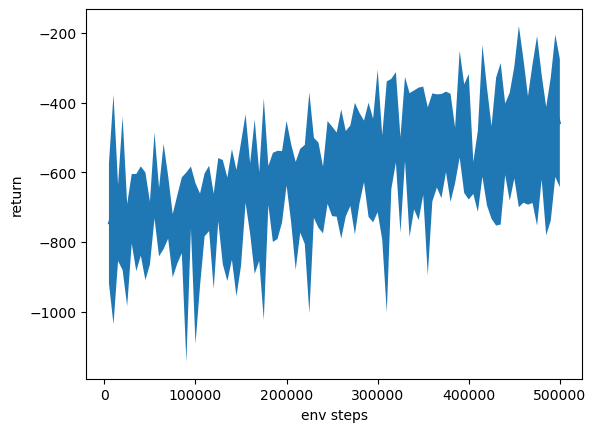

In [6]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(learning_curve["x"], learning_curve["y"])
plt.fill_between(np.array(learning_curve["x"]), np.array(learning_curve["y"])-np.array(learning_curve["z"]), np.array(learning_curve["y"])+np.array(learning_curve["z"]))
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()

In [7]:
leaning_ncde_05= learning_curve

In [8]:
lr=np.array(learning_curve)


In [9]:
learning_curves

[{'x': [5000,
   10000,
   15000,
   20000,
   25000,
   30000,
   35000,
   40000,
   45000,
   50000,
   55000,
   60000,
   65000,
   70000,
   75000,
   80000,
   85000,
   90000,
   95000,
   100000,
   105000,
   110000,
   115000,
   120000,
   125000,
   130000,
   135000,
   140000,
   145000,
   150000,
   155000,
   160000,
   165000,
   170000,
   175000,
   180000,
   185000,
   190000,
   195000,
   200000,
   205000,
   210000,
   215000,
   220000,
   225000,
   230000,
   235000,
   240000,
   245000,
   250000,
   255000,
   260000,
   265000,
   270000,
   275000,
   280000,
   285000,
   290000,
   295000,
   300000,
   305000,
   310000,
   315000,
   320000,
   325000,
   330000,
   335000,
   340000,
   345000,
   350000,
   355000,
   360000,
   365000,
   370000,
   375000,
   380000,
   385000,
   390000,
   395000,
   400000,
   405000,
   410000,
   415000,
   420000,
   425000,
   430000,
   435000,
   440000,
   445000,
   450000,
   455000,
   460000,
   

In [10]:
timess=torch.linspace(0, 65-1, 65)

In [11]:
file1 = open('config.txt', 'w')
file1.write(str(conf))

file1.close()
file2 = open('results.txt', 'w')
file2.write(str(learning_curve))
file2.close()

In [12]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(leaning_lstm["x"], leaning_lstm["y"], label = "lstm_32d")
plt.legend(loc = "lower right", fontsize = "large")
plt.plot(leaning_ncde_32["x"], leaning_ncde_32["y"], label = "ncde_32d")
plt.legend(loc = "lower right", fontsize = "large")
plt.fill_between(np.array(leaning_lstm["x"]), np.array(leaning_lstm["y"])-np.array(leaning_lstm["z"]), np.array(leaning_lstm["y"])+np.array(leaning_lstm["z"]))
plt.fill_between(np.array(leaning_ncde_32["x"]), np.array(leaning_ncde_32["y"])-np.array(leaning_ncde_32["z"]), np.array(leaning_ncde_32["y"])+np.array(leaning_ncde_32["z"]))
plt.xlabel("env steps", fontsize = "x-large")
plt.ylabel("return", fontsize = "x-large")
plt.show()

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000], 'y': [-746.3262600186397, -706.6957923874703, -745.1061398206278, -660.3846867716638, -837.4742145256139, -704.5671447300061, -744.299617483723, -711.0853416808765, -754.9222450365254, -774.4760456757737, -609.26

NameError: name 'leaning_lstm' is not defined

In [ ]:
import gym
import numpy as np
from gym import spaces
from tianshou.data import Batch
from gym import ActionWrapper